# Pairs Trading Analysis

This notebook implements a pairs trading strategy using cointegration analysis and the Caldeira-Moura trading rule. The strategy:
1. Selects cointegrated pairs from the IBX100 index
2. Simulates trading performance
3. Selects the best pairs based on Sharpe ratio
4. Runs backtests on the selected pairs
5. Generates comprehensive visualizations

## Import Required Libraries

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

## Load Market Data

In [77]:
dates = {
  "rebalance_date": [
    "2024-12-02",
    "2024-08-02",
    "2024-04-04",
    "2023-12-01",
    "2023-08-01",
    "2023-03-30",
    "2022-11-29",
    "2022-07-28",
    "2022-03-29",
    "2021-11-25",
    "2021-07-26",
    "2021-03-24",
    "2020-11-16",
    "2020-07-16",
    "2020-03-16"
  ],
  "training_start_date": [
    "2023-12-01",
    "2023-08-01",
    "2023-03-30",
    "2022-11-29",
    "2022-07-28",
    "2022-03-29",
    "2021-11-25",
    "2021-07-26",
    "2021-03-24",
    "2020-11-16",
    "2020-07-16",
    "2020-03-16",
    "2019-11-07",
    "2019-07-12",
    "2019-03-12"
  ],
  "testing_end_date": [
    "2025-03-14",
    "2024-12-02",
    "2024-08-02",
    "2024-04-04",
    "2023-12-01",
    "2023-08-01",
    "2023-03-30",
    "2022-11-29",
    "2022-07-28",
    "2022-03-29",
    "2021-11-25",
    "2021-07-26",
    "2021-03-24",
    "2020-11-16",
    "2020-07-16"
  ]
}

i = 0

In [3]:
# Get IBX100 composition
members = get_index_composition(index_code='IBX100', start_date=dates['rebalance_date'][i], end_date=dates['rebalance_date'][i])

# Load price data
price_data = get_descriptors(
    tickers=[*members.columns],
    descriptors='price_close',
    start_date=dates['training_start_date'][i],
    end_date=dates['rebalance_date'][i]
    )
price_data.dropna(axis=1, inplace=True)

2025-03-20 14:48:43.747 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 14:48:43.747 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 14:48:47.191 persevera_tools.db.operations: Query returned 100 rows in 1.25 seconds


2025-03-20 14:48:47.191 persevera_tools.db.operations: Query returned 100 rows in 1.25 seconds


2025-03-20 14:48:47.309 persevera_tools.db.operations: read_sql completed in 3.560s


2025-03-20 14:48:47.309 persevera_tools.db.operations: read_sql completed in 3.560s


2025-03-20 14:48:47.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 14:48:47.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 14:49:04.488 persevera_tools.db.operations: Query returned 25200 rows in 15.42 seconds


2025-03-20 14:49:04.488 persevera_tools.db.operations: Query returned 25200 rows in 15.42 seconds


2025-03-20 14:49:04.606 persevera_tools.db.operations: read_sql completed in 17.259s


2025-03-20 14:49:04.606 persevera_tools.db.operations: read_sql completed in 17.259s


## Find Cointegrated Pairs

In [7]:
# Create selector instance
selector = CointegrationPairSelector()

# Find best pairs
all_pairs = selector.select_pairs(price_data)

# Print pairs that passed all criteria
for pair in all_pairs:
    if pair.passed_all_criteria:
        print(f"\nPair: {pair.asset1} - {pair.asset2}")
        print(f"Half-life: {pair.half_life:.2f} days")
        print(f"Hurst exponent: {pair.hurst_exponent:.3f}")
        print(f"Hedge ratio: {pair.hedge_ratio:.3f}")

# Convert to DataFrame
results = pd.DataFrame(all_pairs)
results_passed = results[results['passed_all_criteria']].reset_index(drop=True)


Pair: ALOS3 - TOTS3
Half-life: 6.81 days
Hurst exponent: 0.245
Hedge ratio: 1.354

Pair: B3SA3 - PCAR3
Half-life: 7.34 days
Hurst exponent: 0.258
Hedge ratio: 3.509

Pair: BBAS3 - GMAT3
Half-life: 8.93 days
Hurst exponent: 0.465
Hedge ratio: 3.444

Pair: BBAS3 - SLCE3
Half-life: 10.50 days
Hurst exponent: 0.371
Hedge ratio: 0.710

Pair: BBAS3 - TIMS3
Half-life: 6.10 days
Hurst exponent: 0.324
Hedge ratio: 1.521

Pair: BBDC4 - DXCO3
Half-life: 8.60 days
Hurst exponent: 0.462
Hedge ratio: 0.563

Pair: BBDC4 - IRBR3
Half-life: 9.74 days
Hurst exponent: 0.405
Hedge ratio: 0.331

Pair: BBSE3 - ITSA4
Half-life: 8.69 days
Hurst exponent: 0.188
Hedge ratio: 0.288

Pair: BBSE3 - ITUB4
Half-life: 6.28 days
Hurst exponent: 0.177
Hedge ratio: 0.984

Pair: BBSE3 - PETZ3
Half-life: 10.88 days
Hurst exponent: 0.422
Hedge ratio: 7.674

Pair: BEEF3 - RADL3
Half-life: 8.31 days
Hurst exponent: 0.330
Hedge ratio: 3.963

Pair: BPAC11 - CCRO3
Half-life: 6.40 days
Hurst exponent: 0.242
Hedge ratio: 2.655



In [16]:
sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])

2025-03-20 15:01:15.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 15:01:15.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 15:01:17.512 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-20 15:01:17.512 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-20 15:01:17.632 persevera_tools.db.operations: read_sql completed in 2.083s


2025-03-20 15:01:17.632 persevera_tools.db.operations: read_sql completed in 2.083s


In [26]:
results_passed['same_sector'].value_counts()
results_passed

asset1 asset2  is_cointegrated_johansen  is_cointegrated_engle_granger  \
0    ALOS3  TOTS3                      True                           True   
1    B3SA3  PCAR3                      True                           True   
2    BBAS3  GMAT3                      True                           True   
3    BBAS3  SLCE3                      True                           True   
4    BBAS3  TIMS3                      True                           True   
..     ...    ...                       ...                            ...   
79   RAIL3  RECV3                      True                           True   
80   RECV3  SLCE3                      True                           True   
81  TAEE11  TOTS3                      True                           True   
82   TIMS3  VBBR3                      True                           True   
83   TOTS3  VALE3                      True                           True   

    half_life  hurst_exponent  hedge_ratio  passed_all_criteria sector_asset1  \
0    6.812564        0.244691     1.353649                 True      Cyclical   
1    7.339042        0.257801     3.509053                 True      Cyclical   
2    8.928208        0.464686     3.443667                 True      Cyclical   
3   10.504493        0.371177     0.710102                 True      Cyclical   
4    6.100625        0.324499     1.520626                 True      Cyclical   
..        ...             ...          ...                  ...           ...   
79   4.282330        0.226722     1.174007                 True      Cyclical   
80   7.937766        0.337384     0.980471                 True     Sensitive   
81  12.540428        0.386007     1.133590                 True     Defensive   
82   7.120143        0.215420     0.742286                 True     Sensitive   
83   7.259036        0.289278     0.505535                 True     Sensitive   

   sector_asset2  same_sector  
0      Sensitive        False  
1      Defensive        False  
2      Defensive        False  
3      Defensive        False  
4      Sensitive        False  
..           ...          ...  
79     Sensitive        False  
80     Defensive        False  
81     Sensitive        False  
82     Sensitive         True  
83      Cyclical        False  

[84 rows x 11 columns]

## Simulate Trading Performance

In [45]:
# Initialize DataFrame for simulation results
df = pd.DataFrame()

# Run simulations for each pair
for r in range(len(results_passed)):
    tickers = [results_passed.iloc[r].asset1, results_passed.iloc[r].asset2]
    price_data = get_descriptors(
        tickers=tickers,
        descriptors='price_close',
        start_date=dates['training_start_date'][i],
        end_date=dates['rebalance_date'][i]
        )

    eg = EngleGrangerPortfolio()
    res = eg.fit(price_data, dependent_variable=results_passed.iloc[r].asset1)
    historical_spread = res.residuals

    simulation = CointegrationSimulation(eg, n_periods=21*3, random_seed=40)
    sim = simulation.simulate_multiple_paths(n_paths=100)

    for s in range(len(sim)):
        simulated_spread = sim[s][1]
        simulated_prices = sim[s][0]

        config = CaldeiraMouraConfig(verbose=False)
        trading_rule = CaldeiraMouraTradingRule(config)

        signals, position_sizes = trading_rule.generate_signals(
            simulated_spread=simulated_spread,
            historical_spread=historical_spread,
            prices=simulated_prices,
        )

        simulation_results = trading_rule.get_portfolio_stats()
        simulation_results_df = pd.DataFrame(simulation_results, index=[0])
        simulation_results_df.insert(0, 'pair', '_'.join(tickers))
        df = pd.concat([df, simulation_results_df], axis=0, ignore_index=True)

2025-03-19 16:00:36.078 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:36.078 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:38.560 persevera_tools.db.operations: Query returned 504 rows in 0.53 seconds


2025-03-19 16:00:38.560 persevera_tools.db.operations: Query returned 504 rows in 0.53 seconds


2025-03-19 16:00:38.685 persevera_tools.db.operations: read_sql completed in 2.607s


2025-03-19 16:00:38.685 persevera_tools.db.operations: read_sql completed in 2.607s


2025-03-19 16:00:45.507 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:45.507 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:47.886 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:00:47.886 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:00:48.012 persevera_tools.db.operations: read_sql completed in 2.504s


2025-03-19 16:00:48.012 persevera_tools.db.operations: read_sql completed in 2.504s


2025-03-19 16:00:51.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:51.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:53.829 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:00:53.829 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:00:53.955 persevera_tools.db.operations: read_sql completed in 2.469s


2025-03-19 16:00:53.955 persevera_tools.db.operations: read_sql completed in 2.469s


2025-03-19 16:00:57.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:00:57.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:00.198 persevera_tools.db.operations: Query returned 504 rows in 0.45 seconds


2025-03-19 16:01:00.198 persevera_tools.db.operations: Query returned 504 rows in 0.45 seconds


2025-03-19 16:01:00.334 persevera_tools.db.operations: read_sql completed in 2.527s


2025-03-19 16:01:00.334 persevera_tools.db.operations: read_sql completed in 2.527s


2025-03-19 16:01:04.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:04.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:07.217 persevera_tools.db.operations: Query returned 504 rows in 0.47 seconds


2025-03-19 16:01:07.217 persevera_tools.db.operations: Query returned 504 rows in 0.47 seconds


2025-03-19 16:01:07.355 persevera_tools.db.operations: read_sql completed in 2.589s


2025-03-19 16:01:07.355 persevera_tools.db.operations: read_sql completed in 2.589s


2025-03-19 16:01:12.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:12.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:15.223 persevera_tools.db.operations: Query returned 504 rows in 0.51 seconds


2025-03-19 16:01:15.223 persevera_tools.db.operations: Query returned 504 rows in 0.51 seconds


2025-03-19 16:01:15.340 persevera_tools.db.operations: read_sql completed in 2.525s


2025-03-19 16:01:15.340 persevera_tools.db.operations: read_sql completed in 2.525s


2025-03-19 16:01:18.986 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:18.986 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:21.459 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:01:21.459 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:01:21.601 persevera_tools.db.operations: read_sql completed in 2.616s


2025-03-19 16:01:21.601 persevera_tools.db.operations: read_sql completed in 2.616s


2025-03-19 16:01:26.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:26.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:28.405 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:01:28.405 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:01:28.530 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:01:28.530 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:01:32.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:32.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:34.765 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:01:34.765 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:01:34.907 persevera_tools.db.operations: read_sql completed in 2.471s


2025-03-19 16:01:34.907 persevera_tools.db.operations: read_sql completed in 2.471s


2025-03-19 16:01:38.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:38.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:40.610 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:01:40.610 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:01:40.737 persevera_tools.db.operations: read_sql completed in 2.551s


2025-03-19 16:01:40.737 persevera_tools.db.operations: read_sql completed in 2.551s


2025-03-19 16:01:44.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:44.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:46.905 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:01:46.905 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:01:47.045 persevera_tools.db.operations: read_sql completed in 2.778s


2025-03-19 16:01:47.045 persevera_tools.db.operations: read_sql completed in 2.778s


2025-03-19 16:01:51.736 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:51.736 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:54.057 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:01:54.057 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:01:54.201 persevera_tools.db.operations: read_sql completed in 2.465s


2025-03-19 16:01:54.201 persevera_tools.db.operations: read_sql completed in 2.465s


2025-03-19 16:01:58.215 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:01:58.215 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:00.565 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:02:00.565 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:02:00.707 persevera_tools.db.operations: read_sql completed in 2.491s


2025-03-19 16:02:00.707 persevera_tools.db.operations: read_sql completed in 2.491s


2025-03-19 16:02:03.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:03.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:06.249 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:06.249 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:06.375 persevera_tools.db.operations: read_sql completed in 2.467s


2025-03-19 16:02:06.375 persevera_tools.db.operations: read_sql completed in 2.467s


2025-03-19 16:02:09.601 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:09.601 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:11.920 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:02:11.920 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:02:12.048 persevera_tools.db.operations: read_sql completed in 2.447s


2025-03-19 16:02:12.048 persevera_tools.db.operations: read_sql completed in 2.447s


2025-03-19 16:02:14.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:14.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:16.896 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:16.896 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:17.027 persevera_tools.db.operations: read_sql completed in 2.470s


2025-03-19 16:02:17.027 persevera_tools.db.operations: read_sql completed in 2.470s


2025-03-19 16:02:20.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:20.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:22.733 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:02:22.733 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:02:22.856 persevera_tools.db.operations: read_sql completed in 2.490s


2025-03-19 16:02:22.856 persevera_tools.db.operations: read_sql completed in 2.490s


2025-03-19 16:02:27.171 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:27.171 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:29.436 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:02:29.436 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:02:29.567 persevera_tools.db.operations: read_sql completed in 2.395s


2025-03-19 16:02:29.567 persevera_tools.db.operations: read_sql completed in 2.395s


2025-03-19 16:02:33.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:33.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:35.406 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:35.406 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:02:35.530 persevera_tools.db.operations: read_sql completed in 2.439s


2025-03-19 16:02:35.530 persevera_tools.db.operations: read_sql completed in 2.439s


2025-03-19 16:02:38.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:38.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:40.593 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:02:40.593 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:02:40.732 persevera_tools.db.operations: read_sql completed in 2.644s


2025-03-19 16:02:40.732 persevera_tools.db.operations: read_sql completed in 2.644s


2025-03-19 16:02:43.368 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:43.368 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:45.687 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:02:45.687 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:02:45.813 persevera_tools.db.operations: read_sql completed in 2.444s


2025-03-19 16:02:45.813 persevera_tools.db.operations: read_sql completed in 2.444s


2025-03-19 16:02:48.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:48.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:50.417 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:02:50.417 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:02:50.546 persevera_tools.db.operations: read_sql completed in 2.409s


2025-03-19 16:02:50.546 persevera_tools.db.operations: read_sql completed in 2.409s


2025-03-19 16:02:53.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:53.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:55.515 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:02:55.515 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:02:55.636 persevera_tools.db.operations: read_sql completed in 2.444s


2025-03-19 16:02:55.636 persevera_tools.db.operations: read_sql completed in 2.444s


2025-03-19 16:02:59.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:02:59.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:01.538 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:03:01.538 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:03:01.673 persevera_tools.db.operations: read_sql completed in 2.488s


2025-03-19 16:03:01.673 persevera_tools.db.operations: read_sql completed in 2.488s


2025-03-19 16:03:05.068 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:05.068 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:07.758 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:03:07.758 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:03:07.897 persevera_tools.db.operations: read_sql completed in 2.828s


2025-03-19 16:03:07.897 persevera_tools.db.operations: read_sql completed in 2.828s


2025-03-19 16:03:10.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:10.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:12.565 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:03:12.565 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:03:12.692 persevera_tools.db.operations: read_sql completed in 2.518s


2025-03-19 16:03:12.692 persevera_tools.db.operations: read_sql completed in 2.518s


2025-03-19 16:03:16.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:16.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:18.846 persevera_tools.db.operations: Query returned 504 rows in 0.56 seconds


2025-03-19 16:03:18.846 persevera_tools.db.operations: Query returned 504 rows in 0.56 seconds


2025-03-19 16:03:18.989 persevera_tools.db.operations: read_sql completed in 2.599s


2025-03-19 16:03:18.989 persevera_tools.db.operations: read_sql completed in 2.599s


2025-03-19 16:03:23.219 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:23.219 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:25.736 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:03:25.736 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:03:25.862 persevera_tools.db.operations: read_sql completed in 2.642s


2025-03-19 16:03:25.862 persevera_tools.db.operations: read_sql completed in 2.642s


2025-03-19 16:03:28.811 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:28.811 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:31.110 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:03:31.110 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:03:31.229 persevera_tools.db.operations: read_sql completed in 2.418s


2025-03-19 16:03:31.229 persevera_tools.db.operations: read_sql completed in 2.418s


2025-03-19 16:03:34.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:34.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:36.416 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:03:36.416 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:03:36.537 persevera_tools.db.operations: read_sql completed in 2.482s


2025-03-19 16:03:36.537 persevera_tools.db.operations: read_sql completed in 2.482s


2025-03-19 16:03:38.818 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:38.818 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:41.137 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:03:41.137 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:03:41.268 persevera_tools.db.operations: read_sql completed in 2.450s


2025-03-19 16:03:41.268 persevera_tools.db.operations: read_sql completed in 2.450s


2025-03-19 16:03:44.636 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:44.636 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:47.208 persevera_tools.db.operations: Query returned 504 rows in 0.46 seconds


2025-03-19 16:03:47.208 persevera_tools.db.operations: Query returned 504 rows in 0.46 seconds


2025-03-19 16:03:47.348 persevera_tools.db.operations: read_sql completed in 2.712s


2025-03-19 16:03:47.348 persevera_tools.db.operations: read_sql completed in 2.712s


2025-03-19 16:03:50.825 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:50.825 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:53.205 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:03:53.205 persevera_tools.db.operations: Query returned 504 rows in 0.44 seconds


2025-03-19 16:03:53.328 persevera_tools.db.operations: read_sql completed in 2.503s


2025-03-19 16:03:53.328 persevera_tools.db.operations: read_sql completed in 2.503s


2025-03-19 16:03:58.535 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:03:58.535 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:00.902 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:04:00.902 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:04:01.038 persevera_tools.db.operations: read_sql completed in 2.503s


2025-03-19 16:04:01.038 persevera_tools.db.operations: read_sql completed in 2.503s


2025-03-19 16:04:04.044 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:04.044 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:06.362 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:04:06.362 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:04:06.499 persevera_tools.db.operations: read_sql completed in 2.455s


2025-03-19 16:04:06.499 persevera_tools.db.operations: read_sql completed in 2.455s


2025-03-19 16:04:08.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:08.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:10.933 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:04:10.933 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:04:11.063 persevera_tools.db.operations: read_sql completed in 2.468s


2025-03-19 16:04:11.063 persevera_tools.db.operations: read_sql completed in 2.468s


2025-03-19 16:04:13.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:13.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:15.749 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:15.749 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:15.874 persevera_tools.db.operations: read_sql completed in 2.401s


2025-03-19 16:04:15.874 persevera_tools.db.operations: read_sql completed in 2.401s


2025-03-19 16:04:18.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:18.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:20.688 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:04:20.688 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:04:20.812 persevera_tools.db.operations: read_sql completed in 2.554s


2025-03-19 16:04:20.812 persevera_tools.db.operations: read_sql completed in 2.554s


2025-03-19 16:04:23.161 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:23.161 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:25.487 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:25.487 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:25.613 persevera_tools.db.operations: read_sql completed in 2.452s


2025-03-19 16:04:25.613 persevera_tools.db.operations: read_sql completed in 2.452s


2025-03-19 16:04:27.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:27.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:30.168 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:30.168 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:04:30.304 persevera_tools.db.operations: read_sql completed in 2.449s


2025-03-19 16:04:30.304 persevera_tools.db.operations: read_sql completed in 2.449s


2025-03-19 16:04:33.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:33.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:35.469 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:04:35.469 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:04:35.599 persevera_tools.db.operations: read_sql completed in 2.557s


2025-03-19 16:04:35.599 persevera_tools.db.operations: read_sql completed in 2.557s


2025-03-19 16:04:38.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:38.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:40.447 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:04:40.447 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:04:40.584 persevera_tools.db.operations: read_sql completed in 2.428s


2025-03-19 16:04:40.584 persevera_tools.db.operations: read_sql completed in 2.428s


2025-03-19 16:04:42.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:42.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:45.059 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:04:45.059 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:04:45.183 persevera_tools.db.operations: read_sql completed in 2.393s


2025-03-19 16:04:45.183 persevera_tools.db.operations: read_sql completed in 2.393s


2025-03-19 16:04:47.404 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:47.404 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:49.774 persevera_tools.db.operations: Query returned 504 rows in 0.48 seconds


2025-03-19 16:04:49.774 persevera_tools.db.operations: Query returned 504 rows in 0.48 seconds


2025-03-19 16:04:49.903 persevera_tools.db.operations: read_sql completed in 2.500s


2025-03-19 16:04:49.903 persevera_tools.db.operations: read_sql completed in 2.500s


2025-03-19 16:04:52.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:52.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:54.359 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:04:54.359 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:04:54.498 persevera_tools.db.operations: read_sql completed in 2.491s


2025-03-19 16:04:54.498 persevera_tools.db.operations: read_sql completed in 2.491s


2025-03-19 16:04:56.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:56.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:04:59.370 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:04:59.370 persevera_tools.db.operations: Query returned 504 rows in 0.54 seconds


2025-03-19 16:04:59.504 persevera_tools.db.operations: read_sql completed in 2.614s


2025-03-19 16:04:59.504 persevera_tools.db.operations: read_sql completed in 2.614s


2025-03-19 16:05:02.255 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:02.255 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:04.719 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:05:04.719 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:05:04.845 persevera_tools.db.operations: read_sql completed in 2.590s


2025-03-19 16:05:04.845 persevera_tools.db.operations: read_sql completed in 2.590s


2025-03-19 16:05:06.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:06.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:09.148 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:05:09.148 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:05:09.285 persevera_tools.db.operations: read_sql completed in 2.480s


2025-03-19 16:05:09.285 persevera_tools.db.operations: read_sql completed in 2.480s


2025-03-19 16:05:11.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:11.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:14.095 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:05:14.095 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:05:14.223 persevera_tools.db.operations: read_sql completed in 2.435s


2025-03-19 16:05:14.223 persevera_tools.db.operations: read_sql completed in 2.435s


2025-03-19 16:05:17.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:17.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:19.464 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:05:19.464 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:05:19.603 persevera_tools.db.operations: read_sql completed in 2.497s


2025-03-19 16:05:19.603 persevera_tools.db.operations: read_sql completed in 2.497s


2025-03-19 16:05:22.083 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:22.083 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:24.422 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:05:24.422 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:05:24.549 persevera_tools.db.operations: read_sql completed in 2.466s


2025-03-19 16:05:24.549 persevera_tools.db.operations: read_sql completed in 2.466s


2025-03-19 16:05:30.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:30.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:32.694 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:05:32.694 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:05:32.828 persevera_tools.db.operations: read_sql completed in 2.454s


2025-03-19 16:05:32.828 persevera_tools.db.operations: read_sql completed in 2.454s


2025-03-19 16:05:38.926 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:38.926 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:41.386 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:05:41.386 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:05:41.514 persevera_tools.db.operations: read_sql completed in 2.588s


2025-03-19 16:05:41.514 persevera_tools.db.operations: read_sql completed in 2.588s


2025-03-19 16:05:46.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:46.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:49.262 persevera_tools.db.operations: Query returned 504 rows in 0.45 seconds


2025-03-19 16:05:49.262 persevera_tools.db.operations: Query returned 504 rows in 0.45 seconds


2025-03-19 16:05:49.395 persevera_tools.db.operations: read_sql completed in 2.518s


2025-03-19 16:05:49.395 persevera_tools.db.operations: read_sql completed in 2.518s


2025-03-19 16:05:54.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:54.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:05:56.942 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:05:56.942 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:05:57.075 persevera_tools.db.operations: read_sql completed in 2.470s


2025-03-19 16:05:57.075 persevera_tools.db.operations: read_sql completed in 2.470s


2025-03-19 16:06:01.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:01.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:04.191 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:04.191 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:04.318 persevera_tools.db.operations: read_sql completed in 2.451s


2025-03-19 16:06:04.318 persevera_tools.db.operations: read_sql completed in 2.451s


2025-03-19 16:06:09.189 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:09.189 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:11.469 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:11.469 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:11.595 persevera_tools.db.operations: read_sql completed in 2.406s


2025-03-19 16:06:11.595 persevera_tools.db.operations: read_sql completed in 2.406s


2025-03-19 16:06:14.718 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:14.718 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:17.044 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:06:17.044 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:06:17.171 persevera_tools.db.operations: read_sql completed in 2.453s


2025-03-19 16:06:17.171 persevera_tools.db.operations: read_sql completed in 2.453s


2025-03-19 16:06:20.845 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:20.845 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:23.166 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:06:23.166 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-19 16:06:23.284 persevera_tools.db.operations: read_sql completed in 2.439s


2025-03-19 16:06:23.284 persevera_tools.db.operations: read_sql completed in 2.439s


2025-03-19 16:06:26.250 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:26.250 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:28.699 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:06:28.699 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:06:28.836 persevera_tools.db.operations: read_sql completed in 2.587s


2025-03-19 16:06:28.836 persevera_tools.db.operations: read_sql completed in 2.587s


2025-03-19 16:06:31.608 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:31.608 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:33.899 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:33.899 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:34.019 persevera_tools.db.operations: read_sql completed in 2.410s


2025-03-19 16:06:34.019 persevera_tools.db.operations: read_sql completed in 2.410s


2025-03-19 16:06:37.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:37.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:39.568 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:06:39.568 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:06:39.694 persevera_tools.db.operations: read_sql completed in 2.405s


2025-03-19 16:06:39.694 persevera_tools.db.operations: read_sql completed in 2.405s


2025-03-19 16:06:41.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:41.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:44.134 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:44.134 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:06:44.261 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:06:44.261 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:06:46.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:46.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:49.319 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:06:49.319 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:06:49.447 persevera_tools.db.operations: read_sql completed in 2.539s


2025-03-19 16:06:49.447 persevera_tools.db.operations: read_sql completed in 2.539s


2025-03-19 16:06:51.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:51.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:54.354 persevera_tools.db.operations: Query returned 504 rows in 0.53 seconds


2025-03-19 16:06:54.354 persevera_tools.db.operations: Query returned 504 rows in 0.53 seconds


2025-03-19 16:06:54.478 persevera_tools.db.operations: read_sql completed in 2.626s


2025-03-19 16:06:54.478 persevera_tools.db.operations: read_sql completed in 2.626s


2025-03-19 16:06:57.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:06:57.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:00.350 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:07:00.350 persevera_tools.db.operations: Query returned 504 rows in 0.50 seconds


2025-03-19 16:07:00.481 persevera_tools.db.operations: read_sql completed in 2.525s


2025-03-19 16:07:00.481 persevera_tools.db.operations: read_sql completed in 2.525s


2025-03-19 16:07:03.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:03.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:05.354 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:05.354 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:05.484 persevera_tools.db.operations: read_sql completed in 2.450s


2025-03-19 16:07:05.484 persevera_tools.db.operations: read_sql completed in 2.450s


2025-03-19 16:07:07.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:07.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:09.909 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:07:09.909 persevera_tools.db.operations: Query returned 504 rows in 0.43 seconds


2025-03-19 16:07:10.049 persevera_tools.db.operations: read_sql completed in 2.674s


2025-03-19 16:07:10.049 persevera_tools.db.operations: read_sql completed in 2.674s


2025-03-19 16:07:11.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:11.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:14.443 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:07:14.443 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:07:14.593 persevera_tools.db.operations: read_sql completed in 2.686s


2025-03-19 16:07:14.593 persevera_tools.db.operations: read_sql completed in 2.686s


2025-03-19 16:07:17.102 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:17.102 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:19.412 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:19.412 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:19.546 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:07:19.546 persevera_tools.db.operations: read_sql completed in 2.445s


2025-03-19 16:07:21.811 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:21.811 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:24.340 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:24.340 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:24.472 persevera_tools.db.operations: read_sql completed in 2.660s


2025-03-19 16:07:24.472 persevera_tools.db.operations: read_sql completed in 2.660s


2025-03-19 16:07:26.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:26.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:28.703 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:28.703 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:28.828 persevera_tools.db.operations: read_sql completed in 2.407s


2025-03-19 16:07:28.828 persevera_tools.db.operations: read_sql completed in 2.407s


2025-03-19 16:07:31.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:31.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:33.439 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:07:33.439 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-19 16:07:33.563 persevera_tools.db.operations: read_sql completed in 2.446s


2025-03-19 16:07:33.563 persevera_tools.db.operations: read_sql completed in 2.446s


2025-03-19 16:07:35.948 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:35.948 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:38.273 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:38.273 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:07:38.400 persevera_tools.db.operations: read_sql completed in 2.452s


2025-03-19 16:07:38.400 persevera_tools.db.operations: read_sql completed in 2.452s


2025-03-19 16:07:41.882 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:41.882 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:44.312 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:07:44.312 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:07:44.445 persevera_tools.db.operations: read_sql completed in 2.563s


2025-03-19 16:07:44.445 persevera_tools.db.operations: read_sql completed in 2.563s


2025-03-19 16:07:47.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:47.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:49.969 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:49.969 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:07:50.097 persevera_tools.db.operations: read_sql completed in 2.420s


2025-03-19 16:07:50.097 persevera_tools.db.operations: read_sql completed in 2.420s


2025-03-19 16:07:55.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:55.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:07:57.829 persevera_tools.db.operations: Query returned 504 rows in 0.51 seconds


2025-03-19 16:07:57.829 persevera_tools.db.operations: Query returned 504 rows in 0.51 seconds


2025-03-19 16:07:57.961 persevera_tools.db.operations: read_sql completed in 2.532s


2025-03-19 16:07:57.961 persevera_tools.db.operations: read_sql completed in 2.532s


2025-03-19 16:08:00.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:00.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:03.070 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:03.070 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:03.200 persevera_tools.db.operations: read_sql completed in 2.417s


2025-03-19 16:08:03.200 persevera_tools.db.operations: read_sql completed in 2.417s


2025-03-19 16:08:07.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:07.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:09.423 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:09.423 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:09.546 persevera_tools.db.operations: read_sql completed in 2.442s


2025-03-19 16:08:09.546 persevera_tools.db.operations: read_sql completed in 2.442s


2025-03-19 16:08:11.767 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:11.767 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:14.152 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:08:14.152 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:08:14.282 persevera_tools.db.operations: read_sql completed in 2.514s


2025-03-19 16:08:14.282 persevera_tools.db.operations: read_sql completed in 2.514s


2025-03-19 16:08:16.612 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:16.612 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:19.236 persevera_tools.db.operations: Query returned 504 rows in 0.64 seconds


2025-03-19 16:08:19.236 persevera_tools.db.operations: Query returned 504 rows in 0.64 seconds


2025-03-19 16:08:19.362 persevera_tools.db.operations: read_sql completed in 2.750s


2025-03-19 16:08:19.362 persevera_tools.db.operations: read_sql completed in 2.750s


2025-03-19 16:08:22.330 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:22.330 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:24.845 persevera_tools.db.operations: Query returned 504 rows in 0.62 seconds


2025-03-19 16:08:24.845 persevera_tools.db.operations: Query returned 504 rows in 0.62 seconds


2025-03-19 16:08:24.980 persevera_tools.db.operations: read_sql completed in 2.649s


2025-03-19 16:08:24.980 persevera_tools.db.operations: read_sql completed in 2.649s


2025-03-19 16:08:28.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:28.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:30.390 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:30.390 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-19 16:08:30.524 persevera_tools.db.operations: read_sql completed in 2.513s


2025-03-19 16:08:30.524 persevera_tools.db.operations: read_sql completed in 2.513s


2025-03-19 16:08:33.426 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:33.426 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:35.692 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:08:35.692 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:08:35.817 persevera_tools.db.operations: read_sql completed in 2.391s


2025-03-19 16:08:35.817 persevera_tools.db.operations: read_sql completed in 2.391s


2025-03-19 16:08:39.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:39.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:42.046 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:08:42.046 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-19 16:08:42.192 persevera_tools.db.operations: read_sql completed in 2.458s


2025-03-19 16:08:42.192 persevera_tools.db.operations: read_sql completed in 2.458s


2025-03-19 16:08:47.679 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:47.679 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:50.139 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:08:50.139 persevera_tools.db.operations: Query returned 504 rows in 0.52 seconds


2025-03-19 16:08:50.265 persevera_tools.db.operations: read_sql completed in 2.586s


2025-03-19 16:08:50.265 persevera_tools.db.operations: read_sql completed in 2.586s


2025-03-19 16:08:52.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:52.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:54.711 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:08:54.711 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:08:54.835 persevera_tools.db.operations: read_sql completed in 2.412s


2025-03-19 16:08:54.835 persevera_tools.db.operations: read_sql completed in 2.412s


2025-03-19 16:08:57.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:57.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:08:59.991 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:08:59.991 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-19 16:09:00.116 persevera_tools.db.operations: read_sql completed in 2.431s


2025-03-19 16:09:00.116 persevera_tools.db.operations: read_sql completed in 2.431s


2025-03-19 16:09:02.456 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:02.456 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:04.741 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:09:04.741 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-19 16:09:04.865 persevera_tools.db.operations: read_sql completed in 2.410s


2025-03-19 16:09:04.865 persevera_tools.db.operations: read_sql completed in 2.410s


2025-03-19 16:09:07.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:07.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:10.315 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:09:10.315 persevera_tools.db.operations: Query returned 504 rows in 0.49 seconds


2025-03-19 16:09:10.435 persevera_tools.db.operations: read_sql completed in 2.616s


2025-03-19 16:09:10.435 persevera_tools.db.operations: read_sql completed in 2.616s


## Select Best Pairs

Top 20 pairs by aggregate Sharpe Ratio are selected

In [46]:
# Select top 20 pairs based on Sharpe ratio
selected_pairs = (df
 .groupby('pair')
 .agg({'annualized_return': 'median', 'annualized_volatility': 'median'})
 .eval('sharpe_ratio = (annualized_return - 0.11) / annualized_volatility')
 .query('sharpe_ratio > 0')
 .sort_values('sharpe_ratio', ascending=False)
 .head(20)
 )
 
selected_pairs['asset1'] = selected_pairs.index.str.split('_').str[0]
selected_pairs['asset2'] = selected_pairs.index.str.split('_').str[1]

# Display selected pairs
print("Selected Pairs:")
selected_pairs[['annualized_return', 'annualized_volatility', 'sharpe_ratio']]

Selected Pairs:


annualized_return  annualized_volatility  sharpe_ratio
pair                                                               
B3SA3_NTCO3           0.237702               0.084629      1.508964
BRKM5_LWSA3           0.242547               0.108977      1.216287
GMAT3_MDIA3           0.163839               0.066726      0.806869
HAPV3_MOVI3           0.200750               0.114972      0.789318
NTCO3_RAIZ4           0.170362               0.079635      0.757980
BRAV3_SLCE3           0.155799               0.064761      0.707204
DXCO3_MDIA3           0.148041               0.059121      0.643437
ASAI3_CRFB3           0.131683               0.061347      0.353446
AZZA3_HYPE3           0.130149               0.074346      0.271016
PSSA3_RAIL3           0.115799               0.055001      0.105439
MRFG3_VIVT3           0.114033               0.047805      0.084369

## Run Backtests

In [47]:
# Initialize DataFrame for backtest results
results_df = pd.DataFrame()
returns_df = pd.DataFrame()

# Run backtest for each pair
counter = 1
for ix, pair in selected_pairs.iterrows():
    print(f"\nBacktesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
    
    testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
    hedge_ratio = testing_data['hedge_ratio'].values[0]
    half_life = testing_data['half_life'].values[0]
    hurst = testing_data['hurst_exponent'].values[0]

    # Get price data for this pair
    pair_data = get_descriptors(
        tickers=[pair.asset1, pair.asset2],
        descriptors='price_close',
        start_date=dates['training_start_date'][i],
        end_date=dates['testing_end_date'][i]
    )
    
    # Create backtester with default configuration
    config = CaldeiraMouraConfig()
    backtester = Backtester(config)
    
    # Run backtest
    backtest_results = backtester.run_backtest(
        price_data=pair_data,
        hedge_ratio=hedge_ratio,
        training_window=252,  # 1 year of data for training
    )
    
    # Extract key metrics
    metrics = {
        'pair': f"{pair.asset1}_{pair.asset2}",
        'half_life': half_life,
        'hurst': hurst,
        'hedge_ratio': hedge_ratio,
        'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
        'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
        'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
        'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
        'num_trades': backtest_results['portfolio_stats']['num_trades'],
        'win_rate': backtest_results['portfolio_stats']['win_rate']
    }
    
    # Add to results dataframe
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
    returns_df = pd.merge(returns_df, backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), left_index=True, right_index=True, how='outer')
    
    counter += 1


Backtesting pair 1/11: B3SA3 - NTCO3
2025-03-19 16:09:14.994 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:14.994 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:17.338 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:17.338 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:17.465 persevera_tools.db.operations: read_sql completed in 2.471s


2025-03-19 16:09:17.465 persevera_tools.db.operations: read_sql completed in 2.471s
2025-03-19 16:09:17.494 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:17.498 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:17.500 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_NTCO3 with 252 data points
2025-03-19 16:09:17.502 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_NTCO3


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9742250005223703, 'asset1_price': 11.92, 'asset2_price': 16.301, 'holding_days': 0}

2025-03-19 16:09:17.525 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for B3SA3_NTCO3. Z-score: -1.97
2025-03-19 16:09:17.533 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: OPENING LONG B3SA3 / SHORT NTCO3 position. Z-score: -2.13, Size: 1,000,000.00
2025-03-19 16:09:17.535 persevera_arbitrage.trading.zscore: Position opened: LONG B3SA3 / SHORT NTCO3
2025-03-19 16:09:17.536 persevera_arbitrage.trading.zscore: Entry prices: B3SA3=11.99, NTCO3=16.58
2025-03-19 16:09:17.538 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-19 16:09:17.539 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-19 16:09:17.540 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 1, Z-score: -2.24, Return: -0.33%)
2025-03-19 16:09:17.550 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 2, Z-score: -1.93, Return: 


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.132923804592766, 'asset1_price': 11.988, 'asset2_price': 16.579, 'holding_days': 0}
{'equity': 992698.3256855989, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3301.6743144011543, 'position': 1, 'zscore': -2.239839938784204, 'asset1_price': 12.124, 'asset2_price': 16.877, 'holding_days': 0}
{'equity': 1004767.8060170069, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8767.806017006887, 'position': 1, 'zscore': -1.925147377999244, 'asset1_price': 12.241, 'asset2_price': 16.637, 'holding_days': 1}
{'equity': 981326.574870908, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14673.425129091933, 'position': 1, 'zscore': -2.598516254628995, 'asset1_price': 12.475, 'asset2_price': 17.741, 'holding_days': 2}
{'equity': 971095.7819512014, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24904.21804879858,

2025-03-19 16:09:17.639 persevera_arbitrage.trading.zscore: Position closed: LONG B3SA3 / SHORT NTCO3, P&L: -81,260.76 (-7.76%) [LONG B3SA3: -3.41%, SHORT NTCO3: -12.11%]
2025-03-19 16:09:17.641 persevera_arbitrage.trading.zscore: Closing prices: B3SA3=11.58, NTCO3=18.59
2025-03-19 16:09:17.642 persevera_arbitrage.trading.zscore: Entry prices: B3SA3=11.99, NTCO3=16.58
2025-03-19 16:09:17.646 persevera_arbitrage.trading.zscore: Holding period: 13 days
2025-03-19 16:09:17.650 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-19 16:09:17.651 persevera_arbitrage.trading.zscore: Available capital: 914,739.24
2025-03-19 16:09:17.654 persevera_arbitrage.trading.zscore: 2024-03-27 00:00:00: OPENING LONG B3SA3 / SHORT NTCO3 position. Z-score: -2.96, Size: 914,739.24
2025-03-19 16:09:17.656 persevera_arbitrage.trading.zscore: Position opened: LONG B3SA3 / SHORT NTCO3
2025-03-19 16:09:17.658 persevera_arbitrage.trading.zscore: Entry prices: B3SA3=11.75, NTCO3=18.17
2025-03-

{'equity': 914739.2437516232, 'available_capital': 914739.2437516232, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.957778966349921, 'asset1_price': 11.748, 'asset2_price': 18.167, 'holding_days': 0}
{'equity': 917979.8296497753, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 6899.5428731586335, 'position': 1, 'zscore': -2.715502118751326, 'asset1_price': 11.719, 'asset2_price': 17.847, 'holding_days': 0}
{'equity': 921904.740703464, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 10824.453926847258, 'position': 1, 'zscore': -2.5197275133500976, 'asset1_price': 11.504, 'asset2_price': 17.358, 'holding_days': 1}
{'equity': 924128.6741898822, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 13048.387413265516, 'position': 1, 'zscore': -2.4185200002340292, 'asset1_price': 11.465, 'asset2_price': 17.209, 'holding_days': 2}
{'equity': 907719.7073374228, 'available_capital': 0.0, 'posit

2025-03-19 16:09:17.710 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 8, Z-score: -2.19, Return: 2.41%)
2025-03-19 16:09:17.722 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 9, Z-score: -2.25, Return: 1.58%)
2025-03-19 16:09:17.733 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 10, Z-score: -2.06, Return: 2.30%)
2025-03-19 16:09:17.737 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 11, Z-score: -2.01, Return: 2.14%)
2025-03-19 16:09:17.741 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 12, Z-score: -2.11, Return: 1.35%)
2025-03-19 16:09:17.749 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 13, Z-score: -1.91, Return: 1.99%)
2025-03-19 16:09:17.754 

{'equity': 933066.0100792231, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 21985.723302606362, 'position': 1, 'zscore': -2.1871957801840938, 'asset1_price': 12.11, 'asset2_price': 17.85, 'holding_days': 7}
{'equity': 925517.625440341, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 14437.338663724262, 'position': 1, 'zscore': -2.2484079932843977, 'asset1_price': 11.689, 'asset2_price': 17.5, 'holding_days': 8}
{'equity': 932060.4280713937, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 20980.141294777015, 'position': 1, 'zscore': -2.0626234913222494, 'asset1_price': 11.709, 'asset2_price': 17.27, 'holding_days': 9}
{'equity': 930599.871361688, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 19519.58458507125, 'position': 1, 'zscore': -2.0131150633258263, 'asset1_price': 11.445, 'asset2_price': 16.92, 'holding_days': 10}
{'equity': 923379.7858434002, 'available_capital': 0

2025-03-19 16:09:17.850 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 29, Z-score: -2.17, Return: -0.74%)
2025-03-19 16:09:17.853 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 30, Z-score: -2.35, Return: -1.97%)
2025-03-19 16:09:17.858 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 31, Z-score: -2.21, Return: -1.17%)
2025-03-19 16:09:17.867 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 32, Z-score: -1.09, Return: 4.33%)
2025-03-19 16:09:17.870 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 33, Z-score: -1.47, Return: 2.52%)
2025-03-19 16:09:17.874 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 34, Z-score: -1.49, Return: 2.48%)
2025-03-19 16:09:17

{'equity': 904366.628243519, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': -6713.658533097696, 'position': 1, 'zscore': -2.1670199516675703, 'asset1_price': 10.956, 'asset2_price': 17.21, 'holding_days': 28}
{'equity': 893126.7653235727, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': -17953.52145304399, 'position': 1, 'zscore': -2.3508197155342794, 'asset1_price': 10.692, 'asset2_price': 17.25, 'holding_days': 29}
{'equity': 900377.8703404666, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': -10702.416436150035, 'position': 1, 'zscore': -2.2140425086845017, 'asset1_price': 10.976, 'asset2_price': 17.4, 'holding_days': 30}
{'equity': 950574.6846443925, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 39494.39786777576, 'position': 1, 'zscore': -1.0894120246644665, 'asset1_price': 11.21, 'asset2_price': 15.76, 'holding_days': 31}
{'equity': 934032.8438604169, 'available_capita

2025-03-19 16:09:17.892 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 37, Z-score: -1.38, Return: 2.63%)
2025-03-19 16:09:17.899 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 38, Z-score: -1.46, Return: 1.86%)
2025-03-19 16:09:17.901 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 39, Z-score: -1.16, Return: 3.31%)
2025-03-19 16:09:17.903 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 40, Z-score: -1.04, Return: 3.85%)
2025-03-19 16:09:17.907 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 41, Z-score: -0.97, Return: 4.12%)
2025-03-19 16:09:17.909 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding LONG B3SA3 / SHORT NTCO3 position (Day 42, Z-score: -0.71, Return: 5.23%)
2025-03-19 16:09:17.91

{'equity': 935035.851759988, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 23955.564983371245, 'position': 1, 'zscore': -1.3816838191596736, 'asset1_price': 11.152, 'asset2_price': 16.29, 'holding_days': 36}
{'equity': 928043.2546598474, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 16962.96788323069, 'position': 1, 'zscore': -1.4610345348252303, 'asset1_price': 10.81, 'asset2_price': 16.04, 'holding_days': 37}
{'equity': 941227.0922473054, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 30146.80547068873, 'position': 1, 'zscore': -1.1567402245333855, 'asset1_price': 10.859, 'asset2_price': 15.59, 'holding_days': 38}
{'equity': 946112.8671146932, 'available_capital': 0.0, 'position_size': 911080.2867766167, 'pnl_amount': 35032.58033807647, 'position': 1, 'zscore': -1.040856913879869, 'asset1_price': 10.888, 'asset2_price': 15.44, 'holding_days': 39}
{'equity': 948612.6271865284, 'available_capital':

2025-03-19 16:09:17.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:20.488 persevera_tools.db.operations: Query returned 630 rows in 0.56 seconds


2025-03-19 16:09:20.488 persevera_tools.db.operations: Query returned 630 rows in 0.56 seconds


2025-03-19 16:09:20.615 persevera_tools.db.operations: read_sql completed in 2.646s


2025-03-19 16:09:20.615 persevera_tools.db.operations: read_sql completed in 2.646s
2025-03-19 16:09:20.645 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:20.645 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:20.652 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_LWSA3 with 252 data points
2025-03-19 16:09:20.652 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_LWSA3
2025-03-19 16:09:20.655 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.48
2025-03-19 16:09:20.655 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.68
2025-03-19 16:09:20.655 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.58
2025-03-19 16:09:20.662 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.476619035775352, 'asset1_price': 20.22, 'asset2_price': 5.701, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.678729278460125, 'asset1_price': 20.42, 'asset2_price': 5.642, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5788139329981935, 'asset1_price': 20.15, 'asset2_price': 5.632, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.671408764262266, 'asset1_price': 20.45, 'asset2_price': 5.672, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5336118178381424, 'asset1_price': 20.5, 'asset2_price': 5.78, 'holding_days': 0}


2025-03-19 16:09:20.667 persevera_arbitrage.trading.zscore: Position opened: SHORT BRKM5 / LONG LWSA3
2025-03-19 16:09:20.675 persevera_arbitrage.trading.zscore: Entry prices: BRKM5=26.76, LWSA3=5.84
2025-03-19 16:09:20.677 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-19 16:09:20.677 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-19 16:09:20.677 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 1, Z-score: 3.16, Return: 0.79%)
2025-03-19 16:09:20.685 persevera_arbitrage.trading.zscore: 2024-03-22 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 2, Z-score: 3.61, Return: -1.93%)
2025-03-19 16:09:20.685 persevera_arbitrage.trading.zscore: 2024-03-25 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 3, Z-score: 2.92, Return: 0.72%)
2025-03-19 16:09:20.685 persevera_arbitrage.trading.zscore: 2024-03-26 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (D

{'equity': 1003908.4757126389, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7908.475712638908, 'position': -1, 'zscore': 3.160907957045962, 'asset1_price': 26.83, 'asset2_price': 5.947, 'holding_days': 0}
{'equity': 976739.5063501414, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19260.49364985868, 'position': -1, 'zscore': 3.607628362455228, 'asset1_price': 27.3, 'asset2_price': 5.731, 'holding_days': 1}
{'equity': 1003141.9940296307, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7141.994029630645, 'position': -1, 'zscore': 2.9186849081019695, 'asset1_price': 26.06, 'asset2_price': 5.77, 'holding_days': 2}
{'equity': 1010895.2547314063, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14895.254731406298, 'position': -1, 'zscore': 2.74946320125868, 'asset1_price': 26.23, 'asset2_price': 5.898, 'holding_days': 3}
{'equity': 989517.1120123924, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6482.

2025-03-19 16:09:20.800 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 30, Z-score: 1.96, Return: -0.98%)
2025-03-19 16:09:20.800 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 31, Z-score: 0.90, Return: 4.86%)
2025-03-19 16:09:20.805 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 32, Z-score: 1.03, Return: 4.03%)
2025-03-19 16:09:20.810 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 33, Z-score: 0.91, Return: 4.67%)
2025-03-19 16:09:20.815 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT BRKM5 / LONG LWSA3 position (Day 34, Z-score: 0.56, Return: 7.15%)
2025-03-19 16:09:20.815 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: CLOSING SHORT BRKM5 / LONG LWSA3 position. Reason: Z-score (0.56) below exit threshold (0.75)
2025-03-19 16:

{'equity': 986235.9559234066, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9764.044076593398, 'position': -1, 'zscore': 1.9628307806231753, 'asset1_price': 23.05, 'asset2_price': 4.915, 'holding_days': 29}
{'equity': 1044399.8649870171, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 48399.86498701707, 'position': -1, 'zscore': 0.8959638042168581, 'asset1_price': 19.7, 'asset2_price': 4.866, 'holding_days': 30}
{'equity': 1036180.6405359969, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 40180.64053599692, 'position': -1, 'zscore': 1.0299009882410324, 'asset1_price': 20.05, 'asset2_price': 4.846, 'holding_days': 31}
{'equity': 1042507.9947960866, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 46507.994796086605, 'position': -1, 'zscore': 0.9121456868765063, 'asset1_price': 19.71, 'asset2_price': 4.846, 'holding_days': 32}
{'equity': 1067226.798003528, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-19 16:09:20.845 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 1.46
2025-03-19 16:09:20.845 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 1.58
2025-03-19 16:09:20.850 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 1.42
2025-03-19 16:09:20.850 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 1.21
2025-03-19 16:09:20.850 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.93
2025-03-19 16:09:20.865 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.92
2025-03-19 16:09:20.870 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 1.10
2025-03-19 16:09:20.883 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_positio

{'equity': 1063242.798003528, 'available_capital': 1063242.798003528, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4644498134103914, 'asset1_price': 19.15, 'asset2_price': 4.128, 'holding_days': 0}
{'equity': 1063242.798003528, 'available_capital': 1063242.798003528, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.576285362594644, 'asset1_price': 19.31, 'asset2_price': 4.06, 'holding_days': 0}
{'equity': 1063242.798003528, 'available_capital': 1063242.798003528, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4180858940177752, 'asset1_price': 19.32, 'asset2_price': 4.197, 'holding_days': 0}
{'equity': 1063242.798003528, 'available_capital': 1063242.798003528, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2073625870619253, 'asset1_price': 18.9, 'asset2_price': 4.256, 'holding_days': 0}
{'equity': 1063242.798003528, 'available_capital': 1063242.798003528, 'position_size': 0.0, 'pnl_amount': 0.0, 'positio

2025-03-19 16:09:20.884 persevera_arbitrage.trading.zscore: Cumulative P&L: 63,242.80 (6.32%)
2025-03-19 16:09:20.885 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-19 16:09:20.885 persevera_arbitrage.trading.zscore: Annualized: 27.80% return, 20.10% volatility
2025-03-19 16:09:20.885 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 0.89, Calmar 0.96
2025-03-19 16:09:20.885 persevera_arbitrage.trading.zscore: Max drawdown: 6.60%



Backtesting pair 3/11: GMAT3 - MDIA3
2025-03-19 16:09:20.895 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:20.895 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:23.473 persevera_tools.db.operations: Query returned 630 rows in 0.59 seconds


2025-03-19 16:09:23.473 persevera_tools.db.operations: Query returned 630 rows in 0.59 seconds


2025-03-19 16:09:23.611 persevera_tools.db.operations: read_sql completed in 2.716s


2025-03-19 16:09:23.611 persevera_tools.db.operations: read_sql completed in 2.716s
2025-03-19 16:09:23.650 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:23.651 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:23.652 persevera_arbitrage.trading.zscore: Stored historical spread data for GMAT3_MDIA3 with 252 data points
2025-03-19 16:09:23.653 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GMAT3_MDIA3
2025-03-19 16:09:23.660 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.76
2025-03-19 16:09:23.662 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.51
2025-03-19 16:09:23.666 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.20
2025-03-19 16:09:23.668 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7558258292198764, 'asset1_price': 7.603, 'asset2_price': 39.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.511376425984301, 'asset1_price': 8.012, 'asset2_price': 40.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1984246083757915, 'asset1_price': 7.895, 'asset2_price': 40.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1046307945392282, 'asset1_price': 7.729, 'asset2_price': 39.605, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.324646220472339, 'asset1_price': 7.895, 'asset2_price': 40.032, 'holding_da

2025-03-19 16:09:23.798 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 29, Z-score: 2.39, Return: -2.64%)
2025-03-19 16:09:23.802 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 30, Z-score: 2.61, Return: -3.50%)
2025-03-19 16:09:23.804 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 31, Z-score: 2.60, Return: -3.61%)
2025-03-19 16:09:23.806 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 32, Z-score: 2.21, Return: -2.36%)
2025-03-19 16:09:23.809 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 33, Z-score: 2.46, Return: -3.33%)
2025-03-19 16:09:23.821 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 34, Z-score: 2.26, Return: -2.72%)
2025-03-19 16:09:23.83

{'equity': 961143.0405105854, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34856.959489414585, 'position': -1, 'zscore': 2.609061381673397, 'asset1_price': 7.748, 'asset2_price': 34.043, 'holding_days': 29}
{'equity': 960028.8630131801, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -35971.13698681995, 'position': -1, 'zscore': 2.595384466943777, 'asset1_price': 7.758, 'asset2_price': 34.003, 'holding_days': 30}
{'equity': 972481.4266731185, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23518.57332688145, 'position': -1, 'zscore': 2.212707760102512, 'asset1_price': 7.709, 'asset2_price': 34.748, 'holding_days': 31}
{'equity': 962811.5723510642, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -33188.42764893579, 'position': -1, 'zscore': 2.461418598244405, 'asset1_price': 7.827, 'asset2_price': 34.549, 'holding_days': 32}
{'equity': 968913.918173847, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-19 16:09:23.849 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 37, Z-score: 2.56, Return: -4.11%)
2025-03-19 16:09:23.852 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 38, Z-score: 2.75, Return: -5.10%)
2025-03-19 16:09:23.856 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 39, Z-score: 2.33, Return: -3.79%)
2025-03-19 16:09:23.882 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 40, Z-score: 1.87, Return: -2.23%)
2025-03-19 16:09:23.885 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 41, Z-score: 1.78, Return: -2.02%)
2025-03-19 16:09:23.888 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 42, Z-score: 1.94, Return: -2.67%)
2025-03-19 16:09:23.89

{'equity': 955037.211723166, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -40962.78827683394, 'position': -1, 'zscore': 2.561177078681107, 'asset1_price': 7.964, 'asset2_price': 34.589, 'holding_days': 36}
{'equity': 945223.9681393967, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -50776.03186060328, 'position': -1, 'zscore': 2.7488326430945365, 'asset1_price': 7.915, 'asset2_price': 33.586, 'holding_days': 37}
{'equity': 958299.864926951, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -37700.135073049045, 'position': -1, 'zscore': 2.3306635534089106, 'asset1_price': 7.68, 'asset2_price': 33.497, 'holding_days': 38}
{'equity': 973768.0325725655, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22231.96742743457, 'position': -1, 'zscore': 1.8748180955875304, 'asset1_price': 7.464, 'asset2_price': 33.686, 'holding_days': 39}
{'equity': 975865.6062664593, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-19 16:09:23.969 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:26.320 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:26.320 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:26.450 persevera_tools.db.operations: read_sql completed in 2.481s


2025-03-19 16:09:26.450 persevera_tools.db.operations: read_sql completed in 2.481s
2025-03-19 16:09:26.471 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:26.472 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:26.473 persevera_arbitrage.trading.zscore: Stored historical spread data for HAPV3_MOVI3 with 252 data points
2025-03-19 16:09:26.474 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HAPV3_MOVI3
2025-03-19 16:09:26.484 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 1.24
2025-03-19 16:09:26.485 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.94
2025-03-19 16:09:26.486 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.84
2025-03-19 16:09:26.486 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2363886073356702, 'asset1_price': 3.78, 'asset2_price': 8.084, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9397785803388978, 'asset1_price': 3.81, 'asset2_price': 8.534, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8371236261892562, 'asset1_price': 3.88, 'asset2_price': 8.725, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9279244862194079, 'asset1_price': 3.85, 'asset2_price': 8.61, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8233199994836957, 'asset1_price': 3.92, 'asset2_price': 8.792, 'holding_days': 0}
{

2025-03-19 16:09:26.497 persevera_arbitrage.trading.zscore: 2024-03-15 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.86
2025-03-19 16:09:26.502 persevera_arbitrage.trading.zscore: 2024-03-18 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.84
2025-03-19 16:09:26.504 persevera_arbitrage.trading.zscore: 2024-03-19 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.93
2025-03-19 16:09:26.506 persevera_arbitrage.trading.zscore: 2024-03-20 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 0.81
2025-03-19 16:09:26.508 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 1.00
2025-03-19 16:09:26.510 persevera_arbitrage.trading.zscore: 2024-03-22 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 1.30
2025-03-19 16:09:26.513 persevera_arbitrage.trading.zscore: 2024-03-25 00:00:00: No trading action for HAPV3_MOVI3. Z-score: 1.30
2025-03-19 16:09:26.518 persevera_arbitrage.trading.zscore: 2024-03-26 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8444890850711085, 'asset1_price': 3.86, 'asset2_price': 8.764, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9303804474356543, 'asset1_price': 3.83, 'asset2_price': 8.649, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8058730849939256, 'asset1_price': 3.97, 'asset2_price': 8.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9995171884787497, 'asset1_price': 3.9, 'asset2_price': 8.601, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3002336222531934, 'asset1_price': 3.88, 'asset2_price': 8.199, 'holding_days': 0}
{

2025-03-19 16:09:26.626 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 2, Z-score: 2.18, Return: -4.16%)
2025-03-19 16:09:26.628 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 3, Z-score: 2.06, Return: -3.91%)
2025-03-19 16:09:26.633 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 4, Z-score: 2.12, Return: -5.17%)
2025-03-19 16:09:26.636 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 5, Z-score: 2.16, Return: -6.38%)
2025-03-19 16:09:26.638 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 6, Z-score: 2.38, Return: -8.61%)
2025-03-19 16:09:26.639 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: CLOSING SHORT HAPV3 / LONG MOVI3 position. Reason: Stop loss triggered (-8.61% <= -7.00%)
2025-03-19 16:09:26

{'equity': 869637.8896672446, 'available_capital': 0.0, 'position_size': 905044.0560111131, 'pnl_amount': -35406.166343868426, 'position': -1, 'zscore': 2.0550860189422946, 'asset1_price': 4.49, 'asset2_price': 6.896, 'holding_days': 2}
{'equity': 858283.2221099981, 'available_capital': 0.0, 'position_size': 905044.0560111131, 'pnl_amount': -46760.833901115024, 'position': -1, 'zscore': 2.1206670001891617, 'asset1_price': 4.51, 'asset2_price': 6.762, 'holding_days': 3}
{'equity': 847265.9087495917, 'available_capital': 0.0, 'position_size': 905044.0560111131, 'pnl_amount': -57778.14726152141, 'position': -1, 'zscore': 2.1646704674271477, 'asset1_price': 4.55, 'asset2_price': 6.666, 'holding_days': 4}
{'equity': 827119.6221455915, 'available_capital': 0.0, 'position_size': 905044.0560111131, 'pnl_amount': -77924.43386552157, 'position': -1, 'zscore': 2.3775856674887175, 'asset1_price': 4.48, 'asset2_price': 6.254, 'holding_days': 5}
{'equity': 823499.4459215471, 'available_capital': 823

2025-03-19 16:09:26.676 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 6, Z-score: 2.07, Return: 5.44%)
2025-03-19 16:09:26.681 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 7, Z-score: 1.96, Return: 5.94%)
2025-03-19 16:09:26.684 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 8, Z-score: 2.04, Return: 4.57%)
2025-03-19 16:09:26.686 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT HAPV3 / LONG MOVI3 position (Day 9, Z-score: 1.98, Return: 5.89%)
2025-03-19 16:09:26.688 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: CLOSING position at end of simulation period


{'equity': 864794.9147793406, 'available_capital': 0.0, 'position_size': 820205.448137861, 'pnl_amount': 44589.46664147966, 'position': -1, 'zscore': 2.0685495422099187, 'asset1_price': 3.99, 'asset2_price': 6.206, 'holding_days': 5}
{'equity': 868948.3480003002, 'available_capital': 0.0, 'position_size': 820205.448137861, 'pnl_amount': 48742.899862439204, 'position': -1, 'zscore': 1.9589312394162406, 'asset1_price': 4.07, 'asset2_price': 6.379, 'holding_days': 6}
{'equity': 857666.5728122434, 'available_capital': 0.0, 'position_size': 820205.448137861, 'pnl_amount': 37461.124674382394, 'position': -1, 'zscore': 2.0402846843752487, 'asset1_price': 4.06, 'asset2_price': 6.197, 'holding_days': 7}
{'equity': 868523.1213617855, 'available_capital': 0.0, 'position_size': 820205.448137861, 'pnl_amount': 48317.67322392446, 'position': -1, 'zscore': 1.9844324762869128, 'asset1_price': 3.95, 'asset2_price': 6.206, 'holding_days': 8}


2025-03-19 16:09:26.708 persevera_arbitrage.trading.zscore: Position closed: SHORT HAPV3 / LONG MOVI3, P&L: 45,036.85 (5.89%) [SHORT HAPV3: 10.23%, LONG MOVI3: 1.55%]
2025-03-19 16:09:26.709 persevera_arbitrage.trading.zscore: Closing prices: HAPV3=3.95, MOVI3=6.21
2025-03-19 16:09:26.716 persevera_arbitrage.trading.zscore: Entry prices: HAPV3=4.40, MOVI3=6.11
2025-03-19 16:09:26.727 persevera_arbitrage.trading.zscore: Holding period: 9 days
2025-03-19 16:09:26.732 persevera_arbitrage.trading.zscore: Capital returned: 820,205.45
2025-03-19 16:09:26.734 persevera_arbitrage.trading.zscore: Available capital: 865,242.30
2025-03-19 16:09:26.744 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 865242.299569234, 'cumulative_pnl': -134757.70043076598, 'cumulative_return': -0.134757700430766, 'max_drawdown': 0.17650055407845286, 'num_trades': 3, 'win_rate': 0.3333333333333333, 'annualized_return': -0.430982611693288, 'annual


Backtesting pair 5/11: NTCO3 - RAIZ4
2025-03-19 16:09:26.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:26.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:29.117 persevera_tools.db.operations: Query returned 630 rows in 0.43 seconds


2025-03-19 16:09:29.117 persevera_tools.db.operations: Query returned 630 rows in 0.43 seconds


2025-03-19 16:09:29.240 persevera_tools.db.operations: read_sql completed in 2.470s


2025-03-19 16:09:29.240 persevera_tools.db.operations: read_sql completed in 2.470s
2025-03-19 16:09:29.260 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:29.260 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:29.267 persevera_arbitrage.trading.zscore: Stored historical spread data for NTCO3_RAIZ4 with 252 data points
2025-03-19 16:09:29.268 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for NTCO3_RAIZ4
2025-03-19 16:09:29.278 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.00
2025-03-19 16:09:29.284 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.15
2025-03-19 16:09:29.285 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.31
2025-03-19 16:09:29.286 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0005643024051127, 'asset1_price': 16.301, 'asset2_price': 3.482, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1548870973469527, 'asset1_price': 16.579, 'asset2_price': 3.452, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3140715331032589, 'asset1_price': 16.877, 'asset2_price': 3.452, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1682441370317602, 'asset1_price': 16.637, 'asset2_price': 3.462, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7723469461221497, 'asset1_price': 17.741, 'asset2_price': 3.492, 'holding_

2025-03-19 16:09:29.298 persevera_arbitrage.trading.zscore: 2024-03-18 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.67
2025-03-19 16:09:29.300 persevera_arbitrage.trading.zscore: 2024-03-19 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.70
2025-03-19 16:09:29.301 persevera_arbitrage.trading.zscore: 2024-03-20 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.93
2025-03-19 16:09:29.303 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.97
2025-03-19 16:09:29.304 persevera_arbitrage.trading.zscore: 2024-03-22 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.67
2025-03-19 16:09:29.305 persevera_arbitrage.trading.zscore: 2024-03-25 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.87
2025-03-19 16:09:29.306 persevera_arbitrage.trading.zscore: 2024-03-26 00:00:00: OPENING SHORT NTCO3 / LONG RAIZ4 position. Z-score: 2.07, Size: 1,000,000.00
2025-03-19 16:09:29.308 persevera_arbitrage.trading.zscore: Po

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6676624193014746, 'asset1_price': 17.664, 'asset2_price': 3.442, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6974614458021775, 'asset1_price': 17.76, 'asset2_price': 3.502, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.932388248965903, 'asset1_price': 18.247, 'asset2_price': 3.581, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9740257096397609, 'asset1_price': 18.346, 'asset2_price': 3.492, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6656887200582715, 'asset1_price': 17.787, 'asset2_price': 3.398, 'holding_da

2025-03-19 16:09:29.419 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.62
2025-03-19 16:09:29.422 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.60
2025-03-19 16:09:29.423 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.56
2025-03-19 16:09:29.425 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.92
2025-03-19 16:09:29.426 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.77
2025-03-19 16:09:29.428 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.81
2025-03-19 16:09:29.431 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 1.01
2025-03-19 16:09:29.432 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No tradin

{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5994997044661771, 'asset1_price': 16.09, 'asset2_price': 3.01, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5591605718810888, 'asset1_price': 16.05, 'asset2_price': 3.109, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9176574386771031, 'asset1_price': 16.7, 'asset2_price': 3.06, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7730586937260828, 'asset1_price': 16.44, 'asset2_price': 3.04, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0,

2025-03-19 16:09:29.468 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: 0.11
2025-03-19 16:09:29.470 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.00
2025-03-19 16:09:29.471 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.13
2025-03-19 16:09:29.472 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.45
2025-03-19 16:09:29.473 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.52
2025-03-19 16:09:29.474 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.45
2025-03-19 16:09:29.475 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for NTCO3_RAIZ4. Z-score: -0.35
2025-03-19 16:09:29.476 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No 

{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10985093572773869, 'asset1_price': 15.59, 'asset2_price': 2.82, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0008679885224419679, 'asset1_price': 15.44, 'asset2_price': 2.82, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13218626021676344, 'asset1_price': 15.28, 'asset2_price': 2.89, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.44874091748625555, 'asset1_price': 14.83, 'asset2_price': 2.84, 'holding_days': 0}
{'equity': 1011711.0550908144, 'available_capital': 1011711.0550908144, 'position_size': 0.0, 'pnl_amou

2025-03-19 16:09:29.492 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1011711.0550908144, 'cumulative_pnl': 11711.055090814363, 'cumulative_return': 0.011711055090814363, 'max_drawdown': 0.053075103146462986, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.04767355667023554, 'annualized_volatility': 0.10767936661187609, 'sharpe_ratio': -0.48594679720184497, 'calmar_ratio': 0.22065063271751412}
2025-03-19 16:09:29.492 persevera_arbitrage.trading.zscore: Cumulative P&L: 11,711.06 (1.17%)
2025-03-19 16:09:29.493 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-19 16:09:29.494 persevera_arbitrage.trading.zscore: Annualized: 4.77% return, 10.77% volatility
2025-03-19 16:09:29.498 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.49, Calmar 0.22
2025-03-19 16:09:29.499 persevera_arbitrage.trading.zscore: Max drawdown: 5.31%



Backtesting pair 6/11: BRAV3 - SLCE3
2025-03-19 16:09:29.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:29.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:31.885 persevera_tools.db.operations: Query returned 630 rows in 0.45 seconds


2025-03-19 16:09:31.885 persevera_tools.db.operations: Query returned 630 rows in 0.45 seconds


2025-03-19 16:09:32.014 persevera_tools.db.operations: read_sql completed in 2.504s


2025-03-19 16:09:32.014 persevera_tools.db.operations: read_sql completed in 2.504s
2025-03-19 16:09:32.029 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:32.035 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:32.037 persevera_arbitrage.trading.zscore: Stored historical spread data for BRAV3_SLCE3 with 252 data points
2025-03-19 16:09:32.038 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRAV3_SLCE3
2025-03-19 16:09:32.044 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -1.64
2025-03-19 16:09:32.050 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -1.53
2025-03-19 16:09:32.053 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -1.07
2025-03-19 16:09:32.057 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.644941978195269, 'asset1_price': 26.667, 'asset2_price': 18.509, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5305801647041886, 'asset1_price': 26.785, 'asset2_price': 18.317, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0659329006182263, 'asset1_price': 27.932, 'asset2_price': 18.49, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6324944504686184, 'asset1_price': 28.752, 'asset2_price': 18.222, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.460545324825278, 'asset1_price': 29.059, 'asset2_price': 18.088, 'h

2025-03-19 16:09:32.061 persevera_arbitrage.trading.zscore: 2024-03-13 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.32
2025-03-19 16:09:32.067 persevera_arbitrage.trading.zscore: 2024-03-14 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.50
2025-03-19 16:09:32.071 persevera_arbitrage.trading.zscore: 2024-03-15 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.62
2025-03-19 16:09:32.073 persevera_arbitrage.trading.zscore: 2024-03-18 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.45
2025-03-19 16:09:32.076 persevera_arbitrage.trading.zscore: 2024-03-19 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.25
2025-03-19 16:09:32.085 persevera_arbitrage.trading.zscore: 2024-03-20 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.17
2025-03-19 16:09:32.088 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.23
2025-03-19 16:09:32.089 persevera_arbitrage.trading.zscore: 2024-03-22 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5046917418403807, 'asset1_price': 28.98, 'asset2_price': 18.145, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6220063128477579, 'asset1_price': 28.713, 'asset2_price': 18.136, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.445287267060877, 'asset1_price': 29.158, 'asset2_price': 18.174, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.24710307014889343, 'asset1_price': 29.731, 'asset2_price': 18.356, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16822340969041377, 'asset1_price': 30.008, 'asset2_price': 18.49, 

2025-03-19 16:09:32.208 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 1, Z-score: 1.92, Return: 0.90%)
2025-03-19 16:09:32.218 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 2, Z-score: 1.84, Return: 0.34%)


{'equity': 999417.3039184324, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3417.3039184323984, 'position': -1, 'zscore': 1.8409345711448148, 'asset1_price': 34.277, 'asset2_price': 17.313, 'holding_days': 1}


2025-03-19 16:09:32.222 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 3, Z-score: 1.66, Return: 0.87%)
2025-03-19 16:09:32.225 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 4, Z-score: 1.15, Return: 2.55%)
2025-03-19 16:09:32.231 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 5, Z-score: 1.04, Return: 3.13%)
2025-03-19 16:09:32.234 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 6, Z-score: 0.90, Return: 4.63%)
2025-03-19 16:09:32.238 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 7, Z-score: 1.07, Return: 4.12%)
2025-03-19 16:09:32.245 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 8, Z-score: 1.61, Return: 2.47%)
2025-03-19 16:09:32.253 persevera_

{'equity': 1004628.1077913083, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8628.10779130831, 'position': -1, 'zscore': 1.664868174764728, 'asset1_price': 33.902, 'asset2_price': 17.313, 'holding_days': 2}
{'equity': 1021385.2257966924, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25385.225796692397, 'position': -1, 'zscore': 1.1533793723942523, 'asset1_price': 32.716, 'asset2_price': 17.323, 'holding_days': 3}
{'equity': 1027156.3135787883, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 31156.313578788333, 'position': -1, 'zscore': 1.041692963124048, 'asset1_price': 32.528, 'asset2_price': 17.437, 'holding_days': 4}
{'equity': 1042146.8790981891, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 46146.879098189085, 'position': -1, 'zscore': 0.8990494315210372, 'asset1_price': 32.518, 'asset2_price': 17.973, 'holding_days': 5}
{'equity': 1037016.3045380965, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-19 16:09:32.260 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 10, Z-score: 1.38, Return: 2.95%)
2025-03-19 16:09:32.277 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 11, Z-score: 1.88, Return: 1.10%)
2025-03-19 16:09:32.290 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 12, Z-score: 1.40, Return: 3.51%)
2025-03-19 16:09:32.293 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 13, Z-score: 0.86, Return: 5.06%)
2025-03-19 16:09:32.304 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 14, Z-score: 0.97, Return: 4.41%)
2025-03-19 16:09:32.308 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT BRAV3 / LONG SLCE3 position (Day 15, Z-score: 1.04, Return: 4.55%)
2025-03-19 16:09:32.320 pers

{'equity': 1025388.1065932353, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29388.10659323529, 'position': -1, 'zscore': 1.3771487345612552, 'asset1_price': 33.744, 'asset2_price': 17.983, 'holding_days': 9}
{'equity': 1006912.6647643276, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10912.664764327532, 'position': -1, 'zscore': 1.882950840587571, 'asset1_price': 34.94, 'asset2_price': 17.916, 'holding_days': 10}
{'equity': 1030915.440973993, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 34915.44097399301, 'position': -1, 'zscore': 1.3991383311521621, 'asset1_price': 34.09, 'asset2_price': 18.356, 'holding_days': 11}
{'equity': 1046389.0484666239, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 50389.04846662383, 'position': -1, 'zscore': 0.8649521598730324, 'asset1_price': 32.785, 'asset2_price': 18.26, 'holding_days': 12}
{'equity': 1039939.2331612462, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-19 16:09:32.407 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -0.80
2025-03-19 16:09:32.410 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -1.29
2025-03-19 16:09:32.420 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for BRAV3_SLCE3. Z-score: -1.55
2025-03-19 16:09:32.433 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1072746.81170441, 'cumulative_pnl': 72746.81170441, 'cumulative_return': 0.07274681170441001, 'max_drawdown': 0.03380925955883593, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.3243077780096433, 'annualized_volatility': 0.10990785892177078, 'sharpe_ratio': 2.040871146159794, 'calmar_ratio': 2.1516830789450987}


{'equity': 1072746.81170441, 'available_capital': 1072746.81170441, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7961799165498206, 'asset1_price': 28.19, 'asset2_price': 17.43, 'holding_days': 0}
{'equity': 1072746.81170441, 'available_capital': 1072746.81170441, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2899951234421982, 'asset1_price': 27.31, 'asset2_price': 17.96, 'holding_days': 0}
{'equity': 1072746.81170441, 'available_capital': 1072746.81170441, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5477863710741284, 'asset1_price': 26.4, 'asset2_price': 17.53, 'holding_days': 0}


2025-03-19 16:09:32.437 persevera_arbitrage.trading.zscore: Cumulative P&L: 72,746.81 (7.27%)
2025-03-19 16:09:32.438 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-19 16:09:32.440 persevera_arbitrage.trading.zscore: Annualized: 32.43% return, 10.99% volatility
2025-03-19 16:09:32.441 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 2.04, Calmar 2.15
2025-03-19 16:09:32.442 persevera_arbitrage.trading.zscore: Max drawdown: 3.38%



Backtesting pair 7/11: DXCO3 - MDIA3
2025-03-19 16:09:32.467 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:32.467 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:34.819 persevera_tools.db.operations: Query returned 630 rows in 0.40 seconds


2025-03-19 16:09:34.819 persevera_tools.db.operations: Query returned 630 rows in 0.40 seconds


2025-03-19 16:09:34.943 persevera_tools.db.operations: read_sql completed in 2.477s


2025-03-19 16:09:34.943 persevera_tools.db.operations: read_sql completed in 2.477s
2025-03-19 16:09:34.970 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:34.971 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:34.972 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_MDIA3 with 252 data points
2025-03-19 16:09:34.973 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_MDIA3
2025-03-19 16:09:34.983 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.32
2025-03-19 16:09:34.984 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -1.35
2025-03-19 16:09:34.987 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.17
2025-03-19 16:09:34.991 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3212444703210273, 'asset1_price': 7.882, 'asset2_price': 39.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.350163044015419, 'asset1_price': 7.557, 'asset2_price': 40.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16817547890610618, 'asset1_price': 8.069, 'asset2_price': 40.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05619840031512868, 'asset1_price': 8.02, 'asset2_price': 39.605, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.30805134333323225, 'asset1_price': 8.217, 'asset2_price': 40.032, 'hold

2025-03-19 16:09:35.004 persevera_arbitrage.trading.zscore: 2024-03-14 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.48
2025-03-19 16:09:35.009 persevera_arbitrage.trading.zscore: 2024-03-15 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.59
2025-03-19 16:09:35.011 persevera_arbitrage.trading.zscore: 2024-03-18 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.32
2025-03-19 16:09:35.018 persevera_arbitrage.trading.zscore: 2024-03-19 00:00:00: No trading action for DXCO3_MDIA3. Z-score: 0.02
2025-03-19 16:09:35.022 persevera_arbitrage.trading.zscore: 2024-03-20 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.09
2025-03-19 16:09:35.024 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: No trading action for DXCO3_MDIA3. Z-score: 0.09
2025-03-19 16:09:35.026 persevera_arbitrage.trading.zscore: 2024-03-22 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.34
2025-03-19 16:09:35.033 persevera_arbitrage.trading.zscore: 2024-03-25 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.47967428304190085, 'asset1_price': 8.148, 'asset2_price': 41.39, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5885471878929658, 'asset1_price': 8.039, 'asset2_price': 41.092, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.32261402023291186, 'asset1_price': 8.178, 'asset2_price': 41.211, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.019472829501645018, 'asset1_price': 8.297, 'asset2_price': 41.062, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09101479743022804, 'asset1_price': 8.278, 'asset2_price': 41.201, '

2025-03-19 16:09:35.123 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 2, Z-score: 1.28, Return: 2.17%)
2025-03-19 16:09:35.127 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 3, Z-score: 1.62, Return: 1.23%)
2025-03-19 16:09:35.136 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 4, Z-score: 1.74, Return: 0.86%)
2025-03-19 16:09:35.141 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 5, Z-score: 1.24, Return: 2.21%)
2025-03-19 16:09:35.145 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 6, Z-score: 1.06, Return: 2.85%)
2025-03-19 16:09:35.151 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 7, Z-score: 1.16, Return: 2.56%)
2025-03-19 16:09:35.155 persevera_

{'equity': 1008298.0363186082, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12298.036318608209, 'position': -1, 'zscore': 1.624282979520374, 'asset1_price': 7.613, 'asset2_price': 34.301, 'holding_days': 2}
{'equity': 1004535.9140417282, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8535.914041728296, 'position': -1, 'zscore': 1.7350732297459261, 'asset1_price': 7.613, 'asset2_price': 34.043, 'holding_days': 3}
{'equity': 1017987.1264661042, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21987.126466104135, 'position': -1, 'zscore': 1.2430472345985195, 'asset1_price': 7.394, 'asset2_price': 34.003, 'holding_days': 4}
{'equity': 1024364.7099379252, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28364.70993792523, 'position': -1, 'zscore': 1.0638397780143458, 'asset1_price': 7.464, 'asset2_price': 34.748, 'holding_days': 5}
{'equity': 1021462.9179491691, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-19 16:09:35.173 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 11, Z-score: 1.90, Return: 0.45%)
2025-03-19 16:09:35.176 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 12, Z-score: 2.22, Return: -0.70%)


{'equity': 1000449.7443872306, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4449.744387230595, 'position': -1, 'zscore': 1.8992651294442722, 'asset1_price': 7.801, 'asset2_price': 34.589, 'holding_days': 10}
{'equity': 989028.3503101291, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6971.6496898708565, 'position': -1, 'zscore': 2.2242114684407963, 'asset1_price': 7.751, 'asset2_price': 33.586, 'holding_days': 11}
{'equity': 1008686.1681126461, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12686.168112646079, 'position': -1, 'zscore': 1.5015015896023194, 'asset1_price': 7.424, 'asset2_price': 33.497, 'holding_days': 12}


2025-03-19 16:09:35.185 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 13, Z-score: 1.50, Return: 1.27%)
2025-03-19 16:09:35.189 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 14, Z-score: 1.45, Return: 1.42%)
2025-03-19 16:09:35.193 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 15, Z-score: 1.68, Return: 0.66%)
2025-03-19 16:09:35.201 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 16, Z-score: 1.69, Return: 0.57%)
2025-03-19 16:09:35.205 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 17, Z-score: 1.64, Return: 0.54%)
2025-03-19 16:09:35.210 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding SHORT DXCO3 / LONG MDIA3 position (Day 18, Z-score: 1.21, Return: 1.70%)
2025-03-19 16:09:35.219 pers

{'equity': 1010160.4530800994, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14160.453080099478, 'position': -1, 'zscore': 1.4486972075218865, 'asset1_price': 7.444, 'asset2_price': 33.686, 'holding_days': 13}
{'equity': 1002586.6703267179, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6586.67032671791, 'position': -1, 'zscore': 1.6847643224672015, 'asset1_price': 7.483, 'asset2_price': 33.338, 'holding_days': 14}
{'equity': 1001673.0470686145, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5673.047068614537, 'position': -1, 'zscore': 1.689432451081567, 'asset1_price': 7.434, 'asset2_price': 33.06, 'holding_days': 15}
{'equity': 1001378.8633442915, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5378.863344291445, 'position': -1, 'zscore': 1.6438950346042673, 'asset1_price': 7.285, 'asset2_price': 32.385, 'holding_days': 16}
{'equity': 1012926.4015679681, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-19 16:09:35.288 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:37.569 persevera_tools.db.operations: Query returned 630 rows in 0.41 seconds


2025-03-19 16:09:37.569 persevera_tools.db.operations: Query returned 630 rows in 0.41 seconds


2025-03-19 16:09:37.693 persevera_tools.db.operations: read_sql completed in 2.406s


2025-03-19 16:09:37.693 persevera_tools.db.operations: read_sql completed in 2.406s
2025-03-19 16:09:37.718 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:37.720 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:37.721 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CRFB3 with 252 data points
2025-03-19 16:09:37.723 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CRFB3
2025-03-19 16:09:37.735 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.24
2025-03-19 16:09:37.738 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.39
2025-03-19 16:09:37.741 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.29
2025-03-19 16:09:37.743 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23905657494619537, 'asset1_price': 14.185, 'asset2_price': 11.653, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.39495518906370236, 'asset1_price': 14.215, 'asset2_price': 11.574, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2940475491617, 'asset1_price': 14.175, 'asset2_price': 11.623, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3347498639005543, 'asset1_price': 14.057, 'asset2_price': 11.505, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43676306650659696, 'asset1_price': 14.48, 'asset2_price': 11.8, 'holdin

2025-03-19 16:09:37.748 persevera_arbitrage.trading.zscore: 2024-03-12 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.44
2025-03-19 16:09:37.751 persevera_arbitrage.trading.zscore: 2024-03-13 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.20
2025-03-19 16:09:37.752 persevera_arbitrage.trading.zscore: 2024-03-14 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.57
2025-03-19 16:09:37.753 persevera_arbitrage.trading.zscore: 2024-03-15 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.21
2025-03-19 16:09:37.755 persevera_arbitrage.trading.zscore: 2024-03-18 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.78
2025-03-19 16:09:37.756 persevera_arbitrage.trading.zscore: 2024-03-19 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.70
2025-03-19 16:09:37.758 persevera_arbitrage.trading.zscore: 2024-03-20 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -1.37
2025-03-19 16:09:37.760 persevera_arbitrage.trading.zscore: 2024-03-21 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2008936316646559, 'asset1_price': 14.461, 'asset2_price': 11.957, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5702494675467819, 'asset1_price': 14.303, 'asset2_price': 12.351, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.21289645417449382, 'asset1_price': 14.392, 'asset2_price': 12.193, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7792838017864342, 'asset1_price': 14.224, 'asset2_price': 12.429, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7042384330356399, 'asset1_price': 14.49, 'asset2_price': 12.606, 

2025-03-19 16:09:37.875 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.06
2025-03-19 16:09:37.877 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.29
2025-03-19 16:09:37.883 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.23
2025-03-19 16:09:37.886 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.15
2025-03-19 16:09:37.888 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.56
2025-03-19 16:09:37.889 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.09
2025-03-19 16:09:37.891 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.47
2025-03-19 16:09:37.893 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No tra

{'equity': 1031568.00147223, 'available_capital': 1031568.00147223, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2911245318309593, 'asset1_price': 13.31, 'asset2_price': 11.151, 'holding_days': 0}
{'equity': 1031568.00147223, 'available_capital': 1031568.00147223, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23046139456403658, 'asset1_price': 13.123, 'asset2_price': 11.033, 'holding_days': 0}
{'equity': 1031568.00147223, 'available_capital': 1031568.00147223, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.15139175738740254, 'asset1_price': 13.329, 'asset2_price': 11.456, 'holding_days': 0}
{'equity': 1031568.00147223, 'available_capital': 1031568.00147223, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5599802011830975, 'asset1_price': 13.3, 'asset2_price': 11.702, 'holding_days': 0}
{'equity': 1031568.00147223, 'available_capital': 1031568.00147223, 'position_size': 0.0, 'pnl_amount': 0.0, 'posit

2025-03-19 16:09:37.942 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1031568.00147223, 'cumulative_pnl': 31568.001472229953, 'cumulative_return': 0.031568001472229955, 'max_drawdown': 0.032926219268471106, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.13237806622277382, 'annualized_volatility': 0.08100573152320412, 'sharpe_ratio': 0.39970092997060463, 'calmar_ratio': 0.9587496582839758}
2025-03-19 16:09:37.943 persevera_arbitrage.trading.zscore: Cumulative P&L: 31,568.00 (3.16%)
2025-03-19 16:09:37.945 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-19 16:09:37.949 persevera_arbitrage.trading.zscore: Annualized: 13.24% return, 8.10% volatility
2025-03-19 16:09:37.950 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 0.40, Calmar 0.96
2025-03-19 16:09:37.951 persevera_arbitrage.trading.zscore: Max drawdown: 3.29%



Backtesting pair 9/11: AZZA3 - HYPE3
2025-03-19 16:09:37.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:37.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:40.316 persevera_tools.db.operations: Query returned 630 rows in 0.43 seconds


2025-03-19 16:09:40.316 persevera_tools.db.operations: Query returned 630 rows in 0.43 seconds


2025-03-19 16:09:40.450 persevera_tools.db.operations: read_sql completed in 2.479s


2025-03-19 16:09:40.450 persevera_tools.db.operations: read_sql completed in 2.479s
2025-03-19 16:09:40.459 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:40.461 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:40.463 persevera_arbitrage.trading.zscore: Stored historical spread data for AZZA3_HYPE3 with 252 data points
2025-03-19 16:09:40.464 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZZA3_HYPE3
2025-03-19 16:09:40.470 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.24
2025-03-19 16:09:40.471 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.08
2025-03-19 16:09:40.472 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.11
2025-03-19 16:09:40.473 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2377100072565527, 'asset1_price': 57.574, 'asset2_price': 32.081, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07710844221831345, 'asset1_price': 57.146, 'asset2_price': 31.572, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11486298127086704, 'asset1_price': 57.292, 'asset2_price': 31.716, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09668363024327713, 'asset1_price': 56.932, 'asset2_price': 31.486, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1039039929206628, 'asset1_price': 58.975, 'asset2_price': 32.27

2025-03-19 16:09:40.501 persevera_arbitrage.trading.zscore: 2024-03-28 00:00:00: No trading action for AZZA3_HYPE3. Z-score: 1.64
2025-03-19 16:09:40.503 persevera_arbitrage.trading.zscore: 2024-04-01 00:00:00: No trading action for AZZA3_HYPE3. Z-score: 1.37
2025-03-19 16:09:40.505 persevera_arbitrage.trading.zscore: 2024-04-02 00:00:00: No trading action for AZZA3_HYPE3. Z-score: 1.66
2025-03-19 16:09:40.507 persevera_arbitrage.trading.zscore: 2024-04-03 00:00:00: No trading action for AZZA3_HYPE3. Z-score: 0.55
2025-03-19 16:09:40.508 persevera_arbitrage.trading.zscore: 2024-04-04 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.13
2025-03-19 16:09:40.509 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.03
2025-03-19 16:09:40.510 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for AZZA3_HYPE3. Z-score: 0.02
2025-03-19 16:09:40.511 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3668583840154074, 'asset1_price': 60.678, 'asset2_price': 31.14, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6600344855138076, 'asset1_price': 60.941, 'asset2_price': 30.841, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.550390709132397, 'asset1_price': 57.175, 'asset2_price': 30.427, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12569309369977766, 'asset1_price': 55.501, 'asset2_price': 30.485, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.03393811530919061, 'asset1_price': 55.063, 'asset2_price': 30.099, 'h

2025-03-19 16:09:40.622 persevera_arbitrage.trading.zscore: Available capital: 1,032,352.32
2025-03-19 16:09:40.623 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.04
2025-03-19 16:09:40.624 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.47
2025-03-19 16:09:40.626 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.36
2025-03-19 16:09:40.627 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for AZZA3_HYPE3. Z-score: -0.49
2025-03-19 16:09:40.640 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1032352.3150740406, 'cumulative_pnl': 32352.315074040554, 'cumulative_return': 0.03235231507404055, 'max_drawdown': 0.033723827583024044, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.13582583864985187, 'annualized_volatility': 0.

{'equity': 1032352.3150740406, 'available_capital': 1032352.3150740406, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.04121691568171326, 'asset1_price': 48.076, 'asset2_price': 26.34, 'holding_days': 0}
{'equity': 1032352.3150740406, 'available_capital': 1032352.3150740406, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.46777780080825615, 'asset1_price': 49.477, 'asset2_price': 27.756, 'holding_days': 0}
{'equity': 1032352.3150740406, 'available_capital': 1032352.3150740406, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.35889469216862324, 'asset1_price': 49.419, 'asset2_price': 27.562, 'holding_days': 0}
{'equity': 1032352.3150740406, 'available_capital': 1032352.3150740406, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.49224586601627185, 'asset1_price': 49.594, 'asset2_price': 27.863, 'holding_days': 0}

Backtesting pair 10/11: PSSA3 - RAIL3
2025-03-19 16:09:40.660 persevera_tools.db.operations:

2025-03-19 16:09:40.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:43.043 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:43.043 persevera_tools.db.operations: Query returned 630 rows in 0.46 seconds


2025-03-19 16:09:43.175 persevera_tools.db.operations: read_sql completed in 2.515s


2025-03-19 16:09:43.175 persevera_tools.db.operations: read_sql completed in 2.515s
2025-03-19 16:09:43.202 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:43.203 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:43.205 persevera_arbitrage.trading.zscore: Stored historical spread data for PSSA3_RAIL3 with 252 data points
2025-03-19 16:09:43.205 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PSSA3_RAIL3
2025-03-19 16:09:43.210 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: OPENING SHORT PSSA3 / LONG RAIL3 position. Z-score: 2.11, Size: 1,000,000.00
2025-03-19 16:09:43.213 persevera_arbitrage.trading.zscore: Position opened: SHORT PSSA3 / LONG RAIL3
2025-03-19 16:09:43.217 persevera_arbitrage.trading.zscore: Entry prices: PSSA3=27.92, RAIL3=22.25


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.1081617369019368, 'asset1_price': 27.919, 'asset2_price': 22.248, 'holding_days': 0}


2025-03-19 16:09:43.219 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-19 16:09:43.222 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-19 16:09:43.225 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 1, Z-score: 3.36, Return: -3.32%)
2025-03-19 16:09:43.233 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 2, Z-score: 3.40, Return: -3.51%)
2025-03-19 16:09:43.239 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 3, Z-score: 3.25, Return: -3.30%)
2025-03-19 16:09:43.243 persevera_arbitrage.trading.zscore: 2024-03-12 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 4, Z-score: 3.26, Return: -3.39%)
2025-03-19 16:09:43.251 persevera_arbitrage.trading.zscore: 2024-03-13 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 5, Z-score: 2.98, Return: -2.88%)

{'equity': 962922.9833487712, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -33077.01665122872, 'position': -1, 'zscore': 3.360112007586243, 'asset1_price': 29.486, 'asset2_price': 22.019, 'holding_days': 0}
{'equity': 960990.9531012294, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -35009.04689877055, 'position': -1, 'zscore': 3.398629801497341, 'asset1_price': 29.706, 'asset2_price': 22.108, 'holding_days': 1}
{'equity': 963157.3129781008, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32842.68702189916, 'position': -1, 'zscore': 3.2524627201071934, 'asset1_price': 29.572, 'asset2_price': 22.098, 'holding_days': 2}
{'equity': 962212.6295930904, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -33787.37040690964, 'position': -1, 'zscore': 3.2606040963964773, 'asset1_price': 29.763, 'asset2_price': 22.208, 'holding_days': 3}
{'equity': 967266.1923866442, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-19 16:09:43.357 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 31, Z-score: 1.96, Return: -3.77%)
2025-03-19 16:09:43.360 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 32, Z-score: 1.96, Return: -3.98%)
2025-03-19 16:09:43.368 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 33, Z-score: 1.81, Return: -3.49%)
2025-03-19 16:09:43.372 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 34, Z-score: 2.14, Return: -5.15%)
2025-03-19 16:09:43.375 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 35, Z-score: 2.27, Return: -5.78%)
2025-03-19 16:09:43.383 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 36, Z-score: 2.30, Return: -5.87%)
2025-03-19 16:09:43.39

{'equity': 956402.9684443512, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -39597.03155564873, 'position': -1, 'zscore': 1.9575958297281142, 'asset1_price': 28.564, 'asset2_price': 20.993, 'holding_days': 31}
{'equity': 961236.8808337634, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34763.11916623657, 'position': -1, 'zscore': 1.8066449888816452, 'asset1_price': 28.293, 'asset2_price': 20.993, 'holding_days': 32}
{'equity': 944708.0059250614, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -51291.994074938615, 'position': -1, 'zscore': 2.1432897586826374, 'asset1_price': 28.67, 'asset2_price': 20.555, 'holding_days': 33}
{'equity': 938420.5295423698, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -57579.47045763023, 'position': -1, 'zscore': 2.2684210343788687, 'asset1_price': 28.961, 'asset2_price': 20.506, 'holding_days': 34}
{'equity': 937540.5441067708, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-19 16:09:43.393 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 38, Z-score: 2.35, Return: -6.80%)
2025-03-19 16:09:43.403 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 39, Z-score: 2.10, Return: -5.61%)


{'equity': 928277.413435917, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -67722.58656408296, 'position': -1, 'zscore': 2.3541583584379375, 'asset1_price': 28.98, 'asset2_price': 20.068, 'holding_days': 37}
{'equity': 940170.6837969742, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -55829.31620302574, 'position': -1, 'zscore': 2.100656918703373, 'asset1_price': 28.893, 'asset2_price': 20.53, 'holding_days': 38}


2025-03-19 16:09:43.407 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 40, Z-score: 1.92, Return: -4.67%)
2025-03-19 16:09:43.411 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 41, Z-score: 1.92, Return: -4.88%)
2025-03-19 16:09:43.420 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 42, Z-score: 1.78, Return: -4.44%)
2025-03-19 16:09:43.423 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 43, Z-score: 1.79, Return: -4.63%)
2025-03-19 16:09:43.426 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 44, Z-score: 1.56, Return: -3.86%)
2025-03-19 16:09:43.438 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 45, Z-score: 1.24, Return: -2.27%)
2025-03-19 16:09:43.44

{'equity': 949478.2425952285, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -46521.75740477155, 'position': -1, 'zscore': 1.9209908583188018, 'asset1_price': 28.961, 'asset2_price': 21.0, 'holding_days': 39}
{'equity': 947427.3105434881, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -48572.68945651187, 'position': -1, 'zscore': 1.9162268168986283, 'asset1_price': 28.825, 'asset2_price': 20.8, 'holding_days': 40}
{'equity': 951774.3719860269, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44225.62801397308, 'position': -1, 'zscore': 1.7781340677633486, 'asset1_price': 28.506, 'asset2_price': 20.74, 'holding_days': 41}
{'equity': 949868.5805829185, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -46131.419417081546, 'position': -1, 'zscore': 1.7948460012639271, 'asset1_price': 28.525, 'asset2_price': 20.67, 'holding_days': 42}
{'equity': 957582.7046364245, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-19 16:09:43.555 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT PSSA3 / LONG RAIL3 position (Day 13, Z-score: 1.96, Return: -1.51%)
2025-03-19 16:09:43.556 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: CLOSING position at end of simulation period
2025-03-19 16:09:43.558 persevera_arbitrage.trading.zscore: Position closed: SHORT PSSA3 / LONG RAIL3, P&L: -17,311.65 (-1.51%) [SHORT PSSA3: 2.88%, LONG RAIL3: -5.89%]
2025-03-19 16:09:43.559 persevera_arbitrage.trading.zscore: Closing prices: PSSA3=29.04, RAIL3=19.80
2025-03-19 16:09:43.560 persevera_arbitrage.trading.zscore: Entry prices: PSSA3=29.90, RAIL3=21.04
2025-03-19 16:09:43.563 persevera_arbitrage.trading.zscore: Holding period: 13 days
2025-03-19 16:09:43.568 persevera_arbitrage.trading.zscore: Capital returned: 907,832.59
2025-03-19 16:09:43.570 persevera_arbitrage.trading.zscore: Available capital: 890,520.95


{'equity': 894152.2766235884, 'available_capital': 0.0, 'position_size': 907832.5927438326, 'pnl_amount': -13680.316120244157, 'position': -1, 'zscore': 1.9632265812935752, 'asset1_price': 29.038, 'asset2_price': 19.8, 'holding_days': 12}


2025-03-19 16:09:43.584 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 890520.9462526131, 'cumulative_pnl': -109479.0537473869, 'cumulative_return': -0.10947905374738691, 'max_drawdown': 0.11263232841363525, 'num_trades': 2, 'win_rate': 0.0, 'annualized_return': -0.36078648815917025, 'annualized_volatility': 0.17078267545604928, 'sharpe_ratio': -2.69808683421026, 'calmar_ratio': -0.9397632532969785}
2025-03-19 16:09:43.586 persevera_arbitrage.trading.zscore: Cumulative P&L: -109,479.05 (-10.95%)
2025-03-19 16:09:43.587 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-19 16:09:43.588 persevera_arbitrage.trading.zscore: Annualized: -36.08% return, 17.08% volatility
2025-03-19 16:09:43.589 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.70, Calmar -0.94
2025-03-19 16:09:43.589 persevera_arbitrage.trading.zscore: Max drawdown: 11.26%



Backtesting pair 11/11: MRFG3 - VIVT3
2025-03-19 16:09:43.611 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:43.611 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-19 16:09:46.010 persevera_tools.db.operations: Query returned 630 rows in 0.48 seconds


2025-03-19 16:09:46.010 persevera_tools.db.operations: Query returned 630 rows in 0.48 seconds


2025-03-19 16:09:46.138 persevera_tools.db.operations: read_sql completed in 2.527s


2025-03-19 16:09:46.138 persevera_tools.db.operations: read_sql completed in 2.527s
2025-03-19 16:09:46.184 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-19 16:09:46.185 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-19 16:09:46.186 persevera_arbitrage.trading.zscore: Stored historical spread data for MRFG3_VIVT3 with 252 data points
2025-03-19 16:09:46.186 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MRFG3_VIVT3
2025-03-19 16:09:46.191 persevera_arbitrage.trading.zscore: 2024-03-06 00:00:00: No trading action for MRFG3_VIVT3. Z-score: -1.30
2025-03-19 16:09:46.192 persevera_arbitrage.trading.zscore: 2024-03-07 00:00:00: No trading action for MRFG3_VIVT3. Z-score: -1.39
2025-03-19 16:09:46.193 persevera_arbitrage.trading.zscore: 2024-03-08 00:00:00: No trading action for MRFG3_VIVT3. Z-score: -1.33
2025-03-19 16:09:46.199 persevera_arbitrage.trading.zscore: 2024-03-11 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2998012052707133, 'asset1_price': 8.244, 'asset2_price': 47.805, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3870404926966982, 'asset1_price': 8.321, 'asset2_price': 48.31, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3332113652785231, 'asset1_price': 8.261, 'asset2_price': 48.081, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3168436007001925, 'asset1_price': 8.167, 'asset2_price': 48.035, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2860094976999734, 'asset1_price': 8.295, 'asset2_price': 47.952, 'hold

2025-03-19 16:09:46.327 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.10
2025-03-19 16:09:46.328 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.09
2025-03-19 16:09:46.336 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.23
2025-03-19 16:09:46.340 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.38
2025-03-19 16:09:46.341 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.67
2025-03-19 16:09:46.342 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.55
2025-03-19 16:09:46.343 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for MRFG3_VIVT3. Z-score: 0.30
2025-03-19 16:09:46.352 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09902313705174844, 'asset1_price': 10.044, 'asset2_price': 43.31, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09445450556943537, 'asset1_price': 9.958, 'asset2_price': 43.339, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23077495103320725, 'asset1_price': 9.966, 'asset2_price': 42.772, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3760570387463855, 'asset1_price': 9.829, 'asset2_price': 42.14, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6711669977423893, 'asset1_price': 9.666, 'asset2_price': 40.857, 'holdin

pair  half_life     hurst  hedge_ratio  annualized_return  \
0   B3SA3_NTCO3  10.686226  0.322671     0.849571          -0.226793   
1   BRKM5_LWSA3   6.591333  0.156592     3.337429           0.277997   
2   GMAT3_MDIA3   5.237478  0.159256     0.183478          -0.236176   
3   HAPV3_MOVI3   8.443732  0.143434     2.501831          -0.430983   
4   NTCO3_RAIZ4  12.491031  0.332360     0.240137           0.047674   
5   BRAV3_SLCE3   8.895567  0.318772     0.602809           0.324308   
6   DXCO3_MDIA3   4.526333  0.223355     0.201329           0.092719   
7   ASAI3_CRFB3   7.780734  0.379470     1.198260           0.132378   
8   AZZA3_HYPE3   5.331673  0.205365     1.816506           0.135826   
9   PSSA3_RAIL3   9.610975  0.285599     0.882148          -0.360786   
10  MRFG3_VIVT3  11.977694  0.368852     6.201078           0.000000   

    annualized_volatility  sharpe_ratio  max_drawdown  num_trades  win_rate  
0                0.177707     -1.838936      0.111111           2  0.500000  
1                0.201013      0.885500      0.066030           1  1.000000  
2                0.129140     -2.603181      0.069569           1  0.000000  
3                0.185618     -2.860617      0.176501           3  0.333333  
4                0.107679     -0.485947      0.053075           1  1.000000  
5                0.109908      2.040871      0.033809           1  1.000000  
6                0.100288     -0.072598      0.034496           1  1.000000  
7                0.081006      0.399701      0.032926           1  1.000000  
8                0.082003      0.436885      0.033724           1  1.000000  
9                0.170783     -2.698087      0.112632           2  0.000000  
10               0.000000      0.000000      0.000000           0  0.000000

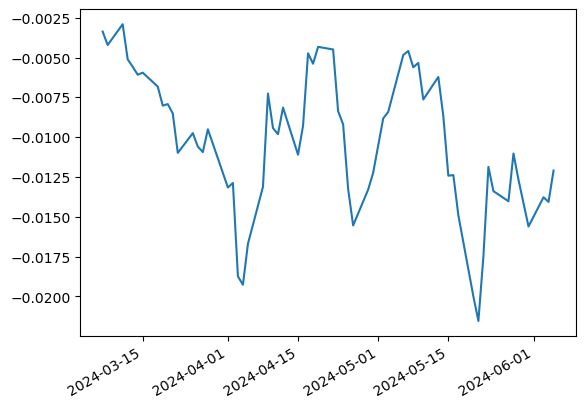

In [54]:
((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
results_df

## Generate Visualizations

In [71]:
def plot_pair_analysis(backtest_results, pair, config, period_dir):
    """Generate comprehensive analysis plots for a trading pair"""
    if 'equity_curve' in backtest_results and not backtest_results['equity_curve'].empty:
        # Create a figure with subplots
        fig = plt.figure(figsize=(15, 15))
        
        # Asset Prices
        plt.subplot(4, 1, 1)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax1.plot(backtest_results['equity_curve']['asset1_price'], 'b-', label=pair.asset1)
        ax2.plot(backtest_results['equity_curve']['asset2_price'], 'r-', label=pair.asset2)
        ax1.set_ylabel(f'{pair.asset1} Price', color='b')
        ax2.set_ylabel(f'{pair.asset2} Price', color='r')
        plt.title(f"Asset Prices: {pair.asset1} - {pair.asset2}")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        ax1.grid(True)
        
        # Spread and Z-score
        plt.subplot(4, 1, 2)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        if 'spread' in backtest_results:
            ax1.plot(backtest_results['spread'], 'b-', label='Spread')
        ax2.plot(backtest_results['equity_curve']['zscore'], 'r-', label='Z-score')
        ax1.set_ylabel('Spread', color='b')
        ax2.set_ylabel('Z-score', color='r')
        # Add horizontal lines for entry/exit thresholds
        ax2.axhline(y=config.entry_threshold, color='g', linestyle='--', alpha=0.7, label='Entry (Long)')
        ax2.axhline(y=-config.entry_threshold, color='g', linestyle='--', alpha=0.7, label='Entry (Short)')
        ax2.axhline(y=config.exit_threshold_short, color='m', linestyle='--', alpha=0.7, label='Exit Short')
        ax2.axhline(y=config.exit_threshold_long, color='m', linestyle='--', alpha=0.7, label='Exit Long')
        plt.title("Spread and Z-score")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        ax1.grid(True)
        
        # Equity curve and Positions
        plt.subplot(4, 1, 3)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax1.plot(backtest_results['equity_curve']['equity'], 'g-', label='Equity')
        ax2.plot(backtest_results['equity_curve']['position'], 'b-', label='Position')
        ax1.set_ylabel('Equity', color='g')
        ax2.set_ylabel('Position Size', color='b')
        ax2.set_ylim(-1.5, 1.5)
        plt.title("Strategy Performance")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax1.grid(True)
        
        # Returns Distribution
        plt.subplot(4, 1, 4)
        returns = backtest_results['equity_curve']['equity'].pct_change().dropna()
        plt.hist(returns, bins=50, density=True, alpha=0.75)
        plt.title(f"Returns Distribution: {pair.asset1} - {pair.asset2}")
        plt.xlabel("Returns")
        plt.ylabel("Density")
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(period_dir, f"analysis_{pair.asset1}_{pair.asset2}.png"))
        plt.close()


## Loop the entire code

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Loop through each date period
all_results = []
all_returns = []

for i in range(len(dates['rebalance_date'])):
    print(f"\n{'='*80}")
    print(f"Processing Period {i+1}/{len(dates['rebalance_date'])}")
    print(f"Rebalance Date: {dates['rebalance_date'][i]}")
    print(f"Training Start: {dates['training_start_date'][i]}")
    print(f"Testing End: {dates['testing_end_date'][i]}")
    print(f"{'='*80}")
    
    # Create a directory for this period's results
    period_dir = os.path.join('results', f"period_{i+1}_{dates['rebalance_date'][i]}")
    os.makedirs(period_dir, exist_ok=True)
    
    try:
        # Get IBX100 composition
        members = get_index_composition(index_code='IBX100', 
                                       start_date=dates['rebalance_date'][i], 
                                       end_date=dates['rebalance_date'][i])
        
        # Load price data
        print("Loading price data...")
        price_data = get_descriptors(
            tickers=[*members.columns],
            descriptors='price_close',
            start_date=dates['training_start_date'][i],
            end_date=dates['rebalance_date'][i]
        )
        price_data.dropna(axis=1, inplace=True)
        
        # Find cointegrated pairs
        print("Finding cointegrated pairs...")
        selector = CointegrationPairSelector()
        all_pairs = selector.select_pairs(price_data)
        
        # Convert to DataFrame
        results = pd.DataFrame(all_pairs)
        results_passed = results[results['passed_all_criteria']].reset_index(drop=True)

        sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
        results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])
        
        # Save pairs that passed all criteria
        results_passed.to_csv(os.path.join(period_dir, 'cointegrated_pairs.csv'), index=False)
        
        print(f"Found {len(results_passed)} cointegrated pairs")
        
        # Simulate trading performance
        print("Simulating trading performance...")
        df = pd.DataFrame()
        
        # Run simulations for each pair
        for r in range(len(results_passed)):
            if r % 10 == 0:
                print(f"  Simulating pair {r+1}/{len(results_passed)}")
                
            tickers = [results_passed.iloc[r].asset1, results_passed.iloc[r].asset2]
            pair_price_data = get_descriptors(
                tickers=tickers,
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['rebalance_date'][i]
            )
            
            eg = EngleGrangerPortfolio()
            res = eg.fit(pair_price_data, dependent_variable=results_passed.iloc[r].asset1)
            historical_spread = res.residuals
            
            simulation = CointegrationSimulation(eg, n_periods=21*3, random_seed=40)
            sim = simulation.simulate_multiple_paths(n_paths=100)
            
            for s in range(len(sim)):
                simulated_spread = sim[s][1]
                simulated_prices = sim[s][0]
                
                config = CaldeiraMouraConfig(verbose=False)
                trading_rule = CaldeiraMouraTradingRule(config)
                
                signals, position_sizes = trading_rule.generate_signals(
                    simulated_spread=simulated_spread,
                    historical_spread=historical_spread,
                    prices=simulated_prices,
                )
                
                simulation_results = trading_rule.get_portfolio_stats()
                simulation_results_df = pd.DataFrame(simulation_results, index=[0])
                simulation_results_df.insert(0, 'pair', '_'.join(tickers))
                simulation_results_df[['asset1', 'asset2']] = tickers
                simulation_results_df['same_sector'] = results_passed[(results_passed.asset1 == tickers[0]) & (results_passed.asset2 == tickers[1])]['same_sector'].values[0]
                df = pd.concat([df, simulation_results_df], axis=0, ignore_index=True)
        
        # Save simulation results
        df.to_csv(os.path.join(period_dir, 'simulation_results.csv'), index=False)
        
        # Select top 20 pairs based on Sharpe ratio
        selected_pairs = (df
                          .groupby('pair')
                          .agg({'annualized_return': 'median', 'annualized_volatility': 'median'})
                          .eval('sharpe_ratio = (annualized_return - 0.11) / annualized_volatility')
                          .query('sharpe_ratio > 0')
                          .sort_values('sharpe_ratio', ascending=False)
                          .head(20)
                        )

        selected_pairs['asset1'] = selected_pairs.index.str.split('_').str[0]
        selected_pairs['asset2'] = selected_pairs.index.str.split('_').str[1]
        
        # Save selected pairs
        selected_pairs.to_csv(os.path.join(period_dir, 'selected_pairs.csv'), index=False)
        
        print(f"Selected {len(selected_pairs)} best pairs")
        
        # Run backtests
        print("Running backtests...")
        results_df = pd.DataFrame()
        returns_df = pd.DataFrame()
        
        # Run backtest for each pair
        counter = 1
        for ix, pair in selected_pairs.iterrows():
            print(f"  Backtesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
            
            testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
            hedge_ratio = testing_data['hedge_ratio'].values[0]
            half_life = testing_data['half_life'].values[0]
            hurst = testing_data['hurst_exponent'].values[0]
            
            # Get price data for this pair
            pair_data = get_descriptors(
                tickers=[pair.asset1, pair.asset2],
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['testing_end_date'][i]
            )
            
            # Create backtester with default configuration
            config = CaldeiraMouraConfig()
            backtester = Backtester(config)
            
            # Run backtest
            backtest_results = backtester.run_backtest(
                price_data=pair_data,
                hedge_ratio=hedge_ratio,
                training_window=252,  # 1 year of data for training
            )
            
            # Extract key metrics
            metrics = {
                'pair': f"{pair.asset1}_{pair.asset2}",
                'period': i,
                'rebalance_date': dates['rebalance_date'][i],
                'half_life': half_life,
                'hurst': hurst,
                'hedge_ratio': hedge_ratio,
                'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
                'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
                'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
                'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
                'num_trades': backtest_results['portfolio_stats']['num_trades'],
                'win_rate': backtest_results['portfolio_stats']['win_rate']
            }
            
            # Add to results dataframe
            results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
            
            # Track returns
            if 'return' in backtest_results['equity_curve']:
                returns_df = pd.merge(
                    returns_df, 
                    backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), 
                    left_index=True, right_index=True, 
                    how='outer'
                )
            
            # Generate visualization
            plot_pair_analysis(backtest_results, pair, config, period_dir)
            
            counter += 1
        
        # Save backtest results
        results_df.to_csv(os.path.join(period_dir, 'backtest_results.csv'), index=False)
        returns_df.to_csv(os.path.join(period_dir, 'returns.csv'), index=False)
        
        # Plot aggregate returns
        if not returns_df.empty:
            plt.figure(figsize=(12, 8))
            ((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
            plt.title(f"Aggregate Returns - Period {i+1} ({dates['rebalance_date'][i]})")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(period_dir, 'aggregate_returns.png'))
            plt.close()
        
        # Add results to overall results
        all_results.append(results_df)
        all_returns.append(returns_df)
        
        print(f"Period {i+1} processing complete.")
        
    except Exception as e:
        print(f"Error processing period {i+1}: {str(e)}")
        continue


Processing Period 1/15
Rebalance Date: 2024-12-02
Training Start: 2023-12-01
Testing End: 2025-03-14
2025-03-20 17:36:08.802 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 17:36:08.802 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 17:36:11.486 persevera_tools.db.operations: Query returned 100 rows in 0.81 seconds


2025-03-20 17:36:11.486 persevera_tools.db.operations: Query returned 100 rows in 0.81 seconds


2025-03-20 17:36:11.607 persevera_tools.db.operations: read_sql completed in 2.806s


2025-03-20 17:36:11.607 persevera_tools.db.operations: read_sql completed in 2.806s


Loading price data...
2025-03-20 17:36:11.683 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:36:11.683 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:36:18.186 persevera_tools.db.operations: Query returned 25200 rows in 4.77 seconds


2025-03-20 17:36:18.186 persevera_tools.db.operations: Query returned 25200 rows in 4.77 seconds


2025-03-20 17:36:18.302 persevera_tools.db.operations: read_sql completed in 6.619s


2025-03-20 17:36:18.302 persevera_tools.db.operations: read_sql completed in 6.619s


Finding cointegrated pairs...
2025-03-20 17:40:15.627 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:40:15.627 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:40:17.646 persevera_tools.db.operations: Query returned 100 rows in 0.25 seconds


2025-03-20 17:40:17.646 persevera_tools.db.operations: Query returned 100 rows in 0.25 seconds


2025-03-20 17:40:17.764 persevera_tools.db.operations: read_sql completed in 2.146s


2025-03-20 17:40:17.764 persevera_tools.db.operations: read_sql completed in 2.146s


Found 84 cointegrated pairs
Selected 28 best pairs
Running backtests...
  Backtesting pair 1/28: BBDC4 - DXCO3
2025-03-20 17:40:18.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:18.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:20.251 persevera_tools.db.operations: Query returned 640 rows in 0.49 seconds


2025-03-20 17:40:20.251 persevera_tools.db.operations: Query returned 640 rows in 0.49 seconds


2025-03-20 17:40:20.363 persevera_tools.db.operations: read_sql completed in 2.327s


2025-03-20 17:40:20.363 persevera_tools.db.operations: read_sql completed in 2.327s
2025-03-20 17:40:20.463 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:20.463 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:20.468 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_DXCO3 with 252 data points
2025-03-20 17:40:20.469 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_DXCO3
2025-03-20 17:40:20.507 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -1.07
2025-03-20 17:40:20.512 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -0.95
2025-03-20 17:40:20.512 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -0.88
2025-03-20 17:40:20.512 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0683237662519798, 'asset1_price': 11.949, 'asset2_price': 6.938, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9532774850800086, 'asset1_price': 12.085, 'asset2_price': 6.987, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8769187538680864, 'asset1_price': 12.25, 'asset2_price': 7.156, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0326138861474596, 'asset1_price': 11.968, 'asset2_price': 6.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.896774842172882, 'asset1_price': 11.89, 'asset2_price': 6.58, 'holding

2025-03-20 17:40:20.539 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -1.13
2025-03-20 17:40:20.541 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -1.20
2025-03-20 17:40:20.544 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -1.12
2025-03-20 17:40:20.545 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -0.92
2025-03-20 17:40:20.546 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -1.08
2025-03-20 17:40:20.547 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -0.89
2025-03-20 17:40:20.549 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: No trading action for BBDC4_DXCO3. Z-score: -0.81
2025-03-20 17:40:20.551 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2021375965299004, 'asset1_price': 11.22, 'asset2_price': 6.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.122058488248912, 'asset1_price': 11.23, 'asset2_price': 5.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9249290070046904, 'asset1_price': 11.363, 'asset2_price': 5.87, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0768904975914162, 'asset1_price': 11.164, 'asset2_price': 5.78, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8867403594763765, 'asset1_price': 11.383, 'asset2_price': 5.86, 'holding_day

2025-03-20 17:40:22.464 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:24.652 persevera_tools.db.operations: Query returned 640 rows in 0.46 seconds


2025-03-20 17:40:24.652 persevera_tools.db.operations: Query returned 640 rows in 0.46 seconds


2025-03-20 17:40:24.769 persevera_tools.db.operations: read_sql completed in 2.305s


2025-03-20 17:40:24.769 persevera_tools.db.operations: read_sql completed in 2.305s
2025-03-20 17:40:24.790 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:24.792 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:24.793 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_IRBR3 with 252 data points
2025-03-20 17:40:24.796 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_IRBR3
2025-03-20 17:40:24.803 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.93
2025-03-20 17:40:24.804 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.96
2025-03-20 17:40:24.807 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.94
2025-03-20 17:40:24.809 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9323057378982325, 'asset1_price': 11.949, 'asset2_price': 39.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9618351392556758, 'asset1_price': 12.085, 'asset2_price': 39.87, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.935423380518216, 'asset1_price': 12.25, 'asset2_price': 40.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8631530272570167, 'asset1_price': 11.968, 'asset2_price': 38.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9463752087218877, 'asset1_price': 11.89, 'asset2_price': 38.98, 'holding

2025-03-20 17:40:24.836 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -1.37
2025-03-20 17:40:24.839 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: OPENING LONG BBDC4 / SHORT IRBR3 position. Z-score: -2.40, Size: 1,000,000.00
2025-03-20 17:40:24.846 persevera_arbitrage.trading.zscore: Position opened: LONG BBDC4 / SHORT IRBR3
2025-03-20 17:40:24.848 persevera_arbitrage.trading.zscore: Entry prices: BBDC4=11.31, IRBR3=42.85
2025-03-20 17:40:24.848 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:40:24.852 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:40:24.855 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 1, Z-score: -2.56, Return: -0.97%)
2025-03-20 17:40:24.857 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 2, Z-score: -2.28, Return: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3724835376537765, 'asset1_price': 11.22, 'asset2_price': 38.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.4030655434743005, 'asset1_price': 11.307, 'asset2_price': 42.85, 'holding_days': 0}
{'equity': 986357.2458857233, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9642.754114276779, 'position': 1, 'zscore': -2.55537172194167, 'asset1_price': 11.22, 'asset2_price': 43.35, 'holding_days': 0}
{'equity': 997257.424304953, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1257.4243049529157, 'position': 1, 'zscore': -2.2838233762875766, 'asset1_price': 11.23, 'asset2_price': 42.45, 'holding_days': 1}
{'equity': 979057.8019481534, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16942.19805184661, 'position': 1, 'zscore': -2.6555

2025-03-20 17:40:24.945 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 13, Z-score: -2.51, Return: -0.64%)
2025-03-20 17:40:24.951 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 14, Z-score: -2.31, Return: 0.67%)
2025-03-20 17:40:24.956 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 15, Z-score: -2.34, Return: 0.54%)
2025-03-20 17:40:24.958 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 16, Z-score: -2.40, Return: -0.68%)
2025-03-20 17:40:24.962 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 17, Z-score: -2.40, Return: -0.90%)
2025-03-20 17:40:24.966 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 18, Z-score: -2.42, Return: -0.89%)
2025-03-20 17:40:2

{'equity': 920541.2688873678, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': 6136.357341916725, 'position': 1, 'zscore': -2.313323448103418, 'asset1_price': 12.29, 'asset2_price': 51.99, 'holding_days': 13}
{'equity': 919301.6371615833, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': 4896.725616132288, 'position': 1, 'zscore': -2.3366533907834843, 'asset1_price': 12.459, 'asset2_price': 52.85, 'holding_days': 14}
{'equity': 908210.546226138, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': -6194.365319312991, 'position': 1, 'zscore': -2.3997124485424295, 'asset1_price': 11.97, 'asset2_price': 51.97, 'holding_days': 15}
{'equity': 906137.61960224, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': -8267.291943211003, 'position': 1, 'zscore': -2.4037782777274925, 'asset1_price': 11.98, 'asset2_price': 52.24, 'holding_days': 16}
{'equity': 906227.004338131, 'available_capital': 0.0, 'p

2025-03-20 17:40:24.992 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 26, Z-score: -2.40, Return: -3.51%)
2025-03-20 17:40:24.992 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 27, Z-score: -2.45, Return: -4.37%)
2025-03-20 17:40:24.998 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 28, Z-score: -2.46, Return: -4.57%)
2025-03-20 17:40:25.002 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 29, Z-score: -1.13, Return: 4.46%)
2025-03-20 17:40:25.003 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 30, Z-score: -1.64, Return: 0.67%)
2025-03-20 17:40:25.005 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 31, Z-score: -1.54, Return: 0.94%)
2025-03-20 17:40:25

{'equity': 882268.2110820225, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': -32136.700463428468, 'position': 1, 'zscore': -2.399985624360939, 'asset1_price': 11.82, 'asset2_price': 54.17, 'holding_days': 25}
{'equity': 874460.534014613, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': -39944.377530838035, 'position': 1, 'zscore': -2.4472690494320393, 'asset1_price': 11.611, 'asset2_price': 54.13, 'holding_days': 26}
{'equity': 872634.4378908738, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': -41770.47365457731, 'position': 1, 'zscore': -2.460894119360569, 'asset1_price': 11.751, 'asset2_price': 54.93, 'holding_days': 27}
{'equity': 955172.2967685082, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': 40767.385223057136, 'position': 1, 'zscore': -1.126172912915451, 'asset1_price': 11.521, 'asset2_price': 44.9, 'holding_days': 28}
{'equity': 920494.7345007644, 'available_capital': 0

2025-03-20 17:40:25.025 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 38, Z-score: -1.13, Return: 4.06%)
2025-03-20 17:40:25.026 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding LONG BBDC4 / SHORT IRBR3 position (Day 39, Z-score: -1.29, Return: 3.43%)
2025-03-20 17:40:25.026 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:40:25.032 persevera_arbitrage.trading.zscore: Position closed: LONG BBDC4 / SHORT IRBR3, P&L: 27,706.12 (3.43%) [LONG BBDC4: 3.75%, SHORT IRBR3: 3.11%]
2025-03-20 17:40:25.032 persevera_arbitrage.trading.zscore: Closing prices: BBDC4=12.13, IRBR3=48.54
2025-03-20 17:40:25.034 persevera_arbitrage.trading.zscore: Entry prices: BBDC4=11.69, IRBR3=50.10
2025-03-20 17:40:25.036 persevera_arbitrage.trading.zscore: Holding period: 39 days
2025-03-20 17:40:25.036 persevera_arbitrage.trading.zscore: Capital returned: 914,404.91
2025-03-2

{'equity': 951547.1884394317, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': 37142.276893980656, 'position': 1, 'zscore': -1.1273242077669854, 'asset1_price': 11.65, 'asset2_price': 45.85, 'holding_days': 37}
{'equity': 945768.6510269761, 'available_capital': 0.0, 'position_size': 914404.911545451, 'pnl_amount': 31363.739481525005, 'position': 1, 'zscore': -1.2877760060673298, 'asset1_price': 12.13, 'asset2_price': 48.54, 'holding_days': 38}
  Backtesting pair 3/28: BBSE3 - ITSA4
2025-03-20 17:40:26.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:26.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:28.919 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:40:28.919 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:40:29.036 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-20 17:40:29.036 persevera_tools.db.operations: read_sql completed in 2.248s
2025-03-20 17:40:29.058 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:29.061 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:29.063 persevera_arbitrage.trading.zscore: Stored historical spread data for BBSE3_ITSA4 with 252 data points
2025-03-20 17:40:29.068 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBSE3_ITSA4
2025-03-20 17:40:29.074 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BBSE3_ITSA4. Z-score: 1.35
2025-03-20 17:40:29.074 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BBSE3_ITSA4. Z-score: 1.31
2025-03-20 17:40:29.078 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BBSE3_ITSA4. Z-score: 1.50
2025-03-20 17:40:29.083 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3485128382709253, 'asset1_price': 33.0, 'asset2_price': 8.512, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3111011563560138, 'asset1_price': 32.963, 'asset2_price': 8.568, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4976778094285792, 'asset1_price': 33.339, 'asset2_price': 8.762, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5353910361759124, 'asset1_price': 33.358, 'asset2_price': 8.577, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6589565645085134, 'asset1_price': 33.584, 'asset2_price': 8.605, 'holding_da

2025-03-20 17:40:29.100 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:40:29.104 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 1, Z-score: 2.13, Return: -1.05%)
2025-03-20 17:40:29.107 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 2, Z-score: 2.17, Return: -1.31%)
2025-03-20 17:40:29.110 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 3, Z-score: 1.93, Return: -1.46%)
2025-03-20 17:40:29.115 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 4, Z-score: 2.38, Return: -2.54%)
2025-03-20 17:40:29.120 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 5, Z-score: 2.31, Return: -4.10%)
2025-03-20 17:40:29.124 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: Holding SHORT BBSE3 / LON

{'equity': 985517.9550908242, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10482.044909175827, 'position': -1, 'zscore': 2.134829642778428, 'asset1_price': 34.432, 'asset2_price': 8.564, 'holding_days': 0}
{'equity': 982924.9476846963, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13075.052315303756, 'position': -1, 'zscore': 2.1698134930510613, 'asset1_price': 34.507, 'asset2_price': 8.537, 'holding_days': 1}
{'equity': 981473.0399524599, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14526.960047540162, 'position': -1, 'zscore': 1.9251401346133619, 'asset1_price': 34.093, 'asset2_price': 8.406, 'holding_days': 2}
{'equity': 970719.4502018304, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25280.549798169603, 'position': -1, 'zscore': 2.378895067487902, 'asset1_price': 34.884, 'asset2_price': 8.416, 'holding_days': 3}
{'equity': 955162.4812702414, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:40:29.226 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 28, Z-score: 2.16, Return: -3.03%)
2025-03-20 17:40:29.232 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 29, Z-score: 2.46, Return: -2.82%)
2025-03-20 17:40:29.236 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 30, Z-score: 2.64, Return: -3.44%)
2025-03-20 17:40:29.239 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 31, Z-score: 2.47, Return: -3.13%)
2025-03-20 17:40:29.246 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 32, Z-score: 2.32, Return: -1.74%)
2025-03-20 17:40:29.255 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 33, Z-score: 2.27, Return: -1.99%)


{'equity': 967893.3104708022, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28106.68952919776, 'position': -1, 'zscore': 2.4573927644303493, 'asset1_price': 36.325, 'asset2_price': 8.732, 'holding_days': 28}
{'equity': 961698.5332580125, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34301.46674198749, 'position': -1, 'zscore': 2.6366433446867337, 'asset1_price': 36.758, 'asset2_price': 8.732, 'holding_days': 29}
{'equity': 964825.7513644418, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31174.24863555813, 'position': -1, 'zscore': 2.4680078574193933, 'asset1_price': 36.504, 'asset2_price': 8.723, 'holding_days': 30}
{'equity': 978655.62394314, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17344.376056859925, 'position': -1, 'zscore': 2.321787855523756, 'asset1_price': 36.344, 'asset2_price': 8.928, 'holding_days': 31}
{'equity': 976175.4249005393, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:40:29.260 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 34, Z-score: 2.48, Return: -3.18%)
2025-03-20 17:40:29.269 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 35, Z-score: 2.42, Return: -3.02%)
2025-03-20 17:40:29.274 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 36, Z-score: 2.49, Return: -2.82%)
2025-03-20 17:40:29.278 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 37, Z-score: 2.65, Return: -3.13%)
2025-03-20 17:40:29.286 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 38, Z-score: 2.42, Return: -3.07%)


{'equity': 964344.4749265632, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31655.525073436744, 'position': -1, 'zscore': 2.4773359516798017, 'asset1_price': 36.758, 'asset2_price': 8.779, 'holding_days': 33}
{'equity': 965901.4667926498, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30098.533207350178, 'position': -1, 'zscore': 2.417469412795707, 'asset1_price': 36.72, 'asset2_price': 8.797, 'holding_days': 34}
{'equity': 967923.0655749897, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28076.934425010306, 'position': -1, 'zscore': 2.4913857806284856, 'asset1_price': 36.984, 'asset2_price': 8.9, 'holding_days': 35}
{'equity': 964824.6030807168, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31175.396919283186, 'position': -1, 'zscore': 2.6451790019896184, 'asset1_price': 37.417, 'asset2_price': 8.955, 'holding_days': 36}
{'equity': 965383.2075323203, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:40:29.290 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 39, Z-score: 2.53, Return: -3.28%)
2025-03-20 17:40:29.293 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 40, Z-score: 2.22, Return: -1.79%)
2025-03-20 17:40:29.302 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 41, Z-score: 2.25, Return: -3.20%)
2025-03-20 17:40:29.307 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 42, Z-score: 1.94, Return: -1.92%)
2025-03-20 17:40:29.311 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 43, Z-score: 2.05, Return: -0.98%)
2025-03-20 17:40:29.319 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 44, Z-score: 1.65, Return: 0.63%)
2025-03-20 17:40:29.322

{'equity': 963307.9564059044, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32692.04359409567, 'position': -1, 'zscore': 2.5303478551868084, 'asset1_price': 37.342, 'asset2_price': 8.909, 'holding_days': 38}
{'equity': 978203.1031174178, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17796.896882582278, 'position': -1, 'zscore': 2.2187969469521214, 'asset1_price': 36.777, 'asset2_price': 9.03, 'holding_days': 39}
{'equity': 964141.7494781621, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31858.250521837825, 'position': -1, 'zscore': 2.2487639349951842, 'asset1_price': 36.843, 'asset2_price': 8.797, 'holding_days': 40}
{'equity': 976847.8372077012, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19152.16279229879, 'position': -1, 'zscore': 1.943631987021038, 'asset1_price': 36.25, 'asset2_price': 8.872, 'holding_days': 41}
{'equity': 986234.4226778026, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:40:29.421 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 9, Z-score: 2.53, Return: -1.96%)
2025-03-20 17:40:29.424 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding SHORT BBSE3 / LONG ITSA4 position (Day 10, Z-score: 2.70, Return: -1.26%)
2025-03-20 17:40:29.424 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:40:29.429 persevera_arbitrage.trading.zscore: Position closed: SHORT BBSE3 / LONG ITSA4, P&L: -15,900.52 (-1.26%) [SHORT BBSE3: -6.08%, LONG ITSA4: 3.56%]
2025-03-20 17:40:29.433 persevera_arbitrage.trading.zscore: Closing prices: BBSE3=39.81, ITSA4=9.26
2025-03-20 17:40:29.435 persevera_arbitrage.trading.zscore: Entry prices: BBSE3=37.53, ITSA4=8.94
2025-03-20 17:40:29.437 persevera_arbitrage.trading.zscore: Holding period: 10 days
2025-03-20 17:40:29.440 persevera_arbitrage.trading.zscore: Capital returned: 958,183.43
2025-03-2

{'equity': 939411.5116831723, 'available_capital': 0.0, 'position_size': 958183.4330560152, 'pnl_amount': -18771.921372842873, 'position': -1, 'zscore': 2.533288009168415, 'asset1_price': 39.16, 'asset2_price': 8.98, 'holding_days': 8}
{'equity': 946115.646950928, 'available_capital': 0.0, 'position_size': 958183.4330560152, 'pnl_amount': -12067.786105087136, 'position': -1, 'zscore': 2.7035926223891678, 'asset1_price': 39.81, 'asset2_price': 9.26, 'holding_days': 9}


2025-03-20 17:40:29.460 persevera_arbitrage.trading.zscore: Cumulative P&L: -57,717.09 (-5.77%)
2025-03-20 17:40:29.460 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:40:29.467 persevera_arbitrage.trading.zscore: Annualized: -18.56% return, 12.98% volatility
2025-03-20 17:40:29.468 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.20, Calmar -0.80
2025-03-20 17:40:29.471 persevera_arbitrage.trading.zscore: Max drawdown: 6.72%


  Backtesting pair 4/28: BBSE3 - ITUB4
2025-03-20 17:40:32.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:32.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:34.459 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:40:34.459 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:40:34.575 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-20 17:40:34.575 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-20 17:40:34.587 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:34.587 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:34.595 persevera_arbitrage.trading.zscore: Stored historical spread data for BBSE3_ITUB4 with 252 data points
2025-03-20 17:40:34.595 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBSE3_ITUB4
2025-03-20 17:40:34.601 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING SHORT BBSE3 / LONG ITUB4 position. Z-score: 3.49, Size: 1,000,000.00
2025-03-20 17:40:34.601 persevera_arbitrage.trading.zscore: Position opened: SHORT BBSE3 / LONG ITUB4
2025-03-20 17:40:34.601 persevera_arbitrage.trading.zscore: Entry prices: BBSE3=33.00, ITUB4=30.69
2025-03-20 17:40:34.605 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.4871726390006894, 'asset1_price': 33.0, 'asset2_price': 30.687, 'holding_days': 0}
{'equity': 999625.525626783, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3625.5256267830114, 'position': -1, 'zscore': 3.131491003545959, 'asset1_price': 32.963, 'asset2_price': 30.876, 'holding_days': 0}
{'equity': 1004694.5249602289, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8694.524960228999, 'position': -1, 'zscore': 2.7412149082731707, 'asset1_price': 33.339, 'asset2_price': 31.538, 'holding_days': 1}
{'equity': 993972.9555719479, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2027.0444280521192, 'position': -1, 'zscore': 3.434953309486464, 'asset1_price': 33.358, 'asset2_price': 30.895, 'holding_days': 2}
{'equity': 993012.8940356739, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2987.1059643261083, '

2025-03-20 17:40:34.646 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 9, Z-score: 4.15, Return: -2.37%)
2025-03-20 17:40:34.652 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 10, Z-score: 4.56, Return: -3.31%)
2025-03-20 17:40:34.655 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 11, Z-score: 4.95, Return: -4.48%)
2025-03-20 17:40:34.658 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 12, Z-score: 4.92, Return: -4.87%)
2025-03-20 17:40:34.663 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 13, Z-score: 3.84, Return: -3.17%)
2025-03-20 17:40:34.667 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 14, Z-score: 4.12, Return: -4.06%)
2025-03-20 17:40:34.671

{'equity': 963041.0119535368, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32958.98804646324, 'position': -1, 'zscore': 4.5628795655735335, 'asset1_price': 34.884, 'asset2_price': 30.408, 'holding_days': 9}
{'equity': 951369.3319706005, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44630.668029399516, 'position': -1, 'zscore': 4.945357229223633, 'asset1_price': 34.724, 'asset2_price': 29.54, 'holding_days': 10}
{'equity': 947463.964326025, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -48536.03567397501, 'position': -1, 'zscore': 4.917500618751112, 'asset1_price': 35.157, 'asset2_price': 29.702, 'holding_days': 11}
{'equity': 964393.7498911294, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31606.25010887054, 'position': -1, 'zscore': 3.8422356638084807, 'asset1_price': 34.404, 'asset2_price': 30.045, 'holding_days': 12}
{'equity': 955538.5212808504, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:40:34.760 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 36, Z-score: 2.58, Return: -3.91%)
2025-03-20 17:40:34.765 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 37, Z-score: 2.44, Return: -3.65%)
2025-03-20 17:40:34.767 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 38, Z-score: 1.93, Return: -2.15%)
2025-03-20 17:40:34.769 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 39, Z-score: 2.00, Return: -2.42%)
2025-03-20 17:40:34.771 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 40, Z-score: 2.36, Return: -3.61%)
2025-03-20 17:40:34.783 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 41, Z-score: 2.25, Return: -3.36%)
2025-03-20 17:40:34.78

{'equity': 959625.7071605684, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -36374.29283943157, 'position': -1, 'zscore': 2.4445959799928394, 'asset1_price': 36.504, 'asset2_price': 31.704, 'holding_days': 36}
{'equity': 974584.782872226, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21415.217127774024, 'position': -1, 'zscore': 1.934472418788507, 'asset1_price': 36.344, 'asset2_price': 32.477, 'holding_days': 37}
{'equity': 971886.0978323661, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24113.902167633834, 'position': -1, 'zscore': 1.995722120209144, 'asset1_price': 36.297, 'asset2_price': 32.267, 'holding_days': 38}
{'equity': 960093.1343861925, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -35906.8656138075, 'position': -1, 'zscore': 2.3556069013772394, 'asset1_price': 36.758, 'asset2_price': 31.969, 'holding_days': 39}
{'equity': 962532.8515184101, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:40:34.789 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 43, Z-score: 2.27, Return: -3.53%)
2025-03-20 17:40:34.794 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 44, Z-score: 2.15, Return: -3.31%)
2025-03-20 17:40:34.796 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 45, Z-score: 2.12, Return: -3.23%)
2025-03-20 17:40:34.803 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 46, Z-score: 1.66, Return: -1.81%)
2025-03-20 17:40:34.805 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 47, Z-score: 2.10, Return: -3.41%)
2025-03-20 17:40:34.813 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT BBSE3 / LONG ITUB4 position (Day 48, Z-score: 1.71, Return: -2.23%)
2025-03-20 17:40:34.81

{'equity': 960842.721335952, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -35157.27866404793, 'position': -1, 'zscore': 2.2689975132556293, 'asset1_price': 37.417, 'asset2_price': 32.628, 'holding_days': 42}
{'equity': 963075.9590113669, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32924.040988633016, 'position': -1, 'zscore': 2.154286208840053, 'asset1_price': 37.012, 'asset2_price': 32.389, 'holding_days': 43}
{'equity': 963824.5737342137, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32175.426265786264, 'position': -1, 'zscore': 2.118428919164207, 'asset1_price': 37.342, 'asset2_price': 32.742, 'holding_days': 44}
{'equity': 977933.4967605469, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -18066.503239453046, 'position': -1, 'zscore': 1.6563423262961947, 'asset1_price': 36.777, 'asset2_price': 33.086, 'holding_days': 45}
{'equity': 962056.081177401, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 17:40:34.835 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:40:34.837 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:40:34.838 persevera_arbitrage.trading.zscore: Available capital: 991,827.97
2025-03-20 17:40:34.840 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: No trading action for BBSE3_ITUB4. Z-score: 1.81
2025-03-20 17:40:34.842 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: No trading action for BBSE3_ITUB4. Z-score: 1.95
2025-03-20 17:40:34.849 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: OPENING SHORT BBSE3 / LONG ITUB4 position. Z-score: 2.03, Size: 991,827.97
2025-03-20 17:40:34.849 persevera_arbitrage.trading.zscore: Position opened: SHORT BBSE3 / LONG ITUB4
2025-03-20 17:40:34.849 persevera_arbitrage.trading.zscore: Entry prices: BBSE3=37.54, ITUB4=32.80
2025-03-20 17:40:34.849 persevera_arbitrage.trading.zscore: Position size: 987,860.66 (493,930.33 per leg)
2025-03-20 17

{'equity': 991827.9692496379, 'available_capital': 991827.9692496379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8124688762715908, 'asset1_price': 37.389, 'asset2_price': 33.2, 'holding_days': 0}
{'equity': 991827.9692496379, 'available_capital': 991827.9692496379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9540434642742164, 'asset1_price': 37.427, 'asset2_price': 32.89, 'holding_days': 0}
{'equity': 991827.9692496379, 'available_capital': 991827.9692496379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.025483190085211, 'asset1_price': 37.54, 'asset2_price': 32.8, 'holding_days': 0}
{'equity': 993065.067046529, 'available_capital': 0.0, 'position_size': 987860.6573726394, 'pnl_amount': 5204.409673889638, 'position': -1, 'zscore': 1.8103615370658537, 'asset1_price': 37.03, 'asset2_price': 32.7, 'holding_days': 0}
{'equity': 984302.0509984288, 'available_capital': 0.0, 'position_size': 987860.6573726394, 'pnl_amount'

2025-03-20 17:40:34.951 persevera_arbitrage.trading.zscore: Cumulative P&L: -23,219.31 (-2.32%)
2025-03-20 17:40:34.955 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:40:34.958 persevera_arbitrage.trading.zscore: Annualized: -6.96% return, 11.77% volatility
2025-03-20 17:40:34.962 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.44, Calmar -0.33
2025-03-20 17:40:34.966 persevera_arbitrage.trading.zscore: Max drawdown: 5.81%


  Backtesting pair 5/28: BEEF3 - RADL3
2025-03-20 17:40:38.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:38.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:40.478 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:40:40.478 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:40:40.595 persevera_tools.db.operations: read_sql completed in 2.260s


2025-03-20 17:40:40.595 persevera_tools.db.operations: read_sql completed in 2.260s
2025-03-20 17:40:40.616 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:40.618 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:40.620 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_RADL3 with 252 data points
2025-03-20 17:40:40.622 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_RADL3
2025-03-20 17:40:40.629 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BEEF3_RADL3. Z-score: 1.66
2025-03-20 17:40:40.631 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BEEF3_RADL3. Z-score: 1.26
2025-03-20 17:40:40.634 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BEEF3_RADL3. Z-score: 1.09
2025-03-20 17:40:40.640 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6550330863230047, 'asset1_price': 6.06, 'asset2_price': 23.989, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.262406872566141, 'asset1_price': 6.05, 'asset2_price': 24.478, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0855464478149108, 'asset1_price': 6.07, 'asset2_price': 24.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.476950547712648, 'asset1_price': 5.91, 'asset2_price': 24.14, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.456738336747793, 'asset1_price': 6.11, 'asset2_price': 24.2, 'holding_days': 0}
{'e

2025-03-20 17:40:40.663 persevera_arbitrage.trading.zscore: Entry prices: BEEF3=6.05, RADL3=23.30
2025-03-20 17:40:40.665 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:40:40.667 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:40:40.676 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 1, Z-score: 1.60, Return: 3.19%)
2025-03-20 17:40:40.678 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 2, Z-score: 2.67, Return: 4.01%)
2025-03-20 17:40:40.684 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 3, Z-score: 2.40, Return: 2.99%)
2025-03-20 17:40:40.691 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 4, Z-score: 2.33, Return: 3.03%)
2025-03-20 17:40:40.694 persevera_arbitrage.trading.zscore: 2024-12

{'equity': 1027724.4706132727, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 31724.470613272788, 'position': -1, 'zscore': 1.6033820991052732, 'asset1_price': 5.81, 'asset2_price': 23.86, 'holding_days': 0}
{'equity': 1035966.4739474338, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 39966.473947433784, 'position': -1, 'zscore': 2.669243451830303, 'asset1_price': 5.31, 'asset2_price': 22.32, 'holding_days': 1}
{'equity': 1025765.5375447806, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29765.5375447806, 'position': -1, 'zscore': 2.3993786872315215, 'asset1_price': 5.53, 'asset2_price': 22.69, 'holding_days': 2}
{'equity': 1026224.8004823893, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 30224.800482389233, 'position': -1, 'zscore': 2.3253165674914618, 'asset1_price': 5.54, 'asset2_price': 22.75, 'holding_days': 3}
{'equity': 1031677.6646685348, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 356

2025-03-20 17:40:40.779 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 22, Z-score: 2.13, Return: 5.92%)
2025-03-20 17:40:40.781 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 23, Z-score: 2.69, Return: 5.20%)
2025-03-20 17:40:40.791 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 24, Z-score: 2.61, Return: 7.80%)
2025-03-20 17:40:40.793 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 25, Z-score: 2.62, Return: 7.90%)
2025-03-20 17:40:40.799 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 26, Z-score: 2.69, Return: 4.09%)
2025-03-20 17:40:40.806 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 27, Z-score: 2.46, Return: 5.23%)


{'equity': 1047810.1585499947, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 51810.158549994645, 'position': -1, 'zscore': 2.694065413024777, 'asset1_price': 4.8, 'asset2_price': 20.91, 'holding_days': 22}
{'equity': 1073723.1866066044, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 77723.18660660445, 'position': -1, 'zscore': 2.60771512081681, 'asset1_price': 4.48, 'asset2_price': 20.89, 'holding_days': 23}
{'equity': 1074664.6756287022, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 78664.67562870213, 'position': -1, 'zscore': 2.6227926307565554, 'asset1_price': 4.44, 'asset2_price': 20.78, 'holding_days': 24}
{'equity': 1036736.6225658852, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 40736.622565885154, 'position': -1, 'zscore': 2.69111977157455, 'asset1_price': 4.88, 'asset2_price': 20.7, 'holding_days': 25}
{'equity': 1048087.4827084737, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 52087

2025-03-20 17:40:40.811 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 28, Z-score: 2.15, Return: 6.28%)
2025-03-20 17:40:40.815 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 29, Z-score: 1.79, Return: 6.49%)
2025-03-20 17:40:40.827 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 30, Z-score: 2.32, Return: 5.26%)
2025-03-20 17:40:40.832 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 31, Z-score: 2.60, Return: 4.22%)
2025-03-20 17:40:40.841 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 32, Z-score: 2.79, Return: 4.39%)
2025-03-20 17:40:40.846 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 33, Z-score: 2.91, Return: 4.45%)
2025-03-20 17:40:40.849 pers

{'equity': 1058528.6489554145, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 62528.64895541445, 'position': -1, 'zscore': 2.153842770815671, 'asset1_price': 4.81, 'asset2_price': 21.45, 'holding_days': 27}
{'equity': 1060651.8568438974, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 64651.85684389738, 'position': -1, 'zscore': 1.793587675130026, 'asset1_price': 4.94, 'asset2_price': 22.05, 'holding_days': 28}
{'equity': 1048364.8068669527, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 52364.80686695274, 'position': -1, 'zscore': 2.3163108109127357, 'asset1_price': 4.84, 'asset2_price': 21.09, 'holding_days': 29}
{'equity': 1038041.9891462419, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 42041.989146241955, 'position': -1, 'zscore': 2.5995353502267156, 'asset1_price': 4.82, 'asset2_price': 20.53, 'holding_days': 30}
{'equity': 1039734.1964317384, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4

2025-03-20 17:40:40.864 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 36, Z-score: 2.73, Return: 5.40%)
2025-03-20 17:40:40.874 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 37, Z-score: 2.59, Return: 5.19%)
2025-03-20 17:40:40.877 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 38, Z-score: 2.70, Return: 6.01%)
2025-03-20 17:40:40.884 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 39, Z-score: 2.70, Return: 6.41%)
2025-03-20 17:40:40.891 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 40, Z-score: 2.44, Return: 5.56%)
2025-03-20 17:40:40.900 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 41, Z-score: 2.56, Return: 3.76%)
2025-03-20 17:40:40.913 pers

{'equity': 1049784.9891817118, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 53784.98918171173, 'position': -1, 'zscore': 2.733064223520689, 'asset1_price': 4.48, 'asset2_price': 19.77, 'holding_days': 35}
{'equity': 1047688.277231937, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 51688.27723193699, 'position': -1, 'zscore': 2.586475544701981, 'asset1_price': 4.56, 'asset2_price': 19.98, 'holding_days': 36}
{'equity': 1055847.2599581454, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 59847.25995814555, 'position': -1, 'zscore': 2.6972181273739926, 'asset1_price': 4.37, 'asset2_price': 19.63, 'holding_days': 37}
{'equity': 1059867.577058135, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 63867.57705813502, 'position': -1, 'zscore': 2.6993174512266846, 'asset1_price': 4.29, 'asset2_price': 19.51, 'holding_days': 38}
{'equity': 1051408.307026567, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 55408

2025-03-20 17:40:40.963 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 47, Z-score: 2.84, Return: 3.56%)
2025-03-20 17:40:40.968 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 48, Z-score: 2.83, Return: 3.79%)
2025-03-20 17:40:40.980 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 49, Z-score: 2.73, Return: 2.40%)
2025-03-20 17:40:40.992 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 50, Z-score: 3.12, Return: 0.77%)


{'equity': 1031418.0044691946, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35418.004469194515, 'position': -1, 'zscore': 2.837542492717273, 'asset1_price': 4.35, 'asset2_price': 18.41, 'holding_days': 46}
{'equity': 1033792.0405774483, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 37792.04057744828, 'position': -1, 'zscore': 2.8276316876536742, 'asset1_price': 4.29, 'asset2_price': 18.29, 'holding_days': 47}
{'equity': 1019925.8326534955, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23925.83265349546, 'position': -1, 'zscore': 2.7259812528114344, 'asset1_price': 4.5, 'asset2_price': 18.45, 'holding_days': 48}
{'equity': 1003641.4287234419, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7641.428723441938, 'position': -1, 'zscore': 3.120647896757799, 'asset1_price': 4.42, 'asset2_price': 17.38, 'holding_days': 49}


2025-03-20 17:40:40.994 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: CLOSING SHORT BEEF3 / LONG RADL3 position. Reason: Maximum holding period reached (50 days)
2025-03-20 17:40:41.001 persevera_arbitrage.trading.zscore: Position closed: SHORT BEEF3 / LONG RADL3, P&L: 3,657.43 (0.77%) [SHORT BEEF3: 26.94%, LONG RADL3: -25.41%]
2025-03-20 17:40:41.011 persevera_arbitrage.trading.zscore: Closing prices: BEEF3=4.42, RADL3=17.38
2025-03-20 17:40:41.013 persevera_arbitrage.trading.zscore: Entry prices: BEEF3=6.05, RADL3=23.30
2025-03-20 17:40:41.016 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:40:41.023 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:40:41.027 persevera_arbitrage.trading.zscore: Available capital: 999,657.43
2025-03-20 17:40:41.033 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: OPENING SHORT BEEF3 / LONG RADL3 position. Z-score: 2.88, Size: 999,657.43
2025-03-20 17:40:41.038 persevera_arbitrag

{'equity': 999657.4287234419, 'available_capital': 999657.4287234419, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.883781883351406, 'asset1_price': 4.62, 'asset2_price': 17.83, 'holding_days': 0}


2025-03-20 17:40:41.049 persevera_arbitrage.trading.zscore: Entry prices: BEEF3=4.62, RADL3=17.83
2025-03-20 17:40:41.051 persevera_arbitrage.trading.zscore: Position size: 995,658.80 (497,829.40 per leg)
2025-03-20 17:40:41.056 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:40:41.064 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 1, Z-score: 2.85, Return: -1.57%)
2025-03-20 17:40:41.072 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 2, Z-score: 2.80, Return: -1.90%)
2025-03-20 17:40:41.079 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 3, Z-score: 2.73, Return: -1.84%)
2025-03-20 17:40:41.083 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: Holding SHORT BEEF3 / LONG RADL3 position (Day 4, Z-score: 2.73, Return: -1.26%)
2025-03-20 17:40:41.091 persevera_arbitrage.trading.zscore: 202

{'equity': 980014.641907248, 'available_capital': 0.0, 'position_size': 995658.7990085481, 'pnl_amount': -15644.15710130016, 'position': -1, 'zscore': 2.8482269024187277, 'asset1_price': 4.76, 'asset2_price': 17.81, 'holding_days': 0}
{'equity': 976781.9834689085, 'available_capital': 0.0, 'position_size': 995658.7990085481, 'pnl_amount': -18876.81553963963, 'position': -1, 'zscore': 2.795402058649309, 'asset1_price': 4.79, 'asset2_price': 17.81, 'holding_days': 1}
{'equity': 977340.4011912913, 'available_capital': 0.0, 'position_size': 995658.7990085481, 'pnl_amount': -18318.397817256853, 'position': -1, 'zscore': 2.733501596984356, 'asset1_price': 4.79, 'asset2_price': 17.83, 'holding_days': 2}
{'equity': 983129.45244963, 'available_capital': 0.0, 'position_size': 995658.7990085481, 'pnl_amount': -12529.34655891815, 'position': -1, 'zscore': 2.728572652545986, 'asset1_price': 4.7, 'asset2_price': 17.69, 'holding_days': 3}
{'equity': 986427.9848400686, 'available_capital': 0.0, 'posit

2025-03-20 17:40:41.147 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.43, Calmar -0.40
2025-03-20 17:40:41.148 persevera_arbitrage.trading.zscore: Max drawdown: 11.73%


  Backtesting pair 6/28: BPAC11 - CCRO3
2025-03-20 17:40:43.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:43.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:45.689 persevera_tools.db.operations: Query returned 640 rows in 0.52 seconds


2025-03-20 17:40:45.689 persevera_tools.db.operations: Query returned 640 rows in 0.52 seconds


2025-03-20 17:40:46.361 persevera_tools.db.operations: read_sql completed in 2.902s


2025-03-20 17:40:46.361 persevera_tools.db.operations: read_sql completed in 2.902s
2025-03-20 17:40:46.579 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:46.588 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:46.593 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_CCRO3 with 252 data points
2025-03-20 17:40:46.595 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_CCRO3
2025-03-20 17:40:46.611 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BPAC11_CCRO3. Z-score: 0.86
2025-03-20 17:40:46.620 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BPAC11_CCRO3. Z-score: 1.69
2025-03-20 17:40:46.623 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BPAC11_CCRO3. Z-score: 1.52
2025-03-20 17:40:46.626 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8556292881454078, 'asset1_price': 29.585, 'asset2_price': 10.79, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6915501294146453, 'asset1_price': 30.225, 'asset2_price': 10.69, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5154638225988772, 'asset1_price': 30.5, 'asset2_price': 10.86, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.548237410641771, 'asset1_price': 30.116, 'asset2_price': 10.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4240570122909704, 'asset1_price': 29.88, 'asset2_price': 10.66, 'holding_days'

2025-03-20 17:40:46.794 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 9, Z-score: 1.91, Return: 0.66%)
2025-03-20 17:40:46.806 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 10, Z-score: 1.68, Return: 1.05%)
2025-03-20 17:40:46.811 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 11, Z-score: 1.34, Return: 1.80%)
2025-03-20 17:40:46.822 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 12, Z-score: 2.44, Return: -0.21%)
2025-03-20 17:40:46.828 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 13, Z-score: 1.90, Return: 0.69%)
2025-03-20 17:40:46.837 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT BPAC11 / LONG CCRO3 position (Day 14, Z-score: 1.55, Return: 1.27%)
2025-03-20 17:40:46.84

{'equity': 1006475.9062776304, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10475.90627763034, 'position': -1, 'zscore': 1.6771298594593556, 'asset1_price': 31.23, 'asset2_price': 11.03, 'holding_days': 9}
{'equity': 1013924.6242263485, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17924.624226348482, 'position': -1, 'zscore': 1.3355984730189259, 'asset1_price': 32.05, 'asset2_price': 11.47, 'holding_days': 10}
{'equity': 993890.1414677277, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2109.8585322722647, 'position': -1, 'zscore': 2.4381721760064528, 'asset1_price': 32.57, 'asset2_price': 11.23, 'holding_days': 11}
{'equity': 1002824.9336870027, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6824.933687002693, 'position': -1, 'zscore': 1.897666982396885, 'asset1_price': 32.0, 'asset2_price': 11.22, 'holding_days': 12}
{'equity': 1008622.4580017683, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:40:46.987 persevera_arbitrage.trading.zscore: Closing prices: BPAC11=33.94, CCRO3=11.69
2025-03-20 17:40:46.993 persevera_arbitrage.trading.zscore: Entry prices: BPAC11=33.38, CCRO3=11.54
2025-03-20 17:40:46.994 persevera_arbitrage.trading.zscore: Holding period: 1 days
2025-03-20 17:40:46.995 persevera_arbitrage.trading.zscore: Capital returned: 1,018,363.19
2025-03-20 17:40:46.999 persevera_arbitrage.trading.zscore: Available capital: 1,012,365.92
2025-03-20 17:40:47.009 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1012365.924561583, 'cumulative_pnl': 12365.924561582971, 'cumulative_return': 0.012365924561582971, 'max_drawdown': 0.02701528996652505, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': 0.06229010762807108, 'annualized_volatility': 0.08102987960967048, 'sharpe_ratio': -0.46538255460308564, 'calmar_ratio': 0.6085212242593324}
2025-03-20 17:40:47.009 persevera_arbitrage.trading.zsco

  Backtesting pair 7/28: BPAC11 - CYRE3
2025-03-20 17:40:48.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:48.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:50.977 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:40:50.977 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:40:51.096 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-20 17:40:51.096 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-20 17:40:51.103 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:51.103 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:51.103 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_CYRE3 with 252 data points
2025-03-20 17:40:51.113 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_CYRE3
2025-03-20 17:40:51.117 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 0.53
2025-03-20 17:40:51.118 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 0.94
2025-03-20 17:40:51.119 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 0.66
2025-03-20 17:40:51.120 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5257635293887786, 'asset1_price': 29.585, 'asset2_price': 18.36, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.943287557039131, 'asset1_price': 30.225, 'asset2_price': 18.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6628304463443339, 'asset1_price': 30.5, 'asset2_price': 18.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6997033051797668, 'asset1_price': 30.116, 'asset2_price': 18.54, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.69303624680494, 'asset1_price': 29.88, 'asset2_price': 18.39, 'holding_days': 

2025-03-20 17:40:51.164 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.79
2025-03-20 17:40:51.164 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.21
2025-03-20 17:40:51.168 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.77
2025-03-20 17:40:51.169 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.52
2025-03-20 17:40:51.169 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.33
2025-03-20 17:40:51.172 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.53
2025-03-20 17:40:51.175 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: No trading action for BPAC11_CYRE3. Z-score: 1.34
2025-03-20 17:40:51.176 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.792691232080605, 'asset1_price': 28.6, 'asset2_price': 16.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2078350755499399, 'asset1_price': 27.73, 'asset2_price': 16.51, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7660236038026105, 'asset1_price': 28.32, 'asset2_price': 16.39, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5174824677478522, 'asset1_price': 28.52, 'asset2_price': 16.73, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3338283589256066, 'asset1_price': 30.16, 'asset2_price': 17.94, 'holding_days': 

2025-03-20 17:40:53.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:55.381 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:40:55.381 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:40:55.495 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-20 17:40:55.495 persevera_tools.db.operations: read_sql completed in 2.229s
2025-03-20 17:40:55.513 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:55.516 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:55.516 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_EZTC3 with 252 data points
2025-03-20 17:40:55.516 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_EZTC3
2025-03-20 17:40:55.519 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.32
2025-03-20 17:40:55.526 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.58
2025-03-20 17:40:55.527 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.33
2025-03-20 17:40:55.529 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3224972950332468, 'asset1_price': 29.585, 'asset2_price': 11.93, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5827630152192479, 'asset1_price': 30.225, 'asset2_price': 11.92, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3285358487070842, 'asset1_price': 30.5, 'asset2_price': 12.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3503670169612798, 'asset1_price': 30.116, 'asset2_price': 12.1, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4062487634220504, 'asset1_price': 29.88, 'asset2_price': 11.94, 'holding_days

2025-03-20 17:40:55.566 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.21
2025-03-20 17:40:55.571 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.26
2025-03-20 17:40:55.571 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.34
2025-03-20 17:40:55.575 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.50
2025-03-20 17:40:55.577 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 1.04
2025-03-20 17:40:55.580 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 1.10
2025-03-20 17:40:55.583 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.79
2025-03-20 17:40:55.583 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2603992462503006, 'asset1_price': 26.572, 'asset2_price': 10.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3393099496860649, 'asset1_price': 27.55, 'asset2_price': 10.94, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5026285621512521, 'asset1_price': 28.04, 'asset2_price': 11.03, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0422138769542126, 'asset1_price': 27.92, 'asset2_price': 10.61, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.099361486671236, 'asset1_price': 28.6, 'asset2_price': 10.85, 'holding_days':

2025-03-20 17:40:55.678 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: No trading action for BPAC11_EZTC3. Z-score: -0.14
2025-03-20 17:40:55.678 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: No trading action for BPAC11_EZTC3. Z-score: -0.63
2025-03-20 17:40:55.681 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: No trading action for BPAC11_EZTC3. Z-score: -0.50
2025-03-20 17:40:55.684 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: No trading action for BPAC11_EZTC3. Z-score: -0.61
2025-03-20 17:40:55.685 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: No trading action for BPAC11_EZTC3. Z-score: 0.28
2025-03-20 17:40:55.687 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: OPENING LONG BPAC11 / SHORT EZTC3 position. Z-score: -3.12, Size: 1,000,000.00
2025-03-20 17:40:55.690 persevera_arbitrage.trading.zscore: Position opened: LONG BPAC11 / SHORT EZTC3
2025-03-20 17:40:55.692 persevera_arbitrage.trading.zscore: Entry prices: BPAC

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6258353205961713, 'asset1_price': 31.88, 'asset2_price': 13.24, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5016979207623031, 'asset1_price': 31.93, 'asset2_price': 13.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6091011837218973, 'asset1_price': 32.33, 'asset2_price': 13.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2821313538845869, 'asset1_price': 33.38, 'asset2_price': 13.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.120794421487605, 'asset1_price': 33.94, 'asset2_price': 15.64, 'holding_da

2025-03-20 17:40:55.710 persevera_arbitrage.trading.zscore: Holding period: 0 days
2025-03-20 17:40:55.712 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:40:55.712 persevera_arbitrage.trading.zscore: Available capital: 992,016.00
2025-03-20 17:40:55.728 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 992016.0, 'cumulative_pnl': -7984.0, 'cumulative_return': -0.007984, 'max_drawdown': 0.007984, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:40:55.730 persevera_arbitrage.trading.zscore: Cumulative P&L: -7,984.00 (-0.80%)
2025-03-20 17:40:55.731 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:40:55.734 persevera_arbitrage.trading.zscore: Annualized: 0.00% return, 0.00% volatility
2025-03-20 17:40:55.737 persevera_arbitrage.trading.zscore: Risk metrics:

  Backtesting pair 9/28: BPAC11 - IGTI11
2025-03-20 17:40:57.506 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:57.506 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:40:59.667 persevera_tools.db.operations: Query returned 640 rows in 0.43 seconds


2025-03-20 17:40:59.667 persevera_tools.db.operations: Query returned 640 rows in 0.43 seconds


2025-03-20 17:40:59.784 persevera_tools.db.operations: read_sql completed in 2.278s


2025-03-20 17:40:59.784 persevera_tools.db.operations: read_sql completed in 2.278s
2025-03-20 17:40:59.799 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:40:59.799 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:40:59.802 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_IGTI11 with 252 data points
2025-03-20 17:40:59.807 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_IGTI11
2025-03-20 17:40:59.813 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.87
2025-03-20 17:40:59.815 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 1.98
2025-03-20 17:40:59.816 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 1.23
2025-03-20 17:40:59.818 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8734804024512391, 'asset1_price': 29.585, 'asset2_price': 18.518, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9755051777422492, 'asset1_price': 30.225, 'asset2_price': 18.221, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2304418162936224, 'asset1_price': 30.5, 'asset2_price': 18.865, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1282799177818519, 'asset1_price': 30.116, 'asset2_price': 18.677, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9288698629100026, 'asset1_price': 29.88, 'asset2_price': 18.647, 'holdin

2025-03-20 17:40:59.851 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.37
2025-03-20 17:40:59.857 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.33
2025-03-20 17:40:59.859 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.19
2025-03-20 17:40:59.862 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.74
2025-03-20 17:40:59.865 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 1.26
2025-03-20 17:40:59.867 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 1.63
2025-03-20 17:40:59.872 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: OPENING SHORT BPAC11 / LONG IGTI11 position. Z-score: 2.29, Size: 1,000,000.00
2025-03-20 17:40:59.874 persevera_arbitrage.trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.37238986745799413, 'asset1_price': 27.049, 'asset2_price': 17.12, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.33063657591795853, 'asset1_price': 26.95, 'asset2_price': 17.081, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19424360377486985, 'asset1_price': 26.572, 'asset2_price': 16.922, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7416784835678932, 'asset1_price': 27.55, 'asset2_price': 17.209, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2570179053442587, 'asset1_price': 28.04, 'asset2_price': 17.2, 'holdin

2025-03-20 17:40:59.959 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 17, Z-score: 2.26, Return: -1.25%)
2025-03-20 17:40:59.962 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 18, Z-score: 1.71, Return: 0.00%)
2025-03-20 17:40:59.966 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 19, Z-score: 1.77, Return: -0.17%)
2025-03-20 17:40:59.972 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 20, Z-score: 2.03, Return: -0.84%)
2025-03-20 17:40:59.974 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 21, Z-score: 1.87, Return: -0.46%)
2025-03-20 17:40:59.978 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 22, Z-score: 1.79, Return: -0.40%)
2025-03-20 

{'equity': 996038.3052183432, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 38.30521834310075, 'position': -1, 'zscore': 1.7136506983535909, 'asset1_price': 31.62, 'asset2_price': 18.677, 'holding_days': 17}
{'equity': 994350.4841121465, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1649.515887853513, 'position': -1, 'zscore': 1.7676226940485407, 'asset1_price': 31.7, 'asset2_price': 18.667, 'holding_days': 18}
{'equity': 987680.2632603012, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8319.736739698817, 'position': -1, 'zscore': 2.0341023423240294, 'asset1_price': 32.1, 'asset2_price': 18.677, 'holding_days': 19}
{'equity': 991400.4462740672, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4599.553725932861, 'position': -1, 'zscore': 1.8698879974638365, 'asset1_price': 32.12, 'asset2_price': 18.815, 'holding_days': 20}
{'equity': 991980.0137111291, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:40:59.994 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 26, Z-score: 1.81, Return: -0.40%)
2025-03-20 17:41:00.000 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 27, Z-score: 1.69, Return: -0.04%)
2025-03-20 17:41:00.005 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 28, Z-score: 1.91, Return: -0.68%)
2025-03-20 17:41:00.011 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 29, Z-score: 2.10, Return: -1.35%)
2025-03-20 17:41:00.018 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 30, Z-score: 2.09, Return: -1.29%)
2025-03-20 17:41:00.024 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 31, Z-score: 2.04, Return: -1.22%)
2025-03-20

{'equity': 992037.8632497032, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3962.1367502967896, 'position': -1, 'zscore': 1.8133081229982984, 'asset1_price': 33.04, 'asset2_price': 19.38, 'holding_days': 25}
{'equity': 995651.1297606018, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -348.8702393982166, 'position': -1, 'zscore': 1.6850360791721406, 'asset1_price': 33.42, 'asset2_price': 19.727, 'holding_days': 26}
{'equity': 989251.8080309461, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6748.191969053916, 'position': -1, 'zscore': 1.9123348843037289, 'asset1_price': 33.52, 'asset2_price': 19.569, 'holding_days': 27}
{'equity': 982559.6101270266, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13440.389872973401, 'position': -1, 'zscore': 2.1004088016480114, 'asset1_price': 32.88, 'asset2_price': 18.964, 'holding_days': 28}
{'equity': 983147.3416472233, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-20 17:41:00.042 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 35, Z-score: 2.11, Return: -2.02%)
2025-03-20 17:41:00.045 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 36, Z-score: 2.36, Return: -2.94%)
2025-03-20 17:41:00.048 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 37, Z-score: 2.76, Return: -4.19%)
2025-03-20 17:41:00.054 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 38, Z-score: 2.31, Return: -3.03%)
2025-03-20 17:41:00.061 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 39, Z-score: 2.21, Return: -2.75%)
2025-03-20 17:41:00.065 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding SHORT BPAC11 / LONG IGTI11 position (Day 40, Z-score: 2.16, Return: -2.69%)
2025-03-20

{'equity': 975841.6417586675, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20158.358241332407, 'position': -1, 'zscore': 2.110304300265492, 'asset1_price': 32.04, 'asset2_price': 18.24, 'holding_days': 34}
{'equity': 966752.2134034567, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -29247.78659654329, 'position': -1, 'zscore': 2.3639153700406412, 'asset1_price': 31.58, 'asset2_price': 17.66, 'holding_days': 35}
{'equity': 954292.5855579419, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -41707.41444205809, 'position': -1, 'zscore': 2.7585562017001903, 'asset1_price': 31.94, 'asset2_price': 17.45, 'holding_days': 36}
{'equity': 965772.8945220066, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30227.105477993427, 'position': -1, 'zscore': 2.3071735441034886, 'asset1_price': 31.45, 'asset2_price': 17.55, 'holding_days': 37}
{'equity': 968659.2277719914, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:41:02.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:04.322 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:04.322 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:04.443 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-20 17:41:04.443 persevera_tools.db.operations: read_sql completed in 2.241s
2025-03-20 17:41:04.471 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:04.471 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:04.471 persevera_arbitrage.trading.zscore: Stored historical spread data for BRAP4_EZTC3 with 252 data points
2025-03-20 17:41:04.483 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRAP4_EZTC3
2025-03-20 17:41:04.490 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.54
2025-03-20 17:41:04.491 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.15
2025-03-20 17:41:04.491 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 0.87
2025-03-20 17:41:04.496 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.537892261704741, 'asset1_price': 17.926, 'asset2_price': 11.93, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1515923631195002, 'asset1_price': 17.433, 'asset2_price': 11.92, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8748234680332541, 'asset1_price': 17.581, 'asset2_price': 12.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8196383480619469, 'asset1_price': 17.265, 'asset2_price': 12.1, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6441619377846333, 'asset1_price': 18.124, 'asset2_price': 11.94, 'holding_da

2025-03-20 17:41:04.509 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.57
2025-03-20 17:41:04.509 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.54
2025-03-20 17:41:04.512 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.41
2025-03-20 17:41:04.516 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.42
2025-03-20 17:41:04.518 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.02
2025-03-20 17:41:04.522 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 0.86
2025-03-20 17:41:04.524 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: No trading action for BRAP4_EZTC3. Z-score: 1.24
2025-03-20 17:41:04.525 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5712487001050728, 'asset1_price': 17.294, 'asset2_price': 11.34, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5359742289610838, 'asset1_price': 17.146, 'asset2_price': 11.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4099887257809336, 'asset1_price': 17.265, 'asset2_price': 11.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4211454772658956, 'asset1_price': 16.988, 'asset2_price': 11.22, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0245962577844496, 'asset1_price': 16.86, 'asset2_price': 11.5, 'holding_da

2025-03-20 17:41:04.637 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: No trading action for BRAP4_EZTC3. Z-score: -0.87
2025-03-20 17:41:04.638 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: No trading action for BRAP4_EZTC3. Z-score: -0.73
2025-03-20 17:41:04.643 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: No trading action for BRAP4_EZTC3. Z-score: -1.18
2025-03-20 17:41:04.643 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: No trading action for BRAP4_EZTC3. Z-score: -0.81
2025-03-20 17:41:04.645 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: OPENING LONG BRAP4 / SHORT EZTC3 position. Z-score: -2.97, Size: 1,000,000.00
2025-03-20 17:41:04.647 persevera_arbitrage.trading.zscore: Position opened: LONG BRAP4 / SHORT EZTC3
2025-03-20 17:41:04.652 persevera_arbitrage.trading.zscore: Entry prices: BRAP4=17.50, EZTC3=15.64
2025-03-20 17:41:04.653 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-2

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8743340131920007, 'asset1_price': 16.86, 'asset2_price': 13.24, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.726028575829952, 'asset1_price': 16.97, 'asset2_price': 13.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1788771678931709, 'asset1_price': 16.72, 'asset2_price': 13.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8136889662192779, 'asset1_price': 17.03, 'asset2_price': 13.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.9686230725942324, 'asset1_price': 17.5, 'asset2_price': 15.64, 'holding_da

2025-03-20 17:41:04.680 persevera_arbitrage.trading.zscore: Cumulative P&L: -7,984.00 (-0.80%)
2025-03-20 17:41:04.684 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:41:04.687 persevera_arbitrage.trading.zscore: Annualized: 0.00% return, 0.00% volatility
2025-03-20 17:41:04.688 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 0.00, Calmar 0.00
2025-03-20 17:41:04.688 persevera_arbitrage.trading.zscore: Max drawdown: 0.80%


  Backtesting pair 11/28: CCRO3 - IGTI11
2025-03-20 17:41:06.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:06.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:08.905 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:41:08.905 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:41:09.018 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-20 17:41:09.018 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-20 17:41:09.046 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:09.048 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:09.051 persevera_arbitrage.trading.zscore: Stored historical spread data for CCRO3_IGTI11 with 252 data points
2025-03-20 17:41:09.051 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CCRO3_IGTI11
2025-03-20 17:41:09.055 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING SHORT CCRO3 / LONG IGTI11 position. Z-score: 2.42, Size: 1,000,000.00
2025-03-20 17:41:09.057 persevera_arbitrage.trading.zscore: Position opened: SHORT CCRO3 / LONG IGTI11
2025-03-20 17:41:09.059 persevera_arbitrage.trading.zscore: Entry prices: CCRO3=10.79, IGTI11=18.52
2025-03-20 17:41:09.066 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.423323111356124, 'asset1_price': 10.79, 'asset2_price': 18.518, 'holding_days': 0}
{'equity': 992628.2369752506, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3371.7630247493157, 'position': -1, 'zscore': 2.6544203325958473, 'asset1_price': 10.69, 'asset2_price': 18.221, 'holding_days': 0}
{'equity': 1002101.0160592188, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6101.016059218794, 'position': -1, 'zscore': 1.9976602012929807, 'asset1_price': 10.86, 'asset2_price': 18.865, 'holding_days': 1}
{'equity': 1004429.7938803824, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8429.793880382487, 'position': -1, 'zscore': 2.0791019243305517, 'asset1_price': 10.7, 'asset2_price': 18.677, 'holding_days': 2}


2025-03-20 17:41:09.084 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 3, Z-score: 2.08, Return: 0.85%)
2025-03-20 17:41:09.087 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 4, Z-score: 2.06, Return: 0.95%)
2025-03-20 17:41:09.091 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 5, Z-score: 1.88, Return: 0.79%)
2025-03-20 17:41:09.093 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 6, Z-score: 1.65, Return: 0.54%)
2025-03-20 17:41:09.098 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 7, Z-score: 2.07, Return: 0.53%)
2025-03-20 17:41:09.102 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 8, Z-score: 2.40, Return: -0.03%)
2025-03-20 17:41:09.102 per

{'equity': 1005469.1651366238, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9469.165136623746, 'position': -1, 'zscore': 2.0598263250738786, 'asset1_price': 10.66, 'asset2_price': 18.647, 'holding_days': 3}
{'equity': 1003830.8755722082, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7830.875572208245, 'position': -1, 'zscore': 1.8765487778872434, 'asset1_price': 10.84, 'asset2_price': 18.895, 'holding_days': 4}
{'equity': 1001355.271793764, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5355.2717937639745, 'position': -1, 'zscore': 1.645839280768885, 'asset1_price': 11.09, 'asset2_price': 19.232, 'holding_days': 5}
{'equity': 1001239.0023843744, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5239.00238437441, 'position': -1, 'zscore': 2.0664896303258318, 'asset1_price': 10.74, 'asset2_price': 18.627, 'holding_days': 6}
{'equity': 995666.3952744523, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:41:09.200 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 40, Z-score: 1.42, Return: -2.10%)
2025-03-20 17:41:09.200 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 41, Z-score: 1.24, Return: -1.52%)
2025-03-20 17:41:09.200 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 42, Z-score: 1.20, Return: -1.13%)
2025-03-20 17:41:09.205 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 43, Z-score: 1.23, Return: -1.56%)
2025-03-20 17:41:09.205 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 44, Z-score: 0.97, Return: 0.20%)
2025-03-20 17:41:09.212 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 45, Z-score: 1.31, Return: -1.58%)
2025-03-20 17:41:

{'equity': 975078.1360339627, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20921.863966037312, 'position': -1, 'zscore': 1.417039360104166, 'asset1_price': 11.22, 'asset2_price': 18.478, 'holding_days': 39}
{'equity': 980891.3323419209, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15108.667658079046, 'position': -1, 'zscore': 1.2424264898857047, 'asset1_price': 11.21, 'asset2_price': 18.677, 'holding_days': 40}
{'equity': 984776.2509657964, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11223.74903420364, 'position': -1, 'zscore': 1.1987785506220188, 'asset1_price': 11.12, 'asset2_price': 18.667, 'holding_days': 41}
{'equity': 980429.7938803824, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15570.20611961759, 'position': -1, 'zscore': 1.2283688395852934, 'asset1_price': 11.22, 'asset2_price': 18.677, 'holding_days': 42}
{'equity': 997987.1476401339, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-20 17:41:09.241 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:41:09.241 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:41:09.241 persevera_arbitrage.trading.zscore: Available capital: 959,452.42
2025-03-20 17:41:09.246 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.78
2025-03-20 17:41:09.249 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.17
2025-03-20 17:41:09.250 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.95
2025-03-20 17:41:09.251 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.93
2025-03-20 17:41:09.252 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.67
2025-03-20 17:41:09.254 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: N

{'equity': 959452.4152965513, 'available_capital': 959452.4152965513, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7803203866081104, 'asset1_price': 11.95, 'asset2_price': 19.569, 'holding_days': 0}
{'equity': 959452.4152965513, 'available_capital': 959452.4152965513, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1740514094422982, 'asset1_price': 11.76, 'asset2_price': 18.964, 'holding_days': 0}
{'equity': 959452.4152965513, 'available_capital': 959452.4152965513, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9525740717120794, 'asset1_price': 11.77, 'asset2_price': 19.232, 'holding_days': 0}
{'equity': 959452.4152965513, 'available_capital': 959452.4152965513, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9303495504208569, 'asset1_price': 11.79, 'asset2_price': 19.262, 'holding_days': 0}
{'equity': 959452.4152965513, 'available_capital': 959452.4152965513, 'position_size': 0.0, 'pnl_amount': 0.0, '

2025-03-20 17:41:09.274 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 4, Z-score: 2.11, Return: 0.25%)
2025-03-20 17:41:09.282 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 5, Z-score: 1.78, Return: 1.02%)
2025-03-20 17:41:09.282 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 6, Z-score: 1.75, Return: 1.57%)
2025-03-20 17:41:09.287 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 7, Z-score: 2.07, Return: 0.57%)
2025-03-20 17:41:09.287 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 8, Z-score: 1.84, Return: 1.21%)
2025-03-20 17:41:09.299 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding SHORT CCRO3 / LONG IGTI11 position (Day 9, Z-score: 1.56, Return: 2.26%)
2025-03-20 17:41:09.303 pers

{'equity': 957975.5631890737, 'available_capital': 0.0, 'position_size': 955614.6056353651, 'pnl_amount': 2360.957553708585, 'position': -1, 'zscore': 2.1123169824633097, 'asset1_price': 11.68, 'asset2_price': 17.55, 'holding_days': 3}
{'equity': 965329.44937056, 'available_capital': 0.0, 'position_size': 955614.6056353651, 'pnl_amount': 9714.84373519484, 'position': -1, 'zscore': 1.782816858245731, 'asset1_price': 11.81, 'asset2_price': 18.02, 'holding_days': 4}
{'equity': 970638.3748639021, 'available_capital': 0.0, 'position_size': 955614.6056353651, 'pnl_amount': 15023.769228536985, 'position': -1, 'zscore': 1.7520233434388033, 'asset1_price': 11.61, 'asset2_price': 17.92, 'holding_days': 5}
{'equity': 961023.5188613628, 'available_capital': 0.0, 'position_size': 955614.6056353651, 'pnl_amount': 5408.913225997755, 'position': -1, 'zscore': 2.067869031459894, 'asset1_price': 11.53, 'asset2_price': 17.44, 'holding_days': 6}
{'equity': 967164.8589308002, 'available_capital': 0.0, 'pos

2025-03-20 17:41:10.999 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:13.129 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:41:13.129 persevera_tools.db.operations: Query returned 640 rows in 0.39 seconds


2025-03-20 17:41:13.244 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-20 17:41:13.244 persevera_tools.db.operations: read_sql completed in 2.245s
2025-03-20 17:41:13.303 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:13.305 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:13.307 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE3_CPLE6 with 252 data points
2025-03-20 17:41:13.310 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE3_CPLE6
2025-03-20 17:41:13.318 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.92
2025-03-20 17:41:13.318 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.62
2025-03-20 17:41:13.323 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.60
2025-03-20 17:41:13.325 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.918152973411682, 'asset1_price': 8.482, 'asset2_price': 9.571, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6175087862088497, 'asset1_price': 8.413, 'asset2_price': 9.473, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5987554816454609, 'asset1_price': 8.404, 'asset2_price': 9.463, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17146449036364372, 'asset1_price': 8.413, 'asset2_price': 9.385, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.048214669875001885, 'asset1_price': 8.374, 'asset2_price': 9.365, 'holding_

2025-03-20 17:41:13.429 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.82
2025-03-20 17:41:13.431 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.77
2025-03-20 17:41:13.432 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -1.23
2025-03-20 17:41:13.433 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.99
2025-03-20 17:41:13.433 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -1.01
2025-03-20 17:41:13.435 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.63
2025-03-20 17:41:13.435 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: No trading action for CPLE3_CPLE6. Z-score: -0.82
2025-03-20 17:41:13.437 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: No

{'equity': 994190.3250012957, 'available_capital': 994190.3250012957, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8233816118898356, 'asset1_price': 8.96, 'asset2_price': 9.98, 'holding_days': 0}
{'equity': 994190.3250012957, 'available_capital': 994190.3250012957, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7701474248910328, 'asset1_price': 9.0, 'asset2_price': 10.01, 'holding_days': 0}
{'equity': 994190.3250012957, 'available_capital': 994190.3250012957, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2311159295934677, 'asset1_price': 9.29, 'asset2_price': 10.32, 'holding_days': 0}
{'equity': 994190.3250012957, 'available_capital': 994190.3250012957, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.986742862427665, 'asset1_price': 9.24, 'asset2_price': 10.25, 'holding_days': 0}
{'equity': 994190.3250012957, 'available_capital': 994190.3250012957, 'position_size': 0.0, 'pnl_amount': 0.0, 'positio

2025-03-20 17:41:14.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:23.784 persevera_tools.db.operations: Query returned 640 rows in 7.06 seconds


2025-03-20 17:41:23.784 persevera_tools.db.operations: Query returned 640 rows in 7.06 seconds


2025-03-20 17:41:23.938 persevera_tools.db.operations: read_sql completed in 8.945s


2025-03-20 17:41:23.938 persevera_tools.db.operations: read_sql completed in 8.945s
2025-03-20 17:41:23.972 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:23.981 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:23.984 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE3_EQTL3 with 252 data points
2025-03-20 17:41:23.984 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE3_EQTL3
2025-03-20 17:41:24.003 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING SHORT CPLE3 / LONG EQTL3 position. Z-score: 2.54, Size: 1,000,000.00
2025-03-20 17:41:24.006 persevera_arbitrage.trading.zscore: Position opened: SHORT CPLE3 / LONG EQTL3
2025-03-20 17:41:24.008 persevera_arbitrage.trading.zscore: Entry prices: CPLE3=8.48, EQTL3=29.77
2025-03-20 17:41:24.008 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.542000728572644, 'asset1_price': 8.482, 'asset2_price': 29.768, 'holding_days': 0}
{'equity': 999214.6984863403, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3214.6984863403327, 'position': -1, 'zscore': 2.2834319862388504, 'asset1_price': 8.413, 'asset2_price': 29.718, 'holding_days': 0}
{'equity': 1009078.1021903823, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13078.102190382282, 'position': -1, 'zscore': 1.6109324336022464, 'asset1_price': 8.404, 'asset2_price': 30.276, 'holding_days': 1}
{'equity': 998043.6423186435, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2043.6423186434888, 'position': -1, 'zscore': 2.319109616285987, 'asset1_price': 8.413, 'asset2_price': 29.648, 'holding_days': 2}
{'equity': 997506.1682861808, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1506.1682861807885, 'po

2025-03-20 17:41:24.120 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 25, Z-score: 2.10, Return: -1.26%)
2025-03-20 17:41:24.123 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 26, Z-score: 2.22, Return: -1.52%)
2025-03-20 17:41:24.127 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 27, Z-score: 2.47, Return: -1.99%)
2025-03-20 17:41:24.130 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 28, Z-score: 2.19, Return: -1.52%)
2025-03-20 17:41:24.134 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 29, Z-score: 2.56, Return: -2.25%)
2025-03-20 17:41:24.138 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 30, Z-score: 2.30, Return: -1.79%)
2025-03-20 17:41:24.14

{'equity': 983475.8369225666, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12524.163077433332, 'position': -1, 'zscore': 2.1033644366684356, 'asset1_price': 7.92, 'asset2_price': 27.047, 'holding_days': 24}
{'equity': 980836.5444796991, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15163.455520300946, 'position': -1, 'zscore': 2.2241630155326875, 'asset1_price': 8.0, 'asset2_price': 27.17, 'holding_days': 25}
{'equity': 976196.0268265896, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19803.973173410388, 'position': -1, 'zscore': 2.4734692449841296, 'asset1_price': 8.25, 'asset2_price': 27.77, 'holding_days': 26}
{'equity': 980902.6178141852, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15097.382185814811, 'position': -1, 'zscore': 2.1858651637214828, 'asset1_price': 8.11, 'asset2_price': 27.56, 'holding_days': 27}
{'equity': 973591.7907254281, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:41:24.184 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 40, Z-score: 1.70, Return: -0.78%)
2025-03-20 17:41:24.189 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 41, Z-score: 1.94, Return: -1.25%)
2025-03-20 17:41:24.197 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 42, Z-score: 1.89, Return: -1.17%)
2025-03-20 17:41:24.205 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 43, Z-score: 1.76, Return: -0.90%)
2025-03-20 17:41:24.209 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 44, Z-score: 1.68, Return: -0.80%)
2025-03-20 17:41:24.216 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 45, Z-score: 1.98, Return: -1.47%)
2025-03-20 17:41:24.22

{'equity': 988249.7359284511, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7750.26407154897, 'position': -1, 'zscore': 1.7045140024545782, 'asset1_price': 8.72, 'asset2_price': 30.14, 'holding_days': 39}
{'equity': 983543.1449408556, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12456.85505914449, 'position': -1, 'zscore': 1.9419614187470011, 'asset1_price': 8.86, 'asset2_price': 30.35, 'holding_days': 40}
{'equity': 984379.6136320675, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11620.386367932591, 'position': -1, 'zscore': 1.8889421357685896, 'asset1_price': 8.86, 'asset2_price': 30.4, 'holding_days': 41}
{'equity': 987049.923067715, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8950.076932284976, 'position': -1, 'zscore': 1.7582433897532082, 'asset1_price': 8.9, 'asset2_price': 30.7, 'holding_days': 42}
{'equity': 987990.8073507989, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8009

2025-03-20 17:41:24.308 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 9, Z-score: 1.30, Return: 1.04%)
2025-03-20 17:41:24.309 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 10, Z-score: 1.01, Return: 1.69%)
2025-03-20 17:41:24.317 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 11, Z-score: 1.20, Return: 1.28%)
2025-03-20 17:41:24.321 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 12, Z-score: 0.93, Return: 1.92%)
2025-03-20 17:41:24.321 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 13, Z-score: 1.22, Return: 1.30%)
2025-03-20 17:41:24.328 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding SHORT CPLE3 / LONG EQTL3 position (Day 14, Z-score: 1.63, Return: 0.49%)
2025-03-20 17:41:24.334 perse

{'equity': 987773.548101522, 'available_capital': 0.0, 'position_size': 977579.9373806685, 'pnl_amount': 10193.610720853538, 'position': -1, 'zscore': 1.3014257366616506, 'asset1_price': 8.9, 'asset2_price': 30.8, 'holding_days': 8}
{'equity': 994060.2358017192, 'available_capital': 0.0, 'position_size': 977579.9373806685, 'pnl_amount': 16480.298421050753, 'position': -1, 'zscore': 1.0146590087866791, 'asset1_price': 8.9, 'asset2_price': 31.2, 'holding_days': 9}
{'equity': 990079.6941614798, 'available_capital': 0.0, 'position_size': 977579.9373806685, 'pnl_amount': 12499.756780811409, 'position': -1, 'zscore': 1.1976899364463425, 'asset1_price': 8.96, 'asset2_price': 31.15, 'holding_days': 10}
{'equity': 996375.9694028322, 'available_capital': 0.0, 'position_size': 977579.9373806685, 'pnl_amount': 18796.032022163716, 'position': -1, 'zscore': 0.9261425370671201, 'asset1_price': 9.01, 'asset2_price': 31.72, 'holding_days': 11}
{'equity': 990336.1608873758, 'available_capital': 0.0, 'po

2025-03-20 17:41:24.369 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:41:24.370 persevera_arbitrage.trading.zscore: Annualized: -6.37% return, 9.05% volatility
2025-03-20 17:41:24.371 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.81, Calmar -0.35
2025-03-20 17:41:24.372 persevera_arbitrage.trading.zscore: Max drawdown: 5.09%


  Backtesting pair 14/28: CPLE6 - EQTL3
2025-03-20 17:41:27.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:27.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:29.730 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:29.730 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:29.846 persevera_tools.db.operations: read_sql completed in 2.327s


2025-03-20 17:41:29.846 persevera_tools.db.operations: read_sql completed in 2.327s
2025-03-20 17:41:29.873 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:29.879 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:29.881 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE6_EQTL3 with 252 data points
2025-03-20 17:41:29.883 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE6_EQTL3
2025-03-20 17:41:29.891 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING SHORT CPLE6 / LONG EQTL3 position. Z-score: 2.69, Size: 1,000,000.00
2025-03-20 17:41:29.895 persevera_arbitrage.trading.zscore: Position opened: SHORT CPLE6 / LONG EQTL3
2025-03-20 17:41:29.897 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.57, EQTL3=29.77
2025-03-20 17:41:29.908 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.6899344187264176, 'asset1_price': 9.571, 'asset2_price': 29.768, 'holding_days': 0}


2025-03-20 17:41:29.916 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:41:29.930 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 1, Z-score: 2.41, Return: 0.43%)
2025-03-20 17:41:29.942 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 2, Z-score: 1.81, Return: 1.42%)
2025-03-20 17:41:29.950 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 3, Z-score: 2.16, Return: 0.77%)
2025-03-20 17:41:29.962 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 4, Z-score: 2.25, Return: 0.59%)
2025-03-20 17:41:29.986 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 5, Z-score: 2.09, Return: 0.88%)
2025-03-20 17:41:29.993 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: Holding SHORT CPLE6 / LONG EQT

{'equity': 1000262.6850022369, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4262.685002236828, 'position': -1, 'zscore': 2.4060600091029323, 'asset1_price': 9.473, 'asset2_price': 29.718, 'holding_days': 0}
{'equity': 1010117.9974016172, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14117.997401617238, 'position': -1, 'zscore': 1.8136234692545077, 'asset1_price': 9.463, 'asset2_price': 30.276, 'holding_days': 1}
{'equity': 1003670.460722535, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7670.460722535046, 'position': -1, 'zscore': 2.164926817759333, 'asset1_price': 9.385, 'asset2_price': 29.648, 'holding_days': 2}
{'equity': 1001883.8401571463, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5883.840157146288, 'position': -1, 'zscore': 2.2519169742458716, 'asset1_price': 9.365, 'asset2_price': 29.479, 'holding_days': 3}
{'equity': 1004781.3271516844, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:41:30.031 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 12, Z-score: 2.43, Return: 0.05%)
2025-03-20 17:41:30.041 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 13, Z-score: 2.46, Return: 0.00%)
2025-03-20 17:41:30.056 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 14, Z-score: 2.69, Return: -0.58%)
2025-03-20 17:41:30.065 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 15, Z-score: 2.85, Return: -0.92%)
2025-03-20 17:41:30.068 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 16, Z-score: 3.22, Return: -1.64%)


{'equity': 996543.4660577584, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 543.4660577584754, 'position': -1, 'zscore': 2.428189914767043, 'asset1_price': 9.24, 'asset2_price': 28.771, 'holding_days': 11}
{'equity': 996026.1838909087, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26.1838909086729, 'position': -1, 'zscore': 2.460422225067751, 'asset1_price': 9.33, 'asset2_price': 29.02, 'holding_days': 12}
{'equity': 990233.8352826164, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5766.164717383596, 'position': -1, 'zscore': 2.692448122602995, 'asset1_price': 9.06, 'asset2_price': 27.834, 'holding_days': 13}
{'equity': 986849.3681194123, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9150.631880587707, 'position': -1, 'zscore': 2.8527737964118285, 'asset1_price': 9.09, 'asset2_price': 27.725, 'holding_days': 14}
{'equity': 979675.5063874171, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -163

2025-03-20 17:41:30.073 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 17, Z-score: 3.31, Return: -1.94%)
2025-03-20 17:41:30.078 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 18, Z-score: 3.65, Return: -2.76%)
2025-03-20 17:41:30.082 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 19, Z-score: 3.67, Return: -3.04%)
2025-03-20 17:41:30.086 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 20, Z-score: 3.09, Return: -2.02%)
2025-03-20 17:41:30.092 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 21, Z-score: 2.77, Return: -1.48%)
2025-03-20 17:41:30.098 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 22, Z-score: 2.87, Return: -1.86%)


{'equity': 976717.8296543316, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19282.17034566846, 'position': -1, 'zscore': 3.3073763718247133, 'asset1_price': 9.15, 'asset2_price': 27.306, 'holding_days': 16}
{'equity': 968497.2450342202, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27502.75496577987, 'position': -1, 'zscore': 3.6537404843304393, 'asset1_price': 9.09, 'asset2_price': 26.628, 'holding_days': 17}
{'equity': 965703.8224007727, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30296.177599227274, 'position': -1, 'zscore': 3.6731799338444517, 'asset1_price': 8.99, 'asset2_price': 26.15, 'holding_days': 18}
{'equity': 975841.4401430618, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20158.559856938195, 'position': -1, 'zscore': 3.0851328977484873, 'asset1_price': 9.09, 'asset2_price': 27.067, 'holding_days': 19}
{'equity': 981218.0312130522, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:41:30.103 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 23, Z-score: 2.46, Return: -1.17%)
2025-03-20 17:41:30.114 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 24, Z-score: 1.94, Return: -0.30%)
2025-03-20 17:41:30.122 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 25, Z-score: 2.14, Return: -0.70%)
2025-03-20 17:41:30.130 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 26, Z-score: 2.07, Return: -0.60%)
2025-03-20 17:41:30.134 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 27, Z-score: 2.34, Return: -1.05%)
2025-03-20 17:41:30.140 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 28, Z-score: 2.03, Return: -0.57%)
2025-03-20 17:41:30.14

{'equity': 984297.0015871143, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11702.99841288565, 'position': -1, 'zscore': 2.4636456400048403, 'asset1_price': 8.95, 'asset2_price': 27.137, 'holding_days': 22}
{'equity': 993012.059723043, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2987.940276956987, 'position': -1, 'zscore': 1.9392258744407482, 'asset1_price': 8.76, 'asset2_price': 27.067, 'holding_days': 23}
{'equity': 989035.2196083803, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6964.780391619618, 'position': -1, 'zscore': 2.1394813106783808, 'asset1_price': 8.83, 'asset2_price': 27.047, 'holding_days': 24}
{'equity': 990052.2889778541, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5947.7110221459225, 'position': -1, 'zscore': 2.067298503181352, 'asset1_price': 8.85, 'asset2_price': 27.17, 'holding_days': 25}
{'equity': 985520.9027196872, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:41:30.231 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 37, Z-score: 2.10, Return: -0.82%)
2025-03-20 17:41:30.236 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 38, Z-score: 1.77, Return: -0.04%)
2025-03-20 17:41:30.244 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 39, Z-score: 1.73, Return: -0.03%)
2025-03-20 17:41:30.249 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 40, Z-score: 1.95, Return: -0.47%)
2025-03-20 17:41:30.253 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 41, Z-score: 1.87, Return: -0.32%)


{'equity': 987813.0069697072, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8186.993030292763, 'position': -1, 'zscore': 2.1007450659963682, 'asset1_price': 9.52, 'asset2_price': 29.12, 'holding_days': 36}
{'equity': 995624.4761600251, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -375.5238399749454, 'position': -1, 'zscore': 1.7741279848516465, 'asset1_price': 9.82, 'asset2_price': 30.52, 'holding_days': 37}
{'equity': 995678.4695105037, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -321.5304894962889, 'position': -1, 'zscore': 1.7287556789612528, 'asset1_price': 9.7, 'asset2_price': 30.15, 'holding_days': 38}
{'equity': 991348.6013286295, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4651.398671370469, 'position': -1, 'zscore': 1.9455546978234324, 'asset1_price': 9.78, 'asset2_price': 30.14, 'holding_days': 39}
{'equity': 992780.4826099041, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3

2025-03-20 17:41:30.260 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 42, Z-score: 1.79, Return: -0.19%)
2025-03-20 17:41:30.265 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 43, Z-score: 1.67, Return: 0.06%)
2025-03-20 17:41:30.269 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 44, Z-score: 1.62, Return: 0.06%)
2025-03-20 17:41:30.275 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 45, Z-score: 2.07, Return: -0.83%)
2025-03-20 17:41:30.283 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 46, Z-score: 2.07, Return: -0.79%)
2025-03-20 17:41:30.285 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 47, Z-score: 2.24, Return: -1.23%)


{'equity': 996554.4762265724, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 554.476226572437, 'position': -1, 'zscore': 1.668614086220318, 'asset1_price': 9.86, 'asset2_price': 30.7, 'holding_days': 42}
{'equity': 996626.9101677778, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 626.9101677778059, 'position': -1, 'zscore': 1.6231057942086382, 'asset1_price': 9.73, 'asset2_price': 30.3, 'holding_days': 43}
{'equity': 987743.2298719051, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8256.77012809495, 'position': -1, 'zscore': 2.068474493561843, 'asset1_price': 9.83, 'asset2_price': 30.08, 'holding_days': 44}
{'equity': 988174.0055671287, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7825.99443287139, 'position': -1, 'zscore': 2.074401462169556, 'asset1_price': 10.05, 'asset2_price': 30.79, 'holding_days': 45}
{'equity': 983786.1587696709, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12213.841

2025-03-20 17:41:30.289 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 48, Z-score: 2.08, Return: -0.93%)
2025-03-20 17:41:30.298 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 49, Z-score: 2.21, Return: -1.12%)
2025-03-20 17:41:30.302 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT CPLE6 / LONG EQTL3 position (Day 50, Z-score: 1.71, Return: -0.13%)
2025-03-20 17:41:30.304 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: CLOSING SHORT CPLE6 / LONG EQTL3 position. Reason: Maximum holding period reached (50 days)
2025-03-20 17:41:30.308 persevera_arbitrage.trading.zscore: Position closed: SHORT CPLE6 / LONG EQTL3, P&L: -5,319.76 (-0.13%) [SHORT CPLE6: -7.09%, LONG EQTL3: 6.83%]
2025-03-20 17:41:30.311 persevera_arbitrage.trading.zscore: Closing prices: CPLE6=10.25, EQTL3=31.80
2025-03-20 17:41:30.312 persevera_arbitrage.trading.zscore: Entry pri

{'equity': 986742.1242858539, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9257.87571414611, 'position': -1, 'zscore': 2.0770935613562385, 'asset1_price': 10.01, 'asset2_price': 30.58, 'holding_days': 47}
{'equity': 984832.1160673853, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11167.883932614646, 'position': -1, 'zscore': 2.210738619228146, 'asset1_price': 10.32, 'asset2_price': 31.43, 'holding_days': 48}
{'equity': 994664.2370205324, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1335.762979467685, 'position': -1, 'zscore': 1.7050235290305638, 'asset1_price': 10.25, 'asset2_price': 31.8, 'holding_days': 49}
{'equity': 990680.2370205324, 'available_capital': 990680.2370205324, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9029564911445218, 'asset1_price': 10.19, 'asset2_price': 31.32, 'holding_days': 0}
{'equity': 990680.2370205324, 'available_capital': 990680.2370205324, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:41:30.414 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=10.18, EQTL3=31.10
2025-03-20 17:41:30.416 persevera_arbitrage.trading.zscore: Holding period: 12 days
2025-03-20 17:41:30.418 persevera_arbitrage.trading.zscore: Capital returned: 986,717.52
2025-03-20 17:41:30.422 persevera_arbitrage.trading.zscore: Available capital: 1,005,691.25
2025-03-20 17:41:30.429 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: No trading action for CPLE6_EQTL3. Z-score: 1.01
2025-03-20 17:41:30.433 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: No trading action for CPLE6_EQTL3. Z-score: 1.30
2025-03-20 17:41:30.448 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1005691.2476179356, 'cumulative_pnl': 5691.247617935645, 'cumulative_return': 0.005691247617935645, 'max_drawdown': 0.04570766660423634, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': 0.021254020005264662, 'annualized_volatil

{'equity': 1005691.2476179356, 'available_capital': 1005691.2476179356, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0126177931464135, 'asset1_price': 10.09, 'asset2_price': 31.81, 'holding_days': 0}
{'equity': 1005691.2476179356, 'available_capital': 1005691.2476179356, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2967712065235786, 'asset1_price': 10.33, 'asset2_price': 32.22, 'holding_days': 0}


2025-03-20 17:41:30.458 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:41:30.464 persevera_arbitrage.trading.zscore: Annualized: 2.13% return, 8.28% volatility
2025-03-20 17:41:30.467 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.95, Calmar 0.12
2025-03-20 17:41:30.469 persevera_arbitrage.trading.zscore: Max drawdown: 4.57%


  Backtesting pair 15/28: CSNA3 - RENT3
2025-03-20 17:41:33.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:33.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:35.586 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:41:35.586 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:41:35.692 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-20 17:41:35.692 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-20 17:41:35.710 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:35.710 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:35.710 persevera_arbitrage.trading.zscore: Stored historical spread data for CSNA3_RENT3 with 252 data points
2025-03-20 17:41:35.710 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CSNA3_RENT3
2025-03-20 17:41:35.725 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for CSNA3_RENT3. Z-score: 1.65
2025-03-20 17:41:35.726 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for CSNA3_RENT3. Z-score: 1.76
2025-03-20 17:41:35.729 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for CSNA3_RENT3. Z-score: 1.64
2025-03-20 17:41:35.729 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6452438146789146, 'asset1_price': 11.42, 'asset2_price': 36.638, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7631215773862678, 'asset1_price': 11.19, 'asset2_price': 35.789, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.635411926347816, 'asset1_price': 11.35, 'asset2_price': 36.52, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9719128391695906, 'asset1_price': 11.16, 'asset2_price': 34.368, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.201021706448361, 'asset1_price': 11.65, 'asset2_price': 33.016, 'holding_day

2025-03-20 17:41:35.777 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 12, Z-score: 1.97, Return: 11.97%)
2025-03-20 17:41:35.780 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 13, Z-score: 2.02, Return: 10.74%)
2025-03-20 17:41:35.783 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 14, Z-score: 1.99, Return: 12.63%)
2025-03-20 17:41:35.788 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 15, Z-score: 1.95, Return: 13.65%)
2025-03-20 17:41:35.791 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 16, Z-score: 1.95, Return: 12.31%)
2025-03-20 17:41:35.792 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 17, Z-score: 1.98, Return: 12.58%)
2025-03-20 17:41:35.79

{'equity': 1115174.804464684, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 119174.80446468409, 'position': -1, 'zscore': 1.9702548736392607, 'asset1_price': 8.68, 'asset2_price': 32.5, 'holding_days': 11}
{'equity': 1102955.3051141286, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 106955.30511412863, 'position': -1, 'zscore': 2.020581257207426, 'asset1_price': 8.86, 'asset2_price': 32.2, 'holding_days': 12}
{'equity': 1121763.8888051158, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 125763.88880511577, 'position': -1, 'zscore': 1.9907124952691886, 'asset1_price': 8.42, 'asset2_price': 32.2, 'holding_days': 13}
{'equity': 1131947.4005060364, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 135947.40050603636, 'position': -1, 'zscore': 1.9535968837832711, 'asset1_price': 8.21, 'asset2_price': 32.28, 'holding_days': 14}
{'equity': 1118570.1024656012, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1

2025-03-20 17:41:35.872 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 40, Z-score: 2.00, Return: 6.97%)
2025-03-20 17:41:35.875 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 41, Z-score: 1.93, Return: 6.85%)
2025-03-20 17:41:35.877 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 42, Z-score: 1.77, Return: 8.92%)
2025-03-20 17:41:35.879 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 43, Z-score: 1.79, Return: 10.50%)
2025-03-20 17:41:35.881 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 44, Z-score: 1.92, Return: 9.16%)
2025-03-20 17:41:35.889 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 45, Z-score: 1.61, Return: 10.36%)
2025-03-20 17:41:35.892 pe

{'equity': 1064263.797290116, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 68263.79729011608, 'position': -1, 'zscore': 1.932718478671734, 'asset1_price': 9.07, 'asset2_price': 30.23, 'holding_days': 40}
{'equity': 1084880.030179151, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 88880.03017915109, 'position': -1, 'zscore': 1.7676238396968118, 'asset1_price': 8.87, 'asset2_price': 31.03, 'holding_days': 41}
{'equity': 1100546.694384619, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 104546.69438461882, 'position': -1, 'zscore': 1.7858194371403249, 'asset1_price': 8.38, 'asset2_price': 30.68, 'holding_days': 42}
{'equity': 1087223.0499245522, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 91223.04992455215, 'position': -1, 'zscore': 1.9237551796601795, 'asset1_price': 8.36, 'asset2_price': 29.74, 'holding_days': 43}
{'equity': 1099185.5973069633, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 103

2025-03-20 17:41:35.913 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:41:35.915 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:41:35.918 persevera_arbitrage.trading.zscore: Available capital: 1,061,163.35
2025-03-20 17:41:35.923 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: OPENING SHORT CSNA3 / LONG RENT3 position. Z-score: 2.12, Size: 1,061,163.35
2025-03-20 17:41:35.925 persevera_arbitrage.trading.zscore: Position opened: SHORT CSNA3 / LONG RENT3
2025-03-20 17:41:35.926 persevera_arbitrage.trading.zscore: Entry prices: CSNA3=8.46, RENT3=27.87
2025-03-20 17:41:35.928 persevera_arbitrage.trading.zscore: Position size: 1,056,918.69 (528,459.35 per leg)
2025-03-20 17:41:35.928 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:41:35.932 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 1, Z-score: 2.02, Return: 0.37%)
2025-03-20 17:41:35.932

{'equity': 1061163.3464289913, 'available_capital': 1061163.3464289913, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.120728347110121, 'asset1_price': 8.46, 'asset2_price': 27.87, 'holding_days': 0}
{'equity': 1060833.3860269724, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': 3914.692983697153, 'position': -1, 'zscore': 2.022528710275392, 'asset1_price': 8.54, 'asset2_price': 28.34, 'holding_days': 0}
{'equity': 1037565.7742083785, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': -19352.9188348967, 'position': -1, 'zscore': 2.1231046550455153, 'asset1_price': 8.7, 'asset2_price': 27.64, 'holding_days': 1}
{'equity': 1038681.2801616512, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': -18237.41288162403, 'position': -1, 'zscore': 2.104957725996382, 'asset1_price': 8.67, 'asset2_price': 27.6, 'holding_days': 2}
{'equity': 1057531.918739107, 'available_capital': 0.0, 'position_size'

2025-03-20 17:41:35.960 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 10, Z-score: 1.53, Return: 4.39%)
2025-03-20 17:41:35.965 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 11, Z-score: 1.40, Return: 2.06%)
2025-03-20 17:41:35.969 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding SHORT CSNA3 / LONG RENT3 position (Day 12, Z-score: 1.18, Return: -1.47%)
2025-03-20 17:41:35.974 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:41:35.976 persevera_arbitrage.trading.zscore: Position closed: SHORT CSNA3 / LONG RENT3, P&L: -19,738.52 (-1.47%) [SHORT CSNA3: -20.80%, LONG RENT3: 17.87%]
2025-03-20 17:41:35.978 persevera_arbitrage.trading.zscore: Closing prices: CSNA3=10.22, RENT3=32.85
2025-03-20 17:41:35.980 persevera_arbitrage.trading.zscore: Entry prices: CSNA3=8.46, RENT3=27.87
2025-03-20 17:41:

{'equity': 1103318.7649646052, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': 46400.07192133002, 'position': -1, 'zscore': 1.5261552969451329, 'asset1_price': 8.47, 'asset2_price': 30.35, 'holding_days': 9}
{'equity': 1078721.8250751134, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': 21803.13203183813, 'position': -1, 'zscore': 1.398414074567184, 'asset1_price': 9.14, 'asset2_price': 31.26, 'holding_days': 10}
{'equity': 1041407.8483596746, 'available_capital': 0.0, 'position_size': 1056918.6930432753, 'pnl_amount': -15510.844683600702, 'position': -1, 'zscore': 1.1822594089325202, 'asset1_price': 10.22, 'asset2_price': 32.85, 'holding_days': 11}
  Backtesting pair 16/28: CXSE3 - KLBN11
2025-03-20 17:41:38.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:38.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:40.238 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:40.238 persevera_tools.db.operations: Query returned 640 rows in 0.37 seconds


2025-03-20 17:41:40.355 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-20 17:41:40.355 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-20 17:41:40.371 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:40.373 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:40.373 persevera_arbitrage.trading.zscore: Stored historical spread data for CXSE3_KLBN11 with 252 data points
2025-03-20 17:41:40.376 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CXSE3_KLBN11
2025-03-20 17:41:40.381 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING LONG CXSE3 / SHORT KLBN11 position. Z-score: -2.48, Size: 1,000,000.00
2025-03-20 17:41:40.385 persevera_arbitrage.trading.zscore: Position opened: LONG CXSE3 / SHORT KLBN11
2025-03-20 17:41:40.387 persevera_arbitrage.trading.zscore: Entry prices: CXSE3=14.62, KLBN11=22.39
2025-03-20 17:41:40.388 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.476562237821592, 'asset1_price': 14.624, 'asset2_price': 22.394, 'holding_days': 0}
{'equity': 979509.6067830571, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16490.393216942903, 'position': 1, 'zscore': -3.312017612133962, 'asset1_price': 14.527, 'asset2_price': 22.987, 'holding_days': 0}
{'equity': 989591.5405453047, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6408.459454695295, 'position': 1, 'zscore': -2.9532414847663984, 'asset1_price': 14.81, 'asset2_price': 22.967, 'holding_days': 1}
{'equity': 997325.7429140033, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1325.742914003299, 'position': 1, 'zscore': -2.594350791683201, 'asset1_price': 14.947, 'asset2_price': 22.829, 'holding_days': 2}
{'equity': 1006970.8433961386, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10970.843396138633, 

2025-03-20 17:41:40.413 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 6, Z-score: -1.84, Return: 3.43%)
2025-03-20 17:41:40.421 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 7, Z-score: -2.33, Return: 1.22%)
2025-03-20 17:41:40.425 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 8, Z-score: -2.09, Return: 1.43%)
2025-03-20 17:41:40.430 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 9, Z-score: -2.61, Return: 0.02%)
2025-03-20 17:41:40.436 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 10, Z-score: -2.82, Return: 0.41%)
2025-03-20 17:41:40.440 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 11, Z-score: -2.70, Return: -0.23%)
2025-03-20 17:41:40

{'equity': 1030179.4114807635, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 34179.41148076341, 'position': 1, 'zscore': -1.835891764117602, 'asset1_price': 16.092, 'asset2_price': 23.105, 'holding_days': 5}
{'equity': 1008164.7361559804, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12164.736155980387, 'position': 1, 'zscore': -2.3334564375004643, 'asset1_price': 15.407, 'asset2_price': 23.046, 'holding_days': 6}
{'equity': 1010216.0670161337, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14216.06701613372, 'position': 1, 'zscore': -2.092992075997404, 'asset1_price': 15.319, 'asset2_price': 22.819, 'holding_days': 7}
{'equity': 996193.9081984877, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 193.9081984876907, 'position': 1, 'zscore': -2.60861441019511, 'asset1_price': 15.094, 'asset2_price': 23.105, 'holding_days': 8}
{'equity': 1000050.1382003111, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:41:40.545 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 31, Z-score: -1.35, Return: 0.26%)
2025-03-20 17:41:40.554 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 32, Z-score: -1.00, Return: 0.84%)
2025-03-20 17:41:40.560 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 33, Z-score: -1.20, Return: 0.37%)
2025-03-20 17:41:40.564 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 34, Z-score: -1.03, Return: 1.32%)


{'equity': 1004373.7697451, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8373.769745100044, 'position': 1, 'zscore': -0.9993261955120504, 'asset1_price': 14.45, 'asset2_price': 21.751, 'holding_days': 31}
{'equity': 999726.0069514946, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3726.0069514945985, 'position': 1, 'zscore': -1.2023872549556756, 'asset1_price': 14.45, 'asset2_price': 21.96, 'holding_days': 32}
{'equity': 1009170.7212329654, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13170.721232965321, 'position': 1, 'zscore': -1.028652454159606, 'asset1_price': 14.76, 'asset2_price': 22.01, 'holding_days': 33}


2025-03-20 17:41:40.576 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 35, Z-score: -1.18, Return: 1.24%)
2025-03-20 17:41:40.580 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 36, Z-score: -1.14, Return: 1.24%)
2025-03-20 17:41:40.587 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 37, Z-score: -1.22, Return: 0.45%)
2025-03-20 17:41:40.591 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 38, Z-score: -1.59, Return: -0.21%)
2025-03-20 17:41:40.594 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 39, Z-score: -1.42, Return: 0.20%)
2025-03-20 17:41:40.602 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 40, Z-score: -1.34, Return: 0.83%)


{'equity': 1008378.7018306912, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12378.70183069118, 'position': 1, 'zscore': -1.176892550922423, 'asset1_price': 14.9, 'asset2_price': 22.26, 'holding_days': 34}
{'equity': 1008350.8433800159, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12350.843380015946, 'position': 1, 'zscore': -1.135017120536644, 'asset1_price': 14.86, 'asset2_price': 22.2, 'holding_days': 35}
{'equity': 1000462.7960629108, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4462.7960629107565, 'position': 1, 'zscore': -1.22008961039116, 'asset1_price': 14.55, 'asset2_price': 22.08, 'holding_days': 36}
{'equity': 993883.2504418091, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2116.749558190937, 'position': 1, 'zscore': -1.5944731925318874, 'asset1_price': 14.65, 'asset2_price': 22.529, 'holding_days': 37}
{'equity': 998018.1926856384, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:41:40.609 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 41, Z-score: -0.72, Return: 1.55%)
2025-03-20 17:41:40.611 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding LONG CXSE3 / SHORT KLBN11 position (Day 42, Z-score: -0.44, Return: 2.56%)
2025-03-20 17:41:40.613 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: CLOSING LONG CXSE3 / SHORT KLBN11 position. Reason: Z-score (-0.44) above exit threshold (-0.5)
2025-03-20 17:41:40.615 persevera_arbitrage.trading.zscore: Position closed: LONG CXSE3 / SHORT KLBN11, P&L: 21,555.38 (2.56%) [LONG CXSE3: 1.41%, SHORT KLBN11: 3.72%]
2025-03-20 17:41:40.621 persevera_arbitrage.trading.zscore: Closing prices: CXSE3=14.83, KLBN11=21.56
2025-03-20 17:41:40.622 persevera_arbitrage.trading.zscore: Entry prices: CXSE3=14.62, KLBN11=22.39
2025-03-20 17:41:40.623 persevera_arbitrage.trading.zscore: Holding period: 42 days
2025-03-20 17:41:40.626 persevera_arbitra

{'equity': 1011483.2402747765, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15483.24027477653, 'position': 1, 'zscore': -0.716720806050303, 'asset1_price': 14.6, 'asset2_price': 21.661, 'holding_days': 40}
{'equity': 1021539.380639625, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25539.380639624997, 'position': 1, 'zscore': -0.44494621404789664, 'asset1_price': 14.83, 'asset2_price': 21.561, 'holding_days': 41}
{'equity': 1017555.380639625, 'available_capital': 1017555.380639625, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6035379475807929, 'asset1_price': 14.57, 'asset2_price': 21.541, 'holding_days': 0}
{'equity': 1017555.380639625, 'available_capital': 1017555.380639625, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4115211196802931, 'asset1_price': 14.35, 'asset2_price': 21.212, 'holding_days': 0}
{'equity': 1017555.380639625, 'available_capital': 1017555.380639625, 'position_size': 0.0, 'pnl_am

2025-03-20 17:41:40.741 persevera_arbitrage.trading.zscore: Closing prices: CXSE3=15.85, KLBN11=19.59
2025-03-20 17:41:40.743 persevera_arbitrage.trading.zscore: Entry prices: CXSE3=15.83, KLBN11=19.62
2025-03-20 17:41:40.746 persevera_arbitrage.trading.zscore: Holding period: 7 days
2025-03-20 17:41:40.747 persevera_arbitrage.trading.zscore: Capital returned: 1,013,485.16
2025-03-20 17:41:40.752 persevera_arbitrage.trading.zscore: Available capital: 1,008,119.33
2025-03-20 17:41:40.763 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1008119.3265558095, 'cumulative_pnl': 8119.326555809472, 'cumulative_return': 0.008119326555809471, 'max_drawdown': 0.07206473673790742, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': 0.04586084336679419, 'annualized_volatility': 0.13237300186323694, 'sharpe_ratio': -0.4089894152973917, 'calmar_ratio': 0.16892127472206883}
2025-03-20 17:41:40.763 persevera_arbitrage.trading.zsco

  Backtesting pair 17/28: CYRE3 - DXCO3
2025-03-20 17:41:43.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:43.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:45.226 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:41:45.226 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:41:45.345 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-20 17:41:45.345 persevera_tools.db.operations: read_sql completed in 2.179s
2025-03-20 17:41:45.510 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:45.511 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:45.516 persevera_arbitrage.trading.zscore: Stored historical spread data for CYRE3_DXCO3 with 252 data points
2025-03-20 17:41:45.518 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CYRE3_DXCO3
2025-03-20 17:41:45.525 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING LONG CYRE3 / SHORT DXCO3 position. Z-score: -2.15, Size: 1,000,000.00
2025-03-20 17:41:45.530 persevera_arbitrage.trading.zscore: Position opened: LONG CYRE3 / SHORT DXCO3
2025-03-20 17:41:45.533 persevera_arbitrage.trading.zscore: Entry prices: CYRE3=18.36, DXCO3=6.94
2025-03-20 17:41:45.537 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.152412288701463, 'asset1_price': 18.36, 'asset2_price': 6.938, 'holding_days': 0}
{'equity': 993567.8154032824, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2432.1845967175573, 'position': 1, 'zscore': -2.1102649994719327, 'asset1_price': 18.4, 'asset2_price': 6.987, 'holding_days': 0}
{'equity': 992829.3870829778, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3170.6129170222357, 'position': 1, 'zscore': -1.8162269452000952, 'asset1_price': 18.82, 'asset2_price': 7.156, 'holding_days': 1}
{'equity': 1000164.5668356705, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4164.566835670481, 'position': 1, 'zscore': -1.950054020577469, 'asset1_price': 18.54, 'asset2_price': 6.948, 'holding_days': 2}
{'equity': 1022510.4680673076, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26510.468067307604, 'posi

2025-03-20 17:41:45.572 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 6, Z-score: -1.30, Return: 3.68%)
2025-03-20 17:41:45.580 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 7, Z-score: -1.99, Return: 2.06%)
2025-03-20 17:41:45.586 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 8, Z-score: -2.07, Return: 2.74%)
2025-03-20 17:41:45.593 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 9, Z-score: -2.21, Return: 2.39%)
2025-03-20 17:41:45.599 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 10, Z-score: -1.90, Return: 3.34%)
2025-03-20 17:41:45.606 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 11, Z-score: -2.60, Return: 2.43%)
2025-03-20 17:41:45.617 pe

{'equity': 1016559.7241298748, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20559.724129874852, 'position': 1, 'zscore': -1.9947272114071057, 'asset1_price': 18.25, 'asset2_price': 6.61, 'holding_days': 6}
{'equity': 1023265.4727116176, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 27265.472711617545, 'position': 1, 'zscore': -2.0729108739114315, 'asset1_price': 18.05, 'asset2_price': 6.441, 'holding_days': 7}
{'equity': 1019826.2764315873, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23826.276431587303, 'position': 1, 'zscore': -2.205517371985381, 'asset1_price': 17.82, 'asset2_price': 6.402, 'holding_days': 8}
{'equity': 1029240.3774231899, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 33240.37742318988, 'position': 1, 'zscore': -1.8994576391168398, 'asset1_price': 18.22, 'asset2_price': 6.422, 'holding_days': 9}
{'equity': 1020251.3183999457, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:41:45.718 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 21, Z-score: -2.39, Return: 2.43%)
2025-03-20 17:41:45.723 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 22, Z-score: -2.69, Return: 1.72%)
2025-03-20 17:41:45.729 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 23, Z-score: -2.47, Return: 2.55%)
2025-03-20 17:41:45.737 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 24, Z-score: -2.45, Return: 2.37%)
2025-03-20 17:41:45.743 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 25, Z-score: -2.49, Return: 2.12%)
2025-03-20 17:41:45.749 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 26, Z-score: -2.24, Return: 3.11%)
2025-03-20 17:41:45.75

{'equity': 1020217.4620400674, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24217.462040067363, 'position': 1, 'zscore': -2.38957369342466, 'asset1_price': 16.85, 'asset2_price': 6.03, 'holding_days': 20}
{'equity': 1013098.8691623473, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17098.86916234733, 'position': 1, 'zscore': -2.6922157375995077, 'asset1_price': 16.27, 'asset2_price': 5.91, 'holding_days': 21}
{'equity': 1021411.4265096834, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25411.426509683362, 'position': 1, 'zscore': -2.4670915876660486, 'asset1_price': 16.55, 'asset2_price': 5.9, 'holding_days': 22}
{'equity': 1019608.673083916, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23608.67308391599, 'position': 1, 'zscore': -2.4544817534412418, 'asset1_price': 16.51, 'asset2_price': 5.91, 'holding_days': 23}
{'equity': 1017071.5572286376, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21

2025-03-20 17:41:45.768 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 29, Z-score: -1.49, Return: 6.15%)
2025-03-20 17:41:45.772 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 30, Z-score: -1.43, Return: 6.15%)
2025-03-20 17:41:45.777 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 31, Z-score: -1.21, Return: 7.17%)
2025-03-20 17:41:45.785 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 32, Z-score: -1.00, Return: 7.55%)
2025-03-20 17:41:45.789 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 33, Z-score: -1.07, Return: 6.89%)
2025-03-20 17:41:45.794 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 34, Z-score: -0.94, Return: 8.26%)
2025-03-20 17:41:45.79

{'equity': 1057215.3480783107, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 61215.348078310795, 'position': 1, 'zscore': -1.4893047158249162, 'asset1_price': 17.87, 'asset2_price': 5.9, 'holding_days': 28}
{'equity': 1057231.9244023159, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 61231.92440231595, 'position': 1, 'zscore': -1.4336379170543896, 'asset1_price': 17.95, 'asset2_price': 5.93, 'holding_days': 29}
{'equity': 1067443.1745601094, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 71443.17456010944, 'position': 1, 'zscore': -1.2078635621329257, 'asset1_price': 18.3, 'asset2_price': 5.92, 'holding_days': 30}
{'equity': 1071194.3497683497, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 75194.3497683497, 'position': 1, 'zscore': -1.0036903223028792, 'asset1_price': 18.65, 'asset2_price': 6.0, 'holding_days': 31}
{'equity': 1064621.7591101013, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 686

2025-03-20 17:41:45.901 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.72
2025-03-20 17:41:45.903 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.69
2025-03-20 17:41:45.906 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.39
2025-03-20 17:41:45.909 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.48
2025-03-20 17:41:45.915 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.62
2025-03-20 17:41:45.917 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 1.00
2025-03-20 17:41:45.921 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.94
2025-03-20 17:41:45.925 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: No tradin

{'equity': 1089197.514327649, 'available_capital': 1089197.514327649, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7188679414176598, 'asset1_price': 21.36, 'asset2_price': 5.83, 'holding_days': 0}
{'equity': 1089197.514327649, 'available_capital': 1089197.514327649, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6868440790679008, 'asset1_price': 21.32, 'asset2_price': 5.88, 'holding_days': 0}
{'equity': 1089197.514327649, 'available_capital': 1089197.514327649, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.39437151026394973, 'asset1_price': 20.75, 'asset2_price': 5.65, 'holding_days': 0}
{'equity': 1089197.514327649, 'available_capital': 1089197.514327649, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4793566148926001, 'asset1_price': 20.88, 'asset2_price': 5.66, 'holding_days': 0}
{'equity': 1089197.514327649, 'available_capital': 1089197.514327649, 'position_size': 0.0, 'pnl_amount': 0.0, 'positio

2025-03-20 17:41:45.950 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1089197.514327649, 'cumulative_pnl': 89197.51432764903, 'cumulative_return': 0.08919751432764902, 'max_drawdown': 0.02546501167056116, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.3725015643834737, 'annualized_volatility': 0.1060776317064548, 'sharpe_ratio': 2.5688880869584128, 'calmar_ratio': 3.502747828337575}
2025-03-20 17:41:45.955 persevera_arbitrage.trading.zscore: Cumulative P&L: 89,197.51 (8.92%)
2025-03-20 17:41:45.957 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:41:45.959 persevera_arbitrage.trading.zscore: Annualized: 37.25% return, 10.61% volatility
2025-03-20 17:41:45.963 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 2.57, Calmar 3.50
2025-03-20 17:41:45.965 persevera_arbitrage.trading.zscore: Max drawdown: 2.55%


  Backtesting pair 18/28: DXCO3 - IRBR3
2025-03-20 17:41:50.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:50.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:52.426 persevera_tools.db.operations: Query returned 640 rows in 0.35 seconds


2025-03-20 17:41:52.426 persevera_tools.db.operations: Query returned 640 rows in 0.35 seconds


2025-03-20 17:41:52.543 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-20 17:41:52.543 persevera_tools.db.operations: read_sql completed in 2.188s
2025-03-20 17:41:52.558 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:52.560 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:52.560 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_IRBR3 with 252 data points
2025-03-20 17:41:52.564 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_IRBR3
2025-03-20 17:41:52.569 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -0.58
2025-03-20 17:41:52.574 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -0.65
2025-03-20 17:41:52.576 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -0.55
2025-03-20 17:41:52.578 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5849787258373332, 'asset1_price': 6.938, 'asset2_price': 39.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6506225328973508, 'asset1_price': 6.987, 'asset2_price': 39.87, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5515549241362587, 'asset1_price': 7.156, 'asset2_price': 40.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5554010196349263, 'asset1_price': 6.948, 'asset2_price': 38.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0216654817590043, 'asset1_price': 6.58, 'asset2_price': 38.98, 'holding_da

2025-03-20 17:41:52.599 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.45
2025-03-20 17:41:52.601 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.48
2025-03-20 17:41:52.601 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.22
2025-03-20 17:41:52.608 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.64
2025-03-20 17:41:52.610 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: OPENING LONG DXCO3 / SHORT IRBR3 position. Z-score: -2.67, Size: 1,000,000.00
2025-03-20 17:41:52.612 persevera_arbitrage.trading.zscore: Position opened: LONG DXCO3 / SHORT IRBR3
2025-03-20 17:41:52.613 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.09, IRBR3=42.85
2025-03-20 17:41:52.614 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4817232904725928, 'asset1_price': 6.04, 'asset2_price': 37.49, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2164276401246412, 'asset1_price': 6.27, 'asset2_price': 37.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6411267802346876, 'asset1_price': 6.11, 'asset2_price': 38.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.674074903648955, 'asset1_price': 6.09, 'asset2_price': 42.85, 'holding_days': 0}
{'equity': 988553.5635249554, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7446.43647504459, 'position': 1, 'zscore': -2.770332260130429, 'asset1_price': 6.07, 'asset2_price': 4

2025-03-20 17:41:52.730 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 10, Z-score: -3.21, Return: -5.38%)
2025-03-20 17:41:52.734 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 11, Z-score: -3.11, Return: -5.17%)
2025-03-20 17:41:52.742 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 12, Z-score: -3.24, Return: -6.33%)
2025-03-20 17:41:52.746 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 13, Z-score: -3.06, Return: -6.05%)
2025-03-20 17:41:52.750 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 14, Z-score: -2.95, Return: -5.77%)
2025-03-20 17:41:52.754 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 15, Z-score: -2.89, Return: -6.05%)


{'equity': 861652.8935205843, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -48991.59100761867, 'position': 1, 'zscore': -3.2052723930908407, 'asset1_price': 5.93, 'asset2_price': 52.51, 'holding_days': 9}
{'equity': 863585.5006609242, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -47058.98386727879, 'position': 1, 'zscore': -3.1111622536187102, 'asset1_price': 5.96, 'asset2_price': 52.55, 'holding_days': 10}
{'equity': 852956.1613890543, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -57688.32313914874, 'position': 1, 'zscore': -3.2372636232257053, 'asset1_price': 6.06, 'asset2_price': 54.45, 'holding_days': 11}
{'equity': 855565.1810285134, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -55079.30349968965, 'position': 1, 'zscore': -3.061165672154078, 'asset1_price': 5.9, 'asset2_price': 52.9, 'holding_days': 12}
{'equity': 858077.5703109552, 'available_capital': 0.0, 'pos

2025-03-20 17:41:52.764 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 16, Z-score: -2.84, Return: -6.10%)
2025-03-20 17:41:52.768 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 17, Z-score: -2.67, Return: -4.38%)
2025-03-20 17:41:52.775 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 18, Z-score: -2.54, Return: -3.79%)
2025-03-20 17:41:52.781 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 19, Z-score: -2.55, Return: -4.24%)
2025-03-20 17:41:52.791 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 20, Z-score: -2.49, Return: -3.47%)


{'equity': 855082.0292434283, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -55562.455284774725, 'position': 1, 'zscore': -2.8359265832586904, 'asset1_price': 5.78, 'asset2_price': 51.99, 'holding_days': 15}
{'equity': 870736.1470801822, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -39908.33744802082, 'position': 1, 'zscore': -2.6728463827771454, 'asset1_price': 6.09, 'asset2_price': 52.85, 'holding_days': 16}
{'equity': 876147.4470731341, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -34497.03745506885, 'position': 1, 'zscore': -2.5374056312332804, 'asset1_price': 6.05, 'asset2_price': 51.97, 'holding_days': 17}
{'equity': 871992.3417214032, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -38652.14280679985, 'position': 1, 'zscore': -2.545303585269283, 'asset1_price': 6.03, 'asset2_price': 52.24, 'holding_days': 18}
{'equity': 879046.3577836442, 'available_capital': 0.0, 

2025-03-20 17:41:52.798 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 21, Z-score: -2.43, Return: -3.82%)
2025-03-20 17:41:52.803 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 22, Z-score: -2.57, Return: -5.35%)
2025-03-20 17:41:52.810 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 23, Z-score: -2.80, Return: -7.00%)
2025-03-20 17:41:52.812 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: CLOSING LONG DXCO3 / SHORT IRBR3 position. Reason: Stop loss triggered (-7.00% <= -7.00%)
2025-03-20 17:41:52.815 persevera_arbitrage.trading.zscore: Position closed: LONG DXCO3 / SHORT IRBR3, P&L: -67,418.61 (-7.00%) [LONG DXCO3: 7.13%, SHORT IRBR3: -21.14%]
2025-03-20 17:41:52.818 persevera_arbitrage.trading.zscore: Closing prices: DXCO3=6.31, IRBR3=57.08
2025-03-20 17:41:52.820 persevera_arbitrage.trading.zscore: Entry p

{'equity': 875857.5560020832, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -34786.92852611979, 'position': 1, 'zscore': -2.4348753231970393, 'asset1_price': 6.1, 'asset2_price': 52.4, 'holding_days': 20}
{'equity': 861942.7845916353, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -48701.69993656774, 'position': 1, 'zscore': -2.5719947372965377, 'asset1_price': 6.08, 'asset2_price': 53.68, 'holding_days': 21}
{'equity': 846868.4488969834, 'available_capital': 0.0, 'position_size': 910644.484528203, 'pnl_amount': -63776.03563121962, 'position': 1, 'zscore': -2.796898575076558, 'asset1_price': 6.31, 'asset2_price': 57.08, 'holding_days': 22}
{'equity': 843225.8709588706, 'available_capital': 843225.8709588706, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.6763160636209964, 'asset1_price': 6.37, 'asset2_price': 56.85, 'holding_days': 0}
{'equity': 838119.1528882328, 'available_capital': 0.0, 'position_size': 8

2025-03-20 17:41:52.920 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 16, Z-score: -1.52, Return: 3.08%)
2025-03-20 17:41:52.925 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 17, Z-score: -1.77, Return: 1.19%)
2025-03-20 17:41:52.927 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:41:52.931 persevera_arbitrage.trading.zscore: Position closed: LONG DXCO3 / SHORT IRBR3, P&L: 6,603.41 (1.19%) [LONG DXCO3: -12.24%, SHORT IRBR3: 14.62%]
2025-03-20 17:41:52.932 persevera_arbitrage.trading.zscore: Closing prices: DXCO3=5.59, IRBR3=48.54
2025-03-20 17:41:52.934 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.37, IRBR3=56.85
2025-03-20 17:41:52.936 persevera_arbitrage.trading.zscore: Holding period: 17 days
2025-03-20 17:41:52.936 persevera_arbitrage.trading.zscore: Capital returned: 839,852.97
2025-03-2

{'equity': 865730.3125252484, 'available_capital': 0.0, 'position_size': 839852.9674750351, 'pnl_amount': 25877.34505021322, 'position': 1, 'zscore': -1.5242571473680826, 'asset1_price': 5.53, 'asset2_price': 45.85, 'holding_days': 15}
{'equity': 849815.79170285, 'available_capital': 0.0, 'position_size': 839852.9674750351, 'pnl_amount': 9962.824227814883, 'position': 1, 'zscore': -1.7713106213001648, 'asset1_price': 5.59, 'asset2_price': 48.54, 'holding_days': 16}


2025-03-20 17:41:52.953 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 846456.3798329498, 'cumulative_pnl': -153543.62016705016, 'cumulative_return': -0.15354362016705017, 'max_drawdown': 0.17035615304641052, 'num_trades': 3, 'win_rate': 0.3333333333333333, 'annualized_return': -0.4528756888794193, 'annualized_volatility': 0.2341071514199113, 'sharpe_ratio': -2.3616351979258505, 'calmar_ratio': -0.8815895734405021}
2025-03-20 17:41:52.957 persevera_arbitrage.trading.zscore: Cumulative P&L: -153,543.62 (-15.35%)
2025-03-20 17:41:52.959 persevera_arbitrage.trading.zscore: Trade stats: 3 trades, 33.3% win rate
2025-03-20 17:41:52.962 persevera_arbitrage.trading.zscore: Annualized: -45.29% return, 23.41% volatility
2025-03-20 17:41:52.963 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.36, Calmar -0.88
2025-03-20 17:41:52.965 persevera_arbitrage.trading.zscore: Max drawdown: 17.04%


  Backtesting pair 19/28: DXCO3 - ITUB4
2025-03-20 17:41:55.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:55.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:41:57.821 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:41:57.821 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:41:57.940 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-20 17:41:57.940 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-20 17:41:57.971 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:41:57.972 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:41:57.976 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_ITUB4 with 252 data points
2025-03-20 17:41:57.976 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_ITUB4
2025-03-20 17:41:57.981 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for DXCO3_ITUB4. Z-score: -1.09
2025-03-20 17:41:57.986 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for DXCO3_ITUB4. Z-score: -1.07
2025-03-20 17:41:57.988 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for DXCO3_ITUB4. Z-score: -1.04
2025-03-20 17:41:57.989 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.08600219659119, 'asset1_price': 6.938, 'asset2_price': 30.687, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0704826755559813, 'asset1_price': 6.987, 'asset2_price': 30.876, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0418802683150714, 'asset1_price': 7.156, 'asset2_price': 31.538, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.151042815243323, 'asset1_price': 6.948, 'asset2_price': 30.895, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0329792881445705, 'asset1_price': 6.58, 'asset2_price': 31.046, 'holding

2025-03-20 17:41:58.009 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 3, Z-score: -1.86, Return: 0.33%)
2025-03-20 17:41:58.012 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 4, Z-score: -2.00, Return: -0.31%)
2025-03-20 17:41:58.015 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 5, Z-score: -1.89, Return: -0.06%)
2025-03-20 17:41:58.021 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 6, Z-score: -1.91, Return: -0.17%)
2025-03-20 17:41:58.023 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 7, Z-score: -2.08, Return: -1.04%)
2025-03-20 17:41:58.025 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 8, Z-score: -2.32, Return: -1.94%)
2025-03-20 17:41:58.026

{'equity': 999329.2038267758, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3329.203826775751, 'position': 1, 'zscore': -1.863637243271026, 'asset1_price': 6.61, 'asset2_price': 30.98, 'holding_days': 2}
{'equity': 992954.9118309981, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3045.088169001896, 'position': 1, 'zscore': -1.997523816952105, 'asset1_price': 6.441, 'asset2_price': 30.58, 'holding_days': 3}
{'equity': 995360.8385008461, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -639.1614991539662, 'position': 1, 'zscore': -1.8891386636605147, 'asset1_price': 6.402, 'asset2_price': 30.246, 'holding_days': 4}
{'equity': 994275.9206801085, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1724.0793198915037, 'position': 1, 'zscore': -1.9108583055408042, 'asset1_price': 6.422, 'asset2_price': 30.408, 'holding_days': 5}
{'equity': 985645.4608486632, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1

2025-03-20 17:41:58.115 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.58, ITUB4=31.05
2025-03-20 17:41:58.116 persevera_arbitrage.trading.zscore: Holding period: 35 days
2025-03-20 17:41:58.119 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:41:58.120 persevera_arbitrage.trading.zscore: Available capital: 920,965.24
2025-03-20 17:41:58.122 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: OPENING LONG DXCO3 / SHORT ITUB4 position. Z-score: -2.74, Size: 920,965.24
2025-03-20 17:41:58.122 persevera_arbitrage.trading.zscore: Position opened: LONG DXCO3 / SHORT ITUB4
2025-03-20 17:41:58.122 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=5.89, ITUB4=31.97
2025-03-20 17:41:58.122 persevera_arbitrage.trading.zscore: Position size: 917,281.38 (458,640.69 per leg)
2025-03-20 17:41:58.127 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:41:58.129 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LO

{'equity': 920965.2428824606, 'available_capital': 920965.2428824606, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.7396054445492704, 'asset1_price': 5.89, 'asset2_price': 31.969, 'holding_days': 0}
{'equity': 908623.4515950403, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -8657.930315890502, 'position': 1, 'zscore': -2.8971755309325435, 'asset1_price': 5.8, 'asset2_price': 32.084, 'holding_days': 0}
{'equity': 900079.3914184266, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -17201.990492504065, 'position': 1, 'zscore': -3.070576263834813, 'asset1_price': 5.78, 'asset2_price': 32.571, 'holding_days': 1}
{'equity': 923400.6292307983, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': 6119.247319867622, 'position': 1, 'zscore': -2.5215029493309657, 'asset1_price': 6.09, 'asset2_price': 32.628, 'holding_days': 2}
{'equity': 923714.71595721, 'available_capital': 0.0, 'position_size'

2025-03-20 17:41:58.168 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 7, Z-score: -2.17, Return: 1.47%)
2025-03-20 17:41:58.174 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 8, Z-score: -2.24, Return: 1.03%)
2025-03-20 17:41:58.177 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 9, Z-score: -2.18, Return: 1.64%)
2025-03-20 17:41:58.179 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 10, Z-score: -2.08, Return: 2.04%)
2025-03-20 17:41:58.182 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 11, Z-score: -2.13, Return: 1.56%)
2025-03-20 17:41:58.186 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 12, Z-score: -2.24, Return: 0.68%)
2025-03-20 17:41:58.188 p

{'equity': 930764.3127615307, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': 13482.9308506, 'position': 1, 'zscore': -2.1747341828336073, 'asset1_price': 6.1, 'asset2_price': 32.169, 'holding_days': 6}
{'equity': 926739.3747861424, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': 9457.992875211654, 'position': 1, 'zscore': -2.242150626185209, 'asset1_price': 6.08, 'asset2_price': 32.341, 'holding_days': 7}
{'equity': 932311.0224330213, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': 15029.640522090554, 'position': 1, 'zscore': -2.1759678870918435, 'asset1_price': 6.31, 'asset2_price': 33.201, 'holding_days': 8}
{'equity': 936021.873681998, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': 18740.49177106726, 'position': 1, 'zscore': -2.0785641125264216, 'asset1_price': 6.37, 'asset2_price': 33.268, 'holding_days': 9}
{'equity': 931546.6919580465, 'available_capital': 0.0, 'posit

2025-03-20 17:41:58.197 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 16, Z-score: -2.32, Return: -0.44%)
2025-03-20 17:41:58.203 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 17, Z-score: -2.50, Return: -1.76%)
2025-03-20 17:41:58.207 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 18, Z-score: -2.38, Return: -1.29%)
2025-03-20 17:41:58.209 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 19, Z-score: -2.40, Return: -1.99%)
2025-03-20 17:41:58.211 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 20, Z-score: -2.51, Return: -2.63%)
2025-03-20 17:41:58.216 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding LONG DXCO3 / SHORT ITUB4 position (Day 21, Z-score: -2.51, Return: -2.81%)
2025-03-20 17:41

{'equity': 913207.6320084599, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -4073.749902470811, 'position': 1, 'zscore': -2.3169608845299554, 'asset1_price': 6.0, 'asset2_price': 32.85, 'holding_days': 15}
{'equity': 901117.8383741332, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -16163.543536797464, 'position': 1, 'zscore': -2.503470169058957, 'asset1_price': 5.83, 'asset2_price': 32.77, 'holding_days': 16}
{'equity': 905441.6154380323, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -11839.76647289838, 'position': 1, 'zscore': -2.382788433866888, 'asset1_price': 5.88, 'asset2_price': 32.74, 'holding_days': 17}
{'equity': 899009.1826099677, 'available_capital': 0.0, 'position_size': 917281.3819109307, 'pnl_amount': -18272.19930096306, 'position': 1, 'zscore': -2.402429079548026, 'asset1_price': 5.65, 'asset2_price': 31.94, 'holding_days': 18}
{'equity': 893188.5064488713, 'available_capital': 0.0,

2025-03-20 17:42:00.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:02.852 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:42:02.852 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:42:02.971 persevera_tools.db.operations: read_sql completed in 2.293s


2025-03-20 17:42:02.971 persevera_tools.db.operations: read_sql completed in 2.293s
2025-03-20 17:42:03.004 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:03.006 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:03.007 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_MULT3 with 252 data points
2025-03-20 17:42:03.010 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_MULT3
2025-03-20 17:42:03.020 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for DXCO3_MULT3. Z-score: 0.00
2025-03-20 17:42:03.023 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for DXCO3_MULT3. Z-score: 0.30
2025-03-20 17:42:03.032 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for DXCO3_MULT3. Z-score: 0.12
2025-03-20 17:42:03.034 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.000723001197459309, 'asset1_price': 6.938, 'asset2_price': 22.491, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.30270771109600436, 'asset1_price': 6.987, 'asset2_price': 22.19, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11963634826814125, 'asset1_price': 7.156, 'asset2_price': 22.996, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.03371591084004737, 'asset1_price': 6.948, 'asset2_price': 22.53, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9173531324275351, 'asset1_price': 6.58, 'asset2_price': 22.588, 'hold

2025-03-20 17:42:03.037 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.92
2025-03-20 17:42:03.044 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.52
2025-03-20 17:42:03.056 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.71
2025-03-20 17:42:03.058 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.49
2025-03-20 17:42:03.061 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.75
2025-03-20 17:42:03.067 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.53
2025-03-20 17:42:03.071 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: No trading action for DXCO3_MULT3. Z-score: -0.59
2025-03-20 17:42:03.075 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5204395874611597, 'asset1_price': 6.719, 'asset2_price': 22.462, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7117798467660164, 'asset1_price': 6.779, 'asset2_price': 22.908, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.49490650913296025, 'asset1_price': 6.61, 'asset2_price': 22.035, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7532174229258509, 'asset1_price': 6.441, 'asset2_price': 21.831, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5280044829253369, 'asset1_price': 6.402, 'asset2_price': 21.385, 'hol

2025-03-20 17:42:03.152 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.25
2025-03-20 17:42:03.154 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.17
2025-03-20 17:42:03.158 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.23
2025-03-20 17:42:03.160 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.47
2025-03-20 17:42:03.165 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.30
2025-03-20 17:42:03.168 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.11
2025-03-20 17:42:03.171 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: No trading action for DXCO3_MULT3. Z-score: -1.36
2025-03-20 17:42:03.173 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.250443680632423, 'asset1_price': 5.82, 'asset2_price': 20.39, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.165700582226614, 'asset1_price': 5.9, 'asset2_price': 20.53, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2262844732330416, 'asset1_price': 5.93, 'asset2_price': 20.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.469571400625763, 'asset1_price': 5.92, 'asset2_price': 20.98, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3003215813409368, 'asset1_price': 6.0, 'asset2_price': 21.01, 'holding_days': 0}
{

2025-03-20 17:42:03.336 persevera_arbitrage.trading.zscore: Position opened: LONG DXCO3 / SHORT MULT3
2025-03-20 17:42:03.338 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.06, MULT3=22.31
2025-03-20 17:42:03.342 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:42:03.349 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:42:03.358 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 1, Z-score: -2.58, Return: -1.52%)
2025-03-20 17:42:03.390 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 2, Z-score: -2.73, Return: -2.07%)
2025-03-20 17:42:03.405 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 3, Z-score: -2.91, Return: -2.84%)
2025-03-20 17:42:03.422 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding LONG DXCO3 / SHORT MULT3 positi

{'equity': 980842.5205586449, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15157.479441355117, 'position': 1, 'zscore': -2.581802842255753, 'asset1_price': 5.9, 'asset2_price': 22.4, 'holding_days': 0}
{'equity': 975333.154337397, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20666.84566260301, 'position': 1, 'zscore': -2.731847830193006, 'asset1_price': 5.89, 'asset2_price': 22.61, 'holding_days': 1}
{'equity': 967713.8964456733, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28286.10355432674, 'position': 1, 'zscore': -2.9085720395244237, 'asset1_price': 5.8, 'asset2_price': 22.62, 'holding_days': 2}
{'equity': 968302.514966871, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27697.48503312899, 'position': 1, 'zscore': -2.839237057184864, 'asset1_price': 5.78, 'asset2_price': 22.52, 'holding_days': 3}
{'equity': 999581.4379734701, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3581.4379734

2025-03-20 17:42:03.551 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 15, Z-score: -1.64, Return: 0.94%)
2025-03-20 17:42:03.556 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 16, Z-score: -1.44, Return: 1.51%)
2025-03-20 17:42:03.561 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 17, Z-score: -1.62, Return: 0.68%)
2025-03-20 17:42:03.568 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 18, Z-score: -1.66, Return: 0.51%)
2025-03-20 17:42:03.573 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 19, Z-score: -1.74, Return: 0.03%)
2025-03-20 17:42:03.594 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding LONG DXCO3 / SHORT MULT3 position (Day 20, Z-score: -1.67, Return: 0.24%)
2025-03-20 17:42:03.60

{'equity': 1005353.8039595084, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9353.803959508461, 'position': 1, 'zscore': -1.6353137662243553, 'asset1_price': 6.22, 'asset2_price': 22.48, 'holding_days': 14}
{'equity': 1011005.3521264272, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15005.352126427286, 'position': 1, 'zscore': -1.444567172591334, 'asset1_price': 6.21, 'asset2_price': 22.19, 'holding_days': 15}
{'equity': 1002747.748867222, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6747.748867222036, 'position': 1, 'zscore': -1.618092200008273, 'asset1_price': 5.99, 'asset2_price': 21.75, 'holding_days': 16}
{'equity': 1001114.1298800432, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5114.129880043161, 'position': 1, 'zscore': -1.6574867251015197, 'asset1_price': 6.0, 'asset2_price': 21.86, 'holding_days': 17}
{'equity': 996295.782648637, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 295.7

2025-03-20 17:42:03.733 persevera_arbitrage.trading.zscore: Position closed: LONG DXCO3 / SHORT MULT3, P&L: -56,000.86 (-5.22%) [LONG DXCO3: -7.76%, SHORT MULT3: -2.69%]
2025-03-20 17:42:03.736 persevera_arbitrage.trading.zscore: Closing prices: DXCO3=5.59, MULT3=22.91
2025-03-20 17:42:03.744 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.06, MULT3=22.31
2025-03-20 17:42:03.754 persevera_arbitrage.trading.zscore: Holding period: 29 days
2025-03-20 17:42:03.756 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:42:03.759 persevera_arbitrage.trading.zscore: Available capital: 939,999.14
2025-03-20 17:42:03.804 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 939999.1403579622, 'cumulative_pnl': -60000.85964203777, 'cumulative_return': -0.060000859642037774, 'max_drawdown': 0.07023326990220087, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': -0.1923551822916466, 'annualized_

  Backtesting pair 21/28: GGPS3 - TIMS3
2025-03-20 17:42:08.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:08.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:10.753 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:42:10.753 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:42:10.871 persevera_tools.db.operations: read_sql completed in 2.274s


2025-03-20 17:42:10.871 persevera_tools.db.operations: read_sql completed in 2.274s
2025-03-20 17:42:10.896 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:10.899 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:10.904 persevera_arbitrage.trading.zscore: Stored historical spread data for GGPS3_TIMS3 with 252 data points
2025-03-20 17:42:10.910 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGPS3_TIMS3
2025-03-20 17:42:10.921 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.32
2025-03-20 17:42:10.926 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.66


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3171104592320249, 'asset1_price': 16.04, 'asset2_price': 15.54, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6594128985406886, 'asset1_price': 15.82, 'asset2_price': 15.628, 'holding_days': 0}


2025-03-20 17:42:10.933 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.29
2025-03-20 17:42:10.935 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.55
2025-03-20 17:42:10.943 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.22
2025-03-20 17:42:10.948 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.08
2025-03-20 17:42:10.952 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.14
2025-03-20 17:42:10.965 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.35
2025-03-20 17:42:10.971 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for GGPS3_TIMS3. Z-score: -1.70
2025-03-20 17:42:10.975 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: OP

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2903088890261252, 'asset1_price': 16.25, 'asset2_price': 15.765, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5525616740700583, 'asset1_price': 16.0, 'asset2_price': 15.745, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.21864738297738, 'asset1_price': 15.82, 'asset2_price': 15.247, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0783300648387375, 'asset1_price': 16.12, 'asset2_price': 15.452, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1446033690006743, 'asset1_price': 16.19, 'asset2_price': 15.599, 'holdin

2025-03-20 17:42:11.128 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 5, Z-score: -2.24, Return: -0.55%)


{'equity': 990472.5750769026, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5527.424923097346, 'position': 1, 'zscore': -2.2373265827669493, 'asset1_price': 14.15, 'asset2_price': 14.563, 'holding_days': 4}


2025-03-20 17:42:11.134 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 6, Z-score: -1.95, Return: 0.32%)
2025-03-20 17:42:11.140 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 7, Z-score: -1.92, Return: 0.33%)
2025-03-20 17:42:11.146 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 8, Z-score: -2.19, Return: -0.63%)
2025-03-20 17:42:11.152 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 9, Z-score: -2.13, Return: -0.52%)
2025-03-20 17:42:11.159 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 10, Z-score: -2.03, Return: -0.26%)
2025-03-20 17:42:11.165 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 11, Z-score: -1.72, Return: 0.61%)
2025-03-20 17:42:11.169

{'equity': 999215.8895257487, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3215.8895257486215, 'position': 1, 'zscore': -1.948163304647102, 'asset1_price': 14.14, 'asset2_price': 14.292, 'holding_days': 5}
{'equity': 999239.4007125943, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3239.400712594263, 'position': 1, 'zscore': -1.9215738734082821, 'asset1_price': 14.18, 'asset2_price': 14.332, 'holding_days': 6}
{'equity': 989735.738154779, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6264.261845220986, 'position': 1, 'zscore': -2.1948017270566726, 'asset1_price': 13.98, 'asset2_price': 14.412, 'holding_days': 7}
{'equity': 990782.5370128577, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5217.462987142265, 'position': 1, 'zscore': -2.128942161478981, 'asset1_price': 14.05, 'asset2_price': 14.452, 'holding_days': 8}
{'equity': 993452.5261690309, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -

2025-03-20 17:42:11.310 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 24, Z-score: -2.49, Return: -3.23%)
2025-03-20 17:42:11.314 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 25, Z-score: -2.04, Return: -1.68%)
2025-03-20 17:42:11.318 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 26, Z-score: -2.31, Return: -2.92%)


{'equity': 963838.6250470268, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32161.374952973176, 'position': 1, 'zscore': -2.4879471962428443, 'asset1_price': 14.12, 'asset2_price': 15.327, 'holding_days': 23}
{'equity': 979273.9028924247, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16726.09710757523, 'position': 1, 'zscore': -2.036941037970534, 'asset1_price': 14.26, 'asset2_price': 15.009, 'holding_days': 24}
{'equity': 966898.9366410694, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -29101.063358930594, 'position': 1, 'zscore': -2.306841997276931, 'asset1_price': 14.65, 'asset2_price': 15.775, 'holding_days': 25}


2025-03-20 17:42:11.332 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 27, Z-score: -1.95, Return: -1.65%)
2025-03-20 17:42:11.351 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 28, Z-score: -2.07, Return: -2.16%)
2025-03-20 17:42:11.364 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 29, Z-score: -1.65, Return: -0.75%)
2025-03-20 17:42:11.372 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 30, Z-score: -1.69, Return: -0.96%)
2025-03-20 17:42:11.380 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 31, Z-score: -1.93, Return: -1.93%)
2025-03-20 17:42:11.386 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 32, Z-score: -1.68, Return: -1.08%)
2025-03-20 17:42

{'equity': 979564.3027861996, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16435.697213800446, 'position': 1, 'zscore': -1.9514422845777297, 'asset1_price': 14.64, 'asset2_price': 15.387, 'holding_days': 26}
{'equity': 974453.7422267466, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21546.257773253372, 'position': 1, 'zscore': -2.070695812192232, 'asset1_price': 14.5, 'asset2_price': 15.397, 'holding_days': 27}
{'equity': 988572.1180870604, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7427.881912939557, 'position': 1, 'zscore': -1.6470847549066014, 'asset1_price': 15.08, 'asset2_price': 15.566, 'holding_days': 28}
{'equity': 986474.3875450904, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9525.612454909546, 'position': 1, 'zscore': -1.6916954550409076, 'asset1_price': 14.99, 'asset2_price': 15.537, 'holding_days': 29}
{'equity': 976727.80667006, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:42:11.509 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 5, Z-score: -2.36, Return: 1.55%)
2025-03-20 17:42:11.515 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 6, Z-score: -2.45, Return: 1.03%)
2025-03-20 17:42:11.531 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 7, Z-score: -2.76, Return: -0.51%)
2025-03-20 17:42:11.536 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 8, Z-score: -2.49, Return: 0.44%)


{'equity': 921874.241336495, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': 14080.418762923118, 'position': 1, 'zscore': -2.35736018676076, 'asset1_price': 15.11, 'asset2_price': 17.09, 'holding_days': 4}
{'equity': 917104.8260739608, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': 9311.00350038883, 'position': 1, 'zscore': -2.449936980333689, 'asset1_price': 15.04, 'asset2_price': 17.19, 'holding_days': 5}
{'equity': 903147.8520006153, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': -4645.970572956612, 'position': 1, 'zscore': -2.758580785351678, 'asset1_price': 14.49, 'asset2_price': 17.08, 'holding_days': 6}
{'equity': 911810.9480401495, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': 4017.1254665776382, 'position': 1, 'zscore': -2.493908556755455, 'asset1_price': 14.79, 'asset2_price': 17.1, 'holding_days': 7}


2025-03-20 17:42:11.551 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 9, Z-score: -2.34, Return: 0.81%)
2025-03-20 17:42:11.575 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 10, Z-score: -2.39, Return: 0.50%)
2025-03-20 17:42:11.582 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 11, Z-score: -2.75, Return: -1.39%)
2025-03-20 17:42:11.592 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 12, Z-score: -2.91, Return: -2.36%)
2025-03-20 17:42:11.601 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 13, Z-score: -2.86, Return: -2.35%)
2025-03-20 17:42:11.624 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding LONG GGPS3 / SHORT TIMS3 position (Day 14, Z-score: -2.88, Return: -2.67%)
2025-03-20 17:42:11

{'equity': 915182.0793676976, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': 7388.256794125606, 'position': 1, 'zscore': -2.3418892996875265, 'asset1_price': 14.3, 'asset2_price': 16.4, 'holding_days': 8}
{'equity': 912337.3241332511, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': 4543.501559679196, 'position': 1, 'zscore': -2.3912468087274137, 'asset1_price': 14.43, 'asset2_price': 16.66, 'holding_days': 9}
{'equity': 895187.5119809096, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': -12606.310592662354, 'position': 1, 'zscore': -2.746204642873631, 'asset1_price': 13.45, 'asset2_price': 16.17, 'holding_days': 10}
{'equity': 886348.8863799035, 'available_capital': 0.0, 'position_size': 907793.8225735719, 'pnl_amount': -21444.93619366841, 'position': 1, 'zscore': -2.9112868398458263, 'asset1_price': 13.29, 'asset2_price': 16.32, 'holding_days': 11}
{'equity': 886436.1196823547, 'available_capital': 0.0

2025-03-20 17:42:11.709 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:42:11.719 persevera_arbitrage.trading.zscore: Position closed: LONG GGPS3 / SHORT TIMS3, P&L: -17,378.53 (-1.51%) [LONG GGPS3: -2.90%, SHORT TIMS3: -0.13%]
2025-03-20 17:42:11.726 persevera_arbitrage.trading.zscore: Closing prices: GGPS3=14.39, TIMS3=17.31
2025-03-20 17:42:11.731 persevera_arbitrage.trading.zscore: Entry prices: GGPS3=14.82, TIMS3=17.29
2025-03-20 17:42:11.734 persevera_arbitrage.trading.zscore: Holding period: 19 days
2025-03-20 17:42:11.741 persevera_arbitrage.trading.zscore: Capital returned: 907,793.82
2025-03-20 17:42:11.743 persevera_arbitrage.trading.zscore: Available capital: 890,415.29
2025-03-20 17:42:11.764 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 890415.2882453918, 'cumulative_pnl': -109584.7117546082, 'cumulative_return': -0.1095847117546082,

  Backtesting pair 22/28: GMAT3 - SLCE3
2025-03-20 17:42:19.547 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:19.547 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:21.745 persevera_tools.db.operations: Query returned 640 rows in 0.40 seconds


2025-03-20 17:42:21.745 persevera_tools.db.operations: Query returned 640 rows in 0.40 seconds


2025-03-20 17:42:21.868 persevera_tools.db.operations: read_sql completed in 2.321s


2025-03-20 17:42:21.868 persevera_tools.db.operations: read_sql completed in 2.321s
2025-03-20 17:42:21.930 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:21.937 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:21.945 persevera_arbitrage.trading.zscore: Stored historical spread data for GMAT3_SLCE3 with 252 data points
2025-03-20 17:42:21.958 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GMAT3_SLCE3
2025-03-20 17:42:21.987 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -1.29
2025-03-20 17:42:21.994 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -1.43
2025-03-20 17:42:22.000 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -1.68
2025-03-20 17:42:22.004 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2870932889627595, 'asset1_price': 7.17, 'asset2_price': 18.71, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4325611151780586, 'asset1_price': 7.09, 'asset2_price': 18.77, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6811170547782182, 'asset1_price': 7.16, 'asset2_price': 18.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0762370417101657, 'asset1_price': 7.12, 'asset2_price': 18.57, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.25244461395695, 'asset1_price': 7.12, 'asset2_price': 18.68, 'holding_days': 

2025-03-20 17:42:22.210 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -1.83
2025-03-20 17:42:22.218 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: OPENING LONG GMAT3 / SHORT SLCE3 position. Z-score: -2.21, Size: 1,000,000.00
2025-03-20 17:42:22.224 persevera_arbitrage.trading.zscore: Position opened: LONG GMAT3 / SHORT SLCE3
2025-03-20 17:42:22.225 persevera_arbitrage.trading.zscore: Entry prices: GMAT3=6.82, SLCE3=19.17
2025-03-20 17:42:22.231 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:42:22.234 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:42:22.238 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: Holding LONG GMAT3 / SHORT SLCE3 position (Day 1, Z-score: -2.13, Return: -0.40%)
2025-03-20 17:42:22.245 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: Holding LONG GMAT3 / SHORT SLCE3 position (Day 2, Z-score: -2.18, Return: 0

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.214032064586273, 'asset1_price': 6.82, 'asset2_price': 19.17, 'holding_days': 0}
{'equity': 991976.8241249386, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4023.175875061387, 'position': 1, 'zscore': -2.126431772182737, 'asset1_price': 6.74, 'asset2_price': 19.1, 'holding_days': 0}
{'equity': 998141.4783913649, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2141.4783913649035, 'position': 1, 'zscore': -2.1808462886922357, 'asset1_price': 6.86, 'asset2_price': 19.2, 'holding_days': 1}
{'equity': 998295.7471121942, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2295.7471121941617, 'position': 1, 'zscore': -1.4464322600015609, 'asset1_price': 6.67, 'asset2_price': 18.66, 'holding_days': 2}
{'equity': 1011102.336403563, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15102.336403563073, 'position': 1

2025-03-20 17:42:22.320 persevera_arbitrage.trading.zscore: Available capital: 1,033,721.50
2025-03-20 17:42:22.324 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.19
2025-03-20 17:42:22.333 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.02
2025-03-20 17:42:22.335 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.18
2025-03-20 17:42:22.339 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.24
2025-03-20 17:42:22.348 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.65
2025-03-20 17:42:22.355 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.44
2025-03-20 17:42:22.361 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.

{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19398506977319555, 'asset1_price': 6.94, 'asset2_price': 17.72, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.024629248576590868, 'asset1_price': 6.5, 'asset2_price': 17.68, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18274933351295475, 'asset1_price': 6.39, 'asset2_price': 17.5, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2446434959032503, 'asset1_price': 6.05, 'asset2_price': 17.32, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0

2025-03-20 17:42:22.409 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.25
2025-03-20 17:42:22.417 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.67
2025-03-20 17:42:22.422 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.71
2025-03-20 17:42:22.428 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.69
2025-03-20 17:42:22.431 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.59
2025-03-20 17:42:22.436 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.83
2025-03-20 17:42:22.443 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.36
2025-03-20 17:42:22.484 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: No

{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.25334529187597565, 'asset1_price': 6.16, 'asset2_price': 17.7, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6738708609693526, 'asset1_price': 6.26, 'asset2_price': 18.01, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7113571709699432, 'asset1_price': 6.15, 'asset2_price': 17.99, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6949021960434815, 'asset1_price': 6.3, 'asset2_price': 18.04, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0

2025-03-20 17:42:22.510 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: No trading action for GMAT3_SLCE3. Z-score: 0.19
2025-03-20 17:42:22.516 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.59
2025-03-20 17:42:22.519 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.37
2025-03-20 17:42:22.521 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.72
2025-03-20 17:42:22.524 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.43
2025-03-20 17:42:22.528 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.83
2025-03-20 17:42:22.531 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: No trading action for GMAT3_SLCE3. Z-score: -0.76
2025-03-20 17:42:22.534 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: No 

{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18700544626587812, 'asset1_price': 6.7, 'asset2_price': 17.63, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5893452170997862, 'asset1_price': 6.69, 'asset2_price': 18.11, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36508233707037036, 'asset1_price': 6.79, 'asset2_price': 18.01, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7248653239530943, 'asset1_price': 6.61, 'asset2_price': 18.16, 'holding_days': 0}
{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 

2025-03-20 17:42:22.589 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: OPENING LONG GMAT3 / SHORT SLCE3 position. Z-score: -2.50, Size: 1,033,721.50
2025-03-20 17:42:22.593 persevera_arbitrage.trading.zscore: Position opened: LONG GMAT3 / SHORT SLCE3
2025-03-20 17:42:22.597 persevera_arbitrage.trading.zscore: Entry prices: GMAT3=6.31, SLCE3=19.18
2025-03-20 17:42:22.598 persevera_arbitrage.trading.zscore: Position size: 1,029,586.62 (514,793.31 per leg)
2025-03-20 17:42:22.600 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:42:22.606 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding LONG GMAT3 / SHORT SLCE3 position (Day 1, Z-score: -2.27, Return: -0.08%)
2025-03-20 17:42:22.616 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: Holding LONG GMAT3 / SHORT SLCE3 position (Day 2, Z-score: -1.91, Return: 0.20%)
2025-03-20 17:42:22.622 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: Holding LONG GMAT3 / SHORT SLCE3 position 

{'equity': 1033721.5011725617, 'available_capital': 1033721.5011725617, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.495875573357093, 'asset1_price': 6.31, 'asset2_price': 19.18, 'holding_days': 0}
{'equity': 1028717.6081235933, 'available_capital': 0.0, 'position_size': 1029586.6151678715, 'pnl_amount': -869.0070442781549, 'position': 1, 'zscore': -2.2693934656962567, 'asset1_price': 6.25, 'asset2_price': 19.03, 'holding_days': 0}
{'equity': 1031627.4843790543, 'available_capital': 0.0, 'position_size': 1029586.6151678715, 'pnl_amount': 2040.8692111828325, 'position': 1, 'zscore': -1.9142482006395778, 'asset1_price': 6.21, 'asset2_price': 18.8, 'holding_days': 1}
{'equity': 1043865.0431964222, 'available_capital': 0.0, 'position_size': 1029586.6151678715, 'pnl_amount': 14278.42802855067, 'position': 1, 'zscore': -1.8021358931004696, 'asset1_price': 6.36, 'asset2_price': 18.8, 'holding_days': 2}
{'equity': 1045969.7161553493, 'available_capital': 0.0, 'position_

2025-03-20 17:42:22.701 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 2.15, Calmar 6.47
2025-03-20 17:42:22.705 persevera_arbitrage.trading.zscore: Max drawdown: 0.87%


  Backtesting pair 23/28: IRBR3 - LREN3
2025-03-20 17:42:30.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:30.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:32.858 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:32.858 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:32.975 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-20 17:42:32.975 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-20 17:42:33.002 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:33.004 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:33.006 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_LREN3 with 252 data points
2025-03-20 17:42:33.009 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_LREN3
2025-03-20 17:42:33.017 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for IRBR3_LREN3. Z-score: -0.08
2025-03-20 17:42:33.023 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for IRBR3_LREN3. Z-score: -0.00
2025-03-20 17:42:33.028 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.04
2025-03-20 17:42:33.032 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.08220642936271434, 'asset1_price': 39.4, 'asset2_price': 13.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.00443237092284168, 'asset1_price': 39.87, 'asset2_price': 14.043, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04491256600133383, 'asset1_price': 40.18, 'asset2_price': 14.312, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1493454866520783, 'asset1_price': 38.96, 'asset2_price': 14.016, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12344330439659656, 'asset1_price': 38.98, 'asset2_price': 13.801, 'ho

2025-03-20 17:42:33.038 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for IRBR3_LREN3. Z-score: -0.12
2025-03-20 17:42:33.044 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.12
2025-03-20 17:42:33.050 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.24
2025-03-20 17:42:33.056 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.16
2025-03-20 17:42:33.058 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.03
2025-03-20 17:42:33.062 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No trading action for IRBR3_LREN3. Z-score: -0.01
2025-03-20 17:42:33.064 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.07
2025-03-20 17:42:33.072 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11711910850630836, 'asset1_price': 40.26, 'asset2_price': 13.891, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23721666760734691, 'asset1_price': 40.98, 'asset2_price': 14.267, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1599140240163751, 'asset1_price': 40.25, 'asset2_price': 13.494, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02675742692142021, 'asset1_price': 39.5, 'asset2_price': 13.475, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.006927292453378553, 'asset1_price': 39.15, 'asset2_price': 13.08, 'hold

2025-03-20 17:42:33.160 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:42:33.166 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 1, Z-score: 2.15, Return: -2.06%)
2025-03-20 17:42:33.175 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 2, Z-score: 2.51, Return: -4.43%)
2025-03-20 17:42:33.179 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 3, Z-score: 2.41, Return: -3.86%)
2025-03-20 17:42:33.183 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 4, Z-score: 2.15, Return: -2.23%)
2025-03-20 17:42:33.196 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 5, Z-score: 2.39, Return: -1.58%)
2025-03-20 17:42:33.201 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding SHORT IRBR3 / LON

{'equity': 975462.8394622027, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20537.16053779722, 'position': -1, 'zscore': 2.145492478900568, 'asset1_price': 50.1, 'asset2_price': 12.41, 'holding_days': 0}
{'equity': 951861.3079868222, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44138.69201317777, 'position': -1, 'zscore': 2.514525724423083, 'asset1_price': 52.21, 'asset2_price': 12.33, 'holding_days': 1}
{'equity': 957526.3111031966, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -38473.68889680344, 'position': -1, 'zscore': 2.412154715591845, 'asset1_price': 51.9, 'asset2_price': 12.4, 'holding_days': 2}
{'equity': 973759.7542516249, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22240.245748375106, 'position': -1, 'zscore': 2.149397914548585, 'asset1_price': 50.7, 'asset2_price': 12.52, 'holding_days': 3}
{'equity': 980287.2006054671, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15712.7

2025-03-20 17:42:33.208 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 7, Z-score: 1.83, Return: 1.31%)
2025-03-20 17:42:33.212 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 8, Z-score: 1.96, Return: 2.15%)
2025-03-20 17:42:33.220 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 9, Z-score: 2.28, Return: -0.56%)
2025-03-20 17:42:33.228 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 10, Z-score: 2.26, Return: -0.75%)


{'equity': 1009013.137743745, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13013.13774374496, 'position': -1, 'zscore': 1.8277119249330251, 'asset1_price': 49.6, 'asset2_price': 13.17, 'holding_days': 6}
{'equity': 1017367.0866352061, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21367.086635206102, 'position': -1, 'zscore': 1.9565308068116347, 'asset1_price': 50.6, 'asset2_price': 13.65, 'holding_days': 7}
{'equity': 990434.7653815333, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5565.2346184667185, 'position': -1, 'zscore': 2.2816445205603673, 'asset1_price': 52.51, 'asset2_price': 13.43, 'holding_days': 8}
{'equity': 988535.4687917371, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7464.531208262888, 'position': -1, 'zscore': 2.259428672822317, 'asset1_price': 52.55, 'asset2_price': 13.39, 'holding_days': 9}


2025-03-20 17:42:33.245 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 11, Z-score: 2.52, Return: -0.68%)
2025-03-20 17:42:33.273 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 12, Z-score: 2.23, Return: -0.11%)
2025-03-20 17:42:33.280 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 13, Z-score: 2.15, Return: -0.12%)
2025-03-20 17:42:33.286 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 14, Z-score: 2.07, Return: -1.10%)
2025-03-20 17:42:33.292 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 15, Z-score: 2.04, Return: -1.60%)
2025-03-20 17:42:33.297 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 16, Z-score: 2.14, Return: -1.31%)
2025-03-20 17:42:33.30

{'equity': 989241.6080491497, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6758.391950850267, 'position': -1, 'zscore': 2.5205560621907837, 'asset1_price': 54.45, 'asset2_price': 13.9, 'holding_days': 10}
{'equity': 994930.2599946577, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1069.740005342291, 'position': -1, 'zscore': 2.2340287546220825, 'asset1_price': 52.9, 'asset2_price': 13.65, 'holding_days': 11}
{'equity': 994851.5537351972, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1148.4462648027954, 'position': -1, 'zscore': 2.152512906858382, 'asset1_price': 52.56, 'asset2_price': 13.56, 'holding_days': 12}
{'equity': 985002.5554269433, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10997.444573056697, 'position': -1, 'zscore': 2.0703803054490493, 'asset1_price': 52.1, 'asset2_price': 13.18, 'holding_days': 13}
{'equity': 980039.2574125188, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:42:33.368 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 23, Z-score: 2.51, Return: -2.23%)


{'equity': 973751.9944795654, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22248.005520434617, 'position': -1, 'zscore': 2.5144239837103317, 'asset1_price': 56.85, 'asset2_price': 14.11, 'holding_days': 22}


2025-03-20 17:42:33.390 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 24, Z-score: 2.42, Return: -2.08%)
2025-03-20 17:42:33.400 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 25, Z-score: 2.15, Return: -2.31%)
2025-03-20 17:42:33.407 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 26, Z-score: 2.06, Return: -1.30%)
2025-03-20 17:42:33.414 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 27, Z-score: 2.11, Return: -8.40%)
2025-03-20 17:42:33.416 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: CLOSING SHORT IRBR3 / LONG LREN3 position. Reason: Stop loss triggered (-8.40% <= -7.00%)
2025-03-20 17:42:33.420 persevera_arbitrage.trading.zscore: Position closed: SHORT IRBR3 / LONG LREN3, P&L: -87,615.50 (-8.40%) [SHORT IRBR3: -6.11%, LONG LREN3: -10.68%]
2025-0

{'equity': 975292.8635028048, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20707.136497195257, 'position': -1, 'zscore': 2.419305862141475, 'asset1_price': 56.46, 'asset2_price': 14.05, 'holding_days': 23}
{'equity': 973025.9015225713, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22974.09847742866, 'position': -1, 'zscore': 2.1519627653032156, 'asset1_price': 54.72, 'asset2_price': 13.54, 'holding_days': 24}
{'equity': 983048.940432731, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12951.059567269102, 'position': -1, 'zscore': 2.0611972707167308, 'asset1_price': 54.35, 'asset2_price': 13.71, 'holding_days': 25}
{'equity': 912368.5023595406, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -83631.49764045943, 'position': -1, 'zscore': 2.10764130379319, 'asset1_price': 54.17, 'asset2_price': 11.79, 'holding_days': 26}


2025-03-20 17:42:33.461 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:42:33.467 persevera_arbitrage.trading.zscore: Available capital: 908,384.50
2025-03-20 17:42:33.471 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: OPENING SHORT IRBR3 / LONG LREN3 position. Z-score: 2.11, Size: 908,384.50
2025-03-20 17:42:33.480 persevera_arbitrage.trading.zscore: Position opened: SHORT IRBR3 / LONG LREN3
2025-03-20 17:42:33.481 persevera_arbitrage.trading.zscore: Entry prices: IRBR3=54.13, LREN3=11.20
2025-03-20 17:42:33.484 persevera_arbitrage.trading.zscore: Position size: 904,750.96 (452,375.48 per leg)
2025-03-20 17:42:33.488 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:42:33.494 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding SHORT IRBR3 / LONG LREN3 position (Day 1, Z-score: 2.19, Return: -0.25%)
2025-03-20 17:42:33.514 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding SHORT IRBR3 / LONG LRE

{'equity': 908384.5023595406, 'available_capital': 908384.5023595406, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.1053602678002505, 'asset1_price': 54.13, 'asset2_price': 11.2, 'holding_days': 0}
{'equity': 902508.1741974712, 'available_capital': 0.0, 'position_size': 904750.9643501024, 'pnl_amount': -2242.7901526311034, 'position': -1, 'zscore': 2.1875995973104723, 'asset1_price': 54.93, 'asset2_price': 11.31, 'holding_days': 0}
{'equity': 966135.601786722, 'available_capital': 0.0, 'position_size': 904750.9643501024, 'pnl_amount': 61384.63743661966, 'position': -1, 'zscore': 0.7392999267670488, 'asset1_price': 44.9, 'asset2_price': 10.81, 'holding_days': 1}


2025-03-20 17:42:33.561 persevera_arbitrage.trading.zscore: Available capital: 962,516.60
2025-03-20 17:42:33.565 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: No trading action for IRBR3_LREN3. Z-score: 1.22


{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2185041218539139, 'asset1_price': 48.4, 'asset2_price': 11.28, 'holding_days': 0}


2025-03-20 17:42:33.582 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: No trading action for IRBR3_LREN3. Z-score: 1.02
2025-03-20 17:42:33.596 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.98
2025-03-20 17:42:33.604 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.98
2025-03-20 17:42:33.607 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.95
2025-03-20 17:42:33.610 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.76
2025-03-20 17:42:33.615 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.66
2025-03-20 17:42:33.618 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: No trading action for IRBR3_LREN3. Z-score: 0.73
2025-03-20 17:42:33.623 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: No tradin

{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0247301491386172, 'asset1_price': 47.14, 'asset2_price': 11.33, 'holding_days': 0}
{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9806388462793839, 'asset1_price': 46.84, 'asset2_price': 11.2, 'holding_days': 0}
{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9764604586887766, 'asset1_price': 46.92, 'asset2_price': 11.42, 'holding_days': 0}
{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9451757718322623, 'asset1_price': 46.91, 'asset2_price': 11.92, 'holding_days': 0}
{'equity': 962516.5979293216, 'available_capital': 962516.5979293216, 'position_size': 0.0, 'pnl_amount': 0.0, 'posit

2025-03-20 17:42:33.687 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 962516.5979293216, 'cumulative_pnl': -37483.40207067842, 'cumulative_return': -0.03748340207067842, 'max_drawdown': 0.1128981996239077, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.1320137558350163, 'annualized_volatility': 0.2325450125282974, 'sharpe_ratio': -0.9977154672658634, 'calmar_ratio': -0.3320106272336061}
2025-03-20 17:42:33.691 persevera_arbitrage.trading.zscore: Cumulative P&L: -37,483.40 (-3.75%)
2025-03-20 17:42:33.693 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:42:33.696 persevera_arbitrage.trading.zscore: Annualized: -13.20% return, 23.25% volatility
2025-03-20 17:42:33.698 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.00, Calmar -0.33
2025-03-20 17:42:33.700 persevera_arbitrage.trading.zscore: Max drawdown: 11.29%


  Backtesting pair 24/28: ISAE4 - SLCE3
2025-03-20 17:42:40.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:40.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:42.225 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:42:42.225 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:42:42.342 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-20 17:42:42.342 persevera_tools.db.operations: read_sql completed in 2.203s
2025-03-20 17:42:42.369 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:42.371 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:42.375 persevera_arbitrage.trading.zscore: Stored historical spread data for ISAE4_SLCE3 with 252 data points
2025-03-20 17:42:42.376 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ISAE4_SLCE3
2025-03-20 17:42:42.387 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: OPENING LONG ISAE4 / SHORT SLCE3 position. Z-score: -2.00, Size: 1,000,000.00
2025-03-20 17:42:42.390 persevera_arbitrage.trading.zscore: Position opened: LONG ISAE4 / SHORT SLCE3
2025-03-20 17:42:42.392 persevera_arbitrage.trading.zscore: Entry prices: ISAE4=21.66, SLCE3=18.71
2025-03-20 17:42:42.399 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 1

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0042398992780135, 'asset1_price': 21.656, 'asset2_price': 18.71, 'holding_days': 0}
{'equity': 1000841.8552609315, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4841.8552609315275, 'position': 1, 'zscore': -1.7603163308655638, 'asset1_price': 21.936, 'asset2_price': 18.77, 'holding_days': 0}
{'equity': 1002637.4556571568, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6637.455657156729, 'position': 1, 'zscore': -1.5981795028413381, 'asset1_price': 22.234, 'asset2_price': 18.96, 'holding_days': 1}


2025-03-20 17:42:42.418 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 2, Z-score: -1.60, Return: 0.67%)
2025-03-20 17:42:42.425 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 3, Z-score: -1.32, Return: 1.56%)
2025-03-20 17:42:42.431 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 4, Z-score: -1.09, Return: 1.96%)
2025-03-20 17:42:42.435 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 5, Z-score: -1.26, Return: 1.45%)
2025-03-20 17:42:42.440 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 6, Z-score: -1.22, Return: 1.37%)
2025-03-20 17:42:42.447 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 7, Z-score: -1.56, Return: 0.87%)
2025-03-20 17:42:42.453 pers

{'equity': 1011569.2568231265, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15569.25682312646, 'position': 1, 'zscore': -1.32411985557981, 'asset1_price': 22.171, 'asset2_price': 18.57, 'holding_days': 2}
{'equity': 1015494.1998168931, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19494.199816893084, 'position': 1, 'zscore': -1.0918929535339794, 'asset1_price': 22.469, 'asset2_price': 18.68, 'holding_days': 3}
{'equity': 1010400.2987681441, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14400.298768144141, 'position': 1, 'zscore': -1.2603991700154786, 'asset1_price': 22.56, 'asset2_price': 18.95, 'holding_days': 4}
{'equity': 1009630.137693574, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13630.137693574005, 'position': 1, 'zscore': -1.2185132128202225, 'asset1_price': 22.758, 'asset2_price': 19.15, 'holding_days': 5}
{'equity': 1004641.0273205423, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:42:42.520 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 16, Z-score: -1.97, Return: 0.85%)
2025-03-20 17:42:42.530 persevera_arbitrage.trading.zscore: 2024-12-30 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 17, Z-score: -1.82, Return: 1.25%)
2025-03-20 17:42:42.535 persevera_arbitrage.trading.zscore: 2025-01-02 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 18, Z-score: -1.76, Return: 1.50%)
2025-03-20 17:42:42.544 persevera_arbitrage.trading.zscore: 2025-01-03 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 19, Z-score: -1.83, Return: 1.57%)
2025-03-20 17:42:42.552 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 20, Z-score: -1.44, Return: 2.19%)
2025-03-20 17:42:42.557 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 21, Z-score: -1.24, Return: 2.48%)
2025-03-20 17:42:42.56

{'equity': 1008452.7973677919, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12452.797367791907, 'position': 1, 'zscore': -1.824681484602961, 'asset1_price': 20.797, 'asset2_price': 17.5, 'holding_days': 16}
{'equity': 1010967.2205026185, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14967.220502618453, 'position': 1, 'zscore': -1.7590385883547812, 'asset1_price': 20.698, 'asset2_price': 17.32, 'holding_days': 17}
{'equity': 1011662.5433852532, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15662.543385253173, 'position': 1, 'zscore': -1.8326207238281322, 'asset1_price': 20.381, 'asset2_price': 17.02, 'holding_days': 18}
{'equity': 1017791.1632489911, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21791.163248991143, 'position': 1, 'zscore': -1.4355034127914812, 'asset1_price': 20.879, 'asset2_price': 17.22, 'holding_days': 19}
{'equity': 1020681.2891020115, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 17:42:42.581 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 24, Z-score: -1.08, Return: 2.88%)
2025-03-20 17:42:42.587 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 25, Z-score: -1.17, Return: 2.55%)
2025-03-20 17:42:42.592 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 26, Z-score: -1.63, Return: 1.35%)
2025-03-20 17:42:42.599 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 27, Z-score: -1.25, Return: 2.04%)


{'equity': 1024706.5858217023, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28706.58582170226, 'position': 1, 'zscore': -1.0775816378409195, 'asset1_price': 21.145, 'asset2_price': 17.19, 'holding_days': 23}
{'equity': 1021410.3008472008, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25410.30084720082, 'position': 1, 'zscore': -1.1671670205858193, 'asset1_price': 21.21, 'asset2_price': 17.37, 'holding_days': 24}
{'equity': 1009466.5359243421, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13466.5359243421, 'position': 1, 'zscore': -1.6342783258706266, 'asset1_price': 21.061, 'asset2_price': 17.69, 'holding_days': 25}
{'equity': 1016315.3919594409, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20315.391959440894, 'position': 1, 'zscore': -1.2450223338051105, 'asset1_price': 21.463, 'asset2_price': 17.78, 'holding_days': 26}


2025-03-20 17:42:42.607 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 28, Z-score: -1.51, Return: 1.60%)
2025-03-20 17:42:42.616 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 29, Z-score: -1.46, Return: 1.43%)
2025-03-20 17:42:42.623 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 30, Z-score: -1.10, Return: 2.10%)
2025-03-20 17:42:42.630 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 31, Z-score: -1.33, Return: 1.60%)
2025-03-20 17:42:42.654 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 32, Z-score: -1.33, Return: 1.62%)
2025-03-20 17:42:42.659 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding LONG ISAE4 / SHORT SLCE3 position (Day 33, Z-score: -1.34, Return: 1.48%)
2025-03-20 17:42:42.66

{'equity': 1011982.8764114337, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15982.87641143373, 'position': 1, 'zscore': -1.5052959553485101, 'asset1_price': 21.182, 'asset2_price': 17.7, 'holding_days': 27}
{'equity': 1010193.5319915093, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14193.531991509268, 'position': 1, 'zscore': -1.456094949400937, 'asset1_price': 21.463, 'asset2_price': 18.01, 'holding_days': 28}
{'equity': 1016957.766421833, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20957.766421832966, 'position': 1, 'zscore': -1.1009906513333096, 'asset1_price': 21.734, 'asset2_price': 17.99, 'holding_days': 29}
{'equity': 1011970.5734010662, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15970.573401066264, 'position': 1, 'zscore': -1.3315206274379885, 'asset1_price': 21.575, 'asset2_price': 18.04, 'holding_days': 30}
{'equity': 1012184.395050779, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:42:42.716 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.40
2025-03-20 17:42:42.723 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.11
2025-03-20 17:42:42.725 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.21
2025-03-20 17:42:42.731 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.30
2025-03-20 17:42:42.735 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.06
2025-03-20 17:42:42.738 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.54
2025-03-20 17:42:42.742 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.40
2025-03-20 17:42:42.747 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: No t

{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3988196527496155, 'asset1_price': 21.893, 'asset2_price': 17.52, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.10925017706188256, 'asset1_price': 22.417, 'asset2_price': 17.89, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2084090585973499, 'asset1_price': 22.258, 'asset2_price': 17.36, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2992292634313914, 'asset1_price': 22.426, 'asset2_price': 17.48, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0

2025-03-20 17:42:42.764 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.05
2025-03-20 17:42:42.770 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.08
2025-03-20 17:42:42.773 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.24
2025-03-20 17:42:42.776 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.40
2025-03-20 17:42:42.781 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.28
2025-03-20 17:42:42.785 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.49
2025-03-20 17:42:42.787 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.02


{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05305536993754777, 'asset1_price': 22.566, 'asset2_price': 17.94, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.081728660326524, 'asset1_price': 22.828, 'asset2_price': 18.25, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2358441855393883, 'asset1_price': 22.506, 'asset2_price': 18.17, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3965185845283328, 'asset1_price': 22.593, 'asset2_price': 18.45, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0,

2025-03-20 17:42:42.789 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.24
2025-03-20 17:42:42.792 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.01
2025-03-20 17:42:42.797 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.08
2025-03-20 17:42:42.799 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.06
2025-03-20 17:42:42.802 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: No trading action for ISAE4_SLCE3. Z-score: 0.68
2025-03-20 17:42:42.804 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.05
2025-03-20 17:42:42.807 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: No trading action for ISAE4_SLCE3. Z-score: -0.02
2025-03-20 17:42:42.810 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: No tra

{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2388276457005598, 'asset1_price': 22.709, 'asset2_price': 18.46, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.012743017401316385, 'asset1_price': 22.661, 'asset2_price': 18.15, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08158064106173062, 'asset1_price': 22.864, 'asset2_price': 18.34, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05621493763157843, 'asset1_price': 22.632, 'asset2_price': 18.07, 'holding_days': 0}
{'equity': 1029276.975859447, 'available_capital': 1029276.975859447, 'position_size': 0.0, 'pnl_amount': 0

2025-03-20 17:42:47.050 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:49.147 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:49.147 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:49.264 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-20 17:42:49.264 persevera_tools.db.operations: read_sql completed in 2.214s
2025-03-20 17:42:49.295 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:49.297 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:49.299 persevera_arbitrage.trading.zscore: Stored historical spread data for PCAR3_RAIZ4 with 252 data points
2025-03-20 17:42:49.301 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PCAR3_RAIZ4
2025-03-20 17:42:49.315 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.01
2025-03-20 17:42:49.318 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.26
2025-03-20 17:42:49.323 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.13
2025-03-20 17:42:49.331 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.005306450257598816, 'asset1_price': 2.58, 'asset2_price': 2.52, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2590177168564991, 'asset1_price': 2.54, 'asset2_price': 2.56, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12547225666066658, 'asset1_price': 2.58, 'asset2_price': 2.56, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.47998115875176356, 'asset1_price': 2.37, 'asset2_price': 2.46, 'holding_days': 0}


2025-03-20 17:42:49.337 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.83
2025-03-20 17:42:49.341 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.53
2025-03-20 17:42:49.347 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.38
2025-03-20 17:42:49.351 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.82
2025-03-20 17:42:49.357 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.41
2025-03-20 17:42:49.361 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: 0.94
2025-03-20 17:42:49.365 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: 0.46
2025-03-20 17:42:49.368 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8292343288716734, 'asset1_price': 2.25, 'asset2_price': 2.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5258212944570361, 'asset1_price': 2.42, 'asset2_price': 2.53, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.38181905308981534, 'asset1_price': 2.54, 'asset2_price': 2.61, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8188142254065504, 'asset1_price': 2.26, 'asset2_price': 2.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4123556667100296, 'asset1_price': 2.37, 'asset2_price': 2.45, 'holding_days': 0}

2025-03-20 17:42:49.451 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 3, Z-score: 2.16, Return: -1.96%)
2025-03-20 17:42:49.473 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 4, Z-score: 1.72, Return: 0.35%)
2025-03-20 17:42:49.491 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 5, Z-score: 1.96, Return: -1.18%)


{'equity': 999441.563582385, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3441.5635823849584, 'position': -1, 'zscore': 1.7244819972576346, 'asset1_price': 2.63, 'asset2_price': 2.02, 'holding_days': 3}
{'equity': 984213.2607619991, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11786.73923800099, 'position': -1, 'zscore': 1.9555530662408362, 'asset1_price': 2.69, 'asset2_price': 2.0, 'holding_days': 4}


2025-03-20 17:42:49.506 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 6, Z-score: 1.85, Return: -0.15%)
2025-03-20 17:42:49.513 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 7, Z-score: 1.90, Return: -0.77%)
2025-03-20 17:42:49.528 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 8, Z-score: 1.90, Return: -0.43%)


{'equity': 994464.0277090549, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1535.9722909451002, 'position': -1, 'zscore': 1.847963436617548, 'asset1_price': 2.75, 'asset2_price': 2.09, 'holding_days': 5}
{'equity': 988295.4972785749, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7704.502721425125, 'position': -1, 'zscore': 1.9035591423819738, 'asset1_price': 2.68, 'asset2_price': 2.01, 'holding_days': 6}
{'equity': 991712.4195942602, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4287.580405739792, 'position': -1, 'zscore': 1.901696106152994, 'asset1_price': 2.7, 'asset2_price': 2.04, 'holding_days': 7}


2025-03-20 17:42:49.546 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 9, Z-score: 2.52, Return: -4.41%)
2025-03-20 17:42:49.553 persevera_arbitrage.trading.zscore: 2025-01-21 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 10, Z-score: 2.69, Return: -5.80%)
2025-03-20 17:42:49.570 persevera_arbitrage.trading.zscore: 2025-01-22 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 11, Z-score: 2.80, Return: -6.24%)
2025-03-20 17:42:49.581 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 12, Z-score: 2.47, Return: -4.79%)
2025-03-20 17:42:49.602 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 13, Z-score: 2.23, Return: -3.39%)
2025-03-20 17:42:49.618 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 14, Z-score: 2.35, Return: -3.65%)
2025-03-20 17:42:49.632

{'equity': 952105.6902523503, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -43894.309747649684, 'position': -1, 'zscore': 2.517225492557698, 'asset1_price': 2.78, 'asset2_price': 1.93, 'holding_days': 8}
{'equity': 938208.0158337457, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -57791.98416625429, 'position': -1, 'zscore': 2.6912096043492513, 'asset1_price': 2.78, 'asset2_price': 1.87, 'holding_days': 9}
{'equity': 933895.7941613062, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -62104.205838693815, 'position': -1, 'zscore': 2.803946050534939, 'asset1_price': 2.87, 'asset2_price': 1.92, 'holding_days': 10}
{'equity': 948253.4388916378, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -47746.56110836216, 'position': -1, 'zscore': 2.467217484498385, 'asset1_price': 2.71, 'asset2_price': 1.86, 'holding_days': 11}
{'equity': 962266.1058881741, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -33733.8

2025-03-20 17:42:49.659 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 17, Z-score: 2.19, Return: -3.18%)
2025-03-20 17:42:49.685 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 18, Z-score: 2.19, Return: -3.69%)
2025-03-20 17:42:49.695 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 19, Z-score: 2.01, Return: -2.80%)


{'equity': 964352.3998020781, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31647.60019792181, 'position': -1, 'zscore': 2.1913602163131167, 'asset1_price': 2.75, 'asset2_price': 1.96, 'holding_days': 16}
{'equity': 959284.512617516, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -36715.48738248399, 'position': -1, 'zscore': 2.191146269078231, 'asset1_price': 2.7, 'asset2_price': 1.9, 'holding_days': 17}
{'equity': 968114.2998515586, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27885.70014844134, 'position': -1, 'zscore': 2.0140178319444173, 'asset1_price': 2.65, 'asset2_price': 1.9, 'holding_days': 18}


2025-03-20 17:42:49.702 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 20, Z-score: 2.11, Return: -3.90%)
2025-03-20 17:42:49.717 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 21, Z-score: 2.38, Return: -6.44%)


{'equity': 957198.2187036121, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -38801.78129638793, 'position': -1, 'zscore': 2.1122335156568544, 'asset1_price': 2.62, 'asset2_price': 1.83, 'holding_days': 19}
{'equity': 931834.1415141019, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -64165.858485898134, 'position': -1, 'zscore': 2.3764592948107905, 'asset1_price': 2.58, 'asset2_price': 1.69, 'holding_days': 20}
{'equity': 951900.3463631866, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44099.65363681339, 'position': -1, 'zscore': 2.1501910589331885, 'asset1_price': 2.65, 'asset2_price': 1.83, 'holding_days': 21}


2025-03-20 17:42:49.732 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 22, Z-score: 2.15, Return: -4.43%)
2025-03-20 17:42:49.746 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 23, Z-score: 2.35, Return: -6.23%)
2025-03-20 17:42:49.752 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 24, Z-score: 2.37, Return: -6.48%)
2025-03-20 17:42:49.818 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 25, Z-score: 2.76, Return: -8.97%)
2025-03-20 17:42:49.827 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: CLOSING SHORT PCAR3 / LONG RAIZ4 position. Reason: Stop loss triggered (-8.97% <= -7.00%)
2025-03-20 17:42:49.835 persevera_arbitrage.trading.zscore: Position closed: SHORT PCAR3 / LONG RAIZ4, P&L: -93,333.23 (-8.97%) [SHORT PCAR3: -2.13%, LONG RAIZ4: -15.81%]


{'equity': 933920.4354280059, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -62079.56457199414, 'position': -1, 'zscore': 2.35109990808313, 'asset1_price': 2.66, 'asset2_price': 1.76, 'holding_days': 22}
{'equity': 931489.1637803067, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -64510.836219693265, 'position': -1, 'zscore': 2.3745845590165264, 'asset1_price': 2.7, 'asset2_price': 1.78, 'holding_days': 23}
{'equity': 906650.7669470559, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -89349.23305294404, 'position': -1, 'zscore': 2.7591434212778125, 'asset1_price': 2.88, 'asset2_price': 1.81, 'holding_days': 24}


2025-03-20 17:42:49.837 persevera_arbitrage.trading.zscore: Closing prices: PCAR3=2.88, RAIZ4=1.81
2025-03-20 17:42:49.845 persevera_arbitrage.trading.zscore: Entry prices: PCAR3=2.82, RAIZ4=2.15
2025-03-20 17:42:49.849 persevera_arbitrage.trading.zscore: Holding period: 25 days
2025-03-20 17:42:49.853 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:42:49.859 persevera_arbitrage.trading.zscore: Available capital: 902,666.77
2025-03-20 17:42:49.863 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: OPENING SHORT PCAR3 / LONG RAIZ4 position. Z-score: 2.79, Size: 902,666.77
2025-03-20 17:42:49.865 persevera_arbitrage.trading.zscore: Position opened: SHORT PCAR3 / LONG RAIZ4
2025-03-20 17:42:49.867 persevera_arbitrage.trading.zscore: Entry prices: PCAR3=2.89, RAIZ4=1.79
2025-03-20 17:42:49.873 persevera_arbitrage.trading.zscore: Position size: 899,056.10 (449,528.05 per leg)
2025-03-20 17:42:49.875 persevera_arbitrage.trading.zscore: Available capital: 

{'equity': 902666.7669470559, 'available_capital': 902666.7669470559, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.78867625080204, 'asset1_price': 2.89, 'asset2_price': 1.79, 'holding_days': 0}
{'equity': 880034.2966796802, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': -19021.803199587463, 'position': -1, 'zscore': 3.0275085185406154, 'asset1_price': 2.98, 'asset2_price': 1.77, 'holding_days': 0}


2025-03-20 17:42:49.896 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 2, Z-score: 3.35, Return: -4.71%)
2025-03-20 17:42:49.913 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 3, Z-score: 3.09, Return: -2.65%)
2025-03-20 17:42:49.935 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 4, Z-score: 2.52, Return: 0.70%)


{'equity': 856702.390973471, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': -42353.70890579679, 'position': -1, 'zscore': 3.3504101628667087, 'asset1_price': 3.13, 'asset2_price': 1.77, 'holding_days': 1}
{'equity': 875237.5696965043, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': -23818.53018276342, 'position': -1, 'zscore': 3.0926092883898986, 'asset1_price': 3.14, 'asset2_price': 1.85, 'holding_days': 2}
{'equity': 905390.9077972665, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 6334.807917998762, 'position': -1, 'zscore': 2.5193586321953947, 'asset1_price': 2.93, 'asset2_price': 1.84, 'holding_days': 3}


2025-03-20 17:42:49.951 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 5, Z-score: 2.12, Return: 2.38%)
2025-03-20 17:42:49.966 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 6, Z-score: 2.18, Return: 1.65%)
2025-03-20 17:42:49.977 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 7, Z-score: 2.15, Return: 1.44%)
2025-03-20 17:42:49.983 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 8, Z-score: 2.07, Return: 1.47%)
2025-03-20 17:42:50.001 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 9, Z-score: 1.95, Return: 2.90%)
2025-03-20 17:42:50.031 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 10, Z-score: 1.71, Return: 4.14%)
2025-03-20 17:42:50.040 persevera

{'equity': 920476.2665704432, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 21420.166691175466, 'position': -1, 'zscore': 2.122466504223087, 'asset1_price': 2.72, 'asset2_price': 1.77, 'holding_days': 4}
{'equity': 913898.1464141675, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 14842.04653489971, 'position': -1, 'zscore': 2.1765453145309293, 'asset1_price': 2.73, 'asset2_price': 1.75, 'holding_days': 5}
{'equity': 911986.4073991335, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 12930.307519865748, 'position': -1, 'zscore': 2.147557563578039, 'asset1_price': 2.71, 'asset2_price': 1.73, 'holding_days': 6}
{'equity': 912229.7196374105, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 13173.619758142793, 'position': -1, 'zscore': 2.0688382778214853, 'asset1_price': 2.66, 'asset2_price': 1.7, 'holding_days': 7}
{'equity': 925142.6477116852, 'available_capital': 0.0, 'positio

2025-03-20 17:42:50.049 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 12, Z-score: 1.81, Return: 2.32%)
2025-03-20 17:42:50.058 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 13, Z-score: 1.58, Return: 4.51%)
2025-03-20 17:42:50.064 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 14, Z-score: 1.42, Return: 5.44%)
2025-03-20 17:42:50.069 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 15, Z-score: 1.46, Return: 5.52%)
2025-03-20 17:42:50.079 persevera_arbitrage.trading.zscore: 2025-03-10 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 16, Z-score: 1.35, Return: 6.32%)


{'equity': 919894.0551431375, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 20837.95526386972, 'position': -1, 'zscore': 1.8110514274682943, 'asset1_price': 2.53, 'asset2_price': 1.65, 'holding_days': 11}
{'equity': 939628.4156119648, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 40572.31573269704, 'position': -1, 'zscore': 1.5803276450251778, 'asset1_price': 2.5, 'asset2_price': 1.71, 'holding_days': 12}
{'equity': 948005.3083869315, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 48949.208507663825, 'position': -1, 'zscore': 1.419299286771396, 'asset1_price': 2.43, 'asset2_price': 1.7, 'holding_days': 13}
{'equity': 948717.8656561715, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 49661.76577690374, 'position': -1, 'zscore': 1.4575959260946902, 'asset1_price': 2.49, 'asset2_price': 1.74, 'holding_days': 14}
{'equity': 955895.5766853443, 'available_capital': 0.0, 'posit

2025-03-20 17:42:50.092 persevera_arbitrage.trading.zscore: 2025-03-11 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 17, Z-score: 1.17, Return: 7.43%)
2025-03-20 17:42:50.100 persevera_arbitrage.trading.zscore: 2025-03-12 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 18, Z-score: 1.33, Return: 5.90%)
2025-03-20 17:42:50.108 persevera_arbitrage.trading.zscore: 2025-03-13 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 19, Z-score: 1.29, Return: 6.07%)
2025-03-20 17:42:50.114 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: Holding SHORT PCAR3 / LONG RAIZ4 position (Day 20, Z-score: 1.10, Return: 8.20%)
2025-03-20 17:42:50.116 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:42:50.121 persevera_arbitrage.trading.zscore: Position closed: SHORT PCAR3 / LONG RAIZ4, P&L: 70,110.00 (8.20%) [SHORT PCAR3: 16.96%, LONG RAIZ4: -0.56%]
2025-03-20 17:42:50.126 persevera_arbitrage.trading.zscore

{'equity': 952072.0986552765, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 53015.998776008695, 'position': -1, 'zscore': 1.329399482170555, 'asset1_price': 2.42, 'asset2_price': 1.71, 'holding_days': 17}
{'equity': 953627.5590356904, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 54571.45915642263, 'position': -1, 'zscore': 1.2948198284617756, 'asset1_price': 2.41, 'asset2_price': 1.71, 'holding_days': 18}
{'equity': 972762.3286316207, 'available_capital': 0.0, 'position_size': 899056.0998792677, 'pnl_amount': 73706.22875235302, 'position': -1, 'zscore': 1.096925478731893, 'asset1_price': 2.4, 'asset2_price': 1.78, 'holding_days': 19}


2025-03-20 17:42:50.136 persevera_arbitrage.trading.zscore: Capital returned: 899,056.10
2025-03-20 17:42:50.148 persevera_arbitrage.trading.zscore: Available capital: 969,166.10
2025-03-20 17:42:50.171 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 969166.1042321037, 'cumulative_pnl': -30833.89576789632, 'cumulative_return': -0.03083389576789632, 'max_drawdown': 0.14329760902652902, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.09727721758528185, 'annualized_volatility': 0.21758668862728803, 'sharpe_ratio': -0.9066603238914354, 'calmar_ratio': -0.1900776401882373}
2025-03-20 17:42:50.174 persevera_arbitrage.trading.zscore: Cumulative P&L: -30,833.90 (-3.08%)
2025-03-20 17:42:50.177 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:42:50.178 persevera_arbitrage.trading.zscore: Annualized: -9.73% return, 21.76% volatility
2025-03-20 17:42:50.182 persevera_arbitrage.t

  Backtesting pair 26/28: PETZ3 - SBSP3
2025-03-20 17:42:56.870 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:56.870 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:42:58.991 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:58.991 persevera_tools.db.operations: Query returned 640 rows in 0.38 seconds


2025-03-20 17:42:59.109 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-20 17:42:59.109 persevera_tools.db.operations: read_sql completed in 2.239s
2025-03-20 17:42:59.139 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:42:59.140 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:42:59.143 persevera_arbitrage.trading.zscore: Stored historical spread data for PETZ3_SBSP3 with 252 data points
2025-03-20 17:42:59.145 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PETZ3_SBSP3
2025-03-20 17:42:59.172 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.45
2025-03-20 17:42:59.177 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.49


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4525767995575194, 'asset1_price': 4.22, 'asset2_price': 93.14, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4944041116417768, 'asset1_price': 4.12, 'asset2_price': 91.51, 'holding_days': 0}


2025-03-20 17:42:59.185 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.52
2025-03-20 17:42:59.190 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.71
2025-03-20 17:42:59.195 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -1.10
2025-03-20 17:42:59.203 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.54
2025-03-20 17:42:59.206 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.04
2025-03-20 17:42:59.216 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.75
2025-03-20 17:42:59.219 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.71
2025-03-20 17:42:59.224 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5246096634230333, 'asset1_price': 4.2, 'asset2_price': 93.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7149706532159645, 'asset1_price': 3.99, 'asset2_price': 91.06, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0950774643811576, 'asset1_price': 3.81, 'asset2_price': 91.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5439474894138373, 'asset1_price': 4.1, 'asset2_price': 91.85, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.044356221451411104, 'asset1_price': 4.36, 'asset2_price': 92.53, 'holding_days'

2025-03-20 17:42:59.288 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.32
2025-03-20 17:42:59.293 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.24
2025-03-20 17:42:59.298 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.07
2025-03-20 17:42:59.302 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.28
2025-03-20 17:42:59.307 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.11
2025-03-20 17:42:59.309 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.08
2025-03-20 17:42:59.315 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.35
2025-03-20 17:42:59.318 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24070807603034522, 'asset1_price': 4.3, 'asset2_price': 89.24, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06839465605894003, 'asset1_price': 4.12, 'asset2_price': 87.1, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.28197099289446187, 'asset1_price': 4.0, 'asset2_price': 87.93, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11047194922404821, 'asset1_price': 4.06, 'asset2_price': 87.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.08080246562754344, 'asset1_price': 4.1, 'asset2_price': 88.16, 'holding_days':

2025-03-20 17:42:59.349 persevera_arbitrage.trading.zscore: 2025-01-23 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.52
2025-03-20 17:42:59.355 persevera_arbitrage.trading.zscore: 2025-01-24 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.73
2025-03-20 17:42:59.359 persevera_arbitrage.trading.zscore: 2025-01-27 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.86


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.733150376986007, 'asset1_price': 4.7, 'asset2_price': 92.8, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8582396024887439, 'asset1_price': 4.89, 'asset2_price': 95.55, 'holding_days': 0}


2025-03-20 17:42:59.370 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.82
2025-03-20 17:42:59.375 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 1.30
2025-03-20 17:42:59.386 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.76
2025-03-20 17:42:59.392 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.49
2025-03-20 17:42:59.398 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: No trading action for PETZ3_SBSP3. Z-score: 0.11
2025-03-20 17:42:59.403 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.33
2025-03-20 17:42:59.414 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.34
2025-03-20 17:42:59.421 persevera_arbitrage.trading.zscore: 2025-02-06 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8219932320911467, 'asset1_price': 4.83, 'asset2_price': 94.57, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3005656696097907, 'asset1_price': 4.97, 'asset2_price': 92.87, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7605067359831208, 'asset1_price': 4.86, 'asset2_price': 95.63, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4898198066549242, 'asset1_price': 4.69, 'asset2_price': 94.57, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11369605087781746, 'asset1_price': 4.6, 'asset2_price': 96.19, 'holding_days': 0}


2025-03-20 17:42:59.499 persevera_arbitrage.trading.zscore: 2025-02-24 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -1.09
2025-03-20 17:42:59.501 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.89
2025-03-20 17:42:59.504 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.84
2025-03-20 17:42:59.506 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -1.01
2025-03-20 17:42:59.509 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -1.12
2025-03-20 17:42:59.512 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -1.13
2025-03-20 17:42:59.517 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: No trading action for PETZ3_SBSP3. Z-score: -0.88
2025-03-20 17:42:59.519 persevera_arbitrage.trading.zscore: 2025-03-07 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0919660357877066, 'asset1_price': 4.12, 'asset2_price': 97.03, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8861605736398399, 'asset1_price': 4.25, 'asset2_price': 97.9, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.843747118584221, 'asset1_price': 4.19, 'asset2_price': 96.3, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0119897081274458, 'asset1_price': 4.09, 'asset2_price': 95.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1168202757879118, 'asset1_price': 4.0, 'asset2_price': 94.98, 'holding_days': 0}

2025-03-20 17:42:59.649 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:42:59.655 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 27/28: PRIO3 - RECV3
2025-03-20 17:43:02.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:43:02.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:43:04.479 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:43:04.479 persevera_tools.db.operations: Query returned 640 rows in 0.36 seconds


2025-03-20 17:43:04.598 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-20 17:43:04.598 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-20 17:43:04.638 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:43:04.640 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:43:04.649 persevera_arbitrage.trading.zscore: Stored historical spread data for PRIO3_RECV3 with 252 data points
2025-03-20 17:43:04.651 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PRIO3_RECV3
2025-03-20 17:43:04.665 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.01


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.014633866344592595, 'asset1_price': 40.81, 'asset2_price': 16.61, 'holding_days': 0}


2025-03-20 17:43:04.667 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.01
2025-03-20 17:43:04.667 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.33
2025-03-20 17:43:04.678 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.28
2025-03-20 17:43:04.684 persevera_arbitrage.trading.zscore: 2024-12-09 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.59
2025-03-20 17:43:04.686 persevera_arbitrage.trading.zscore: 2024-12-10 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.48
2025-03-20 17:43:04.689 persevera_arbitrage.trading.zscore: 2024-12-11 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.58
2025-03-20 17:43:04.694 persevera_arbitrage.trading.zscore: 2024-12-12 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.69
2025-03-20 17:43:04.702 persevera_arbitrage.trading.zscore: 2024-12-13 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0102315905243227, 'asset1_price': 39.71, 'asset2_price': 16.17, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3299147253087354, 'asset1_price': 40.66, 'asset2_price': 16.22, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.28014676959429363, 'asset1_price': 39.7, 'asset2_price': 15.88, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5910958383133038, 'asset1_price': 39.9, 'asset2_price': 15.63, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.47709538009412533, 'asset1_price': 40.05, 'asset2_price': 15.81, 'holding_days'

2025-03-20 17:43:04.789 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.65
2025-03-20 17:43:04.793 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.95
2025-03-20 17:43:04.795 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.80
2025-03-20 17:43:04.798 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.59
2025-03-20 17:43:04.802 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.39
2025-03-20 17:43:04.805 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.47
2025-03-20 17:43:04.810 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.67
2025-03-20 17:43:04.812 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6496568428663745, 'asset1_price': 41.96, 'asset2_price': 16.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9466031257182295, 'asset1_price': 42.63, 'asset2_price': 16.36, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8022971801503912, 'asset1_price': 42.53, 'asset2_price': 16.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5918049635135871, 'asset1_price': 42.2, 'asset2_price': 16.56, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3908427930794864, 'asset1_price': 43.0, 'asset2_price': 17.1, 'holding_days': 0}

2025-03-20 17:43:04.851 persevera_arbitrage.trading.zscore: 2025-02-07 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.62
2025-03-20 17:43:04.854 persevera_arbitrage.trading.zscore: 2025-02-10 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.32
2025-03-20 17:43:04.859 persevera_arbitrage.trading.zscore: 2025-02-11 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.18
2025-03-20 17:43:04.861 persevera_arbitrage.trading.zscore: 2025-02-12 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.33
2025-03-20 17:43:04.866 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.05
2025-03-20 17:43:04.868 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: No trading action for PRIO3_RECV3. Z-score: 0.30
2025-03-20 17:43:04.871 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: No trading action for PRIO3_RECV3. Z-score: -0.21
2025-03-20 17:43:04.874 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: No tradi


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3173298615951795, 'asset1_price': 40.0, 'asset2_price': 15.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1751283074990015, 'asset1_price': 40.3, 'asset2_price': 16.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.32545861406826976, 'asset1_price': 39.51, 'asset2_price': 15.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.046798237725487565, 'asset1_price': 38.89, 'asset2_price': 15.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3005716398465044, 'asset1_price': 39.43, 'asset2_price': 15.58, 'holding_days'

2025-03-20 17:43:08.017 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:43:10.150 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:43:10.150 persevera_tools.db.operations: Query returned 640 rows in 0.41 seconds


2025-03-20 17:43:10.266 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-20 17:43:10.266 persevera_tools.db.operations: read_sql completed in 2.249s
2025-03-20 17:43:10.286 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:43:10.290 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:43:10.292 persevera_arbitrage.trading.zscore: Stored historical spread data for TIMS3_VBBR3 with 252 data points
2025-03-20 17:43:10.294 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for TIMS3_VBBR3
2025-03-20 17:43:10.301 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.78
2025-03-20 17:43:10.305 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.94
2025-03-20 17:43:10.309 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.82
2025-03-20 17:43:10.313 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7823718496090638, 'asset1_price': 15.54, 'asset2_price': 20.111, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9379180466910472, 'asset1_price': 15.628, 'asset2_price': 20.072, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.822582739815084, 'asset1_price': 15.765, 'asset2_price': 20.377, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2859068391448634, 'asset1_price': 15.745, 'asset2_price': 19.904, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5070863441481196, 'asset1_price': 15.247, 'asset2_price': 20.003, 'holdi

2025-03-20 17:43:10.340 persevera_arbitrage.trading.zscore: 2024-12-16 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.23
2025-03-20 17:43:10.346 persevera_arbitrage.trading.zscore: 2024-12-17 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.98
2025-03-20 17:43:10.348 persevera_arbitrage.trading.zscore: 2024-12-18 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.98
2025-03-20 17:43:10.351 persevera_arbitrage.trading.zscore: 2024-12-19 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.68
2025-03-20 17:43:10.357 persevera_arbitrage.trading.zscore: 2024-12-20 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.44
2025-03-20 17:43:10.364 persevera_arbitrage.trading.zscore: 2024-12-23 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.58
2025-03-20 17:43:10.368 persevera_arbitrage.trading.zscore: 2024-12-26 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 1.31
2025-03-20 17:43:10.378 persevera_arbitrage.trading.zscore: 2024-12-27 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2307443079825724, 'asset1_price': 14.856, 'asset2_price': 18.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9805192373033887, 'asset1_price': 14.748, 'asset2_price': 18.978, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.979266934724246, 'asset1_price': 14.563, 'asset2_price': 17.844, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6817907084231418, 'asset1_price': 14.533, 'asset2_price': 18.09, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4433039202475386, 'asset1_price': 14.66, 'asset2_price': 18.494, 'holdin

2025-03-20 17:43:10.476 persevera_arbitrage.trading.zscore: 2025-01-06 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 2, Z-score: 2.17, Return: -0.44%)


{'equity': 991655.0673858321, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4344.932614167974, 'position': -1, 'zscore': 2.1690562385691186, 'asset1_price': 14.521, 'asset2_price': 17.65, 'holding_days': 1}


2025-03-20 17:43:10.498 persevera_arbitrage.trading.zscore: 2025-01-07 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 3, Z-score: 2.07, Return: -0.15%)
2025-03-20 17:43:10.507 persevera_arbitrage.trading.zscore: 2025-01-08 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 4, Z-score: 2.09, Return: -0.34%)
2025-03-20 17:43:10.526 persevera_arbitrage.trading.zscore: 2025-01-09 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 5, Z-score: 2.09, Return: -0.41%)
2025-03-20 17:43:10.533 persevera_arbitrage.trading.zscore: 2025-01-10 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 6, Z-score: 1.24, Return: 1.51%)


{'equity': 994506.9884958942, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1493.0115041057315, 'position': -1, 'zscore': 2.068587720478623, 'asset1_price': 14.74, 'asset2_price': 18.02, 'holding_days': 2}
{'equity': 992625.2837289972, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3374.716271002781, 'position': -1, 'zscore': 2.0867031381761385, 'asset1_price': 14.501, 'asset2_price': 17.66, 'holding_days': 3}
{'equity': 991909.2698238553, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4090.7301761447266, 'position': -1, 'zscore': 2.0893202851607637, 'asset1_price': 14.481, 'asset2_price': 17.61, 'holding_days': 4}
{'equity': 1011024.6242094168, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15024.624209416777, 'position': -1, 'zscore': 1.237161401796432, 'asset1_price': 13.755, 'asset2_price': 17.4, 'holding_days': 5}


2025-03-20 17:43:10.561 persevera_arbitrage.trading.zscore: 2025-01-13 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 7, Z-score: 1.15, Return: 1.72%)
2025-03-20 17:43:10.576 persevera_arbitrage.trading.zscore: 2025-01-14 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 8, Z-score: 1.56, Return: 0.72%)
2025-03-20 17:43:10.589 persevera_arbitrage.trading.zscore: 2025-01-15 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 9, Z-score: 1.76, Return: 0.32%)
2025-03-20 17:43:10.598 persevera_arbitrage.trading.zscore: 2025-01-16 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 10, Z-score: 2.54, Return: -1.79%)
2025-03-20 17:43:10.608 persevera_arbitrage.trading.zscore: 2025-01-17 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 11, Z-score: 2.97, Return: -2.97%)
2025-03-20 17:43:10.615 persevera_arbitrage.trading.zscore: 2025-01-20 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 12, Z-score: 2.76, Return: -2.52%)
2025-03-20 17:43:10.627 pers

{'equity': 1013145.829988148, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17145.829988147896, 'position': -1, 'zscore': 1.1523678931191357, 'asset1_price': 13.775, 'asset2_price': 17.5, 'holding_days': 6}
{'equity': 1003197.0870802014, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7197.087080201416, 'position': -1, 'zscore': 1.5578399700792485, 'asset1_price': 13.974, 'asset2_price': 17.39, 'holding_days': 7}
{'equity': 999216.267566519, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3216.267566518932, 'position': -1, 'zscore': 1.7630412528863422, 'asset1_price': 14.481, 'asset2_price': 17.87, 'holding_days': 8}
{'equity': 978138.3894626815, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17861.610537318476, 'position': -1, 'zscore': 2.5406102214582003, 'asset1_price': 14.481, 'asset2_price': 17.12, 'holding_days': 9}
{'equity': 966403.151024111, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:43:10.684 persevera_arbitrage.trading.zscore: 2025-01-28 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 18, Z-score: 2.88, Return: -3.46%)


{'equity': 961532.6229773473, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34467.37702265268, 'position': -1, 'zscore': 2.8758174192744526, 'asset1_price': 15.387, 'asset2_price': 17.64, 'holding_days': 17}


2025-03-20 17:43:10.693 persevera_arbitrage.trading.zscore: 2025-01-29 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 19, Z-score: 3.13, Return: -4.43%)
2025-03-20 17:43:10.698 persevera_arbitrage.trading.zscore: 2025-01-30 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 20, Z-score: 2.86, Return: -3.74%)
2025-03-20 17:43:10.708 persevera_arbitrage.trading.zscore: 2025-01-31 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 21, Z-score: 3.55, Return: -6.18%)
2025-03-20 17:43:10.718 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 22, Z-score: 3.84, Return: -7.43%)
2025-03-20 17:43:10.724 persevera_arbitrage.trading.zscore: 2025-02-03 00:00:00: CLOSING SHORT TIMS3 / LONG VBBR3 position. Reason: Stop loss triggered (-7.43% <= -7.00%)
2025-03-20 17:43:10.730 persevera_arbitrage.trading.zscore: Position closed: SHORT TIMS3 / LONG VBBR3, P&L: -77,955.74 (-7.43%) [SHORT TIMS3: -8.82%, LONG VBBR3: -6.04%]
2025-03

{'equity': 951913.7676274352, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44086.23237256489, 'position': -1, 'zscore': 3.1313057211012074, 'asset1_price': 15.397, 'asset2_price': 17.31, 'holding_days': 18}
{'equity': 958736.9406563583, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -37263.05934364179, 'position': -1, 'zscore': 2.86438959783088, 'asset1_price': 15.566, 'asset2_price': 17.76, 'holding_days': 19}
{'equity': 934442.7949860018, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -61557.20501399824, 'position': -1, 'zscore': 3.5536729698498672, 'asset1_price': 15.537, 'asset2_price': 16.86, 'holding_days': 20}
{'equity': 922028.2573151005, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -73971.7426848995, 'position': -1, 'zscore': 3.8387868102515137, 'asset1_price': 15.726, 'asset2_price': 16.65, 'holding_days': 21}


2025-03-20 17:43:10.750 persevera_arbitrage.trading.zscore: Holding period: 22 days
2025-03-20 17:43:10.757 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:43:10.759 persevera_arbitrage.trading.zscore: Available capital: 918,044.26
2025-03-20 17:43:10.765 persevera_arbitrage.trading.zscore: 2025-02-04 00:00:00: OPENING SHORT TIMS3 / LONG VBBR3 position. Z-score: 3.84, Size: 918,044.26
2025-03-20 17:43:10.774 persevera_arbitrage.trading.zscore: Position opened: SHORT TIMS3 / LONG VBBR3
2025-03-20 17:43:10.778 persevera_arbitrage.trading.zscore: Entry prices: TIMS3=15.75, VBBR3=16.52
2025-03-20 17:43:10.782 persevera_arbitrage.trading.zscore: Position size: 914,372.08 (457,186.04 per leg)
2025-03-20 17:43:10.784 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:43:10.798 persevera_arbitrage.trading.zscore: 2025-02-05 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 1, Z-score: 3.67, Return: -0.05%)
2025-03-20 17:43:10.811 per

{'equity': 918044.2573151005, 'available_capital': 918044.2573151005, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.8425494001831804, 'asset1_price': 15.746, 'asset2_price': 16.52, 'holding_days': 0}
{'equity': 913880.10124617, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': -491.9790396700843, 'position': -1, 'zscore': 3.6729035043601566, 'asset1_price': 15.477, 'asset2_price': 16.22, 'holding_days': 0}
{'equity': 919483.0591647329, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 5110.978878892868, 'position': -1, 'zscore': 3.399038017608253, 'asset1_price': 15.427, 'asset2_price': 16.37, 'holding_days': 1}
{'equity': 918491.4029280845, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 4119.32264224445, 'position': -1, 'zscore': 3.369690396568831, 'asset1_price': 15.566, 'asset2_price': 16.48, 'holding_days': 2}
{'equity': 926841.1266467943, 'available_capital': 0.0, 'position_size'

2025-03-20 17:43:10.876 persevera_arbitrage.trading.zscore: 2025-02-13 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 7, Z-score: 3.85, Return: -1.84%)


{'equity': 897551.4659614711, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': -16820.614324368966, 'position': -1, 'zscore': 3.84971873031315, 'asset1_price': 17.288, 'asset2_price': 17.53, 'holding_days': 6}


2025-03-20 17:43:10.891 persevera_arbitrage.trading.zscore: 2025-02-14 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 8, Z-score: 3.45, Return: -0.41%)
2025-03-20 17:43:10.898 persevera_arbitrage.trading.zscore: 2025-02-17 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 9, Z-score: 3.15, Return: 0.62%)
2025-03-20 17:43:10.906 persevera_arbitrage.trading.zscore: 2025-02-18 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 10, Z-score: 3.18, Return: 0.07%)
2025-03-20 17:43:10.913 persevera_arbitrage.trading.zscore: 2025-02-19 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 11, Z-score: 3.22, Return: -0.68%)
2025-03-20 17:43:10.923 persevera_arbitrage.trading.zscore: 2025-02-20 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 12, Z-score: 3.15, Return: -0.82%)
2025-03-20 17:43:10.928 persevera_arbitrage.trading.zscore: 2025-02-21 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 13, Z-score: 3.21, Return: -1.38%)
2025-03-20 17:43:10.934 pe

{'equity': 910646.6994196449, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': -3725.380866195193, 'position': -1, 'zscore': 3.451417271051263, 'asset1_price': 17.447, 'asset2_price': 18.17, 'holding_days': 7}
{'equity': 920028.8901541583, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 5656.80986831822, 'position': -1, 'zscore': 3.145991669641296, 'asset1_price': 17.467, 'asset2_price': 18.53, 'holding_days': 8}
{'equity': 915014.7533911765, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 642.6731053363749, 'position': -1, 'zscore': 3.181021307386146, 'asset1_price': 17.43, 'asset2_price': 18.31, 'holding_days': 9}
{'equity': 908145.8176851231, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': -6226.262600717031, 'position': -1, 'zscore': 3.21797109523713, 'asset1_price': 17.19, 'asset2_price': 17.81, 'holding_days': 10}
{'equity': 906898.1186273146, 'available_capital': 0.0, '

2025-03-20 17:43:10.942 persevera_arbitrage.trading.zscore: 2025-02-25 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 15, Z-score: 2.63, Return: 0.79%)
2025-03-20 17:43:10.954 persevera_arbitrage.trading.zscore: 2025-02-26 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 16, Z-score: 2.59, Return: 0.10%)
2025-03-20 17:43:10.960 persevera_arbitrage.trading.zscore: 2025-02-27 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 17, Z-score: 2.55, Return: 0.34%)
2025-03-20 17:43:10.966 persevera_arbitrage.trading.zscore: 2025-02-28 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 18, Z-score: 2.46, Return: 0.17%)
2025-03-20 17:43:10.974 persevera_arbitrage.trading.zscore: 2025-03-05 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 19, Z-score: 2.88, Return: -2.19%)
2025-03-20 17:43:10.994 persevera_arbitrage.trading.zscore: 2025-03-06 00:00:00: Holding SHORT TIMS3 / LONG VBBR3 position (Day 20, Z-score: 2.94, Return: -2.71%)
2025-03-20 17:43:11.003 pe

{'equity': 915308.935484846, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 936.8551990058819, 'position': -1, 'zscore': 2.593054471126386, 'asset1_price': 16.4, 'asset2_price': 17.24, 'holding_days': 15}
{'equity': 917445.9650444873, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 3073.884758647183, 'position': -1, 'zscore': 2.5488181310721285, 'asset1_price': 16.66, 'asset2_price': 17.59, 'holding_days': 16}
{'equity': 915898.5651227015, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': 1526.4848368613204, 'position': -1, 'zscore': 2.4569492091329943, 'asset1_price': 16.17, 'asset2_price': 17.02, 'holding_days': 17}
{'equity': 894384.9924067042, 'available_capital': 0.0, 'position_size': 914372.0802858401, 'pnl_amount': -19987.087879135855, 'position': -1, 'zscore': 2.880480929158667, 'asset1_price': 16.32, 'asset2_price': 16.4, 'holding_days': 18}
{'equity': 889557.8611089301, 'available_capital': 0.0

2025-03-20 17:43:11.080 persevera_arbitrage.trading.zscore: 2025-03-14 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:43:11.091 persevera_arbitrage.trading.zscore: Position closed: SHORT TIMS3 / LONG VBBR3, P&L: -21,116.87 (-1.91%) [SHORT TIMS3: -9.93%, LONG VBBR3: 6.11%]
2025-03-20 17:43:11.100 persevera_arbitrage.trading.zscore: Closing prices: TIMS3=17.31, VBBR3=17.53
2025-03-20 17:43:11.122 persevera_arbitrage.trading.zscore: Entry prices: TIMS3=15.75, VBBR3=16.52
2025-03-20 17:43:11.154 persevera_arbitrage.trading.zscore: Holding period: 26 days
2025-03-20 17:43:11.161 persevera_arbitrage.trading.zscore: Capital returned: 914,372.08
2025-03-20 17:43:11.175 persevera_arbitrage.trading.zscore: Available capital: 893,255.21
2025-03-20 17:43:11.210 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 893255.2063407506, 'cumulative_pnl': -106744.79365924944, 'cumulative_return': -0.10674479365924944

Period 1 processing complete.

Processing Period 2/15
Rebalance Date: 2024-08-02
Training Start: 2023-08-01
Testing End: 2024-12-02
2025-03-20 17:43:34.464 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 17:43:34.464 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 17:43:37.032 persevera_tools.db.operations: Query returned 98 rows in 0.77 seconds


2025-03-20 17:43:37.032 persevera_tools.db.operations: Query returned 98 rows in 0.77 seconds


2025-03-20 17:43:37.153 persevera_tools.db.operations: read_sql completed in 2.689s


2025-03-20 17:43:37.153 persevera_tools.db.operations: read_sql completed in 2.689s


Loading price data...
2025-03-20 17:43:37.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:43:37.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:43:41.374 persevera_tools.db.operations: Query returned 24696 rows in 2.44 seconds


2025-03-20 17:43:41.374 persevera_tools.db.operations: Query returned 24696 rows in 2.44 seconds


2025-03-20 17:43:41.512 persevera_tools.db.operations: read_sql completed in 4.310s


2025-03-20 17:43:41.512 persevera_tools.db.operations: read_sql completed in 4.310s


Finding cointegrated pairs...
2025-03-20 17:48:43.652 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:48:43.652 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:48:45.715 persevera_tools.db.operations: Query returned 98 rows in 0.24 seconds


2025-03-20 17:48:45.715 persevera_tools.db.operations: Query returned 98 rows in 0.24 seconds


2025-03-20 17:48:45.836 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-20 17:48:45.836 persevera_tools.db.operations: read_sql completed in 2.184s


Found 130 cointegrated pairs
Selected 46 best pairs
Running backtests...
  Backtesting pair 1/46: ALOS3 - BBDC3
2025-03-20 17:48:46.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:48:46.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:48:48.110 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:48:48.110 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:48:48.228 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-20 17:48:48.228 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-20 17:48:48.364 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:48:48.368 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:48:48.370 persevera_arbitrage.trading.zscore: Stored historical spread data for ALOS3_BBDC3 with 252 data points
2025-03-20 17:48:48.373 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALOS3_BBDC3
2025-03-20 17:48:48.406 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -0.89
2025-03-20 17:48:48.408 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.23
2025-03-20 17:48:48.410 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -0.82


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8896301806957112, 'asset1_price': 21.154, 'asset2_price': 11.703, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.233409296626273, 'asset1_price': 21.601, 'asset2_price': 12.103, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8198594446901356, 'asset1_price': 21.921, 'asset2_price': 12.075, 'holding_days': 0}


2025-03-20 17:48:48.414 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -0.99
2025-03-20 17:48:48.419 persevera_arbitrage.trading.zscore: 2024-08-09 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.01
2025-03-20 17:48:48.421 persevera_arbitrage.trading.zscore: 2024-08-12 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.29
2025-03-20 17:48:48.422 persevera_arbitrage.trading.zscore: 2024-08-13 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.28
2025-03-20 17:48:48.427 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.08
2025-03-20 17:48:48.429 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.79
2025-03-20 17:48:48.433 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for ALOS3_BBDC3. Z-score: -1.38
2025-03-20 17:48:48.436 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: OP

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9922183891201197, 'asset1_price': 21.98, 'asset2_price': 12.189, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.010531753497385, 'asset1_price': 22.407, 'asset2_price': 12.427, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2873078829022595, 'asset1_price': 22.387, 'asset2_price': 12.551, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2755763407415057, 'asset1_price': 22.659, 'asset2_price': 12.695, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0820616632631346, 'asset1_price': 22.97, 'asset2_price': 12.771, 'h

2025-03-20 17:48:48.592 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 19, Z-score: -2.20, Return: -0.80%)
2025-03-20 17:48:48.597 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 20, Z-score: -1.77, Return: 0.24%)


{'equity': 988010.1558395906, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7989.844160409397, 'position': 1, 'zscore': -2.2042798944797037, 'asset1_price': 22.184, 'asset2_price': 13.321, 'holding_days': 18}
{'equity': 998352.7004926743, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2352.700492674308, 'position': 1, 'zscore': -1.7699942088081408, 'asset1_price': 22.543, 'asset2_price': 13.254, 'holding_days': 19}


2025-03-20 17:48:48.606 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 21, Z-score: -1.79, Return: 0.10%)
2025-03-20 17:48:48.613 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 22, Z-score: -1.40, Return: 1.01%)
2025-03-20 17:48:48.618 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 23, Z-score: -1.38, Return: 0.99%)
2025-03-20 17:48:48.636 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 24, Z-score: -1.47, Return: 0.64%)
2025-03-20 17:48:48.642 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 25, Z-score: -1.12, Return: 1.41%)
2025-03-20 17:48:48.646 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 26, Z-score: -0.97, Return: 1.77%)
2025-03-20 17:48:48.65

{'equity': 996969.2823783294, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 969.2823783294524, 'position': 1, 'zscore': -1.7895942828426854, 'asset1_price': 22.319, 'asset2_price': 13.159, 'holding_days': 20}
{'equity': 1006054.6300759595, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10054.630075959461, 'position': 1, 'zscore': -1.4027960165786113, 'asset1_price': 22.475, 'asset2_price': 13.006, 'holding_days': 21}
{'equity': 1005882.4202643007, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9882.420264300656, 'position': 1, 'zscore': -1.3778647563370139, 'asset1_price': 22.242, 'asset2_price': 12.873, 'holding_days': 22}
{'equity': 1002344.5588892481, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6344.558889248101, 'position': 1, 'zscore': -1.4678403137779672, 'asset1_price': 21.708, 'asset2_price': 12.653, 'holding_days': 23}
{'equity': 1010050.401776485, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-20 17:48:48.788 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 46, Z-score: -1.59, Return: -0.43%)
2025-03-20 17:48:48.795 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 47, Z-score: -1.52, Return: -0.29%)
2025-03-20 17:48:48.802 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 48, Z-score: -1.50, Return: -0.25%)
2025-03-20 17:48:48.809 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 49, Z-score: -1.43, Return: -0.14%)
2025-03-20 17:48:48.819 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG ALOS3 / SHORT BBDC3 position (Day 50, Z-score: -1.54, Return: -0.41%)
2025-03-20 17:48:48.822 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: CLOSING LONG ALOS3 / SHORT BBDC3 position. Reason: Maximum holding period reached (50 days)
2025-03

{'equity': 993132.9900327272, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2867.009967272792, 'position': 1, 'zscore': -1.5208559543601665, 'asset1_price': 21.531, 'asset2_price': 12.797, 'holding_days': 46}
{'equity': 993507.9845832975, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2492.0154167025394, 'position': 1, 'zscore': -1.5022417185864947, 'asset1_price': 21.648, 'asset2_price': 12.856, 'holding_days': 47}
{'equity': 994649.4767732857, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1350.523226714335, 'position': 1, 'zscore': -1.4298761063400498, 'asset1_price': 21.453, 'asset2_price': 12.71, 'holding_days': 48}
{'equity': 991900.7456848188, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4099.254315181178, 'position': 1, 'zscore': -1.5405376435145608, 'asset1_price': 21.688, 'asset2_price': 12.923, 'holding_days': 49}
{'equity': 987916.7456848188, 'available_capital': 987916.7456848188, 'position_size

2025-03-20 17:48:51.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:48:53.842 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:48:53.842 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:48:53.944 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-20 17:48:53.944 persevera_tools.db.operations: read_sql completed in 2.193s
2025-03-20 17:48:53.973 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:48:53.975 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:48:53.976 persevera_arbitrage.trading.zscore: Stored historical spread data for ALOS3_BBDC4 with 252 data points
2025-03-20 17:48:53.978 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALOS3_BBDC4
2025-03-20 17:48:53.983 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.54
2025-03-20 17:48:53.986 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.83
2025-03-20 17:48:53.988 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.55
2025-03-20 17:48:53.990 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5420602486256855, 'asset1_price': 21.154, 'asset2_price': 12.981, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8267466807028987, 'asset1_price': 21.601, 'asset2_price': 13.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5500666086963536, 'asset1_price': 21.921, 'asset2_price': 13.439, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7530433661447131, 'asset1_price': 21.98, 'asset2_price': 13.592, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8832344072004192, 'asset1_price': 22.407, 'asset2_price': 13.925, '

2025-03-20 17:48:54.025 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 5, Z-score: -1.54, Return: 1.18%)
2025-03-20 17:48:54.029 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 6, Z-score: -1.45, Return: 1.30%)
2025-03-20 17:48:54.032 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 7, Z-score: -1.82, Return: 0.50%)
2025-03-20 17:48:54.034 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 8, Z-score: -2.31, Return: -0.70%)
2025-03-20 17:48:54.038 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 9, Z-score: -2.54, Return: -1.30%)
2025-03-20 17:48:54.043 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 10, Z-score: -2.60, Return: -1.56%)
2025-03-20 17:48:54.046 

{'equity': 1007771.8058622816, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 11771.805862281588, 'position': 1, 'zscore': -1.539342441523726, 'asset1_price': 23.242, 'asset2_price': 14.889, 'holding_days': 4}
{'equity': 1008932.3034770797, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12932.303477079775, 'position': 1, 'zscore': -1.4511456491245085, 'asset1_price': 23.019, 'asset2_price': 14.708, 'holding_days': 5}
{'equity': 1000986.7380148554, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4986.738014855448, 'position': 1, 'zscore': -1.820131374194522, 'asset1_price': 23.019, 'asset2_price': 14.946, 'holding_days': 6}
{'equity': 989075.7735895219, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6924.226410478134, 'position': 1, 'zscore': -2.3107084739663617, 'asset1_price': 22.417, 'asset2_price': 14.908, 'holding_days': 7}
{'equity': 983017.4528509254, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:48:54.130 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 36, Z-score: -1.78, Return: -1.01%)
2025-03-20 17:48:54.132 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 37, Z-score: -1.83, Return: -1.28%)
2025-03-20 17:48:54.136 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 38, Z-score: -1.79, Return: -1.20%)
2025-03-20 17:48:54.140 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 39, Z-score: -1.56, Return: -0.65%)
2025-03-20 17:48:54.145 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 40, Z-score: -1.67, Return: -0.94%)
2025-03-20 17:48:54.148 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 41, Z-score: -1.69, Return: -1.00%)
2025-03-20 17:48

{'equity': 983222.293339922, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12777.706660078056, 'position': 1, 'zscore': -1.8318444887048548, 'asset1_price': 21.468, 'asset2_price': 14.461, 'holding_days': 36}
{'equity': 984066.9767328692, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11933.02326713089, 'position': 1, 'zscore': -1.7907779618940183, 'asset1_price': 21.624, 'asset2_price': 14.538, 'holding_days': 37}
{'equity': 989492.7502762689, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6507.249723731031, 'position': 1, 'zscore': -1.5625794895157523, 'asset1_price': 21.576, 'asset2_price': 14.344, 'holding_days': 38}
{'equity': 986617.5526973819, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9382.447302618031, 'position': 1, 'zscore': -1.6697791497118686, 'asset1_price': 21.771, 'asset2_price': 14.558, 'holding_days': 39}
{'equity': 986023.4213494267, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-20 17:48:54.166 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 47, Z-score: -1.84, Return: -1.79%)
2025-03-20 17:48:54.169 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 48, Z-score: -1.77, Return: -1.63%)
2025-03-20 17:48:54.172 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 49, Z-score: -1.64, Return: -1.35%)
2025-03-20 17:48:54.177 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG ALOS3 / SHORT BBDC4 position (Day 50, Z-score: -1.77, Return: -1.71%)
2025-03-20 17:48:54.181 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: CLOSING LONG ALOS3 / SHORT BBDC4 position. Reason: Maximum holding period reached (50 days)
2025-03-20 17:48:54.183 persevera_arbitrage.trading.zscore: Position closed: LONG ALOS3 / SHORT BBDC4, P&L: -20,992.51 (-1.71%) [LONG ALOS3: -4.66%, SHORT BBDC4: 1.24%]
20

{'equity': 978124.9147497028, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17875.085250297172, 'position': 1, 'zscore': -1.8429211955387454, 'asset1_price': 21.531, 'asset2_price': 14.655, 'holding_days': 46}
{'equity': 979718.2382483585, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16281.76175164157, 'position': 1, 'zscore': -1.7731861056160216, 'asset1_price': 21.648, 'asset2_price': 14.684, 'holding_days': 47}
{'equity': 982593.4358272455, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13406.56417275457, 'position': 1, 'zscore': -1.6385164087713955, 'asset1_price': 21.453, 'asset2_price': 14.47, 'holding_days': 48}
{'equity': 978991.4911395288, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17008.5088604712, 'position': 1, 'zscore': -1.7659720205913436, 'asset1_price': 21.688, 'asset2_price': 14.732, 'holding_days': 49}
{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size'

2025-03-20 17:48:54.212 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.01
2025-03-20 17:48:54.214 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for ALOS3_BBDC4. Z-score: 0.06
2025-03-20 17:48:54.216 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for ALOS3_BBDC4. Z-score: 0.09
2025-03-20 17:48:54.217 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.34
2025-03-20 17:48:54.218 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.37
2025-03-20 17:48:54.220 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.73
2025-03-20 17:48:54.221 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for ALOS3_BBDC4. Z-score: -0.50
2025-03-20 17:48:54.224 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No t

{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.005233914457696756, 'asset1_price': 21.159, 'asset2_price': 12.995, 'holding_days': 0}
{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06352230584361113, 'asset1_price': 21.394, 'asset2_price': 13.083, 'holding_days': 0}
{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08710510050516289, 'asset1_price': 21.502, 'asset2_price': 13.131, 'holding_days': 0}
{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3385886418886844, 'asset1_price': 21.217, 'asset2_price': 13.316, 'holding_days': 0}
{'equity': 975007.4911395288, 'available_capital': 975007.4911395288, 'position_size': 0.0, 'pnl_amoun

2025-03-20 17:48:56.942 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:48:59.008 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:48:59.008 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:48:59.123 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-20 17:48:59.123 persevera_tools.db.operations: read_sql completed in 2.181s
2025-03-20 17:48:59.130 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:48:59.130 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:48:59.130 persevera_arbitrage.trading.zscore: Stored historical spread data for ALOS3_MULT3 with 252 data points
2025-03-20 17:48:59.138 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALOS3_MULT3
2025-03-20 17:48:59.143 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.72
2025-03-20 17:48:59.144 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALOS3_MULT3. Z-score: -1.09
2025-03-20 17:48:59.146 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.73
2025-03-20 17:48:59.148 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7245705471765288, 'asset1_price': 21.154, 'asset2_price': 24.053, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0913949993966026, 'asset1_price': 21.601, 'asset2_price': 24.791, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7292447948794005, 'asset1_price': 21.921, 'asset2_price': 24.917, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5705507872837171, 'asset1_price': 21.98, 'asset2_price': 24.878, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.829375984244765, 'asset1_price': 22.407, 'asset2_price': 25.518, '

2025-03-20 17:48:59.193 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.28
2025-03-20 17:48:59.196 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.39
2025-03-20 17:48:59.198 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for ALOS3_MULT3. Z-score: -1.32
2025-03-20 17:48:59.199 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for ALOS3_MULT3. Z-score: -1.76
2025-03-20 17:48:59.203 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: OPENING LONG ALOS3 / SHORT MULT3 position. Z-score: -2.11, Size: 1,000,000.00
2025-03-20 17:48:59.207 persevera_arbitrage.trading.zscore: Position opened: LONG ALOS3 / SHORT MULT3
2025-03-20 17:48:59.207 persevera_arbitrage.trading.zscore: Entry prices: ALOS3=22.14, MULT3=26.10
2025-03-20 17:48:59.210 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-2

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3882025995119583, 'asset1_price': 22.29, 'asset2_price': 25.13, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3164922415717477, 'asset1_price': 22.29, 'asset2_price': 25.732, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7608958591128003, 'asset1_price': 22.319, 'asset2_price': 26.062, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.1096211212009384, 'asset1_price': 22.135, 'asset2_price': 26.101, 'holding_days': 0}
{'equity': 985635.5000103116, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10364.499989688446, 'position': 1, 'zscore': -2.8870953915934696, 'asset1_price': 22.184, '

2025-03-20 17:48:59.303 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.70
2025-03-20 17:48:59.306 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.06
2025-03-20 17:48:59.310 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.35
2025-03-20 17:48:59.312 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for ALOS3_MULT3. Z-score: 0.07
2025-03-20 17:48:59.314 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.07
2025-03-20 17:48:59.315 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.48
2025-03-20 17:48:59.316 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.67
2025-03-20 17:48:59.318 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No 

{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6953543691294072, 'asset1_price': 21.531, 'asset2_price': 24.684, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.06099753254499248, 'asset1_price': 21.648, 'asset2_price': 24.364, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3500716366945617, 'asset1_price': 21.453, 'asset2_price': 24.354, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07456460630603579, 'asset1_price': 21.688, 'asset2_price': 24.315, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount

2025-03-20 17:48:59.320 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.54
2025-03-20 17:48:59.321 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.16
2025-03-20 17:48:59.324 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.22
2025-03-20 17:48:59.326 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for ALOS3_MULT3. Z-score: 0.14
2025-03-20 17:48:59.327 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.01
2025-03-20 17:48:59.329 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for ALOS3_MULT3. Z-score: 0.24
2025-03-20 17:48:59.331 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for ALOS3_MULT3. Z-score: -0.01
2025-03-20 17:48:59.332 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No t

{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5402474779607546, 'asset1_price': 21.805, 'asset2_price': 24.897, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16407035713306725, 'asset1_price': 21.923, 'asset2_price': 24.762, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.21673418072066059, 'asset1_price': 21.688, 'asset2_price': 24.538, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1445499307413935, 'asset1_price': 21.57, 'asset2_price': 24.15, 'holding_days': 0}
{'equity': 1010254.145916931, 'available_capital': 1010254.145916931, 'position_size': 0.0, 'pnl_amount':

2025-03-20 17:49:01.605 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:03.695 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:03.695 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:03.813 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-20 17:49:03.813 persevera_tools.db.operations: read_sql completed in 2.208s
2025-03-20 17:49:03.823 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:03.825 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:03.827 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_DXCO3 with 252 data points
2025-03-20 17:49:03.827 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_DXCO3
2025-03-20 17:49:03.832 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.61
2025-03-20 17:49:03.837 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.76
2025-03-20 17:49:03.839 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.82
2025-03-20 17:49:03.840 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6112791524807698, 'asset1_price': 8.144, 'asset2_price': 6.888, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7574729918487616, 'asset1_price': 8.105, 'asset2_price': 6.957, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8156452764739696, 'asset1_price': 8.39, 'asset2_price': 7.345, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0786203096906584, 'asset1_price': 8.587, 'asset2_price': 7.781, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9416516050386998, 'asset1_price': 8.213, 'asset2_price': 7.99, 'holding_da

2025-03-20 17:49:03.888 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 11, Z-score: -2.07, Return: -1.96%)
2025-03-20 17:49:03.891 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 12, Z-score: -2.11, Return: -1.96%)
2025-03-20 17:49:03.893 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 13, Z-score: -2.68, Return: -5.05%)
2025-03-20 17:49:03.896 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 14, Z-score: -2.55, Return: -4.46%)
2025-03-20 17:49:03.900 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 15, Z-score: -2.40, Return: -3.75%)
2025-03-20 17:49:03.903 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 16, Z-score: -2.51, Return: -4.66%)
2025-03-20 17:49

{'equity': 976510.0983672412, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19489.901632758752, 'position': 1, 'zscore': -2.0659424958140225, 'asset1_price': 8.056, 'asset2_price': 8.139, 'holding_days': 10}
{'equity': 976472.8076156648, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19527.192384335198, 'position': 1, 'zscore': -2.106539540344763, 'asset1_price': 7.82, 'asset2_price': 7.91, 'holding_days': 11}
{'equity': 945690.8276908277, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -50309.17230917228, 'position': 1, 'zscore': -2.680293374185615, 'asset1_price': 7.574, 'asset2_price': 8.148, 'holding_days': 12}
{'equity': 951551.6176944749, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44448.38230552509, 'position': 1, 'zscore': -2.55110815545721, 'asset1_price': 7.505, 'asset2_price': 7.99, 'holding_days': 13}
{'equity': 958696.5256965258, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3

2025-03-20 17:49:03.991 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 13, Z-score: -2.44, Return: -2.52%)
2025-03-20 17:49:03.994 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 14, Z-score: -2.23, Return: -1.22%)
2025-03-20 17:49:03.997 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 15, Z-score: -2.31, Return: -2.03%)
2025-03-20 17:49:04.000 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 16, Z-score: -2.36, Return: -2.69%)
2025-03-20 17:49:04.003 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 17, Z-score: -2.41, Return: -3.33%)
2025-03-20 17:49:04.005 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 18, Z-score: -2.21, Return: -1.92%)
2025-03-20 17:49

{'equity': 907355.6011166783, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -11189.498671914196, 'position': 1, 'zscore': -2.234379374983832, 'asset1_price': 6.836, 'asset2_price': 7.91, 'holding_days': 13}
{'equity': 899929.427139387, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -18615.672649205513, 'position': 1, 'zscore': -2.3144204761973906, 'asset1_price': 6.777, 'asset2_price': 7.97, 'holding_days': 14}
{'equity': 893839.8865061792, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -24705.213282413264, 'position': 1, 'zscore': -2.3637514598724803, 'asset1_price': 6.817, 'asset2_price': 8.119, 'holding_days': 15}
{'equity': 887957.9606666324, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -30587.139121960197, 'position': 1, 'zscore': -2.411394390044922, 'asset1_price': 6.807, 'asset2_price': 8.208, 'holding_days': 16}
{'equity': 900916.4473191233, 'available_capital'

2025-03-20 17:49:04.024 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 24, Z-score: -2.05, Return: -1.89%)
2025-03-20 17:49:04.026 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 25, Z-score: -2.15, Return: -2.99%)
2025-03-20 17:49:04.028 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 26, Z-score: -2.16, Return: -3.31%)
2025-03-20 17:49:04.031 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 27, Z-score: -2.13, Return: -3.24%)
2025-03-20 17:49:04.034 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 28, Z-score: -1.92, Return: -1.63%)
2025-03-20 17:49:04.038 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 29, Z-score: -1.90, Return: -1.62%)
2025-03-20 17:49

{'equity': 901187.116120993, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -17357.983667599474, 'position': 1, 'zscore': -2.0497668459662157, 'asset1_price': 7.121, 'asset2_price': 8.337, 'holding_days': 23}
{'equity': 891102.3818557861, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -27442.717932806507, 'position': 1, 'zscore': -2.1547253290795445, 'asset1_price': 7.013, 'asset2_price': 8.387, 'holding_days': 24}
{'equity': 888106.3354753809, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -30438.76431321171, 'position': 1, 'zscore': -2.158314800393786, 'asset1_price': 7.082, 'asset2_price': 8.516, 'holding_days': 25}
{'equity': 888815.1095475397, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -29729.99024105287, 'position': 1, 'zscore': -2.1260800942802818, 'asset1_price': 7.013, 'asset2_price': 8.426, 'holding_days': 26}
{'equity': 903608.8094942186, 'available_capital

2025-03-20 17:49:04.079 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 37, Z-score: -1.66, Return: -0.70%)
2025-03-20 17:49:04.085 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 38, Z-score: -1.66, Return: -0.84%)
2025-03-20 17:49:04.097 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 39, Z-score: -1.61, Return: -0.53%)
2025-03-20 17:49:04.109 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 40, Z-score: -1.51, Return: 0.36%)
2025-03-20 17:49:04.114 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 41, Z-score: -1.40, Return: 1.25%)
2025-03-20 17:49:04.118 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding LONG ALPA4 / SHORT DXCO3 position (Day 42, Z-score: -1.48, Return: 0.44%)
2025-03-20 17:49:04

{'equity': 912089.4129188743, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -6455.686869718294, 'position': 1, 'zscore': -1.6620554135874506, 'asset1_price': 6.679, 'asset2_price': 7.652, 'holding_days': 36}
{'equity': 910840.6797037239, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -7704.420084868687, 'position': 1, 'zscore': -1.6605075915090308, 'asset1_price': 6.669, 'asset2_price': 7.662, 'holding_days': 37}
{'equity': 913638.6590339324, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': -4906.440754660134, 'position': 1, 'zscore': -1.613961406962222, 'asset1_price': 6.659, 'asset2_price': 7.603, 'holding_days': 38}
{'equity': 921866.5051896296, 'available_capital': 0.0, 'position_size': 918545.0997885925, 'pnl_amount': 3321.405401037027, 'position': 1, 'zscore': -1.505240525581379, 'asset1_price': 6.669, 'asset2_price': 7.474, 'holding_days': 39}
{'equity': 930030.7053601091, 'available_capital': 

2025-03-20 17:49:04.178 persevera_arbitrage.trading.zscore: Holding period: 49 days
2025-03-20 17:49:04.178 persevera_arbitrage.trading.zscore: Capital returned: 918,545.10
2025-03-20 17:49:04.181 persevera_arbitrage.trading.zscore: Available capital: 895,697.38
2025-03-20 17:49:04.188 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 895697.3760643296, 'cumulative_pnl': -104302.62393567036, 'cumulative_return': -0.10430262393567036, 'max_drawdown': 0.14816979235554567, 'num_trades': 2, 'win_rate': 0.0, 'annualized_return': -0.2725260517004797, 'annualized_volatility': 0.17688425891449802, 'sharpe_ratio': -2.106044110349868, 'calmar_ratio': -0.6791427721991378}
2025-03-20 17:49:04.190 persevera_arbitrage.trading.zscore: Cumulative P&L: -104,302.62 (-10.43%)
2025-03-20 17:49:04.190 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:49:04.191 persevera_arbitrage.trading.zscore: Annual

  Backtesting pair 5/46: ALPA4 - GGBR4
2025-03-20 17:49:05.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:05.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:07.995 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:07.995 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:08.110 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-20 17:49:08.110 persevera_tools.db.operations: read_sql completed in 2.183s
2025-03-20 17:49:08.123 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:08.123 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:08.123 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_GGBR4 with 252 data points
2025-03-20 17:49:08.131 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_GGBR4
2025-03-20 17:49:08.137 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_GGBR4. Z-score: 0.81
2025-03-20 17:49:08.139 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_GGBR4. Z-score: 0.81
2025-03-20 17:49:08.141 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_GGBR4. Z-score: 1.02
2025-03-20 17:49:08.143 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8119528469306122, 'asset1_price': 8.144, 'asset2_price': 16.744, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8147794378373381, 'asset1_price': 8.105, 'asset2_price': 16.724, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0203702688554177, 'asset1_price': 8.39, 'asset2_price': 16.656, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8815118810891689, 'asset1_price': 8.587, 'asset2_price': 16.9, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5686042928091586, 'asset1_price': 8.213, 'asset2_price': 17.026, 'holding_day

2025-03-20 17:49:08.177 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.84
2025-03-20 17:49:08.180 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.80
2025-03-20 17:49:08.183 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.87
2025-03-20 17:49:08.185 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.23
2025-03-20 17:49:08.187 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.81
2025-03-20 17:49:08.189 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -1.05
2025-03-20 17:49:08.192 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for ALPA4_GGBR4. Z-score: -0.91
2025-03-20 17:49:08.194 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8020056794032001, 'asset1_price': 7.574, 'asset2_price': 17.917, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8724862661506712, 'asset1_price': 7.505, 'asset2_price': 17.936, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.23163001650782628, 'asset1_price': 7.476, 'asset2_price': 17.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8070272051958041, 'asset1_price': 7.544, 'asset2_price': 17.858, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0528472580523582, 'asset1_price': 7.466, 'asset2_price': 18.015, 'ho

2025-03-20 17:49:08.287 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 17, Z-score: -1.39, Return: 0.92%)
2025-03-20 17:49:08.290 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 18, Z-score: -1.17, Return: 1.51%)
2025-03-20 17:49:08.292 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 19, Z-score: -0.88, Return: 2.41%)
2025-03-20 17:49:08.297 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 20, Z-score: -0.74, Return: 3.56%)
2025-03-20 17:49:08.300 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 21, Z-score: -0.88, Return: 2.61%)
2025-03-20 17:49:08.303 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 22, Z-score: -1.18, Return: 2.34%)
2025-03-20 17:49:08.30

{'equity': 1011002.392563149, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15002.392563149011, 'position': 1, 'zscore': -1.1706246369678572, 'asset1_price': 6.925, 'asset2_price': 17.79, 'holding_days': 17}
{'equity': 1020002.4600802291, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24002.46008022905, 'position': 1, 'zscore': -0.8837774119005037, 'asset1_price': 6.974, 'asset2_price': 17.584, 'holding_days': 18}
{'equity': 1031486.2228747022, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35486.2228747022, 'position': 1, 'zscore': -0.7414216840934672, 'asset1_price': 7.121, 'asset2_price': 17.545, 'holding_days': 19}
{'equity': 1021994.7263628046, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25994.72636280467, 'position': 1, 'zscore': -0.8834030431378231, 'asset1_price': 7.013, 'asset2_price': 17.613, 'holding_days': 20}
{'equity': 1019283.6568558086, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:49:08.325 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 26, Z-score: -1.03, Return: 2.69%)
2025-03-20 17:49:08.329 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 27, Z-score: -1.00, Return: 3.38%)
2025-03-20 17:49:08.337 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 28, Z-score: -0.94, Return: 3.78%)
2025-03-20 17:49:08.340 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 29, Z-score: -2.99, Return: -1.53%)
2025-03-20 17:49:08.345 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 30, Z-score: -3.60, Return: -4.28%)
2025-03-20 17:49:08.350 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 31, Z-score: -3.75, Return: -8.11%)
2025-03-20 17:49:08

{'equity': 1022794.1740318077, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26794.174031807703, 'position': 1, 'zscore': -1.034180751696891, 'asset1_price': 7.102, 'asset2_price': 17.819, 'holding_days': 25}
{'equity': 1029686.1979074248, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 33686.1979074248, 'position': 1, 'zscore': -0.9985282901460127, 'asset1_price': 7.21, 'asset2_price': 17.848, 'holding_days': 26}
{'equity': 1033674.9109607476, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 37674.91096074766, 'position': 1, 'zscore': -0.9424856286173898, 'asset1_price': 7.259, 'asset2_price': 17.829, 'holding_days': 27}
{'equity': 980809.6841760628, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15190.315823937202, 'position': 1, 'zscore': -2.985581267849124, 'asset1_price': 7.161, 'asset2_price': 19.542, 'holding_days': 28}
{'equity': 953354.1255809554, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:49:08.372 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:49:08.377 persevera_arbitrage.trading.zscore: Available capital: 911,288.22
2025-03-20 17:49:08.381 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: OPENING LONG ALPA4 / SHORT GGBR4 position. Z-score: -3.49, Size: 911,288.22
2025-03-20 17:49:08.384 persevera_arbitrage.trading.zscore: Position opened: LONG ALPA4 / SHORT GGBR4
2025-03-20 17:49:08.394 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=6.69, GGBR4=20.02
2025-03-20 17:49:08.410 persevera_arbitrage.trading.zscore: Position size: 907,643.07 (453,821.54 per leg)
2025-03-20 17:49:08.412 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:49:08.414 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 1, Z-score: -2.63, Return: 1.81%)
2025-03-20 17:49:08.420 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG ALPA4 / SHORT GGB

{'equity': 911288.2246081395, 'available_capital': 911288.2246081395, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.492402032988034, 'asset1_price': 6.689, 'asset2_price': 20.022, 'holding_days': 0}
{'equity': 924054.8848469969, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': 16411.813137289944, 'position': 1, 'zscore': -2.6338981823066265, 'asset1_price': 6.679, 'asset2_price': 19.268, 'holding_days': 0}
{'equity': 920928.481826716, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': 13285.41011700902, 'position': 1, 'zscore': -2.7099392084382585, 'asset1_price': 6.669, 'asset2_price': 19.376, 'holding_days': 1}
{'equity': 914923.4785140783, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': 7280.406804371395, 'position': 1, 'zscore': -2.906530654476433, 'asset1_price': 6.659, 'asset2_price': 19.611, 'holding_days': 2}
{'equity': 917596.5586536732, 'available_capital': 0.0, 'position_si

2025-03-20 17:49:08.479 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 9, Z-score: -2.62, Return: 3.27%)
2025-03-20 17:49:08.484 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 10, Z-score: -2.86, Return: 0.69%)
2025-03-20 17:49:08.489 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 11, Z-score: -3.19, Return: -4.46%)
2025-03-20 17:49:08.493 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 12, Z-score: -3.13, Return: -4.07%)
2025-03-20 17:49:08.498 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding LONG ALPA4 / SHORT GGBR4 position (Day 13, Z-score: -3.28, Return: -5.77%)
2025-03-20 17:49:08.501 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:49:08.504 persevera_arbitrage.trading.zscor

{'equity': 937278.8432489422, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': 29635.771539235247, 'position': 1, 'zscore': -2.615657855881549, 'asset1_price': 7.062, 'asset2_price': 19.831, 'holding_days': 8}
{'equity': 913885.5087263868, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': 6242.437016679963, 'position': 1, 'zscore': -2.8599565528781286, 'asset1_price': 6.777, 'asset2_price': 20.01, 'holding_days': 9}
{'equity': 867156.2183353254, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': -40486.85337438157, 'position': 1, 'zscore': -3.192007562095683, 'asset1_price': 6.128, 'asset2_price': 20.129, 'holding_days': 10}
{'equity': 870704.2814391842, 'available_capital': 0.0, 'position_size': 907643.0717097069, 'pnl_amount': -36938.79027052269, 'position': 1, 'zscore': -3.129796437324363, 'asset1_price': 6.197, 'asset2_price': 20.179, 'holding_days': 11}
{'equity': 855316.7685986252, 'available_capital': 

2025-03-20 17:49:08.507 persevera_arbitrage.trading.zscore: Closing prices: ALPA4=6.03, GGBR4=20.36
2025-03-20 17:49:08.509 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=6.69, GGBR4=20.02
2025-03-20 17:49:08.511 persevera_arbitrage.trading.zscore: Holding period: 13 days
2025-03-20 17:49:08.513 persevera_arbitrage.trading.zscore: Capital returned: 907,643.07
2025-03-20 17:49:08.516 persevera_arbitrage.trading.zscore: Available capital: 851,686.20
2025-03-20 17:49:08.543 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 851686.1963117864, 'cumulative_pnl': -148313.80368821358, 'cumulative_return': -0.1483138036882136, 'max_drawdown': 0.1760599127629131, 'num_trades': 2, 'win_rate': 0.0, 'annualized_return': -0.37427867029566975, 'annualized_volatility': 0.18893306441198873, 'sharpe_ratio': -2.5102999931311887, 'calmar_ratio': -0.8217840684506591}
2025-03-20 17:49:08.546 persevera_arbitrage.trading.zscore: Cum

  Backtesting pair 6/46: ALPA4 - GOAU4
2025-03-20 17:49:10.448 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:10.448 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:12.519 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:12.519 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:12.638 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-20 17:49:12.638 persevera_tools.db.operations: read_sql completed in 2.189s
2025-03-20 17:49:12.655 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:12.656 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:12.658 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_GOAU4 with 252 data points
2025-03-20 17:49:12.659 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_GOAU4
2025-03-20 17:49:12.667 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -0.76
2025-03-20 17:49:12.669 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -0.83
2025-03-20 17:49:12.671 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -0.30
2025-03-20 17:49:12.674 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7555078098132698, 'asset1_price': 8.144, 'asset2_price': 9.771, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8271911872619745, 'asset1_price': 8.105, 'asset2_price': 9.771, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3014353008080092, 'asset1_price': 8.39, 'asset2_price': 9.712, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.19351855899890044, 'asset1_price': 8.587, 'asset2_price': 9.819, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9964478252425495, 'asset1_price': 8.213, 'asset2_price': 9.927, 'holding_

2025-03-20 17:49:12.691 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -1.24
2025-03-20 17:49:12.697 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -1.29
2025-03-20 17:49:12.699 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -1.37
2025-03-20 17:49:12.703 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: No trading action for ALPA4_GOAU4. Z-score: -1.29
2025-03-20 17:49:12.706 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: OPENING LONG ALPA4 / SHORT GOAU4 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-20 17:49:12.712 persevera_arbitrage.trading.zscore: Position opened: LONG ALPA4 / SHORT GOAU4
2025-03-20 17:49:12.716 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=8.11, GOAU4=10.48
2025-03-20 17:49:12.718 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.288806204953169, 'asset1_price': 7.958, 'asset2_price': 9.887, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3688500259940388, 'asset1_price': 8.164, 'asset2_price': 10.123, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2940857466745048, 'asset1_price': 8.184, 'asset2_price': 10.104, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.050627081231001, 'asset1_price': 8.105, 'asset2_price': 10.477, 'holding_days': 0}
{'equity': 993340.667648538, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2659.3323514620256, 'position': 1, 'zscore': -2.014811946003826, 'asset1_price': 7.948, 'asset2_

2025-03-20 17:49:12.822 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 17, Z-score: -2.84, Return: -5.61%)
2025-03-20 17:49:12.829 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 18, Z-score: -2.56, Return: -4.81%)
2025-03-20 17:49:12.835 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 19, Z-score: -2.66, Return: -5.20%)
2025-03-20 17:49:12.840 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 20, Z-score: -2.62, Return: -5.31%)
2025-03-20 17:49:12.844 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 21, Z-score: -2.74, Return: -6.06%)
2025-03-20 17:49:12.850 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 22, Z-score: -2.62, Return: -6.14%)
2025-03-20 17:49

{'equity': 948052.0536715747, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -47947.94632842529, 'position': 1, 'zscore': -2.5636762615273665, 'asset1_price': 7.279, 'asset2_price': 10.418, 'holding_days': 17}
{'equity': 944225.059221701, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -51774.940778299, 'position': 1, 'zscore': -2.657706702603896, 'asset1_price': 7.308, 'asset2_price': 10.536, 'holding_days': 18}
{'equity': 943140.0119306019, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -52859.98806939814, 'position': 1, 'zscore': -2.616556009200682, 'asset1_price': 7.23, 'asset2_price': 10.458, 'holding_days': 19}
{'equity': 935678.6521187358, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -60321.3478812642, 'position': 1, 'zscore': -2.7423624449917865, 'asset1_price': 7.131, 'asset2_price': 10.487, 'holding_days': 20}
{'equity': 934853.4306545103, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:49:12.864 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 24, Z-score: -2.81, Return: -6.89%)
2025-03-20 17:49:12.871 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 25, Z-score: -2.55, Return: -6.07%)
2025-03-20 17:49:12.880 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 26, Z-score: -3.07, Return: -8.19%)


{'equity': 927328.0820471174, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -68671.91795288255, 'position': 1, 'zscore': -2.8135906299761393, 'asset1_price': 7.033, 'asset2_price': 10.536, 'holding_days': 23}
{'equity': 935544.2586407511, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -60455.74135924891, 'position': 1, 'zscore': -2.553914269116869, 'asset1_price': 7.053, 'asset2_price': 10.389, 'holding_days': 24}
{'equity': 914406.1690785673, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -81593.83092143264, 'position': 1, 'zscore': -3.0685235980799184, 'asset1_price': 7.013, 'asset2_price': 10.782, 'holding_days': 25}


2025-03-20 17:49:12.884 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: CLOSING LONG ALPA4 / SHORT GOAU4 position. Reason: Stop loss triggered (-8.19% <= -7.00%)
2025-03-20 17:49:12.890 persevera_arbitrage.trading.zscore: Position closed: LONG ALPA4 / SHORT GOAU4, P&L: -85,577.83 (-8.19%) [LONG ALPA4: -13.47%, SHORT GOAU4: -2.91%]
2025-03-20 17:49:12.892 persevera_arbitrage.trading.zscore: Closing prices: ALPA4=7.01, GOAU4=10.78
2025-03-20 17:49:12.896 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=8.11, GOAU4=10.48
2025-03-20 17:49:12.898 persevera_arbitrage.trading.zscore: Holding period: 26 days
2025-03-20 17:49:12.902 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:49:12.903 persevera_arbitrage.trading.zscore: Available capital: 910,422.17
2025-03-20 17:49:12.906 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: OPENING LONG ALPA4 / SHORT GOAU4 position. Z-score: -2.91, Size: 910,422.17
2025-03-20 17:49:12.912 persevera_arbitr

{'equity': 910422.1690785673, 'available_capital': 910422.1690785673, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.9131859557416853, 'asset1_price': 6.994, 'asset2_price': 10.684, 'holding_days': 0}
{'equity': 894458.6533227982, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -12321.827079454786, 'position': 1, 'zscore': -3.098600090746535, 'asset1_price': 6.836, 'asset2_price': 10.733, 'holding_days': 0}
{'equity': 894658.0933679936, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -12122.387034259438, 'position': 1, 'zscore': -3.008597824648277, 'asset1_price': 6.807, 'asset2_price': 10.684, 'holding_days': 1}
{'equity': 898421.5458302038, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -8358.934572049127, 'position': 1, 'zscore': -2.9992959792730107, 'asset1_price': 7.013, 'asset2_price': 10.91, 'holding_days': 2}
{'equity': 897720.8177517274, 'available_capital': 0.0, 'position_s

2025-03-20 17:49:13.015 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 12, Z-score: -2.10, Return: 0.60%)
2025-03-20 17:49:13.021 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 13, Z-score: -1.84, Return: 1.97%)
2025-03-20 17:49:13.033 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 14, Z-score: -1.90, Return: 1.29%)
2025-03-20 17:49:13.038 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 15, Z-score: -1.89, Return: 1.33%)
2025-03-20 17:49:13.042 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 16, Z-score: -1.80, Return: 1.85%)
2025-03-20 17:49:13.047 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 17, Z-score: -1.64, Return: 2.54%)
2025-03-20 17:49:13.05

{'equity': 912184.3166179996, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 5403.836215746625, 'position': 1, 'zscore': -2.10024597237034, 'asset1_price': 6.807, 'asset2_price': 10.271, 'holding_days': 11}
{'equity': 924617.3374385025, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 17836.85703624949, 'position': 1, 'zscore': -1.8369854267727843, 'asset1_price': 6.915, 'asset2_price': 10.143, 'holding_days': 12}
{'equity': 918464.9002523844, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 11684.419850131413, 'position': 1, 'zscore': -1.9019378976133985, 'asset1_price': 6.807, 'asset2_price': 10.123, 'holding_days': 13}
{'equity': 918847.8591173843, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 12067.378715131303, 'position': 1, 'zscore': -1.8852007152553285, 'asset1_price': 6.826, 'asset2_price': 10.143, 'holding_days': 14}
{'equity': 923544.7176882856, 'available_capital': 0

2025-03-20 17:49:13.058 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 19, Z-score: -1.30, Return: 4.54%)
2025-03-20 17:49:13.070 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 20, Z-score: -1.39, Return: 3.77%)
2025-03-20 17:49:13.076 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 21, Z-score: -1.43, Return: 3.71%)


{'equity': 947986.3955702112, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 41205.91516795828, 'position': 1, 'zscore': -1.2979326682946732, 'asset1_price': 7.121, 'asset2_price': 9.907, 'holding_days': 18}
{'equity': 940985.230865933, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 34204.75046367998, 'position': 1, 'zscore': -1.388107072991498, 'asset1_price': 7.013, 'asset2_price': 9.907, 'holding_days': 19}
{'equity': 940450.7048476328, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 33670.22444537984, 'position': 1, 'zscore': -1.434759426328046, 'asset1_price': 7.082, 'asset2_price': 10.025, 'holding_days': 20}
{'equity': 934322.7198483761, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 27542.23944612313, 'position': 1, 'zscore': -1.5266164647322462, 'asset1_price': 7.013, 'asset2_price': 10.064, 'holding_days': 21}


2025-03-20 17:49:13.082 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 22, Z-score: -1.53, Return: 3.04%)
2025-03-20 17:49:13.097 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 23, Z-score: -1.46, Return: 3.65%)
2025-03-20 17:49:13.120 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 24, Z-score: -1.49, Return: 3.18%)
2025-03-20 17:49:13.128 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 25, Z-score: -1.34, Return: 3.99%)
2025-03-20 17:49:13.134 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 26, Z-score: -1.32, Return: 4.35%)


{'equity': 939850.321748391, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 33069.84134613804, 'position': 1, 'zscore': -1.4559949943863928, 'asset1_price': 7.131, 'asset2_price': 10.114, 'holding_days': 22}
{'equity': 935642.6525356835, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 28862.17213343052, 'position': 1, 'zscore': -1.493757545208355, 'asset1_price': 7.053, 'asset2_price': 10.094, 'holding_days': 23}
{'equity': 942977.8717312387, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 36197.39132898569, 'position': 1, 'zscore': -1.3352323149680607, 'asset1_price': 7.102, 'asset2_price': 9.996, 'holding_days': 24}
{'equity': 946244.6353556124, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 39464.15495335944, 'position': 1, 'zscore': -1.315155331301596, 'asset1_price': 7.21, 'asset2_price': 10.084, 'holding_days': 25}


2025-03-20 17:49:13.204 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 27, Z-score: -1.38, Return: 4.15%)
2025-03-20 17:49:13.209 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 28, Z-score: -2.39, Return: -0.92%)
2025-03-20 17:49:13.217 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 29, Z-score: -2.77, Return: -3.50%)
2025-03-20 17:49:13.251 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 30, Z-score: -3.09, Return: -6.93%)


{'equity': 944413.5973550385, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': 37633.1169527855, 'position': 1, 'zscore': -1.3795105626009196, 'asset1_price': 7.259, 'asset2_price': 10.202, 'holding_days': 26}
{'equity': 898425.1135438205, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -8355.36685843256, 'position': 1, 'zscore': -2.3913250320973174, 'asset1_price': 7.161, 'asset2_price': 11.136, 'holding_days': 27}
{'equity': 875057.0868939395, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -31723.393508313424, 'position': 1, 'zscore': -2.77490145007918, 'asset1_price': 6.974, 'asset2_price': 11.401, 'holding_days': 28}
{'equity': 843921.3103803627, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -62859.170021890306, 'position': 1, 'zscore': -3.086303524102752, 'asset1_price': 6.423, 'asset2_price': 11.293, 'holding_days': 29}


2025-03-20 17:49:13.257 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 31, Z-score: -2.79, Return: -4.98%)
2025-03-20 17:49:13.265 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 32, Z-score: -2.21, Return: -2.39%)
2025-03-20 17:49:13.270 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 33, Z-score: -2.30, Return: -3.01%)


{'equity': 861589.2835036834, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -45191.1968985696, 'position': 1, 'zscore': -2.7867279060226005, 'asset1_price': 6.689, 'asset2_price': 11.283, 'holding_days': 30}
{'equity': 885129.7617801095, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -21650.718622143537, 'position': 1, 'zscore': -2.2121466350442693, 'asset1_price': 6.679, 'asset2_price': 10.713, 'holding_days': 31}
{'equity': 879474.0134318279, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -27306.46697042506, 'position': 1, 'zscore': -2.2990533910707125, 'asset1_price': 6.669, 'asset2_price': 10.831, 'holding_days': 32}


2025-03-20 17:49:13.280 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 34, Z-score: -2.31, Return: -3.27%)
2025-03-20 17:49:13.324 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 35, Z-score: -2.25, Return: -3.10%)
2025-03-20 17:49:13.331 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 36, Z-score: -2.17, Return: -2.63%)
2025-03-20 17:49:13.335 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 37, Z-score: -2.24, Return: -3.84%)
2025-03-20 17:49:13.342 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 38, Z-score: -2.17, Return: -2.91%)
2025-03-20 17:49:13.351 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 39, Z-score: -2.22, Return: -3.02%)
2025-03-20 17:49

{'equity': 877170.738780279, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -29609.74162197409, 'position': 1, 'zscore': -2.3093383237086718, 'asset1_price': 6.659, 'asset2_price': 10.87, 'holding_days': 33}
{'equity': 878625.2859136679, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -28155.194488585137, 'position': 1, 'zscore': -2.2508378646017064, 'asset1_price': 6.669, 'asset2_price': 10.851, 'holding_days': 34}
{'equity': 882897.780725489, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -23882.699676763932, 'position': 1, 'zscore': -2.1735086031179973, 'asset1_price': 6.748, 'asset2_price': 10.871, 'holding_days': 35}
{'equity': 872001.6435584025, 'available_capital': 0.0, 'position_size': 906780.480402253, 'pnl_amount': -34778.83684385048, 'position': 1, 'zscore': -2.244505336055858, 'asset1_price': 6.521, 'asset2_price': 10.781, 'holding_days': 36}
{'equity': 880394.0345469168, 'available_capital':

2025-03-20 17:49:13.385 persevera_arbitrage.trading.zscore: Capital returned: 906,780.48
2025-03-20 17:49:13.388 persevera_arbitrage.trading.zscore: Available capital: 823,080.27
2025-03-20 17:49:13.392 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: OPENING LONG ALPA4 / SHORT GOAU4 position. Z-score: -2.81, Size: 823,080.27
2025-03-20 17:49:13.397 persevera_arbitrage.trading.zscore: Position opened: LONG ALPA4 / SHORT GOAU4
2025-03-20 17:49:13.400 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=6.20, GOAU4=11.40
2025-03-20 17:49:13.402 persevera_arbitrage.trading.zscore: Position size: 819,787.95 (409,893.98 per leg)
2025-03-20 17:49:13.404 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:49:13.409 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding LONG ALPA4 / SHORT GOAU4 position (Day 1, Z-score: -2.92, Return: -1.61%)
2025-03-20 17:49:13.414 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of si

{'equity': 823080.2736360763, 'available_capital': 823080.2736360763, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.807516146739321, 'asset1_price': 6.197, 'asset2_price': 11.398, 'holding_days': 0}
{'equity': 806620.161755367, 'available_capital': 0.0, 'position_size': 819787.952541532, 'pnl_amount': -13167.7907861651, 'position': 1, 'zscore': -2.9239477036798, 'asset1_price': 6.03, 'asset2_price': 11.457, 'holding_days': 0}


2025-03-20 17:49:13.468 persevera_arbitrage.trading.zscore: Trade stats: 3 trades, 0.0% win rate
2025-03-20 17:49:13.470 persevera_arbitrage.trading.zscore: Annualized: -47.52% return, 20.82% volatility
2025-03-20 17:49:13.473 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.76, Calmar -0.95
2025-03-20 17:49:13.475 persevera_arbitrage.trading.zscore: Max drawdown: 20.33%


  Backtesting pair 7/46: ALPA4 - NTCO3
2025-03-20 17:49:16.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:16.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:18.161 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:18.161 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:18.271 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-20 17:49:18.271 persevera_tools.db.operations: read_sql completed in 2.198s
2025-03-20 17:49:18.300 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:18.301 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:18.303 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_NTCO3 with 252 data points
2025-03-20 17:49:18.304 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_NTCO3
2025-03-20 17:49:18.311 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_NTCO3. Z-score: -0.49
2025-03-20 17:49:18.313 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_NTCO3. Z-score: -1.01
2025-03-20 17:49:18.315 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_NTCO3. Z-score: -1.06
2025-03-20 17:49:18.316 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.49184239599280727, 'asset1_price': 8.144, 'asset2_price': 14.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0116750455820884, 'asset1_price': 8.105, 'asset2_price': 15.26, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0610480647664964, 'asset1_price': 8.39, 'asset2_price': 15.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8829404880148686, 'asset1_price': 8.587, 'asset2_price': 15.95, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9633661383116991, 'asset1_price': 8.213, 'asset2_price': 16.53, 'holding_

2025-03-20 17:49:18.352 persevera_arbitrage.trading.zscore: Closing prices: ALPA4=8.11, NTCO3=13.90
2025-03-20 17:49:18.354 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=8.09, NTCO3=16.38
2025-03-20 17:49:18.355 persevera_arbitrage.trading.zscore: Holding period: 3 days
2025-03-20 17:49:18.358 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:49:18.359 persevera_arbitrage.trading.zscore: Available capital: 1,068,647.18
2025-03-20 17:49:18.362 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for ALPA4_NTCO3. Z-score: 0.04
2025-03-20 17:49:18.364 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No trading action for ALPA4_NTCO3. Z-score: 0.03
2025-03-20 17:49:18.366 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: No trading action for ALPA4_NTCO3. Z-score: 0.25
2025-03-20 17:49:18.368 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: No trading action for ALPA4_NTCO3. Z-score: 0.30
2025-03-20 17:49:1

{'equity': 1068647.178345464, 'available_capital': 1068647.178345464, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04111330796820716, 'asset1_price': 7.958, 'asset2_price': 13.83, 'holding_days': 0}
{'equity': 1068647.178345464, 'available_capital': 1068647.178345464, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03197949947797378, 'asset1_price': 8.164, 'asset2_price': 14.2, 'holding_days': 0}
{'equity': 1068647.178345464, 'available_capital': 1068647.178345464, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24689995849845847, 'asset1_price': 8.184, 'asset2_price': 13.99, 'holding_days': 0}
{'equity': 1068647.178345464, 'available_capital': 1068647.178345464, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.30208422494599074, 'asset1_price': 8.105, 'asset2_price': 13.79, 'holding_days': 0}
{'equity': 1068647.178345464, 'available_capital': 1068647.178345464, 'position_size': 0.0, 'pnl_amount': 0.0, 'p

2025-03-20 17:49:18.458 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 8, Z-score: -2.35, Return: -1.62%)
2025-03-20 17:49:18.465 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 9, Z-score: -2.14, Return: -0.62%)
2025-03-20 17:49:18.465 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 10, Z-score: -2.02, Return: -0.36%)
2025-03-20 17:49:18.471 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 11, Z-score: -2.04, Return: -0.53%)
2025-03-20 17:49:18.474 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 12, Z-score: -1.73, Return: 0.91%)
2025-03-20 17:49:18.477 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 13, Z-score: -1.30, Return: 2.87%)
2025-03-20 17:49:18.

{'equity': 1057748.8374921756, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': -6623.7521399063235, 'position': 1, 'zscore': -2.1356002277316097, 'asset1_price': 6.915, 'asset2_price': 15.11, 'holding_days': 8}
{'equity': 1060544.455737445, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': -3828.1338946368996, 'position': 1, 'zscore': -2.0185389497382493, 'asset1_price': 6.807, 'asset2_price': 14.8, 'holding_days': 9}
{'equity': 1058762.620142914, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': -5609.9694891681465, 'position': 1, 'zscore': -2.0351023962033916, 'asset1_price': 6.826, 'asset2_price': 14.89, 'holding_days': 10}
{'equity': 1074060.4484388703, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 9687.858806788327, 'position': 1, 'zscore': -1.7265999375716035, 'asset1_price': 6.905, 'asset2_price': 14.64, 'holding_days': 11}
{'equity': 1094910.4906179062, 'available_capit

2025-03-20 17:49:18.496 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 18, Z-score: -1.12, Return: 3.62%)
2025-03-20 17:49:18.499 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 19, Z-score: -0.91, Return: 4.70%)
2025-03-20 17:49:18.502 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 20, Z-score: -0.78, Return: 5.18%)
2025-03-20 17:49:18.503 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 21, Z-score: -0.64, Return: 5.85%)
2025-03-20 17:49:18.506 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 22, Z-score: -1.24, Return: 3.26%)
2025-03-20 17:49:18.509 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 23, Z-score: -0.92, Return: 4.75%)
2025-03-20 17:49:18.51

{'equity': 1102912.2721956484, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 38539.68256356638, 'position': 1, 'zscore': -1.115364568999039, 'asset1_price': 7.013, 'asset2_price': 14.08, 'holding_days': 17}
{'equity': 1114361.193902213, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 49988.6042701309, 'position': 1, 'zscore': -0.9116253583935771, 'asset1_price': 7.131, 'asset2_price': 14.02, 'holding_days': 18}
{'equity': 1119512.6611727858, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 55140.07154070371, 'position': 1, 'zscore': -0.7768586501763363, 'asset1_price': 7.053, 'asset2_price': 13.71, 'holding_days': 19}
{'equity': 1126634.4212246714, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 62261.83159258936, 'position': 1, 'zscore': -0.6407485184753603, 'asset1_price': 7.102, 'asset2_price': 13.62, 'holding_days': 20}
{'equity': 1099102.8712996405, 'available_capital':

2025-03-20 17:49:18.540 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 33, Z-score: -1.47, Return: 0.85%)
2025-03-20 17:49:18.542 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 34, Z-score: -1.47, Return: 1.08%)
2025-03-20 17:49:18.544 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 35, Z-score: -1.47, Return: 1.20%)
2025-03-20 17:49:18.548 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 36, Z-score: -1.11, Return: 3.03%)
2025-03-20 17:49:18.550 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 37, Z-score: -1.82, Return: -0.58%)
2025-03-20 17:49:18.553 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding LONG ALPA4 / SHORT NTCO3 position (Day 38, Z-score: -1.76, Return: -1.30%)
2025-03-20 17:49:18.

{'equity': 1073370.4407099965, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 8997.851077914362, 'position': 1, 'zscore': -1.4661822683514896, 'asset1_price': 6.521, 'asset2_price': 13.83, 'holding_days': 32}
{'equity': 1075918.2895521945, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 11545.699920112567, 'position': 1, 'zscore': -1.471283501779615, 'asset1_price': 6.748, 'asset2_price': 14.25, 'holding_days': 33}
{'equity': 1077124.0720198276, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 12751.482387745618, 'position': 1, 'zscore': -1.4666490378518056, 'asset1_price': 6.856, 'asset2_price': 14.45, 'holding_days': 34}
{'equity': 1096574.7753041345, 'available_capital': 0.0, 'position_size': 1064372.589632082, 'pnl_amount': 32202.18567205245, 'position': 1, 'zscore': -1.1058557244900353, 'asset1_price': 7.062, 'asset2_price': 14.36, 'holding_days': 35}
{'equity': 1058188.6067121418, 'available_capit

2025-03-20 17:49:20.424 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:22.530 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:22.530 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:22.637 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-20 17:49:22.637 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-20 17:49:22.660 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:22.663 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:22.663 persevera_arbitrage.trading.zscore: Stored historical spread data for AURE3_ENEV3 with 252 data points
2025-03-20 17:49:22.663 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AURE3_ENEV3
2025-03-20 17:49:22.672 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for AURE3_ENEV3. Z-score: -0.89
2025-03-20 17:49:22.674 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for AURE3_ENEV3. Z-score: -1.63
2025-03-20 17:49:22.676 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: OPENING LONG AURE3 / SHORT ENEV3 position. Z-score: -2.10, Size: 1,000,000.00
2025-03-20 17:49:22.677 persevera_arbitrage.trading.zscore

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8922634679437225, 'asset1_price': 11.66, 'asset2_price': 12.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6302525049885632, 'asset1_price': 11.61, 'asset2_price': 12.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.103209685169254, 'asset1_price': 11.46, 'asset2_price': 12.84, 'holding_days': 0}
{'equity': 987420.5852130938, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8579.414786906194, 'position': 1, 'zscore': -2.5018079128573447, 'asset1_price': 11.45, 'asset2_price': 13.05, 'holding_days': 0}
{'equity': 987065.2248373049, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8934.775162695147, 'position': 1, 'zscore': -2.512025937546304, 'asset1_p

2025-03-20 17:49:22.711 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 11, Z-score: -2.69, Return: -2.18%)
2025-03-20 17:49:22.713 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 12, Z-score: -2.93, Return: -2.86%)
2025-03-20 17:49:22.716 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 13, Z-score: -2.90, Return: -2.96%)
2025-03-20 17:49:22.719 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 14, Z-score: -3.12, Return: -3.71%)
2025-03-20 17:49:22.722 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 15, Z-score: -2.80, Return: -3.04%)
2025-03-20 17:49:22.725 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 16, Z-score: -2.46, Return: -2.34%)
2025-03-20 17:49

{'equity': 974266.1594167441, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21733.840583255882, 'position': 1, 'zscore': -2.6905171680244644, 'asset1_price': 11.54, 'asset2_price': 13.49, 'holding_days': 10}
{'equity': 967518.3735381905, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28481.626461809465, 'position': 1, 'zscore': -2.9317319702480353, 'asset1_price': 11.59, 'asset2_price': 13.72, 'holding_days': 11}
{'equity': 966555.854577482, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -29444.145422517995, 'position': 1, 'zscore': -2.9036447361127586, 'asset1_price': 11.55, 'asset2_price': 13.7, 'holding_days': 12}
{'equity': 959060.7965944121, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -36939.20340558788, 'position': 1, 'zscore': -3.1188849332796234, 'asset1_price': 11.44, 'asset2_price': 13.77, 'holding_days': 13}
{'equity': 965747.6635514019, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:49:22.819 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 19, Z-score: -2.56, Return: -1.79%)
2025-03-20 17:49:22.823 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 20, Z-score: -2.70, Return: -2.44%)
2025-03-20 17:49:22.825 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 21, Z-score: -2.63, Return: -2.50%)
2025-03-20 17:49:22.827 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 22, Z-score: -2.41, Return: -1.78%)
2025-03-20 17:49:22.829 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 23, Z-score: -2.29, Return: -1.47%)
2025-03-20 17:49:22.829 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 24, Z-score: -2.04, Return: -0.39%)
2025-03-20 17:49

{'equity': 893725.1608875915, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': -22384.181091759576, 'position': 1, 'zscore': -2.7014577797764376, 'asset1_price': 10.4, 'asset2_price': 14.42, 'holding_days': 19}
{'equity': 893237.474647589, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': -22871.86733176207, 'position': 1, 'zscore': -2.6308853187967687, 'asset1_price': 10.26, 'asset2_price': 14.25, 'holding_days': 20}
{'equity': 899805.8057787617, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': -16303.536200589406, 'position': 1, 'zscore': -2.4080578236595827, 'asset1_price': 10.2, 'asset2_price': 13.97, 'holding_days': 21}
{'equity': 902657.8442962446, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': -13451.497683106516, 'position': 1, 'zscore': -2.2912095367668486, 'asset1_price': 10.16, 'asset2_price': 13.83, 'holding_days': 22}
{'equity': 912541.2072107253, 'available_capital

2025-03-20 17:49:22.853 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 30, Z-score: -1.16, Return: 2.99%)
2025-03-20 17:49:22.856 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 31, Z-score: -1.20, Return: 3.02%)
2025-03-20 17:49:22.858 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 32, Z-score: -1.03, Return: 3.70%)
2025-03-20 17:49:22.861 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 33, Z-score: -1.11, Return: 3.13%)
2025-03-20 17:49:22.863 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 34, Z-score: -1.04, Return: 3.27%)
2025-03-20 17:49:22.866 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG AURE3 / SHORT ENEV3 position (Day 35, Z-score: -0.86, Return: 4.04%)
2025-03-20 17:49:22.87

{'equity': 943530.8898032884, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': 27421.547823937253, 'position': 1, 'zscore': -1.1596064393785017, 'asset1_price': 10.22, 'asset2_price': 12.66, 'holding_days': 29}
{'equity': 943783.9927886061, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': 27674.65080925498, 'position': 1, 'zscore': -1.1956547639365183, 'asset1_price': 10.4, 'asset2_price': 12.89, 'holding_days': 30}
{'equity': 950000.4490377516, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': 33891.10705840058, 'position': 1, 'zscore': -1.0290298766285655, 'asset1_price': 10.4, 'asset2_price': 12.7, 'holding_days': 31}
{'equity': 944827.2709475987, 'available_capital': 0.0, 'position_size': 916109.3419793511, 'pnl_amount': 28717.92896824763, 'position': 1, 'zscore': -1.109545765505944, 'asset1_price': 10.25, 'asset2_price': 12.66, 'holding_days': 32}
{'equity': 946068.0929000102, 'available_capital': 0.0,

2025-03-20 17:49:22.897 persevera_arbitrage.trading.zscore: Closing prices: AURE3=10.38, ENEV3=11.95
2025-03-20 17:49:22.902 persevera_arbitrage.trading.zscore: Entry prices: AURE3=10.60, ENEV3=14.00
2025-03-20 17:49:22.904 persevera_arbitrage.trading.zscore: Holding period: 44 days
2025-03-20 17:49:22.909 persevera_arbitrage.trading.zscore: Capital returned: 916,109.34
2025-03-20 17:49:22.913 persevera_arbitrage.trading.zscore: Available capital: 970,010.40
2025-03-20 17:49:22.917 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for AURE3_ENEV3. Z-score: -0.28
2025-03-20 17:49:22.921 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for AURE3_ENEV3. Z-score: -0.38
2025-03-20 17:49:22.929 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for AURE3_ENEV3. Z-score: -0.42
2025-03-20 17:49:22.930 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for AURE3_ENEV3. Z-score: -0.42
2025-03-20 17

{'equity': 970010.40066236, 'available_capital': 970010.40066236, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.27689591529324425, 'asset1_price': 10.57, 'asset2_price': 12.06, 'holding_days': 0}
{'equity': 970010.40066236, 'available_capital': 970010.40066236, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3818335045576323, 'asset1_price': 10.14, 'asset2_price': 11.77, 'holding_days': 0}
{'equity': 970010.40066236, 'available_capital': 970010.40066236, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4203673340482062, 'asset1_price': 9.8, 'asset2_price': 11.49, 'holding_days': 0}
{'equity': 970010.40066236, 'available_capital': 970010.40066236, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4161161599037978, 'asset1_price': 9.86, 'asset2_price': 11.55, 'holding_days': 0}
{'equity': 970010.40066236, 'available_capital': 970010.40066236, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore'

2025-03-20 17:49:24.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:26.425 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:26.425 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:26.534 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-20 17:49:26.534 persevera_tools.db.operations: read_sql completed in 2.179s
2025-03-20 17:49:26.555 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:26.555 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:26.561 persevera_arbitrage.trading.zscore: Stored historical spread data for AURE3_RADL3 with 252 data points
2025-03-20 17:49:26.562 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AURE3_RADL3
2025-03-20 17:49:26.568 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING LONG AURE3 / SHORT RADL3 position. Z-score: -3.19, Size: 1,000,000.00
2025-03-20 17:49:26.569 persevera_arbitrage.trading.zscore: Position opened: LONG AURE3 / SHORT RADL3
2025-03-20 17:49:26.570 persevera_arbitrage.trading.zscore: Entry prices: AURE3=11.66, RADL3=29.83
2025-03-20 17:49:26.572 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 1

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.19411775466713, 'asset1_price': 11.66, 'asset2_price': 29.832, 'holding_days': 0}
{'equity': 1005466.4650343811, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9466.46503438119, 'position': 1, 'zscore': -2.5766474090782148, 'asset1_price': 11.61, 'asset2_price': 29.137, 'holding_days': 0}
{'equity': 996906.4876516038, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 906.4876516037385, 'position': 1, 'zscore': -2.7103252068379238, 'asset1_price': 11.46, 'asset2_price': 29.266, 'holding_days': 1}
{'equity': 1006412.009137965, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10412.009137965082, 'position': 1, 'zscore': -2.181317970766615, 'asset1_price': 11.45, 'asset2_price': 28.671, 'holding_days': 2}
{'equity': 1002960.8676513, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6960.867651300058, 'position

2025-03-20 17:49:26.615 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 18, Z-score: -1.10, Return: 2.45%)
2025-03-20 17:49:26.617 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 19, Z-score: -0.88, Return: 3.02%)
2025-03-20 17:49:26.618 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 20, Z-score: -0.59, Return: 3.69%)
2025-03-20 17:49:26.618 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 21, Z-score: -0.51, Return: 3.86%)
2025-03-20 17:49:26.623 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 22, Z-score: -0.67, Return: 3.62%)
2025-03-20 17:49:26.624 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: Holding LONG AURE3 / SHORT RADL3 position (Day 23, Z-score: -1.16, Return: 2.22%)
2025-03-20 17:49:26.62

{'equity': 1026035.0415155058, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 30035.04151550573, 'position': 1, 'zscore': -0.881572951538172, 'asset1_price': 11.39, 'asset2_price': 27.342, 'holding_days': 18}
{'equity': 1032755.5859985731, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 36755.58599857316, 'position': 1, 'zscore': -0.5894220375599982, 'asset1_price': 11.4, 'asset2_price': 26.965, 'holding_days': 19}
{'equity': 1034424.9343493375, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 38424.93434933751, 'position': 1, 'zscore': -0.5124873861473, 'asset1_price': 11.4, 'asset2_price': 26.865, 'holding_days': 20}
{'equity': 1032050.3650632219, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 36050.36506322195, 'position': 1, 'zscore': -0.6680880918579113, 'asset1_price': 11.43, 'asset2_price': 27.084, 'holding_days': 21}
{'equity': 1018106.8967349231, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:49:26.709 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.03
2025-03-20 17:49:26.712 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.17
2025-03-20 17:49:26.713 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.11
2025-03-20 17:49:26.716 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.27
2025-03-20 17:49:26.718 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.10
2025-03-20 17:49:26.719 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.11
2025-03-20 17:49:26.721 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.15
2025-03-20 17:49:26.723 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trad

{'equity': 1024348.4428118216, 'available_capital': 1024348.4428118216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1688263761764008, 'asset1_price': 10.17, 'asset2_price': 25.375, 'holding_days': 0}
{'equity': 1024348.4428118216, 'available_capital': 1024348.4428118216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11189080912258982, 'asset1_price': 10.03, 'asset2_price': 25.385, 'holding_days': 0}
{'equity': 1024348.4428118216, 'available_capital': 1024348.4428118216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2685033220803148, 'asset1_price': 9.96, 'asset2_price': 25.146, 'holding_days': 0}
{'equity': 1024348.4428118216, 'available_capital': 1024348.4428118216, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09858426102581973, 'asset1_price': 9.97, 'asset2_price': 25.634, 'holding_days': 0}
{'equity': 1024348.4428118216, 'available_capital': 1024348.4428118216, 'position_size': 0.0, 'pnl_amou

2025-03-20 17:49:28.481 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:30.594 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:30.594 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:30.708 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-20 17:49:30.708 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-20 17:49:30.734 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:30.734 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:30.741 persevera_arbitrage.trading.zscore: Stored historical spread data for AZZA3_EZTC3 with 252 data points
2025-03-20 17:49:30.743 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZZA3_EZTC3
2025-03-20 17:49:30.748 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.35
2025-03-20 17:49:30.749 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.66
2025-03-20 17:49:30.751 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.25
2025-03-20 17:49:30.752 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.35345675700476015, 'asset1_price': 48.358, 'asset2_price': 12.506, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.658699618553441, 'asset1_price': 48.544, 'asset2_price': 12.224, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.251366250719386, 'asset1_price': 49.469, 'asset2_price': 12.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5372591740454281, 'asset1_price': 50.452, 'asset2_price': 12.863, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6557477852540955, 'asset1_price': 52.998, 'asset2_price': 13.418, 'holdi

2025-03-20 17:49:30.773 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.24
2025-03-20 17:49:30.774 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.16
2025-03-20 17:49:30.776 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.60
2025-03-20 17:49:30.778 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.53
2025-03-20 17:49:30.780 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.73
2025-03-20 17:49:30.781 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -0.95
2025-03-20 17:49:30.784 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for AZZA3_EZTC3. Z-score: -1.09
2025-03-20 17:49:30.784 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.23681028665836026, 'asset1_price': 52.064, 'asset2_price': 14.043, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16358135478054314, 'asset1_price': 49.862, 'asset2_price': 13.362, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6025040855698073, 'asset1_price': 48.171, 'asset2_price': 13.333, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.53247044420034, 'asset1_price': 47.188, 'asset2_price': 12.974, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7303666715330362, 'asset1_price': 46.608, 'asset2_price': 12.992,

2025-03-20 17:49:30.898 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 7, Z-score: -2.66, Return: 0.79%)
2025-03-20 17:49:30.901 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 8, Z-score: -2.49, Return: 1.64%)
2025-03-20 17:49:30.905 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 9, Z-score: -2.28, Return: 2.29%)
2025-03-20 17:49:30.905 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 10, Z-score: -2.47, Return: 1.13%)
2025-03-20 17:49:30.909 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 11, Z-score: -2.45, Return: 0.61%)
2025-03-20 17:49:30.911 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding LONG AZZA3 / SHORT EZTC3 position (Day 12, Z-score: -2.37, Return: 1.10%)
2025-03-20 17:49:30.913 p

{'equity': 927543.505080809, 'available_capital': 0.0, 'position_size': 912569.6251824778, 'pnl_amount': 14973.879898331194, 'position': 1, 'zscore': -2.4869834130943076, 'asset1_price': 41.397, 'asset2_price': 14.38, 'holding_days': 7}
{'equity': 933500.6987617855, 'available_capital': 0.0, 'position_size': 912569.6251824778, 'pnl_amount': 20931.073579307806, 'position': 1, 'zscore': -2.2820243208766327, 'asset1_price': 41.093, 'asset2_price': 14.08, 'holding_days': 8}
{'equity': 922921.7455474972, 'available_capital': 0.0, 'position_size': 912569.6251824778, 'pnl_amount': 10352.120365019418, 'position': 1, 'zscore': -2.4651735540435253, 'asset1_price': 40.483, 'asset2_price': 14.2, 'holding_days': 9}
{'equity': 918130.5548564873, 'available_capital': 0.0, 'position_size': 912569.6251824778, 'pnl_amount': 5560.929674009541, 'position': 1, 'zscore': -2.4503106339033947, 'asset1_price': 39.136, 'asset2_price': 13.87, 'holding_days': 10}
{'equity': 922613.020844295, 'available_capital': 

2025-03-20 17:49:30.930 persevera_arbitrage.trading.zscore: Closing prices: AZZA3=36.24, EZTC3=12.24
2025-03-20 17:49:30.935 persevera_arbitrage.trading.zscore: Entry prices: AZZA3=40.73, EZTC3=14.62
2025-03-20 17:49:30.941 persevera_arbitrage.trading.zscore: Holding period: 18 days
2025-03-20 17:49:30.950 persevera_arbitrage.trading.zscore: Capital returned: 912,569.63
2025-03-20 17:49:30.956 persevera_arbitrage.trading.zscore: Available capital: 932,863.43
2025-03-20 17:49:30.966 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 932863.4305305711, 'cumulative_pnl': -67136.56946942885, 'cumulative_return': -0.06713656946942885, 'max_drawdown': 0.1231899662586075, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.17862322755928506, 'annualized_volatility': 0.13613601751450466, 'sharpe_ratio': -2.0466532857816193, 'calmar_ratio': -0.5153527750419613}
2025-03-20 17:49:30.974 persevera_arbitrage.trading.zscore: C

  Backtesting pair 11/46: B3SA3 - BBDC4
2025-03-20 17:49:32.760 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:32.760 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:34.852 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:34.852 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:34.968 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-20 17:49:34.968 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-20 17:49:34.981 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:34.982 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:34.983 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_BBDC4 with 252 data points
2025-03-20 17:49:34.985 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_BBDC4
2025-03-20 17:49:34.996 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING LONG B3SA3 / SHORT BBDC4 position. Z-score: -2.09, Size: 1,000,000.00
2025-03-20 17:49:34.998 persevera_arbitrage.trading.zscore: Position opened: LONG B3SA3 / SHORT BBDC4
2025-03-20 17:49:34.999 persevera_arbitrage.trading.zscore: Entry prices: B3SA3=10.70, BBDC4=12.98
2025-03-20 17:49:35.001 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 1

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0897313336180368, 'asset1_price': 10.701, 'asset2_price': 12.981, 'holding_days': 0}
{'equity': 980938.0771236527, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15061.922876347375, 'position': 1, 'zscore': -2.8027518168726804, 'asset1_price': 10.731, 'asset2_price': 13.41, 'holding_days': 0}
{'equity': 991273.8038754837, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4726.1961245163475, 'position': 1, 'zscore': -2.3951214052952317, 'asset1_price': 10.977, 'asset2_price': 13.439, 'holding_days': 1}
{'equity': 995037.4535234877, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -962.546476512312, 'position': 1, 'zscore': -2.3151033141185464, 'asset1_price': 11.184, 'asset2_price': 13.592, 'holding_days': 2}
{'equity': 1012977.2070961705, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16977.2070961705

2025-03-20 17:49:35.044 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 7, Z-score: -1.36, Return: 3.33%)
2025-03-20 17:49:35.047 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 8, Z-score: -1.61, Return: 2.82%)
2025-03-20 17:49:35.050 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 9, Z-score: -1.63, Return: 2.51%)
2025-03-20 17:49:35.054 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 10, Z-score: -2.33, Return: 1.43%)
2025-03-20 17:49:35.058 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 11, Z-score: -2.22, Return: 1.71%)
2025-03-20 17:49:35.060 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 12, Z-score: -1.97, Return: 2.24%)
2025-03-20 17:49:35.063 p

{'equity': 1029157.2395159412, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 33157.239515941226, 'position': 1, 'zscore': -1.3562141321479613, 'asset1_price': 12.514, 'asset2_price': 14.316, 'holding_days': 6}
{'equity': 1024098.2347947367, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28098.234794736756, 'position': 1, 'zscore': -1.6091589730846796, 'asset1_price': 12.524, 'asset2_price': 14.46, 'holding_days': 7}
{'equity': 1020981.7571894071, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24981.757189407104, 'position': 1, 'zscore': -1.6348514452367813, 'asset1_price': 12.307, 'asset2_price': 14.278, 'holding_days': 8}
{'equity': 1010242.474201636, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14242.474201636045, 'position': 1, 'zscore': -2.3271063699020784, 'asset1_price': 12.603, 'asset2_price': 14.917, 'holding_days': 9}
{'equity': 1013043.4483108488, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 17:49:35.146 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 42, Z-score: -3.38, Return: -5.95%)
2025-03-20 17:49:35.149 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 43, Z-score: -3.35, Return: -6.37%)
2025-03-20 17:49:35.153 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 44, Z-score: -3.26, Return: -6.30%)
2025-03-20 17:49:35.156 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 45, Z-score: -3.59, Return: -7.75%)
2025-03-20 17:49:35.158 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: CLOSING LONG B3SA3 / SHORT BBDC4 position. Reason: Stop loss triggered (-7.75% <= -7.00%)
2025-03-20 17:49:35.160 persevera_arbitrage.trading.zscore: Position closed: LONG B3SA3 / SHORT BBDC4, P&L: -81,211.09 (-7.75%) [LONG B3SA3: -2.02%, SHORT BBDC4: -13.49%]
20

{'equity': 932537.6252501796, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -63462.37474982039, 'position': 1, 'zscore': -3.354875854126359, 'asset1_price': 10.653, 'asset2_price': 14.577, 'holding_days': 42}
{'equity': 933204.8449668529, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -62795.15503314708, 'position': 1, 'zscore': -3.257836739327689, 'asset1_price': 10.683, 'asset2_price': 14.596, 'holding_days': 43}
{'equity': 918772.9073396979, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -77227.09266030206, 'position': 1, 'zscore': -3.5916661837793664, 'asset1_price': 10.485, 'asset2_price': 14.732, 'holding_days': 44}
{'equity': 914788.9073396979, 'available_capital': 914788.9073396979, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.3395229675931395, 'asset1_price': 10.634, 'asset2_price': 14.751, 'holding_days': 0}
{'equity': 919229.2051347069, 'available_capital': 0.0, 'position_size': 911129.7517103391,

2025-03-20 17:49:35.181 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 4, Z-score: -2.65, Return: 1.49%)
2025-03-20 17:49:35.184 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 5, Z-score: -2.79, Return: 0.88%)
2025-03-20 17:49:35.188 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 6, Z-score: -2.53, Return: 1.70%)
2025-03-20 17:49:35.193 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 7, Z-score: -2.88, Return: 0.15%)
2025-03-20 17:49:35.196 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 8, Z-score: -3.03, Return: -0.56%)
2025-03-20 17:49:35.200 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 9, Z-score: -2.72, Return: 0.50%)
2025-03-20 17:49:35.203 per

{'equity': 924715.8904265541, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 13586.138716214988, 'position': 1, 'zscore': -2.645155102673775, 'asset1_price': 10.812, 'asset2_price': 14.558, 'holding_days': 3}
{'equity': 919153.7733767747, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 8024.021666435665, 'position': 1, 'zscore': -2.792027293400514, 'asset1_price': 10.773, 'asset2_price': 14.684, 'holding_days': 4}
{'equity': 926621.8891544307, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 15492.137444091592, 'position': 1, 'zscore': -2.5302245413719566, 'asset1_price': 10.912, 'asset2_price': 14.635, 'holding_days': 5}
{'equity': 912530.5089708396, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 1400.7572605003957, 'position': 1, 'zscore': -2.879405859592488, 'asset1_price': 10.653, 'asset2_price': 14.732, 'holding_days': 6}
{'equity': 905992.0163503074, 'available_capital

2025-03-20 17:49:35.233 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 19, Z-score: -1.19, Return: 4.33%)
2025-03-20 17:49:35.235 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 20, Z-score: -0.89, Return: 5.44%)
2025-03-20 17:49:35.237 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 21, Z-score: -1.07, Return: 4.33%)
2025-03-20 17:49:35.243 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 22, Z-score: -0.86, Return: 5.11%)
2025-03-20 17:49:35.246 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 23, Z-score: -1.08, Return: 3.73%)
2025-03-20 17:49:35.250 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 24, Z-score: -1.16, Return: 3.20%)
2025-03-20 17:49:35.25

{'equity': 950585.405376759, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 39455.65366641994, 'position': 1, 'zscore': -1.1907784789449545, 'asset1_price': 10.793, 'asset2_price': 13.694, 'holding_days': 18}
{'equity': 960659.650200244, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 49529.8984899049, 'position': 1, 'zscore': -0.89444669871648, 'asset1_price': 10.902, 'asset2_price': 13.519, 'holding_days': 19}
{'equity': 950618.9057551422, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 39489.15404480314, 'position': 1, 'zscore': -1.0719114384432678, 'asset1_price': 10.584, 'asset2_price': 13.403, 'holding_days': 20}
{'equity': 957698.3445376185, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 46568.5928272794, 'position': 1, 'zscore': -0.8550145776569087, 'asset1_price': 10.644, 'asset2_price': 13.257, 'holding_days': 21}
{'equity': 945125.9937783141, 'available_capital':

2025-03-20 17:49:35.352 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding LONG B3SA3 / SHORT BBDC4 position (Day 37, Z-score: -0.69, Return: 3.12%)
2025-03-20 17:49:35.354 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:49:35.359 persevera_arbitrage.trading.zscore: Position closed: LONG B3SA3 / SHORT BBDC4, P&L: 24,804.95 (3.12%) [LONG B3SA3: -12.43%, SHORT BBDC4: 18.68%]
2025-03-20 17:49:35.361 persevera_arbitrage.trading.zscore: Closing prices: B3SA3=9.31, BBDC4=12.00
2025-03-20 17:49:35.362 persevera_arbitrage.trading.zscore: Entry prices: B3SA3=10.63, BBDC4=14.75
2025-03-20 17:49:35.362 persevera_arbitrage.trading.zscore: Holding period: 37 days
2025-03-20 17:49:35.364 persevera_arbitrage.trading.zscore: Capital returned: 911,129.75
2025-03-20 17:49:35.364 persevera_arbitrage.trading.zscore: Available capital: 935,934.70


{'equity': 939579.2198147071, 'available_capital': 0.0, 'position_size': 911129.7517103391, 'pnl_amount': 28449.46810436798, 'position': 1, 'zscore': -0.6872427189786923, 'asset1_price': 9.312, 'asset2_price': 11.996, 'holding_days': 36}


2025-03-20 17:49:35.402 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 935934.7008078657, 'cumulative_pnl': -64065.29919213429, 'cumulative_return': -0.06406529919213429, 'max_drawdown': 0.12139295398896784, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.17053090489185674, 'annualized_volatility': 0.14266525050671025, 'sharpe_ratio': -1.8962634834411363, 'calmar_ratio': -0.4977288895266852}
2025-03-20 17:49:35.404 persevera_arbitrage.trading.zscore: Cumulative P&L: -64,065.30 (-6.41%)
2025-03-20 17:49:35.404 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:49:35.406 persevera_arbitrage.trading.zscore: Annualized: -17.05% return, 14.27% volatility
2025-03-20 17:49:35.412 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.90, Calmar -0.50
2025-03-20 17:49:35.414 persevera_arbitrage.trading.zscore: Max drawdown: 12.14%


  Backtesting pair 12/46: BBDC3 - BBDC4
2025-03-20 17:49:38.162 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:38.162 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:40.228 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:40.228 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:40.343 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-20 17:49:40.343 persevera_tools.db.operations: read_sql completed in 2.180s
2025-03-20 17:49:40.354 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:40.355 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:40.356 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_BBDC4 with 252 data points
2025-03-20 17:49:40.357 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_BBDC4
2025-03-20 17:49:40.360 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.53
2025-03-20 17:49:40.361 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.24
2025-03-20 17:49:40.363 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.03
2025-03-20 17:49:40.364 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5278945244631222, 'asset1_price': 11.703, 'asset2_price': 12.981, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24101761407570127, 'asset1_price': 12.103, 'asset2_price': 13.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.026249246068944382, 'asset1_price': 12.075, 'asset2_price': 13.439, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.17282951205792002, 'asset1_price': 12.189, 'asset2_price': 13.592, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6400411609483805, 'asset1_price': 12.427, 'asset2_price': 13.925,

2025-03-20 17:49:40.413 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.83
2025-03-20 17:49:40.415 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.79
2025-03-20 17:49:40.417 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.98
2025-03-20 17:49:40.418 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.67
2025-03-20 17:49:40.419 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.40
2025-03-20 17:49:40.421 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.06
2025-03-20 17:49:40.424 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.18
2025-03-20 17:49:40.426 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8340569504824904, 'asset1_price': 13.254, 'asset2_price': 14.735, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7888571607675152, 'asset1_price': 13.159, 'asset2_price': 14.639, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9778687838105403, 'asset1_price': 13.006, 'asset2_price': 14.554, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6670260259608475, 'asset1_price': 12.873, 'asset2_price': 14.353, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3996343608344817, 'asset1_price': 12.653, 'asset2_price': 14.086,

2025-03-20 17:49:40.524 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.46
2025-03-20 17:49:40.525 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.55
2025-03-20 17:49:40.525 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.48
2025-03-20 17:49:40.529 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.35
2025-03-20 17:49:40.531 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.39
2025-03-20 17:49:40.531 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for BBDC3_BBDC4. Z-score: -0.32
2025-03-20 17:49:40.535 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.25


{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.550956208145843, 'asset1_price': 11.728, 'asset2_price': 13.364, 'holding_days': 0}
{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.476563247439679, 'asset1_price': 11.786, 'asset2_price': 13.393, 'holding_days': 0}
{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.35404950743659636, 'asset1_price': 11.611, 'asset2_price': 13.199, 'holding_days': 0}
{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.385507206999491, 'asset1_price': 11.699, 'asset2_price': 13.286, 'holding_days': 0}
{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl

2025-03-20 17:49:40.543 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.37
2025-03-20 17:49:40.545 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for BBDC3_BBDC4. Z-score: 0.81
2025-03-20 17:49:40.555 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000712.3415310873, 'cumulative_pnl': 712.3415310872952, 'cumulative_return': 0.0007123415310872951, 'max_drawdown': 0.003965377234208558, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.0021385472460961896, 'annualized_volatility': 0.013239074523314461, 'sharpe_ratio': -7.391865087062277, 'calmar_ratio': 0.1796402937259032}
2025-03-20 17:49:40.557 persevera_arbitrage.trading.zscore: Cumulative P&L: 712.34 (0.07%)
2025-03-20 17:49:40.559 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:49:40.561 persevera_arbitrage.trading.zscore: Annualized:

{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.37345977177427503, 'asset1_price': 10.805, 'asset2_price': 12.258, 'holding_days': 0}
{'equity': 1000712.3415310873, 'available_capital': 1000712.3415310873, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8117409280666674, 'asset1_price': 10.66, 'asset2_price': 11.996, 'holding_days': 0}
  Backtesting pair 13/46: BBDC3 - BRAP4
2025-03-20 17:49:42.625 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:42.625 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:44.685 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:44.685 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:44.799 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-20 17:49:44.799 persevera_tools.db.operations: read_sql completed in 2.174s
2025-03-20 17:49:44.812 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:44.812 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:44.812 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_BRAP4 with 252 data points
2025-03-20 17:49:44.816 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_BRAP4
2025-03-20 17:49:44.822 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING SHORT BBDC3 / LONG BRAP4 position. Z-score: 3.02, Size: 1,000,000.00
2025-03-20 17:49:44.825 persevera_arbitrage.trading.zscore: Position opened: SHORT BBDC3 / LONG BRAP4
2025-03-20 17:49:44.827 persevera_arbitrage.trading.zscore: Entry prices: BBDC3=11.70, BRAP4=16.78
2025-03-20 17:49:44.828 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.018048793459272, 'asset1_price': 11.703, 'asset2_price': 16.777, 'holding_days': 0}
{'equity': 982303.2748735287, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13696.725126471287, 'position': -1, 'zscore': 3.630441477780872, 'asset1_price': 12.103, 'asset2_price': 16.889, 'holding_days': 0}
{'equity': 981268.5020906281, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14731.49790937187, 'position': -1, 'zscore': 3.597708229075989, 'asset1_price': 12.075, 'asset2_price': 16.814, 'holding_days': 1}
{'equity': 980038.8246827279, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15961.175317272064, 'position': -1, 'zscore': 3.57478162742846, 'asset1_price': 12.189, 'asset2_price': 16.936, 'holding_days': 2}
{'equity': 971306.2893855443, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24693.710614455773, 

2025-03-20 17:49:44.866 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 8, Z-score: 3.89, Return: -3.77%)
2025-03-20 17:49:44.871 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 9, Z-score: 3.57, Return: -3.18%)
2025-03-20 17:49:44.874 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 10, Z-score: 4.20, Return: -5.09%)
2025-03-20 17:49:44.879 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 11, Z-score: 3.92, Return: -4.58%)
2025-03-20 17:49:44.884 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 12, Z-score: 3.56, Return: -3.77%)
2025-03-20 17:49:44.887 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 13, Z-score: 3.46, Return: -3.72%)
2025-03-20 17:49:44.891 

{'equity': 964291.0418138307, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31708.958186169322, 'position': -1, 'zscore': 3.566736129890999, 'asset1_price': 12.723, 'asset2_price': 17.171, 'holding_days': 8}
{'equity': 945323.3390698258, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -50676.66093017421, 'position': -1, 'zscore': 4.196905012632482, 'asset1_price': 13.438, 'asset2_price': 17.557, 'holding_days': 9}
{'equity': 950403.3663107674, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -45596.63368923263, 'position': -1, 'zscore': 3.9150738155179825, 'asset1_price': 13.41, 'asset2_price': 17.688, 'holding_days': 10}
{'equity': 958484.3332881008, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -37515.66671189919, 'position': -1, 'zscore': 3.56381633367349, 'asset1_price': 13.391, 'asset2_price': 17.933, 'holding_days': 11}
{'equity': 958909.8652029943, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:49:44.974 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 34, Z-score: 1.97, Return: -2.91%)
2025-03-20 17:49:44.979 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 35, Z-score: 1.63, Return: -1.55%)
2025-03-20 17:49:44.982 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 36, Z-score: 1.11, Return: 0.91%)
2025-03-20 17:49:44.987 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 37, Z-score: 1.03, Return: 1.25%)
2025-03-20 17:49:44.993 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: Holding SHORT BBDC3 / LONG BRAP4 position (Day 38, Z-score: 0.57, Return: 3.62%)
2025-03-20 17:49:44.995 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: CLOSING SHORT BBDC3 / LONG BRAP4 position. Reason: Z-score (0.57) below exit threshold (0.75)
2025-03-20 17

{'equity': 980587.8767664444, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15412.12323355553, 'position': -1, 'zscore': 1.6318713104043678, 'asset1_price': 12.347, 'asset2_price': 17.181, 'holding_days': 34}
{'equity': 1005038.5621652743, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9038.562165274334, 'position': -1, 'zscore': 1.105650494079745, 'asset1_price': 12.29, 'asset2_price': 17.923, 'holding_days': 35}
{'equity': 1008415.4243588296, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12415.424358829592, 'position': -1, 'zscore': 1.0296272690657708, 'asset1_price': 12.309, 'asset2_price': 18.064, 'holding_days': 36}
{'equity': 1032047.6564293314, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 36047.65642933139, 'position': -1, 'zscore': 0.5669145807215221, 'asset1_price': 12.567, 'asset2_price': 19.23, 'holding_days': 37}


2025-03-20 17:49:45.006 persevera_arbitrage.trading.zscore: Holding period: 38 days
2025-03-20 17:49:45.008 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:49:45.010 persevera_arbitrage.trading.zscore: Available capital: 1,028,063.66
2025-03-20 17:49:45.013 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 0.73
2025-03-20 17:49:45.015 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 0.63
2025-03-20 17:49:45.020 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 0.68
2025-03-20 17:49:45.022 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.06
2025-03-20 17:49:45.024 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.18
2025-03-20 17:49:45.027 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: No t

{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7317708551692249, 'asset1_price': 12.643, 'asset2_price': 19.079, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6274533494827257, 'asset1_price': 12.5, 'asset2_price': 19.004, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6846938584023816, 'asset1_price': 12.567, 'asset2_price': 19.013, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0594869606637694, 'asset1_price': 12.972, 'asset2_price': 19.06, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amou

2025-03-20 17:49:45.058 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.54
2025-03-20 17:49:45.059 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.62
2025-03-20 17:49:45.062 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.57
2025-03-20 17:49:45.065 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.45
2025-03-20 17:49:45.069 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.60
2025-03-20 17:49:45.071 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.59
2025-03-20 17:49:45.073 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for BBDC3_BRAP4. Z-score: 1.13
2025-03-20 17:49:45.076 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No tradin

{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5413530549017622, 'asset1_price': 12.885, 'asset2_price': 17.923, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6226284581525654, 'asset1_price': 12.933, 'asset2_price': 17.839, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5690153576274597, 'asset1_price': 12.904, 'asset2_price': 17.857, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4461054601930616, 'asset1_price': 12.836, 'asset2_price': 17.933, 'holding_days': 0}
{'equity': 1028063.6564293314, 'available_capital': 1028063.6564293314, 'position_size': 0.0, 'pnl_a

2025-03-20 17:49:45.176 persevera_arbitrage.trading.zscore: Annualized: 8.66% return, 12.30% volatility
2025-03-20 17:49:45.179 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.11, Calmar 0.40
2025-03-20 17:49:45.181 persevera_arbitrage.trading.zscore: Max drawdown: 7.08%


  Backtesting pair 14/46: BBDC3 - MULT3
2025-03-20 17:49:47.626 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:47.626 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:49.698 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:49.698 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:49:49.816 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-20 17:49:49.816 persevera_tools.db.operations: read_sql completed in 2.190s
2025-03-20 17:49:49.841 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:49.842 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:49.845 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_MULT3 with 252 data points
2025-03-20 17:49:49.847 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_MULT3
2025-03-20 17:49:49.856 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.20
2025-03-20 17:49:49.858 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.25
2025-03-20 17:49:49.861 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.36
2025-03-20 17:49:49.865 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2014236723869607, 'asset1_price': 11.703, 'asset2_price': 24.053, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2469750188752001, 'asset1_price': 12.103, 'asset2_price': 24.791, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36266600395302295, 'asset1_price': 12.075, 'asset2_price': 24.917, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.28895034930567076, 'asset1_price': 12.189, 'asset2_price': 24.878, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7216599447591939, 'asset1_price': 12.427, 'asset2_price': 25.518

2025-03-20 17:49:49.882 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.65
2025-03-20 17:49:49.885 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.77
2025-03-20 17:49:49.888 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.90
2025-03-20 17:49:49.891 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.64
2025-03-20 17:49:49.895 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.23
2025-03-20 17:49:49.897 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.57
2025-03-20 17:49:49.901 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.63
2025-03-20 17:49:49.903 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7748976443825561, 'asset1_price': 13.438, 'asset2_price': 26.091, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8992496903095164, 'asset1_price': 13.41, 'asset2_price': 26.236, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.635007174296504, 'asset1_price': 13.391, 'asset2_price': 25.907, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22854099790549215, 'asset1_price': 13.381, 'asset2_price': 25.402, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5654736558809665, 'asset1_price': 13.543, 'asset2_price': 25.897, 

2025-03-20 17:49:49.990 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.04
2025-03-20 17:49:49.992 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.07
2025-03-20 17:49:49.995 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.20
2025-03-20 17:49:49.997 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.16
2025-03-20 17:49:49.999 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.05
2025-03-20 17:49:50.001 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.09
2025-03-20 17:49:50.005 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.29
2025-03-20 17:49:50.007 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07377450120763891, 'asset1_price': 12.962, 'asset2_price': 24.975, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19956386036499257, 'asset1_price': 12.662, 'asset2_price': 24.684, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.15834579643298285, 'asset1_price': 12.768, 'asset2_price': 25.169, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04754143349394078, 'asset1_price': 12.594, 'asset2_price': 24.839, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09230863954382974, 'asset1_price': 12.768, 'asset2_price': 25.09

2025-03-20 17:49:50.040 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.02
2025-03-20 17:49:50.043 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.35
2025-03-20 17:49:50.048 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.17
2025-03-20 17:49:50.050 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.06
2025-03-20 17:49:50.056 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.06
2025-03-20 17:49:50.063 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.34
2025-03-20 17:49:50.064 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.46
2025-03-20 17:49:50.066 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.01639921902924068, 'asset1_price': 12.351, 'asset2_price': 24.83, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.34814323020106797, 'asset1_price': 12.138, 'asset2_price': 24.296, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16580214876217503, 'asset1_price': 12.116, 'asset2_price': 24.897, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.06338711381877475, 'asset1_price': 12.087, 'asset2_price': 24.762, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05697026319980378, 'asset1_price': 11.922, 'asset2_price': 24.53

2025-03-20 17:49:50.071 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.51
2025-03-20 17:49:50.073 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.28
2025-03-20 17:49:50.078 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.35
2025-03-20 17:49:50.082 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.15
2025-03-20 17:49:50.084 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.49
2025-03-20 17:49:50.088 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.13
2025-03-20 17:49:50.091 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BBDC3_MULT3. Z-score: -0.37
2025-03-20 17:49:50.094 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5140184797349915, 'asset1_price': 11.563, 'asset2_price': 23.811, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2778677245424003, 'asset1_price': 11.611, 'asset2_price': 24.112, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.35317197624009544, 'asset1_price': 11.67, 'asset2_price': 24.888, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14938875788738562, 'asset1_price': 11.776, 'asset2_price': 24.694, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4873514415207206, 'asset1_price': 11.815, 'asset2_price': 25.111, 

2025-03-20 17:49:52.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:54.518 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:54.518 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:49:54.622 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-20 17:49:54.622 persevera_tools.db.operations: read_sql completed in 2.167s
2025-03-20 17:49:54.641 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:54.641 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:54.644 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_VALE3 with 252 data points
2025-03-20 17:49:54.644 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_VALE3
2025-03-20 17:49:54.647 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.28
2025-03-20 17:49:54.649 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.22
2025-03-20 17:49:54.650 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.25
2025-03-20 17:49:54.652 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2805463640025412, 'asset1_price': 11.703, 'asset2_price': 54.393, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2197776627637096, 'asset1_price': 12.103, 'asset2_price': 54.669, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2457374769731346, 'asset1_price': 12.075, 'asset2_price': 54.564, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.345861206154124, 'asset1_price': 12.189, 'asset2_price': 54.231, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2953309488672617, 'asset1_price': 12.427, 'asset2_price': 54.431, 'hold

2025-03-20 17:49:54.694 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.49
2025-03-20 17:49:54.696 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.67
2025-03-20 17:49:54.697 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.20
2025-03-20 17:49:54.701 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.04
2025-03-20 17:49:54.703 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.93
2025-03-20 17:49:54.705 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.92
2025-03-20 17:49:54.708 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.99
2025-03-20 17:49:54.710 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.668619553783851, 'asset1_price': 13.608, 'asset2_price': 53.42, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1997534145753728, 'asset1_price': 13.398, 'asset2_price': 54.936, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0421902604368778, 'asset1_price': 13.312, 'asset2_price': 55.432, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9280922456071968, 'asset1_price': 13.321, 'asset2_price': 55.805, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9202894425800917, 'asset1_price': 13.254, 'asset2_price': 55.805, 'holdi

2025-03-20 17:49:54.807 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.18
2025-03-20 17:49:54.810 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.22
2025-03-20 17:49:54.812 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.30
2025-03-20 17:49:54.814 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.10
2025-03-20 17:49:54.816 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.06
2025-03-20 17:49:54.819 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.07
2025-03-20 17:49:54.821 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.90
2025-03-20 17:49:54.823 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.180351141512368, 'asset1_price': 11.563, 'asset2_price': 54.679, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2189332728749451, 'asset1_price': 11.611, 'asset2_price': 54.526, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3027434497575738, 'asset1_price': 11.67, 'asset2_price': 54.221, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.099724392341569, 'asset1_price': 11.776, 'asset2_price': 54.898, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0586573087685038, 'asset1_price': 11.815, 'asset2_price': 55.022, 'holdin

2025-03-20 17:49:54.840 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for BBDC3_VALE3. Z-score: 1.02
2025-03-20 17:49:54.843 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.63
2025-03-20 17:49:54.847 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for BBDC3_VALE3. Z-score: 0.58
2025-03-20 17:49:54.859 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:49:54.861 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0168292284704816, 'asset1_price': 10.903, 'asset2_price': 54.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6333624786485059, 'asset1_price': 10.805, 'asset2_price': 56.072, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.576719169112469, 'asset1_price': 10.66, 'asset2_price': 56.205, 'holding_days': 0}
  Backtesting pair 16/46: BBDC4 - BRAP4
2025-03-20 17:49:57.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:57.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:49:59.654 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:49:59.654 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:49:59.769 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-20 17:49:59.769 persevera_tools.db.operations: read_sql completed in 2.211s
2025-03-20 17:49:59.780 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:49:59.780 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:49:59.780 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_BRAP4 with 252 data points
2025-03-20 17:49:59.782 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_BRAP4
2025-03-20 17:49:59.788 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING SHORT BBDC4 / LONG BRAP4 position. Z-score: 2.66, Size: 1,000,000.00
2025-03-20 17:49:59.789 persevera_arbitrage.trading.zscore: Position opened: SHORT BBDC4 / LONG BRAP4
2025-03-20 17:49:59.790 persevera_arbitrage.trading.zscore: Entry prices: BBDC4=12.98, BRAP4=16.78
2025-03-20 17:49:59.792 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.6590016177475215, 'asset1_price': 12.981, 'asset2_price': 16.777, 'holding_days': 0}
{'equity': 982866.4973902347, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13133.502609765294, 'position': -1, 'zscore': 3.2455141760033994, 'asset1_price': 13.41, 'asset2_price': 16.889, 'holding_days': 0}
{'equity': 979527.6861353939, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16472.313864606043, 'position': -1, 'zscore': 3.339369686586111, 'asset1_price': 13.439, 'asset2_price': 16.814, 'holding_days': 1}
{'equity': 977279.4169067149, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -18720.583093285117, 'position': -1, 'zscore': 3.3699303629075765, 'asset1_price': 13.592, 'asset2_price': 16.936, 'holding_days': 2}
{'equity': 965899.4082974729, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30100.5917025271

2025-03-20 17:49:59.838 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 11, Z-score: 3.80, Return: -4.97%)
2025-03-20 17:49:59.840 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 12, Z-score: 3.41, Return: -3.98%)
2025-03-20 17:49:59.840 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 13, Z-score: 3.21, Return: -3.57%)
2025-03-20 17:49:59.840 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 14, Z-score: 3.46, Return: -4.62%)
2025-03-20 17:49:59.840 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 15, Z-score: 3.21, Return: -4.02%)
2025-03-20 17:49:59.855 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding SHORT BBDC4 / LONG BRAP4 position (Day 16, Z-score: 2.54, Return: -1.89%)
2025-03-20 17:49:59.85

{'equity': 946544.321913637, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -49455.67808636297, 'position': -1, 'zscore': 3.8017328810358735, 'asset1_price': 14.975, 'asset2_price': 17.688, 'holding_days': 10}
{'equity': 956387.1503349467, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -39612.84966505334, 'position': -1, 'zscore': 3.4065874150273308, 'asset1_price': 14.908, 'asset2_price': 17.933, 'holding_days': 11}
{'equity': 960415.3453892568, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -35584.65461074321, 'position': -1, 'zscore': 3.207167706253832, 'asset1_price': 14.803, 'asset2_price': 17.933, 'holding_days': 12}
{'equity': 949999.6193353456, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -46000.38066465443, 'position': -1, 'zscore': 3.4555054202859505, 'asset1_price': 14.936, 'asset2_price': 17.754, 'holding_days': 13}
{'equity': 955988.0890010326, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:49:59.945 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:49:59.946 persevera_arbitrage.trading.zscore: Available capital: 1,020,250.92
2025-03-20 17:49:59.950 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.85
2025-03-20 17:49:59.952 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.68
2025-03-20 17:49:59.952 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.84
2025-03-20 17:49:59.955 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.27
2025-03-20 17:49:59.958 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.39
2025-03-20 17:49:59.960 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.46
2025-03-20 17:49:59.960 persevera_arbit

{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8492841598716159, 'asset1_price': 14.267, 'asset2_price': 19.079, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6778296560126039, 'asset1_price': 14.038, 'asset2_price': 19.004, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8353156569720162, 'asset1_price': 14.219, 'asset2_price': 19.013, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.273945371318447, 'asset1_price': 14.732, 'asset2_price': 19.06, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:49:59.976 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.52
2025-03-20 17:49:59.978 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.82
2025-03-20 17:49:59.980 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.95
2025-03-20 17:49:59.982 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.88
2025-03-20 17:49:59.985 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.74
2025-03-20 17:49:59.988 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.88
2025-03-20 17:49:59.989 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 1.82
2025-03-20 17:49:59.991 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No tradin

{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5223162470296392, 'asset1_price': 14.635, 'asset2_price': 18.299, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8168106122668508, 'asset1_price': 14.732, 'asset2_price': 17.923, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9470465922250884, 'asset1_price': 14.848, 'asset2_price': 17.839, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8824211136614235, 'asset1_price': 14.81, 'asset2_price': 17.857, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_am

2025-03-20 17:50:00.026 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.58
2025-03-20 17:50:00.028 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.64
2025-03-20 17:50:00.031 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.68
2025-03-20 17:50:00.033 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.67
2025-03-20 17:50:00.035 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.53
2025-03-20 17:50:00.038 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.35
2025-03-20 17:50:00.040 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for BBDC4_BRAP4. Z-score: 0.46
2025-03-20 17:50:00.042 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No tradin

{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5786260300995609, 'asset1_price': 13.131, 'asset2_price': 17.403, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6392069054573859, 'asset1_price': 13.316, 'asset2_price': 17.561, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.676275866121479, 'asset1_price': 13.413, 'asset2_price': 17.63, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6688212480433614, 'asset1_price': 13.364, 'asset2_price': 17.561, 'holding_days': 0}
{'equity': 1020250.9219417743, 'available_capital': 1020250.9219417743, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:50:01.995 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:04.064 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-20 17:50:04.064 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-20 17:50:04.180 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-20 17:50:04.180 persevera_tools.db.operations: read_sql completed in 2.185s
2025-03-20 17:50:04.197 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:04.197 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:04.197 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_MULT3 with 252 data points
2025-03-20 17:50:04.205 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_MULT3
2025-03-20 17:50:04.210 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.15
2025-03-20 17:50:04.211 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.29
2025-03-20 17:50:04.212 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.39
2025-03-20 17:50:04.215 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1500523162491087, 'asset1_price': 12.981, 'asset2_price': 24.053, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2918363289835889, 'asset1_price': 13.41, 'asset2_price': 24.791, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3887143594566967, 'asset1_price': 13.439, 'asset2_price': 24.917, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.28635784136757225, 'asset1_price': 13.592, 'asset2_price': 24.878, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.690224411369585, 'asset1_price': 13.925, 'asset2_price': 25.518, '

2025-03-20 17:50:04.242 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.40
2025-03-20 17:50:04.244 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.36
2025-03-20 17:50:04.246 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.58
2025-03-20 17:50:04.248 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.45
2025-03-20 17:50:04.251 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.22
2025-03-20 17:50:04.253 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.28
2025-03-20 17:50:04.256 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.14
2025-03-20 17:50:04.258 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4013905341630652, 'asset1_price': 14.908, 'asset2_price': 24.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3551626641108637, 'asset1_price': 14.917, 'asset2_price': 24.878, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5796873679846155, 'asset1_price': 14.879, 'asset2_price': 24.597, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4533055538985434, 'asset1_price': 15.041, 'asset2_price': 24.83, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.21697752255302255, 'asset1_price': 15.155, 'asset2_price': 25.169, 'hold

2025-03-20 17:50:04.365 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.06
2025-03-20 17:50:04.366 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.33
2025-03-20 17:50:04.367 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.48
2025-03-20 17:50:04.371 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for BBDC4_MULT3. Z-score: -0.73
2025-03-20 17:50:04.372 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.20
2025-03-20 17:50:04.374 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.88
2025-03-20 17:50:04.375 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.80
2025-03-20 17:50:04.378 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.32829748120304697, 'asset1_price': 13.393, 'asset2_price': 24.956, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4771715709862987, 'asset1_price': 13.199, 'asset2_price': 25.014, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7334470508223327, 'asset1_price': 13.286, 'asset2_price': 25.344, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.20490948866507494, 'asset1_price': 12.927, 'asset2_price': 24.112, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8751715226539029, 'asset1_price': 12.384, 'asset2_price': 23.073,

2025-03-20 17:50:13.536 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:15.832 persevera_tools.db.operations: Query returned 672 rows in 0.53 seconds


2025-03-20 17:50:15.832 persevera_tools.db.operations: Query returned 672 rows in 0.53 seconds


2025-03-20 17:50:15.947 persevera_tools.db.operations: read_sql completed in 2.411s


2025-03-20 17:50:15.947 persevera_tools.db.operations: read_sql completed in 2.411s
2025-03-20 17:50:15.955 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:15.967 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:15.968 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_VALE3 with 252 data points
2025-03-20 17:50:15.972 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_VALE3
2025-03-20 17:50:15.978 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.28
2025-03-20 17:50:15.978 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.23
2025-03-20 17:50:15.982 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.26
2025-03-20 17:50:15.987 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2819753107483418, 'asset1_price': 12.981, 'asset2_price': 54.393, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2258084696596168, 'asset1_price': 13.41, 'asset2_price': 54.669, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2557591109052293, 'asset1_price': 13.439, 'asset2_price': 54.564, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3600345187942298, 'asset1_price': 13.592, 'asset2_price': 54.231, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3168922064606428, 'asset1_price': 13.925, 'asset2_price': 54.431, 'hold

2025-03-20 17:50:16.023 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.95
2025-03-20 17:50:16.025 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.60
2025-03-20 17:50:16.025 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.47
2025-03-20 17:50:16.028 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.35
2025-03-20 17:50:16.028 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.53
2025-03-20 17:50:16.030 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.52
2025-03-20 17:50:16.034 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.70
2025-03-20 17:50:16.035 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9545856877286495, 'asset1_price': 14.879, 'asset2_price': 56.033, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5989579445494673, 'asset1_price': 15.041, 'asset2_price': 53.944, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4724454544539056, 'asset1_price': 15.155, 'asset2_price': 54.364, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3517412040606231, 'asset1_price': 15.289, 'asset2_price': 54.755, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5265779836834281, 'asset1_price': 14.993, 'asset2_price': 54.068, 'hol

2025-03-20 17:50:16.132 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for BBDC4_VALE3. Z-score: -0.56
2025-03-20 17:50:16.135 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.26
2025-03-20 17:50:16.139 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.82
2025-03-20 17:50:16.141 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.18
2025-03-20 17:50:16.143 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.23
2025-03-20 17:50:16.145 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.31
2025-03-20 17:50:16.147 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.11
2025-03-20 17:50:16.149 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2634699103776758, 'asset1_price': 13.112, 'asset2_price': 57.836, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8190619227280664, 'asset1_price': 13.063, 'asset2_price': 55.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1846483434228603, 'asset1_price': 12.995, 'asset2_price': 54.679, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2265150728224734, 'asset1_price': 13.083, 'asset2_price': 54.526, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3105786875882455, 'asset1_price': 13.131, 'asset2_price': 54.221, 'hol

2025-03-20 17:50:16.166 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.88
2025-03-20 17:50:16.167 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for BBDC4_VALE3. Z-score: 1.02
2025-03-20 17:50:16.170 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.63
2025-03-20 17:50:16.173 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for BBDC4_VALE3. Z-score: 0.56
2025-03-20 17:50:16.184 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:50:16.189 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8832869658300786, 'asset1_price': 12.927, 'asset2_price': 55.452, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0179286609741862, 'asset1_price': 12.384, 'asset2_price': 54.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6293929965234347, 'asset1_price': 12.258, 'asset2_price': 56.072, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5630576608646235, 'asset1_price': 11.996, 'asset2_price': 56.205, 'holding_days': 0}
  Backtesting pair 19/46: BEEF3 - HYPE3
2025-03-20 17:50:18.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:18.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:20.195 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:50:20.195 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:50:20.308 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-20 17:50:20.308 persevera_tools.db.operations: read_sql completed in 2.221s
2025-03-20 17:50:20.336 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:20.339 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:20.341 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_HYPE3 with 252 data points
2025-03-20 17:50:20.342 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_HYPE3
2025-03-20 17:50:20.350 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.01
2025-03-20 17:50:20.353 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 0.90
2025-03-20 17:50:20.355 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 0.83
2025-03-20 17:50:20.357 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.009584287604549, 'asset1_price': 6.62, 'asset2_price': 28.377, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9019409861467997, 'asset1_price': 6.62, 'asset2_price': 28.719, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8315470579570772, 'asset1_price': 6.94, 'asset2_price': 29.012, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.871875421585215, 'asset1_price': 7.29, 'asset2_price': 28.963, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9641232467515859, 'asset1_price': 7.51, 'asset2_price': 28.729, 'holding_days': 

2025-03-20 17:50:20.382 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 0.81
2025-03-20 17:50:20.386 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 0.68
2025-03-20 17:50:20.388 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.09
2025-03-20 17:50:20.389 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.31
2025-03-20 17:50:20.391 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.44
2025-03-20 17:50:20.393 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.46
2025-03-20 17:50:20.394 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for BEEF3_HYPE3. Z-score: 1.39
2025-03-20 17:50:20.395 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6841554343504507, 'asset1_price': 7.64, 'asset2_price': 29.52, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0889002599153847, 'asset1_price': 7.52, 'asset2_price': 28.455, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3101918627315983, 'asset1_price': 7.49, 'asset2_price': 27.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4372204658533014, 'asset1_price': 7.24, 'asset2_price': 27.498, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4627918272760148, 'asset1_price': 7.14, 'asset2_price': 27.4, 'holding_days': 0

2025-03-20 17:50:20.492 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 22, Z-score: 1.66, Return: 8.38%)
2025-03-20 17:50:20.495 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 23, Z-score: 2.62, Return: 3.01%)
2025-03-20 17:50:20.499 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 24, Z-score: 2.52, Return: 2.04%)
2025-03-20 17:50:20.503 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 25, Z-score: 2.50, Return: 0.76%)
2025-03-20 17:50:20.505 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 26, Z-score: 3.25, Return: -1.86%)
2025-03-20 17:50:20.508 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 27, Z-score: 2.93, Return: -0.36%)
2025-03-20 17:50:20.511 pe

{'equity': 1079467.9467641313, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 83467.94676413131, 'position': -1, 'zscore': 1.656799783119048, 'asset1_price': 5.49, 'asset2_price': 25.779, 'holding_days': 21}
{'equity': 1026003.3912893529, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 30003.391289352956, 'position': -1, 'zscore': 2.621840401378605, 'asset1_price': 5.62, 'asset2_price': 23.536, 'holding_days': 22}
{'equity': 1016322.9431440517, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20322.943144051726, 'position': -1, 'zscore': 2.5232825559300998, 'asset1_price': 5.79, 'asset2_price': 23.703, 'holding_days': 23}
{'equity': 1003592.0482740812, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7592.048274081255, 'position': -1, 'zscore': 2.499372570792392, 'asset1_price': 5.96, 'asset2_price': 23.713, 'holding_days': 24}
{'equity': 977519.4869285494, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:50:20.527 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 32, Z-score: 3.22, Return: -0.93%)
2025-03-20 17:50:20.531 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 33, Z-score: 3.14, Return: -1.12%)
2025-03-20 17:50:20.535 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 34, Z-score: 3.16, Return: -2.54%)
2025-03-20 17:50:20.538 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 35, Z-score: 3.10, Return: -2.69%)
2025-03-20 17:50:20.542 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 36, Z-score: 3.07, Return: -4.05%)
2025-03-20 17:50:20.545 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 37, Z-score: 2.96, Return: -2.77%)
2025-03-20 17:50:20.54

{'equity': 986697.7022397437, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9302.297760256335, 'position': -1, 'zscore': 3.2196444545641065, 'asset1_price': 5.39, 'asset2_price': 20.613, 'holding_days': 31}
{'equity': 984805.3781486576, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11194.62185134235, 'position': -1, 'zscore': 3.1378988790765123, 'asset1_price': 5.42, 'asset2_price': 20.633, 'holding_days': 32}
{'equity': 970707.7372015817, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25292.262798418327, 'position': -1, 'zscore': 3.16358634466471, 'asset1_price': 5.54, 'asset2_price': 20.377, 'holding_days': 33}
{'equity': 969189.6775761461, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26810.32242385397, 'position': -1, 'zscore': 3.104934834522234, 'asset1_price': 5.55, 'asset2_price': 20.338, 'holding_days': 34}
{'equity': 955684.1498888661, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:50:20.574 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 43, Z-score: 2.84, Return: -4.76%)
2025-03-20 17:50:20.576 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 44, Z-score: 2.87, Return: -3.81%)
2025-03-20 17:50:20.579 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding SHORT BEEF3 / LONG HYPE3 position (Day 45, Z-score: 2.88, Return: -7.19%)
2025-03-20 17:50:20.580 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: CLOSING SHORT BEEF3 / LONG HYPE3 position. Reason: Stop loss triggered (-7.19% <= -7.00%)
2025-03-20 17:50:20.582 persevera_arbitrage.trading.zscore: Position closed: SHORT BEEF3 / LONG HYPE3, P&L: -75,597.79 (-7.19%) [SHORT BEEF3: 10.69%, LONG HYPE3: -25.07%]
2025-03-20 17:50:20.585 persevera_arbitrage.trading.zscore: Closing prices: BEEF3=5.85, HYPE3=19.21
2025-03-20 17:50:20.595 persevera_arbitrage.trading.zscore: Entry pri

{'equity': 948588.223766485, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -47411.77623351499, 'position': -1, 'zscore': 2.8416775869157442, 'asset1_price': 5.65, 'asset2_price': 19.669, 'holding_days': 42}
{'equity': 958045.7209944661, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -37954.27900553394, 'position': -1, 'zscore': 2.8718916634628777, 'asset1_price': 5.44, 'asset2_price': 19.334, 'holding_days': 43}
{'equity': 924386.2134980274, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -71613.78650197263, 'position': -1, 'zscore': 2.8801332258795536, 'asset1_price': 5.85, 'asset2_price': 19.206, 'holding_days': 44}
{'equity': 920402.2134980274, 'available_capital': 920402.2134980274, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.7887581809879336, 'asset1_price': 6.01, 'asset2_price': 19.364, 'holding_days': 0}


2025-03-20 17:50:20.682 persevera_arbitrage.trading.zscore: Cumulative P&L: -86,946.28 (-8.69%)
2025-03-20 17:50:20.689 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:50:20.692 persevera_arbitrage.trading.zscore: Annualized: -22.03% return, 18.22% volatility
2025-03-20 17:50:20.699 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.76, Calmar -0.44
2025-03-20 17:50:20.708 persevera_arbitrage.trading.zscore: Max drawdown: 17.90%


  Backtesting pair 20/46: BEEF3 - PETZ3
2025-03-20 17:50:22.281 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:22.281 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:24.361 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:50:24.361 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:50:24.489 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-20 17:50:24.489 persevera_tools.db.operations: read_sql completed in 2.208s
2025-03-20 17:50:24.501 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:24.502 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:24.504 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_PETZ3 with 252 data points
2025-03-20 17:50:24.504 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_PETZ3
2025-03-20 17:50:24.509 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.44
2025-03-20 17:50:24.510 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.33
2025-03-20 17:50:24.511 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.07
2025-03-20 17:50:24.513 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.43940288734727684, 'asset1_price': 6.62, 'asset2_price': 3.508, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.329307231870856, 'asset1_price': 6.62, 'asset2_price': 3.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07099903370329731, 'asset1_price': 6.94, 'asset2_price': 3.489, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17265671791185863, 'asset1_price': 7.29, 'asset2_price': 3.734, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.38917662223789956, 'asset1_price': 7.51, 'asset2_price': 3.79, 'holding_days'

2025-03-20 17:50:24.537 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.42
2025-03-20 17:50:24.538 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.68
2025-03-20 17:50:24.540 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.68
2025-03-20 17:50:24.540 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.43
2025-03-20 17:50:24.543 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.48
2025-03-20 17:50:24.544 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.54
2025-03-20 17:50:24.545 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for BEEF3_PETZ3. Z-score: -0.72
2025-03-20 17:50:24.546 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6810273889216567, 'asset1_price': 7.0, 'asset2_price': 4.561, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6753054451290664, 'asset1_price': 7.0, 'asset2_price': 4.561, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.42788647129090307, 'asset1_price': 7.05, 'asset2_price': 4.392, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.48270540553640834, 'asset1_price': 7.04, 'asset2_price': 4.439, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5359384186124827, 'asset1_price': 6.98, 'asset2_price': 4.392, 'holding_days'

2025-03-20 17:50:24.724 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 10, Z-score: -1.72, Return: 8.72%)


2025-03-20 17:50:24.728 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 11, Z-score: -1.70, Return: 7.93%)
2025-03-20 17:50:24.731 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 12, Z-score: -1.74, Return: 7.50%)
2025-03-20 17:50:24.735 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 13, Z-score: -1.65, Return: 8.90%)
2025-03-20 17:50:24.739 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 14, Z-score: -1.81, Return: 8.48%)
2025-03-20 17:50:24.743 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 15, Z-score: -1.34, Return: 10.50%)
2025-03-20 17:50:24.749 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding LONG BEEF3 / SHORT PETZ3 position (Day 16, Z-score: -1.18, Return: 10.95%)
2025-03-20 17:50:24.

{'equity': 974118.0858325841, 'available_capital': 0.0, 'position_size': 902532.7980068859, 'pnl_amount': 71585.28782569815, 'position': 1, 'zscore': -1.7016809646728082, 'asset1_price': 5.74, 'asset2_price': 4.48, 'holding_days': 10}
{'equity': 970183.138697739, 'available_capital': 0.0, 'position_size': 902532.7980068859, 'pnl_amount': 67650.34069085306, 'position': 1, 'zscore': -1.7420289647203493, 'asset1_price': 5.71, 'asset2_price': 4.5, 'holding_days': 11}
{'equity': 982817.897236275, 'available_capital': 0.0, 'position_size': 902532.7980068859, 'pnl_amount': 80285.0992293891, 'position': 1, 'zscore': -1.6474280838880242, 'asset1_price': 5.65, 'asset2_price': 4.29, 'holding_days': 12}
{'equity': 979058.6645499018, 'available_capital': 0.0, 'position_size': 902532.7980068859, 'pnl_amount': 76525.8665430159, 'position': 1, 'zscore': -1.8115875626040283, 'asset1_price': 5.44, 'asset2_price': 4.14, 'holding_days': 13}
{'equity': 997294.8771918593, 'available_capital': 0.0, 'position

2025-03-20 17:50:26.540 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:28.654 persevera_tools.db.operations: Query returned 672 rows in 0.40 seconds


2025-03-20 17:50:28.654 persevera_tools.db.operations: Query returned 672 rows in 0.40 seconds


2025-03-20 17:50:28.776 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-20 17:50:28.776 persevera_tools.db.operations: read_sql completed in 2.236s
2025-03-20 17:50:28.816 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:28.819 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:28.822 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_IGTI11 with 252 data points
2025-03-20 17:50:28.825 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_IGTI11
2025-03-20 17:50:28.831 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.78
2025-03-20 17:50:28.833 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.59


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7796676361586866, 'asset1_price': 31.277, 'asset2_price': 20.927, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5904685128663115, 'asset1_price': 31.76, 'asset2_price': 21.205, 'holding_days': 0}


2025-03-20 17:50:28.835 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.00
2025-03-20 17:50:28.837 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.38
2025-03-20 17:50:28.839 persevera_arbitrage.trading.zscore: 2024-08-09 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.18
2025-03-20 17:50:28.840 persevera_arbitrage.trading.zscore: 2024-08-12 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.53
2025-03-20 17:50:28.842 persevera_arbitrage.trading.zscore: 2024-08-13 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.66
2025-03-20 17:50:28.845 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 0.20
2025-03-20 17:50:28.846 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: No trading action for BPAC11_IGTI11. Z-score: 1.07
2025-03-20 17:50:28.848 persevera_arbitrage.trading.zscore: 2024-08-16 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.00033312500071282404, 'asset1_price': 33.009, 'asset2_price': 21.68, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3816707978846022, 'asset1_price': 33.845, 'asset2_price': 22.027, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18359125613970523, 'asset1_price': 33.963, 'asset2_price': 22.682, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.532929670440231, 'asset1_price': 34.495, 'asset2_price': 22.642, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6600260415018663, 'asset1_price': 35.026, 'asset2_price': 23.138, '

2025-03-20 17:50:28.959 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.76
2025-03-20 17:50:28.962 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.72
2025-03-20 17:50:28.964 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.32
2025-03-20 17:50:28.966 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.45
2025-03-20 17:50:28.967 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.77
2025-03-20 17:50:28.969 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -0.86
2025-03-20 17:50:28.971 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -1.15
2025-03-20 17:50:28.973 persevera_arbitrage.trading.zscore: 2024-11-0

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7222874279476614, 'asset1_price': 32.045, 'asset2_price': 20.877, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3230749486841586, 'asset1_price': 32.743, 'asset2_price': 21.115, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4499388963357506, 'asset1_price': 32.429, 'asset2_price': 20.867, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7714260709650277, 'asset1_price': 32.124, 'asset2_price': 21.016, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8596910962784567, 'asset1_price': 31.996, 'asset2_price': 20.957,

2025-03-20 17:50:29.006 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for BPAC11_IGTI11. Z-score: -1.64
2025-03-20 17:50:29.014 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:50:29.015 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.642481494415656, 'asset1_price': 29.526, 'asset2_price': 18.577, 'holding_days': 0}
  Backtesting pair 22/46: BPAC11 - SMFT3
2025-03-20 17:50:30.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:30.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:32.562 persevera_tools.db.operations: Query returned 672 rows in 0.47 seconds


2025-03-20 17:50:32.562 persevera_tools.db.operations: Query returned 672 rows in 0.47 seconds


2025-03-20 17:50:32.677 persevera_tools.db.operations: read_sql completed in 2.308s


2025-03-20 17:50:32.677 persevera_tools.db.operations: read_sql completed in 2.308s
2025-03-20 17:50:32.689 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:32.691 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:32.692 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_SMFT3 with 252 data points
2025-03-20 17:50:32.693 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_SMFT3
2025-03-20 17:50:32.696 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 1.57
2025-03-20 17:50:32.697 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 1.86
2025-03-20 17:50:32.698 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 1.64
2025-03-20 17:50:32.698 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5663226101840744, 'asset1_price': 31.277, 'asset2_price': 19.993, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.855780114857973, 'asset1_price': 31.76, 'asset2_price': 20.052, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6385111336421885, 'asset1_price': 33.009, 'asset2_price': 21.084, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2423880001692165, 'asset1_price': 33.845, 'asset2_price': 21.999, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1038739997004259, 'asset1_price': 33.963, 'asset2_price': 22.194, 'holdi

2025-03-20 17:50:32.741 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 10, Z-score: 2.37, Return: -1.28%)
2025-03-20 17:50:32.742 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 11, Z-score: 2.34, Return: -1.31%)
2025-03-20 17:50:32.742 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 12, Z-score: 2.84, Return: -2.47%)
2025-03-20 17:50:32.747 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 13, Z-score: 2.14, Return: -0.95%)
2025-03-20 17:50:32.751 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 14, Z-score: 1.93, Return: -0.52%)
2025-03-20 17:50:32.753 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 15, Z-score: 1.73, Return: -0.18%)
2025-03-20 17:50

{'equity': 982970.1419795105, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13029.858020489439, 'position': -1, 'zscore': 2.341399927159519, 'asset1_price': 34.731, 'asset2_price': 21.298, 'holding_days': 10}
{'equity': 971394.3798785671, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24605.62012143289, 'position': -1, 'zscore': 2.842291862790637, 'asset1_price': 34.829, 'asset2_price': 20.84, 'holding_days': 11}
{'equity': 986566.5490191651, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9433.450980834943, 'position': -1, 'zscore': 2.1402404578551133, 'asset1_price': 34.908, 'asset2_price': 21.571, 'holding_days': 12}
{'equity': 990826.1178663432, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5173.882133656727, 'position': -1, 'zscore': 1.9301059991229657, 'asset1_price': 35.006, 'asset2_price': 21.824, 'holding_days': 13}
{'equity': 994199.0175116262, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:50:32.875 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 7, Z-score: 2.27, Return: -0.10%)
2025-03-20 17:50:32.881 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 8, Z-score: 1.98, Return: 0.63%)


{'equity': 1006555.0607614144, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': -1018.4881394568447, 'position': -1, 'zscore': 2.268633384740821, 'asset1_price': 32.763, 'asset2_price': 19.428, 'holding_days': 6}
{'equity': 1013918.7404444998, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': 6345.191543628571, 'position': -1, 'zscore': 1.9838850318510906, 'asset1_price': 32.576, 'asset2_price': 19.604, 'holding_days': 7}


2025-03-20 17:50:32.885 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 9, Z-score: 1.92, Return: 0.93%)
2025-03-20 17:50:32.892 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 10, Z-score: 2.07, Return: 0.00%)
2025-03-20 17:50:32.896 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 11, Z-score: 2.11, Return: -0.44%)
2025-03-20 17:50:32.898 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 12, Z-score: 1.86, Return: 0.11%)
2025-03-20 17:50:32.902 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding SHORT BPAC11 / LONG SMFT3 position (Day 13, Z-score: 1.71, Return: 0.46%)
2025-03-20 17:50:32.905 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:50:32.908 persevera_arbitrage.trading.zscore:

{'equity': 1016987.5629746594, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': 9414.01407378819, 'position': -1, 'zscore': 1.916063142119665, 'asset1_price': 33.275, 'asset2_price': 20.139, 'holding_days': 8}
{'equity': 1007577.448960574, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': 3.9000597027615704, 'position': -1, 'zscore': 2.0708922595812083, 'asset1_price': 31.533, 'asset2_price': 18.737, 'holding_days': 9}
{'equity': 1003090.1746388936, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': -4483.374261977658, 'position': -1, 'zscore': 2.106344730519595, 'asset1_price': 30.402, 'asset2_price': 17.89, 'holding_days': 10}
{'equity': 1008641.7757965666, 'available_capital': 0.0, 'position_size': 1007573.5489008712, 'pnl_amount': 1068.2268956953956, 'position': -1, 'zscore': 1.8627668472432508, 'asset1_price': 29.792, 'asset2_price': 17.744, 'holding_days': 11}
{'equity': 1012182.5350320302, 'availabl

2025-03-20 17:50:32.931 persevera_arbitrage.trading.zscore: Annualized: 3.70% return, 7.60% volatility
2025-03-20 17:50:32.933 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.83, Calmar 0.37
2025-03-20 17:50:32.935 persevera_arbitrage.trading.zscore: Max drawdown: 3.26%


  Backtesting pair 23/46: BRAV3 - BRKM5
2025-03-20 17:50:34.481 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:34.481 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:36.577 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:50:36.577 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:50:36.692 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-20 17:50:36.692 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-20 17:50:36.708 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:36.709 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:36.710 persevera_arbitrage.trading.zscore: Stored historical spread data for BRAV3_BRKM5 with 252 data points
2025-03-20 17:50:36.711 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRAV3_BRKM5
2025-03-20 17:50:36.717 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.90
2025-03-20 17:50:36.720 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 1.16
2025-03-20 17:50:36.722 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.92
2025-03-20 17:50:36.725 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8953536789512835, 'asset1_price': 26.4, 'asset2_price': 16.11, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1560240711852046, 'asset1_price': 27.03, 'asset2_price': 16.0, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9230062346528204, 'asset1_price': 27.37, 'asset2_price': 16.69, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8657337180561285, 'asset1_price': 27.88, 'asset2_price': 17.15, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.366724637169166, 'asset1_price': 29.48, 'asset2_price': 17.22, 'holding_days': 0

2025-03-20 17:50:36.754 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.62
2025-03-20 17:50:36.758 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.40
2025-03-20 17:50:36.760 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.26
2025-03-20 17:50:36.763 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.19
2025-03-20 17:50:36.766 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.17
2025-03-20 17:50:36.768 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.03
2025-03-20 17:50:36.770 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.71
2025-03-20 17:50:36.772 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.40233136999480185, 'asset1_price': 27.7, 'asset2_price': 17.79, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2551947063617672, 'asset1_price': 27.49, 'asset2_price': 17.94, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18632300343280958, 'asset1_price': 27.0, 'asset2_price': 17.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.17360489505786952, 'asset1_price': 26.37, 'asset2_price': 18.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.026473801472792626, 'asset1_price': 26.89, 'asset2_price': 18.09, 'holding_

2025-03-20 17:50:36.865 persevera_arbitrage.trading.zscore: Position opened: LONG BRAV3 / SHORT BRKM5
2025-03-20 17:50:36.868 persevera_arbitrage.trading.zscore: Entry prices: BRAV3=17.78, BRKM5=20.31
2025-03-20 17:50:36.871 persevera_arbitrage.trading.zscore: Position size: 845,539.93 (422,769.96 per leg)
2025-03-20 17:50:36.872 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:50:36.877 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 1, Z-score: -3.10, Return: 0.51%)
2025-03-20 17:50:36.881 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 2, Z-score: -2.98, Return: 1.17%)
2025-03-20 17:50:36.891 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 3, Z-score: -3.11, Return: -0.57%)
2025-03-20 17:50:36.895 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 positio

{'equity': 849883.27451612, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 4343.348199425015, 'position': 1, 'zscore': -3.095632502439661, 'asset1_price': 17.63, 'asset2_price': 19.93, 'holding_days': 0}
{'equity': 855440.217352469, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 9900.291035774037, 'position': 1, 'zscore': -2.9827969609644254, 'asset1_price': 17.96, 'asset2_price': 20.04, 'holding_days': 1}
{'equity': 840695.4991045325, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': -4844.427212162418, 'position': 1, 'zscore': -3.108481399966714, 'asset1_price': 17.55, 'asset2_price': 20.28, 'holding_days': 2}
{'equity': 855026.358868818, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 9486.432552123042, 'position': 1, 'zscore': -2.8244699664362742, 'asset1_price': 17.75, 'asset2_price': 19.82, 'holding_days': 3}


2025-03-20 17:50:36.902 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 5, Z-score: -2.84, Return: 0.88%)
2025-03-20 17:50:36.908 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 6, Z-score: -2.64, Return: 2.36%)
2025-03-20 17:50:36.913 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 7, Z-score: -2.48, Return: 2.66%)
2025-03-20 17:50:36.919 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 8, Z-score: -2.23, Return: 3.95%)
2025-03-20 17:50:36.924 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 9, Z-score: -2.31, Return: 3.05%)
2025-03-20 17:50:36.929 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 10, Z-score: -2.32, Return: 2.52%)
2025-03-20 17:50:36.934 per

{'equity': 852942.3150590666, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 7402.388742371701, 'position': 1, 'zscore': -2.8383962325218692, 'asset1_price': 17.96, 'asset2_price': 20.16, 'holding_days': 4}
{'equity': 865456.5292531082, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 19916.602936413256, 'position': 1, 'zscore': -2.64143742750827, 'asset1_price': 18.39, 'asset2_price': 20.05, 'holding_days': 5}
{'equity': 867989.7880562878, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 22449.86173959285, 'position': 1, 'zscore': -2.4772352326228972, 'asset1_price': 17.91, 'asset2_price': 19.38, 'holding_days': 6}
{'equity': 878964.5891805905, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 33424.662863895566, 'position': 1, 'zscore': -2.231257330609729, 'asset1_price': 17.75, 'asset2_price': 18.67, 'holding_days': 7}
{'equity': 871293.9826769616, 'available_capital': 0.0, '

2025-03-20 17:50:36.946 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 14, Z-score: -1.96, Return: 4.43%)
2025-03-20 17:50:36.951 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 15, Z-score: -2.04, Return: 3.01%)
2025-03-20 17:50:36.955 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 16, Z-score: -1.95, Return: 3.70%)
2025-03-20 17:50:36.972 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 17, Z-score: -1.81, Return: 4.75%)
2025-03-20 17:50:36.982 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 18, Z-score: -1.81, Return: 4.34%)
2025-03-20 17:50:36.990 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 19, Z-score: -1.70, Return: 5.03%)
2025-03-20 17:50:37.00

{'equity': 883010.9192829796, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 37470.99296628457, 'position': 1, 'zscore': -1.95913613205109, 'asset1_price': 17.57, 'asset2_price': 18.27, 'holding_days': 13}
{'equity': 870974.720418145, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 25434.794101450036, 'position': 1, 'zscore': -2.035065340186818, 'asset1_price': 16.95, 'asset2_price': 18.14, 'holding_days': 14}
{'equity': 876830.3203950298, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 31290.39407833485, 'position': 1, 'zscore': -1.952502592550999, 'asset1_price': 17.17, 'asset2_price': 18.11, 'holding_days': 15}
{'equity': 885661.018472774, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 40121.092156079045, 'position': 1, 'zscore': -1.8082255019490616, 'asset1_price': 17.27, 'asset2_price': 17.8, 'holding_days': 16}
{'equity': 882273.700931763, 'available_capital': 0.0, 'p

2025-03-20 17:50:37.085 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 26, Z-score: -1.51, Return: 5.78%)


{'equity': 894406.9545866814, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 48867.02826998656, 'position': 1, 'zscore': -1.5060643719453841, 'asset1_price': 16.99, 'asset2_price': 17.06, 'holding_days': 25}


2025-03-20 17:50:37.088 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 27, Z-score: -1.56, Return: 5.65%)
2025-03-20 17:50:37.091 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 28, Z-score: -1.52, Return: 5.86%)
2025-03-20 17:50:37.095 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 29, Z-score: -1.24, Return: 7.50%)
2025-03-20 17:50:37.099 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 30, Z-score: -1.20, Return: 6.95%)
2025-03-20 17:50:37.103 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 31, Z-score: -1.23, Return: 6.45%)
2025-03-20 17:50:37.107 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG BRAV3 / SHORT BRKM5 position (Day 32, Z-score: -1.14, Return: 6.63%)
2025-03-20 17:50:37.11

{'equity': 893273.2047830955, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 47733.27846640063, 'position': 1, 'zscore': -1.5619772563252317, 'asset1_price': 17.31, 'asset2_price': 17.48, 'holding_days': 26}
{'equity': 895117.0116456188, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 49577.08532892386, 'position': 1, 'zscore': -1.5212664999595724, 'asset1_price': 17.3, 'asset2_price': 17.38, 'holding_days': 27}
{'equity': 908978.0512981951, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 63438.12498150022, 'position': 1, 'zscore': -1.2441995038594158, 'asset1_price': 16.99, 'asset2_price': 16.36, 'holding_days': 28}
{'equity': 904317.8994052031, 'available_capital': 0.0, 'position_size': 845539.9263166949, 'pnl_amount': 58777.97308850811, 'position': 1, 'zscore': -1.1974465877228069, 'asset1_price': 16.26, 'asset2_price': 15.75, 'holding_days': 29}
{'equity': 900037.8885295842, 'available_capital': 0.

2025-03-20 17:50:37.151 persevera_arbitrage.trading.zscore: Holding period: 35 days
2025-03-20 17:50:37.161 persevera_arbitrage.trading.zscore: Capital returned: 845,539.93
2025-03-20 17:50:37.162 persevera_arbitrage.trading.zscore: Available capital: 964,493.28
2025-03-20 17:50:37.165 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.28
2025-03-20 17:50:37.167 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.28
2025-03-20 17:50:37.170 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.26
2025-03-20 17:50:37.174 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for BRAV3_BRKM5. Z-score: -0.39
2025-03-20 17:50:37.176 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for BRAV3_BRKM5. Z-score: 0.14
2025-03-20 17:50:37.179 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No

{'equity': 964493.2807078365, 'available_capital': 964493.2807078365, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.27866355225258654, 'asset1_price': 18.35, 'asset2_price': 14.57, 'holding_days': 0}
{'equity': 964493.2807078365, 'available_capital': 964493.2807078365, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2802069716170445, 'asset1_price': 18.0, 'asset2_price': 14.35, 'holding_days': 0}
{'equity': 964493.2807078365, 'available_capital': 964493.2807078365, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2560030020304702, 'asset1_price': 19.34, 'asset2_price': 15.21, 'holding_days': 0}
{'equity': 964493.2807078365, 'available_capital': 964493.2807078365, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.38555397601564867, 'asset1_price': 19.08, 'asset2_price': 15.43, 'holding_days': 0}
{'equity': 964493.2807078365, 'available_capital': 964493.2807078365, 'position_size': 0.0, 'pnl_amount': 0.0, 

2025-03-20 17:50:40.407 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:42.493 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:50:42.493 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:50:42.608 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-20 17:50:42.608 persevera_tools.db.operations: read_sql completed in 2.201s
2025-03-20 17:50:42.617 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:42.617 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:42.623 persevera_arbitrage.trading.zscore: Stored historical spread data for CCRO3_IGTI11 with 252 data points
2025-03-20 17:50:42.623 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CCRO3_IGTI11
2025-03-20 17:50:42.625 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.41
2025-03-20 17:50:42.630 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.68
2025-03-20 17:50:42.635 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.17
2025-03-20 17:50:42.637 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.41067402460203817, 'asset1_price': 12.483, 'asset2_price': 20.927, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6846871511336432, 'asset1_price': 12.74, 'asset2_price': 21.205, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17422637291568996, 'asset1_price': 12.849, 'asset2_price': 21.68, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.20188538568161962, 'asset1_price': 12.928, 'asset2_price': 22.027, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9379845010645191, 'asset1_price': 13.066, 'asset2_price': 22.682, '

2025-03-20 17:50:42.677 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.16
2025-03-20 17:50:42.680 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.36
2025-03-20 17:50:42.684 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.99
2025-03-20 17:50:42.686 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.27
2025-03-20 17:50:42.688 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.29
2025-03-20 17:50:42.690 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.46
2025-03-20 17:50:42.692 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.21
2025-03-20 17:50:42.694 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00:

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3568932139887664, 'asset1_price': 13.323, 'asset2_price': 21.839, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9874359381844583, 'asset1_price': 13.066, 'asset2_price': 21.611, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.27338621164637633, 'asset1_price': 12.888, 'asset2_price': 21.72, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2856436537341928, 'asset1_price': 12.721, 'asset2_price': 21.76, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4576292459524996, 'asset1_price': 12.632, 'asset2_price': 21.71, 'hol

2025-03-20 17:50:42.788 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.06
2025-03-20 17:50:42.790 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 1.39
2025-03-20 17:50:42.793 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.99
2025-03-20 17:50:42.797 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.62
2025-03-20 17:50:42.800 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for CCRO3_IGTI11. Z-score: 0.14
2025-03-20 17:50:42.803 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.21


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3867358290770575, 'asset1_price': 11.84, 'asset2_price': 19.589, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9930147150356377, 'asset1_price': 12.05, 'asset2_price': 20.144, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6180140942178523, 'asset1_price': 12.08, 'asset2_price': 20.382, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.14186989695430388, 'asset1_price': 12.25, 'asset2_price': 20.907, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.21077651459549546, 'asset1_price': 11.62, 'asset2_price': 20.015, 'holdi

2025-03-20 17:50:42.806 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.73
2025-03-20 17:50:42.807 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.14
2025-03-20 17:50:42.809 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for CCRO3_IGTI11. Z-score: -0.21
2025-03-20 17:50:42.817 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:50:42.818 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7292013627292833, 'asset1_price': 10.96, 'asset2_price': 19.152, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1382797907731336, 'asset1_price': 11.03, 'asset2_price': 18.984, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2057286288756637, 'asset1_price': 10.77, 'asset2_price': 18.577, 'holding_days': 0}
  Backtesting pair 25/46: CPFE3 - ENEV3
2025-03-20 17:50:46.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:46.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:48.124 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:50:48.124 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:50:48.238 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-20 17:50:48.238 persevera_tools.db.operations: read_sql completed in 2.170s
2025-03-20 17:50:48.252 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:48.252 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:48.254 persevera_arbitrage.trading.zscore: Stored historical spread data for CPFE3_ENEV3 with 252 data points
2025-03-20 17:50:48.256 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPFE3_ENEV3
2025-03-20 17:50:48.262 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CPFE3_ENEV3. Z-score: -0.29
2025-03-20 17:50:48.264 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CPFE3_ENEV3. Z-score: -0.56
2025-03-20 17:50:48.266 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CPFE3_ENEV3. Z-score: -0.76
2025-03-20 17:50:48.267 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.28571836514515886, 'asset1_price': 32.28, 'asset2_price': 12.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5648396871560335, 'asset1_price': 32.84, 'asset2_price': 12.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7581624543868536, 'asset1_price': 32.9, 'asset2_price': 12.84, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2500819375522276, 'asset1_price': 32.91, 'asset2_price': 13.05, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3500050104602288, 'asset1_price': 33.1, 'asset2_price': 13.16, 'holding_d

2025-03-20 17:50:48.302 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 4, Z-score: -2.03, Return: 1.18%)
2025-03-20 17:50:48.308 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 5, Z-score: -1.91, Return: 1.35%)
2025-03-20 17:50:48.311 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 6, Z-score: -2.83, Return: -0.29%)
2025-03-20 17:50:48.314 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 7, Z-score: -2.36, Return: 0.45%)
2025-03-20 17:50:48.317 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 8, Z-score: -1.84, Return: 1.23%)
2025-03-20 17:50:48.321 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 9, Z-score: -0.34, Return: 3.80%)
2025-03-20 17:50:48.322 per

{'equity': 1009416.6908037653, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13416.690803765363, 'position': 1, 'zscore': -1.9109084903228186, 'asset1_price': 33.83, 'asset2_price': 13.7, 'holding_days': 4}
{'equity': 993092.433019551, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2907.566980449035, 'position': 1, 'zscore': -2.8347684208295547, 'asset1_price': 32.91, 'asset2_price': 13.77, 'holding_days': 5}
{'equity': 1000451.5568428675, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4451.556842867486, 'position': 1, 'zscore': -2.35654871165137, 'asset1_price': 33.04, 'asset2_price': 13.62, 'holding_days': 6}
{'equity': 1008209.1962346126, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12209.196234612567, 'position': 1, 'zscore': -1.8418455779131706, 'asset1_price': 32.86, 'asset2_price': 13.33, 'holding_days': 7}
{'equity': 1033871.3613323679, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 37

2025-03-20 17:50:48.414 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 10, Z-score: -2.27, Return: -0.65%)
2025-03-20 17:50:48.416 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 11, Z-score: -2.07, Return: -0.29%)
2025-03-20 17:50:48.421 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 12, Z-score: -1.84, Return: 0.11%)
2025-03-20 17:50:48.425 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 13, Z-score: -1.80, Return: 0.15%)
2025-03-20 17:50:48.431 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 14, Z-score: -2.34, Return: -0.90%)
2025-03-20 17:50:48.434 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 15, Z-score: -2.12, Return: -0.57%)
2025-03-20 17:50:4

{'equity': 1019116.353574277, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -6651.458312761367, 'position': 1, 'zscore': -2.2702510604142656, 'asset1_price': 33.42, 'asset2_price': 13.97, 'holding_days': 9}
{'equity': 1022803.380002784, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -2964.431884254486, 'position': 1, 'zscore': -2.0689400671442355, 'asset1_price': 33.76, 'asset2_price': 14.01, 'holding_days': 10}
{'equity': 1026852.8455006655, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': 1085.0336136270953, 'position': 1, 'zscore': -1.8419017677697036, 'asset1_price': 33.93, 'asset2_price': 13.97, 'holding_days': 11}
{'equity': 1027261.6089155407, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': 1493.7970285022973, 'position': 1, 'zscore': -1.796732985993117, 'asset1_price': 33.86, 'asset2_price': 13.93, 'holding_days': 12}
{'equity': 1016494.1346367139, 'available_ca

2025-03-20 17:50:48.451 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 19, Z-score: -2.26, Return: -1.12%)
2025-03-20 17:50:48.454 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 20, Z-score: -2.52, Return: -1.72%)
2025-03-20 17:50:48.458 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 21, Z-score: -2.53, Return: -1.84%)
2025-03-20 17:50:48.463 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 22, Z-score: -2.56, Return: -1.97%)
2025-03-20 17:50:48.467 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 23, Z-score: -2.89, Return: -2.72%)
2025-03-20 17:50:48.471 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 24, Z-score: -2.82, Return: -2.68%)
2025-03-20 17:50

{'equity': 1014233.7023129548, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -11534.10957408358, 'position': 1, 'zscore': -2.26425749495737, 'asset1_price': 32.88, 'asset2_price': 13.88, 'holding_days': 18}
{'equity': 1008171.0851525076, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -17596.726734530726, 'position': 1, 'zscore': -2.5166641330286716, 'asset1_price': 32.65, 'asset2_price': 13.95, 'holding_days': 19}
{'equity': 1006934.3556187553, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -18833.456268283113, 'position': 1, 'zscore': -2.528142325690128, 'asset1_price': 32.52, 'asset2_price': 13.93, 'holding_days': 20}
{'equity': 1005533.2072812542, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -20234.604605784178, 'position': 1, 'zscore': -2.5631564065709216, 'asset1_price': 32.67, 'asset2_price': 14.03, 'holding_days': 21}
{'equity': 997858.6986340567, 'available

2025-03-20 17:50:48.500 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 29, Z-score: -1.85, Return: -1.05%)
2025-03-20 17:50:48.504 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 30, Z-score: -1.41, Return: -0.10%)
2025-03-20 17:50:48.509 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 31, Z-score: -1.14, Return: 0.42%)
2025-03-20 17:50:48.513 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 32, Z-score: -1.08, Return: 0.56%)
2025-03-20 17:50:48.515 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 33, Z-score: -0.93, Return: 0.82%)
2025-03-20 17:50:48.518 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding LONG CPFE3 / SHORT ENEV3 position (Day 34, Z-score: -0.82, Return: 1.07%)
2025-03-20 17:50:48.

{'equity': 1015010.124441768, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -10757.687445270403, 'position': 1, 'zscore': -1.8519828769193907, 'asset1_price': 32.81, 'asset2_price': 13.83, 'holding_days': 28}
{'equity': 1024749.3287415951, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': -1018.4831454432696, 'position': 1, 'zscore': -1.4080189540916535, 'asset1_price': 33.04, 'asset2_price': 13.66, 'holding_days': 29}
{'equity': 1030037.8073677256, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': 4269.995480687246, 'position': 1, 'zscore': -1.1413822990135296, 'asset1_price': 32.71, 'asset2_price': 13.38, 'holding_days': 30}
{'equity': 1031536.8240407915, 'available_capital': 0.0, 'position_size': 1025767.8118870384, 'pnl_amount': 5769.012153753048, 'position': 1, 'zscore': -1.076615884648584, 'asset1_price': 32.93, 'asset2_price': 13.43, 'holding_days': 31}
{'equity': 1034228.5294966055, 'available_

2025-03-20 17:50:48.600 persevera_arbitrage.trading.zscore: Entry prices: CPFE3=33.27, ENEV3=11.49
2025-03-20 17:50:48.608 persevera_arbitrage.trading.zscore: Holding period: 2 days
2025-03-20 17:50:48.613 persevera_arbitrage.trading.zscore: Capital returned: 1,043,814.95
2025-03-20 17:50:48.619 persevera_arbitrage.trading.zscore: Available capital: 1,055,656.85
2025-03-20 17:50:48.632 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1055656.8476762245, 'cumulative_pnl': 55656.84767622454, 'cumulative_return': 0.055656847676224544, 'max_drawdown': 0.04230576159804446, 'num_trades': 3, 'win_rate': 1.0, 'annualized_return': 0.19045015756638528, 'annualized_volatility': 0.08897377977346052, 'sharpe_ratio': 1.0165934030978994, 'calmar_ratio': 1.4142779903208547}
2025-03-20 17:50:48.652 persevera_arbitrage.trading.zscore: Cumulative P&L: 55,656.85 (5.57%)
2025-03-20 17:50:48.659 persevera_arbitrage.trading.zscore: Trade s

  Backtesting pair 26/46: CPFE3 - RADL3
2025-03-20 17:50:51.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:51.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:53.444 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:50:53.444 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:50:53.566 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-20 17:50:53.566 persevera_tools.db.operations: read_sql completed in 2.202s
2025-03-20 17:50:53.581 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:53.583 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:53.585 persevera_arbitrage.trading.zscore: Stored historical spread data for CPFE3_RADL3 with 252 data points
2025-03-20 17:50:53.588 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPFE3_RADL3
2025-03-20 17:50:53.594 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING LONG CPFE3 / SHORT RADL3 position. Z-score: -2.53, Size: 1,000,000.00
2025-03-20 17:50:53.596 persevera_arbitrage.trading.zscore: Position opened: LONG CPFE3 / SHORT RADL3
2025-03-20 17:50:53.597 persevera_arbitrage.trading.zscore: Entry prices: CPFE3=32.28, RADL3=29.83
2025-03-20 17:50:53.600 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 1

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.5266235053465325, 'asset1_price': 32.28, 'asset2_price': 29.832, 'holding_days': 0}
{'equity': 1016241.3762422728, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20241.376242272763, 'position': 1, 'zscore': -1.6661126884133235, 'asset1_price': 32.84, 'asset2_price': 29.137, 'holding_days': 0}
{'equity': 1015013.5674274076, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19013.56742740756, 'position': 1, 'zscore': -1.6970274589923457, 'asset1_price': 32.9, 'asset2_price': 29.266, 'holding_days': 1}
{'equity': 1025100.4652073919, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29100.465207391884, 'position': 1, 'zscore': -1.324916422970193, 'asset1_price': 32.91, 'asset2_price': 28.671, 'holding_days': 2}
{'equity': 1020736.6396803512, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24736.639680351243, 

2025-03-20 17:50:53.631 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 7, Z-score: -1.34, Return: 2.43%)
2025-03-20 17:50:53.631 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 8, Z-score: -1.25, Return: 2.91%)
2025-03-20 17:50:53.638 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 9, Z-score: -1.21, Return: 2.96%)
2025-03-20 17:50:53.642 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 10, Z-score: -1.20, Return: 3.09%)
2025-03-20 17:50:53.645 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 11, Z-score: -0.69, Return: 4.48%)
2025-03-20 17:50:53.648 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG CPFE3 / SHORT RADL3 position (Day 12, Z-score: -0.43, Return: 4.99%)
2025-03-20 17:50:53.650 p

{'equity': 1024952.7061582034, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28952.706158203422, 'position': 1, 'zscore': -1.2496044033384328, 'asset1_price': 33.33, 'asset2_price': 29.068, 'holding_days': 7}
{'equity': 1025523.2013027602, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29523.20130276014, 'position': 1, 'zscore': -1.2074264104405013, 'asset1_price': 33.42, 'asset2_price': 29.117, 'holding_days': 8}
{'equity': 1026753.2441897675, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 30753.244189767567, 'position': 1, 'zscore': -1.203209954970117, 'asset1_price': 33.2, 'asset2_price': 28.84, 'holding_days': 9}
{'equity': 1040612.3107244434, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 44612.31072444346, 'position': 1, 'zscore': -0.6860364085778616, 'asset1_price': 33.25, 'asset2_price': 28.056, 'holding_days': 10}
{'equity': 1045678.0693070787, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:50:53.743 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.46
2025-03-20 17:50:53.745 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.62
2025-03-20 17:50:53.747 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.75
2025-03-20 17:50:53.749 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.81
2025-03-20 17:50:53.751 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.85
2025-03-20 17:50:53.754 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.88
2025-03-20 17:50:53.757 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.79
2025-03-20 17:50:53.759 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No tradin

{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4608635110604302, 'asset1_price': 34.01, 'asset2_price': 25.305, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.615396161903693, 'asset1_price': 34.0, 'asset2_price': 25.036, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7453049298563954, 'asset1_price': 34.04, 'asset2_price': 24.867, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.805297012837128, 'asset1_price': 32.88, 'asset2_price': 24.887, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount':

2025-03-20 17:50:53.773 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.88
2025-03-20 17:50:53.775 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.98
2025-03-20 17:50:53.777 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.19
2025-03-20 17:50:53.781 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.16
2025-03-20 17:50:53.781 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.87
2025-03-20 17:50:53.786 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.08
2025-03-20 17:50:53.790 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.78
2025-03-20 17:50:53.791 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No tradin

{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8822170526626514, 'asset1_price': 33.04, 'asset2_price': 24.926, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9838239859051199, 'asset1_price': 32.71, 'asset2_price': 24.368, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.190290645966096, 'asset1_price': 32.93, 'asset2_price': 24.348, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1565476781076096, 'asset1_price': 32.55, 'asset2_price': 23.909, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount

2025-03-20 17:50:53.829 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for CPFE3_RADL3. Z-score: -0.25
2025-03-20 17:50:53.835 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.03
2025-03-20 17:50:53.839 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.01
2025-03-20 17:50:53.844 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.71
2025-03-20 17:50:53.856 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.89
2025-03-20 17:50:53.859 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for CPFE3_RADL3. Z-score: 0.74
2025-03-20 17:50:53.863 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for CPFE3_RADL3. Z-score: 1.35
2025-03-20 17:50:53.865 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No tradi

{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2450911124103359, 'asset1_price': 32.5, 'asset2_price': 25.704, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02647262415260308, 'asset1_price': 32.47, 'asset2_price': 25.295, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.013078548348568574, 'asset1_price': 32.98, 'asset2_price': 25.943, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7108296081449752, 'asset1_price': 33.15, 'asset2_price': 25.206, 'holding_days': 0}
{'equity': 1041694.0693070787, 'available_capital': 1041694.0693070787, 'position_size': 0.0, 'pnl_am

2025-03-20 17:50:53.933 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 0.61, Calmar 3.56
2025-03-20 17:50:53.938 persevera_arbitrage.trading.zscore: Max drawdown: 1.17%


  Backtesting pair 27/46: CPLE6 - ELET6
2025-03-20 17:50:57.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:57.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:50:59.276 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:50:59.276 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:50:59.389 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-20 17:50:59.389 persevera_tools.db.operations: read_sql completed in 2.214s
2025-03-20 17:50:59.417 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:50:59.419 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:50:59.420 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE6_ELET6 with 252 data points
2025-03-20 17:50:59.423 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE6_ELET6
2025-03-20 17:50:59.431 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.91
2025-03-20 17:50:59.434 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: OPENING SHORT CPLE6 / LONG ELET6 position. Z-score: 2.43, Size: 1,000,000.00
2025-03-20 17:50:59.438 persevera_arbitrage.trading.zscore: Position opened: SHORT CPLE6 / LONG ELET6
2025-03-20 17:50:59.440 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.75, ELE

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9095696652703262, 'asset1_price': 9.634, 'asset2_price': 40.002, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.426634145439403, 'asset1_price': 9.749, 'asset2_price': 39.878, 'holding_days': 0}
{'equity': 998260.3440493505, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2260.3440493504468, 'position': -1, 'zscore': 2.2632200116458, 'asset1_price': 9.749, 'asset2_price': 40.059, 'holding_days': 0}
{'equity': 1008704.6645875417, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12704.664587541753, 'position': -1, 'zscore': 1.5683715075621028, 'asset1_price': 9.701, 'asset2_price': 40.699, 'holding_days': 1}
{'equity': 1017227.0837789796, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21227.083778979628, 'position': -1, 'zscore': 1.0

2025-03-20 17:50:59.460 persevera_arbitrage.trading.zscore: 2024-08-09 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 3, Z-score: 1.06, Return: 2.13%)
2025-03-20 17:50:59.467 persevera_arbitrage.trading.zscore: 2024-08-12 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 4, Z-score: 1.22, Return: 1.88%)
2025-03-20 17:50:59.472 persevera_arbitrage.trading.zscore: 2024-08-13 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 5, Z-score: 1.45, Return: 1.56%)
2025-03-20 17:50:59.478 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 6, Z-score: 1.57, Return: 1.42%)
2025-03-20 17:50:59.484 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 7, Z-score: 0.93, Return: 2.33%)
2025-03-20 17:50:59.490 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 8, Z-score: 0.91, Return: 2.36%)
2025-03-20 17:50:59.497 persevera_

{'equity': 1014707.9997006564, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18707.99970065643, 'position': -1, 'zscore': 1.2202574221431677, 'asset1_price': 9.903, 'asset2_price': 42.006, 'holding_days': 3}
{'equity': 1011553.6345490633, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15553.634549063245, 'position': -1, 'zscore': 1.45105117276124, 'asset1_price': 10.009, 'asset2_price': 42.187, 'holding_days': 4}
{'equity': 1010163.5997331095, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14163.599733109437, 'position': -1, 'zscore': 1.5688063136010855, 'asset1_price': 10.134, 'asset2_price': 42.587, 'holding_days': 5}
{'equity': 1019223.7010182318, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23223.701018231848, 'position': -1, 'zscore': 0.9294150902493916, 'asset1_price': 10.029, 'asset2_price': 42.883, 'holding_days': 6}
{'equity': 1019460.9747029702, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-20 17:50:59.567 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.08
2025-03-20 17:50:59.570 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.20
2025-03-20 17:50:59.572 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.54
2025-03-20 17:50:59.578 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.23
2025-03-20 17:50:59.582 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: No trading action for CPLE6_ELET6. Z-score: 0.98
2025-03-20 17:50:59.585 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.08
2025-03-20 17:50:59.588 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: No trading action for CPLE6_ELET6. Z-score: 0.99
2025-03-20 17:50:59.591 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: No tradin

{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1975219289576735, 'asset1_price': 10.279, 'asset2_price': 43.551, 'holding_days': 0}
{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5437476924387763, 'asset1_price': 10.452, 'asset2_price': 43.875, 'holding_days': 0}
{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2305745449127519, 'asset1_price': 10.413, 'asset2_price': 44.076, 'holding_days': 0}
{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9788797093462619, 'asset1_price': 10.394, 'asset2_price': 44.295, 'holding_days': 0}
{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_a

2025-03-20 17:50:59.618 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.74
2025-03-20 17:50:59.620 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: OPENING SHORT CPLE6 / LONG ELET6 position. Z-score: 2.03, Size: 1,018,306.72
2025-03-20 17:50:59.623 persevera_arbitrage.trading.zscore: Position opened: SHORT CPLE6 / LONG ELET6
2025-03-20 17:50:59.628 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.88, ELET6=40.61
2025-03-20 17:50:59.630 persevera_arbitrage.trading.zscore: Position size: 1,014,233.50 (507,116.75 per leg)
2025-03-20 17:50:59.634 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:50:59.639 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 1, Z-score: 2.13, Return: -0.17%)
2025-03-20 17:50:59.645 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 2, Z-score: 2.16, Return: -0.

{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.741534492366346, 'asset1_price': 9.796, 'asset2_price': 40.622, 'holding_days': 0}
{'equity': 1018306.7238448692, 'available_capital': 1018306.7238448692, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.0308779122566807, 'asset1_price': 9.884, 'asset2_price': 40.613, 'holding_days': 0}
{'equity': 1012539.3392986458, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': -1694.1576508437963, 'position': -1, 'zscore': 2.131850553735753, 'asset1_price': 9.982, 'asset2_price': 40.88, 'holding_days': 0}
{'equity': 1011335.4952381861, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': -2898.0017113036274, 'position': -1, 'zscore': 2.1570856758068837, 'asset1_price': 9.894, 'asset2_price': 40.422, 'holding_days': 1}


2025-03-20 17:50:59.653 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 3, Z-score: 2.14, Return: -0.30%)
2025-03-20 17:50:59.659 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 4, Z-score: 1.93, Return: -0.04%)
2025-03-20 17:50:59.664 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 5, Z-score: 1.76, Return: 0.25%)
2025-03-20 17:50:59.671 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 6, Z-score: 1.87, Return: 0.03%)
2025-03-20 17:50:59.676 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 7, Z-score: 2.00, Return: -0.23%)
2025-03-20 17:50:59.682 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 8, Z-score: 1.58, Return: 0.38%)
2025-03-20 17:50:59.687 perseve

{'equity': 1011210.6296167164, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': -3022.867332773234, 'position': -1, 'zscore': 2.135604081626226, 'asset1_price': 9.894, 'asset2_price': 40.412, 'holding_days': 2}
{'equity': 1013827.6735732284, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': -405.8233762613106, 'position': -1, 'zscore': 1.9316957349140198, 'asset1_price': 9.806, 'asset2_price': 40.26, 'holding_days': 3}
{'equity': 1016778.5170410561, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': 2545.0200915663227, 'position': -1, 'zscore': 1.755614906909528, 'asset1_price': 9.904, 'asset2_price': 40.899, 'holding_days': 4}
{'equity': 1014518.4492924552, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': 284.95234296546744, 'position': -1, 'zscore': 1.8721868458119206, 'asset1_price': 9.904, 'asset2_price': 40.718, 'holding_days': 5}
{'equity': 1011874.4147045924, 'available_c

2025-03-20 17:50:59.760 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 20, Z-score: 0.86, Return: 1.34%)
2025-03-20 17:50:59.767 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding SHORT CPLE6 / LONG ELET6 position (Day 21, Z-score: 0.73, Return: 1.52%)
2025-03-20 17:50:59.770 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: CLOSING SHORT CPLE6 / LONG ELET6 position. Reason: Z-score (0.73) below exit threshold (0.75)
2025-03-20 17:50:59.773 persevera_arbitrage.trading.zscore: Position closed: SHORT CPLE6 / LONG ELET6, P&L: 11,315.57 (1.52%) [SHORT CPLE6: 4.65%, LONG ELET6: -1.62%]
2025-03-20 17:50:59.775 persevera_arbitrage.trading.zscore: Closing prices: CPLE6=9.42, ELET6=39.95
2025-03-20 17:50:59.777 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.88, ELET6=40.61
2025-03-20 17:50:59.779 persevera_arbitrage.trading.zscore: Holding period: 21 days
2025-03-20 17:50:59.784 persevera_arbitrage.trading.

{'equity': 1027847.1671433656, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': 13613.670193875912, 'position': -1, 'zscore': 0.8628334758809162, 'asset1_price': 9.542, 'asset2_price': 40.298, 'holding_days': 19}
{'equity': 1029605.9961913591, 'available_capital': 0.0, 'position_size': 1014233.4969494897, 'pnl_amount': 15372.499241869444, 'position': -1, 'zscore': 0.7302460549773729, 'asset1_price': 9.424, 'asset2_price': 39.954, 'holding_days': 20}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8812268132659499, 'asset1_price': 9.365, 'asset2_price': 39.477, 'holding_days': 0}


2025-03-20 17:50:59.828 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.43
2025-03-20 17:50:59.831 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.11


{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4270238477348913, 'asset1_price': 9.326, 'asset2_price': 38.533, 'holding_days': 0}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1127271461834056, 'asset1_price': 9.18, 'asset2_price': 38.313, 'holding_days': 0}


2025-03-20 17:50:59.836 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.07
2025-03-20 17:50:59.840 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.21
2025-03-20 17:50:59.844 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.11
2025-03-20 17:50:59.849 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.43
2025-03-20 17:50:59.852 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.35
2025-03-20 17:50:59.855 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.40
2025-03-20 17:50:59.858 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for CPLE6_ELET6. Z-score: 1.36
2025-03-20 17:50:59.860 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No tradin

{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.074602119233782, 'asset1_price': 9.268, 'asset2_price': 38.743, 'holding_days': 0}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2097981750950635, 'asset1_price': 9.16, 'asset2_price': 38.065, 'holding_days': 0}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1119420780477434, 'asset1_price': 9.199, 'asset2_price': 38.361, 'holding_days': 0}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4335880958295448, 'asset1_price': 9.385, 'asset2_price': 38.714, 'holding_days': 0}
{'equity': 1025549.0622035612, 'available_capital': 1025549.0622035612, 'position_size': 0.0, 'pnl_amount'

2025-03-20 17:50:59.957 persevera_arbitrage.trading.zscore: Capital returned: 1,021,446.87
2025-03-20 17:50:59.959 persevera_arbitrage.trading.zscore: Available capital: 1,016,480.57
2025-03-20 17:50:59.975 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1016480.5674040563, 'cumulative_pnl': 16480.567404056317, 'cumulative_return': 0.016480567404056318, 'max_drawdown': 0.012748011215800418, 'num_trades': 3, 'win_rate': 0.6666666666666666, 'annualized_return': 0.06297668851425464, 'annualized_volatility': 0.04489113928764833, 'sharpe_ratio': -0.8247353948517903, 'calmar_ratio': 1.6132990879694702}
2025-03-20 17:50:59.982 persevera_arbitrage.trading.zscore: Cumulative P&L: 16,480.57 (1.65%)
2025-03-20 17:50:59.985 persevera_arbitrage.trading.zscore: Trade stats: 3 trades, 66.7% win rate
2025-03-20 17:50:59.988 persevera_arbitrage.trading.zscore: Annualized: 6.30% return, 4.49% volatility
2025-03-20 17:50:59.989 persev

  Backtesting pair 28/46: CRFB3 - ELET3
2025-03-20 17:51:02.293 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:02.293 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:04.376 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:04.376 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:04.495 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-20 17:51:04.495 persevera_tools.db.operations: read_sql completed in 2.202s
2025-03-20 17:51:04.519 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:04.521 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:04.522 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_ELET3 with 252 data points
2025-03-20 17:51:04.524 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_ELET3
2025-03-20 17:51:04.532 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.09
2025-03-20 17:51:04.534 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.14
2025-03-20 17:51:04.536 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.09
2025-03-20 17:51:04.537 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08893345183893675, 'asset1_price': 9.175, 'asset2_price': 36.761, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13952604159757012, 'asset1_price': 9.106, 'asset2_price': 36.614, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09015760045656226, 'asset1_price': 9.578, 'asset2_price': 36.888, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2066006610189097, 'asset1_price': 9.607, 'asset2_price': 37.668, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6735216506849039, 'asset1_price': 9.607, 'asset2_price': 38.877, 'hol

2025-03-20 17:51:04.548 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.88
2025-03-20 17:51:04.555 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.28
2025-03-20 17:51:04.557 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.26
2025-03-20 17:51:04.561 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.31
2025-03-20 17:51:04.561 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.08
2025-03-20 17:51:04.561 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.43
2025-03-20 17:51:04.567 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: No trading action for CRFB3_ELET3. Z-score: -1.42
2025-03-20 17:51:04.571 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2790244486163445, 'asset1_price': 9.548, 'asset2_price': 40.506, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2633045236852813, 'asset1_price': 9.184, 'asset2_price': 40.379, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3142337657246579, 'asset1_price': 8.998, 'asset2_price': 40.477, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0804351678410138, 'asset1_price': 8.958, 'asset2_price': 39.892, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4304093857679043, 'asset1_price': 9.145, 'asset2_price': 40.847, 'hol

2025-03-20 17:51:04.680 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.23
2025-03-20 17:51:04.683 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.06
2025-03-20 17:51:04.687 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.24
2025-03-20 17:51:04.691 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.20
2025-03-20 17:51:04.693 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.33
2025-03-20 17:51:04.698 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.94
2025-03-20 17:51:04.701 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.50
2025-03-20 17:51:04.705 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06444368222556934, 'asset1_price': 6.982, 'asset2_price': 37.424, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23863494216307077, 'asset1_price': 7.11, 'asset2_price': 37.112, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.20290678625467154, 'asset1_price': 7.346, 'asset2_price': 37.278, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3326041638309418, 'asset1_price': 7.365, 'asset2_price': 37.034, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9351545980520833, 'asset1_price': 7.414, 'asset2_price': 35.815, 'holdin

2025-03-20 17:51:04.710 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.22
2025-03-20 17:51:04.715 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.38
2025-03-20 17:51:04.717 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.29
2025-03-20 17:51:04.719 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.54
2025-03-20 17:51:04.724 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.39
2025-03-20 17:51:04.727 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.29
2025-03-20 17:51:04.737 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.35
2025-03-20 17:51:04.743 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2212751104575286, 'asset1_price': 6.982, 'asset2_price': 35.132, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3803719953043523, 'asset1_price': 6.834, 'asset2_price': 34.761, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2890663846492898, 'asset1_price': 6.864, 'asset2_price': 34.956, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5361294950185402, 'asset1_price': 6.746, 'asset2_price': 34.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3880927140402137, 'asset1_price': 6.569, 'asset2_price': 34.634, 'holding_da

2025-03-20 17:51:04.749 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.48
2025-03-20 17:51:04.751 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.44
2025-03-20 17:51:04.753 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.20
2025-03-20 17:51:04.755 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.92
2025-03-20 17:51:04.756 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.39
2025-03-20 17:51:04.757 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.96
2025-03-20 17:51:04.759 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.75
2025-03-20 17:51:04.762 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.475614893592902, 'asset1_price': 6.205, 'asset2_price': 34.254, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4424965778690626, 'asset1_price': 6.529, 'asset2_price': 34.391, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1963827531180267, 'asset1_price': 6.598, 'asset2_price': 34.908, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.915095853371883, 'asset1_price': 6.815, 'asset2_price': 35.551, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3893412550302697, 'asset1_price': 6.824, 'asset2_price': 34.527, 'holding_da

2025-03-20 17:51:06.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:08.798 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:08.798 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:08.916 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-20 17:51:08.916 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-20 17:51:08.946 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:08.947 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:08.950 persevera_arbitrage.trading.zscore: Stored historical spread data for CYRE3_DXCO3 with 252 data points
2025-03-20 17:51:08.952 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CYRE3_DXCO3
2025-03-20 17:51:08.965 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.87
2025-03-20 17:51:08.968 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.94
2025-03-20 17:51:08.971 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.50


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8662448811884832, 'asset1_price': 19.45, 'asset2_price': 6.888, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9394320660230114, 'asset1_price': 19.34, 'asset2_price': 6.957, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.49745037658263835, 'asset1_price': 20.2, 'asset2_price': 7.345, 'holding_days': 0}


2025-03-20 17:51:08.979 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.31
2025-03-20 17:51:08.983 persevera_arbitrage.trading.zscore: 2024-08-09 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.33
2025-03-20 17:51:08.985 persevera_arbitrage.trading.zscore: 2024-08-12 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.34
2025-03-20 17:51:08.994 persevera_arbitrage.trading.zscore: 2024-08-13 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.11
2025-03-20 17:51:08.999 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.35
2025-03-20 17:51:09.001 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.66
2025-03-20 17:51:09.004 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.20
2025-03-20 17:51:09.012 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.31197761234842636, 'asset1_price': 20.65, 'asset2_price': 7.781, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.32797281186693433, 'asset1_price': 21.77, 'asset2_price': 7.99, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.34111221448953183, 'asset1_price': 21.65, 'asset2_price': 7.613, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10973186318829622, 'asset1_price': 21.3, 'asset2_price': 7.722, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.34634381626207045, 'asset1_price': 21.63, 'asset2_price': 7.593, 'holding_d

2025-03-20 17:51:09.099 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.25
2025-03-20 17:51:09.102 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.57
2025-03-20 17:51:09.104 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.47
2025-03-20 17:51:09.112 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.46
2025-03-20 17:51:09.114 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.24
2025-03-20 17:51:09.116 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.36
2025-03-20 17:51:09.118 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.54
2025-03-20 17:51:09.120 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5682829485308409, 'asset1_price': 20.19, 'asset2_price': 7.732, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4673005124110909, 'asset1_price': 20.45, 'asset2_price': 8.019, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4619173975474155, 'asset1_price': 20.45, 'asset2_price': 7.99, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.24169682879368842, 'asset1_price': 20.87, 'asset2_price': 8.178, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.35501746503213705, 'asset1_price': 20.7, 'asset2_price': 8.188, 'holding_

2025-03-20 17:51:09.152 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.08
2025-03-20 17:51:09.165 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.22


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0845066460205893, 'asset1_price': 21.4, 'asset2_price': 7.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.22204562886638018, 'asset1_price': 21.67, 'asset2_price': 8.119, 'holding_days': 0}


2025-03-20 17:51:09.187 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.41
2025-03-20 17:51:09.195 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.69
2025-03-20 17:51:09.199 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.37
2025-03-20 17:51:09.201 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.21
2025-03-20 17:51:09.204 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.10
2025-03-20 17:51:09.209 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for CYRE3_DXCO3. Z-score: 0.01
2025-03-20 17:51:09.211 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for CYRE3_DXCO3. Z-score: -0.04
2025-03-20 17:51:09.213 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4126208708795839, 'asset1_price': 22.0, 'asset2_price': 8.208, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6943952469550987, 'asset1_price': 22.4, 'asset2_price': 8.109, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3735914816104186, 'asset1_price': 21.9, 'asset2_price': 8.029, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.20912928076867768, 'asset1_price': 21.66, 'asset2_price': 8.01, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09659453720218096, 'asset1_price': 21.52, 'asset2_price': 8.049, 'holding_days': 

2025-03-20 17:51:09.289 persevera_arbitrage.trading.zscore: Position opened: LONG CYRE3 / SHORT DXCO3
2025-03-20 17:51:09.294 persevera_arbitrage.trading.zscore: Entry prices: CYRE3=18.49, DXCO3=7.00
2025-03-20 17:51:09.295 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:51:09.297 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:51:09.301 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 1, Z-score: -2.25, Return: -1.67%)
2025-03-20 17:51:09.306 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding LONG CYRE3 / SHORT DXCO3 position (Day 2, Z-score: -2.30, Return: -1.56%)
2025-03-20 17:51:09.311 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:51:09.314 persevera_arbitrage.trading.zscore: Position closed: LONG CYRE3 / SHORT DXCO3, P&L: -19,533.13 (-1.56%) [LONG CYRE3: -1.14%, SHORT DX

{'equity': 979412.4883777356, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16587.51162226439, 'position': 1, 'zscore': -2.252028576849342, 'asset1_price': 18.4, 'asset2_price': 7.196, 'holding_days': 0}
{'equity': 980450.8726717693, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15549.127328230645, 'position': 1, 'zscore': -2.29680991340517, 'asset1_price': 18.28, 'asset2_price': 7.136, 'holding_days': 1}


2025-03-20 17:51:09.351 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 976466.8726717693, 'cumulative_pnl': -23533.12732823065, 'cumulative_return': -0.023533127328230652, 'max_drawdown': 0.023533127328230652, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': -0.0575083479051135, 'annualized_volatility': 0.03594281217805885, 'sharpe_ratio': -4.382193221966752, 'calmar_ratio': -0.8307067333451799}
2025-03-20 17:51:09.354 persevera_arbitrage.trading.zscore: Cumulative P&L: -23,533.13 (-2.35%)
2025-03-20 17:51:09.357 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:51:09.361 persevera_arbitrage.trading.zscore: Annualized: -5.75% return, 3.59% volatility
2025-03-20 17:51:09.363 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -4.38, Calmar -0.83
2025-03-20 17:51:09.367 persevera_arbitrage.trading.zscore: Max drawdown: 2.35%


  Backtesting pair 30/46: CYRE3 - LREN3
2025-03-20 17:51:12.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:12.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:14.069 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:14.069 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:14.183 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-20 17:51:14.183 persevera_tools.db.operations: read_sql completed in 2.179s
2025-03-20 17:51:14.204 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:14.206 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:14.206 persevera_arbitrage.trading.zscore: Stored historical spread data for CYRE3_LREN3 with 252 data points
2025-03-20 17:51:14.209 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CYRE3_LREN3
2025-03-20 17:51:14.214 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CYRE3_LREN3. Z-score: -0.50
2025-03-20 17:51:14.216 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CYRE3_LREN3. Z-score: -0.98
2025-03-20 17:51:14.218 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CYRE3_LREN3. Z-score: -0.66
2025-03-20 17:51:14.220 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.502168159942362, 'asset1_price': 19.45, 'asset2_price': 12.414, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9777769008386323, 'asset1_price': 19.34, 'asset2_price': 12.663, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6552389423841676, 'asset1_price': 20.2, 'asset2_price': 12.974, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12630253036653574, 'asset1_price': 20.65, 'asset2_price': 12.885, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.35338430234548457, 'asset1_price': 21.77, 'asset2_price': 13.73, 'hold

2025-03-20 17:51:14.258 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 2, Z-score: -1.79, Return: 1.26%)
2025-03-20 17:51:14.276 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 3, Z-score: -1.88, Return: 0.89%)
2025-03-20 17:51:14.280 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 4, Z-score: -2.53, Return: -0.44%)
2025-03-20 17:51:14.283 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 5, Z-score: -2.46, Return: -0.38%)
2025-03-20 17:51:14.289 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 6, Z-score: -3.12, Return: -2.07%)
2025-03-20 17:51:14.293 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 7, Z-score: -2.19, Return: 0.10%)
2025-03-20 17:51:14.298 p

{'equity': 1004913.8166097131, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8913.816609713116, 'position': 1, 'zscore': -1.877812072243525, 'asset1_price': 21.6, 'asset2_price': 14.698, 'holding_days': 2}
{'equity': 991602.3528190043, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4397.6471809957, 'position': 1, 'zscore': -2.5261701210126466, 'asset1_price': 22.57, 'asset2_price': 15.774, 'holding_days': 3}
{'equity': 992172.0096340296, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3827.990365970364, 'position': 1, 'zscore': -2.461270217942514, 'asset1_price': 22.53, 'asset2_price': 15.729, 'holding_days': 4}
{'equity': 975402.7295809768, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20597.270419023174, 'position': 1, 'zscore': -3.121696865166923, 'asset1_price': 22.63, 'asset2_price': 16.307, 'holding_days': 5}
{'equity': 996980.82528119, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 980.

2025-03-20 17:51:14.365 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 24, Z-score: -3.09, Return: -5.51%)
2025-03-20 17:51:14.369 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 25, Z-score: -3.07, Return: -5.78%)
2025-03-20 17:51:14.374 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 26, Z-score: -3.65, Return: -7.98%)
2025-03-20 17:51:14.375 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: CLOSING LONG CYRE3 / SHORT LREN3 position. Reason: Stop loss triggered (-7.98% <= -7.00%)
2025-03-20 17:51:14.379 persevera_arbitrage.trading.zscore: Position closed: LONG CYRE3 / SHORT LREN3, P&L: -83,446.60 (-7.98%) [LONG CYRE3: -6.19%, SHORT LREN3: -9.76%]
2025-03-20 17:51:14.381 persevera_arbitrage.trading.zscore: Closing prices: CYRE3=20.45, LREN3=16.58
2025-03-20 17:51:14.383 persevera_arbitrage.trading.zscore: Entry 

{'equity': 938420.2801058869, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -57579.71989411311, 'position': 1, 'zscore': -3.0673155388610294, 'asset1_price': 20.19, 'asset2_price': 15.738, 'holding_days': 24}
{'equity': 916537.3956298283, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -79462.60437017168, 'position': 1, 'zscore': -3.6468680220946923, 'asset1_price': 20.45, 'asset2_price': 16.582, 'holding_days': 25}
{'equity': 912553.3956298283, 'available_capital': 912553.3956298283, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.193919461210328, 'asset1_price': 20.45, 'asset2_price': 16.204, 'holding_days': 0}


2025-03-20 17:51:14.398 persevera_arbitrage.trading.zscore: Entry prices: CYRE3=20.45, LREN3=16.20
2025-03-20 17:51:14.399 persevera_arbitrage.trading.zscore: Position size: 908,903.18 (454,451.59 per leg)
2025-03-20 17:51:14.401 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:51:14.407 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 1, Z-score: -2.82, Return: 1.22%)
2025-03-20 17:51:14.411 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 2, Z-score: -2.73, Return: 1.27%)
2025-03-20 17:51:14.415 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 3, Z-score: -2.96, Return: 0.20%)
2025-03-20 17:51:14.421 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 4, Z-score: -2.70, Return: 0.94%)
2025-03-20 17:51:14.425 persevera_arbitrage.trading.zscore: 20

{'equity': 919975.491991175, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 11072.309943866005, 'position': 1, 'zscore': -2.8225611805207778, 'asset1_price': 20.87, 'asset2_price': 16.142, 'holding_days': 0}
{'equity': 920488.6381062436, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 11585.456058934584, 'position': 1, 'zscore': -2.726173030330087, 'asset1_price': 20.7, 'asset2_price': 15.989, 'holding_days': 1}
{'equity': 910683.12720546, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 1779.9451581509993, 'position': 1, 'zscore': -2.962797685716339, 'asset1_price': 20.52, 'asset2_price': 16.196, 'holding_days': 2}
{'equity': 917478.9635244088, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 8575.781477099781, 'position': 1, 'zscore': -2.700717760669535, 'asset1_price': 20.61, 'asset2_price': 16.025, 'holding_days': 3}
{'equity': 926058.2832781659, 'available_capital': 0.0, 'pos

2025-03-20 17:51:14.463 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 15, Z-score: -2.07, Return: 2.77%)
2025-03-20 17:51:14.466 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 16, Z-score: -2.24, Return: 1.77%)
2025-03-20 17:51:14.472 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 17, Z-score: -2.10, Return: 2.05%)
2025-03-20 17:51:14.476 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 18, Z-score: -2.18, Return: 1.56%)
2025-03-20 17:51:14.494 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 19, Z-score: -2.01, Return: 2.07%)
2025-03-20 17:51:14.515 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 20, Z-score: -1.89, Return: 2.38%)
2025-03-20 17:51:14.52

{'equity': 934119.7117861432, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 25216.529738834244, 'position': 1, 'zscore': -2.0722516783419227, 'asset1_price': 22.4, 'asset2_price': 16.85, 'holding_days': 14}
{'equity': 925027.7122018381, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 16124.530154529182, 'position': 1, 'zscore': -2.2372147136910576, 'asset1_price': 21.9, 'asset2_price': 16.778, 'holding_days': 15}
{'equity': 927490.9836108756, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 18587.801563566514, 'position': 1, 'zscore': -2.1041767244575653, 'asset1_price': 21.66, 'asset2_price': 16.5, 'holding_days': 16}
{'equity': 923117.7696621565, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 14214.587614847458, 'position': 1, 'zscore': -2.180565451896381, 'asset1_price': 21.52, 'asset2_price': 16.545, 'holding_days': 17}
{'equity': 927742.928108829, 'available_capital': 0.0,

2025-03-20 17:51:14.583 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 26, Z-score: -1.94, Return: 1.77%)
2025-03-20 17:51:14.588 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 27, Z-score: -1.81, Return: 1.97%)


{'equity': 924977.806043869, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 16074.623996559965, 'position': 1, 'zscore': -1.938096809855655, 'asset1_price': 21.74, 'asset2_price': 16.653, 'holding_days': 25}
{'equity': 926782.7248523806, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 17879.542805071604, 'position': 1, 'zscore': -1.813444509889712, 'asset1_price': 21.3, 'asset2_price': 16.24, 'holding_days': 26}


2025-03-20 17:51:14.598 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 28, Z-score: -1.96, Return: 1.59%)
2025-03-20 17:51:14.605 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 29, Z-score: -1.76, Return: 2.46%)
2025-03-20 17:51:14.612 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 30, Z-score: -1.87, Return: 1.78%)
2025-03-20 17:51:14.619 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 31, Z-score: -1.52, Return: 3.13%)
2025-03-20 17:51:14.624 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 32, Z-score: -0.89, Return: 5.61%)
2025-03-20 17:51:14.635 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG CYRE3 / SHORT LREN3 position (Day 33, Z-score: -0.59, Return: 7.00%)
2025-03-20 17:51:14.64

{'equity': 923362.3221790313, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 14459.14013172228, 'position': 1, 'zscore': -1.9626692527102547, 'asset1_price': 21.95, 'asset2_price': 16.877, 'holding_days': 27}
{'equity': 931280.217340126, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 22377.035292817094, 'position': 1, 'zscore': -1.762116596410572, 'asset1_price': 22.17, 'asset2_price': 16.769, 'holding_days': 28}
{'equity': 925057.8972674304, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 16154.715220121472, 'position': 1, 'zscore': -1.8700650678932722, 'asset1_price': 21.89, 'asset2_price': 16.769, 'holding_days': 29}
{'equity': 937317.8887426105, 'available_capital': 0.0, 'position_size': 908903.182047309, 'pnl_amount': 28414.7066953015, 'position': 1, 'zscore': -1.515487459714563, 'asset1_price': 21.74, 'asset2_price': 16.213, 'holding_days': 30}
{'equity': 959889.8858220972, 'available_capital': 0.0

2025-03-20 17:51:14.647 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: CLOSING LONG CYRE3 / SHORT LREN3 position. Reason: Z-score (-0.45) above exit threshold (-0.5)
2025-03-20 17:51:14.651 persevera_arbitrage.trading.zscore: Position closed: LONG CYRE3 / SHORT LREN3, P&L: 65,389.42 (7.59%) [LONG CYRE3: 6.94%, SHORT LREN3: 8.24%]
2025-03-20 17:51:14.657 persevera_arbitrage.trading.zscore: Closing prices: CYRE3=21.87, LREN3=14.87
2025-03-20 17:51:14.658 persevera_arbitrage.trading.zscore: Entry prices: CYRE3=20.45, LREN3=16.20
2025-03-20 17:51:14.660 persevera_arbitrage.trading.zscore: Holding period: 35 days
2025-03-20 17:51:14.660 persevera_arbitrage.trading.zscore: Capital returned: 908,903.18
2025-03-20 17:51:14.662 persevera_arbitrage.trading.zscore: Available capital: 974,292.60
2025-03-20 17:51:14.665 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for CYRE3_LREN3. Z-score: -0.69
2025-03-20 17:51:14.668 persevera_arbitrage.trading.zscore: 2024

{'equity': 974292.5994925402, 'available_capital': 974292.5994925402, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6900039829416087, 'asset1_price': 21.2, 'asset2_price': 14.788, 'holding_days': 0}
{'equity': 974292.5994925402, 'available_capital': 974292.5994925402, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7785619674309882, 'asset1_price': 20.72, 'asset2_price': 14.617, 'holding_days': 0}
{'equity': 974292.5994925402, 'available_capital': 974292.5994925402, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8705408232058097, 'asset1_price': 20.88, 'asset2_price': 14.85, 'holding_days': 0}
{'equity': 974292.5994925402, 'available_capital': 974292.5994925402, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5036200372744245, 'asset1_price': 20.41, 'asset2_price': 14.061, 'holding_days': 0}
{'equity': 974292.5994925402, 'available_capital': 974292.5994925402, 'position_size': 0.0, 'pnl_amount': 0.0,

2025-03-20 17:51:17.231 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:19.304 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:19.304 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:19.417 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-20 17:51:19.417 persevera_tools.db.operations: read_sql completed in 2.186s
2025-03-20 17:51:19.426 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:19.430 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:19.432 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_LREN3 with 252 data points
2025-03-20 17:51:19.433 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_LREN3
2025-03-20 17:51:19.436 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for DXCO3_LREN3. Z-score: -0.22
2025-03-20 17:51:19.438 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for DXCO3_LREN3. Z-score: -0.37
2025-03-20 17:51:19.439 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for DXCO3_LREN3. Z-score: 0.04
2025-03-20 17:51:19.441 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22468546078484578, 'asset1_price': 6.888, 'asset2_price': 12.414, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3710375468686917, 'asset1_price': 6.957, 'asset2_price': 12.663, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.042156067602282125, 'asset1_price': 7.345, 'asset2_price': 12.974, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.983253018110659, 'asset1_price': 7.781, 'asset2_price': 12.885, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.46516584307685915, 'asset1_price': 7.99, 'asset2_price': 13.73, 'holdi

2025-03-20 17:51:19.492 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 7, Z-score: -2.01, Return: -0.35%)
2025-03-20 17:51:19.495 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 8, Z-score: -1.99, Return: -0.48%)
2025-03-20 17:51:19.499 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 9, Z-score: -2.05, Return: -0.81%)
2025-03-20 17:51:19.501 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 10, Z-score: -1.84, Return: -0.13%)
2025-03-20 17:51:19.503 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 11, Z-score: -2.24, Return: -1.41%)
2025-03-20 17:51:19.506 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 12, Z-score: -2.53, Return: -2.46%)
2025-03-20 17:51:19

{'equity': 992527.4354894888, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3472.5645105112553, 'position': 1, 'zscore': -2.008573749814245, 'asset1_price': 7.94, 'asset2_price': 16.022, 'holding_days': 6}
{'equity': 991196.9557755968, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4803.044224403208, 'position': 1, 'zscore': -1.9941879483737293, 'asset1_price': 7.781, 'asset2_price': 15.747, 'holding_days': 7}
{'equity': 987977.4085924263, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8022.591407573629, 'position': 1, 'zscore': -2.05332409130466, 'asset1_price': 7.662, 'asset2_price': 15.614, 'holding_days': 8}
{'equity': 994743.8360588171, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1256.1639411828953, 'position': 1, 'zscore': -1.8410345112444757, 'asset1_price': 7.821, 'asset2_price': 15.711, 'holding_days': 9}
{'equity': 981978.5205501398, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:51:19.604 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 5, Z-score: -1.80, Return: 1.08%)
2025-03-20 17:51:19.608 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 6, Z-score: -1.75, Return: 1.19%)
2025-03-20 17:51:19.610 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 7, Z-score: -1.56, Return: 1.72%)
2025-03-20 17:51:19.614 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 8, Z-score: -1.54, Return: 1.63%)


{'equity': 1039168.7103364895, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 11097.075922278022, 'position': 1, 'zscore': -1.7955671923906802, 'asset1_price': 8.01, 'asset2_price': 16.5, 'holding_days': 4}
{'equity': 1040305.3804580817, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 12233.746043870276, 'position': 1, 'zscore': -1.7538210527996247, 'asset1_price': 8.049, 'asset2_price': 16.545, 'holding_days': 5}
{'equity': 1045755.7708144683, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 17684.136400256768, 'position': 1, 'zscore': -1.559777058998308, 'asset1_price': 8.01, 'asset2_price': 16.285, 'holding_days': 6}
{'equity': 1044790.2477890217, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 16718.613374810215, 'position': 1, 'zscore': -1.5447421561454924, 'asset1_price': 7.91, 'asset2_price': 16.106, 'holding_days': 7}


2025-03-20 17:51:19.618 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 9, Z-score: -1.55, Return: 1.98%)
2025-03-20 17:51:19.620 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 10, Z-score: -1.15, Return: 3.26%)
2025-03-20 17:51:19.620 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 11, Z-score: -0.96, Return: 3.96%)
2025-03-20 17:51:19.624 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 12, Z-score: -1.10, Return: 3.42%)
2025-03-20 17:51:19.628 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 13, Z-score: -1.38, Return: 2.35%)
2025-03-20 17:51:19.634 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 14, Z-score: -1.48, Return: 1.93%)
2025-03-20 17:51:19.637

{'equity': 1048432.9416300509, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 20361.307215839424, 'position': 1, 'zscore': -1.5469144802892278, 'asset1_price': 8.337, 'asset2_price': 16.886, 'holding_days': 8}
{'equity': 1061553.668013315, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 33482.03359910337, 'position': 1, 'zscore': -1.1527038579753095, 'asset1_price': 8.387, 'asset2_price': 16.563, 'holding_days': 9}
{'equity': 1068770.746008061, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 40699.111593849586, 'position': 1, 'zscore': -0.9640078993458892, 'asset1_price': 8.516, 'asset2_price': 16.599, 'holding_days': 10}
{'equity': 1063241.8129656217, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 35170.17855141015, 'position': 1, 'zscore': -1.0965195834942394, 'asset1_price': 8.426, 'asset2_price': 16.59, 'holding_days': 11}
{'equity': 1052257.899709359, 'available_ca

2025-03-20 17:51:19.683 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 21, Z-score: -0.54, Return: 4.39%)
2025-03-20 17:51:19.688 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 22, Z-score: -0.81, Return: 3.32%)
2025-03-20 17:51:19.694 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 23, Z-score: -0.67, Return: 3.76%)
2025-03-20 17:51:19.698 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 24, Z-score: -0.69, Return: 3.63%)
2025-03-20 17:51:19.703 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 25, Z-score: -0.74, Return: 3.33%)
2025-03-20 17:51:19.707 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding LONG DXCO3 / SHORT LREN3 position (Day 26, Z-score: -1.04, Return: 2.32%)
2025-03-20 17:51:19.71

{'equity': 1073212.4517650483, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 45140.81735083677, 'position': 1, 'zscore': -0.5360205418434998, 'asset1_price': 7.831, 'asset2_price': 15.012, 'holding_days': 20}
{'equity': 1062219.0820185894, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 34147.44760437788, 'position': 1, 'zscore': -0.8137181564484669, 'asset1_price': 7.652, 'asset2_price': 14.994, 'holding_days': 21}
{'equity': 1066724.3692177904, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 38652.73480357894, 'position': 1, 'zscore': -0.6730247205752478, 'asset1_price': 7.662, 'asset2_price': 14.868, 'holding_days': 22}
{'equity': 1065370.0844986327, 'available_capital': 0.0, 'position_size': 1028071.6344142115, 'pnl_amount': 37298.45008442112, 'position': 1, 'zscore': -0.6916214339373397, 'asset1_price': 7.603, 'asset2_price': 14.788, 'holding_days': 23}
{'equity': 1062289.0677342452, 'availabl

2025-03-20 17:51:19.791 persevera_arbitrage.trading.zscore: Cumulative P&L: 67,688.52 (6.77%)
2025-03-20 17:51:19.792 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 100.0% win rate
2025-03-20 17:51:19.793 persevera_arbitrage.trading.zscore: Annualized: 21.71% return, 11.35% volatility
2025-03-20 17:51:19.794 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 1.03, Calmar 0.98
2025-03-20 17:51:19.795 persevera_arbitrage.trading.zscore: Max drawdown: 6.88%


  Backtesting pair 32/46: DXCO3 - NTCO3
2025-03-20 17:51:21.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:21.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:23.693 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:23.693 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:23.811 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-20 17:51:23.811 persevera_tools.db.operations: read_sql completed in 2.217s
2025-03-20 17:51:23.821 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:23.822 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:23.823 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_NTCO3 with 252 data points
2025-03-20 17:51:23.825 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_NTCO3
2025-03-20 17:51:23.830 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for DXCO3_NTCO3. Z-score: -0.17
2025-03-20 17:51:23.831 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for DXCO3_NTCO3. Z-score: -0.50
2025-03-20 17:51:23.832 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for DXCO3_NTCO3. Z-score: -0.26
2025-03-20 17:51:23.833 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.17446035493866588, 'asset1_price': 6.888, 'asset2_price': 14.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.500478108445924, 'asset1_price': 6.957, 'asset2_price': 15.26, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2593647257501697, 'asset1_price': 7.345, 'asset2_price': 15.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.433033133012515, 'asset1_price': 7.781, 'asset2_price': 15.95, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.32286696721420766, 'asset1_price': 7.99, 'asset2_price': 16.53, 'holding_day

2025-03-20 17:51:23.887 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 10, Z-score: 2.07, Return: -1.32%)
2025-03-20 17:51:23.889 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 11, Z-score: 2.79, Return: -4.57%)
2025-03-20 17:51:23.891 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 12, Z-score: 2.83, Return: -5.12%)
2025-03-20 17:51:23.895 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 13, Z-score: 2.43, Return: -3.45%)
2025-03-20 17:51:23.898 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 14, Z-score: 2.59, Return: -4.13%)
2025-03-20 17:51:23.902 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 15, Z-score: 2.02, Return: -1.63%)
2025-03-20 17:51:23.90

{'equity': 982834.7424965026, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13165.257503497367, 'position': -1, 'zscore': 2.0710333646546917, 'asset1_price': 7.91, 'asset2_price': 14.02, 'holding_days': 9}
{'equity': 950486.3411024649, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -45513.658897535104, 'position': -1, 'zscore': 2.7928378057962515, 'asset1_price': 8.148, 'asset2_price': 13.55, 'holding_days': 10}
{'equity': 945018.5698496946, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -50981.43015030535, 'position': -1, 'zscore': 2.831065862144345, 'asset1_price': 7.99, 'asset2_price': 13.11, 'holding_days': 11}
{'equity': 961600.4108307179, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34399.58916928217, 'position': -1, 'zscore': 2.4293135893854165, 'asset1_price': 7.851, 'asset2_price': 13.32, 'holding_days': 12}
{'equity': 954853.0382080099, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:51:23.993 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: CLOSING SHORT DXCO3 / LONG NTCO3 position. Reason: Z-score (0.74) below exit threshold (0.75)
2025-03-20 17:51:23.996 persevera_arbitrage.trading.zscore: Position closed: SHORT DXCO3 / LONG NTCO3, P&L: 29,880.48 (3.40%) [SHORT DXCO3: -4.42%, LONG NTCO3: 11.22%]
2025-03-20 17:51:23.998 persevera_arbitrage.trading.zscore: Closing prices: DXCO3=7.98, NTCO3=15.46
2025-03-20 17:51:23.999 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=7.64, NTCO3=13.90
2025-03-20 17:51:24.000 persevera_arbitrage.trading.zscore: Holding period: 39 days
2025-03-20 17:51:24.002 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:51:24.002 persevera_arbitrage.trading.zscore: Available capital: 1,025,880.48
2025-03-20 17:51:24.003 persevera_arbitrage.trading.zscore: 2024-10-10 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 0.86
2025-03-20 17:51:24.005 persevera_arbitrage.trading.zscore: 2024

{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8615130610452233, 'asset1_price': 7.91, 'asset2_price': 15.12, 'holding_days': 0}
{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0781752993249334, 'asset1_price': 7.97, 'asset2_price': 14.9, 'holding_days': 0}


2025-03-20 17:51:24.008 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 0.94
2025-03-20 17:51:24.012 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.22
2025-03-20 17:51:24.014 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.12
2025-03-20 17:51:24.016 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.20
2025-03-20 17:51:24.017 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.12
2025-03-20 17:51:24.019 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.32
2025-03-20 17:51:24.020 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 1.59
2025-03-20 17:51:24.021 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No tradin

{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9424151963458741, 'asset1_price': 8.119, 'asset2_price': 15.42, 'holding_days': 0}
{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.216695087994915, 'asset1_price': 8.208, 'asset2_price': 15.17, 'holding_days': 0}
{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1175649374880923, 'asset1_price': 8.109, 'asset2_price': 15.11, 'holding_days': 0}
{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2019355796292654, 'asset1_price': 8.029, 'asset2_price': 14.8, 'holding_days': 0}
{'equity': 1025880.4763226319, 'available_capital': 1025880.4763226319, 'position_size': 0.0, 'pnl_amount': 0.

2025-03-20 17:51:24.068 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 10, Z-score: 1.01, Return: 4.69%)
2025-03-20 17:51:24.072 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 11, Z-score: 1.07, Return: 4.24%)
2025-03-20 17:51:24.074 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 12, Z-score: 0.87, Return: 5.16%)
2025-03-20 17:51:24.079 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 13, Z-score: 0.83, Return: 5.39%)
2025-03-20 17:51:24.082 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding SHORT DXCO3 / LONG NTCO3 position (Day 14, Z-score: 0.74, Return: 5.81%)
2025-03-20 17:51:24.084 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: CLOSING SHORT DXCO3 / LONG NTCO3 position. Reason: Z-score (0.74) below exit threshold (0.75)
2025-03-20 17:5

{'equity': 1065092.7611683463, 'available_capital': 0.0, 'position_size': 1021776.9544173414, 'pnl_amount': 43315.806751004995, 'position': -1, 'zscore': 1.0703095237009068, 'asset1_price': 7.831, 'asset2_price': 14.32, 'holding_days': 10}
{'equity': 1074542.9737746625, 'available_capital': 0.0, 'position_size': 1021776.9544173414, 'pnl_amount': 52766.019357321165, 'position': -1, 'zscore': 0.8672896344104871, 'asset1_price': 7.652, 'asset2_price': 14.28, 'holding_days': 11}
{'equity': 1076840.7350492864, 'available_capital': 0.0, 'position_size': 1021776.9544173414, 'pnl_amount': 55063.78063194494, 'position': -1, 'zscore': 0.829464981673985, 'asset1_price': 7.662, 'asset2_price': 14.36, 'holding_days': 12}
{'equity': 1081161.406600604, 'available_capital': 0.0, 'position_size': 1021776.9544173414, 'pnl_amount': 59384.452183262656, 'position': -1, 'zscore': 0.7411904054160405, 'asset1_price': 7.603, 'asset2_price': 14.38, 'holding_days': 13}
{'equity': 1077074.2987829347, 'available_c

2025-03-20 17:51:26.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:28.286 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:28.286 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:28.393 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-20 17:51:28.393 persevera_tools.db.operations: read_sql completed in 2.201s
2025-03-20 17:51:28.423 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:28.427 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:28.430 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_RDOR3 with 252 data points
2025-03-20 17:51:28.430 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_RDOR3
2025-03-20 17:51:28.438 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.35
2025-03-20 17:51:28.441 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.60
2025-03-20 17:51:28.445 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -1.10
2025-03-20 17:51:28.447 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.34685571032546986, 'asset1_price': 12.41, 'asset2_price': 27.014, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5968468437851486, 'asset1_price': 12.74, 'asset2_price': 27.646, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1013508512225276, 'asset1_price': 12.84, 'asset2_price': 28.673, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.194811197246787, 'asset1_price': 13.05, 'asset2_price': 28.89, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.415721941146482, 'asset1_price': 13.16, 'asset2_price': 29.305, 'holdi

2025-03-20 17:51:28.480 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 2, Z-score: -2.54, Return: 0.39%)
2025-03-20 17:51:28.484 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 3, Z-score: -3.00, Return: -1.42%)
2025-03-20 17:51:28.493 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 4, Z-score: -3.20, Return: -2.17%)
2025-03-20 17:51:28.502 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 5, Z-score: -2.63, Return: -1.21%)
2025-03-20 17:51:28.509 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 6, Z-score: -3.15, Return: -2.35%)
2025-03-20 17:51:28.514 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 7, Z-score: -3.07, Return: -2.36%)
2025-03-20 17:51:28.514

{'equity': 981841.2892972651, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14158.71070273491, 'position': 1, 'zscore': -2.9958115854042395, 'asset1_price': 13.71, 'asset2_price': 32.543, 'holding_days': 2}
{'equity': 974345.8821907406, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21654.11780925943, 'position': 1, 'zscore': -3.2002420045699407, 'asset1_price': 13.73, 'asset2_price': 33.057, 'holding_days': 3}
{'equity': 983987.8268603215, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12012.17313967849, 'position': 1, 'zscore': -2.6279321324468867, 'asset1_price': 13.49, 'asset2_price': 31.901, 'holding_days': 4}
{'equity': 972565.9491697798, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23434.050830220243, 'position': 1, 'zscore': -3.1457542657331055, 'asset1_price': 13.72, 'asset2_price': 33.145, 'holding_days': 5}
{'equity': 972450.842152374, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:51:28.592 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 21, Z-score: -2.93, Return: -2.94%)
2025-03-20 17:51:28.598 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 22, Z-score: -2.77, Return: -2.81%)
2025-03-20 17:51:28.604 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 23, Z-score: -2.56, Return: -1.64%)
2025-03-20 17:51:28.612 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 24, Z-score: -2.66, Return: -2.61%)
2025-03-20 17:51:28.616 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 25, Z-score: -2.26, Return: -1.04%)


{'equity': 968052.5637356892, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27947.436264310832, 'position': 1, 'zscore': -2.773811208146897, 'asset1_price': 13.97, 'asset2_price': 34.004, 'holding_days': 21}
{'equity': 979660.1839184334, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16339.816081566569, 'position': 1, 'zscore': -2.5561494486972522, 'asset1_price': 14.13, 'asset2_price': 33.649, 'holding_days': 22}
{'equity': 969997.1462152597, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26002.853784740335, 'position': 1, 'zscore': -2.6649516687344357, 'asset1_price': 14.01, 'asset2_price': 33.975, 'holding_days': 23}
{'equity': 985605.6577754878, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10394.34222451224, 'position': 1, 'zscore': -2.2605916661463055, 'asset1_price': 14.03, 'asset2_price': 33.047, 'holding_days': 24}


2025-03-20 17:51:28.629 persevera_arbitrage.trading.zscore: 2024-09-20 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 26, Z-score: -1.90, Return: 0.26%)
2025-03-20 17:51:28.635 persevera_arbitrage.trading.zscore: 2024-09-23 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 27, Z-score: -1.61, Return: 0.96%)
2025-03-20 17:51:28.641 persevera_arbitrage.trading.zscore: 2024-09-24 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 28, Z-score: -1.70, Return: 1.00%)
2025-03-20 17:51:28.645 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 29, Z-score: -1.53, Return: 1.31%)
2025-03-20 17:51:28.648 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 30, Z-score: -1.45, Return: 1.77%)
2025-03-20 17:51:28.653 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 31, Z-score: -1.47, Return: 1.75%)
2025-03-20 17:51:28.66

{'equity': 998579.1590150312, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2579.159015031176, 'position': 1, 'zscore': -1.898320672924097, 'asset1_price': 14.0, 'asset2_price': 32.168, 'holding_days': 25}
{'equity': 1005526.6471958897, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9526.647195889722, 'position': 1, 'zscore': -1.6055534581376907, 'asset1_price': 13.85, 'asset2_price': 31.388, 'holding_days': 26}
{'equity': 1005968.3153214145, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9968.315321414528, 'position': 1, 'zscore': -1.698868054351945, 'asset1_price': 14.02, 'asset2_price': 31.753, 'holding_days': 27}
{'equity': 1009012.3067076657, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13012.306707665686, 'position': 1, 'zscore': -1.5324875142743069, 'asset1_price': 13.91, 'asset2_price': 31.309, 'holding_days': 28}
{'equity': 1013603.4935342864, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:51:28.668 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 34, Z-score: -0.99, Return: 4.40%)
2025-03-20 17:51:28.671 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 35, Z-score: -0.98, Return: 3.94%)
2025-03-20 17:51:28.677 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 36, Z-score: -1.05, Return: 3.60%)
2025-03-20 17:51:28.680 persevera_arbitrage.trading.zscore: 2024-10-07 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 37, Z-score: -0.99, Return: 3.43%)
2025-03-20 17:51:28.683 persevera_arbitrage.trading.zscore: 2024-10-08 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 38, Z-score: -1.06, Return: 3.37%)
2025-03-20 17:51:28.688 persevera_arbitrage.trading.zscore: 2024-10-09 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 39, Z-score: -0.88, Return: 3.58%)
2025-03-20 17:51:28.69

{'equity': 1039826.4671707193, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 43826.46717071934, 'position': 1, 'zscore': -0.9879500072448913, 'asset1_price': 14.26, 'asset2_price': 30.194, 'holding_days': 33}
{'equity': 1035221.9960182015, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 39221.99601820147, 'position': 1, 'zscore': -0.9847595588636668, 'asset1_price': 14.11, 'asset2_price': 30.135, 'holding_days': 34}
{'equity': 1031839.8494974659, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35839.84949746589, 'position': 1, 'zscore': -1.0501388618355934, 'asset1_price': 14.1, 'asset2_price': 30.323, 'holding_days': 35}
{'equity': 1030202.4253919532, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 34202.42539195323, 'position': 1, 'zscore': -0.9901029323655467, 'asset1_price': 13.97, 'asset2_price': 30.125, 'holding_days': 36}
{'equity': 1029558.8021829426, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:51:28.797 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 49, Z-score: -0.55, Return: 4.51%)
2025-03-20 17:51:28.804 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding LONG ENEV3 / SHORT RDOR3 position (Day 50, Z-score: -0.81, Return: 2.92%)


{'equity': 1040916.5913334932, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 44916.591333493234, 'position': 1, 'zscore': -0.5507382965716792, 'asset1_price': 13.83, 'asset2_price': 29.133, 'holding_days': 48}
{'equity': 1025093.6736101304, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29093.673610130394, 'position': 1, 'zscore': -0.8099463312278387, 'asset1_price': 13.66, 'asset2_price': 29.728, 'holding_days': 49}


2025-03-20 17:51:28.809 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: CLOSING LONG ENEV3 / SHORT RDOR3 position. Reason: Maximum holding period reached (50 days)
2025-03-20 17:51:28.813 persevera_arbitrage.trading.zscore: Position closed: LONG ENEV3 / SHORT RDOR3, P&L: 25,109.67 (2.92%) [LONG ENEV3: 1.49%, SHORT RDOR3: 4.36%]
2025-03-20 17:51:28.817 persevera_arbitrage.trading.zscore: Closing prices: ENEV3=13.66, RDOR3=29.73
2025-03-20 17:51:28.820 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=13.46, RDOR3=31.08
2025-03-20 17:51:28.823 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:51:28.826 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:51:28.829 persevera_arbitrage.trading.zscore: Available capital: 1,021,109.67
2025-03-20 17:51:28.831 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.53
2025-03-20 17:51:28.835 persevera_arbitrage.trading.zscore: 2024-

{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5275391870932439, 'asset1_price': 13.38, 'asset2_price': 28.895, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.842668372942383, 'asset1_price': 13.43, 'asset2_price': 29.728, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9477998660767247, 'asset1_price': 13.2, 'asset2_price': 29.897, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7372206570660176, 'asset1_price': 13.21, 'asset2_price': 29.391, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:51:28.850 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.73
2025-03-20 17:51:28.854 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.77
2025-03-20 17:51:28.856 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.71
2025-03-20 17:51:28.860 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.61
2025-03-20 17:51:28.862 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.49
2025-03-20 17:51:28.864 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.46
2025-03-20 17:51:28.866 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for ENEV3_RDOR3. Z-score: -0.53
2025-03-20 17:51:28.879 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No

{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7732236853604523, 'asset1_price': 12.7, 'asset2_price': 29.291, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.71359702346368, 'asset1_price': 12.66, 'asset2_price': 29.143, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6135835641555201, 'asset1_price': 12.49, 'asset2_price': 28.835, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4886007243155561, 'asset1_price': 12.3, 'asset2_price': 28.458, 'holding_days': 0}
{'equity': 1021109.6736101304, 'available_capital': 1021109.6736101304, 'position_size': 0.0, 'pnl_amoun

2025-03-20 17:51:30.757 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:32.840 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:32.840 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:32.950 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-20 17:51:32.950 persevera_tools.db.operations: read_sql completed in 2.192s
2025-03-20 17:51:32.980 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:32.981 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:32.982 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_TAEE11 with 252 data points
2025-03-20 17:51:32.984 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_TAEE11
2025-03-20 17:51:32.989 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.90
2025-03-20 17:51:32.991 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.22
2025-03-20 17:51:32.992 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.30
2025-03-20 17:51:32.993 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9001611846386157, 'asset1_price': 12.41, 'asset2_price': 33.234, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22467412404368844, 'asset1_price': 12.74, 'asset2_price': 33.417, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3044105343874881, 'asset1_price': 12.84, 'asset2_price': 33.764, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.14792914852946792, 'asset1_price': 13.05, 'asset2_price': 33.879, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23477535514483788, 'asset1_price': 13.16, 'asset2_price': 34.091, 'ho

2025-03-20 17:51:33.024 persevera_arbitrage.trading.zscore: Closing prices: ENEV3=13.33, TAEE11=34.47
2025-03-20 17:51:33.024 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=13.77, TAEE11=34.09
2025-03-20 17:51:33.026 persevera_arbitrage.trading.zscore: Holding period: 2 days
2025-03-20 17:51:33.027 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:51:33.027 persevera_arbitrage.trading.zscore: Available capital: 1,013,524.69
2025-03-20 17:51:33.029 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.56
2025-03-20 17:51:33.029 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for ENEV3_TAEE11. Z-score: 0.16
2025-03-20 17:51:33.032 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for ENEV3_TAEE11. Z-score: 0.31
2025-03-20 17:51:33.032 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for ENEV3_TAEE11. Z-score: 0.75
2025-03-2

{'equity': 1013524.6879750515, 'available_capital': 1013524.6879750515, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5562815174683151, 'asset1_price': 13.13, 'asset2_price': 34.782, 'holding_days': 0}
{'equity': 1013524.6879750515, 'available_capital': 1013524.6879750515, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16433832807359583, 'asset1_price': 13.35, 'asset2_price': 34.762, 'holding_days': 0}
{'equity': 1013524.6879750515, 'available_capital': 1013524.6879750515, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3063724635833767, 'asset1_price': 13.5, 'asset2_price': 35.037, 'holding_days': 0}
{'equity': 1013524.6879750515, 'available_capital': 1013524.6879750515, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7459576141876864, 'asset1_price': 13.85, 'asset2_price': 35.586, 'holding_days': 0}
{'equity': 1013524.6879750515, 'available_capital': 1013524.6879750515, 'position_size': 0.0, 'pnl_amou

2025-03-20 17:51:33.138 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: Holding SHORT ENEV3 / LONG TAEE11 position (Day 27, Z-score: 2.34, Return: -1.49%)
2025-03-20 17:51:33.140 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding SHORT ENEV3 / LONG TAEE11 position (Day 28, Z-score: 2.00, Return: -1.00%)
2025-03-20 17:51:33.144 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding SHORT ENEV3 / LONG TAEE11 position (Day 29, Z-score: 1.73, Return: -0.57%)
2025-03-20 17:51:33.148 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding SHORT ENEV3 / LONG TAEE11 position (Day 30, Z-score: 1.23, Return: 0.25%)
2025-03-20 17:51:33.163 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding SHORT ENEV3 / LONG TAEE11 position (Day 31, Z-score: 0.71, Return: 1.12%)
2025-03-20 17:51:33.166 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: CLOSING SHORT ENEV3 / LONG TAEE11 position. Reason: Z-score (0.71) below exit threshold (0.75)
2025-0

{'equity': 994441.7853469216, 'available_capital': 0.0, 'position_size': 1009470.5892231512, 'pnl_amount': -15028.80387622954, 'position': -1, 'zscore': 2.3375201551383533, 'asset1_price': 14.25, 'asset2_price': 34.056, 'holding_days': 26}
{'equity': 999384.21756434, 'available_capital': 0.0, 'position_size': 1009470.5892231512, 'pnl_amount': -10086.371658811233, 'position': -1, 'zscore': 2.004819452894276, 'asset1_price': 13.97, 'asset2_price': 33.703, 'holding_days': 27}
{'equity': 1003714.7526820288, 'available_capital': 0.0, 'position_size': 1009470.5892231512, 'pnl_amount': -5755.836541122373, 'position': -1, 'zscore': 1.7285374233345168, 'asset1_price': 13.83, 'asset2_price': 33.653, 'holding_days': 28}
{'equity': 1012040.9784950321, 'available_capital': 0.0, 'position_size': 1009470.5892231512, 'pnl_amount': 2570.3892718808916, 'position': -1, 'zscore': 1.2342870397384331, 'asset1_price': 13.66, 'asset2_price': 33.801, 'holding_days': 29}
{'equity': 1020731.445078378, 'available

2025-03-20 17:51:33.187 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for ENEV3_TAEE11. Z-score: 0.19
2025-03-20 17:51:33.190 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.02
2025-03-20 17:51:33.192 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.51
2025-03-20 17:51:33.194 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -1.10
2025-03-20 17:51:33.196 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -0.88
2025-03-20 17:51:33.198 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -1.07
2025-03-20 17:51:33.201 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for ENEV3_TAEE11. Z-score: -1.11
2025-03-20 17:51:33.205 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:

{'equity': 1016693.5627214854, 'available_capital': 1016693.5627214854, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18550426805548517, 'asset1_price': 13.2, 'asset2_price': 33.859, 'holding_days': 0}
{'equity': 1016693.5627214854, 'available_capital': 1016693.5627214854, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.019216322913441317, 'asset1_price': 13.21, 'asset2_price': 34.124, 'holding_days': 0}
{'equity': 1016693.5627214854, 'available_capital': 1016693.5627214854, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5058218607821656, 'asset1_price': 13.08, 'asset2_price': 34.36, 'holding_days': 0}
{'equity': 1016693.5627214854, 'available_capital': 1016693.5627214854, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1028475970533886, 'asset1_price': 12.66, 'asset2_price': 33.967, 'holding_days': 0}
{'equity': 1016693.5627214854, 'available_capital': 1016693.5627214854, 'position_size': 0.0, 'pnl_a

2025-03-20 17:51:33.211 persevera_arbitrage.trading.zscore: Position opened: LONG ENEV3 / SHORT TAEE11
2025-03-20 17:51:33.212 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=12.30, TAEE11=34.28
2025-03-20 17:51:33.213 persevera_arbitrage.trading.zscore: Position size: 1,012,626.79 (506,313.39 per leg)
2025-03-20 17:51:33.215 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:51:33.218 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG ENEV3 / SHORT TAEE11 position (Day 1, Z-score: -2.43, Return: -0.48%)
2025-03-20 17:51:33.221 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG ENEV3 / SHORT TAEE11 position (Day 2, Z-score: -2.04, Return: 0.17%)
2025-03-20 17:51:33.224 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG ENEV3 / SHORT TAEE11 position (Day 3, Z-score: -2.59, Return: -0.91%)
2025-03-20 17:51:33.227 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG ENEV3 / SHORT TAEE1

{'equity': 1007793.3419418805, 'available_capital': 0.0, 'position_size': 1012626.7884705995, 'pnl_amount': -4833.44652871893, 'position': 1, 'zscore': -2.4285587338537775, 'asset1_price': 12.32, 'asset2_price': 34.664, 'holding_days': 0}
{'equity': 1014329.0999805649, 'available_capital': 0.0, 'position_size': 1012626.7884705995, 'pnl_amount': 1702.3115099655104, 'position': 1, 'zscore': -2.0445828762380036, 'asset1_price': 12.28, 'asset2_price': 34.11, 'holding_days': 1}
{'equity': 1003362.5985697957, 'available_capital': 0.0, 'position_size': 1012626.7884705995, 'pnl_amount': -9264.189900803767, 'position': 1, 'zscore': -2.588265098980316, 'asset1_price': 12.01, 'asset2_price': 34.1, 'holding_days': 2}
{'equity': 1008563.3734899807, 'available_capital': 0.0, 'position_size': 1012626.7884705995, 'pnl_amount': -4063.414980618698, 'position': 1, 'zscore': -2.26181432298123, 'asset1_price': 12.0, 'asset2_price': 33.72, 'holding_days': 3}
{'equity': 987604.1493364926, 'available_capital'

2025-03-20 17:51:35.127 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:37.205 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:37.205 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:51:37.318 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-20 17:51:37.318 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-20 17:51:37.334 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:37.334 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:37.347 persevera_arbitrage.trading.zscore: Stored historical spread data for EQTL3_RADL3 with 252 data points
2025-03-20 17:51:37.348 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EQTL3_RADL3
2025-03-20 17:51:37.353 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for EQTL3_RADL3. Z-score: -1.66
2025-03-20 17:51:37.355 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for EQTL3_RADL3. Z-score: -1.31
2025-03-20 17:51:37.356 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for EQTL3_RADL3. Z-score: -0.96
2025-03-20 17:51:37.359 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.655806083294887, 'asset1_price': 32.31, 'asset2_price': 29.832, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3057549874082908, 'asset1_price': 32.24, 'asset2_price': 29.137, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9589470724762563, 'asset1_price': 32.855, 'asset2_price': 29.266, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4443550839726765, 'asset1_price': 33.122, 'asset2_price': 28.671, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12784279267276388, 'asset1_price': 34.33, 'asset2_price': 29.108, 'ho

2025-03-20 17:51:37.382 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.97
2025-03-20 17:51:37.384 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.76
2025-03-20 17:51:37.387 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.85
2025-03-20 17:51:37.388 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.99
2025-03-20 17:51:37.390 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for EQTL3_RADL3. Z-score: 1.11
2025-03-20 17:51:37.392 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for EQTL3_RADL3. Z-score: 1.94
2025-03-20 17:51:37.394 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for EQTL3_RADL3. Z-score: 1.17
2025-03-20 17:51:37.396 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9671363053721416, 'asset1_price': 34.601, 'asset2_price': 27.778, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7591118081407409, 'asset1_price': 34.153, 'asset2_price': 27.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.848520294844935, 'asset1_price': 34.083, 'asset2_price': 27.342, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9892903982154414, 'asset1_price': 33.993, 'asset2_price': 26.965, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.10958991865211, 'asset1_price': 34.103, 'asset2_price': 26.865, 'holding_

2025-03-20 17:51:37.506 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for EQTL3_RADL3. Z-score: -0.08
2025-03-20 17:51:37.510 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for EQTL3_RADL3. Z-score: -0.37
2025-03-20 17:51:37.513 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.68
2025-03-20 17:51:37.516 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.14
2025-03-20 17:51:37.520 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.79
2025-03-20 17:51:37.521 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.59
2025-03-20 17:51:37.523 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for EQTL3_RADL3. Z-score: 0.38
2025-03-20 17:51:37.525 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3710422099744735, 'asset1_price': 31.292, 'asset2_price': 25.634, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6800664654995766, 'asset1_price': 32.558, 'asset2_price': 25.355, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.14496681381570908, 'asset1_price': 32.01, 'asset2_price': 25.614, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7888363147274797, 'asset1_price': 33.007, 'asset2_price': 25.704, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.588290068692037, 'asset1_price': 32.389, 'asset2_price': 25.295, 'hol

2025-03-20 17:51:37.548 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:51:37.550 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 36/46: EZTC3 - MRVE3
2025-03-20 17:51:39.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:39.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:41.644 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:41.644 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:41.761 persevera_tools.db.operations: read_sql completed in 2.169s


2025-03-20 17:51:41.761 persevera_tools.db.operations: read_sql completed in 2.169s
2025-03-20 17:51:41.780 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:41.780 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:41.780 persevera_arbitrage.trading.zscore: Stored historical spread data for EZTC3_MRVE3 with 252 data points
2025-03-20 17:51:41.783 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EZTC3_MRVE3
2025-03-20 17:51:41.788 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.50
2025-03-20 17:51:41.790 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.62
2025-03-20 17:51:41.792 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.63
2025-03-20 17:51:41.795 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5039348642343331, 'asset1_price': 12.506, 'asset2_price': 6.62, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6228820426529229, 'asset1_price': 12.224, 'asset2_price': 6.37, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6335022941294175, 'asset1_price': 12.91, 'asset2_price': 6.75, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.41981141067907, 'asset1_price': 12.863, 'asset2_price': 6.87, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4221215726818839, 'asset1_price': 13.418, 'asset2_price': 7.18, 'holding_days': 0

2025-03-20 17:51:41.822 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.12
2025-03-20 17:51:41.823 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.33
2025-03-20 17:51:41.825 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.42
2025-03-20 17:51:41.830 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.09
2025-03-20 17:51:41.832 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.04
2025-03-20 17:51:41.834 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for EZTC3_MRVE3. Z-score: -0.03
2025-03-20 17:51:41.836 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for EZTC3_MRVE3. Z-score: -0.15
2025-03-20 17:51:41.838 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12205419719368853, 'asset1_price': 13.106, 'asset2_price': 7.17, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.33059896357801405, 'asset1_price': 14.014, 'asset2_price': 7.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.42293165268556054, 'asset1_price': 14.033, 'asset2_price': 7.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09321434278868619, 'asset1_price': 14.1, 'asset2_price': 7.75, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04181429991158865, 'asset1_price': 14.043, 'asset2_price': 7.75, 'holding_day

2025-03-20 17:51:41.946 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.18
2025-03-20 17:51:41.948 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.14
2025-03-20 17:51:41.951 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.04
2025-03-20 17:51:41.953 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.01
2025-03-20 17:51:41.956 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for EZTC3_MRVE3. Z-score: -0.08
2025-03-20 17:51:41.958 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.16
2025-03-20 17:51:41.960 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 0.04
2025-03-20 17:51:41.963 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1753468608258017, 'asset1_price': 12.69, 'asset2_price': 6.88, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13715745580214103, 'asset1_price': 12.775, 'asset2_price': 6.95, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04349534573770791, 'asset1_price': 12.888, 'asset2_price': 7.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.01163596699246801, 'asset1_price': 12.699, 'asset2_price': 6.98, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07623521599795054, 'asset1_price': 12.784, 'asset2_price': 7.08, 'holding_d

2025-03-20 17:51:41.977 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 1.32
2025-03-20 17:51:41.980 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 1.43
2025-03-20 17:51:41.982 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 1.22
2025-03-20 17:51:41.986 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 1.31
2025-03-20 17:51:41.988 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for EZTC3_MRVE3. Z-score: 1.50
2025-03-20 17:51:41.990 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: OPENING SHORT EZTC3 / LONG MRVE3 position. Z-score: 2.41, Size: 1,000,000.00
2025-03-20 17:51:41.993 persevera_arbitrage.trading.zscore: Position opened: SHORT EZTC3 / LONG MRVE3
2025-03-20 17:51:41.996 persevera_arbitrage.trading.zscore: Entry prices: EZTC3=14.38, MRV

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3231309872059986, 'asset1_price': 14.35, 'asset2_price': 7.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.434350594211112, 'asset1_price': 14.23, 'asset2_price': 6.93, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2194642124653965, 'asset1_price': 14.3, 'asset2_price': 7.1, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3113119523288306, 'asset1_price': 14.17, 'asset2_price': 6.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5033641500626411, 'asset1_price': 14.3, 'asset2_price': 6.93, 'holding_days': 0}
{'eq

2025-03-20 17:51:42.014 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 2, Z-score: 2.51, Return: -0.85%)
2025-03-20 17:51:42.019 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 3, Z-score: 2.21, Return: 0.14%)
2025-03-20 17:51:42.024 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 4, Z-score: 2.14, Return: 0.54%)
2025-03-20 17:51:42.030 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 5, Z-score: 1.80, Return: 1.96%)
2025-03-20 17:51:42.035 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 6, Z-score: 2.00, Return: 1.29%)
2025-03-20 17:51:42.040 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding SHORT EZTC3 / LONG MRVE3 position (Day 7, Z-score: 2.23, Return: -0.39%)
2025-03-20 17:51:42.046 persever

{'equity': 987541.1112742854, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8458.888725714602, 'position': -1, 'zscore': 2.5121617733519686, 'asset1_price': 14.2, 'asset2_price': 6.25, 'holding_days': 1}
{'equity': 997422.9001632703, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1422.9001632702777, 'position': -1, 'zscore': 2.2080881254585023, 'asset1_price': 13.87, 'asset2_price': 6.23, 'holding_days': 2}
{'equity': 1001403.3638853135, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5403.363885313463, 'position': -1, 'zscore': 2.1396952680374333, 'asset1_price': 14.09, 'asset2_price': 6.38, 'holding_days': 3}
{'equity': 1015507.606320027, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19507.606320026975, 'position': -1, 'zscore': 1.7996190757758994, 'asset1_price': 14.04, 'asset2_price': 6.54, 'holding_days': 4}
{'equity': 1008880.3116820292, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12880

2025-03-20 17:51:44.938 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:47.019 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:47.019 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:47.136 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-20 17:51:47.136 persevera_tools.db.operations: read_sql completed in 2.198s
2025-03-20 17:51:47.156 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:47.157 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:47.158 persevera_arbitrage.trading.zscore: Stored historical spread data for GGBR4_KLBN11 with 252 data points
2025-03-20 17:51:47.161 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGBR4_KLBN11
2025-03-20 17:51:47.170 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.61
2025-03-20 17:51:47.173 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.41
2025-03-20 17:51:47.176 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.37
2025-03-20 17:51:47.180 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6074408415204087, 'asset1_price': 16.744, 'asset2_price': 20.503, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4134928748379616, 'asset1_price': 16.724, 'asset2_price': 20.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.367466472394498, 'asset1_price': 16.656, 'asset2_price': 20.034, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2700403356343366, 'asset1_price': 16.9, 'asset2_price': 20.16, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2682811336416024, 'asset1_price': 17.026, 'asset2_price': 20.297, 'hol

2025-03-20 17:51:47.194 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.21
2025-03-20 17:51:47.198 persevera_arbitrage.trading.zscore: 2024-08-16 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.46
2025-03-20 17:51:47.200 persevera_arbitrage.trading.zscore: 2024-08-19 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.32
2025-03-20 17:51:47.204 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.71
2025-03-20 17:51:47.207 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.31
2025-03-20 17:51:47.209 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.38
2025-03-20 17:51:47.211 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.41
2025-03-20 17:51:47.213 persevera_arbitrage.trading.zscore: 2024-08-26 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4572987140078237, 'asset1_price': 16.859, 'asset2_price': 20.413, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3219812042442627, 'asset1_price': 17.28, 'asset2_price': 20.695, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.707637566822047, 'asset1_price': 17.378, 'asset2_price': 21.337, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3094833232997467, 'asset1_price': 18.044, 'asset2_price': 21.531, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.377166120337354, 'asset1_price': 17.897, 'asset2_price': 21.473, 'h

2025-03-20 17:51:47.319 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for GGBR4_KLBN11. Z-score: 0.22
2025-03-20 17:51:47.321 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.04
2025-03-20 17:51:47.324 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.00
2025-03-20 17:51:47.326 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.08
2025-03-20 17:51:47.328 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.28
2025-03-20 17:51:47.330 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.36
2025-03-20 17:51:47.334 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.22
2025-03-20 17:51:47.336 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.04425202901846369, 'asset1_price': 17.809, 'asset2_price': 19.956, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.001176778853381717, 'asset1_price': 18.015, 'asset2_price': 20.131, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.08042026594461138, 'asset1_price': 17.956, 'asset2_price': 20.151, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2828410061103446, 'asset1_price': 17.79, 'asset2_price': 20.19, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36122376877462964, 'asset1_price': 17.584, 'asset2_price': 20.0

2025-03-20 17:51:47.352 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -0.46
2025-03-20 17:51:47.354 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.34
2025-03-20 17:51:47.355 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for GGBR4_KLBN11. Z-score: -1.40
2025-03-20 17:51:47.358 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for GGBR4_KLBN11. Z-score: 0.43
2025-03-20 17:51:47.363 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for GGBR4_KLBN11. Z-score: 1.65
2025-03-20 17:51:47.364 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: OPENING SHORT GGBR4 / LONG KLBN11 position. Z-score: 2.06, Size: 1,000,000.00
2025-03-20 17:51:47.366 persevera_arbitrage.trading.zscore: Position opened: SHORT GGBR4 / LONG KLBN11
2025-03-20 17:51:47.367 persevera_arbitrage.trading.zscore: Entry prices: GGBR4=

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4561801165497442, 'asset1_price': 17.819, 'asset2_price': 20.433, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3413410798723033, 'asset1_price': 17.848, 'asset2_price': 21.424, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4033348567893373, 'asset1_price': 17.829, 'asset2_price': 21.482, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4300451219145044, 'asset1_price': 19.542, 'asset2_price': 21.376, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6529839177388332, 'asset1_price': 20.071, 'asset2_price': 20.627, '

2025-03-20 17:51:47.387 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 3, Z-score: 1.18, Return: 2.25%)
2025-03-20 17:51:47.392 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 4, Z-score: 1.50, Return: 1.44%)
2025-03-20 17:51:47.399 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 5, Z-score: 1.38, Return: 1.76%)
2025-03-20 17:51:47.404 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 6, Z-score: 1.33, Return: 1.88%)
2025-03-20 17:51:47.409 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 7, Z-score: 1.17, Return: 2.32%)
2025-03-20 17:51:47.412 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding SHORT GGBR4 / LONG KLBN11 position (Day 8, Z-score: 0.67, Return: 3.69%)
2025-03-20 17:51:47.414 pers

{'equity': 1018371.819282568, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 22371.81928256799, 'position': -1, 'zscore': 1.180950037958133, 'asset1_price': 19.376, 'asset2_price': 20.367, 'holding_days': 2}
{'equity': 1010327.0029755393, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14327.002975539284, 'position': -1, 'zscore': 1.4978933856745218, 'asset1_price': 19.611, 'asset2_price': 20.278, 'holding_days': 3}
{'equity': 1013479.9148615967, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17479.91486159664, 'position': -1, 'zscore': 1.3775242973048643, 'asset1_price': 19.523, 'asset2_price': 20.317, 'holding_days': 4}
{'equity': 1014718.4783344759, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18718.47833447591, 'position': -1, 'zscore': 1.3266760177004777, 'asset1_price': 19.513, 'asset2_price': 20.357, 'holding_days': 5}
{'equity': 1019115.0216109846, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:51:50.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:52.128 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:52.128 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:51:52.244 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-20 17:51:52.244 persevera_tools.db.operations: read_sql completed in 2.189s
2025-03-20 17:51:52.267 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:52.269 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:52.271 persevera_arbitrage.trading.zscore: Stored historical spread data for GGBR4_TEND3 with 252 data points
2025-03-20 17:51:52.275 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGBR4_TEND3
2025-03-20 17:51:52.282 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.63
2025-03-20 17:51:52.285 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.49
2025-03-20 17:51:52.288 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: OPENING LONG GGBR4 / SHORT TEND3 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-20 17:51:52.291 persevera_arbitrage.trading.zscore

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6273132861612074, 'asset1_price': 16.744, 'asset2_price': 12.832, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.492399386425411, 'asset1_price': 16.724, 'asset2_price': 12.684, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0514150299345464, 'asset1_price': 16.656, 'asset2_price': 13.227, 'holding_days': 0}
{'equity': 1024115.9832880478, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28115.983288047883, 'position': 1, 'zscore': -1.3356290485566036, 'asset1_price': 16.9, 'asset2_price': 12.674, 'holding_days': 0}


2025-03-20 17:51:52.302 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 1, Z-score: -1.34, Return: 2.82%)
2025-03-20 17:51:52.309 persevera_arbitrage.trading.zscore: 2024-08-09 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 2, Z-score: -1.58, Return: 1.89%)
2025-03-20 17:51:52.314 persevera_arbitrage.trading.zscore: 2024-08-12 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 3, Z-score: -1.12, Return: 3.74%)
2025-03-20 17:51:52.321 persevera_arbitrage.trading.zscore: 2024-08-13 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 4, Z-score: -1.38, Return: 2.66%)
2025-03-20 17:51:52.328 persevera_arbitrage.trading.zscore: 2024-08-14 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 5, Z-score: -1.54, Return: 1.92%)
2025-03-20 17:51:52.333 persevera_arbitrage.trading.zscore: 2024-08-15 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 6, Z-score: -1.94, Return: 0.32%)
2025-03-20 17:51:52.342 pers

{'equity': 1014856.2841071087, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18856.28410710872, 'position': 1, 'zscore': -1.5781267175669418, 'asset1_price': 17.026, 'asset2_price': 13.02, 'holding_days': 1}
{'equity': 1033289.4910397452, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 37289.49103974511, 'position': 1, 'zscore': -1.1154287888371819, 'asset1_price': 17.232, 'asset2_price': 12.694, 'holding_days': 2}
{'equity': 1022458.3613848541, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26458.361384854055, 'position': 1, 'zscore': -1.3778249821409037, 'asset1_price': 17.143, 'asset2_price': 12.911, 'holding_days': 3}
{'equity': 1015155.2754615756, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19155.275461575617, 'position': 1, 'zscore': -1.5437284158106233, 'asset1_price': 17.036, 'asset2_price': 13.02, 'holding_days': 4}
{'equity': 999191.5648696045, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:51:52.426 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 22, Z-score: -0.91, Return: 4.19%)
2025-03-20 17:51:52.434 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 23, Z-score: -0.53, Return: 5.87%)
2025-03-20 17:51:52.441 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 24, Z-score: -0.49, Return: 5.98%)
2025-03-20 17:51:52.444 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: CLOSING LONG GGBR4 / SHORT TEND3 position. Reason: Z-score (-0.49) above exit threshold (-0.5)
2025-03-20 17:51:52.448 persevera_arbitrage.trading.zscore: Position closed: LONG GGBR4 / SHORT TEND3, P&L: 55,620.26 (5.98%) [LONG GGBR4: 8.69%, SHORT TEND3: 3.28%]
2025-03-20 17:51:52.452 persevera_arbitrage.trading.zscore: Closing prices: GGBR4=18.10, TEND3=12.79
2025-03-20 17:51:52.455 persevera_arbitrage.trading.zscore: Entry pr

{'equity': 1054434.8933737187, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 58434.8933737188, 'position': 1, 'zscore': -0.5252702096446139, 'asset1_price': 18.113, 'asset2_price': 12.832, 'holding_days': 22}
{'equity': 1055604.2621916267, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 59604.262191626796, 'position': 1, 'zscore': -0.4901500391393627, 'asset1_price': 18.103, 'asset2_price': 12.793, 'holding_days': 23}


2025-03-20 17:51:52.461 persevera_arbitrage.trading.zscore: Available capital: 1,051,620.26
2025-03-20 17:51:52.464 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.43
2025-03-20 17:51:52.467 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.31
2025-03-20 17:51:52.471 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.86
2025-03-20 17:51:52.472 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.88
2025-03-20 17:51:52.474 persevera_arbitrage.trading.zscore: 2024-09-17 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.91
2025-03-20 17:51:52.476 persevera_arbitrage.trading.zscore: 2024-09-18 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.94
2025-03-20 17:51:52.479 persevera_arbitrage.trading.zscore: 2024-09-19 00:00:00: No trading action for GGBR4_TEND3. Z-scor

{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4278388999870639, 'asset1_price': 18.181, 'asset2_price': 12.783, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.31451789867069696, 'asset1_price': 18.211, 'asset2_price': 12.684, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8627780156457366, 'asset1_price': 18.406, 'asset2_price': 13.405, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8765534268848567, 'asset1_price': 18.093, 'asset2_price': 14.303, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, '

2025-03-20 17:51:52.491 persevera_arbitrage.trading.zscore: 2024-09-25 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.17
2025-03-20 17:51:52.493 persevera_arbitrage.trading.zscore: 2024-09-26 00:00:00: No trading action for GGBR4_TEND3. Z-score: 0.28
2025-03-20 17:51:52.496 persevera_arbitrage.trading.zscore: 2024-09-27 00:00:00: No trading action for GGBR4_TEND3. Z-score: 0.39
2025-03-20 17:51:52.498 persevera_arbitrage.trading.zscore: 2024-09-30 00:00:00: No trading action for GGBR4_TEND3. Z-score: 0.43
2025-03-20 17:51:52.505 persevera_arbitrage.trading.zscore: 2024-10-01 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.00
2025-03-20 17:51:52.508 persevera_arbitrage.trading.zscore: 2024-10-02 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.61
2025-03-20 17:51:52.512 persevera_arbitrage.trading.zscore: 2024-10-03 00:00:00: No trading action for GGBR4_TEND3. Z-score: -0.64
2025-03-20 17:51:52.514 persevera_arbitrage.trading.zscore: 2024-10-04 00:00:00: No tr

{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1701886618315298, 'asset1_price': 17.887, 'asset2_price': 12.368, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2750829142243426, 'asset1_price': 18.583, 'asset2_price': 12.349, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3908668664035343, 'asset1_price': 18.602, 'asset2_price': 12.24, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4267379422052617, 'asset1_price': 18.7, 'asset2_price': 12.27, 'holding_days': 0}
{'equity': 1051620.2621916267, 'available_capital': 1051620.2621916267, 'position_size': 0.0, 'pnl_amou

2025-03-20 17:51:52.625 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 10, Z-score: -2.57, Return: -2.65%)
2025-03-20 17:51:52.631 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 11, Z-score: -1.88, Return: 0.36%)
2025-03-20 17:51:52.638 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 12, Z-score: -1.95, Return: -0.09%)
2025-03-20 17:51:52.645 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 13, Z-score: -2.10, Return: -0.85%)
2025-03-20 17:51:52.649 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 14, Z-score: -1.79, Return: 0.50%)


{'equity': 1019627.417490246, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': -27786.363652614215, 'position': 1, 'zscore': -2.570793007541013, 'asset1_price': 19.376, 'asset2_price': 16.761, 'holding_days': 9}
{'equity': 1051146.9903244865, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': 3733.209181626255, 'position': 1, 'zscore': -1.8821237660508519, 'asset1_price': 19.611, 'asset2_price': 16.06, 'holding_days': 10}
{'equity': 1046512.9910771567, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': -900.790065703467, 'position': 1, 'zscore': -1.9513719469128876, 'asset1_price': 19.523, 'asset2_price': 16.119, 'holding_days': 11}
{'equity': 1038542.7781971, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': -8871.002945760092, 'position': 1, 'zscore': -2.1035755341670477, 'asset1_price': 19.513, 'asset2_price': 16.337, 'holding_days': 12}
{'equity': 1052673.712357047, 'available

2025-03-20 17:51:52.655 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 15, Z-score: -1.88, Return: 0.06%)
2025-03-20 17:51:52.661 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 16, Z-score: -1.56, Return: 1.69%)
2025-03-20 17:51:52.669 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 17, Z-score: -1.83, Return: 0.20%)
2025-03-20 17:51:52.673 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 18, Z-score: -1.07, Return: 3.72%)
2025-03-20 17:51:52.679 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding LONG GGBR4 / SHORT TEND3 position (Day 19, Z-score: 0.20, Return: 9.53%)


{'equity': 1048056.8956477937, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': 643.1145049334172, 'position': 1, 'zscore': -1.8759782563139071, 'asset1_price': 19.672, 'asset2_price': 16.198, 'holding_days': 14}
{'equity': 1065149.0437281688, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': 17735.262585308577, 'position': 1, 'zscore': -1.556348131140145, 'asset1_price': 20.189, 'asset2_price': 16.139, 'holding_days': 15}
{'equity': 1049538.9149516898, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': 2125.133808829681, 'position': 1, 'zscore': -1.8301255741940352, 'asset1_price': 19.831, 'asset2_price': 16.287, 'holding_days': 16}
{'equity': 1086372.2638704593, 'available_capital': 0.0, 'position_size': 1047413.7811428602, 'pnl_amount': 38958.482727599076, 'position': 1, 'zscore': -1.0668025451616956, 'asset1_price': 20.01, 'asset2_price': 15.389, 'holding_days': 17}
{'equity': 1147215.2483216927, 'avai

2025-03-20 17:51:52.681 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: CLOSING LONG GGBR4 / SHORT TEND3 position. Reason: Z-score (0.20) above exit threshold (-0.5)
2025-03-20 17:51:52.686 persevera_arbitrage.trading.zscore: Position closed: LONG GGBR4 / SHORT TEND3, P&L: 95,611.81 (9.53%) [LONG GGBR4: 11.62%, SHORT TEND3: 7.44%]
2025-03-20 17:51:52.689 persevera_arbitrage.trading.zscore: Closing prices: GGBR4=20.13, TEND3=13.76
2025-03-20 17:51:52.690 persevera_arbitrage.trading.zscore: Entry prices: GGBR4=18.03, TEND3=14.87
2025-03-20 17:51:52.692 persevera_arbitrage.trading.zscore: Holding period: 19 days
2025-03-20 17:51:52.695 persevera_arbitrage.trading.zscore: Capital returned: 1,047,413.78
2025-03-20 17:51:52.699 persevera_arbitrage.trading.zscore: Available capital: 1,143,025.59
2025-03-20 17:51:52.702 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for GGBR4_TEND3. Z-score: 0.17
2025-03-20 17:51:52.705 persevera_arbitrage.trading.zscore: 2

{'equity': 1143025.5931971213, 'available_capital': 1143025.5931971213, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17093788838615676, 'asset1_price': 20.179, 'asset2_price': 13.829, 'holding_days': 0}
{'equity': 1143025.5931971213, 'available_capital': 1143025.5931971213, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6071360968282745, 'asset1_price': 20.358, 'asset2_price': 13.356, 'holding_days': 0}
  Backtesting pair 39/46: GMAT3 - PETZ3
2025-03-20 17:51:54.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:54.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:51:56.948 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:51:56.948 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:51:57.063 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-20 17:51:57.063 persevera_tools.db.operations: read_sql completed in 2.195s
2025-03-20 17:51:57.078 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:51:57.080 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:51:57.081 persevera_arbitrage.trading.zscore: Stored historical spread data for GMAT3_PETZ3 with 252 data points
2025-03-20 17:51:57.082 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GMAT3_PETZ3
2025-03-20 17:51:57.088 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.29
2025-03-20 17:51:57.089 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.48
2025-03-20 17:51:57.091 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.87
2025-03-20 17:51:57.092 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2909162309246953, 'asset1_price': 6.964, 'asset2_price': 3.508, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4760125677036437, 'asset1_price': 6.994, 'asset2_price': 3.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8717178622991327, 'asset1_price': 7.36, 'asset2_price': 3.489, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.022756086447114, 'asset1_price': 7.607, 'asset2_price': 3.734, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3123580434393602, 'asset1_price': 7.844, 'asset2_price': 3.79, 'holding_days': 0

2025-03-20 17:51:57.128 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.40
2025-03-20 17:51:57.134 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.53
2025-03-20 17:51:57.137 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.58
2025-03-20 17:51:57.141 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.75
2025-03-20 17:51:57.142 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.37
2025-03-20 17:51:57.144 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.58
2025-03-20 17:51:57.145 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for GMAT3_PETZ3. Z-score: 0.71
2025-03-20 17:51:57.148 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5282155588434039, 'asset1_price': 7.883, 'asset2_price': 4.674, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.582459012705081, 'asset1_price': 7.903, 'asset2_price': 4.636, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7535530780148643, 'asset1_price': 7.982, 'asset2_price': 4.561, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3702659012302276, 'asset1_price': 7.725, 'asset2_price': 4.561, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5785269427007965, 'asset1_price': 7.775, 'asset2_price': 4.392, 'holding_days':

2025-03-20 17:51:57.241 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.54
2025-03-20 17:51:57.245 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.82
2025-03-20 17:51:57.248 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.42
2025-03-20 17:51:57.251 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.19
2025-03-20 17:51:57.253 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.46
2025-03-20 17:51:57.255 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.38
2025-03-20 17:51:57.257 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.54
2025-03-20 17:51:57.260 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8225499420149263, 'asset1_price': 7.157, 'asset2_price': 4.636, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4227577086791125, 'asset1_price': 7.425, 'asset2_price': 4.693, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.19443133035594665, 'asset1_price': 7.534, 'asset2_price': 4.646, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.46154264221033336, 'asset1_price': 7.415, 'asset2_price': 4.693, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3761066597322478, 'asset1_price': 7.594, 'asset2_price': 4.918, 'holdin

2025-03-20 17:51:57.275 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.48
2025-03-20 17:51:57.276 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.47
2025-03-20 17:51:57.279 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.48
2025-03-20 17:51:57.282 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.47
2025-03-20 17:51:57.285 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.64
2025-03-20 17:51:57.288 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.83
2025-03-20 17:51:57.291 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for GMAT3_PETZ3. Z-score: -0.77
2025-03-20 17:51:57.295 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.48460789022142886, 'asset1_price': 7.425, 'asset2_price': 4.683, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4665882823417686, 'asset1_price': 7.41, 'asset2_price': 4.627, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4766757849929201, 'asset1_price': 7.37, 'asset2_price': 4.552, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.46610710396200583, 'asset1_price': 7.24, 'asset2_price': 4.3, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6369824753318252, 'asset1_price': 7.16, 'asset2_price': 4.3, 'holding_days':

2025-03-20 17:51:57.341 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:51:57.343 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 40/46: GOAU4 - KLBN11
2025-03-20 17:52:02.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:02.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:04.534 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:04.534 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:04.650 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-20 17:52:04.650 persevera_tools.db.operations: read_sql completed in 2.188s
2025-03-20 17:52:04.658 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:04.658 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:04.658 persevera_arbitrage.trading.zscore: Stored historical spread data for GOAU4_KLBN11 with 252 data points
2025-03-20 17:52:04.658 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GOAU4_KLBN11
2025-03-20 17:52:04.669 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -1.34
2025-03-20 17:52:04.675 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -1.06
2025-03-20 17:52:04.676 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -1.04
2025-03-20 17:52:04.677 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3444004741524769, 'asset1_price': 9.771, 'asset2_price': 20.503, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.063477325825195, 'asset1_price': 9.771, 'asset2_price': 20.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0370821710226223, 'asset1_price': 9.712, 'asset2_price': 20.034, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9605741320632672, 'asset1_price': 9.819, 'asset2_price': 20.16, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8889337103148329, 'asset1_price': 9.927, 'asset2_price': 20.297, 'holdin

2025-03-20 17:52:04.709 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.83
2025-03-20 17:52:04.710 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.30
2025-03-20 17:52:04.711 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.78
2025-03-20 17:52:04.712 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.55
2025-03-20 17:52:04.713 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.45
2025-03-20 17:52:04.714 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.33
2025-03-20 17:52:04.715 persevera_arbitrage.trading.zscore: 2024-09-16 00:00:00: No trading action for GOAU4_KLBN11. Z-score: -0.56
2025-03-20 17:52:04.716 persevera_arbitrage.trading.zscore: 2024-09-17 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3037198136329459, 'asset1_price': 10.526, 'asset2_price': 21.035, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7836757005405872, 'asset1_price': 10.458, 'asset2_price': 21.385, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5456476991001146, 'asset1_price': 10.546, 'asset2_price': 21.327, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.44845415945847744, 'asset1_price': 10.467, 'asset2_price': 21.084, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.32707800230374195, 'asset1_price': 10.585, 'asset2_price': 21.20

2025-03-20 17:52:04.842 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: No trading action for GOAU4_KLBN11. Z-score: 0.42
2025-03-20 17:52:04.844 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for GOAU4_KLBN11. Z-score: 0.38


{'equity': 1026770.757512865, 'available_capital': 1026770.757512865, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.42341471881689663, 'asset1_price': 11.398, 'asset2_price': 21.959, 'holding_days': 0}
{'equity': 1026770.757512865, 'available_capital': 1026770.757512865, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3763273883040731, 'asset1_price': 11.457, 'asset2_price': 22.117, 'holding_days': 0}


2025-03-20 17:52:04.855 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1026770.757512865, 'cumulative_pnl': 26770.757512865006, 'cumulative_return': 0.026770757512865007, 'max_drawdown': 0.0053352839527223694, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.08248147880338808, 'annualized_volatility': 0.048865206834245674, 'sharpe_ratio': -0.35850705095828256, 'calmar_ratio': 5.0176818610010585}
2025-03-20 17:52:04.858 persevera_arbitrage.trading.zscore: Cumulative P&L: 26,770.76 (2.68%)
2025-03-20 17:52:04.859 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:52:04.860 persevera_arbitrage.trading.zscore: Annualized: 8.25% return, 4.89% volatility
2025-03-20 17:52:04.862 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.36, Calmar 5.02
2025-03-20 17:52:04.863 persevera_arbitrage.trading.zscore: Max drawdown: 0.53%


  Backtesting pair 41/46: GOAU4 - TEND3
2025-03-20 17:52:07.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:07.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:09.128 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:09.128 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:09.242 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-20 17:52:09.242 persevera_tools.db.operations: read_sql completed in 2.189s
2025-03-20 17:52:09.255 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:09.255 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:09.257 persevera_arbitrage.trading.zscore: Stored historical spread data for GOAU4_TEND3 with 252 data points
2025-03-20 17:52:09.258 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GOAU4_TEND3
2025-03-20 17:52:09.263 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GOAU4_TEND3. Z-score: -1.01
2025-03-20 17:52:09.264 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.87
2025-03-20 17:52:09.265 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for GOAU4_TEND3. Z-score: -1.41
2025-03-20 17:52:09.267 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0073377963000238, 'asset1_price': 9.771, 'asset2_price': 12.832, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8684473456279214, 'asset1_price': 9.771, 'asset2_price': 12.684, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4073636347023868, 'asset1_price': 9.712, 'asset2_price': 13.227, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7903343013993266, 'asset1_price': 9.819, 'asset2_price': 12.674, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9758536558179743, 'asset1_price': 9.927, 'asset2_price': 13.02, 'hold

2025-03-20 17:52:09.300 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.69
2025-03-20 17:52:09.307 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.72
2025-03-20 17:52:09.310 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.66
2025-03-20 17:52:09.312 persevera_arbitrage.trading.zscore: 2024-09-05 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.74
2025-03-20 17:52:09.313 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.55
2025-03-20 17:52:09.315 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.14
2025-03-20 17:52:09.316 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for GOAU4_TEND3. Z-score: -0.17
2025-03-20 17:52:09.318 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7178074026357596, 'asset1_price': 9.996, 'asset2_price': 12.832, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.658187031133708, 'asset1_price': 10.359, 'asset2_price': 13.207, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7399341314817905, 'asset1_price': 10.389, 'asset2_price': 13.336, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5496973845452374, 'asset1_price': 10.3, 'asset2_price': 13.02, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13552132909783443, 'asset1_price': 10.526, 'asset2_price': 12.832, 'ho

2025-03-20 17:52:09.429 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 2, Z-score: -2.05, Return: 0.05%)
2025-03-20 17:52:09.439 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 3, Z-score: -2.52, Return: -1.97%)
2025-03-20 17:52:09.443 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 4, Z-score: -2.37, Return: -1.36%)


{'equity': 976332.7414175558, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19667.258582444134, 'position': 1, 'zscore': -2.5236414814228394, 'asset1_price': 10.084, 'asset2_price': 15.409, 'holding_days': 2}
{'equity': 982477.8981470511, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13522.101852948837, 'position': 1, 'zscore': -2.368764971905158, 'asset1_price': 10.202, 'asset2_price': 15.399, 'holding_days': 3}


2025-03-20 17:52:09.447 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 5, Z-score: -1.65, Return: 2.46%)
2025-03-20 17:52:09.451 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 6, Z-score: -1.89, Return: 1.62%)
2025-03-20 17:52:09.458 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 7, Z-score: -1.84, Return: 1.68%)
2025-03-20 17:52:09.463 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 8, Z-score: -2.81, Return: -2.69%)
2025-03-20 17:52:09.467 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 9, Z-score: -3.09, Return: -4.67%)
2025-03-20 17:52:09.472 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 10, Z-score: -2.65, Return: -2.83%)
2025-03-20 17:52:09.476 

{'equity': 1020527.4997545138, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24527.49975451386, 'position': 1, 'zscore': -1.6483714567657126, 'asset1_price': 11.136, 'asset2_price': 15.636, 'holding_days': 4}
{'equity': 1012102.7240088579, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16102.724008857875, 'position': 1, 'zscore': -1.8861124189833482, 'asset1_price': 11.401, 'asset2_price': 16.277, 'holding_days': 5}
{'equity': 1012714.3157005162, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16714.315700516192, 'position': 1, 'zscore': -1.8405431629448832, 'asset1_price': 11.293, 'asset2_price': 16.1, 'holding_days': 6}
{'equity': 969242.3782574334, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26757.621742566633, 'position': 1, 'zscore': -2.809149740098105, 'asset1_price': 11.283, 'asset2_price': 17.383, 'holding_days': 7}
{'equity': 949450.6484279137, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:52:09.500 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 16, Z-score: -1.79, Return: 0.69%)
2025-03-20 17:52:09.508 persevera_arbitrage.trading.zscore: 2024-11-26 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 17, Z-score: -1.92, Return: -0.01%)
2025-03-20 17:52:09.512 persevera_arbitrage.trading.zscore: 2024-11-27 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 18, Z-score: -1.20, Return: 3.41%)
2025-03-20 17:52:09.516 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding LONG GOAU4 / SHORT TEND3 position (Day 19, Z-score: 0.02, Return: 9.33%)
2025-03-20 17:52:09.517 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: CLOSING LONG GOAU4 / SHORT TEND3 position. Reason: Z-score (0.02) above exit threshold (-0.5)
2025-03-20 17:52:09.522 persevera_arbitrage.trading.zscore: Position closed: LONG GOAU4 / SHORT TEND3, P&L: 88,902.84 (9.33%) [LONG GOAU4: 11.21%, SHORT TEND3: 7.44%]
2025-0

{'equity': 1002840.3144020935, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6840.314402093506, 'position': 1, 'zscore': -1.794218762943455, 'asset1_price': 11.119, 'asset2_price': 16.139, 'holding_days': 15}
{'equity': 995912.8767513817, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -87.12324861833753, 'position': 1, 'zscore': -1.9159216647333932, 'asset1_price': 11.079, 'asset2_price': 16.287, 'holding_days': 16}
{'equity': 1029934.3066068214, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 33934.30660682132, 'position': 1, 'zscore': -1.2037097795490217, 'asset1_price': 11.159, 'asset2_price': 15.389, 'holding_days': 17}
{'equity': 1088886.8436750947, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 92886.84367509463, 'position': 1, 'zscore': 0.023307568631234107, 'asset1_price': 11.248, 'asset2_price': 13.76, 'holding_days': 18}
{'equity': 1084902.8436750947, 'available_capital': 1084902.8436750947, 'position_siz

2025-03-20 17:52:12.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:14.499 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:14.499 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:14.612 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-20 17:52:14.612 persevera_tools.db.operations: read_sql completed in 2.177s
2025-03-20 17:52:14.625 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:14.626 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:14.629 persevera_arbitrage.trading.zscore: Stored historical spread data for HAPV3_RADL3 with 252 data points
2025-03-20 17:52:14.631 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HAPV3_RADL3
2025-03-20 17:52:14.636 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: OPENING LONG HAPV3 / SHORT RADL3 position. Z-score: -2.88, Size: 1,000,000.00
2025-03-20 17:52:14.637 persevera_arbitrage.trading.zscore: Position opened: LONG HAPV3 / SHORT RADL3
2025-03-20 17:52:14.638 persevera_arbitrage.trading.zscore: Entry prices: HAPV3=4.31, RADL3=29.83
2025-03-20 17:52:14.638 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.8836697798296944, 'asset1_price': 4.31, 'asset2_price': 29.832, 'holding_days': 0}
{'equity': 1005291.066165422, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9291.066165421982, 'position': 1, 'zscore': -2.270196905132256, 'asset1_price': 4.29, 'asset2_price': 29.137, 'holding_days': 0}
{'equity': 1017003.0360272748, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21003.03602727482, 'position': 1, 'zscore': -2.338752568877061, 'asset1_price': 4.41, 'asset2_price': 29.266, 'holding_days': 1}
{'equity': 1037334.7306400765, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 41334.7306400764, 'position': 1, 'zscore': -1.8093995870588042, 'asset1_price': 4.5, 'asset2_price': 28.671, 'holding_days': 2}
{'equity': 1021951.5112938721, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25951.51129387209, 'position'

2025-03-20 17:52:14.687 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 11, Z-score: -1.15, Return: 5.88%)
2025-03-20 17:52:14.693 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 12, Z-score: -1.15, Return: 5.84%)
2025-03-20 17:52:14.697 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 13, Z-score: -0.86, Return: 4.30%)
2025-03-20 17:52:14.700 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 14, Z-score: -0.81, Return: 5.76%)
2025-03-20 17:52:14.703 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 15, Z-score: -0.71, Return: 5.86%)
2025-03-20 17:52:14.707 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG HAPV3 / SHORT RADL3 position (Day 16, Z-score: -0.67, Return: 5.71%)
2025-03-20 17:52:14.71

{'equity': 1054533.937614446, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 58533.937614446026, 'position': 1, 'zscore': -1.1466317241309758, 'asset1_price': 4.56, 'asset2_price': 28.056, 'holding_days': 10}
{'equity': 1054200.0679442931, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 58200.06794429319, 'position': 1, 'zscore': -1.1536327431582236, 'asset1_price': 4.56, 'asset2_price': 28.076, 'holding_days': 11}
{'equity': 1038873.7846091245, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 42873.78460912447, 'position': 1, 'zscore': -0.8603236786308308, 'asset1_price': 4.37, 'asset2_price': 27.679, 'holding_days': 12}
{'equity': 1053406.9531837688, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 57406.95318376886, 'position': 1, 'zscore': -0.808953588852517, 'asset1_price': 4.49, 'asset2_price': 27.639, 'holding_days': 13}
{'equity': 1054404.9601200598, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:52:14.804 persevera_arbitrage.trading.zscore: 2024-10-11 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.63
2025-03-20 17:52:14.806 persevera_arbitrage.trading.zscore: 2024-10-14 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.38
2025-03-20 17:52:14.810 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.24
2025-03-20 17:52:14.813 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.68
2025-03-20 17:52:14.818 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.85


{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.62512238533668, 'asset1_price': 3.87, 'asset2_price': 24.308, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3754795335253156, 'asset1_price': 3.85, 'asset2_price': 24.617, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2361918130061136, 'asset1_price': 3.85, 'asset2_price': 24.787, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6806027151310229, 'asset1_price': 3.86, 'asset2_price': 25.515, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.

2025-03-20 17:52:14.823 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.98
2025-03-20 17:52:14.826 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.83
2025-03-20 17:52:14.835 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.89
2025-03-20 17:52:14.836 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.36
2025-03-20 17:52:14.838 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.09
2025-03-20 17:52:14.840 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.48
2025-03-20 17:52:14.844 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for HAPV3_RADL3. Z-score: 1.49
2025-03-20 17:52:14.846 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No tradin

{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.983275365249777, 'asset1_price': 3.76, 'asset2_price': 25.086, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8320206848182714, 'asset1_price': 3.65, 'asset2_price': 25.265, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8943197402616397, 'asset1_price': 3.69, 'asset2_price': 25.186, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3584930369571295, 'asset1_price': 3.81, 'asset2_price': 24.577, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0

2025-03-20 17:52:14.880 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.84
2025-03-20 17:52:14.883 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.45
2025-03-20 17:52:14.891 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.66
2025-03-20 17:52:14.915 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.44
2025-03-20 17:52:14.921 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.37
2025-03-20 17:52:14.927 persevera_arbitrage.trading.zscore: 2024-11-21 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.65
2025-03-20 17:52:14.934 persevera_arbitrage.trading.zscore: 2024-11-22 00:00:00: No trading action for HAPV3_RADL3. Z-score: 0.18
2025-03-20 17:52:14.937 persevera_arbitrage.trading.zscore: 2024-11-25 00:00:00: No tradin

{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8361516088106378, 'asset1_price': 3.31, 'asset2_price': 25.146, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4492786744535817, 'asset1_price': 3.1, 'asset2_price': 25.634, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6576047165547702, 'asset1_price': 3.17, 'asset2_price': 25.355, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43831193676023983, 'asset1_price': 2.95, 'asset2_price': 25.614, 'holding_days': 0}
{'equity': 1036409.8599078272, 'available_capital': 1036409.8599078272, 'position_size': 0.0, 'pnl_amount': 

2025-03-20 17:52:17.324 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:19.388 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:52:19.388 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:52:19.497 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-20 17:52:19.497 persevera_tools.db.operations: read_sql completed in 2.173s
2025-03-20 17:52:19.532 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:19.533 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:19.534 persevera_arbitrage.trading.zscore: Stored historical spread data for NTCO3_SMFT3 with 252 data points
2025-03-20 17:52:19.536 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for NTCO3_SMFT3
2025-03-20 17:52:19.541 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for NTCO3_SMFT3. Z-score: 0.96
2025-03-20 17:52:19.542 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for NTCO3_SMFT3. Z-score: 1.52
2025-03-20 17:52:19.544 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for NTCO3_SMFT3. Z-score: 1.33
2025-03-20 17:52:19.545 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9586356937631956, 'asset1_price': 14.74, 'asset2_price': 19.993, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5217620707099688, 'asset1_price': 15.26, 'asset2_price': 20.052, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3313616161678201, 'asset1_price': 15.81, 'asset2_price': 21.084, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7578921683719152, 'asset1_price': 15.95, 'asset2_price': 21.999, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2803405962622911, 'asset1_price': 16.53, 'asset2_price': 22.194, 'holding_

2025-03-20 17:52:19.569 persevera_arbitrage.trading.zscore: 2024-08-20 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 3, Z-score: -2.19, Return: 0.83%)
2025-03-20 17:52:19.572 persevera_arbitrage.trading.zscore: 2024-08-21 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 4, Z-score: -2.22, Return: 0.59%)
2025-03-20 17:52:19.574 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 5, Z-score: -2.25, Return: 0.26%)
2025-03-20 17:52:19.577 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 6, Z-score: -2.27, Return: 0.30%)
2025-03-20 17:52:19.580 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 7, Z-score: -1.72, Return: 1.84%)
2025-03-20 17:52:19.580 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG NTCO3 / SHORT SMFT3 position (Day 8, Z-score: -2.03, Return: 0.90%)
2025-03-20 17:52:19.580 pers

{'equity': 1001919.7380397241, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5919.738039724059, 'position': 1, 'zscore': -2.2198991015195206, 'asset1_price': 13.79, 'asset2_price': 22.623, 'holding_days': 3}
{'equity': 998580.0961310674, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 2580.0961310673365, 'position': 1, 'zscore': -2.2485915263172487, 'asset1_price': 13.38, 'asset2_price': 22.097, 'holding_days': 4}
{'equity': 999019.4001471266, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3019.400147126612, 'position': 1, 'zscore': -2.2676163405046244, 'asset1_price': 13.75, 'asset2_price': 22.691, 'holding_days': 5}
{'equity': 1014281.7220054112, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18281.722005411222, 'position': 1, 'zscore': -1.7240797238617493, 'asset1_price': 14.07, 'asset2_price': 22.515, 'holding_days': 6}
{'equity': 1004915.8535216886, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:52:19.680 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.05
2025-03-20 17:52:19.681 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.12
2025-03-20 17:52:19.682 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.24
2025-03-20 17:52:19.685 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.15
2025-03-20 17:52:19.686 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.21
2025-03-20 17:52:19.687 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.19
2025-03-20 17:52:19.690 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for NTCO3_SMFT3. Z-score: -0.74
2025-03-20 17:52:19.694 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No

{'equity': 1041005.6936523571, 'available_capital': 1041005.6936523571, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12114980424185046, 'asset1_price': 14.06, 'asset2_price': 20.801, 'holding_days': 0}
{'equity': 1041005.6936523571, 'available_capital': 1041005.6936523571, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.23703585158311327, 'asset1_price': 14.26, 'asset2_price': 21.23, 'holding_days': 0}
{'equity': 1041005.6936523571, 'available_capital': 1041005.6936523571, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.15478640269944358, 'asset1_price': 14.06, 'asset2_price': 20.84, 'holding_days': 0}
{'equity': 1041005.6936523571, 'available_capital': 1041005.6936523571, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.20704132699687247, 'asset1_price': 14.14, 'asset2_price': 21.016, 'holding_days': 0}
{'equity': 1041005.6936523571, 'available_capital': 1041005.6936523571, 'position_size': 0.0, 'pnl

2025-03-20 17:52:19.727 persevera_arbitrage.trading.zscore: Position opened: SHORT NTCO3 / LONG SMFT3
2025-03-20 17:52:19.729 persevera_arbitrage.trading.zscore: Entry prices: NTCO3=14.80, SMFT3=18.74
2025-03-20 17:52:19.731 persevera_arbitrage.trading.zscore: Position size: 1,036,841.67 (518,420.84 per leg)
2025-03-20 17:52:19.732 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:52:19.738 persevera_arbitrage.trading.zscore: 2024-11-28 00:00:00: Holding SHORT NTCO3 / LONG SMFT3 position (Day 1, Z-score: 1.63, Return: 1.76%)
2025-03-20 17:52:19.740 persevera_arbitrage.trading.zscore: 2024-11-29 00:00:00: Holding SHORT NTCO3 / LONG SMFT3 position (Day 2, Z-score: 2.05, Return: 0.46%)
2025-03-20 17:52:19.745 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: Holding SHORT NTCO3 / LONG SMFT3 position (Day 3, Z-score: 2.18, Return: -0.00%)
2025-03-20 17:52:19.748 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: CLOSING position at end of simulation per

{'equity': 1055090.4628173776, 'available_capital': 0.0, 'position_size': 1036841.6708777477, 'pnl_amount': 18248.791939629948, 'position': -1, 'zscore': 1.6303974947329358, 'asset1_price': 13.61, 'asset2_price': 17.89, 'holding_days': 0}
{'equity': 1041593.2144062513, 'available_capital': 0.0, 'position_size': 1036841.6708777477, 'pnl_amount': 4751.54352850365, 'position': -1, 'zscore': 2.045403554107392, 'asset1_price': 13.88, 'asset2_price': 17.744, 'holding_days': 1}
{'equity': 1036836.436335531, 'available_capital': 0.0, 'position_size': 1036841.6708777477, 'pnl_amount': -5.234542216738367, 'position': -1, 'zscore': 2.1750532907989295, 'asset1_price': 14.0, 'asset2_price': 17.724, 'holding_days': 2}


2025-03-20 17:52:19.760 persevera_arbitrage.trading.zscore: Capital returned: 1,036,841.67
2025-03-20 17:52:19.763 persevera_arbitrage.trading.zscore: Available capital: 1,032,689.07
2025-03-20 17:52:19.774 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1032689.06965202, 'cumulative_pnl': 32689.06965202, 'cumulative_return': 0.03268906965202, 'max_drawdown': 0.02123172747248596, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': 0.11463006234154283, 'annualized_volatility': 0.09418256006812563, 'sharpe_ratio': 0.1553372761470953, 'calmar_ratio': 1.7349712303564078}
2025-03-20 17:52:19.778 persevera_arbitrage.trading.zscore: Cumulative P&L: 32,689.07 (3.27%)
2025-03-20 17:52:19.780 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:52:19.782 persevera_arbitrage.trading.zscore: Annualized: 11.46% return, 9.42% volatility
2025-03-20 17:52:19.784 persevera_arbitrage.trading.zsco

  Backtesting pair 44/46: PETR4 - TIMS3
2025-03-20 17:52:21.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:21.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:23.963 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:23.963 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:24.078 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-20 17:52:24.078 persevera_tools.db.operations: read_sql completed in 2.182s
2025-03-20 17:52:24.096 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:24.098 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:24.100 persevera_arbitrage.trading.zscore: Stored historical spread data for PETR4_TIMS3 with 252 data points
2025-03-20 17:52:24.102 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PETR4_TIMS3
2025-03-20 17:52:24.110 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.38
2025-03-20 17:52:24.112 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.57
2025-03-20 17:52:24.114 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.51
2025-03-20 17:52:24.116 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3824799060995804, 'asset1_price': 32.168, 'asset2_price': 16.651, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5682740365831827, 'asset1_price': 32.726, 'asset2_price': 16.641, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5059471655288009, 'asset1_price': 32.681, 'asset2_price': 16.874, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6935306659181366, 'asset1_price': 33.204, 'asset2_price': 16.806, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5268855439381892, 'asset1_price': 32.897, 'asset2_price': 17.107, 'hol

2025-03-20 17:52:24.146 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.82
2025-03-20 17:52:24.150 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.64
2025-03-20 17:52:24.152 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.78
2025-03-20 17:52:24.157 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.70
2025-03-20 17:52:24.158 persevera_arbitrage.trading.zscore: 2024-08-30 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.72
2025-03-20 17:52:24.160 persevera_arbitrage.trading.zscore: 2024-09-02 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.59
2025-03-20 17:52:24.162 persevera_arbitrage.trading.zscore: 2024-09-03 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.36
2025-03-20 17:52:24.165 persevera_arbitrage.trading.zscore: 2024-09-04 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6422780433844815, 'asset1_price': 36.178, 'asset2_price': 17.33, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7791260894851053, 'asset1_price': 36.697, 'asset2_price': 17.583, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7025499547774046, 'asset1_price': 36.447, 'asset2_price': 17.418, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7187576671055242, 'asset1_price': 36.484, 'asset2_price': 17.34, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5861048506972981, 'asset1_price': 36.141, 'asset2_price': 17.282, 'holdi

2025-03-20 17:52:24.258 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.38
2025-03-20 17:52:24.261 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.19
2025-03-20 17:52:24.264 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.28
2025-03-20 17:52:24.267 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.44
2025-03-20 17:52:24.269 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.36
2025-03-20 17:52:24.273 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.51
2025-03-20 17:52:24.275 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.37
2025-03-20 17:52:24.277 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3832840713886811, 'asset1_price': 33.463, 'asset2_price': 16.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.189264089055311, 'asset1_price': 33.046, 'asset2_price': 16.84, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.27558015426278054, 'asset1_price': 33.268, 'asset2_price': 16.869, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4415655806998062, 'asset1_price': 33.5, 'asset2_price': 16.566, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.35767233001311105, 'asset1_price': 33.444, 'asset2_price': 16.801, 'holdin

2025-03-20 17:52:24.291 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.31
2025-03-20 17:52:24.294 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.64
2025-03-20 17:52:24.296 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.50
2025-03-20 17:52:24.299 persevera_arbitrage.trading.zscore: 2024-11-12 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.81
2025-03-20 17:52:24.302 persevera_arbitrage.trading.zscore: 2024-11-13 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.83
2025-03-20 17:52:24.306 persevera_arbitrage.trading.zscore: 2024-11-14 00:00:00: No trading action for PETR4_TIMS3. Z-score: 0.97
2025-03-20 17:52:24.309 persevera_arbitrage.trading.zscore: 2024-11-18 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.38
2025-03-20 17:52:24.311 persevera_arbitrage.trading.zscore: 2024-11-19 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.31440586826991984, 'asset1_price': 32.907, 'asset2_price': 15.716, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6412448738519583, 'asset1_price': 33.528, 'asset2_price': 15.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5005884940185122, 'asset1_price': 33.593, 'asset2_price': 16.234, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8148624480725789, 'asset1_price': 34.223, 'asset2_price': 16.165, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8274785682253676, 'asset1_price': 34.177, 'asset2_price': 15.999, 'hol

2025-03-20 17:52:24.335 persevera_arbitrage.trading.zscore: 2024-12-02 00:00:00: No trading action for PETR4_TIMS3. Z-score: 1.90
2025-03-20 17:52:24.348 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:52:24.349 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.90319471256449, 'asset1_price': 36.28, 'asset2_price': 15.276, 'holding_days': 0}
  Backtesting pair 45/46: TEND3 - VAMO3
2025-03-20 17:52:26.110 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:26.110 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:28.227 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:52:28.227 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:52:28.344 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-20 17:52:28.344 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-20 17:52:28.352 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:28.352 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:28.352 persevera_arbitrage.trading.zscore: Stored historical spread data for TEND3_VAMO3 with 252 data points
2025-03-20 17:52:28.360 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for TEND3_VAMO3
2025-03-20 17:52:28.362 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for TEND3_VAMO3. Z-score: 0.46
2025-03-20 17:52:28.362 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.22
2025-03-20 17:52:28.362 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.37
2025-03-20 17:52:28.367 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4594457450082042, 'asset1_price': 12.832, 'asset2_price': 7.786, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.222036703120145, 'asset1_price': 12.684, 'asset2_price': 7.005, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3654200530963199, 'asset1_price': 13.227, 'asset2_price': 7.222, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9551595243095068, 'asset1_price': 12.674, 'asset2_price': 7.222, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0443120285234446, 'asset1_price': 13.02, 'asset2_price': 7.361, 'holding_da

2025-03-20 17:52:28.412 persevera_arbitrage.trading.zscore: 2024-09-06 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.92
2025-03-20 17:52:28.415 persevera_arbitrage.trading.zscore: 2024-09-09 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.76
2025-03-20 17:52:28.417 persevera_arbitrage.trading.zscore: 2024-09-10 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.76
2025-03-20 17:52:28.418 persevera_arbitrage.trading.zscore: 2024-09-11 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.81
2025-03-20 17:52:28.421 persevera_arbitrage.trading.zscore: 2024-09-12 00:00:00: No trading action for TEND3_VAMO3. Z-score: 1.84
2025-03-20 17:52:28.423 persevera_arbitrage.trading.zscore: 2024-09-13 00:00:00: OPENING SHORT TEND3 / LONG VAMO3 position. Z-score: 2.24, Size: 1,000,000.00
2025-03-20 17:52:28.424 persevera_arbitrage.trading.zscore: Position opened: SHORT TEND3 / LONG VAMO3
2025-03-20 17:52:28.425 persevera_arbitrage.trading.zscore: Entry prices: TEND3=13.40, VAM

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7633555992803296, 'asset1_price': 12.832, 'asset2_price': 6.449, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.75930562542808, 'asset1_price': 12.793, 'asset2_price': 6.415, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8079344086652227, 'asset1_price': 12.783, 'asset2_price': 6.354, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.83639113855645, 'asset1_price': 12.684, 'asset2_price': 6.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.2404444383604436, 'asset1_price': 13.405, 'asset2_price': 6.354, 'holding_days'

2025-03-20 17:52:28.542 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 13, Z-score: 2.43, Return: 0.98%)
2025-03-20 17:52:28.546 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 14, Z-score: 2.39, Return: 1.15%)


{'equity': 902834.8896525834, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': 8803.060760729802, 'position': -1, 'zscore': 2.427603467493736, 'asset1_price': 14.076, 'asset2_price': 5.408, 'holding_days': 12}
{'equity': 904349.9628535851, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': 10318.13396173158, 'position': -1, 'zscore': 2.390715648459043, 'asset1_price': 14.145, 'asset2_price': 5.451, 'holding_days': 13}


2025-03-20 17:52:28.565 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 15, Z-score: 2.36, Return: 1.48%)
2025-03-20 17:52:28.570 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 16, Z-score: 2.38, Return: 0.83%)
2025-03-20 17:52:28.573 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 17, Z-score: 2.35, Return: 0.63%)
2025-03-20 17:52:28.577 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 18, Z-score: 2.47, Return: -0.63%)
2025-03-20 17:52:28.580 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 19, Z-score: 2.50, Return: -0.69%)
2025-03-20 17:52:28.584 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 20, Z-score: 2.49, Return: -1.28%)
2025-03-20 17:52:28.588 p

{'equity': 907262.6596359973, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': 13230.830744143652, 'position': -1, 'zscore': 2.3638386561826517, 'asset1_price': 14.313, 'asset2_price': 5.547, 'holding_days': 14}
{'equity': 901481.0928639673, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': 7449.263972113718, 'position': -1, 'zscore': 2.3813620190368896, 'asset1_price': 14.323, 'asset2_price': 5.486, 'holding_days': 15}
{'equity': 899703.7177535221, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': 5671.888861668497, 'position': -1, 'zscore': 2.3525301419423363, 'asset1_price': 14.283, 'asset2_price': 5.451, 'holding_days': 16}
{'equity': 888393.4740143019, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': -5638.3548775516565, 'position': -1, 'zscore': 2.471170385917678, 'asset1_price': 14.55, 'asset2_price': 5.425, 'holding_days': 17}
{'equity': 887840.6674962628, 'available_capita

2025-03-20 17:52:28.606 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: Holding SHORT TEND3 / LONG VAMO3 position (Day 25, Z-score: 3.20, Return: -10.86%)
2025-03-20 17:52:28.607 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: CLOSING SHORT TEND3 / LONG VAMO3 position. Reason: Stop loss triggered (-10.86% <= -7.00%)
2025-03-20 17:52:28.609 persevera_arbitrage.trading.zscore: Position closed: SHORT TEND3 / LONG VAMO3, P&L: -100,654.00 (-10.86%) [SHORT TEND3: -22.60%, LONG VAMO3: 0.88%]
2025-03-20 17:52:28.610 persevera_arbitrage.trading.zscore: Closing prices: TEND3=16.28, VAMO3=5.05
2025-03-20 17:52:28.617 persevera_arbitrage.trading.zscore: Entry prices: TEND3=13.28, VAMO3=5.01
2025-03-20 17:52:28.620 persevera_arbitrage.trading.zscore: Holding period: 25 days
2025-03-20 17:52:28.621 persevera_arbitrage.trading.zscore: Capital returned: 894,031.83
2025-03-20 17:52:28.622 persevera_arbitrage.trading.zscore: Available capital: 793,377.83
2025-03-20 17:52:28.624 perseve

{'equity': 796953.9567469484, 'available_capital': 0.0, 'position_size': 894031.8288918536, 'pnl_amount': -97077.87214490517, 'position': -1, 'zscore': 3.2032402389725827, 'asset1_price': 16.277, 'asset2_price': 5.052, 'holding_days': 24}
{'equity': 793377.829431381, 'available_capital': 793377.829431381, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.11581019681043, 'asset1_price': 16.1, 'asset2_price': 4.956, 'holding_days': 0}
{'equity': 758081.072040723, 'available_capital': 0.0, 'position_size': 790204.3181136554, 'pnl_amount': -32123.24607293237, 'position': -1, 'zscore': 3.590393375549635, 'asset1_price': 17.383, 'asset2_price': 4.948, 'holding_days': 0}
{'equity': 762069.8055965028, 'available_capital': 0.0, 'position_size': 790204.3181136554, 'pnl_amount': -28134.512517152536, 'position': -1, 'zscore': 3.404520131508607, 'asset1_price': 17.136, 'asset2_price': 4.922, 'holding_days': 1}
{'equity': 766409.4545344538, 'available_capital': 0.0, 'position_size'

2025-03-20 17:52:31.132 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:33.199 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:33.199 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:52:33.320 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-20 17:52:33.320 persevera_tools.db.operations: read_sql completed in 2.188s
2025-03-20 17:52:33.332 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:52:33.332 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:52:33.342 persevera_arbitrage.trading.zscore: Stored historical spread data for TIMS3_VBBR3 with 252 data points
2025-03-20 17:52:33.345 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for TIMS3_VBBR3
2025-03-20 17:52:33.351 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.59
2025-03-20 17:52:33.352 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -1.08
2025-03-20 17:52:33.353 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -1.33
2025-03-20 17:52:33.354 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5876156716846879, 'asset1_price': 16.651, 'asset2_price': 22.441, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0797021776615852, 'asset1_price': 16.641, 'asset2_price': 22.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3292423222746967, 'asset1_price': 16.874, 'asset2_price': 23.524, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4164871969416666, 'asset1_price': 16.806, 'asset2_price': 23.534, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6256948862625322, 'asset1_price': 17.107, 'asset2_price': 24.159,

2025-03-20 17:52:33.382 persevera_arbitrage.trading.zscore: 2024-08-22 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 5, Z-score: -1.62, Return: 0.99%)
2025-03-20 17:52:33.385 persevera_arbitrage.trading.zscore: 2024-08-23 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 6, Z-score: -1.55, Return: 1.16%)
2025-03-20 17:52:33.389 persevera_arbitrage.trading.zscore: 2024-08-26 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 7, Z-score: -1.86, Return: 0.46%)
2025-03-20 17:52:33.389 persevera_arbitrage.trading.zscore: 2024-08-27 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 8, Z-score: -2.00, Return: 0.10%)
2025-03-20 17:52:33.391 persevera_arbitrage.trading.zscore: 2024-08-28 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 9, Z-score: -1.87, Return: 0.38%)
2025-03-20 17:52:33.395 persevera_arbitrage.trading.zscore: 2024-08-29 00:00:00: Holding LONG TIMS3 / SHORT VBBR3 position (Day 10, Z-score: -1.86, Return: 0.33%)
2025-03-20 17:52:33.399 per

{'equity': 1007554.9203741099, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 11554.920374109885, 'position': 1, 'zscore': -1.5479333179215216, 'asset1_price': 17.612, 'asset2_price': 24.842, 'holding_days': 5}
{'equity': 1000536.058410382, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4536.058410381978, 'position': 1, 'zscore': -1.8640739443514338, 'asset1_price': 17.447, 'asset2_price': 24.959, 'holding_days': 6}
{'equity': 997000.7759982583, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1000.7759982582196, 'position': 1, 'zscore': -2.0042638355494056, 'asset1_price': 17.33, 'asset2_price': 24.969, 'holding_days': 7}
{'equity': 999792.0275573377, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3792.0275573376243, 'position': 1, 'zscore': -1.874561045717854, 'asset1_price': 17.583, 'asset2_price': 25.193, 'holding_days': 8}
{'equity': 999333.3370017754, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:52:33.508 persevera_arbitrage.trading.zscore: 2024-10-15 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.36
2025-03-20 17:52:33.510 persevera_arbitrage.trading.zscore: 2024-10-16 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.28
2025-03-20 17:52:33.512 persevera_arbitrage.trading.zscore: 2024-10-17 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.60
2025-03-20 17:52:33.516 persevera_arbitrage.trading.zscore: 2024-10-18 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.75
2025-03-20 17:52:33.520 persevera_arbitrage.trading.zscore: 2024-10-21 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.38
2025-03-20 17:52:33.526 persevera_arbitrage.trading.zscore: 2024-10-22 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.58


{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3550851613115812, 'asset1_price': 16.889, 'asset2_price': 22.941, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2780563559515956, 'asset1_price': 17.25, 'asset2_price': 22.773, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5994130626827768, 'asset1_price': 17.153, 'asset2_price': 22.32, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7481417224746113, 'asset1_price': 17.241, 'asset2_price': 22.29, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:52:33.543 persevera_arbitrage.trading.zscore: 2024-10-23 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.64
2025-03-20 17:52:33.547 persevera_arbitrage.trading.zscore: 2024-10-24 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.70
2025-03-20 17:52:33.551 persevera_arbitrage.trading.zscore: 2024-10-25 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.56
2025-03-20 17:52:33.558 persevera_arbitrage.trading.zscore: 2024-10-28 00:00:00: No trading action for TIMS3_VBBR3. Z-score: 0.45
2025-03-20 17:52:33.561 persevera_arbitrage.trading.zscore: 2024-10-29 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.50
2025-03-20 17:52:33.563 persevera_arbitrage.trading.zscore: 2024-10-30 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.24


{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6433430570803275, 'asset1_price': 16.84, 'asset2_price': 21.876, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7002511451341253, 'asset1_price': 16.869, 'asset2_price': 21.856, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5583634273303841, 'asset1_price': 16.566, 'asset2_price': 21.6, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.45295368764424304, 'asset1_price': 16.801, 'asset2_price': 22.014, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:52:33.575 persevera_arbitrage.trading.zscore: 2024-10-31 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.29
2025-03-20 17:52:33.587 persevera_arbitrage.trading.zscore: 2024-11-01 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.18
2025-03-20 17:52:33.590 persevera_arbitrage.trading.zscore: 2024-11-04 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.32
2025-03-20 17:52:33.592 persevera_arbitrage.trading.zscore: 2024-11-05 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -1.34
2025-03-20 17:52:33.593 persevera_arbitrage.trading.zscore: 2024-11-06 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -1.80
2025-03-20 17:52:33.596 persevera_arbitrage.trading.zscore: 2024-11-07 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -0.99
2025-03-20 17:52:33.599 persevera_arbitrage.trading.zscore: 2024-11-08 00:00:00: No trading action for TIMS3_VBBR3. Z-score: -1.23
2025-03-20 17:52:33.601 persevera_arbitrage.trading.zscore: 2024-11-11 00:00:00: No

{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2948529372601433, 'asset1_price': 16.205, 'asset2_price': 21.994, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1821893452974729, 'asset1_price': 16.146, 'asset2_price': 21.807, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.32220525629766034, 'asset1_price': 16.41, 'asset2_price': 22.3, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3387533904087148, 'asset1_price': 15.765, 'asset2_price': 22.487, 'holding_days': 0}
{'equity': 1031670.5455813726, 'available_capital': 1031670.5455813726, 'position_size': 0.0, 'pnl

2025-03-20 17:52:35.765 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 17:52:38.247 persevera_tools.db.operations: Query returned 99 rows in 0.77 seconds


2025-03-20 17:52:38.247 persevera_tools.db.operations: Query returned 99 rows in 0.77 seconds


2025-03-20 17:52:38.365 persevera_tools.db.operations: read_sql completed in 2.600s


2025-03-20 17:52:38.365 persevera_tools.db.operations: read_sql completed in 2.600s


Loading price data...
2025-03-20 17:52:38.382 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:38.382 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:52:45.086 persevera_tools.db.operations: Query returned 24948 rows in 5.00 seconds


2025-03-20 17:52:45.086 persevera_tools.db.operations: Query returned 24948 rows in 5.00 seconds


2025-03-20 17:52:45.201 persevera_tools.db.operations: read_sql completed in 6.819s


2025-03-20 17:52:45.201 persevera_tools.db.operations: read_sql completed in 6.819s


Finding cointegrated pairs...
2025-03-20 17:56:25.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:56:25.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-20 17:56:27.229 persevera_tools.db.operations: Query returned 99 rows in 0.26 seconds


2025-03-20 17:56:27.229 persevera_tools.db.operations: Query returned 99 rows in 0.26 seconds


2025-03-20 17:56:27.344 persevera_tools.db.operations: read_sql completed in 2.133s


2025-03-20 17:56:27.344 persevera_tools.db.operations: read_sql completed in 2.133s


Found 112 cointegrated pairs
Selected 40 best pairs
Running backtests...
  Backtesting pair 1/40: ALOS3 - IRBR3
2025-03-20 17:56:27.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:27.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:29.559 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:56:29.559 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:56:29.672 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-20 17:56:29.672 persevera_tools.db.operations: read_sql completed in 2.220s
2025-03-20 17:56:29.716 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:29.717 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:29.719 persevera_arbitrage.trading.zscore: Stored historical spread data for ALOS3_IRBR3 with 252 data points
2025-03-20 17:56:29.720 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALOS3_IRBR3
2025-03-20 17:56:29.725 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.25
2025-03-20 17:56:29.727 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ALOS3_IRBR3. Z-score: 0.16
2025-03-20 17:56:29.729 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ALOS3_IRBR3. Z-score: 0.14
2025-03-20 17:56:29.729 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.24708568931126462, 'asset1_price': 21.895, 'asset2_price': 42.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16130565371041358, 'asset1_price': 22.088, 'asset2_price': 41.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1411132528916715, 'asset1_price': 22.189, 'asset2_price': 41.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.011318658231281756, 'asset1_price': 21.546, 'asset2_price': 40.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0487641894164676, 'asset1_price': 21.435, 'asset2_price': 40.51, 'hol

2025-03-20 17:56:29.740 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.48
2025-03-20 17:56:29.740 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.80
2025-03-20 17:56:29.742 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.64
2025-03-20 17:56:29.745 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.86
2025-03-20 17:56:29.745 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.56
2025-03-20 17:56:29.748 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.40
2025-03-20 17:56:29.749 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.57
2025-03-20 17:56:29.753 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.47873764867080626, 'asset1_price': 19.956, 'asset2_price': 39.65, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7998640981316855, 'asset1_price': 19.974, 'asset2_price': 40.77, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6435195898304348, 'asset1_price': 20.066, 'asset2_price': 40.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8559484599705686, 'asset1_price': 19.854, 'asset2_price': 40.76, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5633926897911188, 'asset1_price': 18.88, 'asset2_price': 41.24, 'hol

2025-03-20 17:56:29.853 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 20, Z-score: 1.77, Return: -0.30%)
2025-03-20 17:56:29.861 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 21, Z-score: 1.78, Return: -0.50%)
2025-03-20 17:56:29.864 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 22, Z-score: 1.77, Return: -0.76%)
2025-03-20 17:56:29.876 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 23, Z-score: 1.84, Return: -1.04%)
2025-03-20 17:56:29.885 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 24, Z-score: 2.11, Return: -2.67%)
2025-03-20 17:56:29.892 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 25, Z-score: 2.37, Return: -4.45%)
2025-03-20 17:56:29.89

{'equity': 991016.7887888426, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4983.211211157394, 'position': -1, 'zscore': 1.777760172565793, 'asset1_price': 20.474, 'asset2_price': 31.41, 'holding_days': 20}
{'equity': 988435.5709610772, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7564.429038922768, 'position': -1, 'zscore': 1.7729969429524608, 'asset1_price': 20.173, 'asset2_price': 30.78, 'holding_days': 21}
{'equity': 985648.8876828821, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10351.112317117806, 'position': -1, 'zscore': 1.8358225618059154, 'asset1_price': 20.629, 'asset2_price': 31.31, 'holding_days': 22}
{'equity': 969413.514480761, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26586.485519239024, 'position': -1, 'zscore': 2.1098681366489807, 'asset1_price': 21.222, 'asset2_price': 31.2, 'holding_days': 23}
{'equity': 951632.385647326, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:56:29.919 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 30, Z-score: 2.00, Return: -2.84%)
2025-03-20 17:56:29.925 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 31, Z-score: 2.02, Return: -2.93%)
2025-03-20 17:56:29.928 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 32, Z-score: 1.91, Return: -2.25%)


{'equity': 967732.3004054311, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28267.69959456895, 'position': -1, 'zscore': 1.9985663802060354, 'asset1_price': 21.465, 'asset2_price': 31.47, 'holding_days': 29}
{'equity': 966848.8686966784, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -29151.131303321596, 'position': -1, 'zscore': 2.023418768848632, 'asset1_price': 21.727, 'asset2_price': 31.82, 'holding_days': 30}
{'equity': 973552.1790169404, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22447.820983059602, 'position': -1, 'zscore': 1.9093267561969396, 'asset1_price': 21.64, 'asset2_price': 32.11, 'holding_days': 31}


2025-03-20 17:56:29.936 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 33, Z-score: 1.89, Return: -2.15%)
2025-03-20 17:56:29.940 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 34, Z-score: 1.79, Return: -1.95%)
2025-03-20 17:56:29.944 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 35, Z-score: 2.11, Return: -4.21%)
2025-03-20 17:56:29.951 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 36, Z-score: 2.10, Return: -4.00%)
2025-03-20 17:56:29.956 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 37, Z-score: 2.23, Return: -5.24%)
2025-03-20 17:56:29.959 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding SHORT ALOS3 / LONG IRBR3 position (Day 38, Z-score: 2.29, Return: -5.95%)
2025-03-20 17:56:29.96

{'equity': 974589.6168427232, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21410.383157276825, 'position': -1, 'zscore': 1.8919039678165726, 'asset1_price': 21.746, 'asset2_price': 32.34, 'holding_days': 32}
{'equity': 976603.8755378725, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19396.124462127475, 'position': -1, 'zscore': 1.7931381729817806, 'asset1_price': 21.057, 'asset2_price': 31.4, 'holding_days': 33}
{'equity': 954110.3129251244, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -41889.687074875575, 'position': -1, 'zscore': 2.10743085616228, 'asset1_price': 21.067, 'asset2_price': 29.99, 'holding_days': 34}
{'equity': 956130.5217509648, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -39869.47824903517, 'position': -1, 'zscore': 2.1003338640374585, 'asset1_price': 21.591, 'asset2_price': 30.93, 'holding_days': 35}
{'equity': 943852.7524675064, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:56:30.039 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:56:30.041 persevera_arbitrage.trading.zscore: Annualized: -20.88% return, 9.53% volatility
2025-03-20 17:56:30.042 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -3.24, Calmar -0.85
2025-03-20 17:56:30.043 persevera_arbitrage.trading.zscore: Max drawdown: 8.82%


  Backtesting pair 2/40: ALPA4 - DXCO3
2025-03-20 17:56:31.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:31.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:33.787 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:56:33.787 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:56:33.900 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-20 17:56:33.900 persevera_tools.db.operations: read_sql completed in 2.193s
2025-03-20 17:56:33.922 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:33.922 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:33.929 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_DXCO3 with 252 data points
2025-03-20 17:56:33.929 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_DXCO3
2025-03-20 17:56:33.942 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.10
2025-03-20 17:56:33.943 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 0.09
2025-03-20 17:56:33.945 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 0.24
2025-03-20 17:56:33.946 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1007989059567502, 'asset1_price': 9.433, 'asset2_price': 7.295, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08559558565280596, 'asset1_price': 9.276, 'asset2_price': 7.722, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24368685626397513, 'asset1_price': 9.374, 'asset2_price': 7.722, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08756790521668452, 'asset1_price': 9.02, 'asset2_price': 7.513, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.32775363270209723, 'asset1_price': 9.207, 'asset2_price': 7.543, 'holding_da

2025-03-20 17:56:33.973 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.21
2025-03-20 17:56:33.976 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.15
2025-03-20 17:56:33.978 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 0.58
2025-03-20 17:56:33.982 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.11
2025-03-20 17:56:33.985 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.06
2025-03-20 17:56:33.988 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 0.91
2025-03-20 17:56:33.989 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ALPA4_DXCO3. Z-score: 1.16
2025-03-20 17:56:33.991 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: OPENING S

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1504006714528097, 'asset1_price': 9.6, 'asset2_price': 7.454, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.58247474389557, 'asset1_price': 9.62, 'asset2_price': 7.771, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1093164470368804, 'asset1_price': 9.62, 'asset2_price': 7.493, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0613333493280888, 'asset1_price': 9.522, 'asset2_price': 7.434, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9057936148695037, 'asset1_price': 9.64, 'asset2_price': 7.613, 'holding_days': 0}
{'

2025-03-20 17:56:34.087 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 11, Z-score: 1.37, Return: 2.24%)
2025-03-20 17:56:34.093 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 12, Z-score: 1.22, Return: 2.68%)
2025-03-20 17:56:34.097 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 13, Z-score: 1.54, Return: 1.57%)
2025-03-20 17:56:34.105 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 14, Z-score: 1.87, Return: 0.20%)
2025-03-20 17:56:34.110 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 15, Z-score: 1.90, Return: 0.01%)
2025-03-20 17:56:34.113 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 16, Z-score: 1.69, Return: 0.99%)


{'equity': 1057292.9424876757, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 23125.291147901564, 'position': -1, 'zscore': 1.3745734035040402, 'asset1_price': 8.872, 'asset2_price': 6.61, 'holding_days': 10}
{'equity': 1061870.0275098584, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 27702.37617008427, 'position': -1, 'zscore': 1.2246458108836473, 'asset1_price': 8.705, 'asset2_price': 6.551, 'holding_days': 11}
{'equity': 1050439.5072230985, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 16271.85588332459, 'position': -1, 'zscore': 1.5439703342491546, 'asset1_price': 9.04, 'asset2_price': 6.64, 'holding_days': 12}
{'equity': 1036204.9427129194, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 2037.2913731453775, 'position': -1, 'zscore': 1.8708455050265014, 'asset1_price': 9.148, 'asset2_price': 6.531, 'holding_days': 13}
{'equity': 1034301.7945463127, 'available_capital

2025-03-20 17:56:34.121 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 17, Z-score: 1.60, Return: 0.98%)
2025-03-20 17:56:34.125 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 18, Z-score: 1.56, Return: 1.03%)
2025-03-20 17:56:34.137 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 19, Z-score: 1.38, Return: 1.61%)
2025-03-20 17:56:34.141 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 20, Z-score: 1.30, Return: 2.00%)
2025-03-20 17:56:34.144 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 21, Z-score: 1.42, Return: 1.70%)
2025-03-20 17:56:34.147 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 22, Z-score: 1.36, Return: 1.98%)
2025-03-20 17:56:34.152 pers

{'equity': 1044314.8233516453, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 10147.172011871291, 'position': -1, 'zscore': 1.5982545106772434, 'asset1_price': 8.971, 'asset2_price': 6.511, 'holding_days': 16}
{'equity': 1044787.5895680339, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 10619.938228259938, 'position': -1, 'zscore': 1.5557240326196073, 'asset1_price': 8.892, 'asset2_price': 6.461, 'holding_days': 17}
{'equity': 1050772.915929355, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 16605.264589581035, 'position': -1, 'zscore': 1.3826074041551397, 'asset1_price': 8.754, 'asset2_price': 6.441, 'holding_days': 18}
{'equity': 1054897.1314199145, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 20729.48008014055, 'position': -1, 'zscore': 1.298422493820912, 'asset1_price': 8.833, 'asset2_price': 6.551, 'holding_days': 19}
{'equity': 1051698.3337420775, 'available_capit

2025-03-20 17:56:34.183 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding SHORT ALPA4 / LONG DXCO3 position (Day 27, Z-score: 0.73, Return: 4.55%)
2025-03-20 17:56:34.187 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: CLOSING SHORT ALPA4 / LONG DXCO3 position. Reason: Z-score (0.73) below exit threshold (0.75)
2025-03-20 17:56:34.190 persevera_arbitrage.trading.zscore: Position closed: SHORT ALPA4 / LONG DXCO3, P&L: 42,942.60 (4.55%) [SHORT ALPA4: 3.52%, LONG DXCO3: 5.59%]
2025-03-20 17:56:34.191 persevera_arbitrage.trading.zscore: Closing prices: ALPA4=9.16, DXCO3=7.13
2025-03-20 17:56:34.193 persevera_arbitrage.trading.zscore: Entry prices: ALPA4=9.49, DXCO3=6.75
2025-03-20 17:56:34.198 persevera_arbitrage.trading.zscore: Holding period: 27 days
2025-03-20 17:56:34.206 persevera_arbitrage.trading.zscore: Capital returned: 1,034,167.65
2025-03-20 17:56:34.210 persevera_arbitrage.trading.zscore: Available capital: 1,077,110.25
2025-03-20 17:56:34.216 persevera_

{'equity': 1081246.920466462, 'available_capital': 0.0, 'position_size': 1034167.651339774, 'pnl_amount': 47079.26912668801, 'position': -1, 'zscore': 0.733347298276474, 'asset1_price': 9.158, 'asset2_price': 7.126, 'holding_days': 26}
{'equity': 1077110.249861103, 'available_capital': 1077110.249861103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9647941911542532, 'asset1_price': 9.177, 'asset2_price': 6.997, 'holding_days': 0}
{'equity': 1077110.249861103, 'available_capital': 1077110.249861103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7168263932684739, 'asset1_price': 9.049, 'asset2_price': 7.037, 'holding_days': 0}
{'equity': 1077110.249861103, 'available_capital': 1077110.249861103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0794424623963306, 'asset1_price': 9.128, 'asset2_price': 6.878, 'holding_days': 0}
{'equity': 1077110.249861103, 'available_capital': 1077110.249861103, 'position_size': 0.0, 'pnl_amou

2025-03-20 17:56:36.286 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:38.380 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:38.380 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:38.504 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-20 17:56:38.504 persevera_tools.db.operations: read_sql completed in 2.217s
2025-03-20 17:56:38.523 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:38.523 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:38.525 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_IGTI11 with 252 data points
2025-03-20 17:56:38.529 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_IGTI11
2025-03-20 17:56:38.536 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -0.63
2025-03-20 17:56:38.538 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -0.88
2025-03-20 17:56:38.540 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -1.05
2025-03-20 17:56:38.542 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6291586438151114, 'asset1_price': 9.433, 'asset2_price': 22.26, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8760416616220101, 'asset1_price': 9.276, 'asset2_price': 22.53, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0532590559703665, 'asset1_price': 9.374, 'asset2_price': 22.811, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6293076083285621, 'asset1_price': 9.02, 'asset2_price': 22.114, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.49567142551025023, 'asset1_price': 9.207, 'asset2_price': 22.027, 'holdi

2025-03-20 17:56:38.569 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.31
2025-03-20 17:56:38.573 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.62
2025-03-20 17:56:38.573 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.16
2025-03-20 17:56:38.573 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -0.30
2025-03-20 17:56:38.579 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -0.05
2025-03-20 17:56:38.580 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.03
2025-03-20 17:56:38.581 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.37
2025-03-20 17:56:38.581 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3092889775592462, 'asset1_price': 9.61, 'asset2_price': 21.244, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6220803359699306, 'asset1_price': 9.305, 'asset2_price': 20.739, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16139911467031626, 'asset1_price': 9.6, 'asset2_price': 21.433, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2977371981342371, 'asset1_price': 9.62, 'asset2_price': 22.007, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.050129194352824466, 'asset1_price': 9.62, 'asset2_price': 21.71, 'holding_d

2025-03-20 17:56:38.677 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for ALPA4_IGTI11. Z-score: 0.06
2025-03-20 17:56:38.684 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for ALPA4_IGTI11. Z-score: -0.13
2025-03-20 17:56:38.692 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:56:38.702 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13243295164012475, 'asset1_price': 8.44, 'asset2_price': 21.254, 'holding_days': 0}
  Backtesting pair 4/40: ASAI3 - AURE3
2025-03-20 17:56:40.439 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:40.439 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:42.560 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:56:42.560 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:56:42.678 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-20 17:56:42.678 persevera_tools.db.operations: read_sql completed in 2.240s
2025-03-20 17:56:42.701 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:42.705 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:42.709 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_AURE3 with 252 data points
2025-03-20 17:56:42.711 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_AURE3
2025-03-20 17:56:42.720 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_AURE3. Z-score: 0.96
2025-03-20 17:56:42.721 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_AURE3. Z-score: 1.32
2025-03-20 17:56:42.727 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_AURE3. Z-score: 1.74
2025-03-20 17:56:42.731 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9607963595171874, 'asset1_price': 13.506, 'asset2_price': 12.02, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3183810593919325, 'asset1_price': 13.89, 'asset2_price': 12.06, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7369368507554763, 'asset1_price': 14.421, 'asset2_price': 12.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.495356331273282, 'asset1_price': 14.008, 'asset2_price': 12.02, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4766235591379198, 'asset1_price': 13.949, 'asset2_price': 11.98, 'holding_da

2025-03-20 17:56:42.746 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No trading action for ASAI3_AURE3. Z-score: 0.70
2025-03-20 17:56:42.748 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for ASAI3_AURE3. Z-score: 0.41
2025-03-20 17:56:42.750 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for ASAI3_AURE3. Z-score: 0.71
2025-03-20 17:56:42.752 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for ASAI3_AURE3. Z-score: 0.88
2025-03-20 17:56:42.760 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for ASAI3_AURE3. Z-score: 1.11
2025-03-20 17:56:42.761 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for ASAI3_AURE3. Z-score: 1.17
2025-03-20 17:56:42.764 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for ASAI3_AURE3. Z-score: 1.47
2025-03-20 17:56:42.768 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7021534561318393, 'asset1_price': 12.788, 'asset2_price': 11.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.41183437134124107, 'asset1_price': 12.631, 'asset2_price': 11.75, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7092447115664278, 'asset1_price': 12.965, 'asset2_price': 11.79, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8842988085611384, 'asset1_price': 13.162, 'asset2_price': 11.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.113194415373032, 'asset1_price': 13.339, 'asset2_price': 11.75, 'holding_d

2025-03-20 17:56:42.864 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for ASAI3_AURE3. Z-score: -0.46
2025-03-20 17:56:42.868 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for ASAI3_AURE3. Z-score: -0.65
2025-03-20 17:56:42.870 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for ASAI3_AURE3. Z-score: -0.73
2025-03-20 17:56:42.872 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for ASAI3_AURE3. Z-score: -0.91
2025-03-20 17:56:42.881 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.18
2025-03-20 17:56:42.886 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.13
2025-03-20 17:56:42.894 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.06
2025-03-20 17:56:42.897 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6529599000054029, 'asset1_price': 11.982, 'asset2_price': 11.94, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7289491227119174, 'asset1_price': 12.09, 'asset2_price': 12.12, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.908035054168208, 'asset1_price': 11.942, 'asset2_price': 12.13, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.183585352166762, 'asset1_price': 11.883, 'asset2_price': 12.32, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1293848768018409, 'asset1_price': 12.08, 'asset2_price': 12.46, 'holding

2025-03-20 17:56:42.902 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.22
2025-03-20 17:56:42.905 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.25
2025-03-20 17:56:42.914 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.52
2025-03-20 17:56:42.916 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.48
2025-03-20 17:56:42.923 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: No trading action for ASAI3_AURE3. Z-score: -1.84


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2226108600146761, 'asset1_price': 11.804, 'asset2_price': 12.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2526833126657062, 'asset1_price': 11.608, 'asset2_price': 12.08, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5210587565532874, 'asset1_price': 11.382, 'asset2_price': 12.11, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4845057346336346, 'asset1_price': 11.47, 'asset2_price': 12.18, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8403885907192155, 'asset1_price': 11.077, 'asset2_price': 12.13, 'hold

2025-03-20 17:56:42.931 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: OPENING LONG ASAI3 / SHORT AURE3 position. Z-score: -2.06, Size: 1,000,000.00
2025-03-20 17:56:42.936 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT AURE3
2025-03-20 17:56:42.939 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.99, AURE3=12.28
2025-03-20 17:56:42.946 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:56:42.948 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:56:42.954 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 1, Z-score: -2.07, Return: -0.17%)
2025-03-20 17:56:42.969 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 2, Z-score: -2.26, Return: -1.10%)
2025-03-20 17:56:42.986 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0645660343095615, 'asset1_price': 10.988, 'asset2_price': 12.28, 'holding_days': 0}
{'equity': 994301.8211160769, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1698.1788839231583, 'position': 1, 'zscore': -2.071825871416616, 'asset1_price': 10.87, 'asset2_price': 12.19, 'holding_days': 0}
{'equity': 985015.5004749036, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10984.499525096426, 'position': 1, 'zscore': -2.2586873032799617, 'asset1_price': 10.683, 'asset2_price': 12.21, 'holding_days': 1}
{'equity': 979455.0460140705, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16544.95398592954, 'position': 1, 'zscore': -2.357059542252867, 'asset1_price': 10.614, 'asset2_price': 12.27, 'holding_days': 2}
{'equity': 989125.2026196183, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6874.797380381772, 'p

2025-03-20 17:56:43.052 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 9, Z-score: -2.96, Return: -5.48%)
2025-03-20 17:56:43.060 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 10, Z-score: -2.86, Return: -5.32%)
2025-03-20 17:56:43.064 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 11, Z-score: -2.28, Return: -2.71%)
2025-03-20 17:56:43.070 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 12, Z-score: -1.89, Return: -0.91%)
2025-03-20 17:56:43.077 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 13, Z-score: -1.49, Return: 0.97%)
2025-03-20 17:56:43.081 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 14, Z-score: -1.30, Return: 1.82%)
2025-03-20 17:56:43

{'equity': 943042.4472536816, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -52957.5527463184, 'position': 1, 'zscore': -2.857811031453061, 'asset1_price': 9.739, 'asset2_price': 12.19, 'holding_days': 9}
{'equity': 968971.4524224828, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27028.547577517205, 'position': 1, 'zscore': -2.279162187687714, 'asset1_price': 10.329, 'asset2_price': 12.21, 'holding_days': 10}
{'equity': 986906.7783747505, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9093.22162524951, 'position': 1, 'zscore': -1.8912658211506326, 'asset1_price': 10.85, 'asset2_price': 12.35, 'holding_days': 11}
{'equity': 1005624.8344359081, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9624.834435908093, 'position': 1, 'zscore': -1.4900980959925363, 'asset1_price': 11.263, 'asset2_price': 12.35, 'holding_days': 12}
{'equity': 1014097.7180910417, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:56:43.088 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 16, Z-score: -1.64, Return: 0.05%)
2025-03-20 17:56:43.099 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 17, Z-score: -1.70, Return: -0.33%)
2025-03-20 17:56:43.103 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 18, Z-score: -1.72, Return: -0.50%)
2025-03-20 17:56:43.112 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 19, Z-score: -1.80, Return: -0.99%)


{'equity': 996529.2507431856, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 529.2507431856257, 'position': 1, 'zscore': -1.6381277051438794, 'asset1_price': 11.116, 'asset2_price': 12.41, 'holding_days': 15}
{'equity': 992686.3145937114, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3313.6854062885654, 'position': 1, 'zscore': -1.7009187426732992, 'asset1_price': 11.067, 'asset2_price': 12.45, 'holding_days': 16}
{'equity': 991016.4805194652, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4983.519480534858, 'position': 1, 'zscore': -1.718214441306451, 'asset1_price': 11.057, 'asset2_price': 12.48, 'holding_days': 17}
{'equity': 986121.6861983875, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9878.313801612432, 'position': 1, 'zscore': -1.7971165555309752, 'asset1_price': 10.949, 'asset2_price': 12.48, 'holding_days': 18}
{'equity': 984404.1678870287, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:56:43.117 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 20, Z-score: -1.81, Return: -1.16%)
2025-03-20 17:56:43.123 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 21, Z-score: -2.06, Return: -2.53%)
2025-03-20 17:56:43.130 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 22, Z-score: -2.31, Return: -3.97%)
2025-03-20 17:56:43.134 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 23, Z-score: -2.11, Return: -3.11%)
2025-03-20 17:56:43.147 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 24, Z-score: -2.05, Return: -2.88%)
2025-03-20 17:56:43.152 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 25, Z-score: -2.07, Return: -3.17%)
2025-03-20 17:56

{'equity': 970793.3445903081, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25206.655409691866, 'position': 1, 'zscore': -2.0552955038441345, 'asset1_price': 10.575, 'asset2_price': 12.44, 'holding_days': 20}
{'equity': 956421.4926796067, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -39578.50732039334, 'position': 1, 'zscore': -2.306549569135385, 'asset1_price': 10.24, 'asset2_price': 12.42, 'holding_days': 21}
{'equity': 965061.49260846, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30938.50739153996, 'position': 1, 'zscore': -2.107656936906369, 'asset1_price': 10.368, 'asset2_price': 12.35, 'holding_days': 22}
{'equity': 967355.9459001173, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28644.05409988278, 'position': 1, 'zscore': -2.0473646317211336, 'asset1_price': 10.526, 'asset2_price': 12.47, 'holding_days': 23}
{'equity': 964415.1718961402, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:56:43.248 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT AURE3 position (Day 33, Z-score: -1.68, Return: -2.35%)
2025-03-20 17:56:43.252 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:56:43.262 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT AURE3, P&L: -27,350.01 (-2.35%) [LONG ASAI3: -8.68%, SHORT AURE3: 3.99%]
2025-03-20 17:56:43.266 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.03, AURE3=11.79
2025-03-20 17:56:43.270 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.99, AURE3=12.28
2025-03-20 17:56:43.272 persevera_arbitrage.trading.zscore: Holding period: 33 days


{'equity': 972633.9856687011, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23366.014331298873, 'position': 1, 'zscore': -1.6773815361235644, 'asset1_price': 10.034, 'asset2_price': 11.79, 'holding_days': 32}


2025-03-20 17:56:43.278 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:56:43.280 persevera_arbitrage.trading.zscore: Available capital: 968,649.99
2025-03-20 17:56:43.297 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 968649.9856687011, 'cumulative_pnl': -31350.01433129888, 'cumulative_return': -0.03135001433129888, 'max_drawdown': 0.0763165139103838, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': -0.07987184114641621, 'annualized_volatility': 0.13366171177256295, 'sharpe_ratio': -1.345724506749426, 'calmar_ratio': -0.3585857493888416}
2025-03-20 17:56:43.301 persevera_arbitrage.trading.zscore: Cumulative P&L: -31,350.01 (-3.14%)
2025-03-20 17:56:43.303 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:56:43.312 persevera_arbitrage.trading.zscore: Annualized: -7.99% return, 13.37% volatility
2025-03-20 17:56:43.315 persevera_arbitrage.trad

  Backtesting pair 5/40: ASAI3 - CMIG4
2025-03-20 17:56:46.564 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:46.564 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:48.648 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:48.648 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:48.767 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-20 17:56:48.767 persevera_tools.db.operations: read_sql completed in 2.206s
2025-03-20 17:56:48.797 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:48.801 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:48.805 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CMIG4 with 252 data points
2025-03-20 17:56:48.809 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CMIG4


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10420913376780823, 'asset1_price': 13.506, 'asset2_price': 8.967, 'holding_days': 0}


2025-03-20 17:56:48.832 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.10
2025-03-20 17:56:48.843 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.42
2025-03-20 17:56:48.852 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.84
2025-03-20 17:56:48.860 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.51
2025-03-20 17:56:48.866 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.47
2025-03-20 17:56:48.882 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.39
2025-03-20 17:56:48.892 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.10
2025-03-20 17:56:48.898 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.41795282910646003, 'asset1_price': 13.89, 'asset2_price': 9.092, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8420948459727646, 'asset1_price': 14.421, 'asset2_price': 9.273, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5139202333994559, 'asset1_price': 14.008, 'asset2_price': 9.155, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4725026673845193, 'asset1_price': 13.949, 'asset2_price': 9.134, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3899744651722412, 'asset1_price': 13.752, 'asset2_price': 8.953, 'holding_

2025-03-20 17:56:48.910 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.74
2025-03-20 17:56:48.964 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.47
2025-03-20 17:56:48.984 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.29
2025-03-20 17:56:48.990 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.05
2025-03-20 17:56:48.999 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.14


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4695503296077511, 'asset1_price': 12.965, 'asset2_price': 9.099, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.28845726826833845, 'asset1_price': 13.162, 'asset2_price': 9.134, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.049349554561355875, 'asset1_price': 13.339, 'asset2_price': 9.043, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13942527708488392, 'asset1_price': 13.477, 'asset2_price': 8.967, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.23518968217984146, 'asset1_price': 13.546, 'asset2_price': 8.925, '

2025-03-20 17:56:49.003 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.24
2025-03-20 17:56:49.009 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.14
2025-03-20 17:56:49.010 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.12
2025-03-20 17:56:49.017 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ASAI3_CMIG4. Z-score: 0.11


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13800129211377946, 'asset1_price': 13.093, 'asset2_price': 8.786, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11871070397206517, 'asset1_price': 13.103, 'asset2_price': 8.772, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10659437408800893, 'asset1_price': 13.369, 'asset2_price': 8.841, 'holding_days': 0}


2025-03-20 17:56:49.028 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.48
2025-03-20 17:56:49.030 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.84
2025-03-20 17:56:49.032 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.50
2025-03-20 17:56:49.042 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.64
2025-03-20 17:56:49.045 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.37
2025-03-20 17:56:49.047 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.45
2025-03-20 17:56:49.050 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -0.47
2025-03-20 17:56:49.058 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4776945843923982, 'asset1_price': 12.906, 'asset2_price': 9.021, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8365125308992754, 'asset1_price': 12.906, 'asset2_price': 9.593, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5011461421649221, 'asset1_price': 13.31, 'asset2_price': 9.713, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6417825272405877, 'asset1_price': 13.123, 'asset2_price': 9.63, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3733165943688366, 'asset1_price': 13.329, 'asset2_price': 9.529, 'holdi

2025-03-20 17:56:49.149 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -1.96
2025-03-20 17:56:49.158 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: No trading action for ASAI3_CMIG4. Z-score: -1.98
2025-03-20 17:56:49.161 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: OPENING LONG ASAI3 / SHORT CMIG4 position. Z-score: -2.28, Size: 1,000,000.00
2025-03-20 17:56:49.164 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT CMIG4
2025-03-20 17:56:49.166 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=11.38, CMIG4=9.36
2025-03-20 17:56:49.173 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:56:49.177 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:56:49.181 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 1, Z-score: -2.08, Return: 1.03%)
2025-03-20 17:56:49.193 pe

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.956018828272803, 'asset1_price': 11.804, 'asset2_price': 9.455, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9762070562280603, 'asset1_price': 11.608, 'asset2_price': 9.205, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.2786273526319327, 'asset1_price': 11.382, 'asset2_price': 9.362, 'holding_days': 0}
{'equity': 1006233.5413734703, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10233.541373470343, 'position': 1, 'zscore': -2.084425975288892, 'asset1_price': 11.47, 'asset2_price': 9.242, 'holding_days': 0}
{'equity': 986059.6458929463, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -9940.354107053707, 'position': 1, 'zscore': -2.4788398306154997, 'asse

2025-03-20 17:56:49.210 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 3, Z-score: -2.55, Return: -1.59%)
2025-03-20 17:56:49.229 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 4, Z-score: -2.67, Return: -2.55%)
2025-03-20 17:56:49.242 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 5, Z-score: -2.82, Return: -3.62%)
2025-03-20 17:56:49.249 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 6, Z-score: -2.97, Return: -5.20%)
2025-03-20 17:56:49.259 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 7, Z-score: -2.74, Return: -4.79%)
2025-03-20 17:56:49.265 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 8, Z-score: -2.84, Return: -5.57%)
2025-03-20 17:56:49.27


{'equity': 970619.4624530553, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25380.537546944644, 'position': 1, 'zscore': -2.667952668622384, 'asset1_price': 10.87, 'asset2_price': 9.418, 'holding_days': 3}
{'equity': 959990.6832959134, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -36009.31670408663, 'position': 1, 'zscore': -2.822024356652623, 'asset1_price': 10.683, 'asset2_price': 9.464, 'holding_days': 4}
{'equity': 944205.2030792838, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -51794.79692071615, 'position': 1, 'zscore': -2.9661025003273958, 'asset1_price': 10.614, 'asset2_price': 9.704, 'holding_days': 5}
{'equity': 948302.0481073064, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -47697.951892693665, 'position': 1, 'zscore': -2.7379794064507608, 'asset1_price': 10.89, 'asset2_price': 9.854, 'holding_days': 6}
{'equity': 940557.714949689, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:56:49.345 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 2, Z-score: -2.28, Return: 4.26%)
2025-03-20 17:56:49.350 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 3, Z-score: -1.91, Return: 6.38%)
2025-03-20 17:56:49.357 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 4, Z-score: -1.83, Return: 6.46%)
2025-03-20 17:56:49.364 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 5, Z-score: -1.91, Return: 5.84%)
2025-03-20 17:56:49.371 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 6, Z-score: -2.01, Return: 5.18%)
2025-03-20 17:56:49.378 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 7, Z-score: -2.13, Return: 3.74%)
2025-03-20 17:56:49.386 pers

{'equity': 949366.9136860264, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 38819.772097017376, 'position': 1, 'zscore': -2.279066598124361, 'asset1_price': 10.85, 'asset2_price': 9.713, 'holding_days': 1}
{'equity': 968673.6171194518, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 58126.475530442825, 'position': 1, 'zscore': -1.9143522670890216, 'asset1_price': 11.263, 'asset2_price': 9.713, 'holding_days': 2}
{'equity': 969327.2052204738, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 58780.06363146482, 'position': 1, 'zscore': -1.8280573982323503, 'asset1_price': 11.441, 'asset2_price': 9.872, 'holding_days': 3}
{'equity': 963758.8249368703, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 53211.683347861224, 'position': 1, 'zscore': -1.9121370743069392, 'asset1_price': 11.293, 'asset2_price': 9.844, 'holding_days': 4}
{'equity': 957751.0055994283, 'available_capital': 0.0,

2025-03-20 17:56:49.396 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 10, Z-score: -2.23, Return: 2.19%)
2025-03-20 17:56:49.406 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 11, Z-score: -2.60, Return: -1.17%)
2025-03-20 17:56:49.412 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 12, Z-score: -2.69, Return: -1.65%)
2025-03-20 17:56:49.420 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 13, Z-score: -2.39, Return: 0.89%)
2025-03-20 17:56:49.426 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 14, Z-score: -2.35, Return: 0.42%)
2025-03-20 17:56:49.432 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 15, Z-score: -2.42, Return: -0.05%)
2025-03-20 17:56:49

{'equity': 899910.0852390722, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': -10637.056349936789, 'position': 1, 'zscore': -2.596018902807677, 'asset1_price': 10.575, 'asset2_price': 10.472, 'holding_days': 10}
{'equity': 895533.8717950085, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': -15013.269794000385, 'position': 1, 'zscore': -2.6921353256777922, 'asset1_price': 10.24, 'asset2_price': 10.238, 'holding_days': 11}
{'equity': 918684.9440250378, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 8137.802436028872, 'position': 1, 'zscore': -2.3907509476356292, 'asset1_price': 10.368, 'asset2_price': 9.882, 'holding_days': 12}
{'equity': 914352.8487804795, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': 3805.7071914704893, 'position': 1, 'zscore': -2.3496424385651413, 'asset1_price': 10.526, 'asset2_price': 10.125, 'holding_days': 13}
{'equity': 910091.857615034, 'available_capita

2025-03-20 17:56:49.549 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT CMIG4 position (Day 23, Z-score: -2.25, Return: -1.46%)
2025-03-20 17:56:49.557 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:56:49.564 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT CMIG4, P&L: -16,953.03 (-1.46%) [LONG ASAI3: 3.03%, SHORT CMIG4: -5.95%]
2025-03-20 17:56:49.565 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.03, CMIG4=10.00
2025-03-20 17:56:49.577 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=9.74, CMIG4=9.44
2025-03-20 17:56:49.580 persevera_arbitrage.trading.zscore: Holding period: 23 days


{'equity': 897236.3044813973, 'available_capital': 0.0, 'position_size': 910547.141589009, 'pnl_amount': -13310.83710761174, 'position': 1, 'zscore': -2.245168629488868, 'asset1_price': 10.034, 'asset2_price': 10.003, 'holding_days': 22}


2025-03-20 17:56:49.582 persevera_arbitrage.trading.zscore: Capital returned: 910,547.14
2025-03-20 17:56:49.591 persevera_arbitrage.trading.zscore: Available capital: 893,594.12
2025-03-20 17:56:49.614 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 893594.1159150412, 'cumulative_pnl': -106405.88408495882, 'cumulative_return': -0.10640588408495881, 'max_drawdown': 0.1516030160375747, 'num_trades': 2, 'win_rate': 0.0, 'annualized_return': -0.277695178584464, 'annualized_volatility': 0.15999773915808005, 'sharpe_ratio': -2.360628222448167, 'calmar_ratio': -0.6778473028078337}
2025-03-20 17:56:49.621 persevera_arbitrage.trading.zscore: Cumulative P&L: -106,405.88 (-10.64%)
2025-03-20 17:56:49.622 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:56:49.626 persevera_arbitrage.trading.zscore: Annualized: -27.77% return, 16.00% volatility
2025-03-20 17:56:49.630 persevera_arbitrage.tr

  Backtesting pair 6/40: ASAI3 - CPLE6
2025-03-20 17:56:53.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:53.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:56:56.192 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:56.192 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:56:56.312 persevera_tools.db.operations: read_sql completed in 2.426s


2025-03-20 17:56:56.312 persevera_tools.db.operations: read_sql completed in 2.426s
2025-03-20 17:56:56.341 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:56:56.347 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:56:56.350 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CPLE6 with 252 data points
2025-03-20 17:56:56.353 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CPLE6


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5144617831065035, 'asset1_price': 13.506, 'asset2_price': 9.319, 'holding_days': 0}


2025-03-20 17:56:56.386 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.51
2025-03-20 17:56:56.390 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.31
2025-03-20 17:56:56.392 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.07
2025-03-20 17:56:56.397 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.04
2025-03-20 17:56:56.406 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.41
2025-03-20 17:56:56.417 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.27
2025-03-20 17:56:56.425 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.09
2025-03-20 17:56:56.433 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.30704367618550554, 'asset1_price': 13.89, 'asset2_price': 9.386, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07435006252878049, 'asset1_price': 14.421, 'asset2_price': 9.405, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03861114289194611, 'asset1_price': 14.008, 'asset2_price': 9.176, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4083842494754501, 'asset1_price': 13.949, 'asset2_price': 8.831, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2686053835921645, 'asset1_price': 13.752, 'asset2_price': 8.831, 'holdi

2025-03-20 17:56:56.492 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.28
2025-03-20 17:56:56.500 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.04
2025-03-20 17:56:56.508 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.07
2025-03-20 17:56:56.511 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ASAI3_CPLE6. Z-score: 0.07
2025-03-20 17:56:56.515 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.22
2025-03-20 17:56:56.518 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.59
2025-03-20 17:56:56.522 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.51
2025-03-20 17:56:56.549 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.035941940477624834, 'asset1_price': 13.093, 'asset2_price': 8.662, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07457726952729543, 'asset1_price': 13.103, 'asset2_price': 8.758, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07225446634924876, 'asset1_price': 13.369, 'asset2_price': 8.825, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22292487223098054, 'asset1_price': 12.906, 'asset2_price': 8.748, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5868282670891883, 'asset1_price': 12.906, 'asset2_price': 9.028, '

2025-03-20 17:56:56.571 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.21
2025-03-20 17:56:56.576 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.58
2025-03-20 17:56:56.584 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.66
2025-03-20 17:56:56.600 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.56
2025-03-20 17:56:56.626 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.37
2025-03-20 17:56:56.636 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.39
2025-03-20 17:56:56.657 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.62
2025-03-20 17:56:56.671 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2136421753978223, 'asset1_price': 13.123, 'asset2_price': 8.902, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5805017661524204, 'asset1_price': 12.946, 'asset2_price': 9.066, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6584881396826426, 'asset1_price': 13.201, 'asset2_price': 9.297, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5602415690889642, 'asset1_price': 13.251, 'asset2_price': 9.259, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36785713001260595, 'asset1_price': 13.408, 'asset2_price': 9.22, 'hol

2025-03-20 17:56:56.740 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.51
2025-03-20 17:56:56.747 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.53
2025-03-20 17:56:56.751 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.56
2025-03-20 17:56:56.755 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.79


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5084593702629957, 'asset1_price': 12.965, 'asset2_price': 9.047, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5302303447178529, 'asset1_price': 12.788, 'asset2_price': 8.951, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5593858178508474, 'asset1_price': 12.749, 'asset2_price': 8.951, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7897443484610055, 'asset1_price': 12.493, 'asset2_price': 8.96, 'holding_days': 0}


2025-03-20 17:56:56.770 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.89
2025-03-20 17:56:56.775 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -0.93
2025-03-20 17:56:56.786 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -1.17
2025-03-20 17:56:56.821 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -1.43
2025-03-20 17:56:56.824 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -1.41
2025-03-20 17:56:56.844 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -1.30
2025-03-20 17:56:56.853 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: No trading action for ASAI3_CPLE6. Z-score: -1.25
2025-03-20 17:56:56.856 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8872510435798465, 'asset1_price': 12.257, 'asset2_price': 8.883, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9298994447110029, 'asset1_price': 11.982, 'asset2_price': 8.739, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1705917657467473, 'asset1_price': 12.09, 'asset2_price': 8.999, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.427131013382511, 'asset1_price': 11.942, 'asset2_price': 9.105, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4146028596257414, 'asset1_price': 11.883, 'asset2_price': 9.066, 'holdi

2025-03-20 17:56:56.942 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 3, Z-score: -2.29, Return: -0.84%)


{'equity': 987674.1563489132, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8325.843651086785, 'position': 1, 'zscore': -2.2875068977538087, 'asset1_price': 10.506, 'asset2_price': 8.922, 'holding_days': 2}


2025-03-20 17:56:56.954 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 4, Z-score: -2.40, Return: -1.17%)
2025-03-20 17:56:56.958 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 5, Z-score: -2.60, Return: -2.57%)
2025-03-20 17:56:56.968 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 6, Z-score: -2.93, Return: -4.42%)
2025-03-20 17:56:56.973 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 7, Z-score: -3.00, Return: -4.99%)
2025-03-20 17:56:56.984 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 8, Z-score: -2.60, Return: -2.86%)
2025-03-20 17:56:56.989 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT CPLE6 position (Day 9, Z-score: -2.40, Return: -1.60%)
2025-03-20 17:56:56.99

{'equity': 984336.8297116607, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11663.170288339274, 'position': 1, 'zscore': -2.396562274842557, 'asset1_price': 10.654, 'asset2_price': 9.105, 'holding_days': 3}
{'equity': 970373.868780012, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25626.131219987998, 'position': 1, 'zscore': -2.604807011437327, 'asset1_price': 10.172, 'asset2_price': 8.951, 'holding_days': 4}
{'equity': 951959.1981488246, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44040.80185117543, 'position': 1, 'zscore': -2.930833338761302, 'asset1_price': 9.837, 'asset2_price': 8.999, 'holding_days': 5}
{'equity': 946293.6562397324, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -49706.343760267584, 'position': 1, 'zscore': -2.998675978299259, 'asset1_price': 9.739, 'asset2_price': 9.018, 'holding_days': 6}
{'equity': 967514.9969235511, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -

2025-03-20 17:56:57.121 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: CLOSING LONG ASAI3 / SHORT CPLE6 position. Reason: Stop loss triggered (-8.44% <= -7.00%)
2025-03-20 17:56:57.133 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT CPLE6, P&L: -88,026.61 (-8.44%) [LONG ASAI3: -7.32%, SHORT CPLE6: -9.56%]
2025-03-20 17:56:57.137 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=9.84, CPLE6=9.71
2025-03-20 17:56:57.142 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.61, CPLE6=8.86
2025-03-20 17:56:57.150 persevera_arbitrage.trading.zscore: Holding period: 23 days
2025-03-20 17:56:57.153 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:56:57.157 persevera_arbitrage.trading.zscore: Available capital: 907,973.39
2025-03-20 17:56:57.165 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: OPENING LONG ASAI3 / SHORT CPLE6 position. Z-score: -3.14, Size: 907,973.39
2025-03-20 17:56:57.169 persevera_arbitrag

{'equity': 907973.3930946729, 'available_capital': 907973.3930946729, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.136253286103582, 'asset1_price': 9.739, 'asset2_price': 9.644, 'holding_days': 0}
{'equity': 897101.1187253885, 'available_capital': 0.0, 'position_size': 904341.4995222943, 'pnl_amount': -7240.380796905671, 'position': 1, 'zscore': -3.229181767844693, 'asset1_price': 9.68, 'asset2_price': 9.74, 'holding_days': 0}
{'equity': 883822.4623508442, 'available_capital': 0.0, 'position_size': 904341.4995222943, 'pnl_amount': -20519.037171450105, 'position': 1, 'zscore': -3.3695332093287242, 'asset1_price': 9.394, 'asset2_price': 9.74, 'holding_days': 1}
{'equity': 878808.1445590581, 'available_capital': 0.0, 'position_size': 904341.4995222943, 'pnl_amount': -25533.3549632361, 'position': 1, 'zscore': -3.3664379681631926, 'asset1_price': 9.286, 'asset2_price': 9.74, 'holding_days': 2}
{'equity': 897532.2418690936, 'available_capital': 0.0, 'position_size': 

2025-03-20 17:57:03.078 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:05.261 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:57:05.261 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:57:05.391 persevera_tools.db.operations: read_sql completed in 2.313s


2025-03-20 17:57:05.391 persevera_tools.db.operations: read_sql completed in 2.313s
2025-03-20 17:57:05.429 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:05.431 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:05.434 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CRFB3 with 252 data points
2025-03-20 17:57:05.436 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CRFB3
2025-03-20 17:57:05.449 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING LONG ASAI3 / SHORT CRFB3 position. Z-score: -2.64, Size: 1,000,000.00
2025-03-20 17:57:05.452 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT CRFB3
2025-03-20 17:57:05.458 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=13.51, CRFB3=13.18
2025-03-20 17:57:05.460 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 1

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.637754853784154, 'asset1_price': 13.506, 'asset2_price': 13.177, 'holding_days': 0}
{'equity': 1000143.8624648773, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4143.862464877346, 'position': 1, 'zscore': -2.5042635991424, 'asset1_price': 13.89, 'asset2_price': 13.442, 'holding_days': 0}
{'equity': 1026790.4748143101, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 30790.474814310128, 'position': 1, 'zscore': -1.5114579432575603, 'asset1_price': 14.421, 'asset2_price': 13.255, 'holding_days': 1}
{'equity': 1031970.4190226586, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35970.419022658614, 'position': 1, 'zscore': -1.2142683012345752, 'asset1_price': 14.008, 'asset2_price': 12.715, 'holding_days': 2}
{'equity': 1042077.7068817356, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 46077.706881735576,

2025-03-20 17:57:05.574 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.04
2025-03-20 17:57:05.577 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.07
2025-03-20 17:57:05.579 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.31
2025-03-20 17:57:05.581 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.24
2025-03-20 17:57:05.584 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.14
2025-03-20 17:57:05.588 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.55
2025-03-20 17:57:05.590 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -0.08
2025-03-20 17:57:05.594 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No tra

{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03613010261038704, 'asset1_price': 12.906, 'asset2_price': 10.984, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06699779862666386, 'asset1_price': 12.906, 'asset2_price': 10.964, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3067916452931773, 'asset1_price': 13.31, 'asset2_price': 11.151, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24070302503825175, 'asset1_price': 13.123, 'asset2_price': 11.033, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 

2025-03-20 17:57:05.635 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.72
2025-03-20 17:57:05.640 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.76
2025-03-20 17:57:05.645 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.69
2025-03-20 17:57:05.650 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.87
2025-03-20 17:57:05.658 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.69
2025-03-20 17:57:05.661 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.99
2025-03-20 17:57:05.664 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: No trading action for ASAI3_CRFB3. Z-score: 0.82
2025-03-20 17:57:05.668 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: No tradin

{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7163829484437332, 'asset1_price': 12.09, 'asset2_price': 9.804, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7591146490893359, 'asset1_price': 11.942, 'asset2_price': 9.647, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6939080251242968, 'asset1_price': 11.883, 'asset2_price': 9.637, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.866066214041765, 'asset1_price': 12.08, 'asset2_price': 9.686, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'pos

2025-03-20 17:57:05.760 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for ASAI3_CRFB3. Z-score: -1.58
2025-03-20 17:57:05.763 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: OPENING LONG ASAI3 / SHORT CRFB3 position. Z-score: -2.02, Size: 1,050,520.04
2025-03-20 17:57:05.766 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT CRFB3
2025-03-20 17:57:05.767 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.95, CRFB3=10.72
2025-03-20 17:57:05.768 persevera_arbitrage.trading.zscore: Position size: 1,046,317.96 (523,158.98 per leg)
2025-03-20 17:57:05.773 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:57:05.778 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 1, Z-score: -2.13, Return: -0.46%)
2025-03-20 17:57:05.789 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 2, Z-score: -2.20, Return

{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5765921077486886, 'asset1_price': 11.057, 'asset2_price': 10.492, 'holding_days': 0}
{'equity': 1050520.041966693, 'available_capital': 1050520.041966693, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0198036686059266, 'asset1_price': 10.949, 'asset2_price': 10.718, 'holding_days': 0}
{'equity': 1041506.2442341098, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': -4811.717564716438, 'position': 1, 'zscore': -2.1325816595388916, 'asset1_price': 10.929, 'asset2_price': 10.797, 'holding_days': 0}
{'equity': 1036111.0697319781, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': -10206.892066848117, 'position': 1, 'zscore': -2.196998210060244, 'asset1_price': 10.575, 'asset2_price': 10.561, 'holding_days': 1}
{'equity': 1044119.4226612187, 'available_capital': 0.0, 'position_siz

2025-03-20 17:57:05.835 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 10, Z-score: -1.04, Return: 1.84%)
2025-03-20 17:57:05.841 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 11, Z-score: -1.32, Return: 0.84%)
2025-03-20 17:57:05.849 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 12, Z-score: -1.15, Return: 1.63%)
2025-03-20 17:57:05.854 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 13, Z-score: -1.16, Return: 1.68%)
2025-03-20 17:57:05.861 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT CRFB3 position (Day 14, Z-score: -1.17, Return: 1.92%)
2025-03-20 17:57:05.864 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:57:05.870 persevera_arbitrage.trading.zscore:

{'equity': 1065588.9902607668, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': 19271.0284619407, 'position': 1, 'zscore': -1.0383749723507156, 'asset1_price': 9.394, 'asset2_price': 8.801, 'holding_days': 9}
{'equity': 1055156.979762348, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': 8839.01796352197, 'position': 1, 'zscore': -1.3218047945109888, 'asset1_price': 9.286, 'asset2_price': 8.909, 'holding_days': 10}
{'equity': 1063411.4218165097, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': 17093.460017683352, 'position': 1, 'zscore': -1.152396112249736, 'asset1_price': 9.66, 'asset2_price': 9.106, 'holding_days': 11}
{'equity': 1063856.692405758, 'available_capital': 0.0, 'position_size': 1046317.9617988262, 'pnl_amount': 17538.730606931687, 'position': 1, 'zscore': -1.163363712103097, 'asset1_price': 9.749, 'asset2_price': 9.184, 'holding_days': 12}
{'equity': 1066394.2488364168, 'available_capital'

2025-03-20 17:57:09.736 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:11.818 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:57:11.818 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:57:11.932 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-20 17:57:11.932 persevera_tools.db.operations: read_sql completed in 2.196s
2025-03-20 17:57:11.952 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:11.952 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:11.956 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CSMG3 with 252 data points
2025-03-20 17:57:11.956 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CSMG3
2025-03-20 17:57:11.959 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_CSMG3. Z-score: -1.41
2025-03-20 17:57:11.964 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_CSMG3. Z-score: -1.24
2025-03-20 17:57:11.966 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_CSMG3. Z-score: -1.03
2025-03-20 17:57:11.969 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4072131327192183, 'asset1_price': 13.506, 'asset2_price': 19.012, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2365201644840054, 'asset1_price': 13.89, 'asset2_price': 19.192, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0258054011644726, 'asset1_price': 14.421, 'asset2_price': 19.524, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3824716948853115, 'asset1_price': 14.008, 'asset2_price': 19.533, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5817689577390424, 'asset1_price': 13.949, 'asset2_price': 19.749, 

2025-03-20 17:57:12.005 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 4, Z-score: -1.67, Return: 2.74%)
2025-03-20 17:57:12.011 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 5, Z-score: -1.62, Return: 2.94%)
2025-03-20 17:57:12.019 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 6, Z-score: -1.85, Return: 1.78%)
2025-03-20 17:57:12.025 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 7, Z-score: -2.05, Return: 1.07%)
2025-03-20 17:57:12.030 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 8, Z-score: -1.78, Return: 2.17%)
2025-03-20 17:57:12.035 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 9, Z-score: -1.37, Return: 3.22%)
2025-03-20 17:57:12.041 pers

{'equity': 1025258.2621237371, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29258.262123737146, 'position': 1, 'zscore': -1.6193565790390296, 'asset1_price': 13.546, 'asset2_price': 19.327, 'holding_days': 4}
{'equity': 1013745.0285634683, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17745.028563468284, 'position': 1, 'zscore': -1.854959399415313, 'asset1_price': 13.093, 'asset2_price': 19.084, 'holding_days': 5}
{'equity': 1006642.9156417458, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10642.915641745753, 'position': 1, 'zscore': -2.0515024532404955, 'asset1_price': 13.103, 'asset2_price': 19.371, 'holding_days': 6}
{'equity': 1017574.4828250081, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21574.48282500806, 'position': 1, 'zscore': -1.7751623204052966, 'asset1_price': 13.369, 'asset2_price': 19.354, 'holding_days': 7}
{'equity': 1028051.6449935526, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 17:57:12.113 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 25, Z-score: -1.82, Return: 1.03%)
2025-03-20 17:57:12.121 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 26, Z-score: -1.89, Return: 0.60%)
2025-03-20 17:57:12.124 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 27, Z-score: -2.00, Return: 0.08%)
2025-03-20 17:57:12.127 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 28, Z-score: -2.00, Return: -0.15%)
2025-03-20 17:57:12.137 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 29, Z-score: -2.13, Return: -0.87%)
2025-03-20 17:57:12.140 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 30, Z-score: -2.31, Return: -1.83%)
2025-03-20 17:57:12

{'equity': 1001981.0503535452, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5981.050353545213, 'position': 1, 'zscore': -1.8885870511286014, 'asset1_price': 12.788, 'asset2_price': 19.074, 'holding_days': 25}
{'equity': 996786.6336623509, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 786.6336623508894, 'position': 1, 'zscore': -2.003280496912875, 'asset1_price': 12.749, 'asset2_price': 19.214, 'holding_days': 26}
{'equity': 994477.0697852061, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1522.930214793891, 'position': 1, 'zscore': -2.001214539946656, 'asset1_price': 12.493, 'asset2_price': 18.916, 'holding_days': 27}
{'equity': 987366.4060480425, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8633.59395195755, 'position': 1, 'zscore': -2.127417820205005, 'asset1_price': 12.257, 'asset2_price': 18.832, 'holding_days': 28}
{'equity': 977751.6644427201, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:57:12.156 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 33, Z-score: -2.40, Return: -2.54%)
2025-03-20 17:57:12.160 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 34, Z-score: -1.93, Return: -0.64%)
2025-03-20 17:57:12.163 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 35, Z-score: -2.08, Return: -1.49%)
2025-03-20 17:57:12.170 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 36, Z-score: -2.10, Return: -1.71%)
2025-03-20 17:57:12.175 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 37, Z-score: -1.87, Return: -0.83%)
2025-03-20 17:57:12.182 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 38, Z-score: -1.92, Return: -1.26%)
2025-03-20 17:57

{'equity': 970687.9154213761, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25312.084578623922, 'position': 1, 'zscore': -2.3986550481377535, 'asset1_price': 11.883, 'asset2_price': 18.906, 'holding_days': 32}
{'equity': 989634.2684151056, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6365.731584894318, 'position': 1, 'zscore': -1.9275831983274028, 'asset1_price': 12.08, 'asset2_price': 18.478, 'holding_days': 33}
{'equity': 981207.7303394466, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14792.26966055346, 'position': 1, 'zscore': -2.07663724239018, 'asset1_price': 11.804, 'asset2_price': 18.384, 'holding_days': 34}
{'equity': 978996.8637584025, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17003.136241597455, 'position': 1, 'zscore': -2.1019608286082656, 'asset1_price': 11.736, 'asset2_price': 18.366, 'holding_days': 35}
{'equity': 987763.7987334464, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 17:57:12.203 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 41, Z-score: -2.56, Return: -4.63%)
2025-03-20 17:57:12.207 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 42, Z-score: -2.47, Return: -4.47%)
2025-03-20 17:57:12.213 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 43, Z-score: -2.58, Return: -5.18%)
2025-03-20 17:57:12.223 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 44, Z-score: -2.77, Return: -6.34%)
2025-03-20 17:57:12.226 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 45, Z-score: -3.18, Return: -8.47%)
2025-03-20 17:57:12.228 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: CLOSING LONG ASAI3 / SHORT CSMG3 position. Reason: Stop loss triggered (-8.47% <= -7.00%)
2025-03-2

{'equity': 949854.1027823439, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -46145.89721765616, 'position': 1, 'zscore': -2.5639221297726187, 'asset1_price': 11.077, 'asset2_price': 18.487, 'holding_days': 40}
{'equity': 951464.5966559141, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44535.40334408591, 'position': 1, 'zscore': -2.469734449646221, 'asset1_price': 10.988, 'asset2_price': 18.291, 'holding_days': 41}
{'equity': 944383.0925435475, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -51616.907456452485, 'position': 1, 'zscore': -2.579611053222765, 'asset1_price': 10.87, 'asset2_price': 18.384, 'holding_days': 42}
{'equity': 932857.232313609, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -63142.767686391075, 'position': 1, 'zscore': -2.771746455086305, 'asset1_price': 10.683, 'asset2_price': 18.543, 'holding_days': 43}
{'equity': 911643.9681922605, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-20 17:57:12.301 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 7, Z-score: -2.77, Return: -0.64%)
2025-03-20 17:57:12.307 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 8, Z-score: -2.45, Return: 1.47%)
2025-03-20 17:57:12.311 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 9, Z-score: -2.31, Return: 2.61%)
2025-03-20 17:57:12.318 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 10, Z-score: -2.26, Return: 2.93%)
2025-03-20 17:57:12.323 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 11, Z-score: -2.22, Return: 2.75%)
2025-03-20 17:57:12.333 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 12, Z-score: -2.33, Return: 1.79%)


{'equity': 917332.9656786814, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 13303.63735918994, 'position': 1, 'zscore': -2.4520188725339094, 'asset1_price': 10.85, 'asset2_price': 19.335, 'holding_days': 7}
{'equity': 927603.8332748903, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 23574.504955398843, 'position': 1, 'zscore': -2.308641154905686, 'asset1_price': 11.263, 'asset2_price': 19.639, 'holding_days': 8}
{'equity': 930493.9147656759, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 26464.58644618443, 'position': 1, 'zscore': -2.2633400468269693, 'asset1_price': 11.441, 'asset2_price': 19.838, 'holding_days': 9}
{'equity': 928849.0527353855, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 24819.724415893972, 'position': 1, 'zscore': -2.2249182710379323, 'asset1_price': 11.293, 'asset2_price': 19.639, 'holding_days': 10}
{'equity': 920213.8228603499, 'available_capita

2025-03-20 17:57:12.338 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 13, Z-score: -2.26, Return: 1.92%)
2025-03-20 17:57:12.343 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 14, Z-score: -2.26, Return: 1.73%)
2025-03-20 17:57:12.350 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 15, Z-score: -2.15, Return: 1.95%)
2025-03-20 17:57:12.355 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 16, Z-score: -2.22, Return: 1.38%)
2025-03-20 17:57:12.361 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 17, Z-score: -2.42, Return: -0.36%)
2025-03-20 17:57:12.367 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 18, Z-score: -2.45, Return: -1.26%)
2025-03-20 17:57:12.

{'equity': 919708.8459037937, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 15679.517584302279, 'position': 1, 'zscore': -2.2559307165741678, 'asset1_price': 11.057, 'asset2_price': 19.61, 'holding_days': 13}
{'equity': 921645.6270127546, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 17616.298693263085, 'position': 1, 'zscore': -2.1543932261116217, 'asset1_price': 10.949, 'asset2_price': 19.326, 'holding_days': 14}
{'equity': 916520.6971787112, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': 12491.368859219678, 'position': 1, 'zscore': -2.2248952365375496, 'asset1_price': 10.929, 'asset2_price': 19.516, 'holding_days': 15}
{'equity': 900764.7137250198, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': -3264.6145944716973, 'position': 1, 'zscore': -2.41731067851078, 'asset1_price': 10.575, 'asset2_price': 19.563, 'holding_days': 16}
{'equity': 892646.4187824235, 'available_c

2025-03-20 17:57:12.385 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 22, Z-score: -3.06, Return: -6.43%)
2025-03-20 17:57:12.388 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: Holding LONG ASAI3 / SHORT CSMG3 position (Day 23, Z-score: -3.07, Return: -7.07%)
2025-03-20 17:57:12.390 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: CLOSING LONG ASAI3 / SHORT CSMG3 position. Reason: Stop loss triggered (-7.07% <= -7.00%)
2025-03-20 17:57:12.393 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT CSMG3, P&L: -67,552.99 (-7.07%) [LONG ASAI3: -10.57%, SHORT CSMG3: -3.58%]
2025-03-20 17:57:12.397 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=9.74, CSMG3=20.71
2025-03-20 17:57:12.399 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.89, CSMG3=20.00
2025-03-20 17:57:12.402 persevera_arbitrage.trading.zscore: Holding period: 23 days
2025-03-20 17:57:12.405 persevera_arbitrage.tra

{'equity': 845878.0901309384, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': -58151.23818855302, 'position': 1, 'zscore': -3.0555308586289165, 'asset1_price': 9.837, 'asset2_price': 20.636, 'holding_days': 21}
{'equity': 840092.4598158356, 'available_capital': 0.0, 'position_size': 904029.3283194915, 'pnl_amount': -63936.86850365583, 'position': 1, 'zscore': -3.0691533232789245, 'asset1_price': 9.739, 'asset2_price': 20.712, 'holding_days': 22}
{'equity': 836476.3425025577, 'available_capital': 836476.3425025577, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.0264426694769426, 'asset1_price': 9.68, 'asset2_price': 20.702, 'holding_days': 0}
{'equity': 815470.3818685784, 'available_capital': 0.0, 'position_size': 833130.4371325475, 'pnl_amount': -17660.05526396911, 'position': 1, 'zscore': -3.2056426588523594, 'asset1_price': 9.394, 'asset2_price': 20.968, 'holding_days': 0}
{'equity': 810259.3379723815, 'available_capital': 0.0, 'posit

2025-03-20 17:57:12.544 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 860304.391109889, 'cumulative_pnl': -139695.60889011098, 'cumulative_return': -0.13969560889011098, 'max_drawdown': 0.22748900735048708, 'num_trades': 3, 'win_rate': 0.3333333333333333, 'annualized_return': -0.355840243635141, 'annualized_volatility': 0.19120749177375046, 'sharpe_ratio': -2.3840082802535885, 'calmar_ratio': -0.599427149161055}
2025-03-20 17:57:12.546 persevera_arbitrage.trading.zscore: Cumulative P&L: -139,695.61 (-13.97%)
2025-03-20 17:57:12.551 persevera_arbitrage.trading.zscore: Trade stats: 3 trades, 33.3% win rate
2025-03-20 17:57:12.553 persevera_arbitrage.trading.zscore: Annualized: -35.58% return, 19.12% volatility
2025-03-20 17:57:12.555 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.38, Calmar -0.60
2025-03-20 17:57:12.556 persevera_arbitrage.trading.zscore: Max drawdown: 22.75%


  Backtesting pair 9/40: ASAI3 - ELET3
2025-03-20 17:57:15.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:15.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:17.418 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:17.418 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:17.533 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-20 17:57:17.533 persevera_tools.db.operations: read_sql completed in 2.196s
2025-03-20 17:57:17.547 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:17.548 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:17.549 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_ELET3 with 252 data points
2025-03-20 17:57:17.550 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_ELET3
2025-03-20 17:57:17.554 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_ELET3. Z-score: -0.16
2025-03-20 17:57:17.555 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_ELET3. Z-score: 0.14
2025-03-20 17:57:17.556 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_ELET3. Z-score: 0.74
2025-03-20 17:57:17.558 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16459744380337207, 'asset1_price': 13.506, 'asset2_price': 39.619, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.14443756963619925, 'asset1_price': 13.89, 'asset2_price': 39.985, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7395350923802109, 'asset1_price': 14.421, 'asset2_price': 40.13, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6249709230398267, 'asset1_price': 14.008, 'asset2_price': 39.291, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3626196574377567, 'asset1_price': 13.949, 'asset2_price': 37.477, 'ho

2025-03-20 17:57:17.600 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: CLOSING SHORT ASAI3 / LONG ELET3 position. Reason: Z-score (0.43) below exit threshold (0.75)
2025-03-20 17:57:17.602 persevera_arbitrage.trading.zscore: Position closed: SHORT ASAI3 / LONG ELET3, P&L: 40,001.05 (4.42%) [SHORT ASAI3: 4.72%, LONG ELET3: 4.11%]
2025-03-20 17:57:17.604 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=12.91, ELET3=36.93
2025-03-20 17:57:17.605 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=13.55, ELET3=35.47
2025-03-20 17:57:17.607 persevera_arbitrage.trading.zscore: Holding period: 4 days
2025-03-20 17:57:17.607 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:57:17.607 persevera_arbitrage.trading.zscore: Available capital: 1,036,001.05
2025-03-20 17:57:17.610 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_ELET3. Z-score: 0.17
2025-03-20 17:57:17.614 persevera_arbitrage.trading.zscore: 2024-

{'equity': 1036001.0462567772, 'available_capital': 1036001.0462567772, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17407334687520254, 'asset1_price': 12.906, 'asset2_price': 37.434, 'holding_days': 0}
{'equity': 1036001.0462567772, 'available_capital': 1036001.0462567772, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.498492967799029, 'asset1_price': 13.31, 'asset2_price': 37.99, 'holding_days': 0}
{'equity': 1036001.0462567772, 'available_capital': 1036001.0462567772, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10426482184620305, 'asset1_price': 13.123, 'asset2_price': 38.214, 'holding_days': 0}
{'equity': 1036001.0462567772, 'available_capital': 1036001.0462567772, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3045441146889644, 'asset1_price': 13.329, 'asset2_price': 38.429, 'holding_days': 0}
{'equity': 1036001.0462567772, 'available_capital': 1036001.0462567772, 'position_size': 0.0, 'pnl_am

2025-03-20 17:57:17.708 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 3, Z-score: -2.85, Return: -1.32%)
2025-03-20 17:57:17.714 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 4, Z-score: -2.49, Return: 0.06%)
2025-03-20 17:57:17.717 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 5, Z-score: -1.79, Return: 2.45%)
2025-03-20 17:57:17.720 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 6, Z-score: -1.51, Return: 3.41%)
2025-03-20 17:57:17.722 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 7, Z-score: -1.99, Return: 1.74%)
2025-03-20 17:57:17.726 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 8, Z-score: -2.05, Return: 1.32%)
2025-03-20 17:57:17.728 per

{'equity': 1032426.7138102105, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': 569.6717384603495, 'position': 1, 'zscore': -2.486309481477422, 'asset1_price': 10.85, 'asset2_price': 37.258, 'holding_days': 3}
{'equity': 1057107.316428259, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': 25250.274356508882, 'position': 1, 'zscore': -1.7930707251207882, 'asset1_price': 11.263, 'asset2_price': 37.005, 'holding_days': 4}
{'equity': 1067006.1121008971, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': 35149.07002914702, 'position': 1, 'zscore': -1.5133389131075146, 'asset1_price': 11.441, 'asset2_price': 36.946, 'holding_days': 5}
{'equity': 1049849.61690049, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': 17992.57482873969, 'position': 1, 'zscore': -1.9859277546659768, 'asset1_price': 11.293, 'asset2_price': 37.6, 'holding_days': 6}
{'equity': 1045490.4569149849, 'available_capi

2025-03-20 17:57:17.748 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 15, Z-score: -2.26, Return: -0.77%)
2025-03-20 17:57:17.751 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 16, Z-score: -2.34, Return: -1.04%)
2025-03-20 17:57:17.756 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 17, Z-score: -2.33, Return: -1.28%)
2025-03-20 17:57:17.759 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 18, Z-score: -2.85, Return: -3.67%)
2025-03-20 17:57:17.763 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 19, Z-score: -3.02, Return: -4.60%)
2025-03-20 17:57:17.766 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 20, Z-score: -3.29, Return: -5.93%)
2025-03-20 17:57

{'equity': 1023944.5226326368, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': -7912.5194391133455, 'position': 1, 'zscore': -2.2578319757857748, 'asset1_price': 10.368, 'asset2_price': 36.176, 'holding_days': 14}
{'equity': 1021172.3418184805, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': -10684.700253269642, 'position': 1, 'zscore': -2.336750148788764, 'asset1_price': 10.526, 'asset2_price': 36.907, 'holding_days': 15}
{'equity': 1018650.2123218378, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': -13206.829749912396, 'position': 1, 'zscore': -2.327493880758052, 'asset1_price': 10.309, 'asset2_price': 36.332, 'holding_days': 16}
{'equity': 994001.9079868802, 'available_capital': 0.0, 'position_size': 1031857.0420717502, 'pnl_amount': -37855.13408486996, 'position': 1, 'zscore': -2.8505939630446466, 'asset1_price': 9.837, 'asset2_price': 36.38, 'holding_days': 17}
{'equity': 984427.6965690493, 'ava

2025-03-20 17:57:17.792 persevera_arbitrage.trading.zscore: Position size: 950,779.46 (475,389.73 per leg)
2025-03-20 17:57:17.794 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:57:17.798 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 1, Z-score: -3.47, Return: -0.07%)
2025-03-20 17:57:17.800 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 2, Z-score: -3.48, Return: -0.36%)
2025-03-20 17:57:17.804 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT ELET3 position (Day 3, Z-score: -2.53, Return: 3.55%)
2025-03-20 17:57:17.807 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:57:17.812 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ELET3, P&L: 29,986.85 (3.55%) [LONG ASAI3: 8.06%, SHORT ELET3: -0.95%]
2025-03-20 17:57:17.813 pers

{'equity': 950155.0829790818, 'available_capital': 0.0, 'position_size': 950779.4557039152, 'pnl_amount': -624.3727248334546, 'position': 1, 'zscore': -3.467665541878942, 'asset1_price': 9.66, 'asset2_price': 38.594, 'holding_days': 0}
{'equity': 947321.294560048, 'available_capital': 0.0, 'position_size': 950779.4557039152, 'pnl_amount': -3458.1611438671252, 'position': 1, 'zscore': -3.4807071696650316, 'asset1_price': 9.749, 'asset2_price': 39.17, 'holding_days': 1}
{'equity': 984569.4209325658, 'available_capital': 0.0, 'position_size': 950779.4557039152, 'pnl_amount': 33789.96522865063, 'position': 1, 'zscore': -2.526938736292999, 'asset1_price': 10.034, 'asset2_price': 37.404, 'holding_days': 2}
  Backtesting pair 10/40: ASAI3 - ELET6
2025-03-20 17:57:20.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:20.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:22.112 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:22.112 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:22.228 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-20 17:57:22.228 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-20 17:57:22.245 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:22.246 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:22.248 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_ELET6 with 252 data points
2025-03-20 17:57:22.249 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_ELET6
2025-03-20 17:57:22.255 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_ELET6. Z-score: -0.27
2025-03-20 17:57:22.258 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.02
2025-03-20 17:57:22.262 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.57
2025-03-20 17:57:22.264 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.26712762202715956, 'asset1_price': 13.506, 'asset2_price': 41.836, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.01659345929700624, 'asset1_price': 13.89, 'asset2_price': 42.219, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5701002706048552, 'asset1_price': 14.421, 'asset2_price': 42.375, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3944645807372632, 'asset1_price': 14.008, 'asset2_price': 41.681, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0698197067858284, 'asset1_price': 13.949, 'asset2_price': 39.845, 'h

2025-03-20 17:57:22.290 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.90
2025-03-20 17:57:22.292 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.75
2025-03-20 17:57:22.296 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.88
2025-03-20 17:57:22.298 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ASAI3_ELET6. Z-score: 0.01
2025-03-20 17:57:22.302 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_ELET6. Z-score: -0.39
2025-03-20 17:57:22.305 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_ELET6. Z-score: -0.06
2025-03-20 17:57:22.307 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ASAI3_ELET6. Z-score: -0.42
2025-03-20 17:57:22.311 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9047955387835405, 'asset1_price': 13.093, 'asset2_price': 38.375, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7454384344809795, 'asset1_price': 13.103, 'asset2_price': 38.759, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8783029011497501, 'asset1_price': 13.369, 'asset2_price': 39.325, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.013609756769298485, 'asset1_price': 12.906, 'asset2_price': 39.649, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.38822046245305214, 'asset1_price': 12.906, 'asset2_price': 40.45, '

2025-03-20 17:57:22.414 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 2, Z-score: -2.19, Return: -0.66%)
2025-03-20 17:57:22.422 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 3, Z-score: -1.91, Return: 0.17%)
2025-03-20 17:57:22.425 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 4, Z-score: -2.06, Return: -0.39%)
2025-03-20 17:57:22.425 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 5, Z-score: -2.31, Return: -1.27%)
2025-03-20 17:57:22.433 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 6, Z-score: -2.54, Return: -1.92%)
2025-03-20 17:57:22.441 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 7, Z-score: -3.20, Return: -4.20%)
2025-03-20 17:57:22.445

{'equity': 997673.0011989541, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1673.0011989540562, 'position': 1, 'zscore': -1.9114316021148847, 'asset1_price': 10.89, 'asset2_price': 37.455, 'holding_days': 2}
{'equity': 992099.5621493118, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3900.437850688197, 'position': 1, 'zscore': -2.0603358835407093, 'asset1_price': 10.713, 'asset2_price': 37.264, 'holding_days': 3}
{'equity': 983372.7473409062, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12627.252659093816, 'position': 1, 'zscore': -2.310439394677886, 'asset1_price': 10.506, 'asset2_price': 37.207, 'holding_days': 4}
{'equity': 976850.9408580791, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19149.05914192092, 'position': 1, 'zscore': -2.540041393797695, 'asset1_price': 10.654, 'asset2_price': 38.209, 'holding_days': 5}
{'equity': 954144.5518225337, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amou

2025-03-20 17:57:22.449 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 9, Z-score: -4.00, Return: -7.48%)
2025-03-20 17:57:22.451 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: CLOSING LONG ASAI3 / SHORT ELET6 position. Reason: Stop loss triggered (-7.48% <= -7.00%)
2025-03-20 17:57:22.453 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ELET6, P&L: -78,474.81 (-7.48%) [LONG ASAI3: -10.40%, SHORT ELET6: -4.55%]
2025-03-20 17:57:22.458 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=9.74, ELET6=39.22
2025-03-20 17:57:22.460 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.87, ELET6=37.51
2025-03-20 17:57:22.462 persevera_arbitrage.trading.zscore: Holding period: 9 days
2025-03-20 17:57:22.464 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:57:22.465 persevera_arbitrage.trading.zscore: Available capital: 917,525.19
2025-03-20 17:57:22.466 persevera_

{'equity': 921509.1926278165, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -74490.80737218358, 'position': 1, 'zscore': -3.9953138208471275, 'asset1_price': 9.739, 'asset2_price': 39.22, 'holding_days': 8}
{'equity': 917525.1926278165, 'available_capital': 917525.1926278165, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.262553161887824, 'asset1_price': 10.329, 'asset2_price': 39.573, 'holding_days': 0}


2025-03-20 17:57:22.478 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.33, ELET6=39.57
2025-03-20 17:57:22.484 persevera_arbitrage.trading.zscore: Position size: 913,855.09 (456,927.55 per leg)
2025-03-20 17:57:22.486 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:57:22.501 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 1, Z-score: -2.78, Return: 1.74%)
2025-03-20 17:57:22.506 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 2, Z-score: -2.31, Return: 3.41%)
2025-03-20 17:57:22.510 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 3, Z-score: -1.95, Return: 4.60%)
2025-03-20 17:57:22.515 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 4, Z-score: -2.35, Return: 3.16%)
2025-03-20 17:57:22.520 persevera_arbitrage.trading.zscore: 20

{'equity': 929743.9519564764, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': 15888.860099171301, 'position': 1, 'zscore': -2.782648202126707, 'asset1_price': 10.85, 'asset2_price': 40.193, 'holding_days': 0}
{'equity': 945046.5389470849, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': 31191.44708977977, 'position': 1, 'zscore': -2.314901772880355, 'asset1_price': 11.263, 'asset2_price': 40.45, 'holding_days': 1}
{'equity': 955888.2233906747, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': 42033.1315333696, 'position': 1, 'zscore': -1.9494100821215556, 'asset1_price': 11.441, 'asset2_price': 40.193, 'holding_days': 2}
{'equity': 942736.528529026, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': 28881.436671720872, 'position': 1, 'zscore': -2.34724808799248, 'asset1_price': 11.293, 'asset2_price': 40.765, 'holding_days': 3}
{'equity': 935899.5127419274, 'available_capital': 0.0

2025-03-20 17:57:22.613 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 15, Z-score: -3.10, Return: -2.65%)


{'equity': 889665.5638048098, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -24189.528052495305, 'position': 1, 'zscore': -3.102330258279647, 'asset1_price': 9.837, 'asset2_price': 39.783, 'holding_days': 14}


2025-03-20 17:57:22.636 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 16, Z-score: -3.22, Return: -3.46%)
2025-03-20 17:57:22.644 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 17, Z-score: -3.43, Return: -4.61%)
2025-03-20 17:57:22.648 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 18, Z-score: -3.56, Return: -5.79%)
2025-03-20 17:57:22.653 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 19, Z-score: -3.53, Return: -6.17%)


{'equity': 882247.4025645121, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -31607.68929279309, 'position': 1, 'zscore': -3.2239121743893735, 'asset1_price': 9.739, 'asset2_price': 40.05, 'holding_days': 15}
{'equity': 871704.9900875564, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -42150.101769748755, 'position': 1, 'zscore': -3.4294478040161427, 'asset1_price': 9.68, 'asset2_price': 40.737, 'holding_days': 16}
{'equity': 860923.6335657026, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -52931.458291602525, 'position': 1, 'zscore': -3.5630694399911063, 'asset1_price': 9.394, 'asset2_price': 40.575, 'holding_days': 17}
{'equity': 857473.8416086748, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -56381.25024863032, 'position': 1, 'zscore': -3.5296160574229116, 'asset1_price': 9.286, 'asset2_price': 40.46, 'holding_days': 18}


2025-03-20 17:57:22.685 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 20, Z-score: -3.43, Return: -5.81%)
2025-03-20 17:57:22.691 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 21, Z-score: -3.40, Return: -5.97%)
2025-03-20 17:57:22.697 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT ELET6 position (Day 22, Z-score: -2.68, Return: -2.93%)
2025-03-20 17:57:22.700 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:57:22.703 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ELET6, P&L: -30,468.80 (-2.93%) [LONG ASAI3: -2.86%, SHORT ELET6: -3.01%]
2025-03-20 17:57:22.706 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.03, ELET6=40.77
2025-03-20 17:57:22.709 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.33, ELET6=39.57
2025-03-20 1

{'equity': 860797.927199682, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -53057.164657623194, 'position': 1, 'zscore': -3.434994214476873, 'asset1_price': 9.66, 'asset2_price': 41.605, 'holding_days': 19}
{'equity': 859342.8602510699, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -54512.23160623527, 'position': 1, 'zscore': -3.4015776775014994, 'asset1_price': 9.749, 'asset2_price': 42.072, 'holding_days': 20}
{'equity': 887041.7100253787, 'available_capital': 0.0, 'position_size': 913855.0918573051, 'pnl_amount': -26813.381831926392, 'position': 1, 'zscore': -2.6779732876716555, 'asset1_price': 10.034, 'asset2_price': 40.765, 'holding_days': 21}
  Backtesting pair 11/40: ASAI3 - ENEV3
2025-03-20 17:57:25.356 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:25.356 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:27.433 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:27.433 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:27.552 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-20 17:57:27.552 persevera_tools.db.operations: read_sql completed in 2.196s
2025-03-20 17:57:27.566 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:27.567 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:27.568 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_ENEV3 with 252 data points
2025-03-20 17:57:27.570 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_ENEV3
2025-03-20 17:57:27.574 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.19
2025-03-20 17:57:27.576 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.50
2025-03-20 17:57:27.577 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.90
2025-03-20 17:57:27.578 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19371748390653873, 'asset1_price': 13.506, 'asset2_price': 12.8, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.49663392717111127, 'asset1_price': 13.89, 'asset2_price': 12.94, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9043752196217865, 'asset1_price': 14.421, 'asset2_price': 13.15, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8163492901067065, 'asset1_price': 14.008, 'asset2_price': 12.83, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9185888954264393, 'asset1_price': 13.949, 'asset2_price': 12.7, 'holding_d

2025-03-20 17:57:27.616 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.35
2025-03-20 17:57:27.619 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for ASAI3_ENEV3. Z-score: -0.02
2025-03-20 17:57:27.622 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.17
2025-03-20 17:57:27.624 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.13
2025-03-20 17:57:27.627 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.27
2025-03-20 17:57:27.629 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.07
2025-03-20 17:57:27.631 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: No trading action for ASAI3_ENEV3. Z-score: 0.03
2025-03-20 17:57:27.633 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.01801347525683909, 'asset1_price': 12.946, 'asset2_price': 12.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.166649133858569, 'asset1_price': 13.201, 'asset2_price': 12.62, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12733633365200378, 'asset1_price': 13.251, 'asset2_price': 12.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2690113121688522, 'asset1_price': 13.408, 'asset2_price': 12.75, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07438811304462817, 'asset1_price': 13.221, 'asset2_price': 12.7, 'holding_

2025-03-20 17:57:27.730 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: OPENING LONG ASAI3 / SHORT ENEV3 position. Z-score: -3.62, Size: 913,199.14
2025-03-20 17:57:27.742 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT ENEV3
2025-03-20 17:57:27.745 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=9.74, ENEV3=12.67
2025-03-20 17:57:27.748 persevera_arbitrage.trading.zscore: Position size: 909,546.34 (454,773.17 per leg)
2025-03-20 17:57:27.749 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:57:27.753 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 1, Z-score: -3.04, Return: 2.48%)
2025-03-20 17:57:27.757 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 2, Z-score: -2.54, Return: 4.72%)


{'equity': 913199.138808747, 'available_capital': 913199.138808747, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.616224554676759, 'asset1_price': 9.739, 'asset2_price': 12.67, 'holding_days': 0}
{'equity': 932071.9144488147, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 22525.57219530256, 'position': 1, 'zscore': -3.036387409540823, 'asset1_price': 10.329, 'asset2_price': 12.81, 'holding_days': 0}
{'equity': 952452.267765351, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 42905.92551183891, 'position': 1, 'zscore': -2.536169835238905, 'asset1_price': 10.85, 'asset2_price': 12.92, 'holding_days': 1}


2025-03-20 17:57:27.761 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 3, Z-score: -2.28, Return: 5.97%)
2025-03-20 17:57:27.781 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 4, Z-score: -1.68, Return: 8.38%)
2025-03-20 17:57:27.787 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 5, Z-score: -2.29, Return: 5.77%)
2025-03-20 17:57:27.791 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 6, Z-score: -2.61, Return: 4.15%)
2025-03-20 17:57:27.795 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 7, Z-score: -2.52, Return: 4.29%)
2025-03-20 17:57:27.799 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 8, Z-score: -2.57, Return: 3.93%)
2025-03-20 17:57:27.804 pers

{'equity': 963841.1369778747, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 54294.79472436253, 'position': 1, 'zscore': -2.2808793660035263, 'asset1_price': 11.263, 'asset2_price': 13.14, 'holding_days': 2}
{'equity': 985792.6458591605, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 76246.30360564838, 'position': 1, 'zscore': -1.6821417208889626, 'asset1_price': 11.441, 'asset2_price': 12.76, 'holding_days': 3}
{'equity': 962011.5865816813, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 52465.24432816916, 'position': 1, 'zscore': -2.28760279113208, 'asset1_price': 11.293, 'asset2_price': 13.23, 'holding_days': 4}
{'equity': 947285.5136610433, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 37739.17140753112, 'position': 1, 'zscore': -2.6121527905652924, 'asset1_price': 11.116, 'asset2_price': 13.41, 'holding_days': 5}
{'equity': 948586.7754373652, 'available_capital': 0.0

2025-03-20 17:57:27.824 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 10, Z-score: -2.51, Return: 3.70%)
2025-03-20 17:57:27.828 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 11, Z-score: -2.62, Return: 2.67%)
2025-03-20 17:57:27.835 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 12, Z-score: -2.67, Return: 1.94%)
2025-03-20 17:57:27.842 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 13, Z-score: -2.26, Return: 3.66%)
2025-03-20 17:57:27.872 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 14, Z-score: -2.34, Return: 3.33%)
2025-03-20 17:57:27.878 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 15, Z-score: -2.34, Return: 3.01%)
2025-03-20 17:57:27.88

{'equity': 933867.8525092102, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 24321.51025569816, 'position': 1, 'zscore': -2.6238183054735815, 'asset1_price': 10.575, 'asset2_price': 13.08, 'holding_days': 10}
{'equity': 927198.0889025324, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 17651.74664902019, 'position': 1, 'zscore': -2.670470783935201, 'asset1_price': 10.24, 'asset2_price': 12.83, 'holding_days': 11}
{'equity': 942866.4866057065, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 33320.14435219436, 'position': 1, 'zscore': -2.2611303471000594, 'asset1_price': 10.368, 'asset2_price': 12.56, 'holding_days': 12}
{'equity': 939835.2952047492, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 30288.95295123711, 'position': 1, 'zscore': -2.3408980257384844, 'asset1_price': 10.526, 'asset2_price': 12.85, 'holding_days': 13}
{'equity': 936880.9846508027, 'available_capital':

2025-03-20 17:57:27.913 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 19, Z-score: -3.09, Return: -2.28%)
2025-03-20 17:57:27.922 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 20, Z-score: -3.03, Return: -2.44%)
2025-03-20 17:57:27.928 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 21, Z-score: -2.60, Return: -0.25%)
2025-03-20 17:57:27.939 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 22, Z-score: -2.41, Return: 0.56%)
2025-03-20 17:57:27.943 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT ENEV3 position (Day 23, Z-score: -2.16, Return: 1.95%)
2025-03-20 17:57:27.946 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period


{'equity': 887316.2047991673, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': -22230.13745434479, 'position': 1, 'zscore': -3.0303027350672784, 'asset1_price': 9.286, 'asset2_price': 12.7, 'holding_days': 19}
{'equity': 907293.0995192386, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': -2253.2427342735614, 'position': 1, 'zscore': -2.59982711452227, 'asset1_price': 9.66, 'asset2_price': 12.63, 'holding_days': 20}
{'equity': 914679.4840220223, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 5133.141768510218, 'position': 1, 'zscore': -2.411792269824036, 'asset1_price': 9.749, 'asset2_price': 12.54, 'holding_days': 21}
{'equity': 927269.9942393098, 'available_capital': 0.0, 'position_size': 909546.3422535121, 'pnl_amount': 17723.651985797715, 'position': 1, 'zscore': -2.1575573297965773, 'asset1_price': 10.034, 'asset2_price': 12.56, 'holding_days': 22}


2025-03-20 17:57:27.947 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ENEV3, P&L: 14,085.47 (1.95%) [LONG ASAI3: 3.03%, SHORT ENEV3: 0.87%]
2025-03-20 17:57:27.950 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.03, ENEV3=12.56
2025-03-20 17:57:27.953 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=9.74, ENEV3=12.67
2025-03-20 17:57:27.955 persevera_arbitrage.trading.zscore: Holding period: 23 days
2025-03-20 17:57:27.958 persevera_arbitrage.trading.zscore: Capital returned: 909,546.34
2025-03-20 17:57:27.960 persevera_arbitrage.trading.zscore: Available capital: 923,631.81
2025-03-20 17:57:27.974 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 923631.8088702958, 'cumulative_pnl': -76368.19112970424, 'cumulative_return': -0.07636819112970424, 'max_drawdown': 0.11268379520083266, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.20270577261505374, 'annualized_vol

  Backtesting pair 12/40: ASAI3 - ENGI11
2025-03-20 17:57:29.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:29.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:31.821 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:31.821 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:31.940 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-20 17:57:31.940 persevera_tools.db.operations: read_sql completed in 2.194s
2025-03-20 17:57:31.956 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:31.957 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:31.958 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_ENGI11 with 252 data points
2025-03-20 17:57:31.960 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_ENGI11
2025-03-20 17:57:31.968 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.01
2025-03-20 17:57:31.970 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.13
2025-03-20 17:57:31.972 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.31
2025-03-20 17:57:31.973 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.005627882371401557, 'asset1_price': 13.506, 'asset2_price': 44.415, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12773314451984094, 'asset1_price': 13.89, 'asset2_price': 44.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.313875129938191, 'asset1_price': 14.421, 'asset2_price': 45.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16272022408368766, 'asset1_price': 14.008, 'asset2_price': 44.144, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1251882137752427, 'asset1_price': 13.949, 'asset2_price': 44.275,

2025-03-20 17:57:32.007 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.70
2025-03-20 17:57:32.009 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.16
2025-03-20 17:57:32.010 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.36
2025-03-20 17:57:32.015 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.27
2025-03-20 17:57:32.017 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.44
2025-03-20 17:57:32.019 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.40
2025-03-20 17:57:32.022 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.15
2025-03-20 17:57:32.025 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6997984401375849, 'asset1_price': 12.906, 'asset2_price': 42.725, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.15793596418799755, 'asset1_price': 13.31, 'asset2_price': 44.331, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.36343123100007313, 'asset1_price': 13.123, 'asset2_price': 43.761, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.26814114632667463, 'asset1_price': 13.329, 'asset2_price': 44.098, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4386885088069429, 'asset1_price': 13.3, 'asset2_price': 43.668, 'hol

2025-03-20 17:57:32.117 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.04
2025-03-20 17:57:32.118 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.17
2025-03-20 17:57:32.121 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.39
2025-03-20 17:57:32.124 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.04
2025-03-20 17:57:32.126 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.05
2025-03-20 17:57:32.128 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for ASAI3_ENGI11. Z-score: -0.05
2025-03-20 17:57:32.132 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.14
2025-03-20 17:57:32.135 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:0

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04085704781120193, 'asset1_price': 11.116, 'asset2_price': 44.369, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1713224836124411, 'asset1_price': 11.067, 'asset2_price': 44.826, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3869439714187848, 'asset1_price': 11.057, 'asset2_price': 45.303, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.035560170582570376, 'asset1_price': 10.949, 'asset2_price': 44.49, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.05432840172491271, 'asset1_price': 10.929, 'asset2_price': 44.52

2025-03-20 17:57:32.148 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.80
2025-03-20 17:57:32.149 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for ASAI3_ENGI11. Z-score: 0.60
2025-03-20 17:57:32.155 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:57:32.157 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7967149402196003, 'asset1_price': 9.749, 'asset2_price': 42.155, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6024253395339507, 'asset1_price': 10.034, 'asset2_price': 42.669, 'holding_days': 0}
  Backtesting pair 13/40: ASAI3 - ISAE4
2025-03-20 17:57:34.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:34.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:36.268 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:36.268 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:36.386 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-20 17:57:36.386 persevera_tools.db.operations: read_sql completed in 2.195s
2025-03-20 17:57:36.420 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:36.426 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:36.428 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_ISAE4 with 252 data points
2025-03-20 17:57:36.444 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_ISAE4
2025-03-20 17:57:36.457 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -0.69
2025-03-20 17:57:36.459 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -0.40
2025-03-20 17:57:36.462 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -0.16
2025-03-20 17:57:36.465 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6923705852372506, 'asset1_price': 13.506, 'asset2_price': 23.283, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.40048817111014606, 'asset1_price': 13.89, 'asset2_price': 23.463, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16257029214500807, 'asset1_price': 14.421, 'asset2_price': 23.997, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.591730375004405, 'asset1_price': 14.008, 'asset2_price': 23.942, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6965256863417196, 'asset1_price': 13.949, 'asset2_price': 23.997,

2025-03-20 17:57:36.569 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -0.65
2025-03-20 17:57:36.574 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -0.83
2025-03-20 17:57:36.581 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -1.47
2025-03-20 17:57:36.585 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -1.70
2025-03-20 17:57:36.586 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -1.04
2025-03-20 17:57:36.591 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for ASAI3_ISAE4. Z-score: -1.06
2025-03-20 17:57:36.617 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: OPENING LONG ASAI3 / SHORT ISAE4 position. Z-score: -2.32, Size: 1,000,000.00
2025-03-20 17:57:36.621 persevera_arbitrage.trading.zsc

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8273143325626668, 'asset1_price': 13.123, 'asset2_price': 22.912, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4700110680392178, 'asset1_price': 12.946, 'asset2_price': 23.4, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7048219380435947, 'asset1_price': 13.201, 'asset2_price': 24.114, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0392250365151676, 'asset1_price': 13.251, 'asset2_price': 23.391, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0569204669265648, 'asset1_price': 13.408, 'asset2_price': 23.671, '

2025-03-20 17:57:36.637 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:57:36.641 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:57:36.657 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 1, Z-score: -2.42, Return: -0.29%)
2025-03-20 17:57:36.672 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 2, Z-score: -1.91, Return: 0.84%)
2025-03-20 17:57:36.681 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 3, Z-score: -2.09, Return: 0.30%)
2025-03-20 17:57:36.687 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 4, Z-score: -2.40, Return: -0.62%)
2025-03-20 17:57:36.715 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 5, Z-score: -2.12, Return: -0.0

{'equity': 993153.4915205444, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2846.5084794556315, 'position': 1, 'zscore': -2.4192518649675434, 'asset1_price': 13.241, 'asset2_price': 25.081, 'holding_days': 0}
{'equity': 1004368.964252513, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8368.96425251305, 'position': 1, 'zscore': -1.9144737191596697, 'asset1_price': 13.054, 'asset2_price': 24.168, 'holding_days': 1}
{'equity': 999016.6506518068, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3016.6506518068754, 'position': 1, 'zscore': -2.0928221348837948, 'asset1_price': 12.965, 'asset2_price': 24.268, 'holding_days': 2}
{'equity': 989829.6313624326, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6170.368637567349, 'position': 1, 'zscore': -2.3951500407734327, 'asset1_price': 12.788, 'asset2_price': 24.394, 'holding_days': 3}
{'equity': 995940.3004083144, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:57:36.761 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 10, Z-score: -2.36, Return: -1.26%)
2025-03-20 17:57:36.767 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 11, Z-score: -1.99, Return: -0.32%)
2025-03-20 17:57:36.778 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 12, Z-score: -1.89, Return: 0.01%)
2025-03-20 17:57:36.782 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 13, Z-score: -2.11, Return: -0.75%)
2025-03-20 17:57:36.788 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 14, Z-score: -2.12, Return: -0.84%)
2025-03-20 17:57:36.795 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 15, Z-score: -2.03, Return: -0.64%)
2025-03-20 17:57:

{'equity': 983442.0322083803, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12557.967791619756, 'position': 1, 'zscore': -2.3628876876869906, 'asset1_price': 11.942, 'asset2_price': 23.12, 'holding_days': 9}
{'equity': 992779.1944732864, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3220.8055267136397, 'position': 1, 'zscore': -1.9917108835103172, 'asset1_price': 11.883, 'asset2_price': 22.542, 'holding_days': 10}
{'equity': 996059.8281698362, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 59.82816983622974, 'position': 1, 'zscore': -1.8939763624399233, 'asset1_price': 12.08, 'asset2_price': 22.749, 'holding_days': 11}
{'equity': 988543.524628917, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7456.475371083065, 'position': 1, 'zscore': -2.109919507735435, 'asset1_price': 11.804, 'asset2_price': 22.605, 'holding_days': 12}
{'equity': 987622.0791447817, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:57:36.835 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 21, Z-score: -3.14, Return: -4.97%)
2025-03-20 17:57:36.845 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 22, Z-score: -3.33, Return: -5.84%)
2025-03-20 17:57:36.851 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 23, Z-score: -3.88, Return: -7.90%)
2025-03-20 17:57:36.853 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: CLOSING LONG ASAI3 / SHORT ISAE4 position. Reason: Stop loss triggered (-7.90% <= -7.00%)
2025-03-20 17:57:36.860 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ISAE4, P&L: -82,643.56 (-7.90%) [LONG ASAI3: -19.72%, SHORT ISAE4: 3.92%]
2025-03-20 17:57:36.864 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.61, ISAE4=23.92
2025-03-20 17:57:36.868 persevera_arbitrage.trading.zscore: Entry 

{'equity': 937818.7695431841, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -58181.23045681596, 'position': 1, 'zscore': -3.3284590927786026, 'asset1_price': 10.683, 'asset2_price': 23.03, 'holding_days': 21}
{'equity': 917340.4406159078, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -78659.5593840922, 'position': 1, 'zscore': -3.878153699896994, 'asset1_price': 10.614, 'asset2_price': 23.924, 'holding_days': 22}
{'equity': 913356.4406159078, 'available_capital': 913356.4406159078, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.466547970334157, 'asset1_price': 10.89, 'asset2_price': 23.906, 'holding_days': 0}
{'equity': 905734.9116708062, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -3968.103182637947, 'position': 1, 'zscore': -3.441624962258504, 'asset1_price': 10.713, 'asset2_price': 23.726, 'holding_days': 0}
{'equity': 901560.2407315385, 'available_capital': 0.0, 'position_size': 909703.01485

2025-03-20 17:57:36.956 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 8, Z-score: -2.98, Return: -1.05%)
2025-03-20 17:57:36.962 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 9, Z-score: -2.61, Return: 0.71%)
2025-03-20 17:57:36.970 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 10, Z-score: -2.41, Return: 1.57%)
2025-03-20 17:57:36.978 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 11, Z-score: -2.67, Return: 0.17%)
2025-03-20 17:57:36.984 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 12, Z-score: -2.85, Return: -0.98%)
2025-03-20 17:57:36.993 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 13, Z-score: -2.65, Return: -0.42%)
2025-03-20 17:57:37.0

{'equity': 900117.2086672368, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -9585.806186207321, 'position': 1, 'zscore': -2.9838104142061805, 'asset1_price': 10.85, 'asset2_price': 24.322, 'holding_days': 7}
{'equity': 916168.6363038552, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': 6465.621450411084, 'position': 1, 'zscore': -2.610877604999893, 'asset1_price': 11.263, 'asset2_price': 24.385, 'holding_days': 8}
{'equity': 923945.7874184115, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': 14242.772564967312, 'position': 1, 'zscore': -2.41024044902705, 'asset1_price': 11.441, 'asset2_price': 24.367, 'holding_days': 9}
{'equity': 911218.9772340549, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': 1515.9623806108123, 'position': 1, 'zscore': -2.6694798487607083, 'asset1_price': 11.293, 'asset2_price': 24.711, 'holding_days': 10}
{'equity': 900743.7538497966, 'available_capital

2025-03-20 17:57:37.034 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 15, Z-score: -2.13, Return: 1.40%)
2025-03-20 17:57:37.040 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 16, Z-score: -2.35, Return: 0.29%)
2025-03-20 17:57:37.047 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 17, Z-score: -2.45, Return: -0.71%)
2025-03-20 17:57:37.054 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 18, Z-score: -2.36, Return: -0.89%)
2025-03-20 17:57:37.064 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 19, Z-score: -1.90, Return: 1.19%)
2025-03-20 17:57:37.082 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 20, Z-score: -1.80, Return: 1.71%)
2025-03-20 17:57:37.

{'equity': 922479.7696025559, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': 12776.754749111751, 'position': 1, 'zscore': -2.1270695905095858, 'asset1_price': 10.949, 'asset2_price': 23.364, 'holding_days': 14}
{'equity': 912359.3996777162, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': 2656.384824272043, 'position': 1, 'zscore': -2.350323575958158, 'asset1_price': 10.929, 'asset2_price': 23.852, 'holding_days': 15}
{'equity': 903243.5399425562, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -6459.4749108880305, 'position': 1, 'zscore': -2.44986262588469, 'asset1_price': 10.575, 'asset2_price': 23.554, 'holding_days': 16}
{'equity': 901637.6822374581, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -8065.332615986117, 'position': 1, 'zscore': -2.3641660585053406, 'asset1_price': 10.24, 'asset2_price': 22.903, 'holding_days': 17}
{'equity': 920569.0030027946, 'available_cap

2025-03-20 17:57:37.133 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 27, Z-score: -2.19, Return: -2.08%)
2025-03-20 17:57:37.149 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 28, Z-score: -2.02, Return: -1.25%)
2025-03-20 17:57:37.155 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG ASAI3 / SHORT ISAE4 position (Day 29, Z-score: -1.88, Return: -0.36%)
2025-03-20 17:57:37.158 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:57:37.162 persevera_arbitrage.trading.zscore: Position closed: LONG ASAI3 / SHORT ISAE4, P&L: -6,894.51 (-0.36%) [LONG ASAI3: -7.86%, SHORT ISAE4: 7.14%]
2025-03-20 17:57:37.165 persevera_arbitrage.trading.zscore: Closing prices: ASAI3=10.03, ISAE4=22.20
2025-03-20 17:57:37.166 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=10.89, ISAE4=23.91
2025-03-20 17:

{'equity': 898329.7921784293, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -11373.222675014822, 'position': 1, 'zscore': -2.015477155768749, 'asset1_price': 9.749, 'asset2_price': 21.999, 'holding_days': 27}
{'equity': 906447.312723795, 'available_capital': 0.0, 'position_size': 909703.0148534442, 'pnl_amount': -3255.702129649231, 'position': 1, 'zscore': -1.875946949991003, 'asset1_price': 10.034, 'asset2_price': 22.198, 'holding_days': 28}
  Backtesting pair 14/40: ASAI3 - TAEE11
2025-03-20 17:57:41.397 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:41.397 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:43.477 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:43.477 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:43.595 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-20 17:57:43.595 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-20 17:57:43.631 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:43.634 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:43.637 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_TAEE11 with 252 data points
2025-03-20 17:57:43.640 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_TAEE11
2025-03-20 17:57:43.649 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.83
2025-03-20 17:57:43.657 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.69
2025-03-20 17:57:43.660 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.79


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8316662669338772, 'asset1_price': 13.506, 'asset2_price': 33.394, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6877570522956606, 'asset1_price': 13.89, 'asset2_price': 33.384, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7857964631098936, 'asset1_price': 14.421, 'asset2_price': 33.716, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7959039018851367, 'asset1_price': 14.008, 'asset2_price': 33.569, 'holding_days': 0}


2025-03-20 17:57:43.663 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.80
2025-03-20 17:57:43.664 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.97
2025-03-20 17:57:43.667 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.30
2025-03-20 17:57:43.676 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.48
2025-03-20 17:57:43.680 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.72
2025-03-20 17:57:43.682 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.69
2025-03-20 17:57:43.688 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.49
2025-03-20 17:57:43.693 persevera_arbitrage.trading.zscore: 2024-04-19 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9706833308453376, 'asset1_price': 13.949, 'asset2_price': 33.753, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.29710660377765397, 'asset1_price': 13.752, 'asset2_price': 32.914, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4842773949222942, 'asset1_price': 13.506, 'asset2_price': 33.034, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.72355677987075, 'asset1_price': 12.788, 'asset2_price': 33.016, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.69120379678171, 'asset1_price': 12.631, 'asset2_price': 32.923, 'h

2025-03-20 17:57:43.775 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.48
2025-03-20 17:57:43.780 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.78
2025-03-20 17:57:43.784 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.57
2025-03-20 17:57:43.792 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.15
2025-03-20 17:57:43.796 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.51
2025-03-20 17:57:43.800 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.31
2025-03-20 17:57:43.807 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.23
2025-03-20 17:57:43.810 persevera_arbitrage.trading.zscore: 2024-05-29 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.777035370937777, 'asset1_price': 13.241, 'asset2_price': 34.438, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5727735868445412, 'asset1_price': 13.054, 'asset2_price': 34.159, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1549357494403607, 'asset1_price': 12.965, 'asset2_price': 33.687, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5078671562287302, 'asset1_price': 12.788, 'asset2_price': 34.004, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3085402734106346, 'asset1_price': 12.749, 'asset2_price': 33.783, 

2025-03-20 17:57:43.839 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.30
2025-03-20 17:57:43.841 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.50
2025-03-20 17:57:43.845 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.24
2025-03-20 17:57:43.848 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.27
2025-03-20 17:57:43.851 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.24


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2974213382104998, 'asset1_price': 11.736, 'asset2_price': 32.299, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5042012497849618, 'asset1_price': 11.804, 'asset2_price': 32.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.24480152207764638, 'asset1_price': 11.608, 'asset2_price': 32.193, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2681688891671476, 'asset1_price': 11.382, 'asset2_price': 32.126, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.23629439099299468, 'asset1_price': 11.47, 'asset2_price': 32.126,

2025-03-20 17:57:43.857 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.27
2025-03-20 17:57:43.859 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.36
2025-03-20 17:57:43.862 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.47
2025-03-20 17:57:43.865 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.65
2025-03-20 17:57:43.872 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.77
2025-03-20 17:57:43.881 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.88
2025-03-20 17:57:43.883 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.96
2025-03-20 17:57:43.887 persevera_arbitrage.trading.zscore: 2024-06-26 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.27461054725118067, 'asset1_price': 11.077, 'asset2_price': 32.01, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36212692425366566, 'asset1_price': 10.988, 'asset2_price': 32.068, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4682548933221852, 'asset1_price': 10.87, 'asset2_price': 32.136, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6509299794154393, 'asset1_price': 10.683, 'asset2_price': 32.261, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7728313367866276, 'asset1_price': 10.614, 'asset2_price': 32.367,

2025-03-20 17:57:43.963 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.99
2025-03-20 17:57:43.966 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -0.94
2025-03-20 17:57:43.976 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.07
2025-03-20 17:57:43.980 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.15
2025-03-20 17:57:43.982 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.20
2025-03-20 17:57:43.989 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.00
2025-03-20 17:57:43.992 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for ASAI3_TAEE11. Z-score: -1.23
2025-03-20 17:57:43.996 persevera_arbitrage.trading.zscore: 2024-08-02 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9881887413223216, 'asset1_price': 9.837, 'asset2_price': 32.559, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9411987807610317, 'asset1_price': 9.739, 'asset2_price': 32.473, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.068709274589865, 'asset1_price': 9.68, 'asset2_price': 32.608, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1485480392329546, 'asset1_price': 9.394, 'asset2_price': 32.598, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2002149456078965, 'asset1_price': 9.286, 'asset2_price': 32.627, 'holdi

2025-03-20 17:57:52.039 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:54.135 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:54.135 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:57:54.252 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-20 17:57:54.252 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-20 17:57:54.282 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:57:54.284 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:57:54.288 persevera_arbitrage.trading.zscore: Stored historical spread data for AURE3_RADL3 with 252 data points
2025-03-20 17:57:54.290 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AURE3_RADL3
2025-03-20 17:57:54.299 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.29
2025-03-20 17:57:54.304 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.13
2025-03-20 17:57:54.314 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.02
2025-03-20 17:57:54.317 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2899851973201454, 'asset1_price': 12.02, 'asset2_price': 25.797, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13264006788978566, 'asset1_price': 12.06, 'asset2_price': 26.083, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.021089815296073157, 'asset1_price': 12.18, 'asset2_price': 26.538, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08329987856611969, 'asset1_price': 12.02, 'asset2_price': 26.074, 'holding_days': 0}


2025-03-20 17:57:54.320 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.04
2025-03-20 17:57:54.322 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.05
2025-03-20 17:57:54.324 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.10
2025-03-20 17:57:54.330 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.31
2025-03-20 17:57:54.333 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.87
2025-03-20 17:57:54.335 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.91
2025-03-20 17:57:54.337 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.48
2025-03-20 17:57:54.339 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04164606386475663, 'asset1_price': 11.98, 'asset2_price': 26.044, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.053753606223499256, 'asset1_price': 11.93, 'asset2_price': 26.054, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0978908060639093, 'asset1_price': 11.83, 'asset2_price': 25.896, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3130463775740725, 'asset1_price': 11.6, 'asset2_price': 24.927, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8729635849435458, 'asset1_price': 11.75, 'asset2_price': 24.611, 'hold

2025-03-20 17:57:54.429 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.04
2025-03-20 17:57:54.436 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.51
2025-03-20 17:57:54.439 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.23
2025-03-20 17:57:54.443 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.52
2025-03-20 17:57:54.447 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.42
2025-03-20 17:57:54.450 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for AURE3_RADL3. Z-score: -1.41
2025-03-20 17:57:54.452 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for AURE3_RADL3. Z-score: -1.52
2025-03-20 17:57:54.455 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5096941894200974, 'asset1_price': 11.83, 'asset2_price': 25.402, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2323127114595241, 'asset1_price': 11.89, 'asset2_price': 26.293, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5213354924840174, 'asset1_price': 11.99, 'asset2_price': 26.808, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.42369895758822257, 'asset1_price': 12.03, 'asset2_price': 26.799, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4137367087467236, 'asset1_price': 11.83, 'asset2_price': 27.383, 'hol

2025-03-20 17:57:54.481 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.81
2025-03-20 17:57:54.483 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.29
2025-03-20 17:57:54.485 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.54
2025-03-20 17:57:54.489 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.55
2025-03-20 17:57:54.490 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: OPENING SHORT AURE3 / LONG RADL3 position. Z-score: 2.13, Size: 1,000,000.00
2025-03-20 17:57:54.494 persevera_arbitrage.trading.zscore: Position opened: SHORT AURE3 / LONG RADL3
2025-03-20 17:57:54.498 persevera_arbitrage.trading.zscore: Entry prices: AURE3=12.32, RADL3=24.71
2025-03-20 17:57:54.501 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8092280134564043, 'asset1_price': 12.04, 'asset2_price': 25.551, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.285160508667147, 'asset1_price': 11.94, 'asset2_price': 24.828, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5432516633703184, 'asset1_price': 12.12, 'asset2_price': 24.937, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5492792043964023, 'asset1_price': 12.13, 'asset2_price': 24.937, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.13464838206904, 'asset1_price': 12.32, 'asset2_price': 24.709, 'holding_day

2025-03-20 17:57:54.516 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 2, Z-score: 1.30, Return: 1.63%)
2025-03-20 17:57:54.521 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 3, Z-score: 1.71, Return: 0.75%)
2025-03-20 17:57:54.528 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 4, Z-score: 1.80, Return: 0.52%)
2025-03-20 17:57:54.532 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 5, Z-score: 1.74, Return: 0.55%)
2025-03-20 17:57:54.535 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 6, Z-score: 1.58, Return: 0.87%)
2025-03-20 17:57:54.541 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT AURE3 / LONG RADL3 position (Day 7, Z-score: 1.04, Return: 2.07%)
2025-03-20 17:57:54.546 persevera_

{'equity': 1012269.4405739956, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16269.440573995633, 'position': -1, 'zscore': 1.2987511363427633, 'asset1_price': 12.1, 'asset2_price': 25.075, 'holding_days': 1}
{'equity': 1003449.4639026844, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7449.463902684399, 'position': -1, 'zscore': 1.709251451139717, 'asset1_price': 12.21, 'asset2_price': 24.858, 'holding_days': 2}
{'equity': 1001227.9427996424, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5227.942799642398, 'position': -1, 'zscore': 1.7985259587485594, 'asset1_price': 12.25, 'asset2_price': 24.828, 'holding_days': 3}
{'equity': 1001509.1419972638, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5509.1419972638205, 'position': -1, 'zscore': 1.7396983447109609, 'asset1_price': 12.08, 'asset2_price': 24.501, 'holding_days': 4}
{'equity': 1004690.1823590228, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:57:54.616 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.39
2025-03-20 17:57:54.619 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.28
2025-03-20 17:57:54.623 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.33
2025-03-20 17:57:54.627 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.28
2025-03-20 17:57:54.630 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.03
2025-03-20 17:57:54.633 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.68
2025-03-20 17:57:54.637 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.54
2025-03-20 17:57:54.640 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No tradin

{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3892620805002988, 'asset1_price': 12.27, 'asset2_price': 26.284, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2750681145845553, 'asset1_price': 12.34, 'asset2_price': 25.432, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3337483124085807, 'asset1_price': 12.34, 'asset2_price': 25.353, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.279563446888612, 'asset1_price': 12.19, 'asset2_price': 25.075, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount

2025-03-20 17:57:54.671 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.32
2025-03-20 17:57:54.674 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.23
2025-03-20 17:57:54.681 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for AURE3_RADL3. Z-score: 1.00
2025-03-20 17:57:54.683 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.94
2025-03-20 17:57:54.686 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.62


{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3235628652626819, 'asset1_price': 12.44, 'asset2_price': 25.407, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2329096151390586, 'asset1_price': 12.42, 'asset2_price': 25.457, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0007568612798763, 'asset1_price': 12.35, 'asset2_price': 25.566, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9374658595535968, 'asset1_price': 12.47, 'asset2_price': 25.893, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amoun

2025-03-20 17:57:54.697 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.29
2025-03-20 17:57:54.701 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: No trading action for AURE3_RADL3. Z-score: 0.16
2025-03-20 17:57:54.705 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.63
2025-03-20 17:57:54.707 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: No trading action for AURE3_RADL3. Z-score: -1.09
2025-03-20 17:57:54.711 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: No trading action for AURE3_RADL3. Z-score: -1.49
2025-03-20 17:57:54.716 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: No trading action for AURE3_RADL3. Z-score: -1.46
2025-03-20 17:57:54.720 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for AURE3_RADL3. Z-score: -0.65
2025-03-20 17:57:54.723 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: OPEN

{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.28992784391703086, 'asset1_price': 12.16, 'asset2_price': 25.963, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16355408847876546, 'asset1_price': 12.04, 'asset2_price': 25.844, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6292467689948806, 'asset1_price': 12.05, 'asset2_price': 26.786, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0930395373613482, 'asset1_price': 11.94, 'asset2_price': 27.084, 'holding_days': 0}
{'equity': 1022778.6916266379, 'available_capital': 1022778.6916266379, 'position_size': 0.0, 'pnl_a

2025-03-20 17:57:57.865 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:57:59.925 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:57:59.925 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:00.032 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-20 17:58:00.032 persevera_tools.db.operations: read_sql completed in 2.167s
2025-03-20 17:58:00.049 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:00.056 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:00.056 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_MULT3 with 252 data points
2025-03-20 17:58:00.058 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_MULT3
2025-03-20 17:58:00.061 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.99
2025-03-20 17:58:00.061 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.63
2025-03-20 17:58:00.066 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for BBDC3_MULT3. Z-score: 0.19
2025-03-20 17:58:00.066 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9936335364541786, 'asset1_price': 11.836, 'asset2_price': 23.905, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6268153001067617, 'asset1_price': 11.901, 'asset2_price': 24.27, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1864532422566179, 'asset1_price': 12.029, 'asset2_price': 24.731, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8744429958880411, 'asset1_price': 11.763, 'asset2_price': 23.991, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4862730768077249, 'asset1_price': 11.699, 'asset2_price': 24.308, 'hold

2025-03-20 17:58:00.109 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 4, Z-score: 2.12, Return: -0.80%)
2025-03-20 17:58:00.113 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 5, Z-score: 1.00, Return: 1.24%)
2025-03-20 17:58:00.117 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 6, Z-score: 1.11, Return: 1.54%)
2025-03-20 17:58:00.124 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 7, Z-score: 1.45, Return: 0.63%)
2025-03-20 17:58:00.126 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 8, Z-score: 1.51, Return: 0.73%)
2025-03-20 17:58:00.132 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 9, Z-score: 1.86, Return: 0.94%)
2025-03-20 17:58:00.136 persevera

{'equity': 988016.6192808538, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7983.380719146276, 'position': -1, 'zscore': 2.124581280408168, 'asset1_price': 11.377, 'asset2_price': 22.503, 'holding_days': 3}
{'equity': 1008380.0899191904, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12380.089919190345, 'position': -1, 'zscore': 0.9983825086300733, 'asset1_price': 11.485, 'asset2_price': 23.626, 'holding_days': 4}
{'equity': 1011334.0776424726, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15334.07764247252, 'position': -1, 'zscore': 1.105278434427262, 'asset1_price': 11.329, 'asset2_price': 23.444, 'holding_days': 5}
{'equity': 1002313.5985783127, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6313.598578312683, 'position': -1, 'zscore': 1.4535349582824277, 'asset1_price': 11.366, 'asset2_price': 23.117, 'holding_days': 6}
{'equity': 1003295.2977816878, 'available_capital': 0, 'position_size': 996000.0, 'pnl_am

2025-03-20 17:58:00.211 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 29, Z-score: 1.81, Return: 1.66%)
2025-03-20 17:58:00.216 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 30, Z-score: 2.08, Return: 0.90%)
2025-03-20 17:58:00.219 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 31, Z-score: 1.93, Return: 1.06%)
2025-03-20 17:58:00.224 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 32, Z-score: 1.84, Return: 1.97%)
2025-03-20 17:58:00.228 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 33, Z-score: 2.01, Return: 1.56%)
2025-03-20 17:58:00.232 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 34, Z-score: 2.02, Return: 1.16%)
2025-03-20 17:58:00.235 pers

{'equity': 1004970.0202329966, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8970.020232996512, 'position': -1, 'zscore': 2.079006320516486, 'asset1_price': 10.581, 'asset2_price': 21.658, 'holding_days': 29}
{'equity': 1006511.1871787658, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10511.1871787658, 'position': -1, 'zscore': 1.9306062208223114, 'asset1_price': 10.628, 'asset2_price': 21.821, 'holding_days': 30}
{'equity': 1015657.5932079914, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19657.593207991464, 'position': -1, 'zscore': 1.8358118919519757, 'asset1_price': 10.416, 'asset2_price': 21.802, 'holding_days': 31}
{'equity': 1011527.778982347, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15527.778982346994, 'position': -1, 'zscore': 2.0128366994765585, 'asset1_price': 10.388, 'asset2_price': 21.562, 'holding_days': 32}
{'equity': 1007575.5469069948, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-20 17:58:00.244 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 37, Z-score: 1.90, Return: 1.22%)
2025-03-20 17:58:00.248 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 38, Z-score: 2.14, Return: 0.41%)
2025-03-20 17:58:00.253 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 39, Z-score: 2.15, Return: 0.09%)
2025-03-20 17:58:00.258 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 40, Z-score: 1.48, Return: 1.54%)
2025-03-20 17:58:00.262 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 41, Z-score: 1.62, Return: 1.33%)
2025-03-20 17:58:00.265 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 42, Z-score: 1.47, Return: 1.78%)
2025-03-20 17:58:00.269 pers

{'equity': 1008111.4707275211, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12111.470727521102, 'position': -1, 'zscore': 1.8980187761391965, 'asset1_price': 10.497, 'asset2_price': 21.629, 'holding_days': 36}
{'equity': 1000104.0569468561, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4104.056946856128, 'position': -1, 'zscore': 2.137698982199808, 'asset1_price': 10.526, 'asset2_price': 21.331, 'holding_days': 37}
{'equity': 996898.8837842987, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 898.8837842986433, 'position': -1, 'zscore': 2.1465032477293278, 'asset1_price': 10.592, 'asset2_price': 21.321, 'holding_days': 38}
{'equity': 1011378.1796962551, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15378.17969625512, 'position': -1, 'zscore': 1.4842952609699602, 'asset1_price': 10.678, 'asset2_price': 22.138, 'holding_days': 39}
{'equity': 1009209.7441382187, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-20 17:58:00.294 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 47, Z-score: 1.10, Return: 2.35%)
2025-03-20 17:58:00.298 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT BBDC3 / LONG MULT3 position (Day 48, Z-score: 0.63, Return: 3.54%)
2025-03-20 17:58:00.300 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: CLOSING SHORT BBDC3 / LONG MULT3 position. Reason: Z-score (0.63) below exit threshold (0.75)
2025-03-20 17:58:00.302 persevera_arbitrage.trading.zscore: Position closed: SHORT BBDC3 / LONG MULT3, P&L: 31,235.11 (3.54%) [SHORT BBDC3: 2.94%, LONG MULT3: 4.13%]
2025-03-20 17:58:00.304 persevera_arbitrage.trading.zscore: Closing prices: BBDC3=10.70, MULT3=23.07
2025-03-20 17:58:00.306 persevera_arbitrage.trading.zscore: Entry prices: BBDC3=11.03, MULT3=22.16
2025-03-20 17:58:00.307 persevera_arbitrage.trading.zscore: Holding period: 48 days
2025-03-20 17:58:00.309 persevera_arbitrage.trading

{'equity': 1019447.6693747946, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23447.66937479453, 'position': -1, 'zscore': 1.1037141746972543, 'asset1_price': 10.675, 'asset2_price': 22.491, 'holding_days': 46}
{'equity': 1031219.1065216018, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35219.10652160178, 'position': -1, 'zscore': 0.6346622012285945, 'asset1_price': 10.704, 'asset2_price': 23.073, 'holding_days': 47}
{'equity': 1027235.1065216018, 'available_capital': 1027235.1065216018, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3505265074389332, 'asset1_price': 10.78, 'asset2_price': 23.452, 'holding_days': 0}
{'equity': 1027235.1065216018, 'available_capital': 1027235.1065216018, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3387674161697516, 'asset1_price': 10.799, 'asset2_price': 23.471, 'holding_days': 0}
{'equity': 1027235.1065216018, 'available_capital': 1027235.1065216018, 'position_size': 0.0,

2025-03-20 17:58:02.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:04.806 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:04.806 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:04.919 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-20 17:58:04.919 persevera_tools.db.operations: read_sql completed in 2.174s
2025-03-20 17:58:04.939 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:04.939 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:04.939 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_CVCB3 with 252 data points
2025-03-20 17:58:04.939 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_CVCB3
2025-03-20 17:58:04.951 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 0.94
2025-03-20 17:58:04.953 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.14
2025-03-20 17:58:04.955 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.37
2025-03-20 17:58:04.957 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9395652294376027, 'asset1_price': 13.348, 'asset2_price': 2.73, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1433435224827184, 'asset1_price': 13.44, 'asset2_price': 2.67, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3651550701553687, 'asset1_price': 13.523, 'asset2_price': 2.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5400876657122522, 'asset1_price': 13.238, 'asset2_price': 2.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.774355024444224, 'asset1_price': 13.229, 'asset2_price': 2.36, 'holding_days': 0

2025-03-20 17:58:04.994 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 8, Z-score: 1.99, Return: 0.72%)
2025-03-20 17:58:04.997 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 9, Z-score: 1.86, Return: 2.15%)
2025-03-20 17:58:04.998 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 10, Z-score: 1.98, Return: 1.02%)
2025-03-20 17:58:05.002 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 11, Z-score: 2.09, Return: -0.49%)
2025-03-20 17:58:05.002 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 12, Z-score: 1.41, Return: 6.24%)
2025-03-20 17:58:05.012 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 13, Z-score: 1.08, Return: 9.59%)
2025-03-20 17:58:05.012 perse

{'equity': 1003205.0179705352, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7205.01797053516, 'position': -1, 'zscore': 1.9851859289263842, 'asset1_price': 12.557, 'asset2_price': 2.01, 'holding_days': 7}
{'equity': 1017428.8240495137, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21428.824049513725, 'position': -1, 'zscore': 1.8626176859724206, 'asset1_price': 12.76, 'asset2_price': 2.1, 'holding_days': 8}
{'equity': 1006137.8047240116, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10137.804724011557, 'position': -1, 'zscore': 1.9784807571129712, 'asset1_price': 12.925, 'asset2_price': 2.08, 'holding_days': 9}
{'equity': 991093.5960591133, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4906.403940886694, 'position': -1, 'zscore': 2.0864993264431835, 'asset1_price': 12.87, 'asset2_price': 2.01, 'holding_days': 10}
{'equity': 1058111.757208309, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 62

2025-03-20 17:58:05.109 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 36, Z-score: 1.50, Return: 1.04%)
2025-03-20 17:58:05.116 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 37, Z-score: 1.53, Return: 0.41%)
2025-03-20 17:58:05.120 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 38, Z-score: 1.54, Return: -0.00%)
2025-03-20 17:58:05.138 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 39, Z-score: 1.44, Return: 1.23%)


{'equity': 1006385.9841308118, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10385.98413081172, 'position': -1, 'zscore': 1.5045924241352766, 'asset1_price': 12.031, 'asset2_price': 1.94, 'holding_days': 35}
{'equity': 1000133.0830089451, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4133.083008945089, 'position': -1, 'zscore': 1.5306218618111742, 'asset1_price': 11.939, 'asset2_price': 1.9, 'holding_days': 36}
{'equity': 995985.1321092701, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14.867890729935551, 'position': -1, 'zscore': 1.5434430592898303, 'asset1_price': 11.856, 'asset2_price': 1.87, 'holding_days': 37}
{'equity': 1008227.8870554733, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12227.887055473282, 'position': -1, 'zscore': 1.4401432485140728, 'asset1_price': 11.92, 'asset2_price': 1.93, 'holding_days': 38}


2025-03-20 17:58:05.145 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 40, Z-score: 1.39, Return: 1.35%)
2025-03-20 17:58:05.148 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 41, Z-score: 1.33, Return: 2.05%)
2025-03-20 17:58:05.153 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 42, Z-score: 1.21, Return: 3.56%)
2025-03-20 17:58:05.164 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 43, Z-score: 1.25, Return: 3.30%)
2025-03-20 17:58:05.170 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 44, Z-score: 1.40, Return: 1.31%)


{'equity': 1009419.7962956585, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13419.796295658394, 'position': -1, 'zscore': 1.386054564708733, 'asset1_price': 11.699, 'asset2_price': 1.9, 'holding_days': 39}
{'equity': 1016431.1504587366, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20431.150458736636, 'position': -1, 'zscore': 1.3273490138146036, 'asset1_price': 11.708, 'asset2_price': 1.93, 'holding_days': 40}
{'equity': 1031413.4095789269, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35413.40957892681, 'position': -1, 'zscore': 1.2133858692638073, 'asset1_price': 11.828, 'asset2_price': 2.01, 'holding_days': 41}
{'equity': 1028875.0031577618, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 32875.00315776177, 'position': -1, 'zscore': 1.2549287175895576, 'asset1_price': 11.957, 'asset2_price': 2.02, 'holding_days': 42}
{'equity': 1009048.2896413931, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:58:05.203 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 45, Z-score: 1.47, Return: 0.60%)
2025-03-20 17:58:05.206 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 46, Z-score: 1.41, Return: 1.20%)
2025-03-20 17:58:05.210 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 47, Z-score: 1.43, Return: 0.99%)
2025-03-20 17:58:05.214 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 48, Z-score: 1.28, Return: 2.57%)
2025-03-20 17:58:05.219 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 49, Z-score: 1.34, Return: 1.70%)
2025-03-20 17:58:05.232 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT BBDC4 / LONG CVCB3 position (Day 50, Z-score: 1.39, Return: 1.10%)
2025-03-20 17:58:05.236 pers

{'equity': 1001936.291294912, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5936.291294911984, 'position': -1, 'zscore': 1.4724602631962653, 'asset1_price': 11.829, 'asset2_price': 1.89, 'holding_days': 44}
{'equity': 1007964.8397579432, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 11964.839757943186, 'position': -1, 'zscore': 1.4137282127721298, 'asset1_price': 11.8, 'asset2_price': 1.91, 'holding_days': 45}
{'equity': 1005859.8895357515, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9859.889535751581, 'position': -1, 'zscore': 1.4280866425030623, 'asset1_price': 11.791, 'asset2_price': 1.9, 'holding_days': 46}
{'equity': 1021561.9070584588, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25561.907058458757, 'position': -1, 'zscore': 1.2786018441070208, 'asset1_price': 11.829, 'asset2_price': 1.97, 'holding_days': 47}
{'equity': 1012971.8878822328, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:58:05.290 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 0.98
2025-03-20 17:58:05.291 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 0.94
2025-03-20 17:58:05.292 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.00
2025-03-20 17:58:05.293 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.35
2025-03-20 17:58:05.296 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.42
2025-03-20 17:58:05.298 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.38
2025-03-20 17:58:05.304 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.44
2025-03-20 17:58:05.306 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No tradin

{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9825530456209448, 'asset1_price': 12.038, 'asset2_price': 2.09, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9355534088154106, 'asset1_price': 12.009, 'asset2_price': 2.1, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9968624209487341, 'asset1_price': 12.047, 'asset2_price': 2.08, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.350157794533385, 'asset1_price': 12.19, 'asset2_price': 1.96, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0

2025-03-20 17:58:05.319 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.43
2025-03-20 17:58:05.321 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.37
2025-03-20 17:58:05.323 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.53
2025-03-20 17:58:05.324 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for BBDC4_CVCB3. Z-score: 1.40
2025-03-20 17:58:05.336 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1002998.0340578961, 'cumulative_pnl': 2998.0340578961186, 'cumulative_return': 0.0029980340578961186, 'max_drawdown': 0.08748597429836565, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.009021093745279707, 'annualized_volatility': 0.2282202873267208, 'sharpe_ratio': -0.39864513063413437, 'calmar_ratio': 0.03426873944012443}
2

{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3703226344908603, 'asset1_price': 11.838, 'asset2_price': 1.82, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5290347668460342, 'asset1_price': 11.99, 'asset2_price': 1.78, 'holding_days': 0}
{'equity': 1002998.0340578961, 'available_capital': 1002998.0340578961, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4009746979681728, 'asset1_price': 12.066, 'asset2_price': 1.85, 'holding_days': 0}
  Backtesting pair 18/40: BBDC4 - MULT3
2025-03-20 17:58:07.398 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:07.398 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:09.466 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:09.466 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:09.580 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-20 17:58:09.580 persevera_tools.db.operations: read_sql completed in 2.182s
2025-03-20 17:58:09.601 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:09.602 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:09.604 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_MULT3 with 252 data points
2025-03-20 17:58:09.606 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_MULT3
2025-03-20 17:58:09.611 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.99
2025-03-20 17:58:09.614 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.63
2025-03-20 17:58:09.617 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.16
2025-03-20 17:58:09.620 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.989362436605932, 'asset1_price': 13.348, 'asset2_price': 23.905, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6300985428977101, 'asset1_price': 13.44, 'asset2_price': 24.27, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.15588631852886925, 'asset1_price': 13.523, 'asset2_price': 24.731, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8295139590403121, 'asset1_price': 13.238, 'asset2_price': 23.991, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.45929331849908434, 'asset1_price': 13.229, 'asset2_price': 24.308, 'hold

2025-03-20 17:58:09.646 persevera_arbitrage.trading.zscore: Position opened: SHORT BBDC4 / LONG MULT3
2025-03-20 17:58:09.651 persevera_arbitrage.trading.zscore: Entry prices: BBDC4=12.56, MULT3=22.16
2025-03-20 17:58:09.651 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:58:09.651 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:58:09.658 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 1, Z-score: 1.48, Return: 1.21%)
2025-03-20 17:58:09.665 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 2, Z-score: 1.68, Return: 0.31%)
2025-03-20 17:58:09.672 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 3, Z-score: 2.66, Return: -1.64%)
2025-03-20 17:58:09.676 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (

{'equity': 1008020.2301839038, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12020.230183903883, 'position': -1, 'zscore': 1.4784792319334343, 'asset1_price': 12.76, 'asset2_price': 23.05, 'holding_days': 0}
{'equity': 999116.4932004476, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3116.49320044764, 'position': -1, 'zscore': 1.6829210139464092, 'asset1_price': 12.925, 'asset2_price': 22.945, 'holding_days': 1}
{'equity': 979698.342433082, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16301.65756691791, 'position': -1, 'zscore': 2.6604269082491387, 'asset1_price': 12.87, 'asset2_price': 21.984, 'holding_days': 2}
{'equity': 997193.2649626167, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1193.2649626166892, 'position': -1, 'zscore': 1.9957355069260194, 'asset1_price': 12.723, 'asset2_price': 22.503, 'holding_days': 3}
{'equity': 1023940.8237238572, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:58:09.761 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 19, Z-score: 1.89, Return: 2.29%)
2025-03-20 17:58:09.773 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 20, Z-score: 1.96, Return: 1.85%)
2025-03-20 17:58:09.777 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 21, Z-score: 1.75, Return: 2.39%)
2025-03-20 17:58:09.785 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 22, Z-score: 1.65, Return: 2.62%)


{'equity': 1014423.6630632592, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18423.663063259242, 'position': -1, 'zscore': 1.9644285245148307, 'asset1_price': 11.94, 'asset2_price': 21.888, 'holding_days': 19}
{'equity': 1019779.3940553584, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23779.394055358367, 'position': -1, 'zscore': 1.7534740547568, 'asset1_price': 11.903, 'asset2_price': 22.061, 'holding_days': 20}
{'equity': 1022069.2596024887, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26069.25960248875, 'position': -1, 'zscore': 1.6478687896158695, 'asset1_price': 11.894, 'asset2_price': 22.147, 'holding_days': 21}


2025-03-20 17:58:09.791 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 23, Z-score: 1.72, Return: 2.75%)
2025-03-20 17:58:09.796 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 24, Z-score: 1.83, Return: 2.76%)
2025-03-20 17:58:09.803 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 25, Z-score: 1.67, Return: 2.87%)
2025-03-20 17:58:09.809 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 26, Z-score: 1.57, Return: 2.78%)
2025-03-20 17:58:09.814 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 27, Z-score: 1.72, Return: 2.57%)
2025-03-20 17:58:09.826 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 28, Z-score: 1.33, Return: 2.79%)


{'equity': 1023389.5351679351, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 27389.53516793502, 'position': -1, 'zscore': 1.7186094082892047, 'asset1_price': 11.774, 'asset2_price': 21.994, 'holding_days': 22}
{'equity': 1023476.3156335134, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 27476.315633513426, 'position': -1, 'zscore': 1.8290064394876593, 'asset1_price': 11.663, 'asset2_price': 21.802, 'holding_days': 23}
{'equity': 1024632.1642057985, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28632.16420579848, 'position': -1, 'zscore': 1.674447903726455, 'asset1_price': 11.737, 'asset2_price': 21.984, 'holding_days': 24}
{'equity': 1023730.9561498812, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 27730.95614988127, 'position': -1, 'zscore': 1.5683896038905742, 'asset1_price': 11.847, 'asset2_price': 22.138, 'holding_days': 25}
{'equity': 1021566.3721473588, 'available_capital': 0, 'position_size': 996000.0, 'p

2025-03-20 17:58:09.840 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 29, Z-score: 1.73, Return: 2.05%)
2025-03-20 17:58:09.844 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 30, Z-score: 1.98, Return: 1.67%)
2025-03-20 17:58:09.850 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 31, Z-score: 1.84, Return: 1.78%)
2025-03-20 17:58:09.855 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 32, Z-score: 1.73, Return: 2.62%)
2025-03-20 17:58:09.858 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 33, Z-score: 1.93, Return: 2.04%)
2025-03-20 17:58:09.870 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 34, Z-score: 1.96, Return: 1.58%)
2025-03-20 17:58:09.874 pers

{'equity': 1016418.7313433, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20418.731343299965, 'position': -1, 'zscore': 1.73424221269978, 'asset1_price': 11.939, 'asset2_price': 21.975, 'holding_days': 28}
{'equity': 1012585.5596193144, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16585.559619314343, 'position': -1, 'zscore': 1.9775716362278701, 'asset1_price': 11.856, 'asset2_price': 21.658, 'holding_days': 29}
{'equity': 1013710.9563618676, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17710.956361867593, 'position': -1, 'zscore': 1.8387757514726037, 'asset1_price': 11.92, 'asset2_price': 21.821, 'holding_days': 30}
{'equity': 1022048.5860802762, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 26048.58608027621, 'position': -1, 'zscore': 1.7263362555270547, 'asset1_price': 11.699, 'asset2_price': 21.802, 'holding_days': 31}
{'equity': 1016297.4216208382, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:58:09.989 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 47, Z-score: 0.90, Return: 4.23%)
2025-03-20 17:58:10.018 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT BBDC4 / LONG MULT3 position (Day 48, Z-score: 0.41, Return: 5.35%)
2025-03-20 17:58:10.022 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: CLOSING SHORT BBDC4 / LONG MULT3 position. Reason: Z-score (0.41) below exit threshold (0.75)


{'equity': 1049267.1288455715, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 53267.128845571606, 'position': -1, 'zscore': 0.4076802327424492, 'asset1_price': 11.733, 'asset2_price': 23.073, 'holding_days': 47}


2025-03-20 17:58:10.026 persevera_arbitrage.trading.zscore: Position closed: SHORT BBDC4 / LONG MULT3, P&L: 49,283.13 (5.35%) [SHORT BBDC4: 6.56%, LONG MULT3: 4.13%]
2025-03-20 17:58:10.030 persevera_arbitrage.trading.zscore: Closing prices: BBDC4=11.73, MULT3=23.07
2025-03-20 17:58:10.033 persevera_arbitrage.trading.zscore: Entry prices: BBDC4=12.56, MULT3=22.16
2025-03-20 17:58:10.036 persevera_arbitrage.trading.zscore: Holding period: 48 days
2025-03-20 17:58:10.038 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:58:10.041 persevera_arbitrage.trading.zscore: Available capital: 1,045,283.13
2025-03-20 17:58:10.044 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.14
2025-03-20 17:58:10.048 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for BBDC4_MULT3. Z-score: 0.12
2025-03-20 17:58:10.052 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for BBDC4_

{'equity': 1045283.1288455717, 'available_capital': 1045283.1288455717, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13723798843787943, 'asset1_price': 11.866, 'asset2_price': 23.452, 'holding_days': 0}
{'equity': 1045283.1288455717, 'available_capital': 1045283.1288455717, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11816859707897026, 'asset1_price': 11.866, 'asset2_price': 23.471, 'holding_days': 0}
{'equity': 1045283.1288455717, 'available_capital': 1045283.1288455717, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.005495465852550873, 'asset1_price': 11.866, 'asset2_price': 23.597, 'holding_days': 0}
{'equity': 1045283.1288455717, 'available_capital': 1045283.1288455717, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11461755042207444, 'asset1_price': 12.066, 'asset2_price': 23.578, 'holding_days': 0}
{'equity': 1045283.1288455717, 'available_capital': 1045283.1288455717, 'position_size': 0.0, '

2025-03-20 17:58:10.202 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1045283.1288455717, 'cumulative_pnl': 45283.12884557166, 'cumulative_return': 0.04528312884557165, 'max_drawdown': 0.02915944313497272, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.14209392766314455, 'annualized_volatility': 0.09865508558069518, 'sharpe_ratio': 0.42667772690454675, 'calmar_ratio': 1.5529490270430053}
2025-03-20 17:58:10.341 persevera_arbitrage.trading.zscore: Cumulative P&L: 45,283.13 (4.53%)
2025-03-20 17:58:10.355 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:58:10.357 persevera_arbitrage.trading.zscore: Annualized: 14.21% return, 9.87% volatility
2025-03-20 17:58:10.360 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe 0.43, Calmar 1.55
2025-03-20 17:58:10.367 persevera_arbitrage.trading.zscore: Max drawdown: 2.92%


  Backtesting pair 19/40: BPAC11 - NTCO3
2025-03-20 17:58:15.065 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:15.065 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:17.120 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-20 17:58:17.120 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-20 17:58:17.251 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-20 17:58:17.251 persevera_tools.db.operations: read_sql completed in 2.186s
2025-03-20 17:58:17.267 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:17.268 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:17.270 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_NTCO3 with 252 data points
2025-03-20 17:58:17.274 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_NTCO3
2025-03-20 17:58:17.280 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.66
2025-03-20 17:58:17.283 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.46
2025-03-20 17:58:17.284 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.58
2025-03-20 17:58:17.286 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6575757037980458, 'asset1_price': 34.391, 'asset2_price': 17.568, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4595195703557946, 'asset1_price': 35.284, 'asset2_price': 17.708, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5798245132190225, 'asset1_price': 35.294, 'asset2_price': 17.85, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8032301633357388, 'asset1_price': 34.002, 'asset2_price': 17.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7345778485466613, 'asset1_price': 33.73, 'asset2_price': 17.27, 'hol

2025-03-20 17:58:17.302 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.31
2025-03-20 17:58:17.307 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -1.00
2025-03-20 17:58:17.309 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.80
2025-03-20 17:58:17.312 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.91
2025-03-20 17:58:17.314 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.65
2025-03-20 17:58:17.316 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.70
2025-03-20 17:58:17.317 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.67
2025-03-20 17:58:17.319 persevera_arbitrage.trading.zscore: 2024-05-02 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0035052735240975, 'asset1_price': 31.816, 'asset2_price': 16.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8015520314533258, 'asset1_price': 31.816, 'asset2_price': 16.44, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9110229966613874, 'asset1_price': 31.67, 'asset2_price': 16.52, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6453491865876563, 'asset1_price': 33.128, 'asset2_price': 16.88, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6983284881534997, 'asset1_price': 32.972, 'asset2_price': 16.88, 'holdi

2025-03-20 17:58:17.429 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.33
2025-03-20 17:58:17.430 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.58
2025-03-20 17:58:17.433 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.75
2025-03-20 17:58:17.436 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.61
2025-03-20 17:58:17.438 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.99
2025-03-20 17:58:17.440 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.59
2025-03-20 17:58:17.445 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.76
2025-03-20 17:58:17.448 persevera_arbitrage.trading.zscore: 2024-07-16 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5786911964096283, 'asset1_price': 31.868, 'asset2_price': 15.9, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7455857967417041, 'asset1_price': 31.464, 'asset2_price': 15.89, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.613063474546726, 'asset1_price': 31.199, 'asset2_price': 15.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9883410162281359, 'asset1_price': 31.287, 'asset2_price': 16.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5867981192844914, 'asset1_price': 31.996, 'asset2_price': 15.95, 'holdin

2025-03-20 17:58:17.462 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.15
2025-03-20 17:58:17.464 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for BPAC11_NTCO3. Z-score: 0.06
2025-03-20 17:58:17.467 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for BPAC11_NTCO3. Z-score: 0.11
2025-03-20 17:58:17.468 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for BPAC11_NTCO3. Z-score: 0.13
2025-03-20 17:58:17.470 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: No trading action for BPAC11_NTCO3. Z-score: 0.20
2025-03-20 17:58:17.471 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.02
2025-03-20 17:58:17.474 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: No trading action for BPAC11_NTCO3. Z-score: -0.15
2025-03-20 17:58:17.475 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00:

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14592275501478874, 'asset1_price': 31.238, 'asset2_price': 15.07, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.057952115664534946, 'asset1_price': 31.632, 'asset2_price': 15.03, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11233000170489325, 'asset1_price': 31.681, 'asset2_price': 14.99, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12649016273086436, 'asset1_price': 31.455, 'asset2_price': 14.86, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19507386694494797, 'asset1_price': 31.543, 'asset2_price': 14.82, 'h

2025-03-20 17:58:28.598 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:30.679 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:30.679 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:30.809 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-20 17:58:30.809 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-20 17:58:30.827 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:30.827 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:30.837 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_SMFT3 with 252 data points
2025-03-20 17:58:30.839 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_SMFT3
2025-03-20 17:58:30.846 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING LONG BPAC11 / SHORT SMFT3 position. Z-score: -2.42, Size: 1,000,000.00
2025-03-20 17:58:30.848 persevera_arbitrage.trading.zscore: Position opened: LONG BPAC11 / SHORT SMFT3
2025-03-20 17:58:30.850 persevera_arbitrage.trading.zscore: Entry prices: BPAC11=34.39, SMFT3=25.11
2025-03-20 17:58:30.851 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.4226045645066447, 'asset1_price': 34.391, 'asset2_price': 25.105, 'holding_days': 0}
{'equity': 1002186.6424863673, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6186.642486367244, 'position': 1, 'zscore': -2.0487639421718984, 'asset1_price': 35.284, 'asset2_price': 25.445, 'holding_days': 0}
{'equity': 995805.1781459454, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -194.82185405462582, 'position': 1, 'zscore': -2.429419683031551, 'asset1_price': 35.294, 'asset2_price': 25.774, 'holding_days': 1}
{'equity': 987094.0196040114, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8905.980395988596, 'position': 1, 'zscore': -2.8497327818846223, 'asset1_price': 34.002, 'asset2_price': 25.27, 'holding_days': 2}


2025-03-20 17:58:30.868 persevera_arbitrage.trading.zscore: 2024-04-11 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 4, Z-score: -2.76, Return: -0.87%)
2025-03-20 17:58:30.872 persevera_arbitrage.trading.zscore: 2024-04-12 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 5, Z-score: -1.95, Return: 0.34%)
2025-03-20 17:58:30.875 persevera_arbitrage.trading.zscore: 2024-04-15 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 6, Z-score: -1.63, Return: 0.76%)
2025-03-20 17:58:30.879 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 7, Z-score: -1.75, Return: 0.51%)
2025-03-20 17:58:30.883 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 8, Z-score: -1.82, Return: 0.32%)
2025-03-20 17:58:30.885 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: Holding LONG BPAC11 / SHORT SMFT3 position (Day 9, Z-score: -1.58, Return: 0.66%)
2025-03-20 17:58:30.8

{'equity': 987380.528811066, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8619.471188934109, 'position': 1, 'zscore': -2.7587871382522255, 'asset1_price': 33.73, 'asset2_price': 25.057, 'holding_days': 3}
{'equity': 999384.9988554657, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3384.998855465693, 'position': 1, 'zscore': -1.9534655474921325, 'asset1_price': 33.322, 'asset2_price': 24.154, 'holding_days': 4}
{'equity': 1003572.0871354587, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7572.087135458736, 'position': 1, 'zscore': -1.634945831978651, 'asset1_price': 32.681, 'asset2_price': 23.475, 'holding_days': 5}
{'equity': 1001080.0863792037, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 5080.086379203768, 'position': 1, 'zscore': -1.7523856917466312, 'asset1_price': 32.35, 'asset2_price': 23.359, 'holding_days': 6}
{'equity': 999173.5190534205, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:58:30.990 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.71
2025-03-20 17:58:30.993 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.45
2025-03-20 17:58:30.994 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.43
2025-03-20 17:58:30.994 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.32
2025-03-20 17:58:30.997 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.62
2025-03-20 17:58:30.997 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.62
2025-03-20 17:58:31.000 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.38
2025-03-20 17:58:31.001 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00:

{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7077730828901583, 'asset1_price': 31.942, 'asset2_price': 21.21, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4536662467290483, 'asset1_price': 31.797, 'asset2_price': 21.327, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43276895244374064, 'asset1_price': 31.515, 'asset2_price': 21.152, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3157738221905925, 'asset1_price': 31.272, 'asset2_price': 21.619, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_

2025-03-20 17:58:31.039 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.93
2025-03-20 17:58:31.041 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -1.27
2025-03-20 17:58:31.045 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -1.33
2025-03-20 17:58:31.046 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.59
2025-03-20 17:58:31.056 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.92


{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9328388843018893, 'asset1_price': 31.464, 'asset2_price': 22.291, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.266898573546815, 'asset1_price': 31.199, 'asset2_price': 22.399, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3256635036100815, 'asset1_price': 31.287, 'asset2_price': 22.515, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5891641204676331, 'asset1_price': 31.996, 'asset2_price': 22.369, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pn

2025-03-20 17:58:31.061 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.70
2025-03-20 17:58:31.063 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.42
2025-03-20 17:58:31.066 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.47
2025-03-20 17:58:31.081 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.48
2025-03-20 17:58:31.083 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for BPAC11_SMFT3. Z-score: -0.04
2025-03-20 17:58:31.087 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.29
2025-03-20 17:58:31.089 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for BPAC11_SMFT3. Z-score: 0.91
2025-03-20 17:58:31.093 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:0

{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7023416264171489, 'asset1_price': 31.533, 'asset2_price': 22.155, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.42078727928284654, 'asset1_price': 31.956, 'asset2_price': 22.204, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4704217096923508, 'asset1_price': 31.169, 'asset2_price': 21.717, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.47921221726355123, 'asset1_price': 31.238, 'asset2_price': 21.775, 'holding_days': 0}
{'equity': 1016784.3446751987, 'available_capital': 1016784.3446751987, 'position_size': 0.0, 

2025-03-20 17:58:31.183 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:58:31.184 persevera_arbitrage.trading.zscore: Annualized: 4.09% return, 5.96% volatility
2025-03-20 17:58:31.184 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.99, Calmar 0.68
2025-03-20 17:58:31.185 persevera_arbitrage.trading.zscore: Max drawdown: 1.98%


  Backtesting pair 21/40: CPFE3 - ENGI11
2025-03-20 17:58:33.838 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:33.838 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:35.920 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:35.920 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:36.037 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-20 17:58:36.037 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-20 17:58:36.050 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:36.050 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:36.050 persevera_arbitrage.trading.zscore: Stored historical spread data for CPFE3_ENGI11 with 252 data points
2025-03-20 17:58:36.053 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPFE3_ENGI11
2025-03-20 17:58:36.059 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.13
2025-03-20 17:58:36.061 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.05
2025-03-20 17:58:36.064 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CPFE3_ENGI11. Z-score: -0.03
2025-03-20 17:58:36.069 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1258168768811014, 'asset1_price': 32.282, 'asset2_price': 44.415, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.049125547131371364, 'asset1_price': 32.79, 'asset2_price': 44.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.03267735404883972, 'asset1_price': 33.612, 'asset2_price': 45.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5553404993381447, 'asset1_price': 32.975, 'asset2_price': 44.144, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3524487687936527, 'asset1_price': 32.587, 'asset2_price': 44.275, '

2025-03-20 17:58:36.100 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 1.09
2025-03-20 17:58:36.102 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.82
2025-03-20 17:58:36.103 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 1.14
2025-03-20 17:58:36.107 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 1.38
2025-03-20 17:58:36.109 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 1.22
2025-03-20 17:58:36.111 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.62
2025-03-20 17:58:36.114 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.85
2025-03-20 17:58:36.117 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.823401890065181, 'asset1_price': 32.264, 'asset2_price': 43.313, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1396788598244076, 'asset1_price': 32.37, 'asset2_price': 42.855, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3764668741636086, 'asset1_price': 31.9, 'asset2_price': 42.127, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2151017505376231, 'asset1_price': 32.31, 'asset2_price': 42.725, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6236293772239268, 'asset1_price': 33.08, 'asset2_price': 44.331, 'holding_d

2025-03-20 17:58:36.232 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 19, Z-score: 1.86, Return: 1.95%)
2025-03-20 17:58:36.235 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 20, Z-score: 1.97, Return: 1.64%)
2025-03-20 17:58:36.240 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 21, Z-score: 1.55, Return: 2.47%)


{'equity': 1015404.7957018343, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 19404.79570183426, 'position': -1, 'zscore': 1.8641811402462045, 'asset1_price': 32.44, 'asset2_price': 41.352, 'holding_days': 18}
{'equity': 1012316.0909411135, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16316.090941113584, 'position': -1, 'zscore': 1.9683334841411153, 'asset1_price': 32.51, 'asset2_price': 41.174, 'holding_days': 19}
{'equity': 1020553.5407091047, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24553.54070910471, 'position': -1, 'zscore': 1.5529800467805175, 'asset1_price': 32.63, 'asset2_price': 42.024, 'holding_days': 20}


2025-03-20 17:58:36.246 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 22, Z-score: 1.46, Return: 2.61%)
2025-03-20 17:58:36.250 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 23, Z-score: 1.71, Return: 2.05%)
2025-03-20 17:58:36.253 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 24, Z-score: 1.66, Return: 2.21%)
2025-03-20 17:58:36.258 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 25, Z-score: 1.37, Return: 2.47%)
2025-03-20 17:58:36.260 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 26, Z-score: 1.22, Return: 3.01%)
2025-03-20 17:58:36.265 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT CPFE3 / LONG ENGI11 position (Day 27, Z-score: 1.25, Return: 2.89%)
2025-03-20 17:58:36.26

{'equity': 1021989.5556425005, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 25989.5556425005, 'position': -1, 'zscore': 1.459711713388768, 'asset1_price': 32.69, 'asset2_price': 42.22, 'holding_days': 21}
{'equity': 1016394.7545411442, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20394.754541144204, 'position': -1, 'zscore': 1.7124089643221574, 'asset1_price': 32.63, 'asset2_price': 41.669, 'holding_days': 22}
{'equity': 1017971.6111905398, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21971.611190539734, 'position': -1, 'zscore': 1.6578175243677467, 'asset1_price': 32.52, 'asset2_price': 41.669, 'holding_days': 23}
{'equity': 1020614.0979934011, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24614.097993401097, 'position': -1, 'zscore': 1.3671110030223006, 'asset1_price': 33.13, 'asset2_price': 42.641, 'holding_days': 24}
{'equity': 1026020.10523583, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:58:36.287 persevera_arbitrage.trading.zscore: Closing prices: CPFE3=33.46, ENGI11=44.20
2025-03-20 17:58:36.289 persevera_arbitrage.trading.zscore: Entry prices: CPFE3=34.74, ENGI11=42.51
2025-03-20 17:58:36.291 persevera_arbitrage.trading.zscore: Holding period: 32 days
2025-03-20 17:58:36.292 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:58:36.295 persevera_arbitrage.trading.zscore: Available capital: 1,030,163.04
2025-03-20 17:58:36.297 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.31
2025-03-20 17:58:36.300 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.53
2025-03-20 17:58:36.304 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.38
2025-03-20 17:58:36.309 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for CPFE3_ENGI11. Z-score: 0.17
2025-03-2

{'equity': 1030163.0425123989, 'available_capital': 1030163.0425123989, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.31095549604347644, 'asset1_price': 33.37, 'asset2_price': 44.742, 'holding_days': 0}
{'equity': 1030163.0425123989, 'available_capital': 1030163.0425123989, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5314827733880219, 'asset1_price': 33.46, 'asset2_price': 44.369, 'holding_days': 0}
{'equity': 1030163.0425123989, 'available_capital': 1030163.0425123989, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.38482020655775245, 'asset1_price': 33.71, 'asset2_price': 44.826, 'holding_days': 0}
{'equity': 1030163.0425123989, 'available_capital': 1030163.0425123989, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16579056630189234, 'asset1_price': 33.79, 'asset2_price': 45.303, 'holding_days': 0}
{'equity': 1030163.0425123989, 'available_capital': 1030163.0425123989, 'position_size': 0.0, 'pnl_am

2025-03-20 17:58:38.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:40.278 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:58:40.278 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:58:40.403 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-20 17:58:40.403 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-20 17:58:40.419 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:40.421 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:40.422 persevera_arbitrage.trading.zscore: Stored historical spread data for CPFE3_EQTL3 with 252 data points
2025-03-20 17:58:40.423 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPFE3_EQTL3
2025-03-20 17:58:40.428 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CPFE3_EQTL3. Z-score: 1.10
2025-03-20 17:58:40.430 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CPFE3_EQTL3. Z-score: 1.36
2025-03-20 17:58:40.431 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CPFE3_EQTL3. Z-score: 1.69
2025-03-20 17:58:40.432 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0995959344925714, 'asset1_price': 32.282, 'asset2_price': 31.099, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.356756952034442, 'asset1_price': 32.79, 'asset2_price': 31.373, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.688250942098612, 'asset1_price': 33.612, 'asset2_price': 31.889, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7313266142006298, 'asset1_price': 32.975, 'asset2_price': 31.207, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4923262615158022, 'asset1_price': 32.587, 'asset2_price': 31.031, 'holdin

2025-03-20 17:58:40.476 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 6, Z-score: 1.71, Return: 0.31%)
2025-03-20 17:58:40.476 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 7, Z-score: 1.67, Return: 0.40%)
2025-03-20 17:58:40.487 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 8, Z-score: 2.05, Return: -0.16%)
2025-03-20 17:58:40.491 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 9, Z-score: 1.98, Return: -0.09%)
2025-03-20 17:58:40.493 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 10, Z-score: 2.32, Return: -0.59%)
2025-03-20 17:58:40.495 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 11, Z-score: 1.64, Return: 0.52%)
2025-03-20 17:58:40.498 perse

{'equity': 1000013.3535841638, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 4013.353584163779, 'position': -1, 'zscore': 1.6746334124157616, 'asset1_price': 32.264, 'asset2_price': 30.475, 'holding_days': 6}
{'equity': 994399.7289456588, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1600.2710543411958, 'position': -1, 'zscore': 2.05404111419354, 'asset1_price': 32.37, 'asset2_price': 30.232, 'holding_days': 7}
{'equity': 995061.814880331, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -938.1851196689626, 'position': -1, 'zscore': 1.9751533756297228, 'asset1_price': 31.9, 'asset2_price': 29.832, 'holding_days': 8}
{'equity': 990090.4079316468, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5909.592068353212, 'position': -1, 'zscore': 2.31613056716969, 'asset1_price': 32.31, 'asset2_price': 29.913, 'holding_days': 9}
{'equity': 1001152.0213768343, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:58:40.590 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 39, Z-score: 2.11, Return: -2.82%)
2025-03-20 17:58:40.600 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 40, Z-score: 1.74, Return: -1.93%)
2025-03-20 17:58:40.607 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 41, Z-score: 1.82, Return: -2.20%)
2025-03-20 17:58:40.613 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 42, Z-score: 1.79, Return: -2.18%)
2025-03-20 17:58:40.617 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 43, Z-score: 2.05, Return: -2.83%)


{'equity': 967878.1427881343, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -28121.857211865754, 'position': -1, 'zscore': 2.108403740481298, 'asset1_price': 32.54, 'asset2_price': 28.774, 'holding_days': 38}
{'equity': 976815.1255249889, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19184.874475011125, 'position': -1, 'zscore': 1.735210857647175, 'asset1_price': 32.73, 'asset2_price': 29.497, 'holding_days': 39}
{'equity': 974044.4925064957, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21955.50749350437, 'position': -1, 'zscore': 1.8218569724550768, 'asset1_price': 32.35, 'asset2_price': 28.972, 'holding_days': 40}
{'equity': 974320.7849702318, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21679.21502976821, 'position': -1, 'zscore': 1.7947214930287176, 'asset1_price': 32.3, 'asset2_price': 28.942, 'holding_days': 41}
{'equity': 967791.1729210858, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:58:40.623 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 44, Z-score: 2.17, Return: -3.19%)
2025-03-20 17:58:40.627 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 45, Z-score: 1.92, Return: -2.60%)
2025-03-20 17:58:40.656 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 46, Z-score: 1.63, Return: -1.91%)
2025-03-20 17:58:40.659 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 47, Z-score: 1.92, Return: -2.70%)


{'equity': 964272.1848627932, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -31727.815137206824, 'position': -1, 'zscore': 2.1691417452784467, 'asset1_price': 32.51, 'asset2_price': 28.526, 'holding_days': 43}
{'equity': 970070.2262585727, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25929.773741427347, 'position': -1, 'zscore': 1.9168333182955861, 'asset1_price': 32.63, 'asset2_price': 28.992, 'holding_days': 44}
{'equity': 976937.7664506668, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19062.233549333214, 'position': -1, 'zscore': 1.625596862158424, 'asset1_price': 32.69, 'asset2_price': 29.467, 'holding_days': 45}
{'equity': 969086.295805464, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26913.70419453594, 'position': -1, 'zscore': 1.9174150468444724, 'asset1_price': 32.63, 'asset2_price': 28.932, 'holding_days': 46}


2025-03-20 17:58:40.666 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 48, Z-score: 1.90, Return: -2.71%)
2025-03-20 17:58:40.676 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 49, Z-score: 1.10, Return: -0.67%)
2025-03-20 17:58:40.680 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT CPFE3 / LONG EQTL3 position (Day 50, Z-score: 0.99, Return: -0.44%)
2025-03-20 17:58:40.682 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: CLOSING SHORT CPFE3 / LONG EQTL3 position. Reason: Maximum holding period reached (50 days)
2025-03-20 17:58:40.689 persevera_arbitrage.trading.zscore: Position closed: SHORT CPFE3 / LONG EQTL3, P&L: -8,393.52 (-0.44%) [SHORT CPFE3: -0.98%, LONG EQTL3: 0.10%]
2025-03-20 17:58:40.692 persevera_arbitrage.trading.zscore: Closing prices: CPFE3=32.73, EQTL3=30.40
2025-03-20 17:58:40.696 persevera_arbitrage.trading.zscore: Entry pri

{'equity': 968988.9890676222, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27011.010932377758, 'position': -1, 'zscore': 1.8953451934519518, 'asset1_price': 32.52, 'asset2_price': 28.823, 'holding_days': 47}
{'equity': 989347.3437708431, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6652.656229156927, 'position': -1, 'zscore': 1.097372944091355, 'asset1_price': 33.13, 'asset2_price': 30.636, 'holding_days': 48}
{'equity': 991590.4811625021, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4409.518837497945, 'position': -1, 'zscore': 0.985576426038816, 'asset1_price': 32.73, 'asset2_price': 30.398, 'holding_days': 49}
{'equity': 987606.4811625021, 'available_capital': 987606.4811625021, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16215766867303547, 'asset1_price': 32.8, 'asset2_price': 31.725, 'holding_days': 0}
{'equity': 987606.4811625021, 'available_capital': 987606.4811625021, 'position_size': 0.0, 'pn

2025-03-20 17:58:40.773 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: No trading action for CPFE3_EQTL3. Z-score: -0.51
2025-03-20 17:58:40.775 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for CPFE3_EQTL3. Z-score: -0.44
2025-03-20 17:58:40.777 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for CPFE3_EQTL3. Z-score: -0.33
2025-03-20 17:58:40.789 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 987606.4811625021, 'cumulative_pnl': -12393.518837497919, 'cumulative_return': -0.01239351883749792, 'max_drawdown': 0.05930660640306981, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': -0.03672166222089934, 'annualized_volatility': 0.07753942091962732, 'sharpe_ratio': -1.7632535889404792, 'calmar_ratio': -0.20897366396699513}
2025-03-20 17:58:40.791 persevera_arbitrage.trading.zscore: Cumulative P&L: -12,393.52 (-1.24%)
2025-03-20 17:58:40.792 persever

{'equity': 987606.4811625021, 'available_capital': 987606.4811625021, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.44041176859693215, 'asset1_price': 32.85, 'asset2_price': 32.587, 'holding_days': 0}
{'equity': 987606.4811625021, 'available_capital': 987606.4811625021, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3291258397734893, 'asset1_price': 33.18, 'asset2_price': 32.746, 'holding_days': 0}
  Backtesting pair 23/40: CPLE6 - JBSS3
2025-03-20 17:58:42.930 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:42.930 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:44.991 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:44.991 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:45.107 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-20 17:58:45.107 persevera_tools.db.operations: read_sql completed in 2.176s
2025-03-20 17:58:45.128 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:45.132 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:45.134 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE6_JBSS3 with 252 data points
2025-03-20 17:58:45.136 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE6_JBSS3
2025-03-20 17:58:45.144 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 0.98
2025-03-20 17:58:45.146 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 0.83
2025-03-20 17:58:45.151 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 0.02
2025-03-20 17:58:45.153 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.97977913507469, 'asset1_price': 9.319, 'asset2_price': 19.571, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8344471149561267, 'asset1_price': 9.386, 'asset2_price': 19.848, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02062501043028772, 'asset1_price': 9.405, 'asset2_price': 20.64, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4685574411651474, 'asset1_price': 9.176, 'asset2_price': 20.585, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2380750357548347, 'asset1_price': 8.831, 'asset2_price': 20.539, 'holding_

2025-03-20 17:58:45.179 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -0.80
2025-03-20 17:58:45.182 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -0.41
2025-03-20 17:58:45.185 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -0.80
2025-03-20 17:58:45.188 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -1.03
2025-03-20 17:58:45.190 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -1.34
2025-03-20 17:58:45.194 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CPLE6_JBSS3. Z-score: -1.90
2025-03-20 17:58:45.200 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: OPENING LONG CPLE6 / SHORT JBSS3 position. Z-score: -2.19, Size: 1,000,000.00
2025-03-20 17:58:45.204 persevera_arbitrage.trading.zsc

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8019080475941393, 'asset1_price': 8.917, 'asset2_price': 20.373, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4138726702235134, 'asset1_price': 9.08, 'asset2_price': 20.373, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8045311497376046, 'asset1_price': 8.874, 'asset2_price': 20.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0255940140076605, 'asset1_price': 8.768, 'asset2_price': 20.271, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.341859830008899, 'asset1_price': 8.662, 'asset2_price': 20.345, 'holdin

2025-03-20 17:58:45.290 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 12, Z-score: -4.89, Return: -8.33%)
2025-03-20 17:58:45.293 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: CLOSING LONG CPLE6 / SHORT JBSS3 position. Reason: Stop loss triggered (-8.33% <= -7.00%)
2025-03-20 17:58:45.301 persevera_arbitrage.trading.zscore: Position closed: LONG CPLE6 / SHORT JBSS3, P&L: -86,963.33 (-8.33%) [LONG CPLE6: 4.92%, SHORT JBSS3: -21.58%]
2025-03-20 17:58:45.304 persevera_arbitrage.trading.zscore: Closing prices: CPLE6=9.26, JBSS3=26.20
2025-03-20 17:58:45.307 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=8.82, JBSS3=21.55
2025-03-20 17:58:45.309 persevera_arbitrage.trading.zscore: Holding period: 12 days
2025-03-20 17:58:45.311 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:58:45.312 persevera_arbitrage.trading.zscore: Available capital: 909,036.67
2025-03-20 17:58:45.318 persevera_

{'equity': 909036.6666056771, 'available_capital': 909036.6666056771, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -5.2494991896911785, 'asset1_price': 9.22, 'asset2_price': 26.884, 'holding_days': 0}
{'equity': 896929.1697299073, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -8471.350209347043, 'position': 1, 'zscore': -5.2783190957370385, 'asset1_price': 9.114, 'asset2_price': 27.078, 'holding_days': 0}
{'equity': 905007.7945033662, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -392.72543588817746, 'position': 1, 'zscore': -4.767108075456608, 'asset1_price': 9.307, 'asset2_price': 27.161, 'holding_days': 1}
{'equity': 897703.7647291115, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -7696.755210142931, 'position': 1, 'zscore': -4.747166567784091, 'asset1_price': 9.114, 'asset2_price': 27.032, 'holding_days': 2}
{'equity': 892410.2337886861, 'available_capital': 0.0, 'position

2025-03-20 17:58:45.383 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 7, Z-score: -3.98, Return: -1.00%)
2025-03-20 17:58:45.389 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 8, Z-score: -3.92, Return: -1.35%)
2025-03-20 17:58:45.396 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 9, Z-score: -3.94, Return: -2.01%)
2025-03-20 17:58:45.404 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 10, Z-score: -3.47, Return: -0.50%)
2025-03-20 17:58:45.410 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 11, Z-score: -3.10, Return: 0.64%)
2025-03-20 17:58:45.417 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 12, Z-score: -3.13, Return: 0.23%)
2025-03-20 17:58:45.4

{'equity': 896355.99280788, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -9044.52713137432, 'position': 1, 'zscore': -3.978973777511821, 'asset1_price': 8.96, 'asset2_price': 26.663, 'holding_days': 6}
{'equity': 893198.3511432946, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -12202.168795959842, 'position': 1, 'zscore': -3.9230644065716316, 'asset1_price': 8.883, 'asset2_price': 26.626, 'holding_days': 7}
{'equity': 887205.675709671, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -18194.84422958337, 'position': 1, 'zscore': -3.935789626867431, 'asset1_price': 8.739, 'asset2_price': 26.562, 'holding_days': 8}
{'equity': 900897.7728362699, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -4502.747102984472, 'position': 1, 'zscore': -3.473724104254887, 'asset1_price': 8.999, 'asset2_price': 26.507, 'holding_days': 9}
{'equity': 911221.4154350181, 'available_capital': 0.0,

2025-03-20 17:58:45.512 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 26, Z-score: -3.51, Return: -6.01%)
2025-03-20 17:58:45.519 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 27, Z-score: -3.48, Return: -6.24%)
2025-03-20 17:58:45.525 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 28, Z-score: -3.50, Return: -6.57%)
2025-03-20 17:58:45.533 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 29, Z-score: -3.40, Return: -6.74%)
2025-03-20 17:58:45.538 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 30, Z-score: -3.40, Return: -7.16%)
2025-03-20 17:58:45.540 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: CLOSING LONG CPLE6 / SHORT JBSS3 position. Reason: Stop loss triggered (-7.16% <= -7.00%)
2025-03-2

{'equity': 850973.5069842857, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -54427.012954968755, 'position': 1, 'zscore': -3.5092022869015014, 'asset1_price': 8.854, 'asset2_price': 29.049, 'holding_days': 25}
{'equity': 848890.1291566613, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -56510.3907825931, 'position': 1, 'zscore': -3.4782749477922352, 'asset1_price': 8.922, 'asset2_price': 29.371, 'holding_days': 26}
{'equity': 845936.5282194905, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -59463.99171976382, 'position': 1, 'zscore': -3.498472881290244, 'asset1_price': 9.105, 'asset2_price': 30.08, 'holding_days': 27}
{'equity': 844420.3660810409, 'available_capital': 0.0, 'position_size': 905400.5199392544, 'pnl_amount': -60980.1538582135, 'position': 1, 'zscore': -3.3968712914570287, 'asset1_price': 8.951, 'asset2_price': 29.721, 'holding_days': 28}
{'equity': 840580.3970286816, 'available_capita

2025-03-20 17:58:45.557 persevera_arbitrage.trading.zscore: Capital returned: 905,400.52
2025-03-20 17:58:45.558 persevera_arbitrage.trading.zscore: Available capital: 836,958.79
2025-03-20 17:58:45.562 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: OPENING LONG CPLE6 / SHORT JBSS3 position. Z-score: -3.34, Size: 836,958.79
2025-03-20 17:58:45.567 persevera_arbitrage.trading.zscore: Position opened: LONG CPLE6 / SHORT JBSS3
2025-03-20 17:58:45.569 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.02, JBSS3=30.21
2025-03-20 17:58:45.572 persevera_arbitrage.trading.zscore: Position size: 833,610.96 (416,805.48 per leg)
2025-03-20 17:58:45.574 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:58:45.577 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 1, Z-score: -2.66, Return: 3.06%)
2025-03-20 17:58:45.590 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG CPLE6 / SHORT JBS

{'equity': 836958.7949489246, 'available_capital': 836958.7949489246, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.3414825381576962, 'asset1_price': 9.018, 'asset2_price': 30.209, 'holding_days': 0}
{'equity': 859125.5621688757, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 25514.602399746927, 'position': 1, 'zscore': -2.6603627913535943, 'asset1_price': 9.133, 'asset2_price': 28.745, 'holding_days': 0}
{'equity': 867020.0094380998, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 33409.04966897101, 'position': 1, 'zscore': -2.4986831931053444, 'asset1_price': 9.345, 'asset2_price': 28.883, 'holding_days': 1}
{'equity': 870402.3829336406, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 36791.42316451182, 'position': 1, 'zscore': -2.384852900374211, 'asset1_price': 9.374, 'asset2_price': 28.735, 'holding_days': 2}
{'equity': 874963.6104977279, 'available_capital': 0.0, 'position_

2025-03-20 17:58:45.704 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 19, Z-score: -2.39, Return: 2.81%)
2025-03-20 17:58:45.711 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 20, Z-score: -2.63, Return: 1.32%)
2025-03-20 17:58:45.718 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 21, Z-score: -2.37, Return: 2.44%)
2025-03-20 17:58:45.723 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 22, Z-score: -2.47, Return: 1.94%)
2025-03-20 17:58:45.728 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG CPLE6 / SHORT JBSS3 position (Day 23, Z-score: -2.13, Return: 3.45%)
2025-03-20 17:58:45.733 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:58:45.737 persevera_arbitrage.trading.zscore:

{'equity': 857074.7519576201, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 23463.792188491316, 'position': 1, 'zscore': -2.394718935510078, 'asset1_price': 9.74, 'asset2_price': 30.927, 'holding_days': 18}
{'equity': 844615.7050399545, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 11004.745270825702, 'position': 1, 'zscore': -2.629955094984511, 'asset1_price': 9.74, 'asset2_price': 31.83, 'holding_days': 19}
{'equity': 853954.5289509338, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 20343.56918180498, 'position': 1, 'zscore': -2.3729322203870966, 'asset1_price': 9.711, 'asset2_price': 31.056, 'holding_days': 20}
{'equity': 849811.6127349528, 'available_capital': 0.0, 'position_size': 833610.9597691288, 'pnl_amount': 16200.652965823976, 'position': 1, 'zscore': -2.467268327331435, 'asset1_price': 9.836, 'asset2_price': 31.775, 'holding_days': 21}
{'equity': 862400.5460996124, 'available_capital': 

2025-03-20 17:58:45.743 persevera_arbitrage.trading.zscore: Entry prices: CPLE6=9.02, JBSS3=30.21
2025-03-20 17:58:45.744 persevera_arbitrage.trading.zscore: Holding period: 23 days
2025-03-20 17:58:45.749 persevera_arbitrage.trading.zscore: Capital returned: 833,610.96
2025-03-20 17:58:45.752 persevera_arbitrage.trading.zscore: Available capital: 859,066.10
2025-03-20 17:58:45.769 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 859066.1022605358, 'cumulative_pnl': -140933.89773946418, 'cumulative_return': -0.1409338977394642, 'max_drawdown': 0.17098979288471391, 'num_trades': 3, 'win_rate': 0.3333333333333333, 'annualized_return': -0.35860278691707437, 'annualized_volatility': 0.15178907867029334, 'sharpe_ratio': -3.0213160981971727, 'calmar_ratio': -0.8047232035257276}
2025-03-20 17:58:45.771 persevera_arbitrage.trading.zscore: Cumulative P&L: -140,933.90 (-14.09%)
2025-03-20 17:58:45.773 persevera_arbitrage.tradi

  Backtesting pair 24/40: CRFB3 - ELET3
2025-03-20 17:58:48.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:48.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:50.603 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:50.603 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:58:50.716 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-20 17:58:50.716 persevera_tools.db.operations: read_sql completed in 2.184s
2025-03-20 17:58:50.737 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:50.739 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:50.740 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_ELET3 with 252 data points
2025-03-20 17:58:50.743 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_ELET3
2025-03-20 17:58:50.751 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.64
2025-03-20 17:58:50.753 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.73
2025-03-20 17:58:50.756 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.79
2025-03-20 17:58:50.759 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6356226585779088, 'asset1_price': 13.177, 'asset2_price': 39.619, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7272626729997064, 'asset1_price': 13.442, 'asset2_price': 39.985, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7898420492258016, 'asset1_price': 13.255, 'asset2_price': 40.13, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5501675131919564, 'asset1_price': 12.715, 'asset2_price': 39.291, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05190450624283603, 'asset1_price': 12.39, 'asset2_price': 37.477, '

2025-03-20 17:58:50.786 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.57
2025-03-20 17:58:50.789 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.41
2025-03-20 17:58:50.790 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.30
2025-03-20 17:58:50.793 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.18
2025-03-20 17:58:50.801 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.01
2025-03-20 17:58:50.803 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.19
2025-03-20 17:58:50.815 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.28
2025-03-20 17:58:50.818 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4066120679932063, 'asset1_price': 11.358, 'asset2_price': 36.377, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3010127486226493, 'asset1_price': 11.426, 'asset2_price': 36.702, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17653140963892616, 'asset1_price': 10.984, 'asset2_price': 36.927, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.007848645524690999, 'asset1_price': 10.964, 'asset2_price': 37.434, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.18889002974371688, 'asset1_price': 11.151, 'asset2_price': 37.99,

2025-03-20 17:58:50.896 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.10
2025-03-20 17:58:50.899 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.29
2025-03-20 17:58:50.900 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.21
2025-03-20 17:58:50.902 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.09
2025-03-20 17:58:50.907 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.14
2025-03-20 17:58:50.912 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: No trading action for CRFB3_ELET3. Z-score: 1.18
2025-03-20 17:58:50.914 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.83
2025-03-20 17:58:50.918 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2945308890130673, 'asset1_price': 8.771, 'asset2_price': 33.64, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2073749794770683, 'asset1_price': 8.762, 'asset2_price': 33.835, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0948398704940554, 'asset1_price': 8.85, 'asset2_price': 34.127, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1419967757116993, 'asset1_price': 8.801, 'asset2_price': 33.971, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1840462423672597, 'asset1_price': 8.644, 'asset2_price': 33.796, 'holding_da

2025-03-20 17:58:50.932 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.07
2025-03-20 17:58:50.934 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for CRFB3_ELET3. Z-score: 0.11
2025-03-20 17:58:50.936 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.14
2025-03-20 17:58:50.940 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.02
2025-03-20 17:58:50.941 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.12
2025-03-20 17:58:50.946 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.32
2025-03-20 17:58:50.949 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.16
2025-03-20 17:58:50.951 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0670047475728617, 'asset1_price': 9.971, 'asset2_price': 37.005, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11263764068329306, 'asset1_price': 10.178, 'asset2_price': 36.946, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14483083055879473, 'asset1_price': 10.168, 'asset2_price': 37.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.01608493830287439, 'asset1_price': 10.227, 'asset2_price': 37.287, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12403534696254992, 'asset1_price': 10.551, 'asset2_price': 37.658, 

2025-03-20 17:58:50.978 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.16
2025-03-20 17:58:50.982 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.07
2025-03-20 17:58:50.985 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.65
2025-03-20 17:58:50.987 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.86
2025-03-20 17:58:50.988 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for CRFB3_ELET3. Z-score: -0.14
2025-03-20 17:58:51.001 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1602620904759277, 'asset1_price': 8.801, 'asset2_price': 37.248, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07197133189620793, 'asset1_price': 8.909, 'asset2_price': 37.053, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6464533924643475, 'asset1_price': 9.106, 'asset2_price': 38.594, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.856005158676601, 'asset1_price': 9.184, 'asset2_price': 39.17, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1396970995400965, 'asset1_price': 9.411, 'asset2_price': 37.404, 'hold

2025-03-20 17:58:54.432 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:58:56.501 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:56.501 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:58:56.621 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-20 17:58:56.621 persevera_tools.db.operations: read_sql completed in 2.185s
2025-03-20 17:58:56.637 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:58:56.640 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:58:56.641 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_ELET6 with 252 data points
2025-03-20 17:58:56.643 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_ELET6
2025-03-20 17:58:56.650 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.71
2025-03-20 17:58:56.652 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.79
2025-03-20 17:58:56.655 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.85
2025-03-20 17:58:56.656 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.707138383023604, 'asset1_price': 13.177, 'asset2_price': 41.836, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7939038870742416, 'asset1_price': 13.442, 'asset2_price': 42.219, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8521926844199178, 'asset1_price': 13.255, 'asset2_price': 42.375, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6821017802375589, 'asset1_price': 12.715, 'asset2_price': 41.681, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13926367979899235, 'asset1_price': 12.39, 'asset2_price': 39.845, 

2025-03-20 17:58:56.682 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.22
2025-03-20 17:58:56.686 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.34
2025-03-20 17:58:56.691 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.29
2025-03-20 17:58:56.694 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.20
2025-03-20 17:58:56.697 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.02
2025-03-20 17:58:56.701 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.12
2025-03-20 17:58:56.706 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.39
2025-03-20 17:58:56.709 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.22190188372350447, 'asset1_price': 11.171, 'asset2_price': 38.567, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.33923798496042634, 'asset1_price': 11.013, 'asset2_price': 38.193, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.28723126245668956, 'asset1_price': 11.004, 'asset2_price': 38.375, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1997742529524403, 'asset1_price': 11.358, 'asset2_price': 38.759, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02360906036397553, 'asset1_price': 11.426, 'asset2_price': 39.325, 

2025-03-20 17:58:56.805 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.58
2025-03-20 17:58:56.807 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.61
2025-03-20 17:58:56.809 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.59
2025-03-20 17:58:56.814 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.79
2025-03-20 17:58:56.817 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.72
2025-03-20 17:58:56.820 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.60
2025-03-20 17:58:56.824 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.66
2025-03-20 17:58:56.828 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5819548416176131, 'asset1_price': 8.998, 'asset2_price': 37.588, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6133328025442264, 'asset1_price': 8.958, 'asset2_price': 37.483, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5901861246741308, 'asset1_price': 8.88, 'asset2_price': 37.512, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7854162665656431, 'asset1_price': 8.771, 'asset2_price': 36.949, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7151568687911877, 'asset1_price': 8.762, 'asset2_price': 37.121, 'holding_d

2025-03-20 17:58:56.839 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: No trading action for CRFB3_ELET6. Z-score: 0.07
2025-03-20 17:58:56.843 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.08
2025-03-20 17:58:56.845 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.15
2025-03-20 17:58:56.847 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.33
2025-03-20 17:58:56.850 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.42
2025-03-20 17:58:56.852 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.30
2025-03-20 17:58:56.856 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.52
2025-03-20 17:58:56.858 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06549490949528221, 'asset1_price': 8.88, 'asset2_price': 38.838, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07569776851575884, 'asset1_price': 8.899, 'asset2_price': 39.22, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14791051191272642, 'asset1_price': 9.47, 'asset2_price': 39.573, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3299967145369589, 'asset1_price': 9.951, 'asset2_price': 40.193, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.42359049043062735, 'asset1_price': 9.971, 'asset2_price': 40.45, 'hold

2025-03-20 17:58:56.873 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.69
2025-03-20 17:58:56.902 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.57
2025-03-20 17:58:56.908 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.59
2025-03-20 17:58:56.910 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.63
2025-03-20 17:58:56.912 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.34
2025-03-20 17:58:56.914 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.05
2025-03-20 17:58:56.916 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for CRFB3_ELET6. Z-score: -0.23
2025-03-20 17:58:56.919 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6888677602394742, 'asset1_price': 10.492, 'asset2_price': 41.328, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5662273852289029, 'asset1_price': 10.718, 'asset2_price': 41.071, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5936107060659486, 'asset1_price': 10.797, 'asset2_price': 41.176, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6293710390112458, 'asset1_price': 10.561, 'asset2_price': 41.214, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.34359874668055573, 'asset1_price': 10.069, 'asset2_price': 40.317

2025-03-20 17:58:57.045 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:58:57.047 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 26/40: CRFB3 - ENEV3
2025-03-20 17:59:00.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:00.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:02.118 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:02.118 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:02.233 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-20 17:59:02.233 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-20 17:59:02.247 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:02.249 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:02.251 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_ENEV3 with 252 data points
2025-03-20 17:59:02.252 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_ENEV3
2025-03-20 17:59:02.256 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CRFB3_ENEV3. Z-score: 1.86
2025-03-20 17:59:02.257 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: OPENING SHORT CRFB3 / LONG ENEV3 position. Z-score: 2.02, Size: 1,000,000.00
2025-03-20 17:59:02.259 persevera_arbitrage.trading.zscore: Position opened: SHORT CRFB3 / LONG ENEV3
2025-03-20 17:59:02.260 persevera_arbitrage.trading.zscore: Entry prices: CRFB3=13.44, EN

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8628620754547418, 'asset1_price': 13.177, 'asset2_price': 12.8, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.0218498362969886, 'asset1_price': 13.442, 'asset2_price': 12.94, 'holding_days': 0}
{'equity': 1011009.9034445775, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15009.90344457747, 'position': -1, 'zscore': 1.5895672114685075, 'asset1_price': 13.255, 'asset2_price': 13.15, 'holding_days': 0}
{'equity': 1018700.553548855, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 22700.553548855056, 'position': -1, 'zscore': 1.4129948873625247, 'asset1_price': 12.715, 'asset2_price': 12.83, 'holding_days': 1}
{'equity': 1025738.0813142593, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29738.081314259372, 'position': -1, 'zscore': 1

2025-03-20 17:59:02.303 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for CRFB3_ENEV3. Z-score: 0.00
2025-03-20 17:59:02.306 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for CRFB3_ENEV3. Z-score: 0.15
2025-03-20 17:59:02.307 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for CRFB3_ENEV3. Z-score: -0.11
2025-03-20 17:59:02.309 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CRFB3_ENEV3. Z-score: -0.34
2025-03-20 17:59:02.310 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CRFB3_ENEV3. Z-score: -0.13
2025-03-20 17:59:02.311 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for CRFB3_ENEV3. Z-score: 0.25
2025-03-20 17:59:02.312 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for CRFB3_ENEV3. Z-score: 0.03
2025-03-20 17:59:02.315 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No tra

{'equity': 1040302.6755724463, 'available_capital': 1040302.6755724463, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1517001177697533, 'asset1_price': 11.171, 'asset2_price': 12.45, 'holding_days': 0}
{'equity': 1040302.6755724463, 'available_capital': 1040302.6755724463, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.10969925213985815, 'asset1_price': 11.013, 'asset2_price': 12.5, 'holding_days': 0}
{'equity': 1040302.6755724463, 'available_capital': 1040302.6755724463, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3376530000006487, 'asset1_price': 11.004, 'asset2_price': 12.66, 'holding_days': 0}
{'equity': 1040302.6755724463, 'available_capital': 1040302.6755724463, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.131405479837624, 'asset1_price': 11.358, 'asset2_price': 12.83, 'holding_days': 0}
{'equity': 1040302.6755724463, 'available_capital': 1040302.6755724463, 'position_size': 0.0, 'pnl_amo

2025-03-20 17:59:02.439 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 17, Z-score: -2.77, Return: -4.52%)
2025-03-20 17:59:02.448 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 18, Z-score: -2.34, Return: -3.44%)
2025-03-20 17:59:02.452 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 19, Z-score: -2.30, Return: -3.43%)
2025-03-20 17:59:02.457 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 20, Z-score: -2.21, Return: -3.18%)
2025-03-20 17:59:02.461 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 21, Z-score: -1.77, Return: -0.76%)
2025-03-20 17:59:02.468 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 22, Z-score: -1.40, Return: 1.30%)
2025-03-20 17:59:

{'equity': 1000461.9219781202, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -35679.54289203624, 'position': 1, 'zscore': -2.337750169657236, 'asset1_price': 8.87, 'asset2_price': 12.7, 'holding_days': 17}
{'equity': 1000595.7819072359, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -35545.68296292058, 'position': 1, 'zscore': -2.304022380979299, 'asset1_price': 8.88, 'asset2_price': 12.71, 'holding_days': 18}
{'equity': 1003228.80629502, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -32912.65857513642, 'position': 1, 'zscore': -2.20744496314899, 'asset1_price': 8.899, 'asset2_price': 12.67, 'holding_days': 19}
{'equity': 1028248.7440980698, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -7892.72077208669, 'position': 1, 'zscore': -1.7681205358367333, 'asset1_price': 9.47, 'asset2_price': 12.81, 'holding_days': 20}
{'equity': 1049644.9352280977, 'available_capital':

2025-03-20 17:59:02.504 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 27, Z-score: -1.17, Return: 2.90%)
2025-03-20 17:59:02.515 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 28, Z-score: -1.31, Return: 2.28%)
2025-03-20 17:59:02.558 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 29, Z-score: -0.92, Return: 3.99%)
2025-03-20 17:59:02.565 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 30, Z-score: -0.87, Return: 4.29%)
2025-03-20 17:59:02.570 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 31, Z-score: -0.88, Return: 3.84%)
2025-03-20 17:59:02.573 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 32, Z-score: -1.08, Return: 2.27%)
2025-03-20 17:59:02.57

{'equity': 1066143.0565634696, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': 30001.59169331311, 'position': 1, 'zscore': -1.1732976451069168, 'asset1_price': 10.551, 'asset2_price': 13.31, 'holding_days': 26}
{'equity': 1059749.249377915, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': 23607.784507758384, 'position': 1, 'zscore': -1.3085655976810104, 'asset1_price': 10.492, 'asset2_price': 13.39, 'holding_days': 27}
{'equity': 1077530.428372912, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': 41388.96350275555, 'position': 1, 'zscore': -0.9247838205799386, 'asset1_price': 10.718, 'asset2_price': 13.25, 'holding_days': 28}
{'equity': 1080563.4444502268, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': 44421.97958007036, 'position': 1, 'zscore': -0.8731829028483806, 'asset1_price': 10.797, 'asset2_price': 13.28, 'holding_days': 29}
{'equity': 1075952.945736509, 'available_

2025-03-20 17:59:02.636 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 42, Z-score: -1.49, Return: -1.19%)
2025-03-20 17:59:02.640 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding LONG CRFB3 / SHORT ENEV3 position (Day 43, Z-score: -1.29, Return: -0.09%)
2025-03-20 17:59:02.643 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:59:02.645 persevera_arbitrage.trading.zscore: Position closed: LONG CRFB3 / SHORT ENEV3, P&L: -5,126.55 (-0.09%) [LONG CRFB3: -2.45%, SHORT ENEV3: 2.26%]
2025-03-20 17:59:02.647 persevera_arbitrage.trading.zscore: Closing prices: CRFB3=9.41, ENEV3=12.56
2025-03-20 17:59:02.649 persevera_arbitrage.trading.zscore: Entry prices: CRFB3=9.65, ENEV3=12.85
2025-03-20 17:59:02.651 persevera_arbitrage.trading.zscore: Holding period: 43 days
2025-03-20 17:59:02.652 persevera_arbitrage.trading.zscore: Capital returned: 1,036,141.46
2025-

{'equity': 1023775.2815091007, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -12366.183361055822, 'position': 1, 'zscore': -1.4934245466480902, 'asset1_price': 9.184, 'asset2_price': 12.54, 'holding_days': 41}
{'equity': 1035159.47712291, 'available_capital': 0.0, 'position_size': 1036141.4648701565, 'pnl_amount': -981.987747246514, 'position': 1, 'zscore': -1.292674746977649, 'asset1_price': 9.411, 'asset2_price': 12.56, 'holding_days': 42}
  Backtesting pair 27/40: CRFB3 - ISAE4
2025-03-20 17:59:05.793 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:05.793 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:07.863 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:07.863 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:07.980 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-20 17:59:07.980 persevera_tools.db.operations: read_sql completed in 2.188s
2025-03-20 17:59:07.995 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:07.997 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:07.998 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_ISAE4 with 252 data points
2025-03-20 17:59:08.000 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_ISAE4
2025-03-20 17:59:08.007 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -0.75
2025-03-20 17:59:08.011 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -0.77
2025-03-20 17:59:08.014 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -1.21
2025-03-20 17:59:08.015 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7476495854626737, 'asset1_price': 13.177, 'asset2_price': 23.283, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7729331970364345, 'asset1_price': 13.442, 'asset2_price': 23.463, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2147084616134662, 'asset1_price': 13.255, 'asset2_price': 23.997, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3691522818173278, 'asset1_price': 12.715, 'asset2_price': 23.942, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5206934317519976, 'asset1_price': 12.39, 'asset2_price': 23.997, 

2025-03-20 17:59:08.038 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -0.77
2025-03-20 17:59:08.039 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -1.08
2025-03-20 17:59:08.044 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -1.02
2025-03-20 17:59:08.047 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -0.95
2025-03-20 17:59:08.048 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -0.91
2025-03-20 17:59:08.053 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -1.40
2025-03-20 17:59:08.055 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for CRFB3_ISAE4. Z-score: -1.58
2025-03-20 17:59:08.057 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7707380945396289, 'asset1_price': 11.013, 'asset2_price': 22.361, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0820407155483165, 'asset1_price': 11.004, 'asset2_price': 22.786, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0183831358676647, 'asset1_price': 11.358, 'asset2_price': 22.894, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9516496978870423, 'asset1_price': 11.426, 'asset2_price': 22.849, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9078047427068754, 'asset1_price': 10.984, 'asset2_price': 22.569,

2025-03-20 17:59:08.162 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 16, Z-score: -1.10, Return: -1.10%)
2025-03-20 17:59:08.171 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 17, Z-score: -1.13, Return: -2.21%)
2025-03-20 17:59:08.179 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 18, Z-score: -1.08, Return: -1.46%)
2025-03-20 17:59:08.185 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 19, Z-score: -0.98, Return: -1.98%)


{'equity': 974021.4374669712, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21978.56253302882, 'position': 1, 'zscore': -1.1325391277255035, 'asset1_price': 9.302, 'asset2_price': 22.523, 'holding_days': 16}
{'equity': 981447.0108227668, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -14552.989177233208, 'position': 1, 'zscore': -1.0846681483442295, 'asset1_price': 9.47, 'asset2_price': 22.551, 'holding_days': 17}
{'equity': 976249.6342173775, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19750.365782622448, 'position': 1, 'zscore': -0.9754672006275318, 'asset1_price': 9.243, 'asset2_price': 22.279, 'holding_days': 18}


2025-03-20 17:59:08.205 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 20, Z-score: -1.12, Return: -2.42%)
2025-03-20 17:59:08.214 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 21, Z-score: -1.27, Return: -2.54%)
2025-03-20 17:59:08.220 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 22, Z-score: -1.40, Return: -4.32%)
2025-03-20 17:59:08.225 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 23, Z-score: -1.21, Return: -3.89%)


{'equity': 971872.8551577462, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24127.144842253725, 'position': 1, 'zscore': -1.1181212985732691, 'asset1_price': 9.253, 'asset2_price': 22.514, 'holding_days': 19}
{'equity': 970657.3860263434, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25342.613973656607, 'position': 1, 'zscore': -1.2730305198023666, 'asset1_price': 9.361, 'asset2_price': 22.822, 'holding_days': 20}
{'equity': 952991.6691753585, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -43008.330824641496, 'position': 1, 'zscore': -1.3962098495695716, 'asset1_price': 8.998, 'asset2_price': 22.84, 'holding_days': 21}
{'equity': 957240.2633934806, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -38759.7366065194, 'position': 1, 'zscore': -1.2051201728286653, 'asset1_price': 8.958, 'asset2_price': 22.542, 'holding_days': 22}


2025-03-20 17:59:08.247 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 24, Z-score: -1.48, Return: -5.11%)
2025-03-20 17:59:08.251 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 25, Z-score: -1.56, Return: -5.80%)
2025-03-20 17:59:08.273 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 26, Z-score: -2.11, Return: -7.69%)
2025-03-20 17:59:08.281 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: CLOSING LONG CRFB3 / SHORT ISAE4 position. Reason: Stop loss triggered (-7.69% <= -7.00%)
2025-03-20 17:59:08.288 persevera_arbitrage.trading.zscore: Position closed: LONG CRFB3 / SHORT ISAE4, P&L: -80,622.46 (-7.69%) [LONG CRFB3: -16.18%, SHORT ISAE4: 0.79%]
2025-03-20 17:59:08.290 persevera_arbitrage.trading.zscore: Closing prices: CRFB3=8.76, ISAE4=23.92
2025-03-20 17:59:08.294 persevera_arbitrage.trading.zscore: Entry p

{'equity': 945139.5282148626, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -50860.47178513742, 'position': 1, 'zscore': -1.4826613472479386, 'asset1_price': 8.88, 'asset2_price': 22.948, 'holding_days': 23}
{'equity': 938253.1131721091, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -57746.88682789086, 'position': 1, 'zscore': -1.5577245051520678, 'asset1_price': 8.771, 'asset2_price': 23.03, 'holding_days': 24}
{'equity': 919361.5350523263, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -76638.46494767372, 'position': 1, 'zscore': -2.1111747877386593, 'asset1_price': 8.762, 'asset2_price': 23.924, 'holding_days': 25}
{'equity': 915377.5350523263, 'available_capital': 915377.5350523263, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.043767084498137, 'asset1_price': 8.85, 'asset2_price': 23.906, 'holding_days': 0}
{'equity': 912624.4438713057, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_

2025-03-20 17:59:08.365 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 5, Z-score: -1.95, Return: 0.07%)
2025-03-20 17:59:08.371 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 6, Z-score: -2.08, Return: -0.39%)
2025-03-20 17:59:08.375 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 7, Z-score: -1.83, Return: 3.03%)


{'equity': 912384.1428963612, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 668.1179842442232, 'position': 1, 'zscore': -1.949723600530294, 'asset1_price': 8.88, 'asset2_price': 23.952, 'holding_days': 4}
{'equity': 908195.1844810599, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': -3520.840431056994, 'position': 1, 'zscore': -2.083265518340764, 'asset1_price': 8.899, 'asset2_price': 24.223, 'holding_days': 5}
{'equity': 939342.2984839212, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 27626.273571804333, 'position': 1, 'zscore': -1.8253283169741994, 'asset1_price': 9.47, 'asset2_price': 24.132, 'holding_days': 6}


2025-03-20 17:59:08.399 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 8, Z-score: -1.77, Return: 5.35%)
2025-03-20 17:59:08.406 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 9, Z-score: -1.78, Return: 5.33%)
2025-03-20 17:59:08.413 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 10, Z-score: -1.69, Return: 6.54%)
2025-03-20 17:59:08.419 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 11, Z-score: -1.88, Return: 5.76%)
2025-03-20 17:59:08.424 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 12, Z-score: -1.93, Return: 5.76%)


{'equity': 960495.2439595043, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 48779.21904738734, 'position': 1, 'zscore': -1.7693692462756414, 'asset1_price': 9.951, 'asset2_price': 24.322, 'holding_days': 7}
{'equity': 960324.0990566129, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 48608.074144496, 'position': 1, 'zscore': -1.781632957289746, 'asset1_price': 9.971, 'asset2_price': 24.385, 'holding_days': 8}
{'equity': 971329.778561508, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 59613.753649391125, 'position': 1, 'zscore': -1.6884830506607493, 'asset1_price': 10.178, 'asset2_price': 24.367, 'holding_days': 9}
{'equity': 964255.0279276507, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 52539.00301553378, 'position': 1, 'zscore': -1.8756304912852104, 'asset1_price': 10.168, 'asset2_price': 24.711, 'holding_days': 10}
{'equity': 964204.940625465, 'available_capital': 0.

2025-03-20 17:59:08.433 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 13, Z-score: -1.59, Return: 8.38%)
2025-03-20 17:59:08.437 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 14, Z-score: -0.99, Return: 10.22%)
2025-03-20 17:59:08.441 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 15, Z-score: -0.86, Return: 11.69%)
2025-03-20 17:59:08.447 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 16, Z-score: -1.11, Return: 11.11%)
2025-03-20 17:59:08.450 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 17, Z-score: -1.00, Return: 10.40%)
2025-03-20 17:59:08.456 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG CRFB3 / SHORT ISAE4 position (Day 18, Z-score: -0.77, Return: 8.98%)
2025-03-20 17:59:0

{'equity': 988121.0435053909, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 76405.0185932739, 'position': 1, 'zscore': -1.5914183477688013, 'asset1_price': 10.551, 'asset2_price': 24.494, 'holding_days': 12}
{'equity': 1004913.5107513741, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 93197.48583925707, 'position': 1, 'zscore': -0.9896613461179206, 'asset1_price': 10.492, 'asset2_price': 23.454, 'holding_days': 13}
{'equity': 1018270.819905572, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 106554.7949934551, 'position': 1, 'zscore': -0.8606977085835169, 'asset1_price': 10.718, 'asset2_price': 23.364, 'holding_days': 14}
{'equity': 1013034.501225303, 'available_capital': 0.0, 'position_size': 911716.0249121169, 'pnl_amount': 101318.47631318608, 'position': 1, 'zscore': -1.1145696638896028, 'asset1_price': 10.797, 'asset2_price': 23.852, 'holding_days': 15}
{'equity': 1006560.780980368, 'available_ca

2025-03-20 17:59:10.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:12.926 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:12.926 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:13.044 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-20 17:59:13.044 persevera_tools.db.operations: read_sql completed in 2.183s
2025-03-20 17:59:13.070 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:13.074 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:13.076 persevera_arbitrage.trading.zscore: Stored historical spread data for CVCB3_MULT3 with 252 data points
2025-03-20 17:59:13.078 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CVCB3_MULT3
2025-03-20 17:59:13.087 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.73
2025-03-20 17:59:13.091 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.42
2025-03-20 17:59:13.094 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.03
2025-03-20 17:59:13.101 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7321259561798933, 'asset1_price': 2.73, 'asset2_price': 23.905, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4242566044034128, 'asset1_price': 2.67, 'asset2_price': 24.27, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03164674927694034, 'asset1_price': 2.6, 'asset2_price': 24.731, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.657209444125652, 'asset1_price': 2.46, 'asset2_price': 23.991, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.37852821743015796, 'asset1_price': 2.36, 'asset2_price': 24.308, 'holding_days':

2025-03-20 17:59:13.129 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.47
2025-03-20 17:59:13.133 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.48
2025-03-20 17:59:13.137 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.33
2025-03-20 17:59:13.142 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.38
2025-03-20 17:59:13.145 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.46
2025-03-20 17:59:13.147 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.53
2025-03-20 17:59:13.149 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: OPENING SHORT CVCB3 / LONG MULT3 position. Z-score: 2.13, Size: 1,000,000.00
2025-03-20 17:59:13.152 persevera_arbitrage.trading.zscore: Po

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4675451170819764, 'asset1_price': 1.88, 'asset2_price': 22.973, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4757489785062579, 'asset1_price': 1.8, 'asset2_price': 22.945, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3276805288548723, 'asset1_price': 1.92, 'asset2_price': 23.127, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3768498042711104, 'asset1_price': 2.13, 'asset2_price': 23.089, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4640055962240972, 'asset1_price': 2.08, 'asset2_price': 22.973, 'holding_days':

2025-03-20 17:59:13.226 persevera_arbitrage.trading.zscore: Holding period: 8 days
2025-03-20 17:59:13.229 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:59:13.231 persevera_arbitrage.trading.zscore: Available capital: 922,038.92
2025-03-20 17:59:13.235 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.80
2025-03-20 17:59:13.239 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.62
2025-03-20 17:59:13.243 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.58
2025-03-20 17:59:13.248 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.58
2025-03-20 17:59:13.249 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for CVCB3_MULT3. Z-score: 1.25
2025-03-20 17:59:13.253 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trad

{'equity': 922038.9219026499, 'available_capital': 922038.9219026499, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7998889986843296, 'asset1_price': 2.27, 'asset2_price': 22.512, 'holding_days': 0}
{'equity': 922038.9219026499, 'available_capital': 922038.9219026499, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6156054490459537, 'asset1_price': 2.25, 'asset2_price': 22.714, 'holding_days': 0}
{'equity': 922038.9219026499, 'available_capital': 922038.9219026499, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.581016999925629, 'asset1_price': 2.21, 'asset2_price': 22.733, 'holding_days': 0}
{'equity': 922038.9219026499, 'available_capital': 922038.9219026499, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5835090125919469, 'asset1_price': 2.23, 'asset2_price': 22.714, 'holding_days': 0}
{'equity': 922038.9219026499, 'available_capital': 922038.9219026499, 'position_size': 0.0, 'pnl_amount': 0.0, 'posit

2025-03-20 17:59:13.274 persevera_arbitrage.trading.zscore: Entry prices: CVCB3=2.00, MULT3=22.00
2025-03-20 17:59:13.276 persevera_arbitrage.trading.zscore: Position size: 918,350.77 (459,175.38 per leg)
2025-03-20 17:59:13.279 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:59:13.282 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 1, Z-score: 2.08, Return: -1.40%)
2025-03-20 17:59:13.287 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 2, Z-score: 2.08, Return: -1.26%)
2025-03-20 17:59:13.292 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 3, Z-score: 1.93, Return: -2.62%)
2025-03-20 17:59:13.296 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 4, Z-score: 1.84, Return: -0.67%)
2025-03-20 17:59:13.300 persevera_arbitrage.trading.zscore: 202

{'equity': 905473.1745443094, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': -12877.591670729975, 'position': -1, 'zscore': 2.0752108111273797, 'asset1_price': 2.05, 'asset2_price': 21.936, 'holding_days': 0}
{'equity': 906767.3508558765, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': -11583.415359162791, 'position': -1, 'zscore': 2.0849535240034616, 'asset1_price': 2.04, 'asset2_price': 21.888, 'holding_days': 1}
{'equity': 894306.5083739234, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': -24044.257841115934, 'position': -1, 'zscore': 1.9348723736738016, 'asset1_price': 2.11, 'asset2_price': 22.061, 'holding_days': 2}
{'equity': 912172.3603648001, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': -6178.405850239202, 'position': -1, 'zscore': 1.8421650901828157, 'asset1_price': 2.04, 'asset2_price': 22.147, 'holding_days': 3}
{'equity': 922754.7011828701, 'available_capital'

2025-03-20 17:59:13.325 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 9, Z-score: 1.89, Return: 2.08%)
2025-03-20 17:59:13.330 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 10, Z-score: 1.48, Return: 2.55%)
2025-03-20 17:59:13.335 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 11, Z-score: 1.82, Return: 2.44%)
2025-03-20 17:59:13.341 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 12, Z-score: 2.03, Return: 2.47%)
2025-03-20 17:59:13.346 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 13, Z-score: 1.90, Return: 1.34%)
2025-03-20 17:59:13.351 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 14, Z-score: 1.89, Return: 2.04%)
2025-03-20 17:59:13.360 perse

{'equity': 937427.6324985912, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 19076.86628355192, 'position': -1, 'zscore': 1.8887060893669774, 'asset1_price': 1.91, 'asset2_price': 21.927, 'holding_days': 8}
{'equity': 941746.5272588973, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 23395.76104385801, 'position': -1, 'zscore': 1.4825358316900494, 'asset1_price': 1.94, 'asset2_price': 22.464, 'holding_days': 9}
{'equity': 940725.2100180993, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 22374.443803059938, 'position': -1, 'zscore': 1.8218378579526875, 'asset1_price': 1.9, 'asset2_price': 21.975, 'holding_days': 10}
{'equity': 940997.4430259907, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 22646.67681095143, 'position': -1, 'zscore': 2.0293912247467674, 'asset1_price': 1.87, 'asset2_price': 21.658, 'holding_days': 11}
{'equity': 930623.789833748, 'available_capital': 0.0,

2025-03-20 17:59:13.426 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 25, Z-score: 1.31, Return: 0.53%)
2025-03-20 17:59:13.431 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 26, Z-score: 1.61, Return: 0.70%)
2025-03-20 17:59:13.437 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 27, Z-score: 1.57, Return: 1.04%)
2025-03-20 17:59:13.441 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 28, Z-score: 1.54, Return: 4.79%)
2025-03-20 17:59:13.445 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 29, Z-score: 1.15, Return: 4.36%)
2025-03-20 17:59:13.450 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT CVCB3 / LONG MULT3 position (Day 30, Z-score: 0.76, Return: 5.68%)
2025-03-20 17:59:13.456 pers

{'equity': 923212.8748653736, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 4862.108650334332, 'position': -1, 'zscore': 1.3125579240606287, 'asset1_price': 2.01, 'asset2_price': 22.346, 'holding_days': 24}
{'equity': 924758.7284536884, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 6407.962238649099, 'position': -1, 'zscore': 1.609694280185626, 'asset1_price': 1.96, 'asset2_price': 21.87, 'holding_days': 25}
{'equity': 927868.4871099519, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 9517.720894912609, 'position': -1, 'zscore': 1.5677534525550203, 'asset1_price': 1.95, 'asset2_price': 21.909, 'holding_days': 26}
{'equity': 962306.6408430159, 'available_capital': 0.0, 'position_size': 918350.7662150393, 'pnl_amount': 43955.87462797656, 'position': -1, 'zscore': 1.540298687899629, 'asset1_price': 1.8, 'asset2_price': 21.909, 'holding_days': 27}
{'equity': 958381.1222573939, 'available_capital': 0.0, 

2025-03-20 17:59:13.458 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: CLOSING SHORT CVCB3 / LONG MULT3 position. Reason: Z-score (0.53) below exit threshold (0.75)
2025-03-20 17:59:13.462 persevera_arbitrage.trading.zscore: Position closed: SHORT CVCB3 / LONG MULT3, P&L: 12,790.17 (1.79%) [SHORT CVCB3: -3.00%, LONG MULT3: 6.59%]
2025-03-20 17:59:13.465 persevera_arbitrage.trading.zscore: Closing prices: CVCB3=2.06, MULT3=23.45
2025-03-20 17:59:13.468 persevera_arbitrage.trading.zscore: Entry prices: CVCB3=2.00, MULT3=22.00
2025-03-20 17:59:13.472 persevera_arbitrage.trading.zscore: Holding period: 31 days
2025-03-20 17:59:13.475 persevera_arbitrage.trading.zscore: Capital returned: 918,350.77
2025-03-20 17:59:13.477 persevera_arbitrage.trading.zscore: Available capital: 931,140.94
2025-03-20 17:59:13.480 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.50
2025-03-20 17:59:13.483 persevera_arbitrage.trading.zscore: 2024-07

{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5037276210042265, 'asset1_price': 2.0, 'asset2_price': 23.471, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.42846486076026147, 'asset1_price': 2.15, 'asset2_price': 23.597, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43358295584072926, 'asset1_price': 2.11, 'asset2_price': 23.578, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.266590077791191, 'asset1_price': 2.15, 'asset2_price': 23.83, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'posit

2025-03-20 17:59:13.510 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.34
2025-03-20 17:59:13.514 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.18
2025-03-20 17:59:13.516 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for CVCB3_MULT3. Z-score: -0.45
2025-03-20 17:59:13.520 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for CVCB3_MULT3. Z-score: -0.22
2025-03-20 17:59:13.525 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.48
2025-03-20 17:59:13.530 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.74
2025-03-20 17:59:13.535 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: No trading action for CVCB3_MULT3. Z-score: 0.47
2025-03-20 17:59:13.541 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: No trad

{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3440860896551759, 'asset1_price': 1.87, 'asset2_price': 23.655, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18135409367060623, 'asset1_price': 1.87, 'asset2_price': 23.898, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4486508065110742, 'asset1_price': 1.87, 'asset2_price': 24.849, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22364353795396474, 'asset1_price': 1.84, 'asset2_price': 24.509, 'holding_days': 0}
{'equity': 931140.9386393103, 'available_capital': 931140.9386393103, 'position_size': 0.0, 'pnl_amount': 0.0, '

2025-03-20 17:59:16.283 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:18.352 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:18.352 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:18.469 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-20 17:59:18.469 persevera_tools.db.operations: read_sql completed in 2.185s
2025-03-20 17:59:18.481 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:18.484 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:18.487 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_GGBR4 with 252 data points
2025-03-20 17:59:18.487 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_GGBR4
2025-03-20 17:59:18.494 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for DXCO3_GGBR4. Z-score: 0.04
2025-03-20 17:59:18.495 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for DXCO3_GGBR4. Z-score: 0.37
2025-03-20 17:59:18.498 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for DXCO3_GGBR4. Z-score: 0.42
2025-03-20 17:59:18.500 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03831773070448309, 'asset1_price': 7.295, 'asset2_price': 18.166, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.37474594887931106, 'asset1_price': 7.722, 'asset2_price': 18.494, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.42409476058891366, 'asset1_price': 7.722, 'asset2_price': 18.374, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.22601973893619062, 'asset1_price': 7.513, 'asset2_price': 18.254, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24675239218262165, 'asset1_price': 7.543, 'asset2_price': 18.27, 'hold

2025-03-20 17:59:18.537 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.30
2025-03-20 17:59:18.539 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.21
2025-03-20 17:59:18.543 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.02
2025-03-20 17:59:18.545 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for DXCO3_GGBR4. Z-score: 0.03
2025-03-20 17:59:18.549 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.20
2025-03-20 17:59:18.553 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.19
2025-03-20 17:59:18.556 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.20
2025-03-20 17:59:18.560 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2118578621740005, 'asset1_price': 7.434, 'asset2_price': 18.511, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.02056101514502545, 'asset1_price': 7.613, 'asset2_price': 18.646, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03291298096239018, 'asset1_price': 7.613, 'asset2_price': 18.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.19637241667369598, 'asset1_price': 7.394, 'asset2_price': 18.348, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1937143203790253, 'asset1_price': 7.464, 'asset2_price': 18.511, 'ho

2025-03-20 17:59:18.647 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.90
2025-03-20 17:59:18.650 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.12
2025-03-20 17:59:18.651 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.79
2025-03-20 17:59:18.656 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.26
2025-03-20 17:59:18.658 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.30
2025-03-20 17:59:18.660 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.42
2025-03-20 17:59:18.663 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.14
2025-03-20 17:59:18.665 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1189527128580867, 'asset1_price': 6.541, 'asset2_price': 17.707, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7945905870923355, 'asset1_price': 6.749, 'asset2_price': 17.755, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2633349221984307, 'asset1_price': 6.511, 'asset2_price': 17.872, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2986889963851607, 'asset1_price': 6.461, 'asset2_price': 17.814, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4249090642684197, 'asset1_price': 6.441, 'asset2_price': 17.969, 'hol

2025-03-20 17:59:18.680 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.57
2025-03-20 17:59:18.681 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.76
2025-03-20 17:59:18.683 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.05
2025-03-20 17:59:18.687 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -1.05
2025-03-20 17:59:18.688 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.67
2025-03-20 17:59:18.690 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.47
2025-03-20 17:59:18.692 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for DXCO3_GGBR4. Z-score: -0.19
2025-03-20 17:59:18.694 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5658458123533764, 'asset1_price': 6.997, 'asset2_price': 18.086, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7622094112051994, 'asset1_price': 7.037, 'asset2_price': 18.475, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.048109301120497, 'asset1_price': 6.878, 'asset2_price': 18.494, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0535949578732307, 'asset1_price': 6.749, 'asset2_price': 18.164, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6658393382510276, 'asset1_price': 7.027, 'asset2_price': 18.271, 'hold

2025-03-20 17:59:21.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:23.295 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:23.295 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:23.410 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-20 17:59:23.410 persevera_tools.db.operations: read_sql completed in 2.178s
2025-03-20 17:59:23.422 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:23.423 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:23.423 persevera_arbitrage.trading.zscore: Stored historical spread data for EGIE3_RADL3 with 252 data points
2025-03-20 17:59:23.424 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EGIE3_RADL3
2025-03-20 17:59:23.428 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for EGIE3_RADL3. Z-score: 0.93
2025-03-20 17:59:23.430 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for EGIE3_RADL3. Z-score: 1.22
2025-03-20 17:59:23.431 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for EGIE3_RADL3. Z-score: 1.43
2025-03-20 17:59:23.433 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9347883097153665, 'asset1_price': 38.703, 'asset2_price': 25.797, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2206935972171211, 'asset1_price': 39.399, 'asset2_price': 26.083, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4312189384113183, 'asset1_price': 40.264, 'asset2_price': 26.538, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8657848000491489, 'asset1_price': 39.023, 'asset2_price': 26.074, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2991555844334977, 'asset1_price': 38.421, 'asset2_price': 26.044, 'hol

2025-03-20 17:59:23.475 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: OPENING SHORT EGIE3 / LONG RADL3 position. Z-score: 2.40, Size: 1,011,519.52
2025-03-20 17:59:23.478 persevera_arbitrage.trading.zscore: Position opened: SHORT EGIE3 / LONG RADL3
2025-03-20 17:59:23.480 persevera_arbitrage.trading.zscore: Entry prices: EGIE3=40.71, RADL3=26.08
2025-03-20 17:59:23.481 persevera_arbitrage.trading.zscore: Position size: 1,007,473.44 (503,736.72 per leg)
2025-03-20 17:59:23.483 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:59:23.486 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 1, Z-score: 2.29, Return: 0.08%)
2025-03-20 17:59:23.490 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 2, Z-score: 3.80, Return: -1.99%)
2025-03-20 17:59:23.493 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (D

{'equity': 1008292.4475773015, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': 819.0041820102658, 'position': -1, 'zscore': 2.289736170361449, 'asset1_price': 40.376, 'asset2_price': 25.907, 'holding_days': 0}
{'equity': 987432.1975125612, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -20041.245882729952, 'position': -1, 'zscore': 3.8021190181538977, 'asset1_price': 42.185, 'asset2_price': 25.986, 'holding_days': 1}
{'equity': 984057.379162138, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -23416.064233153196, 'position': -1, 'zscore': 3.92505252748848, 'asset1_price': 42.35, 'asset2_price': 25.917, 'holding_days': 2}
{'equity': 983327.9727086419, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -24145.470686649278, 'position': -1, 'zscore': 3.8126164129119395, 'asset1_price': 41.605, 'asset2_price': 25.402, 'holding_days': 3}
{'equity': 989650.3302399837, 'available_c

2025-03-20 17:59:23.585 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 22, Z-score: 3.68, Return: -4.58%)
2025-03-20 17:59:23.590 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 23, Z-score: 3.10, Return: -3.59%)
2025-03-20 17:59:23.594 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 24, Z-score: 3.22, Return: -4.01%)
2025-03-20 17:59:23.597 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 25, Z-score: 3.23, Return: -4.20%)
2025-03-20 17:59:23.632 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 26, Z-score: 3.36, Return: -4.68%)


{'equity': 971268.9800877387, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -36204.46330755252, 'position': -1, 'zscore': 3.0954887175341783, 'asset1_price': 42.069, 'asset2_price': 25.075, 'holding_days': 22}
{'equity': 967076.9694799619, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -40396.473915329334, 'position': -1, 'zscore': 3.215074102294828, 'asset1_price': 42.069, 'asset2_price': 24.858, 'holding_days': 23}
{'equity': 965173.3039173378, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -42300.139477953424, 'position': -1, 'zscore': 3.227041848783204, 'asset1_price': 42.176, 'asset2_price': 24.828, 'holding_days': 24}
{'equity': 960291.8108931682, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -47181.632502122986, 'position': -1, 'zscore': 3.3580927771272258, 'asset1_price': 42.06, 'asset2_price': 24.501, 'holding_days': 25}


2025-03-20 17:59:23.634 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 27, Z-score: 3.17, Return: -4.43%)
2025-03-20 17:59:23.639 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 28, Z-score: 2.80, Return: -3.68%)
2025-03-20 17:59:23.642 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 29, Z-score: 3.08, Return: -4.50%)
2025-03-20 17:59:23.647 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 30, Z-score: 3.46, Return: -5.60%)
2025-03-20 17:59:23.650 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 31, Z-score: 3.23, Return: -5.25%)
2025-03-20 17:59:23.653 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 32, Z-score: 3.12, Return: -5.17%)
2025-03-20 17:59:23.65

{'equity': 962832.514616043, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -44640.9287792483, 'position': -1, 'zscore': 3.1710532015748645, 'asset1_price': 42.195, 'asset2_price': 24.719, 'holding_days': 26}
{'equity': 970409.1245504537, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -37064.318844837486, 'position': -1, 'zscore': 2.7994922773398203, 'asset1_price': 42.727, 'asset2_price': 25.452, 'holding_days': 27}
{'equity': 962178.5540855973, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -45294.889309693936, 'position': -1, 'zscore': 3.0763434984377525, 'asset1_price': 42.418, 'asset2_price': 24.828, 'holding_days': 28}
{'equity': 951028.7471016007, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -56444.69629369042, 'position': -1, 'zscore': 3.455407452105537, 'asset1_price': 42.437, 'asset2_price': 24.263, 'holding_days': 29}
{'equity': 954535.351886175, 'availab

2025-03-20 17:59:23.666 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 35, Z-score: 1.90, Return: -2.37%)
2025-03-20 17:59:23.670 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 36, Z-score: 1.94, Return: -2.50%)
2025-03-20 17:59:23.673 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 37, Z-score: 1.87, Return: -2.37%)
2025-03-20 17:59:23.677 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 38, Z-score: 2.41, Return: -3.87%)
2025-03-20 17:59:23.681 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 39, Z-score: 2.50, Return: -4.21%)
2025-03-20 17:59:23.686 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 40, Z-score: 2.60, Return: -4.62%)
2025-03-20 17:59:23.70

{'equity': 983575.8476084288, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -23897.595786862432, 'position': -1, 'zscore': 1.904928531699183, 'asset1_price': 42.698, 'asset2_price': 26.115, 'holding_days': 34}
{'equity': 982306.6935725111, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -25166.74982278016, 'position': -1, 'zscore': 1.9366663663014811, 'asset1_price': 42.863, 'asset2_price': 26.155, 'holding_days': 35}
{'equity': 983610.7183784439, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -23862.72501684737, 'position': -1, 'zscore': 1.8678137895822922, 'asset1_price': 42.959, 'asset2_price': 26.284, 'holding_days': 36}
{'equity': 968463.5142133799, 'available_capital': 0.0, 'position_size': 1007473.4433952912, 'pnl_amount': -39009.929181911335, 'position': -1, 'zscore': 2.4091969797228776, 'asset1_price': 42.853, 'asset2_price': 25.432, 'holding_days': 37}
{'equity': 965019.2656436638, 'avai

2025-03-20 17:59:23.774 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 7, Z-score: 0.99, Return: 4.84%)
2025-03-20 17:59:23.779 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 8, Z-score: 0.89, Return: 5.22%)
2025-03-20 17:59:23.784 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding SHORT EGIE3 / LONG RADL3 position (Day 9, Z-score: 0.56, Return: 6.23%)
2025-03-20 17:59:23.787 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: CLOSING SHORT EGIE3 / LONG RADL3 position. Reason: Z-score (0.56) below exit threshold (0.75)
2025-03-20 17:59:23.791 persevera_arbitrage.trading.zscore: Position closed: SHORT EGIE3 / LONG RADL3, P&L: 54,423.51 (6.23%) [SHORT EGIE3: 4.88%, LONG RADL3: 7.58%]
2025-03-20 17:59:23.794 persevera_arbitrage.trading.zscore: Closing prices: EGIE3=42.82, RADL3=27.33
2025-03-20 17:59:23.796 persevera_arbitrage.trading.zscore: Entry prices: E

{'equity': 979169.3847281338, 'available_capital': 0.0, 'position_size': 933949.7586936693, 'pnl_amount': 45219.62603446444, 'position': -1, 'zscore': 0.9944883526705853, 'asset1_price': 43.104, 'asset2_price': 26.786, 'holding_days': 6}
{'equity': 982737.9967799603, 'available_capital': 0.0, 'position_size': 933949.7586936693, 'pnl_amount': 48788.23808629095, 'position': -1, 'zscore': 0.8889084568241366, 'asset1_price': 43.288, 'asset2_price': 27.084, 'holding_days': 7}
{'equity': 992109.0711589507, 'available_capital': 0.0, 'position_size': 933949.7586936693, 'pnl_amount': 58159.31246528135, 'position': -1, 'zscore': 0.5597775909907469, 'asset1_price': 42.824, 'asset2_price': 27.332, 'holding_days': 8}
{'equity': 988373.272124176, 'available_capital': 988373.272124176, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5156012755120466, 'asset1_price': 42.795, 'asset2_price': 27.381, 'holding_days': 0}
{'equity': 988373.272124176, 'available_capital': 988373.27212417

2025-03-20 17:59:23.819 persevera_arbitrage.trading.zscore: Trade stats: 3 trades, 66.7% win rate
2025-03-20 17:59:23.820 persevera_arbitrage.trading.zscore: Annualized: -3.45% return, 10.26% volatility
2025-03-20 17:59:23.824 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -1.31, Calmar -0.15
2025-03-20 17:59:23.825 persevera_arbitrage.trading.zscore: Max drawdown: 7.66%


  Backtesting pair 31/40: EGIE3 - RAIZ4
2025-03-20 17:59:26.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:26.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:28.908 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:59:28.908 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:59:29.019 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-20 17:59:29.019 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-20 17:59:29.042 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:29.042 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:29.042 persevera_arbitrage.trading.zscore: Stored historical spread data for EGIE3_RAIZ4 with 252 data points
2025-03-20 17:59:29.049 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EGIE3_RAIZ4
2025-03-20 17:59:29.053 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for EGIE3_RAIZ4. Z-score: 0.87
2025-03-20 17:59:29.053 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for EGIE3_RAIZ4. Z-score: 1.06
2025-03-20 17:59:29.055 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for EGIE3_RAIZ4. Z-score: 1.19
2025-03-20 17:59:29.057 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8697424955388589, 'asset1_price': 38.703, 'asset2_price': 3.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0588401405675942, 'asset1_price': 39.399, 'asset2_price': 3.349, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1929951710685858, 'asset1_price': 40.264, 'asset2_price': 3.398, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2651642478048442, 'asset1_price': 39.023, 'asset2_price': 3.269, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6631498085255523, 'asset1_price': 38.421, 'asset2_price': 3.119, 'holding_

2025-03-20 17:59:29.085 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 5, Z-score: 1.43, Return: 3.46%)
2025-03-20 17:59:29.093 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 6, Z-score: 1.57, Return: 2.81%)
2025-03-20 17:59:29.099 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 7, Z-score: 1.57, Return: 2.76%)
2025-03-20 17:59:29.103 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 8, Z-score: 1.34, Return: 3.59%)
2025-03-20 17:59:29.106 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 9, Z-score: 1.48, Return: 3.12%)
2025-03-20 17:59:29.109 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 10, Z-score: 1.78, Return: 2.05%)
2025-03-20 17:59:29.114 persevera

{'equity': 1024020.4955922243, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 28020.495592224295, 'position': -1, 'zscore': 1.5733215474408022, 'asset1_price': 37.65, 'asset2_price': 3.06, 'holding_days': 5}
{'equity': 1023452.5761718166, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 27452.576171816516, 'position': -1, 'zscore': 1.5735530270420297, 'asset1_price': 37.434, 'asset2_price': 3.04, 'holding_days': 6}
{'equity': 1031731.8607041324, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 35731.86070413231, 'position': -1, 'zscore': 1.341631718050414, 'asset1_price': 36.917, 'asset2_price': 3.05, 'holding_days': 7}
{'equity': 1027026.7377253384, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 31026.737725338462, 'position': -1, 'zscore': 1.4812160188109111, 'asset1_price': 37.415, 'asset2_price': 3.06, 'holding_days': 8}
{'equity': 1016434.5314010044, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:59:29.197 persevera_arbitrage.trading.zscore: Closing prices: EGIE3=42.98, RAIZ4=2.80
2025-03-20 17:59:29.198 persevera_arbitrage.trading.zscore: Entry prices: EGIE3=38.93, RAIZ4=2.99
2025-03-20 17:59:29.201 persevera_arbitrage.trading.zscore: Holding period: 26 days
2025-03-20 17:59:29.209 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:59:29.215 persevera_arbitrage.trading.zscore: Available capital: 908,560.81
2025-03-20 17:59:29.218 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: OPENING SHORT EGIE3 / LONG RAIZ4 position. Z-score: 3.38, Size: 908,560.81
2025-03-20 17:59:29.240 persevera_arbitrage.trading.zscore: Position opened: SHORT EGIE3 / LONG RAIZ4


{'equity': 908560.8102028811, 'available_capital': 908560.8102028811, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.3832787035843452, 'asset1_price': 42.534, 'asset2_price': 2.82, 'holding_days': 0}


2025-03-20 17:59:29.244 persevera_arbitrage.trading.zscore: Entry prices: EGIE3=42.53, RAIZ4=2.82
2025-03-20 17:59:29.246 persevera_arbitrage.trading.zscore: Position size: 904,926.57 (452,463.28 per leg)
2025-03-20 17:59:29.248 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:59:29.252 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 1, Z-score: 3.25, Return: 0.21%)
2025-03-20 17:59:29.256 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 2, Z-score: 3.02, Return: 1.22%)
2025-03-20 17:59:29.263 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 3, Z-score: 3.05, Return: 0.55%)
2025-03-20 17:59:29.266 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 4, Z-score: 2.89, Return: 1.07%)


{'equity': 906788.1617946548, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 1861.594832585241, 'position': -1, 'zscore': 3.248189879887444, 'asset1_price': 42.359, 'asset2_price': 2.82, 'holding_days': 0}
{'equity': 915955.8090522678, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 11029.242090198155, 'position': -1, 'zscore': 3.015317607623334, 'asset1_price': 42.553, 'asset2_price': 2.89, 'holding_days': 1}
{'equity': 909890.7444043908, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 4964.177442321181, 'position': -1, 'zscore': 3.0511952640281415, 'asset1_price': 42.369, 'asset2_price': 2.84, 'holding_days': 2}
{'equity': 914642.1681515595, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 9715.601189489926, 'position': -1, 'zscore': 2.8941613825639245, 'asset1_price': 42.224, 'asset2_price': 2.86, 'holding_days': 3}


2025-03-20 17:59:29.285 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 5, Z-score: 2.82, Return: 1.06%)
2025-03-20 17:59:29.290 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 6, Z-score: 3.08, Return: -0.59%)
2025-03-20 17:59:29.302 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 7, Z-score: 3.27, Return: -2.25%)
2025-03-20 17:59:29.337 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 8, Z-score: 3.10, Return: -1.75%)
2025-03-20 17:59:29.344 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 9, Z-score: 3.05, Return: -1.81%)
2025-03-20 17:59:29.350 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 10, Z-score: 2.94, Return: -1.74%)
2025-03-20 17:59:29.359 pers

{'equity': 914518.1372739599, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 9591.570311890291, 'position': -1, 'zscore': 2.8222328415845452, 'asset1_price': 41.934, 'asset2_price': 2.84, 'holding_days': 4}
{'equity': 899602.5189077349, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': -5324.048054334704, 'position': -1, 'zscore': 3.0778223451020743, 'asset1_price': 42.582, 'asset2_price': 2.79, 'holding_days': 5}
{'equity': 884599.2867591764, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': -20327.280202893216, 'position': -1, 'zscore': 3.2699704681006323, 'asset1_price': 42.65, 'asset2_price': 2.701, 'holding_days': 6}
{'equity': 889086.5790571502, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': -15839.987904919411, 'position': -1, 'zscore': 3.097257280902493, 'asset1_price': 42.379, 'asset2_price': 2.711, 'holding_days': 7}
{'equity': 888531.6087800075, 'available_capital': 

2025-03-20 17:59:29.406 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 20, Z-score: 2.17, Return: 0.88%)
2025-03-20 17:59:29.412 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 21, Z-score: 2.23, Return: 0.31%)
2025-03-20 17:59:29.414 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 22, Z-score: 2.16, Return: 0.52%)
2025-03-20 17:59:29.417 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 23, Z-score: 2.16, Return: 0.32%)
2025-03-20 17:59:29.419 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 24, Z-score: 1.91, Return: 2.16%)
2025-03-20 17:59:29.429 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 25, Z-score: 1.93, Return: 1.75%)
2025-03-20 17:59:29.435 pers

{'equity': 912915.2418813314, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 7988.674919261806, 'position': -1, 'zscore': 2.1676077084043026, 'asset1_price': 42.688, 'asset2_price': 2.88, 'holding_days': 19}
{'equity': 907704.5870198389, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 2778.0200577692503, 'position': -1, 'zscore': 2.232551991686652, 'asset1_price': 43.027, 'asset2_price': 2.87, 'holding_days': 20}
{'equity': 909599.9055764428, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 4673.3386143732805, 'position': -1, 'zscore': 2.155775371993479, 'asset1_price': 42.698, 'asset2_price': 2.86, 'holding_days': 21}
{'equity': 907844.687591434, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 2918.1206293643572, 'position': -1, 'zscore': 2.1618573648576636, 'asset1_price': 42.863, 'asset2_price': 2.86, 'holding_days': 22}
{'equity': 924472.7468699191, 'available_capital': 0

2025-03-20 17:59:29.456 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 27, Z-score: 1.81, Return: 2.41%)


{'equity': 926694.2123145178, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 21767.645352448206, 'position': -1, 'zscore': 1.8142350397291114, 'asset1_price': 42.901, 'asset2_price': 2.98, 'holding_days': 26}
{'equity': 921871.7197798195, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 16945.152817749826, 'position': -1, 'zscore': 1.9089306351435635, 'asset1_price': 43.656, 'asset2_price': 3.0, 'holding_days': 27}


2025-03-20 17:59:29.464 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 28, Z-score: 1.91, Return: 1.87%)
2025-03-20 17:59:29.471 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 29, Z-score: 1.98, Return: 1.23%)
2025-03-20 17:59:29.479 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 30, Z-score: 1.74, Return: 2.97%)
2025-03-20 17:59:29.483 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 31, Z-score: 1.86, Return: 2.02%)
2025-03-20 17:59:29.488 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 32, Z-score: 1.91, Return: 1.49%)
2025-03-20 17:59:29.495 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding SHORT EGIE3 / LONG RAIZ4 position (Day 33, Z-score: 1.92, Return: 1.30%)
2025-03-20 17:59:29.499 pers

{'equity': 916088.4406111607, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 11161.873649091061, 'position': -1, 'zscore': 1.9816053047590383, 'asset1_price': 43.898, 'asset2_price': 2.98, 'holding_days': 28}
{'equity': 931762.7296009512, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 26836.162638881593, 'position': -1, 'zscore': 1.7389811594007107, 'asset1_price': 43.782, 'asset2_price': 3.07, 'holding_days': 29}
{'equity': 923247.3761193274, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 18320.809157257798, 'position': -1, 'zscore': 1.8589504164565795, 'asset1_price': 44.13, 'asset2_price': 3.04, 'holding_days': 30}
{'equity': 918389.5755245825, 'available_capital': 0.0, 'position_size': 904926.5669620696, 'pnl_amount': 13463.008562512985, 'position': -1, 'zscore': 1.9139553236382594, 'asset1_price': 44.285, 'asset2_price': 3.02, 'holding_days': 31}
{'equity': 916678.7189483499, 'available_capital'

2025-03-20 17:59:29.597 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 919018.1531482388, 'cumulative_pnl': -80981.84685176122, 'cumulative_return': -0.08098184685176121, 'max_drawdown': 0.14274470379548787, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.2145947241013033, 'annualized_volatility': 0.15605856700629747, 'sharpe_ratio': -2.015876027418657, 'calmar_ratio': -0.5419615476224653}
2025-03-20 17:59:29.598 persevera_arbitrage.trading.zscore: Cumulative P&L: -80,981.85 (-8.10%)
2025-03-20 17:59:29.599 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 50.0% win rate
2025-03-20 17:59:29.600 persevera_arbitrage.trading.zscore: Annualized: -21.46% return, 15.61% volatility
2025-03-20 17:59:29.601 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.02, Calmar -0.54
2025-03-20 17:59:29.604 persevera_arbitrage.trading.zscore: Max drawdown: 14.27%


  Backtesting pair 32/40: ENEV3 - ENGI11
2025-03-20 17:59:32.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:32.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:34.804 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:34.804 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:34.924 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-20 17:59:34.924 persevera_tools.db.operations: read_sql completed in 2.190s
2025-03-20 17:59:34.942 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:34.944 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:34.945 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_ENGI11 with 252 data points
2025-03-20 17:59:34.949 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_ENGI11
2025-03-20 17:59:34.955 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.93
2025-03-20 17:59:34.957 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.92
2025-03-20 17:59:34.959 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.91
2025-03-20 17:59:34.960 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9327215221257178, 'asset1_price': 12.8, 'asset2_price': 44.415, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9187889727446418, 'asset1_price': 12.94, 'asset2_price': 44.948, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.913679993709374, 'asset1_price': 13.15, 'asset2_price': 45.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.111383617771754, 'asset1_price': 12.83, 'asset2_price': 44.144, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8088734561544929, 'asset1_price': 12.7, 'asset2_price': 44.275, 'holding_days

2025-03-20 17:59:34.992 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.83
2025-03-20 17:59:34.995 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.85
2025-03-20 17:59:34.997 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.33
2025-03-20 17:59:35.000 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.60
2025-03-20 17:59:35.001 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.41
2025-03-20 17:59:35.006 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.46
2025-03-20 17:59:35.008 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for ENEV3_ENGI11. Z-score: 0.84
2025-03-20 17:59:35.010 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8549824209011038, 'asset1_price': 12.58, 'asset2_price': 43.771, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.33231467464752396, 'asset1_price': 12.47, 'asset2_price': 44.425, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5986394725526548, 'asset1_price': 12.4, 'asset2_price': 43.64, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.40816379216122706, 'asset1_price': 12.5, 'asset2_price': 44.387, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.462556256551644, 'asset1_price': 12.62, 'asset2_price': 44.714, 'holding_da

2025-03-20 17:59:35.108 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 18, Z-score: 1.03, Return: 2.32%)
2025-03-20 17:59:35.112 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 19, Z-score: 1.24, Return: 1.65%)
2025-03-20 17:59:35.118 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 20, Z-score: 1.54, Return: 0.78%)
2025-03-20 17:59:35.124 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 21, Z-score: 1.98, Return: -0.41%)


{'equity': 1019063.2721750682, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 23063.27217506811, 'position': -1, 'zscore': 1.0295231953294568, 'asset1_price': 12.85, 'asset2_price': 43.827, 'holding_days': 17}
{'equity': 1012455.3458809124, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16455.34588091234, 'position': -1, 'zscore': 1.2377424234191998, 'asset1_price': 12.65, 'asset2_price': 42.622, 'holding_days': 18}
{'equity': 1003747.838233735, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7747.8382337349885, 'position': -1, 'zscore': 1.5438919483565825, 'asset1_price': 12.61, 'asset2_price': 41.763, 'holding_days': 19}
{'equity': 991869.8520206811, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4130.147979318831, 'position': -1, 'zscore': 1.9849424434336953, 'asset1_price': 12.74, 'asset2_price': 41.193, 'holding_days': 20}


2025-03-20 17:59:35.151 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 22, Z-score: 1.99, Return: -0.44%)
2025-03-20 17:59:35.159 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 23, Z-score: 1.89, Return: -0.24%)
2025-03-20 17:59:35.162 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 24, Z-score: 1.84, Return: -0.20%)
2025-03-20 17:59:35.167 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 25, Z-score: 1.80, Return: -0.18%)
2025-03-20 17:59:35.173 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 26, Z-score: 1.17, Return: 1.52%)
2025-03-20 17:59:35.177 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: Holding SHORT ENEV3 / LONG ENGI11 position (Day 27, Z-score: 0.98, Return: 2.06%)


{'equity': 991651.6420432569, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4348.357956743137, 'position': -1, 'zscore': 1.9911855185021041, 'asset1_price': 12.86, 'asset2_price': 41.566, 'holding_days': 21}
{'equity': 993655.0329519575, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2344.9670480424843, 'position': -1, 'zscore': 1.8876886435860274, 'asset1_price': 12.8, 'asset2_price': 41.538, 'holding_days': 22}
{'equity': 993978.2986800626, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2021.7013199373566, 'position': -1, 'zscore': 1.8411559267128428, 'asset1_price': 12.7, 'asset2_price': 41.239, 'holding_days': 23}
{'equity': 994255.9754118557, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1744.0245881442459, 'position': -1, 'zscore': 1.8023027580515727, 'asset1_price': 12.63, 'asset2_price': 41.034, 'holding_days': 24}
{'equity': 1011160.4594086395, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:59:35.179 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:59:35.182 persevera_arbitrage.trading.zscore: Position closed: SHORT ENEV3 / LONG ENGI11, P&L: 16,540.10 (2.06%) [SHORT ENEV3: 1.72%, LONG ENGI11: 2.40%]
2025-03-20 17:59:35.183 persevera_arbitrage.trading.zscore: Closing prices: ENEV3=12.56, ENGI11=42.67
2025-03-20 17:59:35.184 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=12.78, ENGI11=41.67
2025-03-20 17:59:35.185 persevera_arbitrage.trading.zscore: Holding period: 27 days
2025-03-20 17:59:35.187 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:59:35.195 persevera_arbitrage.trading.zscore: Available capital: 1,012,540.10
2025-03-20 17:59:35.208 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1012540.100678531, 'cumulative_pnl': 12540.100678530987, 'cumulative_return': 0.0125401006785309

  Backtesting pair 33/40: ENGI11 - EQTL3
2025-03-20 17:59:36.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:36.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:38.924 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:38.924 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 17:59:39.042 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-20 17:59:39.042 persevera_tools.db.operations: read_sql completed in 2.183s
2025-03-20 17:59:39.060 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:39.061 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:39.062 persevera_arbitrage.trading.zscore: Stored historical spread data for ENGI11_EQTL3 with 252 data points
2025-03-20 17:59:39.063 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENGI11_EQTL3
2025-03-20 17:59:39.071 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.62
2025-03-20 17:59:39.073 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.75
2025-03-20 17:59:39.075 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.78
2025-03-20 17:59:39.077 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.615347891933544, 'asset1_price': 44.415, 'asset2_price': 31.099, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7495727634593367, 'asset1_price': 44.948, 'asset2_price': 31.373, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7822098793880572, 'asset1_price': 45.714, 'asset2_price': 31.889, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.20837260298611304, 'asset1_price': 44.144, 'asset2_price': 31.207, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5615657424393609, 'asset1_price': 44.275, 'asset2_price': 31.031, 'hol

2025-03-20 17:59:39.102 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.29
2025-03-20 17:59:39.104 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for ENGI11_EQTL3. Z-score: -0.14
2025-03-20 17:59:39.105 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.19
2025-03-20 17:59:39.107 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.40
2025-03-20 17:59:39.110 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.29
2025-03-20 17:59:39.117 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.14
2025-03-20 17:59:39.120 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.60
2025-03-20 17:59:39.123 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: N

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.293247536758959, 'asset1_price': 43.407, 'asset2_price': 30.622, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13781891263348103, 'asset1_price': 42.753, 'asset2_price': 30.485, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18972758740047696, 'asset1_price': 42.566, 'asset2_price': 30.105, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4044729112368346, 'asset1_price': 43.313, 'asset2_price': 30.475, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2949136750070218, 'asset1_price': 42.855, 'asset2_price': 30.232, 'h

2025-03-20 17:59:39.222 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT ENGI11 / LONG EQTL3 position (Day 9, Z-score: 0.78, Return: 1.83%)
2025-03-20 17:59:39.231 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding SHORT ENGI11 / LONG EQTL3 position (Day 10, Z-score: 0.57, Return: 2.02%)
2025-03-20 17:59:39.236 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: CLOSING SHORT ENGI11 / LONG EQTL3 position. Reason: Z-score (0.57) below exit threshold (0.75)
2025-03-20 17:59:39.240 persevera_arbitrage.trading.zscore: Position closed: SHORT ENGI11 / LONG EQTL3, P&L: 16,148.27 (2.02%) [SHORT ENGI11: 5.36%, LONG EQTL3: -1.31%]
2025-03-20 17:59:39.243 persevera_arbitrage.trading.zscore: Closing prices: ENGI11=41.43, EQTL3=28.97
2025-03-20 17:59:39.246 persevera_arbitrage.trading.zscore: Entry prices: ENGI11=43.77, EQTL3=29.36
2025-03-20 17:59:39.249 persevera_arbitrage.trading.zscore: Holding period: 10 days
2025-03-20 17:59:39.251 persevera_arbitrage.

{'equity': 1016132.272368654, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20132.272368654034, 'position': -1, 'zscore': 0.5738581599667416, 'asset1_price': 41.426, 'asset2_price': 28.972, 'holding_days': 9}


2025-03-20 17:59:39.257 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.61
2025-03-20 17:59:39.259 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.88
2025-03-20 17:59:39.261 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.90
2025-03-20 17:59:39.262 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 1.08
2025-03-20 17:59:39.266 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.63
2025-03-20 17:59:39.268 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.82
2025-03-20 17:59:39.272 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: No trading action for ENGI11_EQTL3. Z-score: 0.95
2025-03-20 17:59:39.274 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: No

{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6072695804221812, 'asset1_price': 41.426, 'asset2_price': 28.942, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8811777859926121, 'asset1_price': 41.352, 'asset2_price': 28.675, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9033091859839633, 'asset1_price': 41.174, 'asset2_price': 28.526, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.075855149897149, 'asset1_price': 42.024, 'asset2_price': 28.992, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0

2025-03-20 17:59:39.289 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: No trading action for ENGI11_EQTL3. Z-score: -1.92
2025-03-20 17:59:39.292 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for ENGI11_EQTL3. Z-score: -1.76
2025-03-20 17:59:39.293 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for ENGI11_EQTL3. Z-score: -1.31
2025-03-20 17:59:39.301 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for ENGI11_EQTL3. Z-score: -1.69
2025-03-20 17:59:39.304 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: OPENING LONG ENGI11 / SHORT EQTL3 position. Z-score: -2.21, Size: 1,012,148.27
2025-03-20 17:59:39.308 persevera_arbitrage.trading.zscore: Position opened: LONG ENGI11 / SHORT EQTL3
2025-03-20 17:59:39.310 persevera_arbitrage.trading.zscore: Entry prices: ENGI11=44.37, EQTL3=33.31
2025-03-20 17:59:39.311 persevera_arbitrage.trading.zscore: Position size: 1,008,099.68 (504,049.84 per leg)


{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9171098024884952, 'asset1_price': 43.21, 'asset2_price': 32.191, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7621859218579086, 'asset1_price': 43.472, 'asset2_price': 32.27, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3093413251924377, 'asset1_price': 44.2, 'asset2_price': 32.439, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.693151137939767, 'asset1_price': 44.742, 'asset2_price': 33.142, 'holding_days': 0}
{'equity': 1012148.272368654, 'available_capital': 1012148.272368654, 'position_size': 0.0, 'pnl_amount': 0.0

2025-03-20 17:59:39.414 persevera_arbitrage.trading.zscore: Entry prices: ENGI11=44.37, EQTL3=33.31
2025-03-20 17:59:39.420 persevera_arbitrage.trading.zscore: Holding period: 17 days
2025-03-20 17:59:39.421 persevera_arbitrage.trading.zscore: Capital returned: 1,008,099.68
2025-03-20 17:59:39.423 persevera_arbitrage.trading.zscore: Available capital: 993,289.09
2025-03-20 17:59:39.433 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 993289.0883400621, 'cumulative_pnl': -6710.911659937934, 'cumulative_return': -0.006710911659937934, 'max_drawdown': 0.030596508921076744, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': -0.008014034750517096, 'annualized_volatility': 0.03905986599500212, 'sharpe_ratio': -2.765345758337675, 'calmar_ratio': -0.08754309028296245}
2025-03-20 17:59:39.435 persevera_arbitrage.trading.zscore: Cumulative P&L: -6,710.91 (-0.67%)
2025-03-20 17:59:39.436 persevera_arbitrage.trading.zscore: 

  Backtesting pair 34/40: ENGI11 - FLRY3
2025-03-20 17:59:42.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:42.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:44.926 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:59:44.926 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-20 17:59:45.042 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-20 17:59:45.042 persevera_tools.db.operations: read_sql completed in 2.209s
2025-03-20 17:59:45.057 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:45.060 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:45.061 persevera_arbitrage.trading.zscore: Stored historical spread data for ENGI11_FLRY3 with 252 data points
2025-03-20 17:59:45.063 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENGI11_FLRY3
2025-03-20 17:59:45.065 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.97
2025-03-20 17:59:45.070 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 1.14
2025-03-20 17:59:45.072 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 1.27
2025-03-20 17:59:45.072 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9657737770727682, 'asset1_price': 44.415, 'asset2_price': 13.585, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1395299478301344, 'asset1_price': 44.948, 'asset2_price': 13.631, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2720321278892435, 'asset1_price': 45.714, 'asset2_price': 13.779, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8152351486320117, 'asset1_price': 44.144, 'asset2_price': 13.585, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7380524795066385, 'asset1_price': 44.275, 'asset2_price': 13.677, 'hol

2025-03-20 17:59:45.115 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.89
2025-03-20 17:59:45.117 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 1.44
2025-03-20 17:59:45.119 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.80
2025-03-20 17:59:45.121 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.69
2025-03-20 17:59:45.122 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.27
2025-03-20 17:59:45.128 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.22
2025-03-20 17:59:45.131 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.24
2025-03-20 17:59:45.133 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.444459062770723, 'asset1_price': 44.714, 'asset2_price': 13.261, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8021897924536094, 'asset1_price': 44.257, 'asset2_price': 13.557, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6868314419402873, 'asset1_price': 43.705, 'asset2_price': 13.455, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.26565283219258645, 'asset1_price': 43.621, 'asset2_price': 13.714, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.21926553612370306, 'asset1_price': 43.677, 'asset2_price': 13.76, 'hol

2025-03-20 17:59:45.223 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.30
2025-03-20 17:59:45.229 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for ENGI11_FLRY3. Z-score: 0.10
2025-03-20 17:59:45.231 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.24
2025-03-20 17:59:45.234 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.38
2025-03-20 17:59:45.236 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.42
2025-03-20 17:59:45.239 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.12
2025-03-20 17:59:45.240 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.56


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09671304094099423, 'asset1_price': 44.2, 'asset2_price': 13.908, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2447587597797035, 'asset1_price': 44.742, 'asset2_price': 14.296, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.37552799276914167, 'asset1_price': 44.369, 'asset2_price': 14.259, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4200658721594569, 'asset1_price': 44.826, 'asset2_price': 14.435, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11546772511960775, 'asset1_price': 45.303, 'asset2_price': 14.398,

2025-03-20 17:59:45.245 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.68
2025-03-20 17:59:45.247 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.59
2025-03-20 17:59:45.248 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.54
2025-03-20 17:59:45.250 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -1.18
2025-03-20 17:59:45.253 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -0.90
2025-03-20 17:59:45.254 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -1.28
2025-03-20 17:59:45.255 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for ENGI11_FLRY3. Z-score: -1.64
2025-03-20 17:59:45.257 persevera_arbitrage.trading.zscore: 2024-07-25 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6811353854290225, 'asset1_price': 44.527, 'asset2_price': 14.509, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5898456893048631, 'asset1_price': 44.406, 'asset2_price': 14.416, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5384816466933963, 'asset1_price': 43.892, 'asset2_price': 14.222, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1827357344841483, 'asset1_price': 43.248, 'asset2_price': 14.425, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8953077516837891, 'asset1_price': 43.827, 'asset2_price': 14.435,

2025-03-20 17:59:50.031 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:52.093 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:52.093 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 17:59:52.210 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-20 17:59:52.210 persevera_tools.db.operations: read_sql completed in 2.179s
2025-03-20 17:59:52.237 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:52.239 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:52.241 persevera_arbitrage.trading.zscore: Stored historical spread data for GGBR4_IRBR3 with 252 data points
2025-03-20 17:59:52.243 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGBR4_IRBR3
2025-03-20 17:59:52.253 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for GGBR4_IRBR3. Z-score: -0.31
2025-03-20 17:59:52.256 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for GGBR4_IRBR3. Z-score: -0.10
2025-03-20 17:59:52.259 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for GGBR4_IRBR3. Z-score: -0.15
2025-03-20 17:59:52.262 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3082629528923777, 'asset1_price': 18.166, 'asset2_price': 42.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09798468459243366, 'asset1_price': 18.494, 'asset2_price': 41.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14547928783166159, 'asset1_price': 18.374, 'asset2_price': 41.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.021392727449899833, 'asset1_price': 18.254, 'asset2_price': 40.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04622527651617111, 'asset1_price': 18.27, 'asset2_price': 40.51, '

2025-03-20 17:59:52.276 persevera_arbitrage.trading.zscore: 2024-04-16 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.42
2025-03-20 17:59:52.278 persevera_arbitrage.trading.zscore: 2024-04-17 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.36
2025-03-20 17:59:52.280 persevera_arbitrage.trading.zscore: 2024-04-18 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.27
2025-03-20 17:59:52.281 persevera_arbitrage.trading.zscore: 2024-04-19 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.32
2025-03-20 17:59:52.285 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.15
2025-03-20 17:59:52.288 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.16
2025-03-20 17:59:52.290 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 0.06
2025-03-20 17:59:52.293 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4234864458850126, 'asset1_price': 17.911, 'asset2_price': 38.53, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.35906786866153745, 'asset1_price': 17.982, 'asset2_price': 39.02, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.27166918041632254, 'asset1_price': 17.994, 'asset2_price': 39.58, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.31597916876974325, 'asset1_price': 18.425, 'asset2_price': 39.65, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1453271702860221, 'asset1_price': 18.808, 'asset2_price': 40.77, 'holdi

2025-03-20 17:59:52.415 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 3, Z-score: 2.14, Return: -0.09%)
2025-03-20 17:59:52.421 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 4, Z-score: 2.24, Return: -0.67%)
2025-03-20 17:59:52.429 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 5, Z-score: 2.28, Return: -0.52%)


{'equity': 995115.6091429929, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -884.3908570071111, 'position': -1, 'zscore': 2.1407658087730774, 'asset1_price': 17.998, 'asset2_price': 33.25, 'holding_days': 2}
{'equity': 989333.1164567303, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6666.8835432697215, 'position': -1, 'zscore': 2.2415025620238906, 'asset1_price': 17.959, 'asset2_price': 32.79, 'holding_days': 3}
{'equity': 990864.5597042188, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5135.440295781264, 'position': -1, 'zscore': 2.2755698778471523, 'asset1_price': 17.736, 'asset2_price': 32.48, 'holding_days': 4}


2025-03-20 17:59:52.435 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 6, Z-score: 2.47, Return: -1.54%)
2025-03-20 17:59:52.442 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 7, Z-score: 2.42, Return: -0.40%)
2025-03-20 17:59:52.446 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 8, Z-score: 2.46, Return: -0.41%)
2025-03-20 17:59:52.451 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 9, Z-score: 2.31, Return: 0.64%)
2025-03-20 17:59:52.456 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 10, Z-score: 2.18, Return: 1.23%)


{'equity': 980651.7104207941, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15348.28957920589, 'position': -1, 'zscore': 2.4654982248928565, 'asset1_price': 17.609, 'asset2_price': 31.56, 'holding_days': 5}
{'equity': 992052.2599838281, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3947.740016171951, 'position': -1, 'zscore': 2.4242456132588788, 'asset1_price': 17.104, 'asset2_price': 31.39, 'holding_days': 6}
{'equity': 991916.4432591016, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4083.556740898383, 'position': -1, 'zscore': 2.4590871319879977, 'asset1_price': 16.909, 'asset2_price': 31.02, 'holding_days': 7}
{'equity': 1002378.8916100309, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6378.891610030877, 'position': -1, 'zscore': 2.308471862604128, 'asset1_price': 16.773, 'asset2_price': 31.47, 'holding_days': 8}
{'equity': 1008288.2286405192, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount

2025-03-20 17:59:52.465 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 11, Z-score: 2.19, Return: 1.65%)
2025-03-20 17:59:52.470 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 12, Z-score: 2.14, Return: 2.05%)
2025-03-20 17:59:52.475 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 13, Z-score: 1.93, Return: 2.48%)
2025-03-20 17:59:52.519 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 14, Z-score: 2.12, Return: 0.83%)
2025-03-20 17:59:52.538 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 15, Z-score: 2.09, Return: 1.02%)
2025-03-20 17:59:52.545 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 16, Z-score: 2.02, Return: 2.00%)
2025-03-20 17:59:52.549 pers

{'equity': 1012419.3571741651, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16419.357174165027, 'position': -1, 'zscore': 2.1880777855419247, 'asset1_price': 16.501, 'asset2_price': 31.64, 'holding_days': 10}
{'equity': 1016393.4360016047, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20393.436001604616, 'position': -1, 'zscore': 2.1399853673995817, 'asset1_price': 16.384, 'asset2_price': 31.69, 'holding_days': 11}
{'equity': 1020718.4125681148, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 24718.412568114778, 'position': -1, 'zscore': 1.9250319177567905, 'asset1_price': 16.773, 'asset2_price': 32.7, 'holding_days': 12}
{'equity': 1004219.7828424715, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8219.782842471544, 'position': -1, 'zscore': 2.123348852045914, 'asset1_price': 16.89, 'asset2_price': 31.81, 'holding_days': 13}
{'equity': 1006190.5835693827, 'available_capital': 0, 'position_size': 996000.0, 'pnl_a

2025-03-20 17:59:52.608 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 23, Z-score: 2.01, Return: -0.55%)
2025-03-20 17:59:52.621 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 24, Z-score: 1.86, Return: -0.42%)


{'equity': 990565.3316407026, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5434.668359297393, 'position': -1, 'zscore': 2.0061012888744463, 'asset1_price': 17.347, 'asset2_price': 31.74, 'holding_days': 22}
{'equity': 991813.905308461, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4186.094691538919, 'position': -1, 'zscore': 1.8621547342140872, 'asset1_price': 17.707, 'asset2_price': 32.49, 'holding_days': 23}


2025-03-20 17:59:52.644 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 25, Z-score: 1.88, Return: -0.79%)
2025-03-20 17:59:52.656 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 26, Z-score: 2.02, Return: -2.21%)
2025-03-20 17:59:52.661 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 27, Z-score: 2.03, Return: -2.33%)


{'equity': 988103.7350909087, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7896.264909091281, 'position': -1, 'zscore': 1.8796957488114863, 'asset1_price': 17.755, 'asset2_price': 32.33, 'holding_days': 24}
{'equity': 973990.7341077805, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22009.265892219482, 'position': -1, 'zscore': 2.022723899410641, 'asset1_price': 17.872, 'asset2_price': 31.6, 'holding_days': 25}
{'equity': 972758.2875917142, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23241.712408285854, 'position': -1, 'zscore': 2.0329668882126426, 'asset1_price': 17.814, 'asset2_price': 31.41, 'holding_days': 26}


2025-03-20 17:59:52.666 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 28, Z-score: 2.15, Return: -3.71%)
2025-03-20 17:59:52.670 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 29, Z-score: 2.00, Return: -2.54%)
2025-03-20 17:59:52.676 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 30, Z-score: 1.99, Return: -2.43%)
2025-03-20 17:59:52.681 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 31, Z-score: 2.06, Return: -2.68%)
2025-03-20 17:59:52.694 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 32, Z-score: 2.08, Return: -2.59%)
2025-03-20 17:59:52.702 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 33, Z-score: 2.00, Return: -2.43%)
2025-03-20 17:59:52.70

{'equity': 959087.7092382532, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -36912.29076174684, 'position': -1, 'zscore': 2.1510397787904325, 'asset1_price': 17.969, 'asset2_price': 30.78, 'holding_days': 27}
{'equity': 970742.97196044, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -25257.028039560006, 'position': -1, 'zscore': 2.0027888647943546, 'asset1_price': 17.833, 'asset2_price': 31.31, 'holding_days': 28}
{'equity': 971779.529764099, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24220.470235900975, 'position': -1, 'zscore': 1.991323142822927, 'asset1_price': 17.736, 'asset2_price': 31.2, 'holding_days': 29}
{'equity': 969290.5616704753, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -26709.438329524684, 'position': -1, 'zscore': 2.06486451109743, 'asset1_price': 17.502, 'asset2_price': 30.6, 'holding_days': 30}
{'equity': 970170.8629065359, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 17:59:52.793 persevera_arbitrage.trading.zscore: 2024-07-30 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 48, Z-score: 2.05, Return: -5.13%)
2025-03-20 17:59:52.798 persevera_arbitrage.trading.zscore: 2024-07-31 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 49, Z-score: 1.99, Return: -5.31%)
2025-03-20 17:59:52.806 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: Holding SHORT GGBR4 / LONG IRBR3 position (Day 50, Z-score: 2.03, Return: -5.64%)
2025-03-20 17:59:52.829 persevera_arbitrage.trading.zscore: 2024-08-01 00:00:00: CLOSING SHORT GGBR4 / LONG IRBR3 position. Reason: Maximum holding period reached (50 days)


{'equity': 944904.6394162414, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -51095.360583758535, 'position': -1, 'zscore': 2.049102981527411, 'asset1_price': 17.532, 'asset2_price': 29.02, 'holding_days': 47}
{'equity': 943074.9925759387, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -52925.00742406132, 'position': -1, 'zscore': 1.9889761830993358, 'asset1_price': 17.755, 'asset2_price': 29.31, 'holding_days': 48}
{'equity': 939809.8557359709, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -56190.14426402908, 'position': -1, 'zscore': 2.029189366705336, 'asset1_price': 17.668, 'asset2_price': 28.93, 'holding_days': 49}


2025-03-20 17:59:52.838 persevera_arbitrage.trading.zscore: Position closed: SHORT GGBR4 / LONG IRBR3, P&L: -60,174.14 (-5.64%) [SHORT GGBR4: 2.10%, LONG IRBR3: -13.38%]
2025-03-20 17:59:52.840 persevera_arbitrage.trading.zscore: Closing prices: GGBR4=17.67, IRBR3=28.93
2025-03-20 17:59:52.842 persevera_arbitrage.trading.zscore: Entry prices: GGBR4=18.05, IRBR3=33.40
2025-03-20 17:59:52.845 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 17:59:52.846 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:59:52.847 persevera_arbitrage.trading.zscore: Available capital: 935,825.86


{'equity': 935825.8557359709, 'available_capital': 935825.8557359709, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.9876961949369332, 'asset1_price': 16.851, 'asset2_price': 28.65, 'holding_days': 0}

2025-03-20 17:59:52.850 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: No trading action for GGBR4_IRBR3. Z-score: 1.99
2025-03-20 17:59:52.862 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 935825.8557359709, 'cumulative_pnl': -64174.144264029106, 'cumulative_return': -0.0641741442640291, 'max_drawdown': 0.09037101454577624, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': -0.1804317601286588, 'annualized_volatility': 0.10028210413347005, 'sharpe_ratio': -2.796428760164618, 'calmar_ratio': -0.7101186656648915}
2025-03-20 17:59:52.864 persevera_arbitrage.trading.zscore: Cumulative P&L: -64,174.14 (-6.42%)
2025-03-20 17:59:52.866 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:59:52.867 persevera_arbitrage.trading.zscore: Annualized: -18.04% return, 10.03% volatility
2025-03-20 17:59:52.873 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.80, Calmar -


  Backtesting pair 36/40: GMAT3 - MDIA3
2025-03-20 17:59:55.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:55.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:57.190 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:59:57.190 persevera_tools.db.operations: Query returned 672 rows in 0.38 seconds


2025-03-20 17:59:57.319 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-20 17:59:57.319 persevera_tools.db.operations: read_sql completed in 2.226s
2025-03-20 17:59:57.329 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:59:57.330 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:59:57.330 persevera_arbitrage.trading.zscore: Stored historical spread data for GMAT3_MDIA3 with 252 data points
2025-03-20 17:59:57.331 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GMAT3_MDIA3
2025-03-20 17:59:57.336 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.37
2025-03-20 17:59:57.337 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.23
2025-03-20 17:59:57.338 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.25
2025-03-20 17:59:57.340 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.37497952325643574, 'asset1_price': 8.072, 'asset2_price': 35.542, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2274974304467798, 'asset1_price': 8.072, 'asset2_price': 36.217, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2527933964781149, 'asset1_price': 8.072, 'asset2_price': 36.178, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3368620684056669, 'asset1_price': 8.013, 'asset2_price': 35.89, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5210286841190126, 'asset1_price': 8.062, 'asset2_price': 35.244, 'holding_

2025-03-20 17:59:57.368 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.08
2025-03-20 17:59:57.369 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.17
2025-03-20 17:59:57.371 persevera_arbitrage.trading.zscore: 2024-05-15 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.11
2025-03-20 17:59:57.373 persevera_arbitrage.trading.zscore: 2024-05-16 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.08
2025-03-20 17:59:57.376 persevera_arbitrage.trading.zscore: 2024-05-17 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.92
2025-03-20 17:59:57.379 persevera_arbitrage.trading.zscore: 2024-05-20 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.18
2025-03-20 17:59:57.382 persevera_arbitrage.trading.zscore: 2024-05-21 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 1.54
2025-03-20 17:59:57.384 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0800612130003553, 'asset1_price': 7.709, 'asset2_price': 34.748, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1727497131824862, 'asset1_price': 7.827, 'asset2_price': 34.549, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1078139691839355, 'asset1_price': 7.768, 'asset2_price': 34.748, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0792681421887016, 'asset1_price': 7.885, 'asset2_price': 34.877, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9192495074981001, 'asset1_price': 7.925, 'asset2_price': 35.314, 'holding_

2025-03-20 17:59:57.520 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 26, Z-score: 2.48, Return: -3.07%)


{'equity': 965429.2972996291, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30570.702700370915, 'position': -1, 'zscore': 2.4759763931697667, 'asset1_price': 7.271, 'asset2_price': 27.784, 'holding_days': 25}


2025-03-20 17:59:57.532 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 27, Z-score: 2.49, Return: -3.10%)
2025-03-20 17:59:57.543 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 28, Z-score: 2.40, Return: -2.32%)
2025-03-20 17:59:57.554 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 29, Z-score: 2.27, Return: -1.78%)
2025-03-20 17:59:57.558 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 30, Z-score: 2.22, Return: -1.87%)


{'equity': 965163.0349725453, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30836.965027454644, 'position': -1, 'zscore': 2.489788768285807, 'asset1_price': 7.231, 'asset2_price': 27.604, 'holding_days': 26}
{'equity': 972855.9943783877, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23144.00562161234, 'position': -1, 'zscore': 2.399105858291727, 'asset1_price': 7.162, 'asset2_price': 27.803, 'holding_days': 27}
{'equity': 978250.7311463815, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17749.268853618563, 'position': -1, 'zscore': 2.2675674057608632, 'asset1_price': 7.172, 'asset2_price': 28.181, 'holding_days': 28}
{'equity': 977410.394476966, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -18589.60552303395, 'position': -1, 'zscore': 2.2243773207804267, 'asset1_price': 7.202, 'asset2_price': 28.251, 'holding_days': 29}


2025-03-20 17:59:57.562 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 31, Z-score: 2.28, Return: -2.40%)
2025-03-20 17:59:57.600 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 32, Z-score: 2.22, Return: -2.76%)
2025-03-20 17:59:57.605 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 33, Z-score: 2.06, Return: -1.92%)
2025-03-20 17:59:57.609 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 34, Z-score: 2.01, Return: -0.36%)
2025-03-20 17:59:57.622 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 35, Z-score: 1.97, Return: -0.01%)
2025-03-20 17:59:57.629 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding SHORT GMAT3 / LONG MDIA3 position (Day 36, Z-score: 1.99, Return: -0.88%)
2025-03-20 17:59:57.63

{'equity': 972054.1294869368, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23945.870513063142, 'position': -1, 'zscore': 2.278818539525512, 'asset1_price': 7.211, 'asset2_price': 27.953, 'holding_days': 30}
{'equity': 968462.4287346763, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27537.571265323633, 'position': -1, 'zscore': 2.217787995399921, 'asset1_price': 7.3, 'asset2_price': 28.092, 'holding_days': 31}
{'equity': 976908.1366396038, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19091.863360396204, 'position': -1, 'zscore': 2.0612031148806502, 'asset1_price': 7.29, 'asset2_price': 28.579, 'holding_days': 32}
{'equity': 992368.2066330257, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3631.79336697428, 'position': -1, 'zscore': 2.0070466839489196, 'asset1_price': 7.073, 'asset2_price': 28.659, 'holding_days': 33}
{'equity': 995876.7219282498, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 17:59:57.699 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:59:57.703 persevera_arbitrage.trading.zscore: Position closed: SHORT GMAT3 / LONG MDIA3, P&L: -23,214.56 (-1.93%) [SHORT GMAT3: 9.40%, LONG MDIA3: -13.26%]
2025-03-20 17:59:57.705 persevera_arbitrage.trading.zscore: Closing prices: GMAT3=6.91, MDIA3=27.00
2025-03-20 17:59:57.706 persevera_arbitrage.trading.zscore: Entry prices: GMAT3=7.62, MDIA3=31.12
2025-03-20 17:59:57.707 persevera_arbitrage.trading.zscore: Holding period: 45 days
2025-03-20 17:59:57.709 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:59:57.711 persevera_arbitrage.trading.zscore: Available capital: 972,785.44
2025-03-20 17:59:57.721 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 972785.4396234433, 'cumulative_pnl': -27214.560376556707, 'cumulative_return': -0.027214560376556708

  Backtesting pair 37/40: GOAU4 - IRBR3
2025-03-20 17:59:59.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:59:59.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:02.005 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 18:00:02.005 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-20 18:00:02.121 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-20 18:00:02.121 persevera_tools.db.operations: read_sql completed in 2.194s
2025-03-20 18:00:02.142 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 18:00:02.144 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 18:00:02.146 persevera_arbitrage.trading.zscore: Stored historical spread data for GOAU4_IRBR3 with 252 data points
2025-03-20 18:00:02.149 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GOAU4_IRBR3
2025-03-20 18:00:02.156 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.27
2025-03-20 18:00:02.158 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.08
2025-03-20 18:00:02.160 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.12
2025-03-20 18:00:02.163 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.27128331449466936, 'asset1_price': 10.174, 'asset2_price': 42.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.07584166338736448, 'asset1_price': 10.385, 'asset2_price': 41.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11640896085790499, 'asset1_price': 10.328, 'asset2_price': 41.55, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0154740581920824, 'asset1_price': 10.27, 'asset2_price': 40.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08450605707022192, 'asset1_price': 10.309, 'asset2_price': 40.51, 'ho

2025-03-20 18:00:02.198 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for GOAU4_IRBR3. Z-score: 0.07
2025-03-20 18:00:02.201 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.15
2025-03-20 18:00:02.205 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.29
2025-03-20 18:00:02.208 persevera_arbitrage.trading.zscore: 2024-04-30 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.16
2025-03-20 18:00:02.211 persevera_arbitrage.trading.zscore: 2024-05-02 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.44
2025-03-20 18:00:02.214 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.58
2025-03-20 18:00:02.217 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for GOAU4_IRBR3. Z-score: -0.21
2025-03-20 18:00:02.219 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.0673069178735153, 'asset1_price': 9.983, 'asset2_price': 41.24, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1523758660075196, 'asset1_price': 10.203, 'asset2_price': 42.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.29179135272790746, 'asset1_price': 10.222, 'asset2_price': 43.02, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.16416747962979236, 'asset1_price': 10.146, 'asset2_price': 42.48, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.43699933055814905, 'asset1_price': 10.395, 'asset2_price': 43.75, 'ho

2025-03-20 18:00:02.302 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 6, Z-score: 2.55, Return: -2.38%)
2025-03-20 18:00:02.309 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 7, Z-score: 2.54, Return: -1.38%)
2025-03-20 18:00:02.316 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 8, Z-score: 2.58, Return: -1.57%)
2025-03-20 18:00:02.322 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 9, Z-score: 2.44, Return: -0.11%)
2025-03-20 18:00:02.326 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 10, Z-score: 2.30, Return: 0.61%)
2025-03-20 18:00:02.334 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 11, Z-score: 2.33, Return: 1.03%)


{'equity': 982217.1954513327, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13782.80454866729, 'position': -1, 'zscore': 2.5400329378942956, 'asset1_price': 10.18, 'asset2_price': 31.39, 'holding_days': 6}
{'equity': 980392.1225786405, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15607.87742135953, 'position': -1, 'zscore': 2.5846904646291553, 'asset1_price': 10.102, 'asset2_price': 31.02, 'holding_days': 7}
{'equity': 994911.0552512158, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1088.9447487841248, 'position': -1, 'zscore': 2.4365437647754105, 'asset1_price': 9.937, 'asset2_price': 31.47, 'holding_days': 8}
{'equity': 1002093.9301401001, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6093.930140100034, 'position': -1, 'zscore': 2.3006830922747286, 'asset1_price': 9.927, 'asset2_price': 31.92, 'holding_days': 9}
{'equity': 1006249.0551305676, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount'

2025-03-20 18:00:02.339 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 12, Z-score: 2.28, Return: 1.24%)
2025-03-20 18:00:02.342 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 13, Z-score: 2.04, Return: 2.06%)
2025-03-20 18:00:02.345 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 14, Z-score: 2.21, Return: 0.68%)
2025-03-20 18:00:02.351 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 15, Z-score: 2.18, Return: 0.91%)
2025-03-20 18:00:02.355 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 16, Z-score: 2.13, Return: 1.51%)
2025-03-20 18:00:02.361 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 17, Z-score: 2.23, Return: 1.09%)
2025-03-20 18:00:02.366 pers

{'equity': 1008367.1168592297, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12367.116859229725, 'position': -1, 'zscore': 2.283136938561934, 'asset1_price': 9.722, 'asset2_price': 31.69, 'holding_days': 11}
{'equity': 1016516.3051581688, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20516.305158168783, 'position': -1, 'zscore': 2.036760956354168, 'asset1_price': 9.868, 'asset2_price': 32.7, 'holding_days': 12}
{'equity': 1002772.9512273686, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6772.951227368506, 'position': -1, 'zscore': 2.213604057537495, 'asset1_price': 9.878, 'asset2_price': 31.81, 'holding_days': 13}
{'equity': 1005040.1147524378, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9040.11475243775, 'position': -1, 'zscore': 2.175413222141573, 'asset1_price': 9.849, 'asset2_price': 31.87, 'holding_days': 14}
{'equity': 1011046.3012769368, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 18:00:02.448 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 22, Z-score: 2.01, Return: -0.33%)
2025-03-20 18:00:02.452 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 23, Z-score: 2.03, Return: -0.67%)
2025-03-20 18:00:02.457 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 24, Z-score: 1.86, Return: -0.11%)
2025-03-20 18:00:02.463 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 25, Z-score: 1.88, Return: -0.86%)
2025-03-20 18:00:02.468 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 26, Z-score: 2.01, Return: -2.04%)
2025-03-20 18:00:02.474 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 27, Z-score: 2.02, Return: -2.51%)
2025-03-20 18:00:02.48

{'equity': 992710.9464401363, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -3289.0535598636984, 'position': -1, 'zscore': 2.0070119144379643, 'asset1_price': 10.141, 'asset2_price': 31.97, 'holding_days': 21}
{'equity': 989281.605122771, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -6718.394877228975, 'position': -1, 'zscore': 2.031146033942812, 'asset1_price': 10.141, 'asset2_price': 31.74, 'holding_days': 22}
{'equity': 994926.6994617495, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1073.3005382505164, 'position': -1, 'zscore': 1.8625972389478564, 'asset1_price': 10.258, 'asset2_price': 32.49, 'holding_days': 23}
{'equity': 987429.4949731786, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8570.50502682143, 'position': -1, 'zscore': 1.8794732753825354, 'asset1_price': 10.366, 'asset2_price': 32.33, 'holding_days': 24}
{'equity': 975645.8051393887, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 18:00:02.494 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 31, Z-score: 2.07, Return: -3.26%)


{'equity': 963480.7309919223, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -32519.269008077663, 'position': -1, 'zscore': 2.073481280571684, 'asset1_price': 10.327, 'asset2_price': 30.6, 'holding_days': 30}


2025-03-20 18:00:02.532 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 32, Z-score: 2.10, Return: -3.43%)
2025-03-20 18:00:02.537 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 33, Z-score: 2.02, Return: -3.06%)
2025-03-20 18:00:02.549 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 34, Z-score: 1.93, Return: -2.40%)
2025-03-20 18:00:02.554 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 35, Z-score: 1.92, Return: -3.00%)
2025-03-20 18:00:02.557 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 36, Z-score: 1.82, Return: -2.61%)
2025-03-20 18:00:02.563 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding SHORT GOAU4 / LONG IRBR3 position (Day 37, Z-score: 1.76, Return: -3.48%)
2025-03-20 18:00:02.56

{'equity': 961800.111998015, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -34199.888001985, 'position': -1, 'zscore': 2.1011074872871345, 'asset1_price': 10.268, 'asset2_price': 30.3, 'holding_days': 31}
{'equity': 965475.6795855163, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -30524.32041448368, 'position': -1, 'zscore': 2.0173952536383135, 'asset1_price': 10.288, 'asset2_price': 30.61, 'holding_days': 32}
{'equity': 972114.12461145, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23885.87538854994, 'position': -1, 'zscore': 1.9288692670312102, 'asset1_price': 10.258, 'asset2_price': 30.96, 'holding_days': 33}
{'equity': 966077.3015079895, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -29922.69849201044, 'position': -1, 'zscore': 1.9172219107550241, 'asset1_price': 10.395, 'asset2_price': 30.99, 'holding_days': 34}
{'equity': 970015.7881917215, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 18:00:02.634 persevera_arbitrage.trading.zscore: Position closed: SHORT GOAU4 / LONG IRBR3, P&L: -61,829.23 (-5.81%) [SHORT GOAU4: 1.77%, LONG IRBR3: -13.38%]
2025-03-20 18:00:02.635 persevera_arbitrage.trading.zscore: Closing prices: GOAU4=10.34, IRBR3=28.93
2025-03-20 18:00:02.637 persevera_arbitrage.trading.zscore: Entry prices: GOAU4=10.52, IRBR3=33.40
2025-03-20 18:00:02.638 persevera_arbitrage.trading.zscore: Holding period: 50 days
2025-03-20 18:00:02.639 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 18:00:02.640 persevera_arbitrage.trading.zscore: Available capital: 934,170.77
2025-03-20 18:00:02.645 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: OPENING SHORT GOAU4 / LONG IRBR3 position. Z-score: 2.04, Size: 934,170.77
2025-03-20 18:00:02.648 persevera_arbitrage.trading.zscore: Position opened: SHORT GOAU4 / LONG IRBR3
2025-03-20 18:00:02.650 persevera_arbitrage.trading.zscore: Entry prices: GOAU4=9.94, IRBR3=28.65
2025-03-20 

{'equity': 934170.7663464176, 'available_capital': 934170.7663464176, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.0358006130051405, 'asset1_price': 9.937, 'asset2_price': 28.65, 'holding_days': 0}


2025-03-20 18:00:02.684 persevera_arbitrage.trading.zscore: Cumulative P&L: -73,287.65 (-7.33%)
2025-03-20 18:00:02.685 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 18:00:02.686 persevera_arbitrage.trading.zscore: Annualized: -18.48% return, 10.60% volatility
2025-03-20 18:00:02.688 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -2.69, Calmar -0.75
2025-03-20 18:00:02.690 persevera_arbitrage.trading.zscore: Max drawdown: 8.83%


  Backtesting pair 38/40: IRBR3 - RAIL3
2025-03-20 18:00:04.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:04.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:06.929 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:06.929 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:07.043 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-20 18:00:07.043 persevera_tools.db.operations: read_sql completed in 2.175s
2025-03-20 18:00:07.056 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 18:00:07.059 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 18:00:07.059 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_RAIL3 with 252 data points
2025-03-20 18:00:07.059 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_RAIL3
2025-03-20 18:00:07.066 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for IRBR3_RAIL3. Z-score: 0.28
2025-03-20 18:00:07.068 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for IRBR3_RAIL3. Z-score: 0.05
2025-03-20 18:00:07.070 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for IRBR3_RAIL3. Z-score: 0.05
2025-03-20 18:00:07.072 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.27924919565484413, 'asset1_price': 42.35, 'asset2_price': 22.347, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04811041563342335, 'asset1_price': 41.25, 'asset2_price': 22.696, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04525189887503165, 'asset1_price': 41.55, 'asset2_price': 23.163, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.043057384933711, 'asset1_price': 40.82, 'asset2_price': 22.596, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11565150537909949, 'asset1_price': 40.51, 'asset2_price': 22.616, 'hol

2025-03-20 18:00:07.116 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for IRBR3_RAIL3. Z-score: 0.82
2025-03-20 18:00:07.119 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for IRBR3_RAIL3. Z-score: 0.47
2025-03-20 18:00:07.120 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.45
2025-03-20 18:00:07.122 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.32
2025-03-20 18:00:07.126 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.37
2025-03-20 18:00:07.129 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.63
2025-03-20 18:00:07.131 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.91
2025-03-20 18:00:07.134 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.46896177009521894, 'asset1_price': 42.99, 'asset2_price': 20.8, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4547385044903224, 'asset1_price': 39.22, 'asset2_price': 20.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3222489432921304, 'asset1_price': 39.77, 'asset2_price': 20.67, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.368623691205315, 'asset1_price': 39.51, 'asset2_price': 20.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6274554966493847, 'asset1_price': 38.8, 'asset2_price': 20.98, 'holding_day

2025-03-20 18:00:07.232 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 15, Z-score: -2.08, Return: -1.26%)
2025-03-20 18:00:07.237 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 16, Z-score: -2.00, Return: -0.90%)


{'equity': 983498.5440434798, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12501.455956520218, 'position': 1, 'zscore': -2.0843654558307865, 'asset1_price': 30.99, 'asset2_price': 19.54, 'holding_days': 14}
{'equity': 987026.8232164419, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8973.176783558083, 'position': 1, 'zscore': -1.997095679031599, 'asset1_price': 31.32, 'asset2_price': 19.6, 'holding_days': 15}


2025-03-20 18:00:07.243 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 17, Z-score: -1.96, Return: -1.55%)
2025-03-20 18:00:07.248 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 18, Z-score: -1.89, Return: -1.55%)
2025-03-20 18:00:07.251 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 19, Z-score: -1.93, Return: -2.10%)
2025-03-20 18:00:07.254 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 20, Z-score: -1.78, Return: -1.60%)
2025-03-20 18:00:07.259 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 21, Z-score: -1.85, Return: -3.06%)
2025-03-20 18:00:07.264 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 22, Z-score: -1.95, Return: -3.25%)
2025-03-20 18:00

{'equity': 980607.8557144817, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15392.144285518314, 'position': 1, 'zscore': -1.9619840785389735, 'asset1_price': 31.63, 'asset2_price': 20.05, 'holding_days': 16}
{'equity': 980578.9737164641, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15421.026283535868, 'position': 1, 'zscore': -1.8947444516514371, 'asset1_price': 31.97, 'asset2_price': 20.26, 'holding_days': 17}
{'equity': 975107.6826350951, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20892.317364904913, 'position': 1, 'zscore': -1.9338903197879591, 'asset1_price': 31.74, 'asset2_price': 20.34, 'holding_days': 18}
{'equity': 980069.3535007918, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15930.64649920819, 'position': 1, 'zscore': -1.7827746265320779, 'asset1_price': 32.49, 'asset2_price': 20.6, 'holding_days': 19}
{'equity': 965523.157658513, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 18:00:07.316 persevera_arbitrage.trading.zscore: 2024-07-02 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 24, Z-score: -2.07, Return: -4.43%)
2025-03-20 18:00:07.320 persevera_arbitrage.trading.zscore: 2024-07-03 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 25, Z-score: -1.98, Return: -4.76%)
2025-03-20 18:00:07.335 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 26, Z-score: -2.01, Return: -5.43%)
2025-03-20 18:00:07.340 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 27, Z-score: -2.12, Return: -6.72%)
2025-03-20 18:00:07.347 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 28, Z-score: -2.14, Return: -6.92%)
2025-03-20 18:00:07.351 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 29, Z-score: -2.09, Return: -7.37%)
2025-03-20 18:00

{'equity': 951873.2086737758, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -44126.79132622424, 'position': 1, 'zscore': -2.0697959641407246, 'asset1_price': 30.78, 'asset2_price': 20.69, 'holding_days': 23}
{'equity': 948548.2346356838, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -47451.76536431616, 'position': 1, 'zscore': -1.984856765111, 'asset1_price': 31.31, 'asset2_price': 21.15, 'holding_days': 24}
{'equity': 941932.2210219224, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -54067.77897807756, 'position': 1, 'zscore': -2.0052876409687235, 'asset1_price': 31.2, 'asset2_price': 21.35, 'holding_days': 25}
{'equity': 929110.6499698815, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -66889.35003011845, 'position': 1, 'zscore': -2.1188884961879326, 'asset1_price': 30.6, 'asset2_price': 21.5, 'holding_days': 26}
{'equity': 927027.0739771281, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -689

2025-03-20 18:00:07.416 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 1, Z-score: -2.12, Return: -1.65%)
2025-03-20 18:00:07.419 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 2, Z-score: -1.98, Return: -0.14%)
2025-03-20 18:00:07.424 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 3, Z-score: -1.94, Return: -0.42%)
2025-03-20 18:00:07.429 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 4, Z-score: -1.84, Return: 0.83%)


{'equity': 899815.3090896166, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -15112.541277426059, 'position': 1, 'zscore': -2.1229057754633063, 'asset1_price': 30.99, 'asset2_price': 23.11, 'holding_days': 0}
{'equity': 913662.2739547003, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -1265.5764123424224, 'position': 1, 'zscore': -1.975165595538427, 'asset1_price': 31.47, 'asset2_price': 22.78, 'holding_days': 1}
{'equity': 911055.9521188451, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -3871.898248197641, 'position': 1, 'zscore': -1.9390747369863988, 'asset1_price': 31.82, 'asset2_price': 23.16, 'holding_days': 2}
{'equity': 922504.8470259862, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': 7576.99665894347, 'position': 1, 'zscore': -1.8350593188299598, 'asset1_price': 32.11, 'asset2_price': 22.81, 'holding_days': 3}


2025-03-20 18:00:07.481 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 5, Z-score: -1.77, Return: 1.36%)
2025-03-20 18:00:07.485 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 6, Z-score: -1.94, Return: 0.04%)
2025-03-20 18:00:07.491 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 7, Z-score: -2.20, Return: -2.04%)


{'equity': 927336.0922584339, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': 12408.241891391206, 'position': 1, 'zscore': -1.7723451025970838, 'asset1_price': 32.34, 'asset2_price': 22.74, 'holding_days': 4}
{'equity': 915288.8202887577, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': 360.96992171492104, 'position': 1, 'zscore': -1.9445809151911118, 'asset1_price': 31.4, 'asset2_price': 22.65, 'holding_days': 5}
{'equity': 896296.8440285048, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -18631.006338537867, 'position': 1, 'zscore': -2.2046744300297005, 'asset1_price': 29.99, 'asset2_price': 22.56, 'holding_days': 6}
{'equity': 907934.7523067415, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -6993.098060301156, 'position': 1, 'zscore': -2.0035935058225913, 'asset1_price': 30.93, 'asset2_price': 22.67, 'holding_days': 7}


2025-03-20 18:00:07.496 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 8, Z-score: -2.00, Return: -0.76%)
2025-03-20 18:00:07.501 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 9, Z-score: -2.20, Return: -2.13%)
2025-03-20 18:00:07.505 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 10, Z-score: -2.32, Return: -2.86%)
2025-03-20 18:00:07.510 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 11, Z-score: -2.39, Return: -3.85%)
2025-03-20 18:00:07.514 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 12, Z-score: -2.23, Return: -3.34%)
2025-03-20 18:00:07.520 persevera_arbitrage.trading.zscore: 2024-07-29 00:00:00: Holding LONG IRBR3 / SHORT RAIL3 position (Day 13, Z-score: -2.21, Return: -3.25%)
2025-03-20 18:00:0

{'equity': 895457.4897929566, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -19470.360574086124, 'position': 1, 'zscore': -2.2044661559014735, 'asset1_price': 29.67, 'asset2_price': 22.37, 'holding_days': 8}
{'equity': 888719.8473695613, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -26208.002997481337, 'position': 1, 'zscore': -2.316371333990966, 'asset1_price': 28.84, 'asset2_price': 22.1, 'holding_days': 9}
{'equity': 879739.233053488, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -35188.61731355476, 'position': 1, 'zscore': -2.38509538437266, 'asset1_price': 28.44, 'asset2_price': 22.25, 'holding_days': 10}
{'equity': 884362.2264080233, 'available_capital': 0.0, 'position_size': 914927.8503670427, 'pnl_amount': -30565.623959019464, 'position': 1, 'zscore': -2.2322122761519694, 'asset1_price': 29.21, 'asset2_price': 22.58, 'holding_days': 11}
{'equity': 885159.1369275016, 'available_capital': 0

2025-03-20 18:00:07.600 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -4.02, Calmar -0.97
2025-03-20 18:00:07.602 persevera_arbitrage.trading.zscore: Max drawdown: 14.54%


  Backtesting pair 39/40: MDIA3 - RAIZ4
2025-03-20 18:00:09.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:09.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:11.755 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:11.755 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:11.872 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-20 18:00:11.872 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-20 18:00:11.889 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 18:00:11.891 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 18:00:11.891 persevera_arbitrage.trading.zscore: Stored historical spread data for MDIA3_RAIZ4 with 252 data points
2025-03-20 18:00:11.893 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MDIA3_RAIZ4
2025-03-20 18:00:11.898 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.31
2025-03-20 18:00:11.899 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.16
2025-03-20 18:00:11.900 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.19
2025-03-20 18:00:11.901 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.30592504675671445, 'asset1_price': 35.542, 'asset2_price': 3.329, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.162001469871675, 'asset1_price': 36.217, 'asset2_price': 3.349, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.18699052963862936, 'asset1_price': 36.178, 'asset2_price': 3.398, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.26778341629377106, 'asset1_price': 35.89, 'asset2_price': 3.269, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.44042042354857186, 'asset1_price': 35.244, 'asset2_price': 3.119, 'h

2025-03-20 18:00:11.927 persevera_arbitrage.trading.zscore: 2024-05-03 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.08
2025-03-20 18:00:11.931 persevera_arbitrage.trading.zscore: 2024-05-06 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.24
2025-03-20 18:00:11.934 persevera_arbitrage.trading.zscore: 2024-05-07 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.13
2025-03-20 18:00:11.938 persevera_arbitrage.trading.zscore: 2024-05-08 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.10
2025-03-20 18:00:11.940 persevera_arbitrage.trading.zscore: 2024-05-09 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.20
2025-03-20 18:00:11.942 persevera_arbitrage.trading.zscore: 2024-05-10 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -1.23
2025-03-20 18:00:11.947 persevera_arbitrage.trading.zscore: 2024-05-13 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.99
2025-03-20 18:00:11.951 persevera_arbitrage.trading.zscore: 2024-05-14 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2441416348867067, 'asset1_price': 33.725, 'asset2_price': 3.149, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1294318065485074, 'asset1_price': 34.152, 'asset2_price': 3.189, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0991863106544368, 'asset1_price': 34.301, 'asset2_price': 3.109, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2031787817310262, 'asset1_price': 34.043, 'asset2_price': 3.06, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.233342924113513, 'asset1_price': 34.003, 'asset2_price': 3.01, 'holdin

2025-03-20 18:00:12.057 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 4, Z-score: -1.78, Return: 3.43%)
2025-03-20 18:00:12.064 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 5, Z-score: -1.86, Return: 3.44%)
2025-03-20 18:00:12.068 persevera_arbitrage.trading.zscore: 2024-06-10 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 6, Z-score: -2.06, Return: 2.03%)
2025-03-20 18:00:12.074 persevera_arbitrage.trading.zscore: 2024-06-11 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 7, Z-score: -1.83, Return: 1.66%)
2025-03-20 18:00:12.078 persevera_arbitrage.trading.zscore: 2024-06-12 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 8, Z-score: -2.00, Return: 2.96%)
2025-03-20 18:00:12.083 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 9, Z-score: -2.30, Return: -0.95%)


{'equity': 1030239.7254236122, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 34239.72542361222, 'position': 1, 'zscore': -1.8646269419629287, 'asset1_price': 31.631, 'asset2_price': 2.691, 'holding_days': 4}
{'equity': 1016236.3459383729, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20236.34593837287, 'position': 1, 'zscore': -2.055834655479471, 'asset1_price': 30.975, 'asset2_price': 2.711, 'holding_days': 5}
{'equity': 1012559.8559872278, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 16559.85598722781, 'position': 1, 'zscore': -1.8290346241608109, 'asset1_price': 31.611, 'asset2_price': 2.79, 'holding_days': 6}
{'equity': 1025483.9669943579, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29483.96699435786, 'position': 1, 'zscore': -1.9988018153173752, 'asset1_price': 31.005, 'asset2_price': 2.661, 'holding_days': 7}
{'equity': 986511.019076805, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 18:00:12.090 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 10, Z-score: -2.17, Return: -0.46%)
2025-03-20 18:00:12.094 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 11, Z-score: -2.21, Return: -0.44%)
2025-03-20 18:00:12.097 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 12, Z-score: -2.12, Return: -0.81%)
2025-03-20 18:00:12.101 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 13, Z-score: -2.01, Return: -0.06%)
2025-03-20 18:00:12.109 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 14, Z-score: -1.95, Return: 0.47%)
2025-03-20 18:00:12.114 persevera_arbitrage.trading.zscore: 2024-06-21 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 15, Z-score: -1.89, Return: -1.23%)


{'equity': 991423.1768971366, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4576.823102863421, 'position': 1, 'zscore': -2.173628419595602, 'asset1_price': 30.29, 'asset2_price': 2.79, 'holding_days': 9}
{'equity': 991570.7647375062, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -4429.235262493842, 'position': 1, 'zscore': -2.2056279080563708, 'asset1_price': 30.091, 'asset2_price': 2.771, 'holding_days': 10}
{'equity': 987916.1346436155, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8083.865356384544, 'position': 1, 'zscore': -2.1163356739018626, 'asset1_price': 30.29, 'asset2_price': 2.81, 'holding_days': 11}
{'equity': 995407.3049012492, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -592.6950987507876, 'position': 1, 'zscore': -2.012926150844356, 'asset1_price': 30.539, 'asset2_price': 2.79, 'holding_days': 12}
{'equity': 1000643.0562167505, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 18:00:12.119 persevera_arbitrage.trading.zscore: 2024-06-24 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 16, Z-score: -1.77, Return: -0.51%)
2025-03-20 18:00:12.144 persevera_arbitrage.trading.zscore: 2024-06-25 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 17, Z-score: -1.83, Return: -0.76%)
2025-03-20 18:00:12.184 persevera_arbitrage.trading.zscore: 2024-06-26 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 18, Z-score: -2.10, Return: -2.33%)
2025-03-20 18:00:12.190 persevera_arbitrage.trading.zscore: 2024-06-27 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 19, Z-score: -1.99, Return: -3.80%)
2025-03-20 18:00:12.194 persevera_arbitrage.trading.zscore: 2024-06-28 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 20, Z-score: -2.27, Return: -4.89%)
2025-03-20 18:00:12.198 persevera_arbitrage.trading.zscore: 2024-07-01 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 21, Z-score: -2.51, Return: -6.95%)
2025-03-20 18:00

{'equity': 990931.4427885911, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -5068.557211408843, 'position': 1, 'zscore': -1.7663753439821135, 'asset1_price': 31.136, 'asset2_price': 2.87, 'holding_days': 15}
{'equity': 988380.8256297844, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7619.174370215575, 'position': 1, 'zscore': -1.8289648754160406, 'asset1_price': 30.867, 'asset2_price': 2.86, 'holding_days': 16}
{'equity': 972780.3244088616, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -23219.675591138377, 'position': 1, 'zscore': -2.1018184174409327, 'asset1_price': 29.892, 'asset2_price': 2.86, 'holding_days': 17}
{'equity': 958115.7405815176, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -37884.259418482376, 'position': 1, 'zscore': -1.994000001000254, 'asset1_price': 30.181, 'asset2_price': 2.97, 'holding_days': 18}
{'equity': 947295.7873186943, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amoun

2025-03-20 18:00:12.260 persevera_arbitrage.trading.zscore: Position opened: LONG MDIA3 / SHORT RAIZ4
2025-03-20 18:00:12.265 persevera_arbitrage.trading.zscore: Entry prices: MDIA3=27.20, RAIZ4=3.00
2025-03-20 18:00:12.267 persevera_arbitrage.trading.zscore: Position size: 898,942.41 (449,471.20 per leg)
2025-03-20 18:00:12.270 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 18:00:12.275 persevera_arbitrage.trading.zscore: 2024-07-04 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 1, Z-score: -2.40, Return: 2.11%)
2025-03-20 18:00:12.278 persevera_arbitrage.trading.zscore: 2024-07-05 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 2, Z-score: -2.58, Return: -0.75%)
2025-03-20 18:00:12.283 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 3, Z-score: -2.44, Return: 0.41%)
2025-03-20 18:00:12.329 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position

{'equity': 917886.954768918, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 18944.54661120643, 'position': 1, 'zscore': -2.402595088566339, 'asset1_price': 28.162, 'asset2_price': 2.98, 'holding_days': 0}
{'equity': 892222.788591542, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': -6719.619566169528, 'position': 1, 'zscore': -2.5780822062774305, 'asset1_price': 27.425, 'asset2_price': 3.07, 'holding_days': 1}
{'equity': 902650.5139155716, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 3708.1057578599984, 'position': 1, 'zscore': -2.4400273137031974, 'asset1_price': 27.784, 'asset2_price': 3.04, 'holding_days': 2}
{'equity': 902672.2187181121, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 3729.810560400435, 'position': 1, 'zscore': -2.45652330752639, 'asset1_price': 27.604, 'asset2_price': 3.02, 'holding_days': 3}


2025-03-20 18:00:12.334 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 5, Z-score: -2.37, Return: 0.95%)
2025-03-20 18:00:12.340 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 6, Z-score: -2.24, Return: 0.33%)
2025-03-20 18:00:12.344 persevera_arbitrage.trading.zscore: 2024-07-12 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 7, Z-score: -2.20, Return: 0.77%)
2025-03-20 18:00:12.350 persevera_arbitrage.trading.zscore: 2024-07-15 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 8, Z-score: -2.25, Return: 0.06%)
2025-03-20 18:00:12.357 persevera_arbitrage.trading.zscore: 2024-07-16 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 9, Z-score: -2.19, Return: 0.16%)
2025-03-20 18:00:12.362 persevera_arbitrage.trading.zscore: 2024-07-17 00:00:00: Holding LONG MDIA3 / SHORT RAIZ4 position (Day 10, Z-score: -2.04, Return: -0.28%)
2025-03-20 18:00:12.367 pe

{'equity': 907459.2294448884, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 8516.821287176756, 'position': 1, 'zscore': -2.370625449538626, 'asset1_price': 27.803, 'asset2_price': 3.01, 'holding_days': 4}
{'equity': 901870.1711759144, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 2927.763018202719, 'position': 1, 'zscore': -2.242145101170726, 'asset1_price': 28.181, 'asset2_price': 3.089, 'holding_days': 5}
{'equity': 905873.6770928155, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 6931.268935103903, 'position': 1, 'zscore': -2.197872168414251, 'asset1_price': 28.251, 'asset2_price': 3.07, 'holding_days': 6}
{'equity': 899450.5429258139, 'available_capital': 0.0, 'position_size': 898942.4081577116, 'pnl_amount': 508.13476810228735, 'position': 1, 'zscore': -2.2526694281259654, 'asset1_price': 27.953, 'asset2_price': 3.08, 'holding_days': 7}
{'equity': 900399.3127296511, 'available_capital': 0.0, '

2025-03-20 18:00:12.464 persevera_arbitrage.trading.zscore: 2024-08-02 00:00:00: CLOSING position at end of simulation period
2025-03-20 18:00:12.467 persevera_arbitrage.trading.zscore: Position closed: LONG MDIA3 / SHORT RAIZ4, P&L: 2,104.88 (0.63%) [LONG MDIA3: -0.73%, SHORT RAIZ4: 2.00%]
2025-03-20 18:00:12.468 persevera_arbitrage.trading.zscore: Closing prices: MDIA3=27.00, RAIZ4=2.94
2025-03-20 18:00:12.472 persevera_arbitrage.trading.zscore: Entry prices: MDIA3=27.20, RAIZ4=3.00
2025-03-20 18:00:12.473 persevera_arbitrage.trading.zscore: Holding period: 22 days
2025-03-20 18:00:12.474 persevera_arbitrage.trading.zscore: Capital returned: 898,942.41
2025-03-20 18:00:12.475 persevera_arbitrage.trading.zscore: Available capital: 901,047.29
2025-03-20 18:00:12.481 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 901047.2892268111, 'cumulative_pnl': -98952.71077318885, 'cumulative_return': -0.09895271077318886, 'max

  Backtesting pair 40/40: MULT3 - SANB11
2025-03-20 18:00:14.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:14.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:17.068 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:17.068 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-20 18:00:17.184 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-20 18:00:17.184 persevera_tools.db.operations: read_sql completed in 2.196s
2025-03-20 18:00:17.207 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 18:00:17.209 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 18:00:17.211 persevera_arbitrage.trading.zscore: Stored historical spread data for MULT3_SANB11 with 252 data points
2025-03-20 18:00:17.213 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MULT3_SANB11
2025-03-20 18:00:17.223 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.02
2025-03-20 18:00:17.225 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.76
2025-03-20 18:00:17.227 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.26
2025-03-20 18:00:17.230 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0229678502490704, 'asset1_price': 23.905, 'asset2_price': 26.477, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.757777190676929, 'asset1_price': 24.27, 'asset2_price': 26.627, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2626262796949844, 'asset1_price': 24.731, 'asset2_price': 26.665, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.016855615342862604, 'asset1_price': 23.991, 'asset2_price': 25.619, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2078075542400957, 'asset1_price': 24.308, 'asset2_price': 25.788, '

2025-03-20 18:00:17.256 persevera_arbitrage.trading.zscore: 2024-04-22 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.03
2025-03-20 18:00:17.258 persevera_arbitrage.trading.zscore: 2024-04-23 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.55
2025-03-20 18:00:17.260 persevera_arbitrage.trading.zscore: 2024-04-24 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.67
2025-03-20 18:00:17.263 persevera_arbitrage.trading.zscore: 2024-04-25 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.82
2025-03-20 18:00:17.268 persevera_arbitrage.trading.zscore: 2024-04-26 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.71
2025-03-20 18:00:17.271 persevera_arbitrage.trading.zscore: 2024-04-29 00:00:00: OPENING LONG MULT3 / SHORT SANB11 position. Z-score: -2.51, Size: 1,000,000.00
2025-03-20 18:00:17.274 persevera_arbitrage.trading.zscore: Position opened: LONG MULT3 / SHORT SANB11
2025-03-20 18:00:17.277 persevera_arbitrage.trading.zscore: Entry prices: MUL

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5515885335833206, 'asset1_price': 22.973, 'asset2_price': 26.002, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.670138888203064, 'asset1_price': 22.887, 'asset2_price': 26.031, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8162804519594564, 'asset1_price': 22.157, 'asset2_price': 25.399, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7060878111700102, 'asset1_price': 23.05, 'asset2_price': 26.27, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.5083537351989, 'asset1_price': 22.945, 'asset2_price': 26.921, 'hold

2025-03-20 18:00:17.368 persevera_arbitrage.trading.zscore: 2024-05-22 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 16, Z-score: -2.69, Return: -2.04%)
2025-03-20 18:00:17.375 persevera_arbitrage.trading.zscore: 2024-05-23 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 17, Z-score: -2.72, Return: -2.23%)
2025-03-20 18:00:17.382 persevera_arbitrage.trading.zscore: 2024-05-24 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 18, Z-score: -2.64, Return: -2.16%)
2025-03-20 18:00:17.387 persevera_arbitrage.trading.zscore: 2024-05-27 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 19, Z-score: -2.11, Return: -1.04%)
2025-03-20 18:00:17.391 persevera_arbitrage.trading.zscore: 2024-05-28 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 20, Z-score: -2.25, Return: -1.40%)
2025-03-20 18:00:17.396 persevera_arbitrage.trading.zscore: 2024-05-29 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 21, Z-score: -2.17, Return: -1.33%)


{'equity': 973749.1155355739, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22250.88446442604, 'position': 1, 'zscore': -2.723144336452991, 'asset1_price': 21.936, 'asset2_price': 26.94, 'holding_days': 16}
{'equity': 974464.6840769239, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -21535.31592307615, 'position': 1, 'zscore': -2.637650849554669, 'asset1_price': 21.888, 'asset2_price': 26.845, 'holding_days': 17}
{'equity': 985655.9141409767, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10344.08585902328, 'position': 1, 'zscore': -2.111263218096658, 'asset1_price': 22.061, 'asset2_price': 26.443, 'holding_days': 18}
{'equity': 982046.8879003527, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13953.112099647344, 'position': 1, 'zscore': -2.25144663494645, 'asset1_price': 22.147, 'asset2_price': 26.739, 'holding_days': 19}
{'equity': 982795.8498069163, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 18:00:17.404 persevera_arbitrage.trading.zscore: 2024-05-31 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 22, Z-score: -2.34, Return: -1.81%)
2025-03-20 18:00:17.408 persevera_arbitrage.trading.zscore: 2024-06-03 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 23, Z-score: -2.23, Return: -1.61%)
2025-03-20 18:00:17.413 persevera_arbitrage.trading.zscore: 2024-06-04 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 24, Z-score: -1.57, Return: -0.11%)
2025-03-20 18:00:17.420 persevera_arbitrage.trading.zscore: 2024-06-05 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 25, Z-score: -1.45, Return: 0.11%)
2025-03-20 18:00:17.424 persevera_arbitrage.trading.zscore: 2024-06-06 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 26, Z-score: -1.58, Return: -0.13%)
2025-03-20 18:00:17.429 persevera_arbitrage.trading.zscore: 2024-06-07 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 27, Z-score: -1.73, Return: -0.60%)
2025-03-20 

{'equity': 977925.7217584305, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -18074.27824156957, 'position': 1, 'zscore': -2.3387337391230156, 'asset1_price': 21.802, 'asset2_price': 26.557, 'holding_days': 21}
{'equity': 979915.0149931841, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16084.98500681587, 'position': 1, 'zscore': -2.2339167259391006, 'asset1_price': 21.984, 'asset2_price': 26.663, 'holding_days': 22}
{'equity': 994948.5387075874, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1051.4612924125754, 'position': 1, 'zscore': -1.5737627874851574, 'asset1_price': 22.138, 'asset2_price': 26.031, 'holding_days': 23}
{'equity': 997102.4583304762, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 1102.4583304762302, 'position': 1, 'zscore': -1.4490114033167156, 'asset1_price': 21.927, 'asset2_price': 25.667, 'holding_days': 24}
{'equity': 994754.1291785123, 'available_capital': 0, 'position_size': 996000.0, 'p

2025-03-20 18:00:17.455 persevera_arbitrage.trading.zscore: 2024-06-13 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 31, Z-score: -1.81, Return: -1.01%)
2025-03-20 18:00:17.459 persevera_arbitrage.trading.zscore: 2024-06-14 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 32, Z-score: -1.84, Return: -1.13%)
2025-03-20 18:00:17.462 persevera_arbitrage.trading.zscore: 2024-06-17 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 33, Z-score: -2.34, Return: -2.47%)
2025-03-20 18:00:17.471 persevera_arbitrage.trading.zscore: 2024-06-18 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 34, Z-score: -2.31, Return: -2.45%)
2025-03-20 18:00:17.475 persevera_arbitrage.trading.zscore: 2024-06-19 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 35, Z-score: -2.11, Return: -1.96%)
2025-03-20 18:00:17.480 persevera_arbitrage.trading.zscore: 2024-06-20 00:00:00: Holding LONG MULT3 / SHORT SANB11 position (Day 36, Z-score: -2.30, Return: -2.56%)
2025-03-20

{'equity': 985980.2183784813, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -10019.781621518665, 'position': 1, 'zscore': -1.8116604779786774, 'asset1_price': 21.562, 'asset2_price': 25.84, 'holding_days': 30}
{'equity': 984769.6637415226, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -11230.336258477368, 'position': 1, 'zscore': -1.842409176917168, 'asset1_price': 21.571, 'asset2_price': 25.916, 'holding_days': 31}
{'equity': 971383.3842641475, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24616.615735852523, 'position': 1, 'zscore': -2.3444706900646337, 'asset1_price': 21.273, 'asset2_price': 26.29, 'holding_days': 32}
{'equity': 971575.1792426821, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -24424.82075731798, 'position': 1, 'zscore': -2.311041600947019, 'asset1_price': 21.379, 'asset2_price': 26.404, 'holding_days': 33}
{'equity': 976464.7394563477, 'available_capital': 0, 'position_size': 996000.0, 'pnl

2025-03-20 18:00:17.552 persevera_arbitrage.trading.zscore: Closing prices: MULT3=23.45, SANB11=25.95
2025-03-20 18:00:17.554 persevera_arbitrage.trading.zscore: Entry prices: MULT3=22.95, SANB11=26.92
2025-03-20 18:00:17.557 persevera_arbitrage.trading.zscore: Holding period: 47 days
2025-03-20 18:00:17.558 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 18:00:17.559 persevera_arbitrage.trading.zscore: Available capital: 1,021,074.57
2025-03-20 18:00:17.561 persevera_arbitrage.trading.zscore: 2024-07-08 00:00:00: No trading action for MULT3_SANB11. Z-score: 0.20
2025-03-20 18:00:17.563 persevera_arbitrage.trading.zscore: 2024-07-09 00:00:00: No trading action for MULT3_SANB11. Z-score: 0.17
2025-03-20 18:00:17.567 persevera_arbitrage.trading.zscore: 2024-07-10 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.50
2025-03-20 18:00:17.570 persevera_arbitrage.trading.zscore: 2024-07-11 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.91
2025-03

{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.20437130216136243, 'asset1_price': 23.471, 'asset2_price': 25.399, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1656001126980751, 'asset1_price': 23.597, 'asset2_price': 25.591, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5008719180257164, 'asset1_price': 23.578, 'asset2_price': 26.519, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.912941661287225, 'asset1_price': 23.83, 'asset2_price': 27.381, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_

2025-03-20 18:00:17.584 persevera_arbitrage.trading.zscore: 2024-07-18 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.23
2025-03-20 18:00:17.588 persevera_arbitrage.trading.zscore: 2024-07-19 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.17
2025-03-20 18:00:17.590 persevera_arbitrage.trading.zscore: 2024-07-22 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.44
2025-03-20 18:00:17.593 persevera_arbitrage.trading.zscore: 2024-07-23 00:00:00: No trading action for MULT3_SANB11. Z-score: -0.42
2025-03-20 18:00:17.597 persevera_arbitrage.trading.zscore: 2024-07-24 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.29
2025-03-20 18:00:17.600 persevera_arbitrage.trading.zscore: 2024-07-25 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.11
2025-03-20 18:00:17.604 persevera_arbitrage.trading.zscore: 2024-07-26 00:00:00: No trading action for MULT3_SANB11. Z-score: -1.14
2025-03-20 18:00:17.607 persevera_arbitrage.trading.zscore: 2024-07-29 00:00

{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.166088307029798, 'asset1_price': 23.898, 'asset2_price': 27.869, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.43542572713903055, 'asset1_price': 24.849, 'asset2_price': 27.852, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.423865356486855, 'asset1_price': 24.509, 'asset2_price': 27.473, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2884891617160534, 'asset1_price': 23.442, 'asset2_price': 27.57, 'holding_days': 0}
{'equity': 1021074.5702179907, 'available_capital': 1021074.5702179907, 'position_size': 0.0, 'pnl

2025-03-20 18:00:17.644 persevera_arbitrage.trading.zscore: Cumulative P&L: 21,074.57 (2.11%)
2025-03-20 18:00:17.653 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 18:00:17.655 persevera_arbitrage.trading.zscore: Annualized: 6.46% return, 11.84% volatility
2025-03-20 18:00:17.658 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.30, Calmar 0.53
2025-03-20 18:00:17.660 persevera_arbitrage.trading.zscore: Max drawdown: 4.00%


Period 3 processing complete.

Processing Period 4/15
Rebalance Date: 2023-12-01
Training Start: 2022-11-29
Testing End: 2024-04-04
2025-03-20 18:00:21.459 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 18:00:21.459 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-20 18:00:23.963 persevera_tools.db.operations: Query returned 100 rows in 0.79 seconds


2025-03-20 18:00:23.963 persevera_tools.db.operations: Query returned 100 rows in 0.79 seconds


2025-03-20 18:00:24.076 persevera_tools.db.operations: read_sql completed in 2.617s


2025-03-20 18:00:24.076 persevera_tools.db.operations: read_sql completed in 2.617s


Loading price data...
2025-03-20 18:00:24.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:24.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 18:00:28.211 persevera_tools.db.operations: Query returned 25300 rows in 2.39 seconds


2025-03-20 18:00:28.211 persevera_tools.db.operations: Query returned 25300 rows in 2.39 seconds


2025-03-20 18:00:28.325 persevera_tools.db.operations: read_sql completed in 4.234s


2025-03-20 18:00:28.325 persevera_tools.db.operations: read_sql completed in 4.234s


Finding cointegrated pairs...


KeyboardInterrupt: 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Loop through each date period
all_results = []
all_returns = []

for i in range(len(dates['rebalance_date'])):
    print(f"\n{'='*80}")
    print(f"Processing Period {i+1}/{len(dates['rebalance_date'])}")
    print(f"Rebalance Date: {dates['rebalance_date'][i]}")
    print(f"Training Start: {dates['training_start_date'][i]}")
    print(f"Testing End: {dates['testing_end_date'][i]}")
    print(f"{'='*80}")
    
    # Create a directory for this period's results
    period_dir = os.path.join('results', f"period_{i+1}_{dates['rebalance_date'][i]}")
    os.makedirs(period_dir, exist_ok=True)
    
    try:
        # Get IBX100 composition
        members = get_index_composition(index_code='IBX100', 
                                       start_date=dates['rebalance_date'][i], 
                                       end_date=dates['rebalance_date'][i])
        
        # Load price data
        print("Loading price data...")
        price_data = get_descriptors(
            tickers=[*members.columns],
            descriptors='price_close',
            start_date=dates['training_start_date'][i],
            end_date=dates['rebalance_date'][i]
        )
        price_data.dropna(axis=1, inplace=True)
        
        # Find cointegrated pairs
        print("Finding cointegrated pairs...")
        selector = CointegrationPairSelector()
        all_pairs = selector.select_pairs(price_data)
        
        # Convert to DataFrame
        results = pd.DataFrame(all_pairs)
        results_passed = results[results['passed_all_criteria']].reset_index(drop=True)

        sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
        results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])
        
        # Save pairs that passed all criteria
        results_passed.to_csv(os.path.join(period_dir, 'cointegrated_pairs.csv'), index=False)
        
        print(f"Found {len(results_passed)} cointegrated pairs")

        # If sector only
        selected_pairs = results_passed.query('same_sector == True')
        
        # Save selected pairs
        selected_pairs.to_csv(os.path.join(period_dir, 'selected_pairs.csv'), index=False)
        
        print(f"Selected {len(selected_pairs)} best pairs")
        
        # Run backtests
        print("Running backtests...")
        results_df = pd.DataFrame()
        returns_df = pd.DataFrame()
        
        # Run backtest for each pair
        counter = 1
        for ix, pair in selected_pairs.iterrows():
            print(f"  Backtesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
            
            testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
            hedge_ratio = testing_data['hedge_ratio'].values[0]
            half_life = testing_data['half_life'].values[0]
            hurst = testing_data['hurst_exponent'].values[0]
            
            # Get price data for this pair
            pair_data = get_descriptors(
                tickers=[pair.asset1, pair.asset2],
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['testing_end_date'][i]
            )
            
            # Create backtester with default configuration
            config = CaldeiraMouraConfig()
            backtester = Backtester(config)
            
            # Run backtest
            backtest_results = backtester.run_backtest(
                price_data=pair_data,
                hedge_ratio=hedge_ratio,
                training_window=252,  # 1 year of data for training
            )
            
            # Extract key metrics
            metrics = {
                'pair': f"{pair.asset1}_{pair.asset2}",
                'period': i,
                'rebalance_date': dates['rebalance_date'][i],
                'half_life': half_life,
                'hurst': hurst,
                'hedge_ratio': hedge_ratio,
                'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
                'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
                'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
                'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
                'num_trades': backtest_results['portfolio_stats']['num_trades'],
                'win_rate': backtest_results['portfolio_stats']['win_rate']
            }
            
            # Add to results dataframe
            results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
            
            # Track returns
            if 'return' in backtest_results['equity_curve']:
                returns_df = pd.merge(
                    returns_df, 
                    backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), 
                    left_index=True, right_index=True, 
                    how='outer'
                )
            
            # Generate visualization
            plot_pair_analysis(backtest_results, pair, config, period_dir)
            
            counter += 1
        
        # Save backtest results
        results_df.to_csv(os.path.join(period_dir, 'backtest_results.csv'), index=False)
        returns_df.to_csv(os.path.join(period_dir, 'returns.csv'), index=False)
        
        # Plot aggregate returns
        if not returns_df.empty:
            plt.figure(figsize=(12, 8))
            ((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
            plt.title(f"Aggregate Returns - Period {i+1} ({dates['rebalance_date'][i]})")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(period_dir, 'aggregate_returns.png'))
            plt.close()
        
        # Add results to overall results
        all_results.append(results_df)
        all_returns.append(returns_df)
        
        print(f"Period {i+1} processing complete.")
        
    except Exception as e:
        print(f"Error processing period {i+1}: {str(e)}")
        continue

Running backtests...
  Backtesting pair 1/31: ALOS3 - IRBR3
2025-03-20 17:28:02.529 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:02.529 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:04.607 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:28:04.607 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:28:04.731 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-20 17:28:04.731 persevera_tools.db.operations: read_sql completed in 2.202s
2025-03-20 17:28:04.743 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:04.744 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:04.744 persevera_arbitrage.trading.zscore: Stored historical spread data for ALOS3_IRBR3 with 252 data points
2025-03-20 17:28:04.745 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALOS3_IRBR3
2025-03-20 17:28:04.752 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.10
2025-03-20 17:28:04.755 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.06
2025-03-20 17:28:04.756 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.84
2025-03-20 17:28:04.759 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0951138022433737, 'asset1_price': 21.739, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0577203413238505, 'asset1_price': 20.93, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8418443211079278, 'asset1_price': 21.132, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2025956345310698, 'asset1_price': 21.105, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2181721845560676, 'asset1_price': 21.003, 'asset2_price': 43.24, 'hold

2025-03-20 17:28:04.804 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.33
2025-03-20 17:28:04.806 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.22
2025-03-20 17:28:04.808 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -1.15
2025-03-20 17:28:04.810 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.39
2025-03-20 17:28:04.812 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.37
2025-03-20 17:28:04.816 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.35
2025-03-20 17:28:04.817 persevera_arbitrage.trading.zscore: 2023-10-17 00:00:00: No trading action for ALOS3_IRBR3. Z-score: -0.38
2025-03-20 17:28:04.819 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2191007882694749, 'asset1_price': 20.921, 'asset2_price': 42.95, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.150337300339034, 'asset1_price': 21.647, 'asset2_price': 44.0, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3926885901369803, 'asset1_price': 21.996, 'asset2_price': 40.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.37164163271455064, 'asset1_price': 21.481, 'asset2_price': 39.92, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3468768578855822, 'asset1_price': 21.628, 'asset2_price': 40.08, 'hold

2025-03-20 17:28:04.913 persevera_arbitrage.trading.zscore: Entry prices: ALOS3=23.39, IRBR3=53.63
2025-03-20 17:28:04.917 persevera_arbitrage.trading.zscore: Holding period: 0 days
2025-03-20 17:28:04.919 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:28:04.920 persevera_arbitrage.trading.zscore: Available capital: 992,016.00
2025-03-20 17:28:04.936 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 992016.0, 'cumulative_pnl': -7984.0, 'cumulative_return': -0.007984, 'max_drawdown': 0.007984, 'num_trades': 1, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:28:04.938 persevera_arbitrage.trading.zscore: Cumulative P&L: -7,984.00 (-0.80%)
2025-03-20 17:28:04.939 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:28:04.941 persevera_arbitrage.trading.zscore: Annualized: 0.00%

  Backtesting pair 2/31: ALPA4 - CVCB3
2025-03-20 17:28:06.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:06.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:08.634 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:08.634 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:08.752 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-20 17:28:08.752 persevera_tools.db.operations: read_sql completed in 2.237s
2025-03-20 17:28:08.766 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:08.768 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:08.770 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_CVCB3 with 252 data points
2025-03-20 17:28:08.772 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_CVCB3
2025-03-20 17:28:08.778 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.78
2025-03-20 17:28:08.780 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.89
2025-03-20 17:28:08.785 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.80
2025-03-20 17:28:08.787 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.783795916731294, 'asset1_price': 8.853, 'asset2_price': 2.74, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8940821117743295, 'asset1_price': 8.272, 'asset2_price': 2.48, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7986422725508685, 'asset1_price': 8.685, 'asset2_price': 2.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7653675125062102, 'asset1_price': 8.794, 'asset2_price': 2.58, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7447044707157077, 'asset1_price': 8.803, 'asset2_price': 2.43, 'holding_days':

2025-03-20 17:28:08.819 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.91
2025-03-20 17:28:08.820 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.85
2025-03-20 17:28:08.821 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.86
2025-03-20 17:28:08.823 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.87
2025-03-20 17:28:08.824 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.94
2025-03-20 17:28:08.826 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -1.08
2025-03-20 17:28:08.828 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -1.01
2025-03-20 17:28:08.830 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9058882132782216, 'asset1_price': 7.741, 'asset2_price': 2.39, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8502271042745785, 'asset1_price': 7.987, 'asset2_price': 2.57, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8588410181797465, 'asset1_price': 7.977, 'asset2_price': 2.66, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8705672944670036, 'asset1_price': 7.908, 'asset2_price': 2.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9370778655012004, 'asset1_price': 7.702, 'asset2_price': 2.67, 'holding_days'

2025-03-20 17:28:10.745 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:12.841 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:12.841 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:12.961 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-20 17:28:12.961 persevera_tools.db.operations: read_sql completed in 2.216s
2025-03-20 17:28:12.996 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:12.998 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:13.000 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_DXCO3 with 252 data points
2025-03-20 17:28:13.001 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_DXCO3
2025-03-20 17:28:13.004 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.99
2025-03-20 17:28:13.004 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.49
2025-03-20 17:28:13.009 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.82
2025-03-20 17:28:13.010 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9910332249385648, 'asset1_price': 12.602, 'asset2_price': 8.149, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4929589516149405, 'asset1_price': 12.325, 'asset2_price': 7.632, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8201523762023011, 'asset1_price': 12.373, 'asset2_price': 7.862, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6628011118427315, 'asset1_price': 12.449, 'asset2_price': 7.795, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4275463934577793, 'asset1_price': 12.173, 'asset2_price': 7.469, 'hol

2025-03-20 17:28:13.022 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.45
2025-03-20 17:28:13.025 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.78
2025-03-20 17:28:13.028 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.81
2025-03-20 17:28:13.030 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -0.86
2025-03-20 17:28:13.031 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -1.11
2025-03-20 17:28:13.032 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -1.00
2025-03-20 17:28:13.033 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for B3SA3_DXCO3. Z-score: -1.10
2025-03-20 17:28:13.034 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.44930942516770334, 'asset1_price': 12.583, 'asset2_price': 7.66, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7793984989090329, 'asset1_price': 12.468, 'asset2_price': 7.766, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8051597675267619, 'asset1_price': 12.316, 'asset2_price': 7.679, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8574682812904731, 'asset1_price': 12.516, 'asset2_price': 7.814, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1142840213551428, 'asset1_price': 12.001, 'asset2_price': 7.632, 'hol

2025-03-20 17:28:13.162 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:28:13.170 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 4/31: B3SA3 - KLBN11
2025-03-20 17:28:14.742 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:14.742 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:16.847 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:28:16.847 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:28:16.955 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-20 17:28:16.955 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-20 17:28:16.991 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:16.993 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:16.993 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_KLBN11 with 252 data points
2025-03-20 17:28:16.999 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_KLBN11
2025-03-20 17:28:17.009 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.58
2025-03-20 17:28:17.010 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.70
2025-03-20 17:28:17.012 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.83
2025-03-20 17:28:17.015 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.575086823838975, 'asset1_price': 12.602, 'asset2_price': 19.17, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7032296292928146, 'asset1_price': 12.325, 'asset2_price': 18.995, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8293417642982792, 'asset1_price': 12.373, 'asset2_price': 19.262, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7902965139569882, 'asset1_price': 12.449, 'asset2_price': 19.337, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8855392683922976, 'asset1_price': 12.173, 'asset2_price': 19.128, '

2025-03-20 17:28:17.024 persevera_arbitrage.trading.zscore: 2023-09-08 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.58
2025-03-20 17:28:17.026 persevera_arbitrage.trading.zscore: 2023-09-11 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.42
2025-03-20 17:28:17.028 persevera_arbitrage.trading.zscore: 2023-09-12 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.37
2025-03-20 17:28:17.031 persevera_arbitrage.trading.zscore: 2023-09-13 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.30
2025-03-20 17:28:17.033 persevera_arbitrage.trading.zscore: 2023-09-14 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.26
2025-03-20 17:28:17.033 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.51
2025-03-20 17:28:17.037 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for B3SA3_KLBN11. Z-score: -1.58
2025-03-20 17:28:17.040 persevera_arbitrage.trading.zscore: 2023-09-19 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5832702263085316, 'asset1_price': 11.953, 'asset2_price': 18.452, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4222319998123152, 'asset1_price': 12.306, 'asset2_price': 18.719, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3674833762137506, 'asset1_price': 12.544, 'asset2_price': 18.978, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2993073918774152, 'asset1_price': 12.592, 'asset2_price': 18.961, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2610022103585998, 'asset1_price': 12.678, 'asset2_price': 19.037,

2025-03-20 17:28:17.137 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 32, Z-score: -1.13, Return: 0.66%)
2025-03-20 17:28:17.148 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 33, Z-score: -1.31, Return: -0.08%)
2025-03-20 17:28:17.154 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 34, Z-score: -1.30, Return: -0.15%)
2025-03-20 17:28:17.175 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 35, Z-score: -0.87, Return: 1.86%)
2025-03-20 17:28:17.179 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 36, Z-score: -1.17, Return: 0.33%)
2025-03-20 17:28:17.182 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 37, Z-score: -1.08, Return: 0.82%)
2025-03-20 17:

{'equity': 1002568.779149939, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6568.7791499389805, 'position': 1, 'zscore': -1.1272474971233204, 'asset1_price': 11.978, 'asset2_price': 18.952, 'holding_days': 31}
{'equity': 995164.2313774623, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -835.7686225376855, 'position': 1, 'zscore': -1.3069434398485527, 'asset1_price': 11.987, 'asset2_price': 19.265, 'holding_days': 32}
{'equity': 994517.9046995145, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1482.095300485497, 'position': 1, 'zscore': -1.2971583897989225, 'asset1_price': 11.881, 'asset2_price': 19.121, 'holding_days': 33}
{'equity': 1014549.704060078, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18549.704060077987, 'position': 1, 'zscore': -0.8749147892634818, 'asset1_price': 12.458, 'asset2_price': 19.239, 'holding_days': 34}
{'equity': 999331.6291879461, 'available_capital': 0, 'position_size': 996000.0, 'pn

2025-03-20 17:28:17.227 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 40, Z-score: -0.87, Return: 1.91%)
2025-03-20 17:28:17.229 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 41, Z-score: -1.12, Return: 0.77%)
2025-03-20 17:28:17.233 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 42, Z-score: -1.17, Return: 0.70%)
2025-03-20 17:28:17.241 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 43, Z-score: -1.00, Return: 1.43%)
2025-03-20 17:28:17.244 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 44, Z-score: -1.00, Return: 1.29%)
2025-03-20 17:28:17.247 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: Holding LONG B3SA3 / SHORT KLBN11 position (Day 45, Z-score: -1.02, Return: 1.18%)
2025-03-20 17:28


{'equity': 1003674.5586207423, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7674.55862074233, 'position': 1, 'zscore': -1.1234701884658296, 'asset1_price': 12.343, 'asset2_price': 19.493, 'holding_days': 40}
{'equity': 1003018.6254980079, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7018.625498007912, 'position': 1, 'zscore': -1.1663100379163418, 'asset1_price': 12.516, 'asset2_price': 19.797, 'holding_days': 41}
{'equity': 1010211.4985885795, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14211.498588579461, 'position': 1, 'zscore': -1.0034240064838509, 'asset1_price': 12.66, 'asset2_price': 19.738, 'holding_days': 42}
{'equity': 1008846.3847390877, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12846.384739087702, 'position': 1, 'zscore': -0.9975441435963532, 'asset1_price': 12.42, 'asset2_price': 19.408, 'holding_days': 43}
{'equity': 1007779.9504761394, 'available_capital': 0, 'position_size': 996000.0, 'p

2025-03-20 17:28:18.584 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:20.724 persevera_tools.db.operations: Query returned 632 rows in 0.44 seconds


2025-03-20 17:28:20.724 persevera_tools.db.operations: Query returned 632 rows in 0.44 seconds


2025-03-20 17:28:20.841 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-20 17:28:20.841 persevera_tools.db.operations: read_sql completed in 2.257s
2025-03-20 17:28:20.875 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:20.875 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:20.875 persevera_arbitrage.trading.zscore: Stored historical spread data for BBAS3_STBP3 with 252 data points
2025-03-20 17:28:20.884 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBAS3_STBP3
2025-03-20 17:28:20.891 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.65
2025-03-20 17:28:20.892 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.51
2025-03-20 17:28:20.893 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.54
2025-03-20 17:28:20.895 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6513613902100845, 'asset1_price': 20.661, 'asset2_price': 6.866, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5061701575247157, 'asset1_price': 20.337, 'asset2_price': 6.779, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.53818208793065, 'asset1_price': 20.475, 'asset2_price': 6.873, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.502144451822012, 'asset1_price': 20.41, 'asset2_price': 6.834, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4568734186528707, 'asset1_price': 20.337, 'asset2_price': 6.834, 'holding_days

2025-03-20 17:28:20.904 persevera_arbitrage.trading.zscore: 2023-09-08 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.31
2025-03-20 17:28:20.906 persevera_arbitrage.trading.zscore: 2023-09-11 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.43
2025-03-20 17:28:20.906 persevera_arbitrage.trading.zscore: 2023-09-12 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.43
2025-03-20 17:28:20.908 persevera_arbitrage.trading.zscore: 2023-09-13 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.40
2025-03-20 17:28:20.908 persevera_arbitrage.trading.zscore: 2023-09-14 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.42
2025-03-20 17:28:20.908 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.44
2025-03-20 17:28:20.912 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.40
2025-03-20 17:28:20.914 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.307155190802461, 'asset1_price': 20.138, 'asset2_price': 7.062, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4292980306342635, 'asset1_price': 20.458, 'asset2_price': 7.101, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4272856931014644, 'asset1_price': 20.568, 'asset2_price': 7.321, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4006710551841028, 'asset1_price': 20.551, 'asset2_price': 7.36, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.416538941792045, 'asset1_price': 20.607, 'asset2_price': 7.337, 'holding_day

2025-03-20 17:28:21.040 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.50
2025-03-20 17:28:21.042 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.51
2025-03-20 17:28:21.045 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.58
2025-03-20 17:28:21.047 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.63
2025-03-20 17:28:21.049 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.65
2025-03-20 17:28:21.052 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.64
2025-03-20 17:28:21.054 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: No trading action for BBAS3_STBP3. Z-score: 1.79
2025-03-20 17:28:21.056 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4985106705401403, 'asset1_price': 22.029, 'asset2_price': 6.786, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5140901541183023, 'asset1_price': 22.147, 'asset2_price': 6.906, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.579918344048935, 'asset1_price': 22.303, 'asset2_price': 6.786, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6310853030845434, 'asset1_price': 22.456, 'asset2_price': 6.754, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.6504301154198413, 'asset1_price': 22.532, 'asset2_price': 6.73, 'holding_da

2025-03-20 17:28:21.073 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding SHORT BBAS3 / LONG STBP3 position (Day 1, Z-score: 2.09, Return: 0.91%)
2025-03-20 17:28:21.073 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:28:21.075 persevera_arbitrage.trading.zscore: Position closed: SHORT BBAS3 / LONG STBP3, P&L: 5,046.46 (0.91%) [SHORT BBAS3: -0.20%, LONG STBP3: 2.01%]
2025-03-20 17:28:21.080 persevera_arbitrage.trading.zscore: Closing prices: BBAS3=24.02, STBP3=6.89
2025-03-20 17:28:21.080 persevera_arbitrage.trading.zscore: Entry prices: BBAS3=23.97, STBP3=6.75
2025-03-20 17:28:21.086 persevera_arbitrage.trading.zscore: Holding period: 1 days


{'equity': 1005030.4639711702, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 9030.4639711703, 'position': -1, 'zscore': 2.0855607094629134, 'asset1_price': 24.015, 'asset2_price': 6.89, 'holding_days': 0}


2025-03-20 17:28:21.087 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:28:21.088 persevera_arbitrage.trading.zscore: Available capital: 1,001,046.46
2025-03-20 17:28:21.096 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1001046.4639711702, 'cumulative_pnl': 1046.4639711702475, 'cumulative_return': 0.0010464639711702476, 'max_drawdown': 0.003964058944301099, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.01995427514455561, 'annualized_volatility': 0.01006092794234048, 'sharpe_ratio': -7.95609761984075, 'calmar_ratio': 1.269018458568143}
2025-03-20 17:28:21.098 persevera_arbitrage.trading.zscore: Cumulative P&L: 1,046.46 (0.10%)
2025-03-20 17:28:21.098 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:28:21.101 persevera_arbitrage.trading.zscore: Annualized: 2.00% return, 1.01% volatility
2025-03-20 17:28:21.101 persevera_arbitrage.tradi

  Backtesting pair 6/31: BPAC11 - IRBR3
2025-03-20 17:28:22.417 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:22.417 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:24.516 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:24.516 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:24.634 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-20 17:28:24.634 persevera_tools.db.operations: read_sql completed in 2.218s
2025-03-20 17:28:24.650 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:24.650 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:24.652 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_IRBR3 with 252 data points
2025-03-20 17:28:24.653 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_IRBR3
2025-03-20 17:28:24.660 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.61
2025-03-20 17:28:24.660 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.34
2025-03-20 17:28:24.665 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.20
2025-03-20 17:28:24.668 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6086410984010124, 'asset1_price': 31.584, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3401494034124187, 'asset1_price': 31.209, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.19629209811097886, 'asset1_price': 31.045, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6966122446629189, 'asset1_price': 30.536, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.747797173760461, 'asset1_price': 30.238, 'asset2_price': 43.24, 'hol

2025-03-20 17:28:24.693 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.32
2025-03-20 17:28:24.698 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.56
2025-03-20 17:28:24.701 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.77
2025-03-20 17:28:24.703 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.76
2025-03-20 17:28:24.707 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.68
2025-03-20 17:28:24.709 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.07
2025-03-20 17:28:24.712 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.69
2025-03-20 17:28:24.715 persevera_arbitrage.trading.zscore: 2023-10-03 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5619902230956121, 'asset1_price': 29.7, 'asset2_price': 41.44, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7740608551842437, 'asset1_price': 29.037, 'asset2_price': 41.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7583279960272064, 'asset1_price': 28.729, 'asset2_price': 41.01, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.684928274485989, 'asset1_price': 29.527, 'asset2_price': 41.76, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0727791130086215, 'asset1_price': 29.863, 'asset2_price': 44.0, 'holding_

2025-03-20 17:28:24.819 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.18
2025-03-20 17:28:24.821 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -0.96
2025-03-20 17:28:24.823 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.07
2025-03-20 17:28:24.825 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.90
2025-03-20 17:28:24.838 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9620307988625771, 'asset1_price': 33.352, 'asset2_price': 48.93, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0665389045978866, 'asset1_price': 34.159, 'asset2_price': 50.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.9041503741233063, 'asset1_price': 33.852, 'asset2_price': 53.63, 'holding_days': 0}


2025-03-20 17:28:24.843 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 7/31: BRFS3 - HAPV3
2025-03-20 17:28:26.312 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:26.312 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:28.430 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:28.430 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:28.558 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-20 17:28:28.558 persevera_tools.db.operations: read_sql completed in 2.245s
2025-03-20 17:28:28.581 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:28.583 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:28.583 persevera_arbitrage.trading.zscore: Stored historical spread data for BRFS3_HAPV3 with 252 data points
2025-03-20 17:28:28.588 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRFS3_HAPV3
2025-03-20 17:28:28.592 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 0.59
2025-03-20 17:28:28.594 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 0.60
2025-03-20 17:28:28.595 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 0.39
2025-03-20 17:28:28.596 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5888858461113502, 'asset1_price': 9.165, 'asset2_price': 4.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6043428348481823, 'asset1_price': 8.795, 'asset2_price': 4.26, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.393245136300366, 'asset1_price': 8.824, 'asset2_price': 4.43, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5946252612875615, 'asset1_price': 9.116, 'asset2_price': 4.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6617899588276627, 'asset1_price': 9.126, 'asset2_price': 4.41, 'holding_days': 0}
{

2025-03-20 17:28:28.618 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 1.06
2025-03-20 17:28:28.620 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 0.93
2025-03-20 17:28:28.620 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 1.29
2025-03-20 17:28:28.624 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 1.29
2025-03-20 17:28:28.624 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 1.13
2025-03-20 17:28:28.627 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 0.82
2025-03-20 17:28:28.630 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for BRFS3_HAPV3. Z-score: 1.15
2025-03-20 17:28:28.631 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0572484571052476, 'asset1_price': 9.398, 'asset2_price': 4.28, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9305985835305114, 'asset1_price': 9.427, 'asset2_price': 4.38, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2936413837360112, 'asset1_price': 9.69, 'asset2_price': 4.26, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2882262514905123, 'asset1_price': 9.787, 'asset2_price': 4.31, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.128332851421777, 'asset1_price': 9.885, 'asset2_price': 4.47, 'holding_days': 0}
{'

2025-03-20 17:28:28.743 persevera_arbitrage.trading.zscore: Entry prices: BRFS3=10.39, HAPV3=4.04
2025-03-20 17:28:28.755 persevera_arbitrage.trading.zscore: Holding period: 19 days
2025-03-20 17:28:28.758 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:28:28.765 persevera_arbitrage.trading.zscore: Available capital: 885,796.36
2025-03-20 17:28:28.767 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: OPENING SHORT BRFS3 / LONG HAPV3 position. Z-score: 2.46, Size: 885,796.36


{'equity': 885796.3630521843, 'available_capital': 885796.3630521843, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.4604328177390817, 'asset1_price': 12.259, 'asset2_price': 4.32, 'holding_days': 0}


2025-03-20 17:28:28.778 persevera_arbitrage.trading.zscore: Position opened: SHORT BRFS3 / LONG HAPV3
2025-03-20 17:28:28.780 persevera_arbitrage.trading.zscore: Entry prices: BRFS3=12.26, HAPV3=4.32
2025-03-20 17:28:28.781 persevera_arbitrage.trading.zscore: Position size: 882,253.18 (441,126.59 per leg)
2025-03-20 17:28:28.782 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:28:28.784 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 1, Z-score: 1.72, Return: 4.41%)
2025-03-20 17:28:28.787 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 2, Z-score: 1.61, Return: 5.67%)
2025-03-20 17:28:28.803 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 3, Z-score: 2.03, Return: 2.71%)


{'equity': 921138.1926008421, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': 38885.01500086653, 'position': -1, 'zscore': 1.7249003030177266, 'asset1_price': 11.15, 'asset2_price': 4.31, 'holding_days': 0}
{'equity': 932280.956036085, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': 50027.77843610938, 'position': -1, 'zscore': 1.607665013519666, 'asset1_price': 11.266, 'asset2_price': 4.46, 'holding_days': 1}
{'equity': 906183.1352280771, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': 23929.957628101492, 'position': -1, 'zscore': 2.0306442327533056, 'asset1_price': 11.821, 'asset2_price': 4.4, 'holding_days': 2}


2025-03-20 17:28:28.807 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 4, Z-score: 2.22, Return: 1.04%)
2025-03-20 17:28:28.812 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 5, Z-score: 2.23, Return: 1.75%)
2025-03-20 17:28:28.815 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 6, Z-score: 2.65, Return: -0.48%)
2025-03-20 17:28:28.818 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 7, Z-score: 2.96, Return: -3.38%)
2025-03-20 17:28:28.820 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 8, Z-score: 2.89, Return: -3.08%)
2025-03-20 17:28:28.823 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: Holding SHORT BRFS3 / LONG HAPV3 position (Day 9, Z-score: 2.73, Return: -2.37%)
2025-03-20 17:28:28.825 persev

{'equity': 891415.4939835985, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': 9162.31638362289, 'position': -1, 'zscore': 2.217977726792515, 'asset1_price': 11.976, 'asset2_price': 4.31, 'holding_days': 3}
{'equity': 897714.6749993999, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': 15461.497399424345, 'position': -1, 'zscore': 2.2314485569768965, 'asset1_price': 12.482, 'asset2_price': 4.55, 'holding_days': 4}
{'equity': 877996.8323824991, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': -4256.345217476449, 'position': -1, 'zscore': 2.647577422428063, 'asset1_price': 13.484, 'asset2_price': 4.71, 'holding_days': 5}
{'equity': 852451.6809127945, 'available_capital': 0.0, 'position_size': 882253.1775999756, 'pnl_amount': -29801.49668718105, 'position': -1, 'zscore': 2.9582530610325564, 'asset1_price': 13.825, 'asset2_price': 4.58, 'holding_days': 6}
{'equity': 855088.0011173607, 'available_capital': 0.0, 

2025-03-20 17:28:30.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:32.243 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:32.243 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:32.358 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-20 17:28:32.358 persevera_tools.db.operations: read_sql completed in 2.232s
2025-03-20 17:28:32.376 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:32.380 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:32.382 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_LWSA3 with 252 data points
2025-03-20 17:28:32.386 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_LWSA3
2025-03-20 17:28:32.395 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.68
2025-03-20 17:28:32.397 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.68
2025-03-20 17:28:32.398 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.89
2025-03-20 17:28:32.401 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.680076186199147, 'asset1_price': 22.58, 'asset2_price': 7.048, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6771602949186358, 'asset1_price': 22.24, 'asset2_price': 6.949, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8871706889676005, 'asset1_price': 22.31, 'asset2_price': 7.136, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0383730284227795, 'asset1_price': 22.57, 'asset2_price': 7.333, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7601904003794747, 'asset1_price': 22.63, 'asset2_price': 7.136, 'holding_d

2025-03-20 17:28:32.429 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.25
2025-03-20 17:28:32.431 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.22
2025-03-20 17:28:32.431 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.10
2025-03-20 17:28:32.435 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.31
2025-03-20 17:28:32.437 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.32
2025-03-20 17:28:32.440 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.19
2025-03-20 17:28:32.442 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.29
2025-03-20 17:28:32.444 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22010379270739702, 'asset1_price': 22.13, 'asset2_price': 6.566, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0954843272136081, 'asset1_price': 21.29, 'asset2_price': 6.222, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.31260784687098975, 'asset1_price': 20.59, 'asset2_price': 6.183, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3165402747411696, 'asset1_price': 20.85, 'asset2_price': 6.261, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.19447351674601931, 'asset1_price': 20.27, 'asset2_price': 5.996, 'holdi

2025-03-20 17:28:32.545 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 2, Z-score: -2.37, Return: -0.81%)
2025-03-20 17:28:32.549 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 3, Z-score: -2.47, Return: -1.75%)
2025-03-20 17:28:32.558 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 4, Z-score: -1.05, Return: 7.39%)
2025-03-20 17:28:32.563 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 5, Z-score: -0.67, Return: 9.23%)
2025-03-20 17:28:32.568 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 6, Z-score: -0.64, Return: 9.32%)
2025-03-20 17:28:32.571 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: Holding LONG BRKM5 / SHORT LWSA3 position (Day 7, Z-score: -0.49, Return: 10.40%)
2025-03-20 17:28:32.574 p

{'equity': 987971.6683969984, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -8028.331603001607, 'position': 1, 'zscore': -2.3741333058141283, 'asset1_price': 17.64, 'asset2_price': 6.704, 'holding_days': 1}
{'equity': 978573.8872795328, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17426.11272046721, 'position': 1, 'zscore': -2.4728456027282775, 'asset1_price': 17.28, 'asset2_price': 6.694, 'holding_days': 2}
{'equity': 1069565.345584825, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 73565.345584825, 'position': 1, 'zscore': -1.0528409715969684, 'asset1_price': 19.98, 'asset2_price': 6.497, 'holding_days': 3}
{'equity': 1087888.2436604276, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 91888.24366042757, 'position': 1, 'zscore': -0.6745028960628354, 'asset1_price': 19.71, 'asset2_price': 6.153, 'holding_days': 4}
{'equity': 1088791.3477126616, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 927

2025-03-20 17:28:32.585 persevera_arbitrage.trading.zscore: Available capital: 1,095,586.53
2025-03-20 17:28:32.589 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.68
2025-03-20 17:28:32.592 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.34
2025-03-20 17:28:32.597 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.39
2025-03-20 17:28:32.598 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.44
2025-03-20 17:28:32.600 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.25
2025-03-20 17:28:32.602 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.33
2025-03-20 17:28:32.604 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for BRKM5_LWSA3. Z-scor

{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6758002050021654, 'asset1_price': 19.81, 'asset2_price': 6.183, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.341424315693375, 'asset1_price': 20.02, 'asset2_price': 6.016, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3934729826222286, 'asset1_price': 20.25, 'asset2_price': 6.124, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4448855837016478, 'asset1_price': 19.88, 'asset2_price': 6.055, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount

2025-03-20 17:28:32.627 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.10
2025-03-20 17:28:32.629 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.64
2025-03-20 17:28:32.631 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -1.24
2025-03-20 17:28:32.641 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1095586.5326363998, 'cumulative_pnl': 95586.53263639985, 'cumulative_return': 0.09558653263639985, 'max_drawdown': 0.035900875953359696, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.43254681225736236, 'annualized_volatility': 0.20090409101284093, 'sharpe_ratio': 1.6552515709404216, 'calmar_ratio': 2.662512545949581}
2025-03-20 17:28:32.643 persevera_arbitrage.trading.zscore: Cumulative P&L: 95,586.53 (9.56%)
2025-03-20 17:28:32.643 persevera_arbitra

{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10460847187900778, 'asset1_price': 20.45, 'asset2_price': 5.878, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6402133857556401, 'asset1_price': 19.13, 'asset2_price': 5.986, 'holding_days': 0}
{'equity': 1095586.5326363998, 'available_capital': 1095586.5326363998, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.236531228089463, 'asset1_price': 18.01, 'asset2_price': 6.055, 'holding_days': 0}
  Backtesting pair 9/31: CMIG4 - RADL3
2025-03-20 17:28:33.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:33.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:36.086 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:36.086 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:36.203 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-20 17:28:36.203 persevera_tools.db.operations: read_sql completed in 2.247s
2025-03-20 17:28:36.226 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:36.227 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:36.228 persevera_arbitrage.trading.zscore: Stored historical spread data for CMIG4_RADL3 with 252 data points
2025-03-20 17:28:36.230 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CMIG4_RADL3
2025-03-20 17:28:36.237 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.03
2025-03-20 17:28:36.240 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for CMIG4_RADL3. Z-score: -0.35
2025-03-20 17:28:36.241 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for CMIG4_RADL3. Z-score: -0.15
2025-03-20 17:28:36.243 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.031902652309619174, 'asset1_price': 8.16, 'asset2_price': 27.118, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3485944577661772, 'asset1_price': 7.979, 'asset2_price': 26.971, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14988620529972574, 'asset1_price': 8.063, 'asset2_price': 27.03, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3030602315385485, 'asset1_price': 8.037, 'asset2_price': 27.128, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4533983763591396, 'asset1_price': 7.94, 'asset2_price': 26.981, 'hold

2025-03-20 17:28:36.271 persevera_arbitrage.trading.zscore: 2023-09-13 00:00:00: No trading action for CMIG4_RADL3. Z-score: -0.14
2025-03-20 17:28:36.279 persevera_arbitrage.trading.zscore: 2023-09-14 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.18
2025-03-20 17:28:36.304 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.58
2025-03-20 17:28:36.316 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.66
2025-03-20 17:28:36.323 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for CMIG4_RADL3. Z-score: 1.38
2025-03-20 17:28:36.328 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for CMIG4_RADL3. Z-score: 1.70
2025-03-20 17:28:36.330 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for CMIG4_RADL3. Z-score: 1.59
2025-03-20 17:28:36.332 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18455987780908034, 'asset1_price': 8.219, 'asset2_price': 27.275, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5826605689637254, 'asset1_price': 8.283, 'asset2_price': 27.079, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6554317214600224, 'asset1_price': 8.277, 'asset2_price': 26.99, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3805420194891946, 'asset1_price': 8.355, 'asset2_price': 26.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.704588131797333, 'asset1_price': 8.51, 'asset2_price': 26.676, 'holding_days

2025-03-20 17:28:36.382 persevera_arbitrage.trading.zscore: 2023-10-20 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.32


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3244291267876601, 'asset1_price': 7.756, 'asset2_price': 25.626, 'holding_days': 0}


2025-03-20 17:28:36.444 persevera_arbitrage.trading.zscore: 2023-10-23 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.12
2025-03-20 17:28:36.447 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.28
2025-03-20 17:28:36.449 persevera_arbitrage.trading.zscore: 2023-10-25 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.55
2025-03-20 17:28:36.451 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.90
2025-03-20 17:28:36.456 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.98


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11664326187963119, 'asset1_price': 7.822, 'asset2_price': 26.059, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.28492876741248624, 'asset1_price': 7.835, 'asset2_price': 25.931, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5540652376778514, 'asset1_price': 7.782, 'asset2_price': 25.479, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8983218272295185, 'asset1_price': 7.986, 'asset2_price': 25.803, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9763141092334008, 'asset1_price': 7.835, 'asset2_price': 25.213, 'holdin

2025-03-20 17:28:36.461 persevera_arbitrage.trading.zscore: 2023-10-30 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.92
2025-03-20 17:28:36.463 persevera_arbitrage.trading.zscore: 2023-10-31 00:00:00: No trading action for CMIG4_RADL3. Z-score: 0.41
2025-03-20 17:28:36.466 persevera_arbitrage.trading.zscore: 2023-11-01 00:00:00: OPENING SHORT CMIG4 / LONG RADL3 position. Z-score: 2.37, Size: 1,000,000.00
2025-03-20 17:28:36.469 persevera_arbitrage.trading.zscore: Position opened: SHORT CMIG4 / LONG RADL3
2025-03-20 17:28:36.472 persevera_arbitrage.trading.zscore: Entry prices: CMIG4=8.04, RADL3=24.42
2025-03-20 17:28:36.476 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:28:36.478 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:28:36.481 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: Holding SHORT CMIG4 / LONG RADL3 position (Day 1, Z-score: 2.48, Return: -0.18%)
2025-03-20 17:28:36.486 perse

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9156854375156216, 'asset1_price': 7.73, 'asset2_price': 24.918, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.40734546489107354, 'asset1_price': 7.71, 'asset2_price': 25.37, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.3672511881277063, 'asset1_price': 8.039, 'asset2_price': 24.417, 'holding_days': 0}
{'equity': 994254.6326980334, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -1745.367301966668, 'position': -1, 'zscore': 2.476999347514435, 'asset1_price': 8.242, 'asset2_price': 24.948, 'holding_days': 0}
{'equity': 993128.6033541394, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -2871.396645860629, 'position': -1, 'zscore': 2.5126834316210767, 'asset1_p

2025-03-20 17:28:36.573 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for CMIG4_RADL3. Z-score: -0.31
2025-03-20 17:28:36.577 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: OPENING LONG CMIG4 / SHORT RADL3 position. Z-score: -2.82, Size: 1,037,144.17
2025-03-20 17:28:36.580 persevera_arbitrage.trading.zscore: Position opened: LONG CMIG4 / SHORT RADL3
2025-03-20 17:28:36.582 persevera_arbitrage.trading.zscore: Entry prices: CMIG4=7.45, RADL3=27.93
2025-03-20 17:28:36.584 persevera_arbitrage.trading.zscore: Position size: 1,032,995.59 (516,497.80 per leg)
2025-03-20 17:28:36.588 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:28:36.592 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: Holding LONG CMIG4 / SHORT RADL3 position (Day 1, Z-score: -3.39, Return: -1.50%)
2025-03-20 17:28:36.595 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: Holding LONG CMIG4 / SHORT RADL3 position (Day 2, Z-score: -4.04, Return:

{'equity': 1037144.1678619774, 'available_capital': 1037144.1678619774, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3077684796690838, 'asset1_price': 8.255, 'asset2_price': 27.79, 'holding_days': 0}
{'equity': 1037144.1678619774, 'available_capital': 1037144.1678619774, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.821523980967301, 'asset1_price': 7.454, 'asset2_price': 27.927, 'holding_days': 0}
{'equity': 1017549.0641122664, 'available_capital': 0.0, 'position_size': 1032995.5911905294, 'pnl_amount': -15446.527078262978, 'position': 1, 'zscore': -3.390350619570794, 'asset1_price': 7.218, 'asset2_price': 27.878, 'holding_days': 0}
{'equity': 998475.9517691734, 'available_capital': 0.0, 'position_size': 1032995.5911905294, 'pnl_amount': -34519.63942135603, 'position': 1, 'zscore': -4.040015046899093, 'asset1_price': 6.935, 'asset2_price': 27.849, 'holding_days': 1}
{'equity': 987062.2726389688, 'available_capital': 0.0, 'position_size': 1

2025-03-20 17:28:36.634 persevera_arbitrage.trading.zscore: Closing prices: CMIG4=7.22, RADL3=27.58
2025-03-20 17:28:36.636 persevera_arbitrage.trading.zscore: Entry prices: CMIG4=7.45, RADL3=27.93
2025-03-20 17:28:36.638 persevera_arbitrage.trading.zscore: Holding period: 7 days
2025-03-20 17:28:36.641 persevera_arbitrage.trading.zscore: Capital returned: 1,032,995.59
2025-03-20 17:28:36.643 persevera_arbitrage.trading.zscore: Available capital: 1,019,288.73
2025-03-20 17:28:36.658 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1019288.7274138292, 'cumulative_pnl': 19288.727413829183, 'cumulative_return': 0.019288727413829185, 'max_drawdown': 0.0562103659648878, 'num_trades': 2, 'win_rate': 0.5, 'annualized_return': 0.0954395496167908, 'annualized_volatility': 0.12973018583709703, 'sharpe_ratio': -0.03515334811079199, 'calmar_ratio': 0.4166617558266947}
2025-03-20 17:28:36.659 persevera_arbitrage.trading.zscore: C

  Backtesting pair 10/31: CYRE3 - IRBR3
2025-03-20 17:28:38.935 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:38.935 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:41.025 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:28:41.025 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:28:41.136 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-20 17:28:41.136 persevera_tools.db.operations: read_sql completed in 2.201s
2025-03-20 17:28:41.159 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:41.159 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:41.159 persevera_arbitrage.trading.zscore: Stored historical spread data for CYRE3_IRBR3 with 252 data points
2025-03-20 17:28:41.162 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CYRE3_IRBR3
2025-03-20 17:28:41.169 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.11
2025-03-20 17:28:41.171 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for CYRE3_IRBR3. Z-score: 0.01
2025-03-20 17:28:41.173 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for CYRE3_IRBR3. Z-score: 0.31
2025-03-20 17:28:41.177 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11307104632627879, 'asset1_price': 22.082, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.008571441413739077, 'asset1_price': 21.479, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.31250150681879996, 'asset1_price': 21.814, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12021419047295563, 'asset1_price': 21.498, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3048328383616908, 'asset1_price': 20.962, 'asset2_price': 43.24, '

2025-03-20 17:28:41.208 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.25
2025-03-20 17:28:41.210 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.57
2025-03-20 17:28:41.214 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.81
2025-03-20 17:28:41.216 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.76
2025-03-20 17:28:41.220 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.83
2025-03-20 17:28:41.222 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.22
2025-03-20 17:28:41.224 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.87
2025-03-20 17:28:41.228 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.25362643027350906, 'asset1_price': 19.957, 'asset2_price': 40.49, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5659437041503635, 'asset1_price': 19.699, 'asset2_price': 41.44, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8083093206399181, 'asset1_price': 19.163, 'asset2_price': 41.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7558403474880404, 'asset1_price': 19.048, 'asset2_price': 41.01, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8300550802508602, 'asset1_price': 19.239, 'asset2_price': 41.76, 'hol

2025-03-20 17:28:41.337 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.01
2025-03-20 17:28:41.340 persevera_arbitrage.trading.zscore: 2023-10-25 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.94
2025-03-20 17:28:41.342 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.16
2025-03-20 17:28:41.343 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.25
2025-03-20 17:28:41.346 persevera_arbitrage.trading.zscore: 2023-10-30 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.35
2025-03-20 17:28:41.369 persevera_arbitrage.trading.zscore: 2023-10-31 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.28


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.00515168776622, 'asset1_price': 17.88, 'asset2_price': 40.44, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9352431524449717, 'asset1_price': 17.622, 'asset2_price': 39.59, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1589350916590178, 'asset1_price': 18.225, 'asset2_price': 42.0, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2529176789024294, 'asset1_price': 17.421, 'asset2_price': 40.86, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3497685581629877, 'asset1_price': 17.076, 'asset2_price': 40.69, 'holding

2025-03-20 17:28:41.372 persevera_arbitrage.trading.zscore: 2023-11-01 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.32
2025-03-20 17:28:41.373 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.91
2025-03-20 17:28:41.375 persevera_arbitrage.trading.zscore: 2023-11-06 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.93
2025-03-20 17:28:41.379 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.87
2025-03-20 17:28:41.381 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.99
2025-03-20 17:28:41.385 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.92
2025-03-20 17:28:41.389 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.93
2025-03-20 17:28:41.389 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3194824312272846, 'asset1_price': 17.507, 'asset2_price': 41.54, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9105809366631313, 'asset1_price': 18.828, 'asset2_price': 42.25, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9345687903508636, 'asset1_price': 18.713, 'asset2_price': 42.17, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8671423826284658, 'asset1_price': 19.306, 'asset2_price': 43.09, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9898931803009497, 'asset1_price': 19.172, 'asset2_price': 43.47, 'hol

2025-03-20 17:28:41.400 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.50
2025-03-20 17:28:41.404 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -0.62
2025-03-20 17:28:41.406 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.08
2025-03-20 17:28:41.408 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.54
2025-03-20 17:28:41.409 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.54
2025-03-20 17:28:41.413 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.35
2025-03-20 17:28:41.418 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: No trading action for CYRE3_IRBR3. Z-score: -1.51
2025-03-20 17:28:41.420 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5022770879061336, 'asset1_price': 20.005, 'asset2_price': 42.9, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6159712463149396, 'asset1_price': 19.957, 'asset2_price': 43.39, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0825462483016923, 'asset1_price': 19.134, 'asset2_price': 44.08, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.537552852064187, 'asset1_price': 19.306, 'asset2_price': 46.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5381056243154805, 'asset1_price': 19.699, 'asset2_price': 47.7, 'holdin

2025-03-20 17:28:43.189 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:45.248 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:28:45.248 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:28:45.362 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-20 17:28:45.362 persevera_tools.db.operations: read_sql completed in 2.173s
2025-03-20 17:28:45.371 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:45.371 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:45.371 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_IRBR3 with 252 data points
2025-03-20 17:28:45.378 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_IRBR3
2025-03-20 17:28:45.383 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.33
2025-03-20 17:28:45.383 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.39
2025-03-20 17:28:45.385 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.09
2025-03-20 17:28:45.385 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.330693073755483, 'asset1_price': 8.149, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3906934381243772, 'asset1_price': 7.632, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0856562778871595, 'asset1_price': 7.862, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.373385809445273, 'asset1_price': 7.795, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5568088867995382, 'asset1_price': 7.469, 'asset2_price': 43.24, 'holding_da

2025-03-20 17:28:45.428 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.30
2025-03-20 17:28:45.431 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.30
2025-03-20 17:28:45.432 persevera_arbitrage.trading.zscore: 2023-10-17 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.34
2025-03-20 17:28:45.433 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.41
2025-03-20 17:28:45.434 persevera_arbitrage.trading.zscore: 2023-10-19 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.49
2025-03-20 17:28:45.435 persevera_arbitrage.trading.zscore: 2023-10-20 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.57
2025-03-20 17:28:45.437 persevera_arbitrage.trading.zscore: 2023-10-23 00:00:00: No trading action for DXCO3_IRBR3. Z-score: -1.55
2025-03-20 17:28:45.441 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3032343664395134, 'asset1_price': 6.711, 'asset2_price': 39.92, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3025091730715543, 'asset1_price': 6.73, 'asset2_price': 40.08, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3384665430083944, 'asset1_price': 6.587, 'asset2_price': 39.76, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4069465488390878, 'asset1_price': 6.452, 'asset2_price': 39.72, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4852951530175305, 'asset1_price': 6.347, 'asset2_price': 39.9, 'holding_da

2025-03-20 17:28:45.551 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding LONG DXCO3 / SHORT IRBR3 position (Day 1, Z-score: -2.39, Return: -1.93%)
2025-03-20 17:28:45.554 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:28:45.556 persevera_arbitrage.trading.zscore: Position closed: LONG DXCO3 / SHORT IRBR3, P&L: -23,187.21 (-1.93%) [LONG DXCO3: 2.34%, SHORT IRBR3: -6.20%]
2025-03-20 17:28:45.559 persevera_arbitrage.trading.zscore: Closing prices: DXCO3=7.12, IRBR3=53.63
2025-03-20 17:28:45.560 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=6.96, IRBR3=50.50
2025-03-20 17:28:45.564 persevera_arbitrage.trading.zscore: Holding period: 1 days
2025-03-20 17:28:45.564 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:28:45.566 persevera_arbitrage.trading.zscore: Available capital: 972,812.79
2025-03-20 17:28:45.576 persevera_arbitrage.trading.zscore: Portfolio stats: {'has

{'equity': 976796.7924206214, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -19203.20757937862, 'position': 1, 'zscore': -2.386927754676164, 'asset1_price': 7.123, 'asset2_price': 53.63, 'holding_days': 0}


2025-03-20 17:28:45.580 persevera_arbitrage.trading.zscore: Cumulative P&L: -27,187.21 (-2.72%)
2025-03-20 17:28:45.581 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 0.0% win rate
2025-03-20 17:28:45.583 persevera_arbitrage.trading.zscore: Annualized: -8.83% return, 4.64% volatility
2025-03-20 17:28:45.584 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -4.06, Calmar -0.85
2025-03-20 17:28:45.586 persevera_arbitrage.trading.zscore: Max drawdown: 2.72%


  Backtesting pair 12/31: ECOR3 - IRBR3
2025-03-20 17:28:46.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:46.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:48.946 persevera_tools.db.operations: Query returned 632 rows in 0.36 seconds


2025-03-20 17:28:48.946 persevera_tools.db.operations: Query returned 632 rows in 0.36 seconds


2025-03-20 17:28:49.065 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-20 17:28:49.065 persevera_tools.db.operations: read_sql completed in 2.188s
2025-03-20 17:28:49.079 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:49.081 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:49.081 persevera_arbitrage.trading.zscore: Stored historical spread data for ECOR3_IRBR3 with 252 data points
2025-03-20 17:28:49.082 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ECOR3_IRBR3
2025-03-20 17:28:49.090 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.22
2025-03-20 17:28:49.090 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.05
2025-03-20 17:28:49.093 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ECOR3_IRBR3. Z-score: 0.38
2025-03-20 17:28:49.095 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22393445676014628, 'asset1_price': 7.448, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.05405160003450172, 'asset1_price': 7.275, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3826522956450771, 'asset1_price': 7.497, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04187908885979951, 'asset1_price': 7.468, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02339355977924882, 'asset1_price': 7.42, 'asset2_price': 43.24, 'holding_

2025-03-20 17:28:49.131 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.26
2025-03-20 17:28:49.133 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.32
2025-03-20 17:28:49.136 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.36
2025-03-20 17:28:49.136 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.23
2025-03-20 17:28:49.138 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for ECOR3_IRBR3. Z-score: -0.08
2025-03-20 17:28:49.138 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for ECOR3_IRBR3. Z-score: 0.59
2025-03-20 17:28:49.142 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for ECOR3_IRBR3. Z-score: 0.27
2025-03-20 17:28:49.142 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No t

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.2581834698812274, 'asset1_price': 7.082, 'asset2_price': 42.23, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3208228447829202, 'asset1_price': 7.111, 'asset2_price': 42.71, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36289426934070373, 'asset1_price': 7.034, 'asset2_price': 42.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22871157059033823, 'asset1_price': 7.227, 'asset2_price': 42.95, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.08240990104809083, 'asset1_price': 7.525, 'asset2_price': 44.0, 'holdin

2025-03-20 17:28:52.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:54.271 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:54.271 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:28:54.390 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-20 17:28:54.390 persevera_tools.db.operations: read_sql completed in 2.214s
2025-03-20 17:28:54.407 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:54.408 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:54.408 persevera_arbitrage.trading.zscore: Stored historical spread data for ELET3_MRFG3 with 252 data points
2025-03-20 17:28:54.410 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ELET3_MRFG3
2025-03-20 17:28:54.418 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.63
2025-03-20 17:28:54.420 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.85
2025-03-20 17:28:54.423 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.82
2025-03-20 17:28:54.425 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6264558902124083, 'asset1_price': 35.064, 'asset2_price': 6.316, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8531798024143646, 'asset1_price': 34.022, 'asset2_price': 6.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8165795776863874, 'asset1_price': 34.148, 'asset2_price': 6.307, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.8437229811562965, 'asset1_price': 33.993, 'asset2_price': 6.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9033977087756916, 'asset1_price': 33.694, 'asset2_price': 6.281, 'holdi

2025-03-20 17:28:54.454 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.74
2025-03-20 17:28:54.460 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.60
2025-03-20 17:28:54.462 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.52
2025-03-20 17:28:54.463 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.70
2025-03-20 17:28:54.464 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.49
2025-03-20 17:28:54.467 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.36
2025-03-20 17:28:54.471 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.50
2025-03-20 17:28:54.473 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6007101540059843, 'asset1_price': 34.611, 'asset2_price': 5.982, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5222512109820273, 'asset1_price': 34.929, 'asset2_price': 5.999, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6963921450167352, 'asset1_price': 34.157, 'asset2_price': 6.05, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4924070512283735, 'asset1_price': 35.016, 'asset2_price': 6.067, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.355037703010217, 'asset1_price': 35.595, 'asset2_price': 6.11, 'holdin

2025-03-20 17:28:54.586 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.15
2025-03-20 17:28:54.602 persevera_arbitrage.trading.zscore: 2023-11-06 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.11


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14816629549053786, 'asset1_price': 35.605, 'asset2_price': 5.776, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1128882128829876, 'asset1_price': 35.788, 'asset2_price': 6.273, 'holding_days': 0}


2025-03-20 17:28:54.604 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: No trading action for ELET3_MRFG3. Z-score: 0.05
2025-03-20 17:28:54.606 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: No trading action for ELET3_MRFG3. Z-score: 0.02
2025-03-20 17:28:54.608 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.04
2025-03-20 17:28:54.610 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: No trading action for ELET3_MRFG3. Z-score: -0.01
2025-03-20 17:28:54.611 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: No trading action for ELET3_MRFG3. Z-score: 0.24
2025-03-20 17:28:54.613 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: No trading action for ELET3_MRFG3. Z-score: 0.61
2025-03-20 17:28:54.615 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: No trading action for ELET3_MRFG3. Z-score: 0.95
2025-03-20 17:28:54.616 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.04768303509014373, 'asset1_price': 36.386, 'asset2_price': 6.564, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.02340479972085769, 'asset1_price': 36.222, 'asset2_price': 6.436, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.035773750136740466, 'asset1_price': 35.971, 'asset2_price': 6.427, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.00880578271704291, 'asset1_price': 36.039, 'asset2_price': 6.513, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.24130005896258416, 'asset1_price': 36.84, 'asset2_price': 6.479, 'h

2025-03-20 17:28:54.654 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:28:54.654 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 14/31: ELET6 - FLRY3
2025-03-20 17:28:55.903 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:55.903 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:28:58.018 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:58.018 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:28:58.134 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-20 17:28:58.134 persevera_tools.db.operations: read_sql completed in 2.232s
2025-03-20 17:28:58.151 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:28:58.154 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:28:58.156 persevera_arbitrage.trading.zscore: Stored historical spread data for ELET6_FLRY3 with 252 data points
2025-03-20 17:28:58.157 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ELET6_FLRY3
2025-03-20 17:28:58.163 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.37
2025-03-20 17:28:58.165 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.59
2025-03-20 17:28:58.167 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.57
2025-03-20 17:28:58.170 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.37290288508724595, 'asset1_price': 36.275, 'asset2_price': 13.339, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5874609846867951, 'asset1_price': 35.372, 'asset2_price': 13.161, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5721995920083429, 'asset1_price': 35.399, 'asset2_price': 13.134, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6002270511914136, 'asset1_price': 35.28, 'asset2_price': 13.161, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6425092782767984, 'asset1_price': 35.006, 'asset2_price': 12.907,

2025-03-20 17:28:58.193 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.45
2025-03-20 17:28:58.194 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.69
2025-03-20 17:28:58.197 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.68
2025-03-20 17:28:58.200 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.54
2025-03-20 17:28:58.202 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.33
2025-03-20 17:28:58.202 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.55
2025-03-20 17:28:58.208 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for ELET6_FLRY3. Z-score: -0.28
2025-03-20 17:28:58.208 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6850317830037128, 'asset1_price': 34.824, 'asset2_price': 13.467, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6804896410010371, 'asset1_price': 34.805, 'asset2_price': 13.422, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5361867659341953, 'asset1_price': 35.417, 'asset2_price': 13.674, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.33485488249686135, 'asset1_price': 36.084, 'asset2_price': 13.485, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5471220156916213, 'asset1_price': 35.262, 'asset2_price': 13.458

2025-03-20 17:28:59.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:01.733 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:29:01.733 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:29:01.852 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-20 17:29:01.852 persevera_tools.db.operations: read_sql completed in 2.203s
2025-03-20 17:29:01.870 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:01.871 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:01.871 persevera_arbitrage.trading.zscore: Stored historical spread data for ELET6_MRFG3 with 252 data points
2025-03-20 17:29:01.873 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ELET6_MRFG3
2025-03-20 17:29:01.878 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.37
2025-03-20 17:29:01.880 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.59
2025-03-20 17:29:01.883 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.58
2025-03-20 17:29:01.884 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.36550548171747604, 'asset1_price': 36.275, 'asset2_price': 6.316, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5898125886571696, 'asset1_price': 35.372, 'asset2_price': 6.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5758158132911074, 'asset1_price': 35.399, 'asset2_price': 6.307, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5996744550300681, 'asset1_price': 35.28, 'asset2_price': 6.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6627418327811165, 'asset1_price': 35.006, 'asset2_price': 6.281, 'holdi

2025-03-20 17:29:01.914 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.65
2025-03-20 17:29:01.921 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.64
2025-03-20 17:29:01.932 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.48
2025-03-20 17:29:01.942 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.30
2025-03-20 17:29:01.950 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.51
2025-03-20 17:29:01.953 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.24
2025-03-20 17:29:01.955 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for ELET6_MRFG3. Z-score: -0.10
2025-03-20 17:29:01.957 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.6411993467554898, 'asset1_price': 34.805, 'asset2_price': 6.033, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.47850955938013306, 'asset1_price': 35.417, 'asset2_price': 5.982, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3044366747937162, 'asset1_price': 36.084, 'asset2_price': 5.999, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5115393183046654, 'asset1_price': 35.262, 'asset2_price': 6.05, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.24413612876404114, 'asset1_price': 36.294, 'asset2_price': 6.067, 'ho

2025-03-20 17:29:02.037 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.20
2025-03-20 17:29:02.039 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.38
2025-03-20 17:29:02.041 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.12
2025-03-20 17:29:02.045 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.23
2025-03-20 17:29:02.051 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.49
2025-03-20 17:29:02.053 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.22


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.377374060664562, 'asset1_price': 40.914, 'asset2_price': 7.087, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1178785241072375, 'asset1_price': 40.11, 'asset2_price': 7.224, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2302432139544082, 'asset1_price': 40.521, 'asset2_price': 7.627, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.4859655599681965, 'asset1_price': 41.315, 'asset2_price': 7.721, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2212156345623646, 'asset1_price': 40.475, 'asset2_price': 7.815, 'holding_da

2025-03-20 17:29:02.056 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.47
2025-03-20 17:29:02.057 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.36
2025-03-20 17:29:02.059 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.30
2025-03-20 17:29:02.063 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.39
2025-03-20 17:29:02.067 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for ELET6_MRFG3. Z-score: 1.39
2025-03-20 17:29:02.076 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio':

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.474946464085286, 'asset1_price': 41.27, 'asset2_price': 7.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3621222524139376, 'asset1_price': 40.978, 'asset2_price': 8.51, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.300062321927955, 'asset1_price': 40.832, 'asset2_price': 8.912, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.387398267960552, 'asset1_price': 40.969, 'asset2_price': 8.33, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3939360874801872, 'asset1_price': 41.005, 'asset2_price': 8.604, 'holding_days': 

2025-03-20 17:29:03.496 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:05.608 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:05.608 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:05.722 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-20 17:29:05.722 persevera_tools.db.operations: read_sql completed in 2.226s
2025-03-20 17:29:05.736 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:05.736 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:05.738 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_FLRY3 with 252 data points
2025-03-20 17:29:05.739 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_FLRY3
2025-03-20 17:29:05.744 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ENEV3_FLRY3. Z-score: -0.07
2025-03-20 17:29:05.747 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ENEV3_FLRY3. Z-score: -0.05
2025-03-20 17:29:05.749 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ENEV3_FLRY3. Z-score: 0.12
2025-03-20 17:29:05.750 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.06651503739668929, 'asset1_price': 12.11, 'asset2_price': 13.339, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.05214931335703591, 'asset1_price': 11.92, 'asset2_price': 13.161, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12124505325728797, 'asset1_price': 12.05, 'asset2_price': 13.134, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.015911076101846222, 'asset1_price': 11.96, 'asset2_price': 13.161, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.1343750460789508, 'asset1_price': 11.78, 'asset2_price': 12.907, 'h

2025-03-20 17:29:05.788 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: OPENING LONG ENEV3 / SHORT FLRY3 position. Z-score: -3.03, Size: 1,000,000.00
2025-03-20 17:29:05.793 persevera_arbitrage.trading.zscore: Position opened: LONG ENEV3 / SHORT FLRY3
2025-03-20 17:29:05.794 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=11.26, FLRY3=14.43
2025-03-20 17:29:05.796 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:29:05.800 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:05.806 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 1, Z-score: -2.55, Return: 1.00%)
2025-03-20 17:29:05.810 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 2, Z-score: -2.38, Return: 1.21%)
2025-03-20 17:29:05.816 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (D

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -3.0314285991652756, 'asset1_price': 11.26, 'asset2_price': 14.432, 'holding_days': 0}
{'equity': 1006000.18707195, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10000.18707194989, 'position': 1, 'zscore': -2.553589345103774, 'asset1_price': 11.38, 'asset2_price': 14.296, 'holding_days': 0}
{'equity': 1008004.9438685692, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12004.943868569222, 'position': 1, 'zscore': -2.3757829190347173, 'asset1_price': 11.32, 'asset2_price': 14.161, 'holding_days': 1}
{'equity': 1007666.6193243355, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 11666.619324335523, 'position': 1, 'zscore': -2.28496347577941, 'asset1_price': 11.2, 'asset2_price': 14.017, 'holding_days': 2}
{'equity': 1017791.7780893454, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 21791.77808934549, 'posi

2025-03-20 17:29:05.897 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 14, Z-score: -2.23, Return: 0.96%)
2025-03-20 17:29:05.925 persevera_arbitrage.trading.zscore: 2023-10-25 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 15, Z-score: -2.19, Return: 0.74%)
2025-03-20 17:29:05.932 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 16, Z-score: -1.83, Return: 1.82%)


{'equity': 1003385.2815728221, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7385.281572822186, 'position': 1, 'zscore': -2.1905111025750625, 'asset1_price': 11.04, 'asset2_price': 13.936, 'holding_days': 14}
{'equity': 1014084.4275401419, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18084.427540141816, 'position': 1, 'zscore': -1.8284731286122333, 'asset1_price': 11.31, 'asset2_price': 13.972, 'holding_days': 15}


2025-03-20 17:29:05.938 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 17, Z-score: -1.75, Return: 1.55%)
2025-03-20 17:29:05.944 persevera_arbitrage.trading.zscore: 2023-10-30 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 18, Z-score: -1.54, Return: 1.78%)
2025-03-20 17:29:05.977 persevera_arbitrage.trading.zscore: 2023-10-31 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 19, Z-score: -1.78, Return: 1.20%)


{'equity': 1011456.8961612836, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 15456.896161283623, 'position': 1, 'zscore': -1.7505817696009272, 'asset1_price': 10.99, 'asset2_price': 13.638, 'holding_days': 16}
{'equity': 1013731.8222678633, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 17731.822267863365, 'position': 1, 'zscore': -1.5405516615444539, 'asset1_price': 10.83, 'asset2_price': 13.367, 'holding_days': 17}
{'equity': 1007975.5243429836, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 11975.524342983615, 'position': 1, 'zscore': -1.781431056415564, 'asset1_price': 10.82, 'asset2_price': 13.521, 'holding_days': 18}


2025-03-20 17:29:06.005 persevera_arbitrage.trading.zscore: 2023-11-01 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 20, Z-score: -2.29, Return: 0.00%)
2025-03-20 17:29:06.010 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 21, Z-score: -2.26, Return: 0.72%)
2025-03-20 17:29:06.014 persevera_arbitrage.trading.zscore: 2023-11-06 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 22, Z-score: -2.18, Return: 0.87%)
2025-03-20 17:29:06.018 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 23, Z-score: -2.25, Return: 1.04%)
2025-03-20 17:29:06.020 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 24, Z-score: -2.87, Return: -0.82%)
2025-03-20 17:29:06.024 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 25, Z-score: -2.57, Return: -0.20%)
2025-03-20 17:29:06.

{'equity': 996008.0290788577, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8.029078857700878, 'position': 1, 'zscore': -2.2916110712941102, 'asset1_price': 10.81, 'asset2_price': 13.855, 'holding_days': 19}
{'equity': 1003170.6416174044, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 7170.641617404411, 'position': 1, 'zscore': -2.255122669797301, 'asset1_price': 11.38, 'asset2_price': 14.378, 'holding_days': 20}
{'equity': 1004629.1758889855, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8629.175888985537, 'position': 1, 'zscore': -2.1815950506121435, 'asset1_price': 11.42, 'asset2_price': 14.387, 'holding_days': 21}
{'equity': 1006359.5343188415, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 10359.534318841555, 'position': 1, 'zscore': -2.2533373986171688, 'asset1_price': 11.74, 'asset2_price': 14.747, 'holding_days': 22}
{'equity': 987814.7524939645, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amo

2025-03-20 17:29:06.099 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 39, Z-score: -1.74, Return: 2.69%)
2025-03-20 17:29:06.104 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding LONG ENEV3 / SHORT FLRY3 position (Day 40, Z-score: -1.76, Return: 2.94%)
2025-03-20 17:29:06.107 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:06.112 persevera_arbitrage.trading.zscore: Position closed: LONG ENEV3 / SHORT FLRY3, P&L: 25,314.97 (2.94%) [LONG ENEV3: 15.01%, SHORT FLRY3: -9.13%]
2025-03-20 17:29:06.113 persevera_arbitrage.trading.zscore: Closing prices: ENEV3=12.95, FLRY3=15.75


{'equity': 1025298.9668213128, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 29298.966821312733, 'position': 1, 'zscore': -1.763173502611773, 'asset1_price': 12.95, 'asset2_price': 15.749, 'holding_days': 39}


2025-03-20 17:29:06.116 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=11.26, FLRY3=14.43
2025-03-20 17:29:06.118 persevera_arbitrage.trading.zscore: Holding period: 40 days
2025-03-20 17:29:06.122 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:29:06.124 persevera_arbitrage.trading.zscore: Available capital: 1,021,314.97
2025-03-20 17:29:06.138 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1021314.9668213128, 'cumulative_pnl': 21314.966821312788, 'cumulative_return': 0.021314966821312786, 'max_drawdown': 0.04268110586112524, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.10337698647971072, 'annualized_volatility': 0.11018883883024312, 'sharpe_ratio': 0.03064726441952345, 'calmar_ratio': 0.5927439392884993}
2025-03-20 17:29:06.140 persevera_arbitrage.trading.zscore: Cumulative P&L: 21,314.97 (2.13%)
2025-03-20 17:29:06.141 persevera_arbitrage.trading.zscore: Trade 

  Backtesting pair 17/31: ENEV3 - MRFG3
2025-03-20 17:29:07.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:07.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:09.516 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:29:09.516 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:29:09.640 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-20 17:29:09.640 persevera_tools.db.operations: read_sql completed in 2.240s
2025-03-20 17:29:09.684 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:09.686 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:09.686 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_MRFG3 with 252 data points
2025-03-20 17:29:09.686 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_MRFG3
2025-03-20 17:29:09.697 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.24
2025-03-20 17:29:09.698 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.01
2025-03-20 17:29:09.699 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.18
2025-03-20 17:29:09.701 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2373432613557787, 'asset1_price': 12.11, 'asset2_price': 6.316, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.013581137130232714, 'asset1_price': 11.92, 'asset2_price': 6.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.18291934455493952, 'asset1_price': 12.05, 'asset2_price': 6.307, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.12283988477399024, 'asset1_price': 11.96, 'asset2_price': 6.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.029879614806826132, 'asset1_price': 11.78, 'asset2_price': 6.281, 'holding_

2025-03-20 17:29:09.819 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.05
2025-03-20 17:29:09.825 persevera_arbitrage.trading.zscore: 2023-10-19 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.48
2025-03-20 17:29:09.830 persevera_arbitrage.trading.zscore: 2023-10-20 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.60
2025-03-20 17:29:09.833 persevera_arbitrage.trading.zscore: 2023-10-23 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.72
2025-03-20 17:29:09.835 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.65
2025-03-20 17:29:09.839 persevera_arbitrage.trading.zscore: 2023-10-25 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.58
2025-03-20 17:29:09.845 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: No trading action for ENEV3_MRFG3. Z-score: 0.59
2025-03-20 17:29:09.849 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.48047001908865766, 'asset1_price': 10.9, 'asset2_price': 5.433, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6018184987038545, 'asset1_price': 11.0, 'asset2_price': 5.416, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7207674767299095, 'asset1_price': 11.19, 'asset2_price': 5.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6455012404635154, 'asset1_price': 11.23, 'asset2_price': 5.51, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5754965781051393, 'asset1_price': 11.04, 'asset2_price': 5.442, 'holding_days': 0

2025-03-20 17:29:09.884 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for ENEV3_MRFG3. Z-score: -1.43
2025-03-20 17:29:09.884 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for ENEV3_MRFG3. Z-score: -1.81
2025-03-20 17:29:09.887 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for ENEV3_MRFG3. Z-score: -1.74
2025-03-20 17:29:09.887 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: OPENING LONG ENEV3 / SHORT MRFG3 position. Z-score: -2.30, Size: 1,000,000.00
2025-03-20 17:29:09.887 persevera_arbitrage.trading.zscore: Position opened: LONG ENEV3 / SHORT MRFG3
2025-03-20 17:29:09.890 persevera_arbitrage.trading.zscore: Entry prices: ENEV3=13.07, MRFG3=7.82
2025-03-20 17:29:09.890 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:29:09.890 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:09.896 persevera_arbitrage.trading.zscor

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4290175427076353, 'asset1_price': 12.71, 'asset2_price': 7.224, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.8143795020985736, 'asset1_price': 13.14, 'asset2_price': 7.627, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7419891377277839, 'asset1_price': 13.37, 'asset2_price': 7.721, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.301186889572767, 'asset1_price': 13.07, 'asset2_price': 7.815, 'holding_days': 0}
{'equity': 973549.0074851641, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -22450.992514835903, 'position': 1, 'zscore': -3.0128518728771225, 'asset1_price': 12.74, 'asset2_

2025-03-20 17:29:11.189 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:13.306 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:13.306 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:13.425 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-20 17:29:13.425 persevera_tools.db.operations: read_sql completed in 2.236s
2025-03-20 17:29:13.443 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:13.444 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:13.446 persevera_arbitrage.trading.zscore: Stored historical spread data for EZTC3_IRBR3 with 252 data points
2025-03-20 17:29:13.447 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EZTC3_IRBR3
2025-03-20 17:29:13.452 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.31
2025-03-20 17:29:13.453 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.14
2025-03-20 17:29:13.455 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.02
2025-03-20 17:29:13.456 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3143049566728626, 'asset1_price': 21.555, 'asset2_price': 45.04, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1438458328176555, 'asset1_price': 20.46, 'asset2_price': 42.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0229556807637386, 'asset1_price': 20.497, 'asset2_price': 41.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2660694042769787, 'asset1_price': 20.07, 'asset2_price': 43.47, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2665643973677536, 'asset1_price': 19.597, 'asset2_price': 43.24, 'holdi

2025-03-20 17:29:13.490 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.33
2025-03-20 17:29:13.496 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.44
2025-03-20 17:29:13.496 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.05
2025-03-20 17:29:13.498 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -0.96
2025-03-20 17:29:13.503 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -0.96
2025-03-20 17:29:13.506 persevera_arbitrage.trading.zscore: 2023-10-17 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -0.95
2025-03-20 17:29:13.509 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -0.98
2025-03-20 17:29:13.513 persevera_arbitrage.trading.zscore: 2023-10-19 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4375802746290718, 'asset1_price': 15.902, 'asset2_price': 44.0, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.0532475381360458, 'asset1_price': 15.893, 'asset2_price': 40.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9600828046066341, 'asset1_price': 15.178, 'asset2_price': 39.92, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.961202019638881, 'asset1_price': 15.382, 'asset2_price': 40.08, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9461663313298729, 'asset1_price': 14.871, 'asset2_price': 39.76, 'holdi

2025-03-20 17:29:13.618 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.50
2025-03-20 17:29:13.620 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.58
2025-03-20 17:29:13.624 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.47
2025-03-20 17:29:13.626 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.53
2025-03-20 17:29:13.626 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.62
2025-03-20 17:29:13.626 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.62


{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4963426694338158, 'asset1_price': 16.265, 'asset2_price': 46.81, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.584505051533535, 'asset1_price': 16.321, 'asset2_price': 47.7, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.465248611522396, 'asset1_price': 16.293, 'asset2_price': 46.79, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5302311563063478, 'asset1_price': 16.861, 'asset2_price': 47.73, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6233832168193787, 'asset1_price': 17.4, 'asset2_price': 48.91, 'holding_

2025-03-20 17:29:13.632 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: No trading action for EZTC3_IRBR3. Z-score: -1.79
2025-03-20 17:29:13.632 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: OPENING LONG EZTC3 / SHORT IRBR3 position. Z-score: -2.12, Size: 1,000,000.00
2025-03-20 17:29:13.636 persevera_arbitrage.trading.zscore: Position opened: LONG EZTC3 / SHORT IRBR3
2025-03-20 17:29:13.637 persevera_arbitrage.trading.zscore: Entry prices: EZTC3=17.43, IRBR3=53.63
2025-03-20 17:29:13.637 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:29:13.639 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:13.639 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:13.641 persevera_arbitrage.trading.zscore: Position closed: LONG EZTC3 / SHORT IRBR3, P&L: -3,984.00 (0.00%) [LONG EZTC3: 0.00%, SHORT IRBR3: -0.00%]
2025-03-20 17:29:13.641 p

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.7944097224078324, 'asset1_price': 17.121, 'asset2_price': 50.5, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.119740093795643, 'asset1_price': 17.428, 'asset2_price': 53.63, 'holding_days': 0}
  Backtesting pair 19/31: FLRY3 - JBSS3
2025-03-20 17:29:14.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:14.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:16.904 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:29:16.904 persevera_tools.db.operations: Query returned 632 rows in 0.39 seconds


2025-03-20 17:29:17.018 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-20 17:29:17.018 persevera_tools.db.operations: read_sql completed in 2.248s
2025-03-20 17:29:17.047 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:17.047 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:17.050 persevera_arbitrage.trading.zscore: Stored historical spread data for FLRY3_JBSS3 with 252 data points
2025-03-20 17:29:17.052 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for FLRY3_JBSS3
2025-03-20 17:29:17.058 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.16
2025-03-20 17:29:17.059 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.21
2025-03-20 17:29:17.061 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.14
2025-03-20 17:29:17.063 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.16407146924492394, 'asset1_price': 13.339, 'asset2_price': 17.315, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2099301433642821, 'asset1_price': 13.161, 'asset2_price': 16.947, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.13876086348717884, 'asset1_price': 13.134, 'asset2_price': 17.048, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10629287570879416, 'asset1_price': 13.161, 'asset2_price': 17.131, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.10415170450996754, 'asset1_price': 12.907, 'asset2_price': 17.214,

2025-03-20 17:29:17.085 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.10
2025-03-20 17:29:17.088 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.01
2025-03-20 17:29:17.089 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.00
2025-03-20 17:29:17.091 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.18
2025-03-20 17:29:17.093 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.36
2025-03-20 17:29:17.095 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.37
2025-03-20 17:29:17.098 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.61
2025-03-20 17:29:17.101 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.01377732991309931, 'asset1_price': 13.205, 'asset2_price': 17.195, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0032950228481950835, 'asset1_price': 13.178, 'asset2_price': 17.168, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.17753187963955355, 'asset1_price': 13.422, 'asset2_price': 17.149, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.35642370175970906, 'asset1_price': 13.467, 'asset2_price': 16.873, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.36699688390513674, 'asset1_price': 13.422, 'asset2_price': 16.7

2025-03-20 17:29:17.193 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.21
2025-03-20 17:29:17.195 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.01
2025-03-20 17:29:17.201 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.12
2025-03-20 17:29:17.207 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.33
2025-03-20 17:29:17.209 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: No trading action for FLRY3_JBSS3. Z-score: 0.01
2025-03-20 17:29:17.211 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.13
2025-03-20 17:29:17.213 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for FLRY3_JBSS3. Z-score: -0.20
2025-03-20 17:29:17.218 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.014668499939780776, 'asset1_price': 15.253, 'asset2_price': 19.627, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.11818876963284333, 'asset1_price': 14.883, 'asset2_price': 19.341, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.32582012125675863, 'asset1_price': 15.352, 'asset2_price': 19.231, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.005477064063029056, 'asset1_price': 15.505, 'asset2_price': 19.949, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.12851847945915243, 'asset1_price': 15.343, 'asset2_price': 19.

2025-03-20 17:29:17.257 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1000000.0, 'cumulative_pnl': 0.0, 'cumulative_return': 0.0, 'max_drawdown': 0.0, 'num_trades': 0, 'win_rate': 0.0, 'annualized_return': 0.0, 'annualized_volatility': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': 0.0}
2025-03-20 17:29:17.259 persevera_arbitrage.trading.zscore: Cumulative P&L: 0.00 (0.00%)


  Backtesting pair 20/31: FLRY3 - MRFG3
2025-03-20 17:29:18.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:18.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:21.001 persevera_tools.db.operations: Query returned 632 rows in 0.36 seconds


2025-03-20 17:29:21.001 persevera_tools.db.operations: Query returned 632 rows in 0.36 seconds


2025-03-20 17:29:21.115 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-20 17:29:21.115 persevera_tools.db.operations: read_sql completed in 2.182s
2025-03-20 17:29:21.131 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:21.134 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:21.136 persevera_arbitrage.trading.zscore: Stored historical spread data for FLRY3_MRFG3 with 252 data points
2025-03-20 17:29:21.138 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for FLRY3_MRFG3
2025-03-20 17:29:21.142 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.21
2025-03-20 17:29:21.148 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.08
2025-03-20 17:29:21.151 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.09
2025-03-20 17:29:21.152 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.2143369170911765, 'asset1_price': 13.339, 'asset2_price': 6.316, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.07599854383591567, 'asset1_price': 13.161, 'asset2_price': 6.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09378824575501618, 'asset1_price': 13.134, 'asset2_price': 6.307, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.11432430171223401, 'asset1_price': 13.161, 'asset2_price': 6.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.032968652152754546, 'asset1_price': 12.907, 'asset2_price': 6.281, 'hold

2025-03-20 17:29:21.178 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for FLRY3_MRFG3. Z-score: -0.09
2025-03-20 17:29:21.181 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.23
2025-03-20 17:29:21.183 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.44
2025-03-20 17:29:21.183 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.53
2025-03-20 17:29:21.187 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.79
2025-03-20 17:29:21.189 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.61
2025-03-20 17:29:21.192 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for FLRY3_MRFG3. Z-score: 0.51
2025-03-20 17:29:21.195 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.22977672923100248, 'asset1_price': 13.422, 'asset2_price': 6.247, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43870960684515553, 'asset1_price': 13.467, 'asset2_price': 6.119, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5267598314139496, 'asset1_price': 13.422, 'asset2_price': 6.033, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7886787827896262, 'asset1_price': 13.674, 'asset2_price': 5.982, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.614526960108086, 'asset1_price': 13.485, 'asset2_price': 5.999, 'holding

2025-03-20 17:29:21.305 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: No trading action for FLRY3_MRFG3. Z-score: -1.39
2025-03-20 17:29:21.309 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: No trading action for FLRY3_MRFG3. Z-score: -1.65
2025-03-20 17:29:21.311 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: OPENING LONG FLRY3 / SHORT MRFG3 position. Z-score: -2.43, Size: 1,000,000.00
2025-03-20 17:29:21.317 persevera_arbitrage.trading.zscore: Position opened: LONG FLRY3 / SHORT MRFG3
2025-03-20 17:29:21.318 persevera_arbitrage.trading.zscore: Entry prices: FLRY3=15.37, MRFG3=8.51
2025-03-20 17:29:21.320 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-20 17:29:21.321 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:21.328 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: Holding LONG FLRY3 / SHORT MRFG3 position (Day 1, Z-score: -3.17, Return: -2.74%)
2025-03-20 17:29:21.335 p

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3907222774028702, 'asset1_price': 15.198, 'asset2_price': 7.815, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6455926262889238, 'asset1_price': 15.217, 'asset2_price': 7.97, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.433950414924482, 'asset1_price': 15.37, 'asset2_price': 8.51, 'holding_days': 0}
{'equity': 968684.3142936436, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -27315.685706356453, 'position': 1, 'zscore': -3.1720809596863315, 'asset1_price': 15.253, 'asset2_price': 8.912, 'holding_days': 0}
{'equity': 1010324.3813585304, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14324.38135853033, 'position': 1, 'zscore': -1.9520286327283662, 'asset

2025-03-20 17:29:21.340 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding LONG FLRY3 / SHORT MRFG3 position (Day 3, Z-score: -2.16, Return: 0.68%)
2025-03-20 17:29:21.344 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:21.351 persevera_arbitrage.trading.zscore: Position closed: LONG FLRY3 / SHORT MRFG3, P&L: 2,795.07 (0.68%) [LONG FLRY3: 2.47%, SHORT MRFG3: -1.10%]
2025-03-20 17:29:21.353 persevera_arbitrage.trading.zscore: Closing prices: FLRY3=15.75, MRFG3=8.60
2025-03-20 17:29:21.355 persevera_arbitrage.trading.zscore: Entry prices: FLRY3=15.37, MRFG3=8.51
2025-03-20 17:29:21.357 persevera_arbitrage.trading.zscore: Holding period: 3 days
2025-03-20 17:29:21.360 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:29:21.361 persevera_arbitrage.trading.zscore: Available capital: 998,795.07
2025-03-20 17:29:21.378 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_pos

{'equity': 1002779.073339414, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 6779.073339414002, 'position': 1, 'zscore': -2.1644172496962915, 'asset1_price': 15.749, 'asset2_price': 8.604, 'holding_days': 2}


2025-03-20 17:29:21.381 persevera_arbitrage.trading.zscore: Cumulative P&L: -1,204.93 (-0.12%)
2025-03-20 17:29:21.383 persevera_arbitrage.trading.zscore: Trade stats: 1 trades, 100.0% win rate
2025-03-20 17:29:21.385 persevera_arbitrage.trading.zscore: Annualized: 1.10% return, 10.83% volatility
2025-03-20 17:29:21.387 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -0.82, Calmar 0.09
2025-03-20 17:29:21.389 persevera_arbitrage.trading.zscore: Max drawdown: 3.13%


  Backtesting pair 21/31: IRBR3 - MRVE3
2025-03-20 17:29:22.899 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:22.899 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:24.982 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:24.982 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:25.111 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-20 17:29:25.111 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-20 17:29:25.142 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:25.144 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:25.146 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_MRVE3 with 252 data points
2025-03-20 17:29:25.147 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_MRVE3
2025-03-20 17:29:25.153 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 1.12
2025-03-20 17:29:25.155 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.97
2025-03-20 17:29:25.155 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.50
2025-03-20 17:29:25.157 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1184374197789297, 'asset1_price': 45.04, 'asset2_price': 11.68, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9682233218385107, 'asset1_price': 42.96, 'asset2_price': 11.36, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5006241117618504, 'asset1_price': 41.91, 'asset2_price': 11.79, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9716291471320341, 'asset1_price': 43.47, 'asset2_price': 11.6, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9671524348743535, 'asset1_price': 43.24, 'asset2_price': 11.54, 'holding_days':

2025-03-20 17:29:25.163 persevera_arbitrage.trading.zscore: 2023-09-06 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.51
2025-03-20 17:29:25.165 persevera_arbitrage.trading.zscore: 2023-09-08 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.34
2025-03-20 17:29:25.167 persevera_arbitrage.trading.zscore: 2023-09-11 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.44
2025-03-20 17:29:25.169 persevera_arbitrage.trading.zscore: 2023-09-12 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.54
2025-03-20 17:29:25.171 persevera_arbitrage.trading.zscore: 2023-09-13 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.64
2025-03-20 17:29:25.173 persevera_arbitrage.trading.zscore: 2023-09-14 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.67
2025-03-20 17:29:25.173 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for IRBR3_MRVE3. Z-score: 0.26
2025-03-20 17:29:25.178 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5136972767561976, 'asset1_price': 41.3, 'asset2_price': 11.61, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3376298257197977, 'asset1_price': 40.8, 'asset2_price': 11.71, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.43543467288662485, 'asset1_price': 41.65, 'asset2_price': 11.82, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5377190392431113, 'asset1_price': 42.93, 'asset2_price': 12.05, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6363709665027152, 'asset1_price': 43.8, 'asset2_price': 12.16, 'holding_days': 

2025-03-20 17:29:25.289 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 25, Z-score: 1.48, Return: 1.41%)
2025-03-20 17:29:25.293 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 26, Z-score: 1.44, Return: 1.38%)
2025-03-20 17:29:25.297 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 27, Z-score: 1.25, Return: 3.21%)
2025-03-20 17:29:25.300 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 28, Z-score: 1.09, Return: 4.38%)
2025-03-20 17:29:25.300 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 29, Z-score: 0.88, Return: 5.68%)
2025-03-20 17:29:25.303 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: Holding SHORT IRBR3 / LONG MRVE3 position (Day 30, Z-score: 0.98, Return: 4.94%)
2025-03-20 17:29:25.307 pers

{'equity': 1009715.2652657806, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 13715.265265780625, 'position': -1, 'zscore': 1.4381870973543947, 'asset1_price': 43.53, 'asset2_price': 9.98, 'holding_days': 25}
{'equity': 1027921.9594559812, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 31921.959455981163, 'position': -1, 'zscore': 1.2484910250275594, 'asset1_price': 44.27, 'asset2_price': 10.49, 'holding_days': 26}
{'equity': 1039617.1071461664, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 43617.10714616642, 'position': -1, 'zscore': 1.087422831476532, 'asset1_price': 43.95, 'asset2_price': 10.64, 'holding_days': 27}
{'equity': 1052527.40170289, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 56527.40170288995, 'position': -1, 'zscore': 0.8783611898369714, 'asset1_price': 42.9, 'asset2_price': 10.65, 'holding_days': 28}
{'equity': 1045164.7396761007, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:29:25.336 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: CLOSING SHORT IRBR3 / LONG MRVE3 position. Reason: Stop loss triggered (-8.52% <= -7.00%)
2025-03-20 17:29:25.340 persevera_arbitrage.trading.zscore: Position closed: SHORT IRBR3 / LONG MRVE3, P&L: -88,834.07 (-8.52%) [SHORT IRBR3: -19.58%, LONG MRVE3: 2.55%]
2025-03-20 17:29:25.353 persevera_arbitrage.trading.zscore: Closing prices: IRBR3=50.50, MRVE3=9.67
2025-03-20 17:29:25.355 persevera_arbitrage.trading.zscore: Entry prices: IRBR3=42.23, MRVE3=9.43
2025-03-20 17:29:25.357 persevera_arbitrage.trading.zscore: Holding period: 38 days
2025-03-20 17:29:25.360 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:29:25.363 persevera_arbitrage.trading.zscore: Available capital: 907,165.93
2025-03-20 17:29:25.366 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: OPENING SHORT IRBR3 / LONG MRVE3 position. Z-score: 3.19, Size: 907,165.93
2025-03-20 17:29:25.367 persevera_arbitrag

{'equity': 907165.9346230271, 'available_capital': 907165.9346230271, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 3.190795088223078, 'asset1_price': 53.63, 'asset2_price': 9.59, 'holding_days': 0}
  Backtesting pair 22/31: JBSS3 - MRFG3
2025-03-20 17:29:26.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:26.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:28.832 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:29:28.832 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:29:28.949 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-20 17:29:28.949 persevera_tools.db.operations: read_sql completed in 2.235s
2025-03-20 17:29:28.968 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:28.970 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:28.972 persevera_arbitrage.trading.zscore: Stored historical spread data for JBSS3_MRFG3 with 252 data points
2025-03-20 17:29:28.974 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for JBSS3_MRFG3
2025-03-20 17:29:28.980 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.26
2025-03-20 17:29:28.983 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.42
2025-03-20 17:29:28.987 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.36
2025-03-20 17:29:28.990 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.25618751702245024, 'asset1_price': 17.315, 'asset2_price': 6.316, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.41930623841354414, 'asset1_price': 16.947, 'asset2_price': 6.35, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3595512318818563, 'asset1_price': 17.048, 'asset2_price': 6.307, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3112928159317087, 'asset1_price': 17.131, 'asset2_price': 6.29, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.26362181353682507, 'asset1_price': 17.214, 'asset2_price': 6.281, 'ho

2025-03-20 17:29:29.008 persevera_arbitrage.trading.zscore: 2023-09-13 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.09
2025-03-20 17:29:29.011 persevera_arbitrage.trading.zscore: 2023-09-14 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.09
2025-03-20 17:29:29.013 persevera_arbitrage.trading.zscore: 2023-09-15 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.09
2025-03-20 17:29:29.015 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.18
2025-03-20 17:29:29.018 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.23
2025-03-20 17:29:29.020 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.21
2025-03-20 17:29:29.026 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for JBSS3_MRFG3. Z-score: -0.33
2025-03-20 17:29:29.029 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.09287445812593267, 'asset1_price': 17.527, 'asset2_price': 6.41, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0908151752805659, 'asset1_price': 17.481, 'asset2_price': 6.324, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.08938723023140974, 'asset1_price': 17.425, 'asset2_price': 6.213, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.17881259434517288, 'asset1_price': 17.195, 'asset2_price': 6.11, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.23240240459076608, 'asset1_price': 17.168, 'asset2_price': 6.359, 'h

2025-03-20 17:29:29.132 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.28
2025-03-20 17:29:29.134 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.70
2025-03-20 17:29:29.138 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.75
2025-03-20 17:29:29.142 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.88
2025-03-20 17:29:29.145 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.52
2025-03-20 17:29:29.148 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: No trading action for JBSS3_MRFG3. Z-score: 1.98
2025-03-20 17:29:29.149 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: OPENING SHORT JBSS3 / LONG MRFG3 position. Z-score: 2.40, Size: 1,000,000.00
2025-03-20 17:29:29.149 persevera_arbitrage.trading.zscore: Po

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.2754684164904926, 'asset1_price': 19.231, 'asset2_price': 6.77, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.696752375478414, 'asset1_price': 19.949, 'asset2_price': 7.19, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.7546350043799033, 'asset1_price': 19.931, 'asset2_price': 7.044, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.8777829927616785, 'asset1_price': 20.096, 'asset2_price': 7.087, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.5220390642723143, 'asset1_price': 19.627, 'asset2_price': 7.224, 'holding_day

2025-03-20 17:29:29.164 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 1, Z-score: 2.43, Return: 0.39%)
2025-03-20 17:29:29.166 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 2, Z-score: 2.54, Return: 0.85%)
2025-03-20 17:29:29.169 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 3, Z-score: 2.46, Return: 4.08%)
2025-03-20 17:29:29.179 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 4, Z-score: 2.27, Return: 6.97%)
2025-03-20 17:29:29.185 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 5, Z-score: 2.40, Return: 3.20%)
2025-03-20 17:29:29.191 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding SHORT JBSS3 / LONG MRFG3 position (Day 6, Z-score: 2.72, Return: 3.55%)


{'equity': 999864.1131391475, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 3864.1131391474914, 'position': -1, 'zscore': 2.4311306860185566, 'asset1_price': 21.156, 'asset2_price': 7.815, 'holding_days': 0}
{'equity': 1004423.5510022194, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8423.551002219394, 'position': -1, 'zscore': 2.5361938278261005, 'asset1_price': 21.386, 'asset2_price': 7.97, 'holding_days': 1}
{'equity': 1036652.4671549398, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 40652.46715493979, 'position': -1, 'zscore': 2.4639546478515757, 'asset1_price': 21.496, 'asset2_price': 8.51, 'holding_days': 2}
{'equity': 1065394.7921808981, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 69394.7921808981, 'position': -1, 'zscore': 2.269510622291111, 'asset1_price': 21.377, 'asset2_price': 8.912, 'holding_days': 3}
{'equity': 1027856.1313856643, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:29:29.195 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:29.199 persevera_arbitrage.trading.zscore: Position closed: SHORT JBSS3 / LONG MRFG3, P&L: 31,406.25 (3.55%) [SHORT JBSS3: -4.33%, LONG MRFG3: 11.44%]
2025-03-20 17:29:29.201 persevera_arbitrage.trading.zscore: Closing prices: JBSS3=21.98, MRFG3=8.60
2025-03-20 17:29:29.203 persevera_arbitrage.trading.zscore: Entry prices: JBSS3=21.06, MRFG3=7.72
2025-03-20 17:29:29.206 persevera_arbitrage.trading.zscore: Holding period: 6 days
2025-03-20 17:29:29.209 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:29:29.211 persevera_arbitrage.trading.zscore: Available capital: 1,027,406.25
2025-03-20 17:29:29.223 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1027406.2450142124, 'cumulative_pnl': 27406.245014212443, 'cumulative_return': 0.027406245014212443, 

  Backtesting pair 23/31: JBSS3 - SBSP3
2025-03-20 17:29:30.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:30.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:32.839 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:29:32.839 persevera_tools.db.operations: Query returned 632 rows in 0.40 seconds


2025-03-20 17:29:32.955 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-20 17:29:32.955 persevera_tools.db.operations: read_sql completed in 2.241s
2025-03-20 17:29:33.007 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:33.010 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:33.013 persevera_arbitrage.trading.zscore: Stored historical spread data for JBSS3_SBSP3 with 252 data points
2025-03-20 17:29:33.014 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for JBSS3_SBSP3
2025-03-20 17:29:33.023 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for JBSS3_SBSP3. Z-score: -1.63
2025-03-20 17:29:33.025 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for JBSS3_SBSP3. Z-score: -1.45
2025-03-20 17:29:33.026 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for JBSS3_SBSP3. Z-score: -1.64
2025-03-20 17:29:33.027 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6340519791616963, 'asset1_price': 17.315, 'asset2_price': 57.725, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4460331901717096, 'asset1_price': 16.947, 'asset2_price': 56.91, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6399606660484933, 'asset1_price': 17.048, 'asset2_price': 57.696, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.6557853130608071, 'asset1_price': 17.131, 'asset2_price': 57.823, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5644456891802048, 'asset1_price': 17.214, 'asset2_price': 57.548, 

2025-03-20 17:29:33.151 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 14, Z-score: -2.02, Return: -1.65%)
2025-03-20 17:29:33.181 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 15, Z-score: -1.90, Return: -1.37%)
2025-03-20 17:29:33.183 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 16, Z-score: -1.80, Return: -1.22%)
2025-03-20 17:29:33.189 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 17, Z-score: -2.05, Return: -1.53%)
2025-03-20 17:29:33.191 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 18, Z-score: -2.32, Return: -1.46%)
2025-03-20 17:29:33.194 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 19, Z-score: -2.17, Return: -0.20%)
2025-03-20 17:29

{'equity': 979613.0121867087, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -16386.987813291296, 'position': 1, 'zscore': -2.017177494673245, 'asset1_price': 16.772, 'asset2_price': 59.779, 'holding_days': 13}
{'equity': 982374.1675651948, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -13625.83243480521, 'position': 1, 'zscore': -1.9007258434113314, 'asset1_price': 16.772, 'asset2_price': 59.445, 'holding_days': 14}
{'equity': 983841.5232155297, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -12158.47678447021, 'position': 1, 'zscore': -1.7995937982752106, 'asset1_price': 16.735, 'asset2_price': 59.14, 'holding_days': 15}
{'equity': 980733.8447650962, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -15266.155234903847, 'position': 1, 'zscore': -2.052038735243857, 'asset1_price': 16.928, 'asset2_price': 60.181, 'holding_days': 16}
{'equity': 981507.615154621, 'available_capital': 0, 'position_size': 996000.0, 'pnl_

2025-03-20 17:29:33.217 persevera_arbitrage.trading.zscore: 2023-10-20 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 25, Z-score: -1.33, Return: 2.10%)
2025-03-20 17:29:33.228 persevera_arbitrage.trading.zscore: 2023-10-23 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 26, Z-score: -1.74, Return: 1.25%)
2025-03-20 17:29:33.233 persevera_arbitrage.trading.zscore: 2023-10-24 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 27, Z-score: -1.62, Return: 1.44%)
2025-03-20 17:29:33.238 persevera_arbitrage.trading.zscore: 2023-10-25 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 28, Z-score: -1.45, Return: 1.85%)
2025-03-20 17:29:33.241 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 29, Z-score: -1.61, Return: 2.88%)
2025-03-20 17:29:33.243 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: Holding LONG JBSS3 / SHORT SBSP3 position (Day 30, Z-score: -1.25, Return: 3.80%)
2025-03-20 17:29:33.24

{'equity': 1016940.9452801459, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 20940.945280145876, 'position': 1, 'zscore': -1.3332509647572863, 'asset1_price': 17.683, 'asset2_price': 58.403, 'holding_days': 24}
{'equity': 1008405.4618491881, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 12405.461849188086, 'position': 1, 'zscore': -1.7424603559135559, 'asset1_price': 17.868, 'asset2_price': 60.073, 'holding_days': 25}
{'equity': 1010298.7751926907, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 14298.775192690711, 'position': 1, 'zscore': -1.6203705148785257, 'asset1_price': 17.812, 'asset2_price': 59.651, 'holding_days': 26}
{'equity': 1014444.6168988026, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 18444.616898802524, 'position': 1, 'zscore': -1.4479382912961747, 'asset1_price': 17.775, 'asset2_price': 59.022, 'holding_days': 27}
{'equity': 1024659.608417198, 'available_capital': 0, 'position_size': 996000.0,

2025-03-20 17:29:33.336 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:33.339 persevera_arbitrage.trading.zscore: Position closed: LONG JBSS3 / SHORT SBSP3, P&L: -3,890.72 (0.03%) [LONG JBSS3: 2.80%, SHORT SBSP3: -2.74%]
2025-03-20 17:29:33.339 persevera_arbitrage.trading.zscore: Closing prices: JBSS3=21.98, SBSP3=67.46
2025-03-20 17:29:33.342 persevera_arbitrage.trading.zscore: Entry prices: JBSS3=21.38, SBSP3=65.66
2025-03-20 17:29:33.343 persevera_arbitrage.trading.zscore: Holding period: 2 days
2025-03-20 17:29:33.343 persevera_arbitrage.trading.zscore: Capital returned: 1,050,434.27
2025-03-20 17:29:33.345 persevera_arbitrage.trading.zscore: Available capital: 1,046,543.55
2025-03-20 17:29:33.354 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1046543.5512950973, 'cumulative_pnl': 46543.551295097335, 'cumulative_return': 0.04654355129509734

  Backtesting pair 24/31: MDIA3 - RAIZ4
2025-03-20 17:29:34.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:34.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:36.904 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:36.904 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:37.016 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-20 17:29:37.016 persevera_tools.db.operations: read_sql completed in 2.209s
2025-03-20 17:29:37.033 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:37.033 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:37.033 persevera_arbitrage.trading.zscore: Stored historical spread data for MDIA3_RAIZ4 with 252 data points
2025-03-20 17:29:37.037 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MDIA3_RAIZ4
2025-03-20 17:29:37.041 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: 0.15
2025-03-20 17:29:37.043 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.03
2025-03-20 17:29:37.047 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.04
2025-03-20 17:29:37.049 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tra

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.15092722636705025, 'asset1_price': 37.346, 'asset2_price': 3.594, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.02575327249202545, 'asset1_price': 36.368, 'asset2_price': 3.479, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.04093881086545363, 'asset1_price': 36.261, 'asset2_price': 3.479, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.0624770688418218, 'asset1_price': 36.124, 'asset2_price': 3.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.08236742858598682, 'asset1_price': 36.896, 'asset2_price': 3.585, 'ho

2025-03-20 17:29:37.085 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: 0.02
2025-03-20 17:29:37.087 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: 0.06
2025-03-20 17:29:37.089 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: 0.03
2025-03-20 17:29:37.092 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.13
2025-03-20 17:29:37.094 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.10
2025-03-20 17:29:37.094 persevera_arbitrage.trading.zscore: 2023-10-17 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.34
2025-03-20 17:29:37.097 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No trading action for MDIA3_RAIZ4. Z-score: -0.50
2025-03-20 17:29:37.101 persevera_arbitrage.trading.zscore: 2023-10-19 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.05732458446826226, 'asset1_price': 36.259, 'asset2_price': 3.422, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.026768837886607364, 'asset1_price': 36.093, 'asset2_price': 3.489, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1334676837964881, 'asset1_price': 35.251, 'asset2_price': 3.374, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.10312847735378229, 'asset1_price': 35.388, 'asset2_price': 3.393, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.34019507427463364, 'asset1_price': 34.164, 'asset2_price': 3.345, '

2025-03-20 17:29:38.733 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:40.817 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:40.817 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:40.929 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-20 17:29:40.929 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-20 17:29:40.946 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:40.947 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:40.948 persevera_arbitrage.trading.zscore: Stored historical spread data for MDIA3_RDOR3 with 252 data points
2025-03-20 17:29:40.949 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MDIA3_RDOR3
2025-03-20 17:29:40.953 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 0.35
2025-03-20 17:29:40.954 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 0.04
2025-03-20 17:29:40.955 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for MDIA3_RDOR3. Z-score: -0.04
2025-03-20 17:29:40.956 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No trad

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.3490123663569542, 'asset1_price': 37.346, 'asset2_price': 27.569, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03949640097860198, 'asset1_price': 36.368, 'asset2_price': 27.589, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.035353355130909286, 'asset1_price': 36.261, 'asset2_price': 27.781, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.13131832939779572, 'asset1_price': 36.124, 'asset2_price': 28.012, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.19687463952770407, 'asset1_price': 36.896, 'asset2_price': 27.65

2025-03-20 17:29:40.989 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 0.47
2025-03-20 17:29:40.991 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 0.49
2025-03-20 17:29:40.992 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 0.62
2025-03-20 17:29:40.996 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 1.31
2025-03-20 17:29:40.998 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 1.41
2025-03-20 17:29:40.999 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 1.23
2025-03-20 17:29:41.001 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: No trading action for MDIA3_RDOR3. Z-score: 1.12
2025-03-20 17:29:41.002 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4921806503528093, 'asset1_price': 35.016, 'asset2_price': 24.008, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.624305342322033, 'asset1_price': 35.76, 'asset2_price': 24.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.3080919656806071, 'asset1_price': 37.522, 'asset2_price': 23.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.406121992877426, 'asset1_price': 37.316, 'asset2_price': 23.305, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.232955377324877, 'asset1_price': 36.993, 'asset2_price': 23.623, 'holding_d

2025-03-20 17:29:42.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:44.976 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:44.976 persevera_tools.db.operations: Query returned 632 rows in 0.38 seconds


2025-03-20 17:29:45.094 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-20 17:29:45.094 persevera_tools.db.operations: read_sql completed in 2.237s
2025-03-20 17:29:45.112 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:45.112 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:45.114 persevera_arbitrage.trading.zscore: Stored historical spread data for MGLU3_VAMO3 with 252 data points
2025-03-20 17:29:45.114 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MGLU3_VAMO3
2025-03-20 17:29:45.118 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for MGLU3_VAMO3. Z-score: -1.12
2025-03-20 17:29:45.120 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for MGLU3_VAMO3. Z-score: -1.36
2025-03-20 17:29:45.123 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for MGLU3_VAMO3. Z-score: -1.20
2025-03-20 17:29:45.125 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1171079033128732, 'asset1_price': 29.018, 'asset2_price': 10.009, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.3610492788286075, 'asset1_price': 27.428, 'asset2_price': 9.841, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.1981747651477261, 'asset1_price': 28.421, 'asset2_price': 10.051, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.328124496874391, 'asset1_price': 27.626, 'asset2_price': 10.245, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4370555462486865, 'asset1_price': 26.732, 'asset2_price': 9.707, 'h

2025-03-20 17:29:45.168 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 3, Z-score: -2.15, Return: -2.07%)
2025-03-20 17:29:45.170 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 4, Z-score: -2.01, Return: -0.80%)
2025-03-20 17:29:45.172 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 5, Z-score: -2.13, Return: 0.85%)
2025-03-20 17:29:45.180 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 6, Z-score: -2.35, Return: -1.71%)
2025-03-20 17:29:45.182 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 7, Z-score: -2.25, Return: -1.01%)
2025-03-20 17:29:45.184 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 8, Z-score: -2.35, Return: -2.56%)
2025-03-20 17:29:45.186

{'equity': 975389.6951459764, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -20610.30485402357, 'position': 1, 'zscore': -2.1451030411503877, 'asset1_price': 20.372, 'asset2_price': 8.135, 'holding_days': 2}
{'equity': 988018.8552235729, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -7981.144776427055, 'position': 1, 'zscore': -2.0122556362480375, 'asset1_price': 21.068, 'asset2_price': 8.194, 'holding_days': 3}
{'equity': 1004481.6822906916, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 8481.68229069167, 'position': 1, 'zscore': -2.1285634109265232, 'asset1_price': 19.974, 'asset2_price': 7.505, 'holding_days': 4}
{'equity': 978939.244386442, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': -17060.75561355803, 'position': 1, 'zscore': -2.350548520793893, 'asset1_price': 18.285, 'asset2_price': 7.278, 'holding_days': 5}
{'equity': 985894.7575814616, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 

2025-03-20 17:29:45.273 persevera_arbitrage.trading.zscore: 2023-10-31 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 4, Z-score: -2.60, Return: -4.80%)
2025-03-20 17:29:45.277 persevera_arbitrage.trading.zscore: 2023-11-01 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 5, Z-score: -2.57, Return: -5.45%)
2025-03-20 17:29:45.281 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 6, Z-score: -2.35, Return: -7.38%)
2025-03-20 17:29:45.281 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: CLOSING LONG MGLU3 / SHORT VAMO3 position. Reason: Stop loss triggered (-7.38% <= -7.00%)
2025-03-20 17:29:45.285 persevera_arbitrage.trading.zscore: Position closed: LONG MGLU3 / SHORT VAMO3, P&L: -70,386.09 (-7.38%) [LONG MGLU3: 3.47%, SHORT VAMO3: -18.24%]
2025-03-20 17:29:45.287 persevera_arbitrage.trading.zscore: Closing prices: MGLU3=14.81, VAMO3=7.63
2025-03-20 17:29:45.287 persevera_arbitrage.trading.zscore: Entry pric

{'equity': 855235.1317599417, 'available_capital': 0.0, 'position_size': 904492.9660686197, 'pnl_amount': -49257.83430867809, 'position': 1, 'zscore': -2.569832292404567, 'asset1_price': 13.217, 'asset2_price': 6.664, 'holding_days': 4}
{'equity': 837724.8480367697, 'available_capital': 0.0, 'position_size': 904492.9660686197, 'pnl_amount': -66768.11803185006, 'position': 1, 'zscore': -2.351052757993233, 'asset1_price': 14.807, 'asset2_price': 7.631, 'holding_days': 5}
{'equity': 834106.8761724952, 'available_capital': 834106.8761724952, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.4041407157296937, 'asset1_price': 14.211, 'asset2_price': 7.522, 'holding_days': 0}
{'equity': 906315.3024195987, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 75544.85375179347, 'position': 1, 'zscore': -1.9235160451704592, 'asset1_price': 17.589, 'asset2_price': 7.942, 'holding_days': 0}


2025-03-20 17:29:45.312 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 2, Z-score: -1.89, Return: 11.07%)
2025-03-20 17:29:45.315 persevera_arbitrage.trading.zscore: 2023-11-09 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 3, Z-score: -1.97, Return: 9.51%)
2025-03-20 17:29:45.318 persevera_arbitrage.trading.zscore: 2023-11-10 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 4, Z-score: -1.82, Return: 12.83%)
2025-03-20 17:29:45.321 persevera_arbitrage.trading.zscore: 2023-11-13 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 5, Z-score: -1.90, Return: 10.88%)
2025-03-20 17:29:45.326 persevera_arbitrage.trading.zscore: 2023-11-14 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 6, Z-score: -1.87, Return: 7.79%)
2025-03-20 17:29:45.332 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 7, Z-score: -1.25, Return: 21.43%)
2025-03-20 17:29:45.335 

{'equity': 922712.6274258014, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 91942.1787579962, 'position': 1, 'zscore': -1.8876919349321604, 'asset1_price': 17.689, 'asset2_price': 7.698, 'holding_days': 1}
{'equity': 909768.5034833422, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 78998.05481553706, 'position': 1, 'zscore': -1.9662953744378242, 'asset1_price': 16.993, 'asset2_price': 7.564, 'holding_days': 2}
{'equity': 937364.9987329271, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 106594.55006512198, 'position': 1, 'zscore': -1.822713197699194, 'asset1_price': 17.888, 'asset2_price': 7.538, 'holding_days': 3}
{'equity': 921162.7349027122, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 90392.286234907, 'position': 1, 'zscore': -1.904574420998226, 'asset1_price': 17.192, 'asset2_price': 7.463, 'holding_days': 4}
{'equity': 895524.7009573093, 'available_capital': 0.0, 

2025-03-20 17:29:45.353 persevera_arbitrage.trading.zscore: 2023-11-24 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 13, Z-score: -1.46, Return: 16.73%)
2025-03-20 17:29:45.356 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 14, Z-score: -1.47, Return: 17.41%)
2025-03-20 17:29:45.359 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 15, Z-score: -1.53, Return: 15.89%)
2025-03-20 17:29:45.364 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 16, Z-score: -1.56, Return: 13.61%)
2025-03-20 17:29:45.367 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 17, Z-score: -1.35, Return: 19.07%)
2025-03-20 17:29:45.367 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding LONG MGLU3 / SHORT VAMO3 position (Day 18, Z-score: -1.14, Return: 23.36%)
2025-03-20 17:29

{'equity': 969799.1759097181, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 139028.727241913, 'position': 1, 'zscore': -1.4552055291515313, 'asset1_price': 19.776, 'asset2_price': 7.95, 'holding_days': 12}
{'equity': 975446.5888488896, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 144676.14018108445, 'position': 1, 'zscore': -1.4730196402074485, 'asset1_price': 19.478, 'asset2_price': 7.69, 'holding_days': 13}
{'equity': 962796.9316234455, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 132026.48295564033, 'position': 1, 'zscore': -1.5271866288474858, 'asset1_price': 18.981, 'asset2_price': 7.656, 'holding_days': 14}
{'equity': 943870.2386295423, 'available_capital': 0.0, 'position_size': 830770.4486678052, 'pnl_amount': 113099.78996173709, 'position': 1, 'zscore': -1.5617699664358597, 'asset1_price': 18.683, 'asset2_price': 7.841, 'holding_days': 15}
{'equity': 989167.6505833173, 'available_capital

2025-03-20 17:29:47.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:49.405 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:29:49.405 persevera_tools.db.operations: Query returned 632 rows in 0.35 seconds


2025-03-20 17:29:49.520 persevera_tools.db.operations: read_sql completed in 2.165s


2025-03-20 17:29:49.520 persevera_tools.db.operations: read_sql completed in 2.165s
2025-03-20 17:29:49.533 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:49.535 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:49.535 persevera_arbitrage.trading.zscore: Stored historical spread data for MRFG3_RDOR3 with 252 data points
2025-03-20 17:29:49.539 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MRFG3_RDOR3
2025-03-20 17:29:49.546 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for MRFG3_RDOR3. Z-score: -0.23
2025-03-20 17:29:49.548 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for MRFG3_RDOR3. Z-score: -0.19
2025-03-20 17:29:49.551 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for MRFG3_RDOR3. Z-score: -0.27
2025-03-20 17:29:49.553 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.22969473069547186, 'asset1_price': 6.316, 'asset2_price': 27.569, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.1928061858158228, 'asset1_price': 6.35, 'asset2_price': 27.589, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.27066336202829444, 'asset1_price': 6.307, 'asset2_price': 27.781, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3339939362509054, 'asset1_price': 6.29, 'asset2_price': 28.012, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.25211584336495035, 'asset1_price': 6.281, 'asset2_price': 27.656, 'ho

2025-03-20 17:29:49.585 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.53
2025-03-20 17:29:49.588 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.47
2025-03-20 17:29:49.592 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.64
2025-03-20 17:29:49.594 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.73
2025-03-20 17:29:49.597 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.47
2025-03-20 17:29:49.599 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.50
2025-03-20 17:29:49.601 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No trading action for MRFG3_RDOR3. Z-score: 0.51
2025-03-20 17:29:49.603 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.46582569129932727, 'asset1_price': 6.11, 'asset2_price': 24.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6428209450539427, 'asset1_price': 6.153, 'asset2_price': 23.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.7288877036068897, 'asset1_price': 6.076, 'asset2_price': 23.305, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.47164011159359454, 'asset1_price': 5.913, 'asset2_price': 23.623, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5023170429035971, 'asset1_price': 5.879, 'asset2_price': 23.363, 'holding_d

2025-03-20 17:29:49.694 persevera_arbitrage.trading.zscore: Available capital: 912,360.01
2025-03-20 17:29:49.696 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: OPENING SHORT MRFG3 / LONG RDOR3 position. Z-score: 2.60, Size: 912,360.01
2025-03-20 17:29:49.698 persevera_arbitrage.trading.zscore: Position opened: SHORT MRFG3 / LONG RDOR3
2025-03-20 17:29:49.698 persevera_arbitrage.trading.zscore: Entry prices: MRFG3=8.33, RDOR3=25.81
2025-03-20 17:29:49.698 persevera_arbitrage.trading.zscore: Position size: 908,710.57 (454,355.29 per leg)
2025-03-20 17:29:49.701 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:49.703 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding SHORT MRFG3 / LONG RDOR3 position (Day 1, Z-score: 2.72, Return: -0.63%)
2025-03-20 17:29:49.707 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:49.709 persevera_arbitrage.trading.zscore: Position closed

{'equity': 912360.011624739, 'available_capital': 912360.011624739, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 2.6035015216629627, 'asset1_price': 8.33, 'asset2_price': 25.81, 'holding_days': 0}
{'equity': 902989.807430333, 'available_capital': 0.0, 'position_size': 908710.5715782401, 'pnl_amount': -5720.764147907167, 'position': -1, 'zscore': 2.717226931084388, 'asset1_price': 8.604, 'asset2_price': 26.334, 'holding_days': 0}


2025-03-20 17:29:49.726 persevera_arbitrage.trading.zscore: Trade stats: 2 trades, 0.0% win rate
2025-03-20 17:29:49.727 persevera_arbitrage.trading.zscore: Annualized: -33.09% return, 9.99% volatility
2025-03-20 17:29:49.729 persevera_arbitrage.trading.zscore: Risk metrics: Sharpe -4.31, Calmar -0.96
2025-03-20 17:29:49.730 persevera_arbitrage.trading.zscore: Max drawdown: 10.06%


  Backtesting pair 28/31: PCAR3 - RAIZ4
2025-03-20 17:29:52.087 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:52.087 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:54.162 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:54.162 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:54.278 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-20 17:29:54.278 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-20 17:29:54.287 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:54.293 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:54.293 persevera_arbitrage.trading.zscore: Stored historical spread data for PCAR3_RAIZ4 with 252 data points
2025-03-20 17:29:54.294 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PCAR3_RAIZ4
2025-03-20 17:29:54.298 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -1.29
2025-03-20 17:29:54.301 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -1.56
2025-03-20 17:29:54.304 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -1.59
2025-03-20 17:29:54.305 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tr

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.2928295463547452, 'asset1_price': 5.28, 'asset2_price': 3.594, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5551832145172009, 'asset1_price': 4.94, 'asset2_price': 3.479, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.5865975936542256, 'asset1_price': 4.92, 'asset2_price': 3.479, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -1.4420348169974007, 'asset1_price': 4.95, 'asset2_price': 3.45, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -2.0818894876056384, 'asset1_price': 4.8, 'asset2_price': 3.585, 'holding_days': 

2025-03-20 17:29:54.349 persevera_arbitrage.trading.zscore: Entry prices: PCAR3=4.35, RAIZ4=3.82
2025-03-20 17:29:54.352 persevera_arbitrage.trading.zscore: Position size: 917,991.99 (458,996.00 per leg)
2025-03-20 17:29:54.353 persevera_arbitrage.trading.zscore: Available capital: 0.00
2025-03-20 17:29:54.355 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 1, Z-score: -3.28, Return: -2.32%)
2025-03-20 17:29:54.357 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 2, Z-score: -3.34, Return: -3.96%)
2025-03-20 17:29:54.359 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 3, Z-score: -3.35, Return: -5.15%)
2025-03-20 17:29:54.361 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 4, Z-score: -3.46, Return: -6.55%)
2025-03-20 17:29:54.369 persevera_arbitrage.trading.zscore: 

{'equity': 896659.7067339594, 'available_capital': 0.0, 'position_size': 917991.9943682009, 'pnl_amount': -21332.287634241544, 'position': 1, 'zscore': -3.2832877612053237, 'asset1_price': 4.05, 'asset2_price': 3.738, 'holding_days': 0}
{'equity': 881658.3983712225, 'available_capital': 0.0, 'position_size': 917991.9943682009, 'pnl_amount': -36333.59599697829, 'position': 1, 'zscore': -3.342215108011603, 'asset1_price': 3.81, 'asset2_price': 3.652, 'holding_days': 1}
{'equity': 870707.4929341492, 'available_capital': 0.0, 'position_size': 917991.9943682009, 'pnl_amount': -47284.50143405172, 'position': 1, 'zscore': -3.353798514218924, 'asset1_price': 3.63, 'asset2_price': 3.585, 'holding_days': 2}
{'equity': 857850.1746751255, 'available_capital': 0.0, 'position_size': 917991.9943682009, 'pnl_amount': -60141.819693075384, 'position': 1, 'zscore': -3.4551951691201777, 'asset1_price': 3.54, 'asset2_price': 3.613, 'holding_days': 3}
{'equity': 860155.8608149744, 'available_capital': 0.0, 

2025-03-20 17:29:54.466 persevera_arbitrage.trading.zscore: 2023-10-26 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 19, Z-score: -2.52, Return: -1.96%)
2025-03-20 17:29:54.470 persevera_arbitrage.trading.zscore: 2023-10-27 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 20, Z-score: -2.49, Return: -2.60%)
2025-03-20 17:29:54.474 persevera_arbitrage.trading.zscore: 2023-10-30 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 21, Z-score: -2.27, Return: -1.20%)


{'equity': 828935.7459470226, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': -16573.508581166177, 'position': 1, 'zscore': -2.5230868423976682, 'asset1_price': 3.46, 'asset2_price': 3.658, 'holding_days': 18}
{'equity': 823541.8917699503, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': -21967.362758238465, 'position': 1, 'zscore': -2.4920209189189624, 'asset1_price': 3.37, 'asset2_price': 3.61, 'holding_days': 19}
{'equity': 835333.3643983556, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': -10175.890129833126, 'position': 1, 'zscore': -2.2681298770394243, 'asset1_price': 3.34, 'asset2_price': 3.484, 'holding_days': 20}


2025-03-20 17:29:54.477 persevera_arbitrage.trading.zscore: 2023-10-31 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 22, Z-score: -1.98, Return: 2.69%)
2025-03-20 17:29:54.478 persevera_arbitrage.trading.zscore: 2023-11-01 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 23, Z-score: -2.21, Return: 0.10%)
2025-03-20 17:29:54.481 persevera_arbitrage.trading.zscore: 2023-11-03 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 24, Z-score: -1.91, Return: 4.59%)
2025-03-20 17:29:54.485 persevera_arbitrage.trading.zscore: 2023-11-06 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 25, Z-score: -1.98, Return: 3.25%)
2025-03-20 17:29:54.491 persevera_arbitrage.trading.zscore: 2023-11-07 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 26, Z-score: -2.21, Return: 1.32%)
2025-03-20 17:29:54.493 persevera_arbitrage.trading.zscore: 2023-11-08 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 27, Z-score: -1.90, Return: 3.71%)
2025-03-20 17:29:54.49

{'equity': 868215.6525213227, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 22706.397993134015, 'position': 1, 'zscore': -1.9824418470799903, 'asset1_price': 3.62, 'asset2_price': 3.503, 'holding_days': 21}
{'equity': 846335.7974177633, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 826.542889574527, 'position': 1, 'zscore': -2.2145540421182575, 'asset1_price': 3.56, 'asset2_price': 3.619, 'holding_days': 22}
{'equity': 884296.470945892, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 38787.21641770331, 'position': 1, 'zscore': -1.9076234858156103, 'asset1_price': 3.9, 'asset2_price': 3.658, 'holding_days': 23}
{'equity': 872972.6862870323, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 27463.43175884359, 'position': 1, 'zscore': -1.975672239849751, 'asset1_price': 3.81, 'asset2_price': 3.658, 'holding_days': 24}
{'equity': 856678.6139140853, 'available_capital': 0.0, 'po

2025-03-20 17:29:54.542 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 39, Z-score: -1.68, Return: 1.13%)
2025-03-20 17:29:54.545 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 40, Z-score: -1.71, Return: 1.20%)
2025-03-20 17:29:54.552 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 41, Z-score: -1.84, Return: -0.86%)
2025-03-20 17:29:54.555 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 42, Z-score: -1.86, Return: -1.62%)
2025-03-20 17:29:54.560 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding LONG PCAR3 / SHORT RAIZ4 position (Day 43, Z-score: -1.70, Return: 0.77%)
2025-03-20 17:29:54.562 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:29:54.566 persevera_arbitrage.trading.zscor

{'equity': 855080.6800181372, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 9571.425489948457, 'position': 1, 'zscore': -1.6844998277371548, 'asset1_price': 3.44, 'asset2_price': 3.426, 'holding_days': 38}
{'equity': 855633.6695670341, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': 10124.415038845442, 'position': 1, 'zscore': -1.7118432468765787, 'asset1_price': 3.52, 'asset2_price': 3.503, 'holding_days': 39}
{'equity': 838210.8219845702, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': -7298.432543618437, 'position': 1, 'zscore': -1.8381408412482423, 'asset1_price': 3.41, 'asset2_price': 3.532, 'holding_days': 40}
{'equity': 831773.4941773323, 'available_capital': 0.0, 'position_size': 845509.2545281887, 'pnl_amount': -13735.760350856504, 'position': 1, 'zscore': -1.85852266833709, 'asset1_price': 3.35, 'asset2_price': 3.523, 'holding_days': 41}
{'equity': 852051.0032342876, 'available_capital': 0.0

2025-03-20 17:29:56.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:29:58.370 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:58.370 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:29:58.486 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-20 17:29:58.486 persevera_tools.db.operations: read_sql completed in 2.211s
2025-03-20 17:29:58.502 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:29:58.503 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:29:58.503 persevera_arbitrage.trading.zscore: Stored historical spread data for RAIZ4_RDOR3 with 252 data points
2025-03-20 17:29:58.503 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for RAIZ4_RDOR3
2025-03-20 17:29:58.509 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.11
2025-03-20 17:29:58.511 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.09
2025-03-20 17:29:58.514 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.04
2025-03-20 17:29:58.516 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.10583153438834307, 'asset1_price': 3.594, 'asset2_price': 27.569, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.09273286296797843, 'asset1_price': 3.479, 'asset2_price': 27.589, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.03754139866170483, 'asset1_price': 3.479, 'asset2_price': 27.781, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.029378273229317676, 'asset1_price': 3.45, 'asset2_price': 28.012, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.06573149675665849, 'asset1_price': 3.585, 'asset2_price': 27.656, 'ho

2025-03-20 17:29:58.552 persevera_arbitrage.trading.zscore: 2023-09-27 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 1.00
2025-03-20 17:29:58.554 persevera_arbitrage.trading.zscore: 2023-09-28 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.99
2025-03-20 17:29:58.555 persevera_arbitrage.trading.zscore: 2023-09-29 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.85
2025-03-20 17:29:58.557 persevera_arbitrage.trading.zscore: 2023-10-02 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 0.98
2025-03-20 17:29:58.561 persevera_arbitrage.trading.zscore: 2023-10-03 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 1.16
2025-03-20 17:29:58.562 persevera_arbitrage.trading.zscore: 2023-10-04 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 1.06
2025-03-20 17:29:58.566 persevera_arbitrage.trading.zscore: 2023-10-05 00:00:00: No trading action for RAIZ4_RDOR3. Z-score: 1.12
2025-03-20 17:29:58.568 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9851521948268621, 'asset1_price': 3.422, 'asset2_price': 24.008, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8520043028424784, 'asset1_price': 3.431, 'asset2_price': 24.46, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.9815536227998708, 'asset1_price': 3.335, 'asset2_price': 23.96, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.1557160683833596, 'asset1_price': 3.316, 'asset2_price': 23.305, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 1.0595702176697797, 'asset1_price': 3.326, 'asset2_price': 23.623, 'holding_da

2025-03-20 17:30:00.731 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:30:02.863 persevera_tools.db.operations: Query returned 632 rows in 0.42 seconds


2025-03-20 17:30:02.863 persevera_tools.db.operations: Query returned 632 rows in 0.42 seconds


2025-03-20 17:30:02.978 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-20 17:30:02.978 persevera_tools.db.operations: read_sql completed in 2.248s
2025-03-20 17:30:02.996 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:30:02.997 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:30:02.998 persevera_arbitrage.trading.zscore: Stored historical spread data for SANB11_USIM5 with 252 data points
2025-03-20 17:30:03.000 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for SANB11_USIM5
2025-03-20 17:30:03.007 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.15
2025-03-20 17:30:03.009 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.42
2025-03-20 17:30:03.011 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.27
2025-03-20 17:30:03.015 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: 

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.14981269754877535, 'asset1_price': 25.228, 'asset2_price': 6.728, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.4171311651033695, 'asset1_price': 24.843, 'asset2_price': 6.651, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.26838469836518775, 'asset1_price': 25.054, 'asset2_price': 6.699, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.3682052175129296, 'asset1_price': 24.934, 'asset2_price': 6.757, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.5590638201748201, 'asset1_price': 24.65, 'asset2_price': 6.67, 'hol

2025-03-20 17:30:03.037 persevera_arbitrage.trading.zscore: 2023-09-18 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.78
2025-03-20 17:30:03.040 persevera_arbitrage.trading.zscore: 2023-09-19 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.92
2025-03-20 17:30:03.044 persevera_arbitrage.trading.zscore: 2023-09-20 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.72
2025-03-20 17:30:03.046 persevera_arbitrage.trading.zscore: 2023-09-21 00:00:00: No trading action for SANB11_USIM5. Z-score: -1.00
2025-03-20 17:30:03.049 persevera_arbitrage.trading.zscore: 2023-09-22 00:00:00: No trading action for SANB11_USIM5. Z-score: -1.00
2025-03-20 17:30:03.051 persevera_arbitrage.trading.zscore: 2023-09-25 00:00:00: No trading action for SANB11_USIM5. Z-score: -0.99
2025-03-20 17:30:03.054 persevera_arbitrage.trading.zscore: 2023-09-26 00:00:00: No trading action for SANB11_USIM5. Z-score: -1.11
2025-03-20 17:30:03.056 persevera_arbitrage.trading.zscore: 2023-09-27 00:00

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9195534897474515, 'asset1_price': 24.073, 'asset2_price': 6.525, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.7227035908359228, 'asset1_price': 24.339, 'asset2_price': 6.535, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.996437830834381, 'asset1_price': 23.908, 'asset2_price': 6.361, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.996914076025954, 'asset1_price': 23.899, 'asset2_price': 6.37, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': -0.9921309250995838, 'asset1_price': 23.871, 'asset2_price': 6.283, 'holdin

2025-03-20 17:30:03.165 persevera_arbitrage.trading.zscore: 2023-11-16 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 2, Z-score: 3.10, Return: 3.20%)
2025-03-20 17:30:03.169 persevera_arbitrage.trading.zscore: 2023-11-17 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 3, Z-score: 2.38, Return: 5.01%)
2025-03-20 17:30:03.174 persevera_arbitrage.trading.zscore: 2023-11-20 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 4, Z-score: 2.39, Return: 6.01%)
2025-03-20 17:30:03.183 persevera_arbitrage.trading.zscore: 2023-11-21 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 5, Z-score: 2.15, Return: 6.69%)
2025-03-20 17:30:03.186 persevera_arbitrage.trading.zscore: 2023-11-22 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 6, Z-score: 2.29, Return: 6.99%)
2025-03-20 17:30:03.190 persevera_arbitrage.trading.zscore: 2023-11-23 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 7, Z-score: 2.25, Return: 6.12%)
2025-03-20 17:30:03.195 pers

{'equity': 1045917.4850965634, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 49917.485096563316, 'position': -1, 'zscore': 2.383129410867427, 'asset1_price': 28.756, 'asset2_price': 7.347, 'holding_days': 2}
{'equity': 1055813.0712346544, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 59813.071234654504, 'position': -1, 'zscore': 2.388612316281358, 'asset1_price': 28.859, 'asset2_price': 7.501, 'holding_days': 3}
{'equity': 1062611.850409938, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 66611.85040993801, 'position': -1, 'zscore': 2.1451094839404865, 'asset1_price': 28.561, 'asset2_price': 7.521, 'holding_days': 4}
{'equity': 1065578.7750040947, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 69578.77500409464, 'position': -1, 'zscore': 2.292111494834267, 'asset1_price': 28.849, 'asset2_price': 7.627, 'holding_days': 5}
{'equity': 1056964.045491517, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:30:03.199 persevera_arbitrage.trading.zscore: 2023-11-27 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 9, Z-score: 1.96, Return: 7.07%)
2025-03-20 17:30:03.203 persevera_arbitrage.trading.zscore: 2023-11-28 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 10, Z-score: 1.90, Return: 7.60%)
2025-03-20 17:30:03.211 persevera_arbitrage.trading.zscore: 2023-11-29 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 11, Z-score: 1.99, Return: 6.47%)
2025-03-20 17:30:03.215 persevera_arbitrage.trading.zscore: 2023-11-30 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 12, Z-score: 2.13, Return: 6.78%)
2025-03-20 17:30:03.220 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: Holding SHORT SANB11 / LONG USIM5 position (Day 13, Z-score: 1.84, Return: 9.98%)
2025-03-20 17:30:03.222 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: CLOSING position at end of simulation period
2025-03-20 17:30:03.227 persevera_arbitrage.trading.zscore: 

{'equity': 1066465.5360525288, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 70465.5360525288, 'position': -1, 'zscore': 1.9616620394629458, 'asset1_price': 28.468, 'asset2_price': 7.55, 'holding_days': 8}
{'equity': 1071711.593157651, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 75711.59315765086, 'position': -1, 'zscore': 1.8968623620961182, 'asset1_price': 28.421, 'asset2_price': 7.608, 'holding_days': 9}
{'equity': 1060404.9433194734, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 64404.94331947345, 'position': -1, 'zscore': 1.9876057772701843, 'asset1_price': 28.561, 'asset2_price': 7.492, 'holding_days': 10}
{'equity': 1063531.233579965, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount': 67531.23357996497, 'position': -1, 'zscore': 2.1262262864700814, 'asset1_price': 28.84, 'asset2_price': 7.598, 'holding_days': 11}
{'equity': 1095450.2586171823, 'available_capital': 0, 'position_size': 996000.0, 'pnl_amount':

2025-03-20 17:30:03.230 persevera_arbitrage.trading.zscore: Closing prices: SANB11=28.53, USIM5=7.95
2025-03-20 17:30:03.232 persevera_arbitrage.trading.zscore: Entry prices: SANB11=28.12, USIM5=6.54
2025-03-20 17:30:03.232 persevera_arbitrage.trading.zscore: Holding period: 13 days
2025-03-20 17:30:03.236 persevera_arbitrage.trading.zscore: Capital returned: 996,000.00
2025-03-20 17:30:03.240 persevera_arbitrage.trading.zscore: Available capital: 1,091,466.26
2025-03-20 17:30:03.250 persevera_arbitrage.trading.zscore: Portfolio stats: {'has_position': False, 'position_type': 'NONE', 'total_capital': 1091466.2586171823, 'cumulative_pnl': 91466.25861718226, 'cumulative_return': 0.09146625861718226, 'max_drawdown': 0.010550086338866595, 'num_trades': 1, 'win_rate': 1.0, 'annualized_return': 0.43184533042574036, 'annualized_volatility': 0.09027807314030545, 'sharpe_ratio': 3.675813172374689, 'calmar_ratio': 9.047343836945004}
2025-03-20 17:30:03.252 persevera_arbitrage.trading.zscore: Cum

  Backtesting pair 31/31: STBP3 - USIM5
2025-03-20 17:30:06.573 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:30:06.573 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-20 17:30:08.664 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:30:08.664 persevera_tools.db.operations: Query returned 632 rows in 0.37 seconds


2025-03-20 17:30:08.789 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-20 17:30:08.789 persevera_tools.db.operations: read_sql completed in 2.216s
2025-03-20 17:30:08.800 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-20 17:30:08.800 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-20 17:30:08.802 persevera_arbitrage.trading.zscore: Stored historical spread data for STBP3_USIM5 with 252 data points
2025-03-20 17:30:08.802 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for STBP3_USIM5
2025-03-20 17:30:08.809 persevera_arbitrage.trading.zscore: 2023-08-30 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.66
2025-03-20 17:30:08.810 persevera_arbitrage.trading.zscore: 2023-08-31 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.64
2025-03-20 17:30:08.811 persevera_arbitrage.trading.zscore: 2023-09-01 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.69
2025-03-20 17:30:08.813 persevera_arbitrage.trading.zscore: 2023-09-04 00:00:00: No tradi

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6556181395586529, 'asset1_price': 6.866, 'asset2_price': 6.728, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.640916425594149, 'asset1_price': 6.779, 'asset2_price': 6.651, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6916374390543596, 'asset1_price': 6.873, 'asset2_price': 6.699, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.555957132956422, 'asset1_price': 6.834, 'asset2_price': 6.757, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6686925026455955, 'asset1_price': 6.834, 'asset2_price': 6.67, 'holding_days': 0

2025-03-20 17:30:08.850 persevera_arbitrage.trading.zscore: 2023-10-06 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.30
2025-03-20 17:30:08.853 persevera_arbitrage.trading.zscore: 2023-10-09 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.54
2025-03-20 17:30:08.854 persevera_arbitrage.trading.zscore: 2023-10-10 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.82
2025-03-20 17:30:08.857 persevera_arbitrage.trading.zscore: 2023-10-11 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.65
2025-03-20 17:30:08.858 persevera_arbitrage.trading.zscore: 2023-10-13 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.39
2025-03-20 17:30:08.860 persevera_arbitrage.trading.zscore: 2023-10-16 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.48
2025-03-20 17:30:08.861 persevera_arbitrage.trading.zscore: 2023-10-17 00:00:00: No trading action for STBP3_USIM5. Z-score: 0.43
2025-03-20 17:30:08.862 persevera_arbitrage.trading.zscore: 2023-10-18 00:00:00: No tradin

{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.5419291676687098, 'asset1_price': 6.229, 'asset2_price': 6.051, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.8170444285762188, 'asset1_price': 6.481, 'asset2_price': 6.09, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.6510133089817831, 'asset1_price': 6.402, 'asset2_price': 6.129, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.38653667973021183, 'asset1_price': 6.127, 'asset2_price': 6.051, 'holding_days': 0}
{'equity': 1000000, 'available_capital': 1000000, 'position_size': 0.0, 'pnl_amount': 0.0, 'position': 0, 'zscore': 0.4837317932925824, 'asset1_price': 6.214, 'asset2_price': 6.061, 'holding_days'

In [76]:
plt.figure(figsize=(12, 8))
((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
plt.title(f"Aggregate Returns - Period {i+1} ({dates['rebalance_date'][i]})")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(period_dir, 'aggregate_returns.png'))
plt.close()